In [1]:
import logging
import os.path
import time
from collections import OrderedDict
import sys

import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch import optim

import torch as th
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn

from braindecode.models.deep4 import Deep4Net
from braindecode.datasets.bcic_iv_2a import BCICompetition4Set2A
from braindecode.experiments.experiment import Experiment
from braindecode.experiments.monitors import LossMonitor, MisclassMonitor, \
    RuntimeMonitor
from braindecode.experiments.stopcriteria import MaxEpochs, NoDecrease, Or
from braindecode.datautil.iterators import BalancedBatchSizeIterator
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from braindecode.datautil.splitters import split_into_two_sets
from braindecode.torch_ext.constraints import MaxNormDefaultConstraint
from braindecode.torch_ext.util import set_random_seeds, np_to_var
from braindecode.mne_ext.signalproc import mne_apply
from braindecode.datautil.signalproc import (bandpass_cnt,
                                             exponential_running_standardize)
from braindecode.datautil.trial_segment import create_signal_target_from_raw_mne

log = logging.getLogger(__name__)

In [2]:
def run_exp(data_folder, subject_id, low_cut_hz, model, cuda):
    ival = [-500, 4000]
    max_epochs = 1600
    max_increase_epochs = 160
    batch_size = 60
    high_cut_hz = 38
    factor_new = 1e-3
    init_block_size = 1000
    valid_set_fraction = 0.2

    train_filename = 'A{:02d}T.gdf'.format(subject_id)
    test_filename = 'A{:02d}E.gdf'.format(subject_id)
    train_filepath = os.path.join(data_folder, train_filename)
    test_filepath = os.path.join(data_folder, test_filename)
    train_label_filepath = train_filepath.replace('.gdf', '.mat')
    test_label_filepath = test_filepath.replace('.gdf', '.mat')

    train_loader = BCICompetition4Set2A(
        train_filepath, labels_filename=train_label_filepath)
    test_loader = BCICompetition4Set2A(
        test_filepath, labels_filename=test_label_filepath)
    train_cnt = train_loader.load()
    test_cnt = test_loader.load()

    # Preprocessing

    train_cnt = train_cnt.drop_channels(['STI 014', 'EOG-left',
                                         'EOG-central', 'EOG-right'])
    assert len(train_cnt.ch_names) == 22
    # lets convert to millvolt for numerical stability of next operations
    train_cnt = mne_apply(lambda a: a * 1e6, train_cnt)
    train_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, train_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), train_cnt)
    train_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        train_cnt)

    test_cnt = test_cnt.drop_channels(['STI 014', 'EOG-left',
                                       'EOG-central', 'EOG-right'])
    assert len(test_cnt.ch_names) == 22
    test_cnt = mne_apply(lambda a: a * 1e6, test_cnt)
    test_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, test_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), test_cnt)
    test_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        test_cnt)

    marker_def = OrderedDict([('Left Hand', [1]), ('Right Hand', [2],),
                              ('Foot', [3]), ('Tongue', [4])])

    train_set = create_signal_target_from_raw_mne(train_cnt, marker_def, ival)
    test_set = create_signal_target_from_raw_mne(test_cnt, marker_def, ival)

    train_set, valid_set = split_into_two_sets(
        train_set, first_set_fraction=1-valid_set_fraction)

    set_random_seeds(seed=20190706, cuda=cuda)

    n_classes = 4
    n_chans = int(train_set.X.shape[1])
    input_time_length = train_set.X.shape[2]
    if model == 'shallow':
        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length=input_time_length,
                            final_conv_length='auto').create_network()
    elif model == 'deep':
        model = Deep4Net(n_chans, n_classes, input_time_length=input_time_length,
                            final_conv_length='auto').create_network()
    if cuda:
        model.cuda()
    log.info("Model: \n{:s}".format(str(model)))

    optimizer = optim.Adam(model.parameters())

    iterator = BalancedBatchSizeIterator(batch_size=batch_size)

    stop_criterion = Or([MaxEpochs(max_epochs),
                         NoDecrease('valid_misclass', max_increase_epochs)])

    monitors = [LossMonitor(), MisclassMonitor(), RuntimeMonitor()]

    model_constraint = MaxNormDefaultConstraint()

    exp = Experiment(model, train_set, valid_set, test_set, iterator=iterator,
                     loss_function=F.nll_loss, optimizer=optimizer,
                     model_constraint=model_constraint,
                     monitors=monitors,
                     stop_criterion=stop_criterion,
                     remember_best_column='valid_misclass',
                     run_after_early_stop=True, cuda=cuda)
    exp.run()
    return exp

# Running Shallow Model

In [3]:
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                    level=logging.DEBUG, stream=sys.stdout)
# Should contain both .gdf files and .mat-labelfiles from competition
data_folder = '/home/david/data/BCICIV_2a_gdf/'
subject_id = 1 # 1-9
low_cut_hz = 4 # 0 or 4
model = 'shallow' #'shallow' or 'deep'
cuda = True
exp = run_exp(data_folder, subject_id, low_cut_hz, model, cuda)
log.info("Last 10 epochs")
log.info("\n" + str(exp.epochs_df.iloc[-10:]))

Extracting EDF parameters from /home/david/data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...
Interpolating stim channel. Events may jitter.
Creating raw.info structure...
Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/mne/io/edf/edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running num

Extracting EDF parameters from /home/david/data/BCICIV_2a_gdf/A01E.gdf...
GDF file detected
Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...
Interpolating stim channel. Events may jitter.
Creating raw.info structure...
Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/mne/io/edf/edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running num

2018-10-01 15:12:16,831 INFO : Trial per class:
Counter({'Tongue': 72, 'Foot': 72, 'Right Hand': 72, 'Left Hand': 72})
2018-10-01 15:12:17,075 INFO : Trial per class:
Counter({'Left Hand': 72, 'Right Hand': 72, 'Foot': 72, 'Tongue': 72})
2018-10-01 15:12:23,983 INFO : Model: 
Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d (1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d (40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0, ceil_mode=False, count_include_pad=True)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5)
  (conv_classifier): Conv2d (40, 4, kernel_size=(69, 1), stride=(1, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)
2018-10-01 15:12:23,987 INFO : Run until first sto

/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:28,517 INFO : Time only for training updates: 0.14s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:28,654 INFO : Epoch 1
2018-10-01 15:12:28,655 INFO : train_loss                5.34648
2018-10-01 15:12:28,655 INFO : valid_loss                5.76649
2018-10-01 15:12:28,655 INFO : test_loss                 5.52032
2018-10-01 15:12:28,656 INFO : train_misclass            0.74348
2018-10-01 15:12:28,656 INFO : valid_misclass            0.77586
2018-10-01 15:12:28,656 INFO : test_misclass             0.75000
2018-10-01 15:12:28,657 INFO : runtime                   4.52835
2018-10-01 15:12:28,657 INFO : 
2018-10-01 15:12:28,659 INFO : New best valid_misclass: 0.775862
2018-10-01 15:12:28,659 INFO : 
2018-10-01 15:12:28,738 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:28,874 INFO : Epoch 2
2018-10-01 15:12:28,874 INFO : train_loss                5.63304
2018-10-01 15:12:28,875 INFO : valid_loss                6.30199
2018-10-01 15:12:28,875 INFO : test_loss                 5.88338
2018-10-01 15:12:28,875 INFO : train_misclass            0.74348
2018-10-01 15:12:28,875 INFO : valid_misclass            0.77586
2018-10-01 15:12:28,876 INFO : test_misclass             0.75000
2018-10-01 15:12:28,876 INFO : runtime                   0.22131
2018-10-01 15:12:28,876 INFO : 
2018-10-01 15:12:28,879 INFO : New best valid_misclass: 0.775862
2018-10-01 15:12:28,879 INFO : 
2018-10-01 15:12:28,954 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:29,076 INFO : Epoch 3
2018-10-01 15:12:29,077 INFO : train_loss                4.78627
2018-10-01 15:12:29,077 INFO : valid_loss                5.52411
2018-10-01 15:12:29,077 INFO : test_loss                 5.11744
2018-10-01 15:12:29,078 INFO : train_misclass            0.74348
2018-10-01 15:12:29,078 INFO : valid_misclass            0.77586
2018-10-01 15:12:29,078 INFO : test_misclass             0.75000
2018-10-01 15:12:29,079 INFO : runtime                   0.21601
2018-10-01 15:12:29,079 INFO : 
2018-10-01 15:12:29,081 INFO : New best valid_misclass: 0.775862
2018-10-01 15:12:29,081 INFO : 
2018-10-01 15:12:29,154 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:29,276 INFO : Epoch 4
2018-10-01 15:12:29,277 INFO : train_loss                3.04774
2018-10-01 15:12:29,277 INFO : valid_loss                3.81823
2018-10-01 15:12:29,277 INFO : test_loss                 3.51944
2018-10-01 15:12:29,277 INFO : train_misclass            0.55217
2018-10-01 15:12:29,278 INFO : valid_misclass            0.75862
2018-10-01 15:12:29,278 INFO : test_misclass             0.66667
2018-10-01 15:12:29,278 INFO : runtime                   0.19992
2018-10-01 15:12:29,279 INFO : 
2018-10-01 15:12:29,281 INFO : New best valid_misclass: 0.758621
2018-10-01 15:12:29,281 INFO : 
2018-10-01 15:12:29,354 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:29,476 INFO : Epoch 5
2018-10-01 15:12:29,476 INFO : train_loss                1.79339
2018-10-01 15:12:29,477 INFO : valid_loss                2.59564
2018-10-01 15:12:29,477 INFO : test_loss                 2.35241
2018-10-01 15:12:29,477 INFO : train_misclass            0.50000
2018-10-01 15:12:29,478 INFO : valid_misclass            0.74138
2018-10-01 15:12:29,478 INFO : test_misclass             0.63542
2018-10-01 15:12:29,478 INFO : runtime                   0.19996
2018-10-01 15:12:29,479 INFO : 
2018-10-01 15:12:29,481 INFO : New best valid_misclass: 0.741379
2018-10-01 15:12:29,481 INFO : 
2018-10-01 15:12:29,554 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:29,675 INFO : Epoch 6
2018-10-01 15:12:29,676 INFO : train_loss                0.93198
2018-10-01 15:12:29,676 INFO : valid_loss                1.72692
2018-10-01 15:12:29,677 INFO : test_loss                 1.55448
2018-10-01 15:12:29,677 INFO : train_misclass            0.35652
2018-10-01 15:12:29,677 INFO : valid_misclass            0.65517
2018-10-01 15:12:29,678 INFO : test_misclass             0.50694
2018-10-01 15:12:29,678 INFO : runtime                   0.20011
2018-10-01 15:12:29,678 INFO : 
2018-10-01 15:12:29,680 INFO : New best valid_misclass: 0.655172
2018-10-01 15:12:29,681 INFO : 
2018-10-01 15:12:29,754 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:29,876 INFO : Epoch 7
2018-10-01 15:12:29,877 INFO : train_loss                0.49258
2018-10-01 15:12:29,877 INFO : valid_loss                1.21640
2018-10-01 15:12:29,877 INFO : test_loss                 1.13102
2018-10-01 15:12:29,877 INFO : train_misclass            0.16522
2018-10-01 15:12:29,878 INFO : valid_misclass            0.58621
2018-10-01 15:12:29,878 INFO : test_misclass             0.51042
2018-10-01 15:12:29,878 INFO : runtime                   0.20012
2018-10-01 15:12:29,879 INFO : 
2018-10-01 15:12:29,881 INFO : New best valid_misclass: 0.586207
2018-10-01 15:12:29,881 INFO : 
2018-10-01 15:12:29,954 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:30,076 INFO : Epoch 8
2018-10-01 15:12:30,076 INFO : train_loss                0.32941
2018-10-01 15:12:30,076 INFO : valid_loss                1.01838
2018-10-01 15:12:30,077 INFO : test_loss                 0.96974
2018-10-01 15:12:30,077 INFO : train_misclass            0.06957
2018-10-0

/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:30,154 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:30,276 INFO : Epoch 9
2018-10-01 15:12:30,276 INFO : train_loss                0.27064
2018-10-01 15:12:30,276 INFO : valid_loss                1.01732
2018-10-01 15:12:30,277 INFO : test_loss                 0.94007
2018-10-01 15:12:30,277 INFO : train_misclass            0.02609
2018-10-01 15:12:30,278 INFO : valid_misclass            0.43103
2018-10-01 15:12:30,278 INFO : test_misclass             0.42014
2018-10-01 15:12:30,278 INFO : runtime                   0.19921
2018-10-01 15:12:30,278 INFO : 
2018-10-01 15:12:30,281 INFO : New best valid_misclass: 0.431034
2018-10-01 15:12:30,281 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:30,355 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:30,476 INFO : Epoch 10
2018-10-01 15:12:30,477 INFO : train_loss                0.23109
2018-10-01 15:12:30,478 INFO : valid_loss                0.99857
2018-10-01 15:12:30,478 INFO : test_loss                 0.92471
2018-10-01 15:12:30,478 INFO : train_misclass            0.01739
2018-10-01 15:12:30,479 INFO : valid_misclass            0.46552
2018-10-01 15:12:30,479 INFO : test_misclass             0.41319
2018-10-01 15:12:30,480 INFO : runtime                   0.20117
2018-10-01 15:12:30,480 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:30,553 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:30,675 INFO : Epoch 11
2018-10-01 15:12:30,675 INFO : train_loss                0.20614
2018-10-01 15:12:30,675 INFO : valid_loss                0.99654
2018-10-01 15:12:30,676 INFO : test_loss                 0.91946
2018-10-01 15:12:30,676 INFO : train_misclass            0.00435
2018-10-01 15:12:30,677 INFO : valid_misclass            0.48276
2018-10-01 15:12:30,677 INFO : test_misclass             0.40278
2018-10-01 15:12:30,677 INFO : runtime                   0.19824
2018-10-01 15:12:30,678 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:30,755 INFO : Time only for training updates: 0.08s
2018-10-01 15:12:30,890 INFO : Epoch 12
2018-10-01 15:12:30,890 INFO : train_loss                0.18494
2018-10-01 15:12:30,891 INFO : valid_loss                0.97896
2018-10-01 15:12:30,891 INFO : test_loss                 0.92510
2018-10-01 15:12:30,891 INFO : train_misclass            0.00000
2018-10-01 15:12:30,892 INFO : valid_misclass            0.44828
2018-10-01 15:12:30,892 INFO : test_misclass             0.40278
2018-10-01 15:12:30,892 INFO : runtime                   0.20165
2018-10-01 15:12:30,893 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:30,974 INFO : Time only for training updates: 0.08s
2018-10-01 15:12:31,109 INFO : Epoch 13
2018-10-01 15:12:31,110 INFO : train_loss                0.17250
2018-10-01 15:12:31,110 INFO : valid_loss                0.99324
2018-10-01 15:12:31,110 INFO : test_loss                 0.92334
2018-10-01 15:12:31,111 INFO : train_misclass            0.00000
2018-10-01 15:12:31,111 INFO : valid_misclass            0.43103
2018-10-01 15:12:31,111 INFO : test_misclass             0.40625
2018-10-01 15:12:31,112 INFO : runtime                   0.21958
2018-10-01 15:12:31,112 INFO : 
2018-10-01 15:12:31,114 INFO : New best valid_misclass: 0.431034
2018-10-01 15:12:31,114 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:31,194 INFO : Time only for training updates: 0.08s
2018-10-01 15:12:31,321 INFO : Epoch 14
2018-10-01 15:12:31,322 INFO : train_loss                0.15910
2018-10-01 15:12:31,322 INFO : valid_loss                1.01223
2018-10-01 15:12:31,323 INFO : test_loss                 0.91433
2018-10-01 15:12:31,323 INFO : train_misclass            0.00435
2018-10-01 15:12:31,323 INFO : valid_misclass            0.46552
2018-10-01 15:12:31,323 INFO : test_misclass             0.38542
2018-10-01 15:12:31,324 INFO : runtime                   0.21996
2018-10-01 15:12:31,324 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:31,397 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:31,518 INFO : Epoch 15
2018-10-01 15:12:31,519 INFO : train_loss                0.13962
2018-10-01 15:12:31,519 INFO : valid_loss                0.97707
2018-10-01 15:12:31,519 INFO : test_loss                 0.89560
2018-10-01 15:12:31,520 INFO : train_misclass            0.00000
2018-10-01 15:12:31,520 INFO : valid_misclass            0.44828
2018-10-01 15:12:31,520 INFO : test_misclass             0.37847
2018-10-01 15:12:31,521 INFO : runtime                   0.20295
2018-10-01 15:12:31,521 INFO : 
2018-10-01 15:12:31,594 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:31,716 INFO : Epoch 16
2018-10-01 15:12:31,716 INFO : train_loss                0.13269
2018-10-01 15:12:31,717 INFO : valid_loss                0.95441
2018-10-01 15:12:31,717 INFO : test_loss                 0.89639
2018-10-01 15:12:31,717 INFO : train_misclass            0.00000
2018-10-01 15:12:31,717 INFO : valid_misclass            0.44828
2018-10-01 15:12:31,718 INFO : test_misclass             0.38889
2018-10-01 15:12:31,718 INFO : runtime                   0.19725
2018-10-01 15:12:31,718 INFO : 
2018-10-01 15:12:31,791 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:31,914 INFO : Epoch 17
2018-10-01 15:12:31,914 INFO : train_loss                0.13389
2018-10-01 15:12:31,914 INFO : valid_loss                0.96838
2018-10-01 15:12:31,915 INFO : test_loss                 0.90108
2018-10-01 15:12:31,915 INFO : train_misclass            0.00000
2018-10-01 15:12:31,915 INFO : valid_misclass            0.46552
2018-10-01 15:12:31,916 INFO : test_misclass             0.37847
2018-10-01 15:12:31,917 INFO : runtime                   0.19668
2018-10-01 15:12:31,917 INFO : 
2018-10-01 15:12:31,990 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:32,112 INFO : Epoch 18
2018-10-01 15:12:32,112 INFO : train_loss                0.11393
2018-10-01 15:12:32,113 INFO : valid_loss                0.94457
2018-10-01 15:12:32,113 INFO : test_loss                 0.87301
2018-10-01 15:12:32,113 INFO : train_misclass            0.00000
2018-10-01 15:12:32,113 INFO : valid_misclass            0.41379
2018-10-01 15:12:32,114 INFO : test_misclass             0.36458
2018-10-01 15:12:32,114 INFO : runtime                   0.19854
2018-10-01 15:12:32,114 INFO : 
2018-10-01 15:12:32,117 INFO : New best valid_misclass: 0.413793
2018-10-01 15:12:32,117 INFO : 
2018-10-01 15:12:32,189 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:32,312 INFO : Epoch 19
2018-10-01 15:12:32,312 INFO : train_loss                0.10574
2018-10-01 15:12:32,313 INFO : valid_loss                0.94487
2018-10-01 15:12:32,313 INFO : test_loss                 0.86235
2018-10-01 15:12:32,313 INFO : train_misclass            0.00000
2018-10-01 15:12:32,313 INFO : valid_misclass            0.39655
2018-10-01 15:12:32,314 INFO : test_misclass             0.35764
2018-10-01 15:12:32,314 INFO : runtime                   0.19981
2018-10-01 15:12:32,314 INFO : 
2018-10-01 15:12:32,316 INFO : New best valid_misclass: 0.396552
2018-10-01 15:12:32,317 INFO : 
2018-10-01 15:12:32,389 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:32,512 INFO : Epoch 20
2018-10-01 15:12:32,513 INFO : train_loss                0.10200
2018-10-01 15:12:32,513 INFO : valid_loss                0.93667
2018-10-01 15:12:32,513 INFO : test_loss                 0.86856
2018-10-01 15:12:32,514 INFO : train_misclass            0.00000
2018-10-01 15:12:32,514 INFO : valid_misclass            0.39655
2018-10-01 15:12:32,514 INFO : test_misclass             0.35069
2018-10-01 15:12:32,514 INFO : runtime                   0.20003
2018-10-01 15:12:32,515 INFO : 
2018-10-01 15:12:32,517 INFO : New best valid_misclass: 0.396552
2018-10-01 15:12:32,517 INFO : 
2018-10-01 15:12:32,590 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:32,712 INFO : Epoch 21
2018-10-01 15:12:32,713 INFO : train_loss                0.09499
2018-10-01 15:12:32,713 INFO : valid_loss                0.92159
2018-10-01 15:12:32,713 INFO : test_loss                 0.86706
2018-10-01 15:12:32,714 INFO : train_misclass            0.00000
2018-10-01 15:12:32,714 INFO : valid_misclass            0.39655
2018-10-01 15:12:32,714 INFO : test_misclass             0.35417
2018-10-01 15:12:32,715 INFO : runtime                   0.20029
2018-10-01 15:12:32,715 INFO : 
2018-10-01 15:12:32,717 INFO : New best valid_misclass: 0.396552
2018-10-01 15:12:32,717 INFO : 
2018-10-01 15:12:32,791 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:32,926 INFO : Epoch 22
2018-10-01 15:12:32,927 INFO : train_loss                0.09961
2018-10-01 15:12:32,927 INFO : valid_loss                0.91962
2018-10-01 15:12:32,928 INFO : test_loss                 0.89840
2018-10-01 15:12:32,928 INFO : train_misclass            0.00000
2018-10-01 15:12:32,929 INFO : valid_misclass            0.43103
2018-10-01 15:12:32,929 INFO : test_misclass             0.38194
2018-10-01 15:12:32,929 INFO : runtime                   0.20117
2018-10-01 15:12:32,930 INFO : 
2018-10-01 15:12:33,010 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:33,147 INFO : Epoch 23
2018-10-01 15:12:33,148 INFO : train_loss                0.08663
2018-10-01 15:12:33,149 INFO : valid_loss                0.90539
2018-10-01 15:12:33,149 INFO : test_loss                 0.85962
2018-10-01 15:12:33,150 INFO : train_misclass            0.00000
2018-10-01 15:12:33,150 INFO : valid_misclass            0.41379
2018-10-01 15:12:33,150 INFO : test_misclass             0.33681
2018-10-01 15:12:33,151 INFO : runtime                   0.21872
2018-10-01 15:12:33,151 INFO : 
2018-10-01 15:12:33,230 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:33,357 INFO : Epoch 24
2018-10-01 15:12:33,357 INFO : train_loss                0.08229
2018-10-01 15:12:33,357 INFO : valid_loss                0.90959
2018-10-01 15:12:33,358 INFO : test_loss                 0.85314
2018-10-01 15:12:33,358 INFO : train_misclass            0.00000
2018-10-01 15:12:33,359 INFO : valid_misclass            0.43103
2018-10-01 15:12:33,359 INFO : test_misclass             0.34722
2018-10-01 15:12:33,359 INFO : runtime                   0.22025
2018-10-01 15:12:33,360 INFO : 
2018-10-01 15:12:33,433 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:33,557 INFO : Epoch 25
2018-10-01 15:12:33,558 INFO : train_loss                0.07799
2018-10-01 15:12:33,558 INFO : valid_loss                0.91591
2018-10-01 15:12:33,558 INFO : test_loss                 0.85133
2018-10-01 15:12:33,559 INFO : train_misclass            0.00000
2018-10-01 15:12:33,559 INFO : valid_misclass            0.36207
2018-10-01 15:12:33,559 INFO : test_misclass             0.35764
2018-10-01 15:12:33,560 INFO : runtime                   0.20308
2018-10-01 15:12:33,560 INFO : 
2018-10-01 15:12:33,563 INFO : New best valid_misclass: 0.362069
2018-10-01 15:12:33,563 INFO : 
2018-10-01 15:12:33,637 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:33,760 INFO : Epoch 26
2018-10-01 15:12:33,761 INFO : train_loss                0.07445
2018-10-01 15:12:33,761 INFO : valid_loss                0.91079
2018-10-01 15:12:33,761 INFO : test_loss                 0.85155
2018-10-01 15:12:33,761 INFO : train_misclass            0.00000
2018-10-01 15:12:33,762 INFO : valid_misclass            0.32759
2018-10-01 15:12:33,762 INFO : test_misclass             0.34375
2018-10-01 15:12:33,762 INFO : runtime                   0.20375
2018-10-01 15:12:33,763 INFO : 
2018-10-01 15:12:33,765 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:33,766 INFO : 
2018-10-01 15:12:33,838 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:33,961 INFO : Epoch 27
2018-10-01 15:12:33,961 INFO : train_loss                0.07262
2018-10-01 15:12:33,962 INFO : valid_loss                0.89163
2018-10-01 15:12:33,962 INFO : test_loss                 0.85715
2018-10-01 15:12:33,962 INFO : train_misclass            0.00000
2018-10-01 15:12:33,963 INFO : valid_misclass            0.36207
2018-10-01 15:12:33,963 INFO : test_misclass             0.34722
2018-10-01 15:12:33,963 INFO : runtime                   0.20112
2018-10-01 15:12:33,964 INFO : 
2018-10-01 15:12:34,036 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:34,159 INFO : Epoch 28
2018-10-01 15:12:34,159 INFO : train_loss                0.07220
2018-10-01 15:12:34,159 INFO : valid_loss                0.88674
2018-10-01 15:12:34,160 INFO : test_loss                 0.85939
2018-10-01 15:12:34,160 INFO : train_misclass            0.00000
2018-10-01 15:12:34,160 INFO : valid_misclass            0.32759
2018-10-01 15:12:34,161 INFO : test_misclass             0.36458
2018-10-01 15:12:34,161 INFO : runtime                   0.19859
2018-10-01 15:12:34,161 INFO : 
2018-10-01 15:12:34,163 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:34,163 INFO : 
2018-10-01 15:12:34,237 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:34,360 INFO : Epoch 29
2018-10-01 15:12:34,361 INFO : train_loss                0.06953
2018-10-01 15:12:34,361 INFO : valid_loss                0.88103
2018-10-01 15:12:34,361 INFO : test_loss                 0.84436
2018-10-01 15:12:34,362 INFO : train_misclass            0.00000
2018-10-01 15:12:34,362 INFO : valid_misclass            0.34483
2018-10-01 15:12:34,362 INFO : test_misclass             0.35417
2018-10-01 15:12:34,363 INFO : runtime                   0.20088
2018-10-01 15:12:34,363 INFO : 
2018-10-01 15:12:34,437 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:34,559 INFO : Epoch 30
2018-10-01 15:12:34,560 INFO : train_loss                0.06818
2018-10-01 15:12:34,560 INFO : valid_loss                0.87669
2018-10-01 15:12:34,560 INFO : test_loss                 0.84480
2018-10-01 15:12:34,560 INFO : train_misclass            0.00000
2018-10-01 15:12:34,561 INFO : valid_misclass            0.36207
2018-10-01 15:12:34,561 INFO : test_misclass             0.34722
2018-10-01 15:12:34,561 INFO : runtime                   0.19916
2018-10-01 15:12:34,561 INFO : 
2018-10-01 15:12:34,635 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:34,756 INFO : Epoch 31
2018-10-01 15:12:34,757 INFO : train_loss                0.06454
2018-10-01 15:12:34,757 INFO : valid_loss                0.87123
2018-10-01 15:12:34,757 INFO : test_loss                 0.84718
2018-10-01 15:12:34,758 INFO : train_misclass            0.00000
2018-10-01 15:12:34,758 INFO : valid_misclass            0.37931
2018-10-01 15:12:34,758 INFO : test_misclass             0.33681
2018-10-01 15:12:34,758 INFO : runtime                   0.19884
2018-10-01 15:12:34,759 INFO : 
2018-10-01 15:12:34,832 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:34,953 INFO : Epoch 32
2018-10-01 15:12:34,953 INFO : train_loss                0.06176
2018-10-01 15:12:34,954 INFO : valid_loss                0.88547
2018-10-01 15:12:34,954 INFO : test_loss                 0.84639
2018-10-01 15:12:34,954 INFO : train_misclass            0.00000
2018-10-01 15:12:34,954 INFO : valid_misclass            0.32759
2018-10-01 15:12:34,955 INFO : test_misclass             0.34375
2018-10-01 15:12:34,955 INFO : runtime                   0.19707
2018-10-01 15:12:34,955 INFO : 
2018-10-01 15:12:34,957 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:34,957 INFO : 
2018-10-01 15:12:35,030 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:35,155 INFO : Epoch 33
2018-10-01 15:12:35,155 INFO : train_loss                0.06334
2018-10-01 15:12:35,156 INFO : valid_loss                0.87830
2018-10-01 15:12:35,156 INFO : test_loss                 0.85608
2018-10-01 15:12:35,156 INFO : train_misclass            0.00000
2018-10

/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:35,232 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:35,354 INFO : Epoch 34
2018-10-01 15:12:35,355 INFO : train_loss                0.05719
2018-10-01 15:12:35,355 INFO : valid_loss                0.85220
2018-10-01 15:12:35,355 INFO : test_loss                 0.83835
2018-10-01 15:12:35,355 INFO : train_misclass            0.00000
2018-10-01 15:12:35,356 INFO : valid_misclass            0.32759
2018-10-01 15:12:35,356 INFO : test_misclass             0.32639
2018-10-01 15:12:35,357 INFO : runtime                   0.20165
2018-10-01 15:12:35,357 INFO : 
2018-10-01 15:12:35,359 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:35,359 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:35,433 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:35,555 INFO : Epoch 35
2018-10-01 15:12:35,556 INFO : train_loss                0.05536
2018-10-01 15:12:35,556 INFO : valid_loss                0.83699
2018-10-01 15:12:35,556 INFO : test_loss                 0.83354
2018-10-01 15:12:35,557 INFO : train_misclass            0.00000
2018-10-01 15:12:35,557 INFO : valid_misclass            0.32759
2018-10-01 15:12:35,557 INFO : test_misclass             0.33333
2018-10-01 15:12:35,558 INFO : runtime                   0.20177
2018-10-01 15:12:35,558 INFO : 
2018-10-01 15:12:35,560 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:35,561 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:35,633 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:35,756 INFO : Epoch 36
2018-10-01 15:12:35,757 INFO : train_loss                0.05365
2018-10-01 15:12:35,757 INFO : valid_loss                0.82742
2018-10-01 15:12:35,757 INFO : test_loss                 0.82443
2018-10-01 15:12:35,758 INFO : train_misclass            0.00000
2018-10-01 15:12:35,758 INFO : valid_misclass            0.32759
2018-10-01 15:12:35,758 INFO : test_misclass             0.31250
2018-10-01 15:12:35,759 INFO : runtime                   0.19980
2018-10-01 15:12:35,759 INFO : 
2018-10-01 15:12:35,761 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:35,761 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:35,834 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:35,956 INFO : Epoch 37
2018-10-01 15:12:35,956 INFO : train_loss                0.05144
2018-10-01 15:12:35,957 INFO : valid_loss                0.83962
2018-10-01 15:12:35,957 INFO : test_loss                 0.83931
2018-10-01 15:12:35,957 INFO : train_misclass            0.00000
2018-10-01 15:12:35,958 INFO : valid_misclass            0.32759
2018-10-01 15:12:35,958 INFO : test_misclass             0.30556
2018-10-01 15:12:35,958 INFO : runtime                   0.20108
2018-10-01 15:12:35,959 INFO : 
2018-10-01 15:12:35,961 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:35,961 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:36,033 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:36,156 INFO : Epoch 38
2018-10-01 15:12:36,157 INFO : train_loss                0.05093
2018-10-01 15:12:36,157 INFO : valid_loss                0.85759
2018-10-01 15:12:36,157 INFO : test_loss                 0.84554
2018-10-01 15:12:36,158 INFO : train_misclass            0.00000
2018-10-01 15:12:36,158 INFO : valid_misclass            0.32759
2018-10-01 15:12:36,159 INFO : test_misclass             0.33333
2018-10-01 15:12:36,159 INFO : runtime                   0.19893
2018-10-01 15:12:36,159 INFO : 
2018-10-01 15:12:36,161 INFO : New best valid_misclass: 0.327586
2018-10-01 15:12:36,162 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:36,235 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:36,362 INFO : Epoch 39
2018-10-01 15:12:36,362 INFO : train_loss                0.05005
2018-10-01 15:12:36,363 INFO : valid_loss                0.82554
2018-10-01 15:12:36,363 INFO : test_loss                 0.83511
2018-10-01 15:12:36,363 INFO : train_misclass            0.00000
2018-10-01 15:12:36,364 INFO : valid_misclass            0.34483
2018-10-01 15:12:36,364 INFO : test_misclass             0.31597
2018-10-01 15:12:36,364 INFO : runtime                   0.20127
2018-10-01 15:12:36,365 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:36,443 INFO : Time only for training updates: 0.08s
2018-10-01 15:12:36,576 INFO : Epoch 40
2018-10-01 15:12:36,577 INFO : train_loss                0.04796
2018-10-01 15:12:36,577 INFO : valid_loss                0.82725
2018-10-01 15:12:36,577 INFO : test_loss                 0.82740
2018-10-01 15:12:36,578 INFO : train_misclass            0.00000
2018-10-01 15:12:36,578 INFO : valid_misclass            0.31034
2018-10-01 15:12:36,579 INFO : test_misclass             0.31944
2018-10-01 15:12:36,579 INFO : runtime                   0.20901
2018-10-01 15:12:36,579 INFO : 
2018-10-01 15:12:36,581 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:36,582 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:36,661 INFO : Time only for training updates: 0.08s
2018-10-01 15:12:36,788 INFO : Epoch 41
2018-10-01 15:12:36,788 INFO : train_loss                0.05052
2018-10-01 15:12:36,788 INFO : valid_loss                0.82051
2018-10-01 15:12:36,789 INFO : test_loss                 0.83993
2018-10-01 15:12:36,789 INFO : train_misclass            0.00000
2018-10-01 15:12:36,789 INFO : valid_misclass            0.32759
2018-10-01 15:12:36,790 INFO : test_misclass             0.32292
2018-10-01 15:12:36,790 INFO : runtime                   0.21718
2018-10-01 15:12:36,790 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:36,864 INFO : Time only for training updates: 0.07s
2018-10-01 15:12:36,986 INFO : Epoch 42
2018-10-01 15:12:36,986 INFO : train_loss                0.04690
2018-10-01 15:12:36,987 INFO : valid_loss                0.81109
2018-10-01 15:12:36,987 INFO : test_loss                 0.84311
2018-10-01 15:12:36,987 INFO : train_misclass            0.00000
2018-10-01 15:12:36,988 INFO : valid_misclass            0.32759
2018-10-01 15:12:36,988 INFO : test_misclass             0.32986
2018-10-01 15:12:36,988 INFO : runtime                   0.20364
2018-10-01 15:12:36,988 INFO : 
2018-10-01 15:12:37,062 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:37,189 INFO : Epoch 43
2018-10-01 15:12:37,190 INFO : train_loss                0.04643
2018-10-01 15:12:37,190 INFO : valid_loss                0.83728
2018-10-01 15:12:37,191 INFO : test_loss                 0.82805
2018-10-01 15:12:37,191 INFO : train_misclass            0.00000
2018-10-01 15:12:37,191 INFO : valid_misclass            0.32759
2018-10-01 15:12:37,192 INFO : test_misclass             0.31250
2018-10-01 15:12:37,192 INFO : runtime                   0.19737
2018-10-01 15:12:37,192 INFO : 
2018-10-01 15:12:37,267 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:37,393 INFO : Epoch 44
2018-10-01 15:12:37,394 INFO : train_loss                0.04457
2018-10-01 15:12:37,394 INFO : valid_loss                0.82635
2018-10-01 15:12:37,394 INFO : test_loss                 0.81913
2018-10-01 15:12:37,395 INFO : train_misclass            0.00000
2018-10-01 15:12:37,395 INFO : valid_misclass            0.32759
2018-10-01 15:12:37,395 INFO : test_misclass             0.31250
2018-10-01 15:12:37,396 INFO : runtime                   0.20582
2018-10-01 15:12:37,396 INFO : 
2018-10-01 15:12:37,469 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:37,592 INFO : Epoch 45
2018-10-01 15:12:37,592 INFO : train_loss                0.04392
2018-10-01 15:12:37,593 INFO : valid_loss                0.81413
2018-10-01 15:12:37,593 INFO : test_loss                 0.82159
2018-10-01 15:12:37,593 INFO : train_misclass            0.00000
2018-10-01 15:12:37,594 INFO : valid_misclass            0.34483
2018-10-01 15:12:37,594 INFO : test_misclass             0.29514
2018-10-01 15:12:37,594 INFO : runtime                   0.20138
2018-10-01 15:12:37,594 INFO : 
2018-10-01 15:12:37,668 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:37,789 INFO : Epoch 46
2018-10-01 15:12:37,790 INFO : train_loss                0.04414
2018-10-01 15:12:37,790 INFO : valid_loss                0.82524
2018-10-01 15:12:37,790 INFO : test_loss                 0.82537
2018-10-01 15:12:37,791 INFO : train_misclass            0.00000
2018-10-01 15:12:37,791 INFO : valid_misclass            0.31034
2018-10-01 15:12:37,791 INFO : test_misclass             0.31944
2018-10-01 15:12:37,791 INFO : runtime                   0.19889
2018-10-01 15:12:37,792 INFO : 
2018-10-01 15:12:37,794 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:37,794 INFO : 
2018-10-01 15:12:37,868 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:37,989 INFO : Epoch 47
2018-10-01 15:12:37,990 INFO : train_loss                0.04126
2018-10-01 15:12:37,990 INFO : valid_loss                0.80679
2018-10-01 15:12:37,991 INFO : test_loss                 0.81105
2018-10-01 15:12:37,991 INFO : train_misclass            0.00000
2018-10-01 15:12:37,991 INFO : valid_misclass            0.34483
2018-10-01 15:12:37,992 INFO : test_misclass             0.29514
2018-10-01 15:12:37,993 INFO : runtime                   0.19981
2018-10-01 15:12:37,993 INFO : 
2018-10-01 15:12:38,066 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:38,189 INFO : Epoch 48
2018-10-01 15:12:38,189 INFO : train_loss                0.04163
2018-10-01 15:12:38,189 INFO : valid_loss                0.80034
2018-10-01 15:12:38,190 INFO : test_loss                 0.81544
2018-10-01 15:12:38,190 INFO : train_misclass            0.00000
2018-10-01 15:12:38,190 INFO : valid_misclass            0.34483
2018-10-01 15:12:38,190 INFO : test_misclass             0.30556
2018-10-01 15:12:38,191 INFO : runtime                   0.19844
2018-10-01 15:12:38,191 INFO : 
2018-10-01 15:12:38,268 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:38,405 INFO : Epoch 49
2018-10-01 15:12:38,405 INFO : train_loss                0.03924
2018-10-01 15:12:38,405 INFO : valid_loss                0.78001
2018-10-01 15:12:38,406 INFO : test_loss                 0.80795
2018-10-01 15:12:38,406 INFO : train_misclass            0.00000
2018-10-01 15:12:38,406 INFO : valid_misclass            0.32759
2018-10-01 15:12:38,407 INFO : test_misclass             0.29861
2018-10-01 15:12:38,407 INFO : runtime                   0.20234
2018-10-01 15:12:38,407 INFO : 
2018-10-01 15:12:38,487 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:38,623 INFO : Epoch 50
2018-10-01 15:12:38,623 INFO : train_loss                0.04083
2018-10-01 15:12:38,624 INFO : valid_loss                0.77137
2018-10-01 15:12:38,624 INFO : test_loss                 0.80323
2018-10-01 15:12:38,624 INFO : train_misclass            0.00000
2018-10-01 15:12:38,625 INFO : valid_misclass            0.31034
2018-10-01 15:12:38,625 INFO : test_misclass             0.29514
2018-10-01 15:12:38,625 INFO : runtime                   0.21928
2018-10-01 15:12:38,626 INFO : 
2018-10-01 15:12:38,628 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:38,629 INFO : 
2018-10-01 15:12:38,706 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:38,843 INFO : Epoch 51
2018-10-01 15:12:38,843 INFO : train_loss                0.03883
2018-10-01 15:12:38,844 INFO : valid_loss                0.77146
2018-10-01 15:12:38,844 INFO : test_loss                 0.80809
2018-10-01 15:12:38,844 INFO : train_misclass            0.00000
2018-10-01 15:12:38,844 INFO : valid_misclass            0.32759
2018-10-01 15:12:38,845 INFO : test_misclass             0.29861
2018-10-01 15:12:38,845 INFO : runtime                   0.21859
2018-10-01 15:12:38,845 INFO : 
2018-10-01 15:12:38,926 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:39,058 INFO : Epoch 52
2018-10-01 15:12:39,058 INFO : train_loss                0.03969
2018-10-01 15:12:39,059 INFO : valid_loss                0.79874
2018-10-01 15:12:39,059 INFO : test_loss                 0.82310
2018-10-01 15:12:39,059 INFO : train_misclass            0.00000
2018-10-01 15:12:39,060 INFO : valid_misclass            0.32759
2018-10-01 15:12:39,060 INFO : test_misclass             0.30556
2018-10-01 15:12:39,061 INFO : runtime                   0.21978
2018-10-01 15:12:39,061 INFO : 
2018-10-01 15:12:39,142 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:39,277 INFO : Epoch 53
2018-10-01 15:12:39,277 INFO : train_loss                0.04087
2018-10-01 15:12:39,278 INFO : valid_loss                0.82283
2018-10-01 15:12:39,278 INFO : test_loss                 0.81585
2018-10-01 15:12:39,278 INFO : train_misclass            0.00000
2018-10-01 15:12:39,279 INFO : valid_misclass            0.34483
2018-10-01 15:12:39,279 INFO : test_misclass             0.31944
2018-10-01 15:12:39,280 INFO : runtime                   0.21566
2018-10-01 15:12:39,280 INFO : 
2018-10-01 15:12:39,360 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:39,496 INFO : Epoch 54
2018-10-01 15:12:39,496 INFO : train_loss                0.03989
2018-10-01 15:12:39,497 INFO : valid_loss                0.78775
2018-10-01 15:12:39,497 INFO : test_loss                 0.81628
2018-10-01 15:12:39,497 INFO : train_misclass            0.00000
2018-10-01 15:12:39,498 INFO : valid_misclass            0.31034
2018-10-01 15:12:39,498 INFO : test_misclass             0.28819
2018-10-01 15:12:39,499 INFO : runtime                   0.21852
2018-10-01 15:12:39,499 INFO : 
2018-10-01 15:12:39,501 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:39,501 INFO : 
2018-10-01 15:12:39,581 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:39,716 INFO : Epoch 55
2018-10-01 15:12:39,717 INFO : train_loss                0.03850
2018-10-01 15:12:39,717 INFO : valid_loss                0.79583
2018-10-01 15:12:39,717 INFO : test_loss                 0.82233
2018-10-01 15:12:39,718 INFO : train_misclass            0.00000
2018-10-01 15:12:39,718 INFO : valid_misclass            0.31034
2018-10-01 15:12:39,718 INFO : test_misclass             0.29167
2018-10-01 15:12:39,719 INFO : runtime                   0.22048
2018-10-01 15:12:39,719 INFO : 
2018-10-01 15:12:39,721 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:39,721 INFO : 
2018-10-01 15:12:39,801 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:39,941 INFO : Epoch 56
2018-10-01 15:12:39,942 INFO : train_loss                0.04003
2018-10-01 15:12:39,942 INFO : valid_loss                0.82216
2018-10-01 15:12:39,942 INFO : test_loss                 0.79624
2018-10-01 15:12:39,943 INFO : train_misclass            0.00000
2018-10-01 15:12:39,943 INFO : valid_misclass            0.31034
2018-10-01 15:12:39,943 INFO : test_misclass             0.30208
2018-10-01 15:12:39,944 INFO : runtime                   0.22061
2018-10-01 15:12:39,944 INFO : 
2018-10-01 15:12:39,946 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:39,947 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:40,026 INFO : Time only for training updates: 0.08s
2018-10-01 15:12:40,160 INFO : Epoch 57
2018-10-01 15:12:40,161 INFO : train_loss                0.03750
2018-10-01 15:12:40,161 INFO : valid_loss                0.78641
2018-10-01 15:12:40,162 INFO : test_loss                 0.77457
2018-10-01 15:12:40,162 INFO : train_misclass            0.00000
2018-10-01 15:12:40,162 INFO : valid_misclass            0.32759
2018-10-01 15:12:40,163 INFO : test_misclass             0.30208
2018-10-01 15:12:40,163 INFO : runtime                   0.22492
2018-10-01 15:12:40,163 INFO : 
2018-10-01 15:12:40,239 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:40,366 INFO : Epoch 58
2018-10-01 15:12:40,367 INFO : train_loss                0.03555
2018-10-01 15:12:40,367 INFO : valid_loss                0.75860
2018-10-01 15:12:40,367 INFO : test_loss                 0.78289
2018-10-01 15:12:40,368 INFO : train_misclass            0.00000
2018-10-01 15:12:40,368 INFO : valid_misclass            0.32759
2018-10-01 15:12:40,368 INFO : test_misclass             0.29167
2018-10-01 15:12:40,369 INFO : runtime                   0.21239
2018-10-01 15:12:40,369 INFO : 
2018-10-01 15:12:40,449 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:40,586 INFO : Epoch 59
2018-10-01 15:12:40,586 INFO : train_loss                0.03473
2018-10-01 15:12:40,587 INFO : valid_loss                0.75923
2018-10-01 15:12:40,587 INFO : test_loss                 0.79384
2018-10-01 15:12:40,587 INFO : train_misclass            0.00000
2018-10-01 15:12:40,588 INFO : valid_misclass            0.32759
2018-10-01 15:12:40,588 INFO : test_misclass             0.29861
2018-10-01 15:12:40,588 INFO : runtime                   0.21036
2018-10-01 15:12:40,589 INFO : 
2018-10-01 15:12:40,669 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:40,804 INFO : Epoch 60
2018-10-01 15:12:40,804 INFO : train_loss                0.03464
2018-10-01 15:12:40,805 INFO : valid_loss                0.76833
2018-10-01 15:12:40,805 INFO : test_loss                 0.80959
2018-10-01 15:12:40,805 INFO : train_misclass            0.00000
2018-10-01 15:12:40,806 INFO : valid_misclass            0.31034
2018-10-01 15:12:40,806 INFO : test_misclass             0.30208
2018-10-01 15:12:40,807 INFO : runtime                   0.21960
2018-10-01 15:12:40,807 INFO : 
2018-10-01 15:12:40,809 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:40,809 INFO : 
2018-10-01 15:12:40,885 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:41,008 INFO : Epoch 61
2018-10-01 15:12:41,008 INFO : train_loss                0.03375
2018-10-01 15:12:41,008 INFO : valid_loss                0.77804
2018-10-01 15:12:41,009 INFO : test_loss                 0.81119
2018-10-01 15:12:41,009 INFO : train_misclass            0.00000
2018-10-01 15:12:41,010 INFO : valid_misclass            0.32759
2018-10-01 15:12:41,010 INFO : test_misclass             0.29167
2018-10-01 15:12:41,010 INFO : runtime                   0.21605
2018-10-01 15:12:41,011 INFO : 
2018-10-01 15:12:41,084 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:41,206 INFO : Epoch 62
2018-10-01 15:12:41,207 INFO : train_loss                0.03318
2018-10-01 15:12:41,207 INFO : valid_loss                0.76266
2018-10-01 15:12:41,208 INFO : test_loss                 0.81642
2018-10-01 15:12:41,208 INFO : train_misclass            0.00000
2018-10-01 15:12:41,208 INFO : valid_misclass            0.31034
2018-10-01 15:12:41,209 INFO : test_misclass             0.30208
2018-10-01 15:12:41,209 INFO : runtime                   0.19975
2018-10-01 15:12:41,210 INFO : 
2018-10-01 15:12:41,212 INFO : New best valid_misclass: 0.310345
2018-10-01 15:12:41,212 INFO : 
2018-10-01 15:12:41,285 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:41,408 INFO : Epoch 63
2018-10-01 15:12:41,409 INFO : train_loss                0.03488
2018-10-01 15:12:41,409 INFO : valid_loss                0.77468
2018-10-01 15:12:41,410 INFO : test_loss                 0.82648
2018-10-01 15:12:41,410 INFO : train_misclass            0.00000
2018-10-01 15:12:41,410 INFO : valid_misclass            0.27586
2018-10-01 15:12:41,411 INFO : test_misclass             0.31597
2018-10-01 15:12:41,411 INFO : runtime                   0.20109
2018-10-01 15:12:41,411 INFO : 
2018-10-01 15:12:41,413 INFO : New best valid_misclass: 0.275862
2018-10-01 15:12:41,414 INFO : 
2018-10-01 15:12:41,487 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:41,610 INFO : Epoch 64
2018-10-01 15:12:41,610 INFO : train_loss                0.03263
2018-10-01 15:12:41,610 INFO : valid_loss                0.79062
2018-10-01 15:12:41,611 INFO : test_loss                 0.80349
2018-10-01 15:12:41,611 INFO : train_misclass            0.00000
2018-10-01 15:12:41,611 INFO : valid_misclass            0.32759
2018-10-01 15:12:41,612 INFO : test_misclass             0.28125
2018-10-01 15:12:41,612 INFO : runtime                   0.20132
2018-10-01 15:12:41,612 INFO : 
2018-10-01 15:12:41,685 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:41,808 INFO : Epoch 65
2018-10-01 15:12:41,809 INFO : train_loss                0.03051
2018-10-01 15:12:41,809 INFO : valid_loss                0.77934
2018-10-01 15:12:41,809 INFO : test_loss                 0.78785
2018-10-01 15:12:41,810 INFO : train_misclass            0.00000
2018-10-01 15:12:41,810 INFO : valid_misclass            0.32759
2018-10-01 15:12:41,810 INFO : test_misclass             0.28472
2018-10-01 15:12:41,811 INFO : runtime                   0.19868
2018-10-01 15:12:41,811 INFO : 
2018-10-01 15:12:41,884 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:42,006 INFO : Epoch 66
2018-10-01 15:12:42,006 INFO : train_loss                0.03304
2018-10-01 15:12:42,007 INFO : valid_loss                0.77169
2018-10-01 15:12:42,007 INFO : test_loss                 0.81594
2018-10-01 15:12:42,007 INFO : train_misclass            0.00000
2018-10-01 15:12:42,008 INFO : valid_misclass            0.32759
2018-10-01 15:12:42,008 INFO : test_misclass             0.30208
2018-10-01 15:12:42,008 INFO : runtime                   0.19820
2018-10-01 15:12:42,009 INFO : 
2018-10-01 15:12:42,082 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:42,205 INFO : Epoch 67
2018-10-01 15:12:42,206 INFO : train_loss                0.03123
2018-10-01 15:12:42,206 INFO : valid_loss                0.81174
2018-10-01 15:12:42,207 INFO : test_loss                 0.82099
2018-10-01 15:12:42,207 INFO : train_misclass            0.00000
2018-10-01 15:12:42,207 INFO : valid_misclass            0.32759
2018-10-01 15:12:42,208 INFO : test_misclass             0.29167
2018-10-01 15:12:42,208 INFO : runtime                   0.19818
2018-10-01 15:12:42,208 INFO : 
2018-10-01 15:12:42,289 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:42,426 INFO : Epoch 68
2018-10-01 15:12:42,426 INFO : train_loss                0.03243
2018-10-01 15:12:42,427 INFO : valid_loss                0.76894
2018-10-01 15:12:42,427 INFO : test_loss                 0.80827
2018-10-01 15:12:42,427 INFO : train_misclass            0.00000
2018-10-01 15:12:42,427 INFO : valid_misclass            0.31034
2018-10-01 15:12:42,428 INFO : test_misclass             0.29514
2018-10-01 15:12:42,428 INFO : runtime                   0.20681
2018-10-01 15:12:42,428 INFO : 
2018-10-01 15:12:42,508 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:42,643 INFO : Epoch 69
2018-10-01 15:12:42,644 INFO : train_loss                0.03307
2018-10-01 15:12:42,644 INFO : valid_loss                0.72317
2018-10-01 15:12:42,645 INFO : test_loss                 0.78602
2018-10-01 15:12:42,645 INFO : train_misclass            0.00000
2018-10-01 15:12:42,645 INFO : valid_misclass            0.31034
2018-10-01 15:12:42,646 INFO : test_misclass             0.28472
2018-10-01 15:12:42,646 INFO : runtime                   0.21988
2018-10-01 15:12:42,646 INFO : 
2018-10-01 15:12:42,725 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:42,850 INFO : Epoch 70
2018-10-01 15:12:42,851 INFO : train_loss                0.03158
2018-10-01 15:12:42,851 INFO : valid_loss                0.75747
2018-10-01 15:12:42,852 INFO : test_loss                 0.79253
2018-10-01 15:12:42,852 INFO : train_misclass            0.00000
2018-10-01 15:12:42,852 INFO : valid_misclass            0.34483
2018-10-01 15:12:42,852 INFO : test_misclass             0.28819
2018-10-01 15:12:42,853 INFO : runtime                   0.21671
2018-10-01 15:12:42,853 INFO : 
2018-10-01 15:12:42,927 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:43,050 INFO : Epoch 71
2018-10-01 15:12:43,051 INFO : train_loss                0.02889
2018-10-01 15:12:43,051 INFO : valid_loss                0.80034
2018-10-01 15:12:43,051 INFO : test_loss                 0.81168
2018-10-01 15:12:43,052 INFO : train_misclass            0.00000
2018-10-01 15:12:43,052 INFO : valid_misclass            0.32759
2018-10-01 15:12:43,052 INFO : test_misclass             0.28125
2018-10-01 15:12:43,053 INFO : runtime                   0.20135
2018-10-01 15:12:43,053 INFO : 
2018-10-01 15:12:43,126 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:43,256 INFO : Epoch 72
2018-10-01 15:12:43,257 INFO : train_loss                0.03035
2018-10-01 15:12:43,257 INFO : valid_loss                0.82049
2018-10-01 15:12:43,258 INFO : test_loss                 0.82666
2018-10-01 15:12:43,258 INFO : train_misclass            0.00000
2018-10-01 15:12:43,259 INFO : valid_misclass            0.31034
2018-10-01 15:12:43,259 INFO : test_misclass             0.28125
2018-10-01 15:12:43,260 INFO : runtime                   0.19942
2018-10-01 15:12:43,260 INFO : 
2018-10-01 15:12:43,339 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:43,477 INFO : Epoch 73
2018-10-01 15:12:43,477 INFO : train_loss                0.02913
2018-10-01 15:12:43,477 INFO : valid_loss                0.78869
2018-10-01 15:12:43,478 INFO : test_loss                 0.81405
2018-10-01 15:12:43,478 INFO : train_misclass            0.00000
2018-10-01 15:12:43,478 INFO : valid_misclass            0.27586
2018-10-01 15:12:43,479 INFO : test_misclass             0.28819
2018-10-01 15:12:43,479 INFO : runtime                   0.21342
2018-10-01 15:12:43,479 INFO : 
2018-10-01 15:12:43,482 INFO : New best valid_misclass: 0.275862
2018-10-01 15:12:43,483 INFO : 
2018-10-01 15:12:43,562 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:43,696 INFO : Epoch 74
2018-10-01 15:12:43,697 INFO : train_loss                0.02727
2018-10-01 15:12:43,697 INFO : valid_loss                0.74172
2018-10-01 15:12:43,698 INFO : test_loss                 0.78134
2018-10-01 15:12:43,698 INFO : train_misclass            0.00000
2018-10-01 15:12:43,698 INFO : valid_misclass            0.32759
2018-10-01 15:12:43,699 INFO : test_misclass             0.26736
2018-10-01 15:12:43,699 INFO : runtime                   0.22257
2018-10-01 15:12:43,700 INFO : 
2018-10-01 15:12:43,773 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:43,896 INFO : Epoch 75
2018-10-01 15:12:43,896 INFO : train_loss                0.02793
2018-10-01 15:12:43,897 INFO : valid_loss                0.74779
2018-10-01 15:12:43,897 INFO : test_loss                 0.78329
2018-10-01 15:12:43,897 INFO : train_misclass            0.00000
2018-10-01 15:12:43,898 INFO : valid_misclass            0.31034
2018-10-01 15:12:43,898 INFO : test_misclass             0.28125
2018-10-01 15:12:43,898 INFO : runtime                   0.21148
2018-10-01 15:12:43,899 INFO : 
2018-10-01 15:12:43,972 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:44,094 INFO : Epoch 76
2018-10-01 15:12:44,095 INFO : train_loss                0.02633
2018-10-01 15:12:44,095 INFO : valid_loss                0.73345
2018-10-01 15:12:44,096 INFO : test_loss                 0.77652
2018-10-01 15:12:44,096 INFO : train_misclass            0.00000
2018-10-01 15:12:44,096 INFO : valid_misclass            0.32759
2018-10-01 15:12:44,096 INFO : test_misclass             0.27431
2018-10-01 15:12:44,097 INFO : runtime                   0.19821
2018-10-01 15:12:44,097 INFO : 
2018-10-01 15:12:44,170 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:44,293 INFO : Epoch 77
2018-10-01 15:12:44,294 INFO : train_loss                0.02788
2018-10-01 15:12:44,294 INFO : valid_loss                0.74970
2018-10-01 15:12:44,294 INFO : test_loss                 0.78696
2018-10-01 15:12:44,295 INFO : train_misclass            0.00000
2018-10-01 15:12:44,295 INFO : valid_misclass            0.31034
2018-10-01 15:12:44,295 INFO : test_misclass             0.29167
2018-10-01 15:12:44,296 INFO : runtime                   0.19876
2018-10-01 15:12:44,296 INFO : 
2018-10-01 15:12:44,372 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:44,508 INFO : Epoch 78
2018-10-01 15:12:44,509 INFO : train_loss                0.02701
2018-10-01 15:12:44,509 INFO : valid_loss                0.74467
2018-10-01 15:12:44,509 INFO : test_loss                 0.77954
2018-10-01 15:12:44,510 INFO : train_misclass            0.00000
2018-10-01 15:12:44,510 INFO : valid_misclass            0.34483
2018-10-01 15:12:44,510 INFO : test_misclass             0.27431
2018-10-01 15:12:44,510 INFO : runtime                   0.20205
2018-10-01 15:12:44,511 INFO : 
2018-10-01 15:12:44,590 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:44,727 INFO : Epoch 79
2018-10-01 15:12:44,728 INFO : train_loss                0.02834
2018-10-01 15:12:44,728 INFO : valid_loss                0.75476
2018-10-01 15:12:44,729 INFO : test_loss                 0.80336
2018-10-01 15:12:44,729 INFO : train_misclass            0.00000
2018-10-01 15:12:44,729 INFO : valid_misclass            0.32759
2018-10-01 15:12:44,730 INFO : test_misclass             0.28472
2018-10-01 15:12:44,730 INFO : runtime                   0.21797
2018-10-01 15:12:44,730 INFO : 
2018-10-01 15:12:44,809 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:44,943 INFO : Epoch 80
2018-10-01 15:12:44,944 INFO : train_loss                0.02600
2018-10-01 15:12:44,944 INFO : valid_loss                0.76210
2018-10-01 15:12:44,944 INFO : test_loss                 0.80782
2018-10-01 15:12:44,945 INFO : train_misclass            0.00000
2018-10-01 15:12:44,945 INFO : valid_misclass            0.31034
2018-10-01 15:12:44,946 INFO : test_misclass             0.28125
2018-10-01 15:12:44,946 INFO : runtime                   0.21884
2018-10-01 15:12:44,947 INFO : 
2018-10-01 15:12:45,028 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:45,163 INFO : Epoch 81
2018-10-01 15:12:45,164 INFO : train_loss                0.02516
2018-10-01 15:12:45,164 INFO : valid_loss                0.77232
2018-10-01 15:12:45,164 INFO : test_loss                 0.79404
2018-10-01 15:12:45,164 INFO : train_misclass            0.00000
2018-10-01 15:12:45,165 INFO : valid_misclass            0.34483
2018-10-01 15:12:45,165 INFO : test_misclass             0.27778
2018-10-01 15:12:45,165 INFO : runtime                   0.21847
2018-10-01 15:12:45,166 INFO : 
2018-10-01 15:12:45,246 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:45,378 INFO : Epoch 82
2018-10-01 15:12:45,379 INFO : train_loss                0.02549
2018-10-01 15:12:45,379 INFO : valid_loss                0.76308
2018-10-01 15:12:45,379 INFO : test_loss                 0.77620
2018-10-01 15:12:45,380 INFO : train_misclass            0.00000
2018-10-01 15:12:45,380 INFO : valid_misclass            0.32759
2018-10-01 15:12:45,380 INFO : test_misclass             0.28125
2018-10-01 15:12:45,381 INFO : runtime                   0.21825
2018-10-01 15:12:45,381 INFO : 
2018-10-01 15:12:45,460 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:45,597 INFO : Epoch 83
2018-10-01 15:12:45,597 INFO : train_loss                0.02771
2018-10-01 15:12:45,598 INFO : valid_loss                0.72539
2018-10-01 15:12:45,598 INFO : test_loss                 0.77224
2018-10-01 15:12:45,598 INFO : train_misclass            0.00000
2018-10-01 15:12:45,599 INFO : valid_misclass            0.27586
2018-10-01 15:12:45,599 INFO : test_misclass             0.30208
2018-10-01 15:12:45,599 INFO : runtime                   0.21422
2018-10-01 15:12:45,600 INFO : 
2018-10-01 15:12:45,601 INFO : New best valid_misclass: 0.275862
2018-10-01 15:12:45,602 INFO : 
2018-10-01 15:12:45,681 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:45,814 INFO : Epoch 84
2018-10-01 15:12:45,815 INFO : train_loss                0.02612
2018-10-01 15:12:45,815 INFO : valid_loss                0.74861
2018-10-01 15:12:45,815 INFO : test_loss                 0.78399
2018-10-01 15:12:45,815 INFO : train_misclass            0.00000
2018-10-01 15:12:45,816 INFO : valid_misclass            0.31034
2018-10-01 15:12:45,816 INFO : test_misclass             0.29861
2018-10-01 15:12:45,816 INFO : runtime                   0.22084
2018-10-01 15:12:45,817 INFO : 
2018-10-01 15:12:45,896 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:46,032 INFO : Epoch 85
2018-10-01 15:12:46,033 INFO : train_loss                0.03146
2018-10-01 15:12:46,033 INFO : valid_loss                0.78912
2018-10-01 15:12:46,033 INFO : test_loss                 0.78690
2018-10-01 15:12:46,034 INFO : train_misclass            0.00000
2018-10-01 15:12:46,034 INFO : valid_misclass            0.34483
2018-10-01 15:12:46,034 INFO : test_misclass             0.30208
2018-10-01 15:12:46,034 INFO : runtime                   0.21514
2018-10-01 15:12:46,035 INFO : 
2018-10-01 15:12:46,115 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:46,250 INFO : Epoch 86
2018-10-01 15:12:46,250 INFO : train_loss                0.02956
2018-10-01 15:12:46,251 INFO : valid_loss                0.76143
2018-10-01 15:12:46,251 INFO : test_loss                 0.78785
2018-10-01 15:12:46,251 INFO : train_misclass            0.00000
2018-10-01 15:12:46,251 INFO : valid_misclass            0.29310
2018-10-01 15:12:46,252 INFO : test_misclass             0.29167
2018-10-01 15:12:46,252 INFO : runtime                   0.21906
2018-10-01 15:12:46,252 INFO : 
2018-10-01 15:12:46,331 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:46,454 INFO : Epoch 87
2018-10-01 15:12:46,454 INFO : train_loss                0.03120
2018-10-01 15:12:46,455 INFO : valid_loss                0.75861
2018-10-01 15:12:46,455 INFO : test_loss                 0.82314
2018-10-01 15:12:46,455 INFO : train_misclass            0.00000
2018-10-01 15:12:46,456 INFO : valid_misclass            0.27586
2018-10-01 15:12:46,456 INFO : test_misclass             0.29514
2018-10-01 15:12:46,456 INFO : runtime                   0.21602
2018-10-01 15:12:46,457 INFO : 
2018-10-01 15:12:46,458 INFO : New best valid_misclass: 0.275862
2018-10-01 15:12:46,459 INFO : 
2018-10-01 15:12:46,532 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:46,654 INFO : Epoch 88
2018-10-01 15:12:46,654 INFO : train_loss                0.02661
2018-10-01 15:12:46,655 INFO : valid_loss                0.77262
2018-10-01 15:12:46,655 INFO : test_loss                 0.81164
2018-10-01 15:12:46,655 INFO : train_misclass            0.00000
2018-10-01 15:12:46,655 INFO : valid_misclass            0.32759
2018-10-01 15:12:46,656 INFO : test_misclass             0.26389
2018-10-01 15:12:46,656 INFO : runtime                   0.20097
2018-10-01 15:12:46,656 INFO : 
2018-10-01 15:12:46,731 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:46,853 INFO : Epoch 89
2018-10-01 15:12:46,854 INFO : train_loss                0.02660
2018-10-01 15:12:46,854 INFO : valid_loss                0.81017
2018-10-01 15:12:46,854 INFO : test_loss                 0.79744
2018-10-01 15:12:46,854 INFO : train_misclass            0.00000
2018-10-01 15:12:46,855 INFO : valid_misclass            0.37931
2018-10-01 15:12:46,855 INFO : test_misclass             0.29167
2018-10-01 15:12:46,856 INFO : runtime                   0.19904
2018-10-01 15:12:46,856 INFO : 
2018-10-01 15:12:46,929 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:47,051 INFO : Epoch 90
2018-10-01 15:12:47,052 INFO : train_loss                0.02553
2018-10-01 15:12:47,052 INFO : valid_loss                0.80897
2018-10-01 15:12:47,052 INFO : test_loss                 0.79525
2018-10-01 15:12:47,053 INFO : train_misclass            0.00000
2018-10-01 15:12:47,053 INFO : valid_misclass            0.36207
2018-10-01 15:12:47,053 INFO : test_misclass             0.28472
2018-10-01 15:12:47,053 INFO : runtime                   0.19815
2018-10-01 15:12:47,054 INFO : 
2018-10-01 15:12:47,127 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:47,250 INFO : Epoch 91
2018-10-01 15:12:47,250 INFO : train_loss                0.02405
2018-10-01 15:12:47,251 INFO : valid_loss                0.76082
2018-10-01 15:12:47,251 INFO : test_loss                 0.79123
2018-10-01 15:12:47,251 INFO : train_misclass            0.00000
2018-10-01 15:12:47,252 INFO : valid_misclass            0.32759
2018-10-01 15:12:47,252 INFO : test_misclass             0.27778
2018-10-01 15:12:47,252 INFO : runtime                   0.19795
2018-10-01 15:12:47,252 INFO : 
2018-10-01 15:12:47,327 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:47,450 INFO : Epoch 92
2018-10-01 15:12:47,450 INFO : train_loss                0.02395
2018-10-01 15:12:47,451 INFO : valid_loss                0.75485
2018-10-01 15:12:47,451 INFO : test_loss                 0.80576
2018-10-01 15:12:47,451 INFO : train_misclass            0.00000
2018-10-01 15:12:47,452 INFO : valid_misclass            0.32759
2018-10-01 15:12:47,452 INFO : test_misclass             0.28472
2018-10-01 15:12:47,452 INFO : runtime                   0.19957
2018-10-01 15:12:47,453 INFO : 
2018-10-01 15:12:47,526 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:47,649 INFO : Epoch 93
2018-10-01 15:12:47,650 INFO : train_loss                0.02460
2018-10-01 15:12:47,650 INFO : valid_loss                0.79688
2018-10-01 15:12:47,651 INFO : test_loss                 0.79356
2018-10-01 15:12:47,651 INFO : train_misclass            0.00000
2018-10-01 15:12:47,651 INFO : valid_misclass            0.34483
2018-10-01 15:12:47,651 INFO : test_misclass             0.28472
2018-10-01 15:12:47,652 INFO : runtime                   0.19914
2018-10-01 15:12:47,652 INFO : 
2018-10-01 15:12:47,725 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:47,849 INFO : Epoch 94
2018-10-01 15:12:47,850 INFO : train_loss                0.02196
2018-10-01 15:12:47,850 INFO : valid_loss                0.73574
2018-10-01 15:12:47,850 INFO : test_loss                 0.77116
2018-10-01 15:12:47,850 INFO : train_misclass            0.00000
2018-10-01 15:12:47,851 INFO : valid_misclass            0.31034
2018-10-01 15:12:47,851 INFO : test_misclass             0.27083
2018-10-01 15:12:47,852 INFO : runtime                   0.19941
2018-10-01 15:12:47,852 INFO : 
2018-10-01 15:12:47,931 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:48,068 INFO : Epoch 95
2018-10-01 15:12:48,068 INFO : train_loss                0.02310
2018-10-01 15:12:48,068 INFO : valid_loss                0.71415
2018-10-01 15:12:48,069 INFO : test_loss                 0.76759
2018-10-01 15:12:48,069 INFO : train_misclass            0.00000
2018-10-01 15:12:48,069 INFO : valid_misclass            0.31034
2018-10-01 15:12:48,069 INFO : test_misclass             0.28819
2018-10-01 15:12:48,070 INFO : runtime                   0.20576
2018-10-01 15:12:48,070 INFO : 
2018-10-01 15:12:48,148 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:48,281 INFO : Epoch 96
2018-10-01 15:12:48,282 INFO : train_loss                0.02390
2018-10-01 15:12:48,282 INFO : valid_loss                0.73039
2018-10-01 15:12:48,282 INFO : test_loss                 0.78172
2018-10-01 15:12:48,283 INFO : train_misclass            0.00000
2018-10-01 15:12:48,283 INFO : valid_misclass            0.31034
2018-10-01 15:12:48,283 INFO : test_misclass             0.29167
2018-10-01 15:12:48,283 INFO : runtime                   0.21647
2018-10-01 15:12:48,284 INFO : 
2018-10-01 15:12:48,364 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:48,498 INFO : Epoch 97
2018-10-01 15:12:48,498 INFO : train_loss                0.02262
2018-10-01 15:12:48,499 INFO : valid_loss                0.75603
2018-10-01 15:12:48,499 INFO : test_loss                 0.77025
2018-10-01 15:12:48,500 INFO : train_misclass            0.00000
2018-10-01 15:12:48,500 INFO : valid_misclass            0.34483
2018-10-01 15:12:48,500 INFO : test_misclass             0.27431
2018-10-01 15:12:48,500 INFO : runtime                   0.21608
2018-10-01 15:12:48,501 INFO : 
2018-10-01 15:12:48,580 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:48,717 INFO : Epoch 98
2018-10-01 15:12:48,718 INFO : train_loss                0.02157
2018-10-01 15:12:48,718 INFO : valid_loss                0.73145
2018-10-01 15:12:48,718 INFO : test_loss                 0.76487
2018-10-01 15:12:48,718 INFO : train_misclass            0.00000
2018-10-01 15:12:48,719 INFO : valid_misclass            0.31034
2018-10-01 15:12:48,719 INFO : test_misclass             0.27778
2018-10-01 15:12:48,719 INFO : runtime                   0.21587
2018-10-01 15:12:48,720 INFO : 
2018-10-01 15:12:48,800 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:48,933 INFO : Epoch 99
2018-10-01 15:12:48,934 INFO : train_loss                0.02106
2018-10-01 15:12:48,934 INFO : valid_loss                0.73673
2018-10-01 15:12:48,934 INFO : test_loss                 0.77448
2018-10-01 15:12:48,934 INFO : train_misclass            0.00000
2018-10-01 15:12:48,935 INFO : valid_misclass            0.32759
2018-10-01 15:12:48,935 INFO : test_misclass             0.26389
2018-10-01 15:12:48,935 INFO : runtime                   0.21996
2018-10-01 15:12:48,936 INFO : 
2018-10-01 15:12:49,016 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:49,150 INFO : Epoch 100
2018-10-01 15:12:49,150 INFO : train_loss                0.02338
2018-10-01 15:12:49,151 INFO : valid_loss                0.82071
2018-10-01 15:12:49,151 INFO : test_loss                 0.80666
2018-10-01 15:12:49,151 INFO : train_misclass            0.00000
2018-10-01 15:12:49,152 INFO : valid_misclass            0.31034
2018-10-01 15:12:49,152 INFO : test_misclass             0.29861
2018-10-01 15:12:49,152 INFO : runtime                   0.21611
2018-10-01 15:12:49,152 INFO : 
2018-10-01 15:12:49,232 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:49,367 INFO : Epoch 101
2018-10-01 15:12:49,367 INFO : train_loss                0.02227
2018-10-01 15:12:49,368 INFO : valid_loss                0.80328
2018-10-01 15:12:49,368 INFO : test_loss                 0.78990
2018-10-01 15:12:49,368 INFO : train_misclass            0.00000
2018-10-01 15:12:49,369 INFO : valid_misclass            0.32759
2018-10-01 15:12:49,369 INFO : test_misclass             0.26736
2018-10-01 15:12:49,369 INFO : runtime                   0.21615
2018-10-01 15:12:49,370 INFO : 
2018-10-01 15:12:49,449 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:49,583 INFO : Epoch 102
2018-10-01 15:12:49,584 INFO : train_loss                0.02266
2018-10-01 15:12:49,584 INFO : valid_loss                0.71552
2018-10-01 15:12:49,585 INFO : test_loss                 0.76375
2018-10-01 15:12:49,585 INFO : train_misclass            0.00000
2018-10-01 15:12:49,585 INFO : valid_misclass            0.31034
2018-10-01 15:12:49,585 INFO : test_misclass             0.28472
2018-10-01 15:12:49,586 INFO : runtime                   0.21697
2018-10-01 15:12:49,586 INFO : 
2018-10-01 15:12:49,665 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:49,802 INFO : Epoch 103
2018-10-01 15:12:49,802 INFO : train_loss                0.02094
2018-10-01 15:12:49,802 INFO : valid_loss                0.73544
2018-10-01 15:12:49,803 INFO : test_loss                 0.75627
2018-10-01 15:12:49,803 INFO : train_misclass            0.00000
2018-10-01 15:12:49,803 INFO : valid_misclass            0.36207
2018-10-01 15:12:49,804 INFO : test_misclass             0.27083
2018-10-01 15:12:49,804 INFO : runtime                   0.21658
2018-10-01 15:12:49,804 INFO : 
2018-10-01 15:12:49,883 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:50,020 INFO : Epoch 104
2018-10-01 15:12:50,021 INFO : train_loss                0.02069
2018-10-01 15:12:50,021 INFO : valid_loss                0.74801
2018-10-01 15:12:50,021 INFO : test_loss                 0.76387
2018-10-01 15:12:50,022 INFO : train_misclass            0.00000
2018-10-01 15:12:50,022 INFO : valid_misclass            0.36207
2018-10-01 15:12:50,022 INFO : test_misclass             0.28472
2018-10-01 15:12:50,023 INFO : runtime                   0.21730
2018-10-01 15:12:50,023 INFO : 
2018-10-01 15:12:50,100 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:50,222 INFO : Epoch 105
2018-10-01 15:12:50,223 INFO : train_loss                0.01946
2018-10-01 15:12:50,223 INFO : valid_loss                0.72069
2018-10-01 15:12:50,224 INFO : test_loss                 0.74944
2018-10-01 15:12:50,224 INFO : train_misclass            0.00000
2018-10-01 15:12:50,224 INFO : valid_misclass            0.31034
2018-10-01 15:12:50,224 INFO : test_misclass             0.27778
2018-10-01 15:12:50,225 INFO : runtime                   0.21737
2018-10-01 15:12:50,225 INFO : 
2018-10-01 15:12:50,299 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:50,420 INFO : Epoch 106
2018-10-01 15:12:50,421 INFO : train_loss                0.02006
2018-10-01 15:12:50,421 INFO : valid_loss                0.69600
2018-10-01 15:12:50,422 INFO : test_loss                 0.73604
2018-10-01 15:12:50,422 INFO : train_misclass            0.00000
2018-10-01 15:12:50,422 INFO : valid_misclass            0.31034
2018-10-01 15:12:50,422 INFO : test_misclass             0.27778
2018-10-01 15:12:50,423 INFO : runtime                   0.19846
2018-10-01 15:12:50,423 INFO : 
2018-10-01 15:12:50,498 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:50,621 INFO : Epoch 107
2018-10-01 15:12:50,621 INFO : train_loss                0.02049
2018-10-01 15:12:50,621 INFO : valid_loss                0.71021
2018-10-01 15:12:50,622 INFO : test_loss                 0.73367
2018-10-01 15:12:50,622 INFO : train_misclass            0.00000
2018-10-01 15:12:50,622 INFO : valid_misclass            0.36207
2018-10-01 15:12:50,623 INFO : test_misclass             0.28125
2018-10-01 15:12:50,623 INFO : runtime                   0.19921
2018-10-01 15:12:50,624 INFO : 
2018-10-01 15:12:50,697 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:50,820 INFO : Epoch 108
2018-10-01 15:12:50,821 INFO : train_loss                0.02043
2018-10-01 15:12:50,821 INFO : valid_loss                0.77483
2018-10-01 15:12:50,821 INFO : test_loss                 0.76208
2018-10-01 15:12:50,822 INFO : train_misclass            0.00000
2018-10-01 15:12:50,822 INFO : valid_misclass            0.36207
2018-10-01 15:12:50,822 INFO : test_misclass             0.27083
2018-10-01 15:12:50,823 INFO : runtime                   0.19929
2018-10-01 15:12:50,823 INFO : 
2018-10-01 15:12:50,898 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:51,033 INFO : Epoch 109
2018-10-01 15:12:51,033 INFO : train_loss                0.02028
2018-10-01 15:12:51,034 INFO : valid_loss                0.76764
2018-10-01 15:12:51,034 INFO : test_loss                 0.78245
2018-10-01 15:12:51,034 INFO : train_misclass            0.00000
2018-10-01 15:12:51,034 INFO : valid_misclass            0.32759
2018-10-01 15:12:51,035 INFO : test_misclass             0.27083
2018-10-01 15:12:51,035 INFO : runtime                   0.20096
2018-10-01 15:12:51,035 INFO : 
2018-10-01 15:12:51,114 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:51,252 INFO : Epoch 110
2018-10-01 15:12:51,253 INFO : train_loss                0.02038
2018-10-01 15:12:51,253 INFO : valid_loss                0.73696
2018-10-01 15:12:51,253 INFO : test_loss                 0.76654
2018-10-01 15:12:51,254 INFO : train_misclass            0.00000
2018-10-01 15:12:51,254 INFO : valid_misclass            0.36207
2018-10-01 15:12:51,254 INFO : test_misclass             0.27083
2018-10-01 15:12:51,255 INFO : runtime                   0.21613
2018-10-01 15:12:51,255 INFO : 
2018-10-01 15:12:51,335 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:51,474 INFO : Epoch 111
2018-10-01 15:12:51,474 INFO : train_loss                0.01963
2018-10-01 15:12:51,475 INFO : valid_loss                0.70719
2018-10-01 15:12:51,475 INFO : test_loss                 0.74778
2018-10-01 15:12:51,475 INFO : train_misclass            0.00000
2018-10-01 15:12:51,476 INFO : valid_misclass            0.34483
2018-10-01 15:12:51,476 INFO : test_misclass             0.26736
2018-10-01 15:12:51,477 INFO : runtime                   0.22097
2018-10-01 15:12:51,477 INFO : 
2018-10-01 15:12:51,558 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:51,693 INFO : Epoch 112
2018-10-01 15:12:51,694 INFO : train_loss                0.01949
2018-10-01 15:12:51,694 INFO : valid_loss                0.70889
2018-10-01 15:12:51,695 INFO : test_loss                 0.76955
2018-10-01 15:12:51,695 INFO : train_misclass            0.00000
2018-10-01 15:12:51,696 INFO : valid_misclass            0.31034
2018-10-01 15:12:51,696 INFO : test_misclass             0.28472
2018-10-01 15:12:51,697 INFO : runtime                   0.22247
2018-10-01 15:12:51,697 INFO : 
2018-10-01 15:12:51,777 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:51,911 INFO : Epoch 113
2018-10-01 15:12:51,912 INFO : train_loss                0.01841
2018-10-01 15:12:51,912 INFO : valid_loss                0.72784
2018-10-01 15:12:51,912 INFO : test_loss                 0.76332
2018-10-01 15:12:51,913 INFO : train_misclass            0.00000
2018-10-01 15:12:51,913 INFO : valid_misclass            0.32759
2018-10-01 15:12:51,913 INFO : test_misclass             0.25694
2018-10-01 15:12:51,913 INFO : runtime                   0.21980
2018-10-01 15:12:51,914 INFO : 
2018-10-01 15:12:51,988 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:52,115 INFO : Epoch 114
2018-10-01 15:12:52,115 INFO : train_loss                0.01789
2018-10-01 15:12:52,115 INFO : valid_loss                0.72456
2018-10-01 15:12:52,116 INFO : test_loss                 0.76674
2018-10-01 15:12:52,116 INFO : train_misclass            0.00000
2018-10-01 15:12:52,116 INFO : valid_misclass            0.34483
2018-10-01 15:12:52,117 INFO : test_misclass             0.26736
2018-10-01 15:12:52,117 INFO : runtime                   0.21098
2018-10-01 15:12:52,117 INFO : 
2018-10-01 15:12:52,191 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:52,315 INFO : Epoch 115
2018-10-01 15:12:52,315 INFO : train_loss                0.01803
2018-10-01 15:12:52,316 INFO : valid_loss                0.70120
2018-10-01 15:12:52,316 INFO : test_loss                 0.76821
2018-10-01 15:12:52,316 INFO : train_misclass            0.00000
2018-10-01 15:12:52,317 INFO : valid_misclass            0.31034
2018-10-01 15:12:52,317 INFO : test_misclass             0.27083
2018-10-01 15:12:52,317 INFO : runtime                   0.20240
2018-10-01 15:12:52,318 INFO : 
2018-10-01 15:12:52,391 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:52,515 INFO : Epoch 116
2018-10-01 15:12:52,515 INFO : train_loss                0.01959
2018-10-01 15:12:52,515 INFO : valid_loss                0.75730
2018-10-01 15:12:52,516 INFO : test_loss                 0.76679
2018-10-01 15:12:52,516 INFO : train_misclass            0.00000
2018-10-01 15:12:52,516 INFO : valid_misclass            0.36207
2018-10-01 15:12:52,517 INFO : test_misclass             0.26042
2018-10-01 15:12:52,517 INFO : runtime                   0.20051
2018-10-01 15:12:52,517 INFO : 
2018-10-01 15:12:52,596 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:52,724 INFO : Epoch 117
2018-10-01 15:12:52,724 INFO : train_loss                0.02070
2018-10-01 15:12:52,725 INFO : valid_loss                0.75764
2018-10-01 15:12:52,725 INFO : test_loss                 0.75087
2018-10-01 15:12:52,725 INFO : train_misclass            0.00000
2018-10-01 15:12:52,725 INFO : valid_misclass            0.36207
2018-10-01 15:12:52,726 INFO : test_misclass             0.27431
2018-10-01 15:12:52,726 INFO : runtime                   0.20491
2018-10-01 15:12:52,726 INFO : 
2018-10-01 15:12:52,801 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:52,923 INFO : Epoch 118
2018-10-01 15:12:52,924 INFO : train_loss                0.01838
2018-10-01 15:12:52,924 INFO : valid_loss                0.72205
2018-10-01 15:12:52,925 INFO : test_loss                 0.74815
2018-10-01 15:12:52,925 INFO : train_misclass            0.00000
2018-10-01 15:12:52,925 INFO : valid_misclass            0.34483
2018-10-01 15:12:52,925 INFO : test_misclass             0.26736
2018-10-01 15:12:52,926 INFO : runtime                   0.20434
2018-10-01 15:12:52,926 INFO : 
2018-10-01 15:12:53,000 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:53,132 INFO : Epoch 119
2018-10-01 15:12:53,132 INFO : train_loss                0.01701
2018-10-01 15:12:53,132 INFO : valid_loss                0.70769
2018-10-01 15:12:53,133 INFO : test_loss                 0.74118
2018-10-01 15:12:53,133 INFO : train_misclass            0.00000
2018-10-01 15:12:53,133 INFO : valid_misclass            0.32759
2018-10-01 15:12:53,134 INFO : test_misclass             0.26389
2018-10-01 15:12:53,134 INFO : runtime                   0.19901
2018-10-01 15:12:53,134 INFO : 
2018-10-01 15:12:53,214 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:53,353 INFO : Epoch 120
2018-10-01 15:12:53,353 INFO : train_loss                0.01669
2018-10-01 15:12:53,354 INFO : valid_loss                0.72468
2018-10-01 15:12:53,354 INFO : test_loss                 0.73080
2018-10-01 15:12:53,354 INFO : train_misclass            0.00000
2018-10-01 15:12:53,355 INFO : valid_misclass            0.34483
2018-10-01 15:12:53,355 INFO : test_misclass             0.25694
2018-10-01 15:12:53,355 INFO : runtime                   0.21432
2018-10-01 15:12:53,356 INFO : 
2018-10-01 15:12:53,435 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:53,572 INFO : Epoch 121
2018-10-01 15:12:53,572 INFO : train_loss                0.01765
2018-10-01 15:12:53,572 INFO : valid_loss                0.74992
2018-10-01 15:12:53,573 INFO : test_loss                 0.74025
2018-10-01 15:12:53,573 INFO : train_misclass            0.00000
2018-10-01 15:12:53,573 INFO : valid_misclass            0.34483
2018-10-01 15:12:53,574 INFO : test_misclass             0.25694
2018-10-01 15:12:53,574 INFO : runtime                   0.22123
2018-10-01 15:12:53,574 INFO : 
2018-10-01 15:12:53,654 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:53,794 INFO : Epoch 122
2018-10-01 15:12:53,795 INFO : train_loss                0.01715
2018-10-01 15:12:53,795 INFO : valid_loss                0.71067
2018-10-01 15:12:53,795 INFO : test_loss                 0.75517
2018-10-01 15:12:53,796 INFO : train_misclass            0.00000
2018-10-01 15:12:53,796 INFO : valid_misclass            0.32759
2018-10-01 15:12:53,796 INFO : test_misclass             0.26736
2018-10-01 15:12:53,797 INFO : runtime                   0.21907
2018-10-01 15:12:53,797 INFO : 
2018-10-01 15:12:53,877 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:54,007 INFO : Epoch 123
2018-10-01 15:12:54,007 INFO : train_loss                0.01824
2018-10-01 15:12:54,008 INFO : valid_loss                0.69467
2018-10-01 15:12:54,008 INFO : test_loss                 0.75031
2018-10-01 15:12:54,008 INFO : train_misclass            0.00000
2018-10-01 15:12:54,009 INFO : valid_misclass            0.31034
2018-10-01 15:12:54,009 INFO : test_misclass             0.25000
2018-10-01 15:12:54,010 INFO : runtime                   0.22259
2018-10-01 15:12:54,010 INFO : 
2018-10-01 15:12:54,089 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:54,223 INFO : Epoch 124
2018-10-01 15:12:54,223 INFO : train_loss                0.01922
2018-10-01 15:12:54,224 INFO : valid_loss                0.73796
2018-10-01 15:12:54,224 INFO : test_loss                 0.73949
2018-10-01 15:12:54,224 INFO : train_misclass            0.00000
2018-10-01 15:12:54,225 INFO : valid_misclass            0.29310
2018-10-01 15:12:54,225 INFO : test_misclass             0.26736
2018-10-01 15:12:54,225 INFO : runtime                   0.21252
2018-10-01 15:12:54,225 INFO : 
2018-10-01 15:12:54,302 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:54,435 INFO : Epoch 125
2018-10-01 15:12:54,436 INFO : train_loss                0.01834
2018-10-01 15:12:54,436 INFO : valid_loss                0.74924
2018-10-01 15:12:54,436 INFO : test_loss                 0.73672
2018-10-01 15:12:54,437 INFO : train_misclass            0.00000
2018-10-01 15:12:54,437 INFO : valid_misclass            0.37931
2018-10-01 15:12:54,437 INFO : test_misclass             0.25694
2018-10-01 15:12:54,438 INFO : runtime                   0.21311
2018-10-01 15:12:54,438 INFO : 
2018-10-01 15:12:54,516 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:54,647 INFO : Epoch 126
2018-10-01 15:12:54,648 INFO : train_loss                0.01778
2018-10-01 15:12:54,648 INFO : valid_loss                0.75259
2018-10-01 15:12:54,648 INFO : test_loss                 0.75717
2018-10-01 15:12:54,649 INFO : train_misclass            0.00000
2018-10-01 15:12:54,649 INFO : valid_misclass            0.36207
2018-10-01 15:12:54,649 INFO : test_misclass             0.26736
2018-10-01 15:12:54,650 INFO : runtime                   0.21348
2018-10-01 15:12:54,650 INFO : 
2018-10-01 15:12:54,729 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:54,864 INFO : Epoch 127
2018-10-01 15:12:54,865 INFO : train_loss                0.01823
2018-10-01 15:12:54,865 INFO : valid_loss                0.74400
2018-10-01 15:12:54,865 INFO : test_loss                 0.75662
2018-10-01 15:12:54,866 INFO : train_misclass            0.00000
2018-10-01 15:12:54,866 INFO : valid_misclass            0.32759
2018-10-01 15:12:54,866 INFO : test_misclass             0.28125
2018-10-01 15:12:54,867 INFO : runtime                   0.21327
2018-10-01 15:12:54,867 INFO : 
2018-10-01 15:12:54,947 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:55,081 INFO : Epoch 128
2018-10-01 15:12:55,082 INFO : train_loss                0.01732
2018-10-01 15:12:55,082 INFO : valid_loss                0.68154
2018-10-01 15:12:55,082 INFO : test_loss                 0.71796
2018-10-01 15:12:55,083 INFO : train_misclass            0.00000
2018-10-01 15:12:55,083 INFO : valid_misclass            0.31034
2018-10-01 15:12:55,083 INFO : test_misclass             0.26736
2018-10-01 15:12:55,084 INFO : runtime                   0.21761
2018-10-01 15:12:55,084 INFO : 
2018-10-01 15:12:55,158 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:55,280 INFO : Epoch 129
2018-10-01 15:12:55,281 INFO : train_loss                0.01605
2018-10-01 15:12:55,281 INFO : valid_loss                0.71226
2018-10-01 15:12:55,281 INFO : test_loss                 0.74285
2018-10-01 15:12:55,282 INFO : train_misclass            0.00000
2018-10-01 15:12:55,282 INFO : valid_misclass            0.36207
2018-10-01 15:12:55,283 INFO : test_misclass             0.27083
2018-10-01 15:12:55,283 INFO : runtime                   0.21139
2018-10-01 15:12:55,283 INFO : 
2018-10-01 15:12:55,357 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:55,481 INFO : Epoch 130
2018-10-01 15:12:55,481 INFO : train_loss                0.01715
2018-10-01 15:12:55,482 INFO : valid_loss                0.69471
2018-10-01 15:12:55,482 INFO : test_loss                 0.74837
2018-10-01 15:12:55,482 INFO : train_misclass            0.00000
2018-10-01 15:12:55,483 INFO : valid_misclass            0.32759
2018-10-01 15:12:55,483 INFO : test_misclass             0.26736
2018-10-01 15:12:55,484 INFO : runtime                   0.19897
2018-10-01 15:12:55,484 INFO : 
2018-10-01 15:12:55,561 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:55,697 INFO : Epoch 131
2018-10-01 15:12:55,698 INFO : train_loss                0.01649
2018-10-01 15:12:55,698 INFO : valid_loss                0.69013
2018-10-01 15:12:55,699 INFO : test_loss                 0.74005
2018-10-01 15:12:55,699 INFO : train_misclass            0.00000
2018-10-01 15:12:55,700 INFO : valid_misclass            0.29310
2018-10-01 15:12:55,700 INFO : test_misclass             0.26389
2018-10-01 15:12:55,701 INFO : runtime                   0.20379
2018-10-01 15:12:55,701 INFO : 
2018-10-01 15:12:55,782 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:55,914 INFO : Epoch 132
2018-10-01 15:12:55,914 INFO : train_loss                0.01665
2018-10-01 15:12:55,915 INFO : valid_loss                0.67673
2018-10-01 15:12:55,915 INFO : test_loss                 0.72779
2018-10-01 15:12:55,915 INFO : train_misclass            0.00000
2018-10-01 15:12:55,916 INFO : valid_misclass            0.31034
2018-10-01 15:12:55,916 INFO : test_misclass             0.26389
2018-10-01 15:12:55,916 INFO : runtime                   0.22084
2018-10-01 15:12:55,917 INFO : 
2018-10-01 15:12:55,991 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:56,114 INFO : Epoch 133
2018-10-01 15:12:56,114 INFO : train_loss                0.01570
2018-10-01 15:12:56,114 INFO : valid_loss                0.71347
2018-10-01 15:12:56,115 INFO : test_loss                 0.75069
2018-10-01 15:12:56,115 INFO : train_misclass            0.00000
2018-10-01 15:12:56,115 INFO : valid_misclass            0.34483
2018-10-01 15:12:56,116 INFO : test_misclass             0.26389
2018-10-01 15:12:56,116 INFO : runtime                   0.20955
2018-10-01 15:12:56,116 INFO : 
2018-10-01 15:12:56,190 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:56,323 INFO : Epoch 134
2018-10-01 15:12:56,323 INFO : train_loss                0.01608
2018-10-01 15:12:56,324 INFO : valid_loss                0.72115
2018-10-01 15:12:56,324 INFO : test_loss                 0.76899
2018-10-01 15:12:56,324 INFO : train_misclass            0.00000
2018-10-01 15:12:56,325 INFO : valid_misclass            0.34483
2018-10-01 15:12:56,325 INFO : test_misclass             0.27083
2018-10-01 15:12:56,325 INFO : runtime                   0.19878
2018-10-01 15:12:56,326 INFO : 
2018-10-01 15:12:56,403 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:56,539 INFO : Epoch 135
2018-10-01 15:12:56,540 INFO : train_loss                0.02131
2018-10-01 15:12:56,540 INFO : valid_loss                0.70077
2018-10-01 15:12:56,541 INFO : test_loss                 0.77116
2018-10-01 15:12:56,541 INFO : train_misclass            0.00000
2018-10-01 15:12:56,541 INFO : valid_misclass            0.27586
2018-10-01 15:12:56,542 INFO : test_misclass             0.28819
2018-10-01 15:12:56,542 INFO : runtime                   0.21325
2018-10-01 15:12:56,542 INFO : 
2018-10-01 15:12:56,545 INFO : New best valid_misclass: 0.275862
2018-10-01 15:12:56,545 INFO : 
2018-10-01 15:12:56,624 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:56,756 INFO : Epoch 136
2018-10-01 15:12:56,757 INFO : train_loss                0.01589
2018-10-01 15:12:56,757 INFO : valid_loss                0.69964
2018-10-01 15:12:56,757 INFO : test_loss                 0.72981
2018-10-01 15:12:56,758 INFO : train_misclass            0.00000
2018-10-01 15:12:56,758 INFO : valid_misclass            0.34483
2018-10-01 15:12:56,758 INFO : test_misclass             0.26389
2018-10-01 15:12:56,759 INFO : runtime                   0.22035
2018-10-01 15:12:56,759 INFO : 
2018-10-01 15:12:56,835 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:56,969 INFO : Epoch 137
2018-10-01 15:12:56,969 INFO : train_loss                0.01813
2018-10-01 15:12:56,969 INFO : valid_loss                0.76332
2018-10-01 15:12:56,970 INFO : test_loss                 0.75723
2018-10-01 15:12:56,970 INFO : train_misclass            0.00000
2018-10-01 15:12:56,970 INFO : valid_misclass            0.34483
2018-10-01 15:12:56,971 INFO : test_misclass             0.26389
2018-10-01 15:12:56,971 INFO : runtime                   0.21149
2018-10-01 15:12:56,971 INFO : 
2018-10-01 15:12:57,049 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:57,183 INFO : Epoch 138
2018-10-01 15:12:57,183 INFO : train_loss                0.01726
2018-10-01 15:12:57,183 INFO : valid_loss                0.72982
2018-10-01 15:12:57,184 INFO : test_loss                 0.74481
2018-10-01 15:12:57,184 INFO : train_misclass            0.00000
2018-10-01 15:12:57,184 INFO : valid_misclass            0.32759
2018-10-01 15:12:57,185 INFO : test_misclass             0.27778
2018-10-01 15:12:57,185 INFO : runtime                   0.21423
2018-10-01 15:12:57,186 INFO : 
2018-10-01 15:12:57,263 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:57,397 INFO : Epoch 139
2018-10-01 15:12:57,397 INFO : train_loss                0.01607
2018-10-01 15:12:57,398 INFO : valid_loss                0.72714
2018-10-01 15:12:57,398 INFO : test_loss                 0.74237
2018-10-01 15:12:57,398 INFO : train_misclass            0.00000
2018-10-01 15:12:57,399 INFO : valid_misclass            0.32759
2018-10-01 15:12:57,399 INFO : test_misclass             0.26736
2018-10-01 15:12:57,399 INFO : runtime                   0.21329
2018-10-01 15:12:57,400 INFO : 
2018-10-01 15:12:57,477 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:57,610 INFO : Epoch 140
2018-10-01 15:12:57,611 INFO : train_loss                0.01766
2018-10-01 15:12:57,611 INFO : valid_loss                0.71610
2018-10-01 15:12:57,612 INFO : test_loss                 0.73038
2018-10-01 15:12:57,612 INFO : train_misclass            0.00000
2018-10-01 15:12:57,613 INFO : valid_misclass            0.31034
2018-10-01 15:12:57,613 INFO : test_misclass             0.26389
2018-10-01 15:12:57,613 INFO : runtime                   0.21418
2018-10-01 15:12:57,614 INFO : 
2018-10-01 15:12:57,693 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:57,826 INFO : Epoch 141
2018-10-01 15:12:57,826 INFO : train_loss                0.01707
2018-10-01 15:12:57,826 INFO : valid_loss                0.67460
2018-10-01 15:12:57,827 INFO : test_loss                 0.70920
2018-10-01 15:12:57,827 INFO : train_misclass            0.00000
2018-10-01 15:12:57,827 INFO : valid_misclass            0.29310
2018-10-01 15:12:57,828 INFO : test_misclass             0.26389
2018-10-01 15:12:57,828 INFO : runtime                   0.21585
2018-10-01 15:12:57,828 INFO : 
2018-10-01 15:12:57,902 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:58,036 INFO : Epoch 142
2018-10-01 15:12:58,037 INFO : train_loss                0.01962
2018-10-01 15:12:58,037 INFO : valid_loss                0.67185
2018-10-01 15:12:58,037 INFO : test_loss                 0.74364
2018-10-01 15:12:58,038 INFO : train_misclass            0.00000
2018-10-01 15:12:58,038 INFO : valid_misclass            0.29310
2018-10-01 15:12:58,038 INFO : test_misclass             0.28125
2018-10-01 15:12:58,038 INFO : runtime                   0.20966
2018-10-01 15:12:58,039 INFO : 
2018-10-01 15:12:58,113 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:58,236 INFO : Epoch 143
2018-10-01 15:12:58,237 INFO : train_loss                0.01951
2018-10-01 15:12:58,237 INFO : valid_loss                0.70563
2018-10-01 15:12:58,238 INFO : test_loss                 0.75214
2018-10-01 15:12:58,238 INFO : train_misclass            0.00000
2018-10-01 15:12:58,238 INFO : valid_misclass            0.32759
2018-10-01 15:12:58,239 INFO : test_misclass             0.27778
2018-10-01 15:12:58,239 INFO : runtime                   0.21048
2018-10-01 15:12:58,239 INFO : 
2018-10-01 15:12:58,319 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:58,447 INFO : Epoch 144
2018-10-01 15:12:58,448 INFO : train_loss                0.01830
2018-10-01 15:12:58,448 INFO : valid_loss                0.72751
2018-10-01 15:12:58,448 INFO : test_loss                 0.76061
2018-10-01 15:12:58,449 INFO : train_misclass            0.00000
2018-10-01 15:12:58,449 INFO : valid_misclass            0.32759
2018-10-01 15:12:58,449 INFO : test_misclass             0.27778
2018-10-01 15:12:58,450 INFO : runtime                   0.20641
2018-10-01 15:12:58,450 INFO : 
2018-10-01 15:12:58,524 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:58,649 INFO : Epoch 145
2018-10-01 15:12:58,650 INFO : train_loss                0.01864
2018-10-01 15:12:58,650 INFO : valid_loss                0.71216
2018-10-01 15:12:58,651 INFO : test_loss                 0.75725
2018-10-01 15:12:58,651 INFO : train_misclass            0.00000
2018-10-01 15:12:58,651 INFO : valid_misclass            0.31034
2018-10-01 15:12:58,652 INFO : test_misclass             0.28819
2018-10-01 15:12:58,652 INFO : runtime                   0.20482
2018-10-01 15:12:58,653 INFO : 
2018-10-01 15:12:58,730 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:58,861 INFO : Epoch 146
2018-10-01 15:12:58,861 INFO : train_loss                0.01887
2018-10-01 15:12:58,861 INFO : valid_loss                0.67882
2018-10-01 15:12:58,861 INFO : test_loss                 0.75606
2018-10-01 15:12:58,862 INFO : train_misclass            0.00000
2018-10-01 15:12:58,862 INFO : valid_misclass            0.29310
2018-10-01 15:12:58,862 INFO : test_misclass             0.29514
2018-10-01 15:12:58,863 INFO : runtime                   0.20570
2018-10-01 15:12:58,863 INFO : 
2018-10-01 15:12:58,939 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:59,075 INFO : Epoch 147
2018-10-01 15:12:59,075 INFO : train_loss                0.01694
2018-10-01 15:12:59,076 INFO : valid_loss                0.72209
2018-10-01 15:12:59,076 INFO : test_loss                 0.74258
2018-10-01 15:12:59,076 INFO : train_misclass            0.00000
2018-10-01 15:12:59,077 INFO : valid_misclass            0.34483
2018-10-01 15:12:59,077 INFO : test_misclass             0.28125
2018-10-01 15:12:59,077 INFO : runtime                   0.20903
2018-10-01 15:12:59,078 INFO : 
2018-10-01 15:12:59,157 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:59,293 INFO : Epoch 148
2018-10-01 15:12:59,293 INFO : train_loss                0.01670
2018-10-01 15:12:59,294 INFO : valid_loss                0.75098
2018-10-01 15:12:59,294 INFO : test_loss                 0.74943
2018-10-01 15:12:59,294 INFO : train_misclass            0.00000
2018-10-01 15:12:59,295 INFO : valid_misclass            0.34483
2018-10-01 15:12:59,295 INFO : test_misclass             0.26736
2018-10-01 15:12:59,296 INFO : runtime                   0.21799
2018-10-01 15:12:59,296 INFO : 
2018-10-01 15:12:59,375 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:59,508 INFO : Epoch 149
2018-10-01 15:12:59,508 INFO : train_loss                0.01604
2018-10-01 15:12:59,509 INFO : valid_loss                0.71034
2018-10-01 15:12:59,509 INFO : test_loss                 0.72876
2018-10-01 15:12:59,509 INFO : train_misclass            0.00000
2018-10-01 15:12:59,510 INFO : valid_misclass            0.32759
2018-10-01 15:12:59,510 INFO : test_misclass             0.26389
2018-10-01 15:12:59,510 INFO : runtime                   0.21858
2018-10-01 15:12:59,511 INFO : 
2018-10-01 15:12:59,587 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:59,717 INFO : Epoch 150
2018-10-01 15:12:59,718 INFO : train_loss                0.01454
2018-10-01 15:12:59,718 INFO : valid_loss                0.69006
2018-10-01 15:12:59,718 INFO : test_loss                 0.73234
2018-10-01 15:12:59,719 INFO : train_misclass            0.00000
2018-10-01 15:12:59,719 INFO : valid_misclass            0.29310
2018-10-01 15:12:59,719 INFO : test_misclass             0.26042
2018-10-01 15:12:59,720 INFO : runtime                   0.21145
2018-10-01 15:12:59,720 INFO : 
2018-10-01 15:12:59,794 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:12:59,915 INFO : Epoch 151
2018-10-01 15:12:59,916 INFO : train_loss                0.01443
2018-10-01 15:12:59,916 INFO : valid_loss                0.68023
2018-10-01 15:12:59,917 INFO : test_loss                 0.74593
2018-10-01 15:12:59,917 INFO : train_misclass            0.00000
2018-10-01 15:12:59,917 INFO : valid_misclass            0.29310
2018-10-01 15:12:59,918 INFO : test_misclass             0.26389
2018-10-01 15:12:59,918 INFO : runtime                   0.20673
2018-10-01 15:12:59,918 INFO : 
2018-10-01 15:12:59,994 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:00,132 INFO : Epoch 152
2018-10-01 15:13:00,132 INFO : train_loss                0.01492
2018-10-01 15:13:00,133 INFO : valid_loss                0.69467
2018-10-01 15:13:00,133 INFO : test_loss                 0.73604
2018-10-01 15:13:00,133 INFO : train_misclass            0.00000
2018-10-01 15:13:00,134 INFO : valid_misclass            0.32759
2018-10-01 15:13:00,134 INFO : test_misclass             0.25694
2018-10-01 15:13:00,134 INFO : runtime                   0.20003
2018-10-01 15:13:00,135 INFO : 
2018-10-01 15:13:00,209 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:00,333 INFO : Epoch 153
2018-10-01 15:13:00,334 INFO : train_loss                0.01442
2018-10-01 15:13:00,334 INFO : valid_loss                0.71881
2018-10-01 15:13:00,335 INFO : test_loss                 0.72063
2018-10-01 15:13:00,335 INFO : train_misclass            0.00000
2018-10-01 15:13:00,335 INFO : valid_misclass            0.34483
2018-10-01 15:13:00,335 INFO : test_misclass             0.25694
2018-10-01 15:13:00,336 INFO : runtime                   0.21559
2018-10-01 15:13:00,336 INFO : 
2018-10-01 15:13:00,409 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:00,532 INFO : Epoch 154
2018-10-01 15:13:00,533 INFO : train_loss                0.01404
2018-10-01 15:13:00,533 INFO : valid_loss                0.71078
2018-10-01 15:13:00,534 INFO : test_loss                 0.72164
2018-10-01 15:13:00,534 INFO : train_misclass            0.00000
2018-10-01 15:13:00,534 INFO : valid_misclass            0.31034
2018-10-01 15:13:00,535 INFO : test_misclass             0.26389
2018-10-01 15:13:00,535 INFO : runtime                   0.19995
2018-10-01 15:13:00,535 INFO : 
2018-10-01 15:13:00,613 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:00,748 INFO : Epoch 155
2018-10-01 15:13:00,749 INFO : train_loss                0.01401
2018-10-01 15:13:00,749 INFO : valid_loss                0.71019
2018-10-01 15:13:00,749 INFO : test_loss                 0.73681
2018-10-01 15:13:00,750 INFO : train_misclass            0.00000
2018-10-01 15:13:00,750 INFO : valid_misclass            0.34483
2018-10-01 15:13:00,750 INFO : test_misclass             0.25000
2018-10-01 15:13:00,751 INFO : runtime                   0.20407
2018-10-01 15:13:00,751 INFO : 
2018-10-01 15:13:00,830 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:00,969 INFO : Epoch 156
2018-10-01 15:13:00,969 INFO : train_loss                0.01434
2018-10-01 15:13:00,970 INFO : valid_loss                0.72353
2018-10-01 15:13:00,970 INFO : test_loss                 0.74318
2018-10-01 15:13:00,970 INFO : train_misclass            0.00000
2018-10-01 15:13:00,971 INFO : valid_misclass            0.36207
2018-10-01 15:13:00,971 INFO : test_misclass             0.25347
2018-10-01 15:13:00,971 INFO : runtime                   0.21734
2018-10-01 15:13:00,972 INFO : 
2018-10-01 15:13:01,053 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:01,187 INFO : Epoch 157
2018-10-01 15:13:01,187 INFO : train_loss                0.01352
2018-10-01 15:13:01,187 INFO : valid_loss                0.71651
2018-10-01 15:13:01,188 INFO : test_loss                 0.73437
2018-10-01 15:13:01,188 INFO : train_misclass            0.00000
2018-10-01 15:13:01,188 INFO : valid_misclass            0.34483
2018-10-01 15:13:01,189 INFO : test_misclass             0.27083
2018-10-01 15:13:01,189 INFO : runtime                   0.22220
2018-10-01 15:13:01,189 INFO : 
2018-10-01 15:13:01,262 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:01,398 INFO : Epoch 158
2018-10-01 15:13:01,399 INFO : train_loss                0.01405
2018-10-01 15:13:01,399 INFO : valid_loss                0.70869
2018-10-01 15:13:01,399 INFO : test_loss                 0.73698
2018-10-01 15:13:01,400 INFO : train_misclass            0.00000
2018-10-01 15:13:01,400 INFO : valid_misclass            0.32759
2018-10-01 15:13:01,400 INFO : test_misclass             0.25694
2018-10-01 15:13:01,401 INFO : runtime                   0.20983
2018-10-01 15:13:01,401 INFO : 
2018-10-01 15:13:01,476 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:01,601 INFO : Epoch 159
2018-10-01 15:13:01,602 INFO : train_loss                0.01462
2018-10-01 15:13:01,602 INFO : valid_loss                0.68852
2018-10-01 15:13:01,602 INFO : test_loss                 0.74086
2018-10-01 15:13:01,603 INFO : train_misclass            0.00000
2018-10-01 15:13:01,603 INFO : valid_misclass            0.32759
2018-10-01 15:13:01,603 INFO : test_misclass             0.27431
2018-10-01 15:13:01,603 INFO : runtime                   0.21324
2018-10-01 15:13:01,604 INFO : 
2018-10-01 15:13:01,677 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:01,800 INFO : Epoch 160
2018-10-01 15:13:01,801 INFO : train_loss                0.01415
2018-10-01 15:13:01,801 INFO : valid_loss                0.69886
2018-10-01 15:13:01,801 INFO : test_loss                 0.72254
2018-10-01 15:13:01,802 INFO : train_misclass            0.00000
2018-10-01 15:13:01,802 INFO : valid_misclass            0.34483
2018-10-01 15:13:01,802 INFO : test_misclass             0.26736
2018-10-01 15:13:01,803 INFO : runtime                   0.20163
2018-10-01 15:13:01,803 INFO : 
2018-10-01 15:13:01,876 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:02,005 INFO : Epoch 161
2018-10-01 15:13:02,005 INFO : train_loss                0.01423
2018-10-01 15:13:02,006 INFO : valid_loss                0.70369
2018-10-01 15:13:02,006 INFO : test_loss                 0.72686
2018-10-01 15:13:02,006 INFO : train_misclass            0.00000
2018-10-01 15:13:02,006 INFO : valid_misclass            0.31034
2018-10-01 15:13:02,007 INFO : test_misclass             0.26389
2018-10-01 15:13:02,007 INFO : runtime                   0.19899
2018-10-01 15:13:02,007 INFO : 
2018-10-01 15:13:02,088 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:02,224 INFO : Epoch 162
2018-10-01 15:13:02,225 INFO : train_loss                0.01369
2018-10-01 15:13:02,225 INFO : valid_loss                0.71378
2018-10-01 15:13:02,225 INFO : test_loss                 0.73146
2018-10-01 15:13:02,226 INFO : train_misclass            0.00000
2018-10-01 15:13:02,226 INFO : valid_misclass            0.34483
2018-10-01 15:13:02,226 INFO : test_misclass             0.25694
2018-10-01 15:13:02,227 INFO : runtime                   0.21195
2018-10-01 15:13:02,227 INFO : 
2018-10-01 15:13:02,306 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:02,432 INFO : Epoch 163
2018-10-01 15:13:02,433 INFO : train_loss                0.01344
2018-10-01 15:13:02,433 INFO : valid_loss                0.69225
2018-10-01 15:13:02,434 INFO : test_loss                 0.72883
2018-10-01 15:13:02,434 INFO : train_misclass            0.00000
2018-10-01 15:13:02,434 INFO : valid_misclass            0.34483
2018-10-01 15:13:02,435 INFO : test_misclass             0.26042
2018-10-01 15:13:02,435 INFO : runtime                   0.21723
2018-10-01 15:13:02,435 INFO : 
2018-10-01 15:13:02,511 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:02,633 INFO : Epoch 164
2018-10-01 15:13:02,634 INFO : train_loss                0.01269
2018-10-01 15:13:02,634 INFO : valid_loss                0.69181
2018-10-01 15:13:02,635 INFO : test_loss                 0.71513
2018-10-01 15:13:02,635 INFO : train_misclass            0.00000
2018-10-01 15:13:02,635 INFO : valid_misclass            0.32759
2018-10-01 15:13:02,635 INFO : test_misclass             0.25694
2018-10-01 15:13:02,636 INFO : runtime                   0.20503
2018-10-01 15:13:02,636 INFO : 
2018-10-01 15:13:02,710 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:02,836 INFO : Epoch 165
2018-10-01 15:13:02,837 INFO : train_loss                0.01287
2018-10-01 15:13:02,837 INFO : valid_loss                0.69005
2018-10-01 15:13:02,837 INFO : test_loss                 0.71606
2018-10-01 15:13:02,838 INFO : train_misclass            0.00000
2018-10-01 15:13:02,838 INFO : valid_misclass            0.32759
2018-10-01 15:13:02,838 INFO : test_misclass             0.25000
2018-10-01 15:13:02,839 INFO : runtime                   0.19909
2018-10-01 15:13:02,839 INFO : 
2018-10-01 15:13:02,920 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:03,060 INFO : Epoch 166
2018-10-01 15:13:03,061 INFO : train_loss                0.01352
2018-10-01 15:13:03,061 INFO : valid_loss                0.69682
2018-10-01 15:13:03,061 INFO : test_loss                 0.72535
2018-10-01 15:13:03,061 INFO : train_misclass            0.00000
2018-10-01 15:13:03,062 INFO : valid_misclass            0.36207
2018-10-01 15:13:03,062 INFO : test_misclass             0.26389
2018-10-01 15:13:03,062 INFO : runtime                   0.21069
2018-10-01 15:13:03,063 INFO : 
2018-10-01 15:13:03,142 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:03,272 INFO : Epoch 167
2018-10-01 15:13:03,273 INFO : train_loss                0.01309
2018-10-01 15:13:03,273 INFO : valid_loss                0.67201
2018-10-01 15:13:03,273 INFO : test_loss                 0.72807
2018-10-01 15:13:03,274 INFO : train_misclass            0.00000
2018-10-01 15:13:03,274 INFO : valid_misclass            0.32759
2018-10-01 15:13:03,274 INFO : test_misclass             0.25347
2018-10-01 15:13:03,275 INFO : runtime                   0.22158
2018-10-01 15:13:03,275 INFO : 
2018-10-01 15:13:03,350 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:03,472 INFO : Epoch 168
2018-10-01 15:13:03,472 INFO : train_loss                0.01432
2018-10-01 15:13:03,472 INFO : valid_loss                0.69440
2018-10-01 15:13:03,473 INFO : test_loss                 0.73347
2018-10-01 15:13:03,473 INFO : train_misclass            0.00000
2018-10-01 15:13:03,473 INFO : valid_misclass            0.31034
2018-10-01 15:13:03,474 INFO : test_misclass             0.25694
2018-10-01 15:13:03,474 INFO : runtime                   0.20754
2018-10-01 15:13:03,474 INFO : 
2018-10-01 15:13:03,548 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:03,671 INFO : Epoch 169
2018-10-01 15:13:03,671 INFO : train_loss                0.01455
2018-10-01 15:13:03,671 INFO : valid_loss                0.70157
2018-10-01 15:13:03,672 INFO : test_loss                 0.72435
2018-10-01 15:13:03,672 INFO : train_misclass            0.00000
2018-10-01 15:13:03,672 INFO : valid_misclass            0.29310
2018-10-01 15:13:03,673 INFO : test_misclass             0.26042
2018-10-01 15:13:03,673 INFO : runtime                   0.19862
2018-10-01 15:13:03,673 INFO : 
2018-10-01 15:13:03,749 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:03,873 INFO : Epoch 170
2018-10-01 15:13:03,874 INFO : train_loss                0.01454
2018-10-01 15:13:03,874 INFO : valid_loss                0.67008
2018-10-01 15:13:03,874 INFO : test_loss                 0.72022
2018-10-01 15:13:03,875 INFO : train_misclass            0.00000
2018-10-01 15:13:03,875 INFO : valid_misclass            0.29310
2018-10-01 15:13:03,875 INFO : test_misclass             0.25347
2018-10-01 15:13:03,875 INFO : runtime                   0.20083
2018-10-01 15:13:03,876 INFO : 
2018-10-01 15:13:03,950 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:04,073 INFO : Epoch 171
2018-10-01 15:13:04,074 INFO : train_loss                0.01417
2018-10-01 15:13:04,074 INFO : valid_loss                0.68620
2018-10-01 15:13:04,075 INFO : test_loss                 0.73304
2018-10-01 15:13:04,075 INFO : train_misclass            0.00000
2018-10-01 15:13:04,076 INFO : valid_misclass            0.31034
2018-10-01 15:13:04,076 INFO : test_misclass             0.25694
2018-10-01 15:13:04,076 INFO : runtime                   0.20079
2018-10-01 15:13:04,076 INFO : 
2018-10-01 15:13:04,150 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:04,274 INFO : Epoch 172
2018-10-01 15:13:04,275 INFO : train_loss                0.01454
2018-10-01 15:13:04,275 INFO : valid_loss                0.71690
2018-10-01 15:13:04,276 INFO : test_loss                 0.72001
2018-10-01 15:13:04,276 INFO : train_misclass            0.00000
2018-10-01 15:13:04,276 INFO : valid_misclass            0.31034
2018-10-01 15:13:04,277 INFO : test_misclass             0.26389
2018-10-01 15:13:04,277 INFO : runtime                   0.20029
2018-10-01 15:13:04,278 INFO : 
2018-10-01 15:13:04,353 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:04,476 INFO : Epoch 173
2018-10-01 15:13:04,477 INFO : train_loss                0.01348
2018-10-01 15:13:04,477 INFO : valid_loss                0.69098
2018-10-01 15:13:04,477 INFO : test_loss                 0.70738
2018-10-01 15:13:04,478 INFO : train_misclass            0.00000
2018-10-01 15:13:04,478 INFO : valid_misclass            0.31034
2018-10-01 15:13:04,479 INFO : test_misclass             0.25000
2018-10-01 15:13:04,479 INFO : runtime                   0.20278
2018-10-01 15:13:04,480 INFO : 
2018-10-01 15:13:04,554 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:04,678 INFO : Epoch 174
2018-10-01 15:13:04,678 INFO : train_loss                0.01374
2018-10-01 15:13:04,678 INFO : valid_loss                0.65196
2018-10-01 15:13:04,679 INFO : test_loss                 0.71130
2018-10-01 15:13:04,679 INFO : train_misclass            0.00000
2018-10-01 15:13:04,680 INFO : valid_misclass            0.31034
2018-10-01 15:13:04,680 INFO : test_misclass             0.23958
2018-10-01 15:13:04,680 INFO : runtime                   0.20121
2018-10-01 15:13:04,681 INFO : 
2018-10-01 15:13:04,754 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:04,881 INFO : Epoch 175
2018-10-01 15:13:04,881 INFO : train_loss                0.01277
2018-10-01 15:13:04,881 INFO : valid_loss                0.68890
2018-10-01 15:13:04,882 INFO : test_loss                 0.72407
2018-10-01 15:13:04,882 INFO : train_misclass            0.00000
2018-10-01 15:13:04,882 INFO : valid_misclass            0.34483
2018-10-01 15:13:04,883 INFO : test_misclass             0.25694
2018-10-01 15:13:04,883 INFO : runtime                   0.20001
2018-10-01 15:13:04,884 INFO : 
2018-10-01 15:13:04,957 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:05,080 INFO : Epoch 176
2018-10-01 15:13:05,081 INFO : train_loss                0.01393
2018-10-01 15:13:05,081 INFO : valid_loss                0.74001
2018-10-01 15:13:05,081 INFO : test_loss                 0.73358
2018-10-01 15:13:05,081 INFO : train_misclass            0.00000
2018-10-01 15:13:05,082 INFO : valid_misclass            0.32759
2018-10-01 15:13:05,082 INFO : test_misclass             0.26389
2018-10-01 15:13:05,082 INFO : runtime                   0.20276
2018-10-01 15:13:05,083 INFO : 
2018-10-01 15:13:05,155 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:05,278 INFO : Epoch 177
2018-10-01 15:13:05,279 INFO : train_loss                0.01345
2018-10-01 15:13:05,279 INFO : valid_loss                0.73347
2018-10-01 15:13:05,279 INFO : test_loss                 0.71866
2018-10-01 15:13:05,280 INFO : train_misclass            0.00000
2018-10-01 15:13:05,280 INFO : valid_misclass            0.34483
2018-10-01 15:13:05,280 INFO : test_misclass             0.26736
2018-10-01 15:13:05,281 INFO : runtime                   0.19871
2018-10-01 15:13:05,281 INFO : 
2018-10-01 15:13:05,354 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:05,477 INFO : Epoch 178
2018-10-01 15:13:05,477 INFO : train_loss                0.01264
2018-10-01 15:13:05,478 INFO : valid_loss                0.69527
2018-10-01 15:13:05,478 INFO : test_loss                 0.72315
2018-10-01 15:13:05,478 INFO : train_misclass            0.00000
2018-10-01 15:13:05,479 INFO : valid_misclass            0.34483
2018-10-01 15:13:05,479 INFO : test_misclass             0.25694
2018-10-01 15:13:05,479 INFO : runtime                   0.19871
2018-10-01 15:13:05,479 INFO : 
2018-10-01 15:13:05,554 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:05,683 INFO : Epoch 179
2018-10-01 15:13:05,683 INFO : train_loss                0.01346
2018-10-01 15:13:05,683 INFO : valid_loss                0.66225
2018-10-01 15:13:05,684 INFO : test_loss                 0.71462
2018-10-01 15:13:05,684 INFO : train_misclass            0.00000
2018-10-01 15:13:05,684 INFO : valid_misclass            0.27586
2018-10-01 15:13:05,684 INFO : test_misclass             0.27083
2018-10-01 15:13:05,685 INFO : runtime                   0.19976
2018-10-01 15:13:05,685 INFO : 
2018-10-01 15:13:05,687 INFO : New best valid_misclass: 0.275862
2018-10-01 15:13:05,687 INFO : 
2018-10-01 15:13:05,760 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:05,882 INFO : Epoch 180
2018-10-01 15:13:05,883 INFO : train_loss                0.01250
2018-10-01 15:13:05,883 INFO : valid_loss                0.68544
2018-10-01 15:13:05,883 INFO : test_loss                 0.72191
2018-10-01 15:13:05,883 INFO : train_misclass            0.00000
2018-10-01 15:13:05,884 INFO : valid_misclass            0.25862
2018-10-01 15:13:05,884 INFO : test_misclass             0.25347
2018-10-01 15:13:05,885 INFO : runtime                   0.20646
2018-10-01 15:13:05,885 INFO : 
2018-10-01 15:13:05,888 INFO : New best valid_misclass: 0.258621
2018-10-01 15:13:05,888 INFO : 
2018-10-01 15:13:05,962 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:06,086 INFO : Epoch 181
2018-10-01 15:13:06,086 INFO : train_loss                0.01170
2018-10-01 15:13:06,087 INFO : valid_loss                0.68805
2018-10-01 15:13:06,087 INFO : test_loss                 0.71968
2018-10-01 15:13:06,087 INFO : train_misclass            0.00000
2018-10-01 15:13:06,088 INFO : valid_misclass            0.29310
2018-10-01 15:13:06,088 INFO : test_misclass             0.25347
2018-10-01 15:13:06,088 INFO : runtime                   0.20147
2018-10-01 15:13:06,088 INFO : 
2018-10-01 15:13:06,160 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:06,283 INFO : Epoch 182
2018-10-01 15:13:06,283 INFO : train_loss                0.01285
2018-10-01 15:13:06,283 INFO : valid_loss                0.72765
2018-10-01 15:13:06,284 INFO : test_loss                 0.74011
2018-10-01 15:13:06,284 INFO : train_misclass            0.00000
2018-10-01 15:13:06,284 INFO : valid_misclass            0.32759
2018-10-01 15:13:06,284 INFO : test_misclass             0.25694
2018-10-01 15:13:06,285 INFO : runtime                   0.19850
2018-10-01 15:13:06,285 INFO : 
2018-10-01 15:13:06,361 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:06,485 INFO : Epoch 183
2018-10-01 15:13:06,485 INFO : train_loss                0.01174
2018-10-01 15:13:06,486 INFO : valid_loss                0.71140
2018-10-01 15:13:06,486 INFO : test_loss                 0.72310
2018-10-01 15:13:06,486 INFO : train_misclass            0.00000
2018-10-01 15:13:06,487 INFO : valid_misclass            0.36207
2018-10-01 15:13:06,487 INFO : test_misclass             0.26389
2018-10-01 15:13:06,487 INFO : runtime                   0.20054
2018-10-01 15:13:06,487 INFO : 
2018-10-01 15:13:06,561 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:06,682 INFO : Epoch 184
2018-10-01 15:13:06,683 INFO : train_loss                0.01148
2018-10-01 15:13:06,683 INFO : valid_loss                0.69898
2018-10-01 15:13:06,683 INFO : test_loss                 0.70828
2018-10-01 15:13:06,684 INFO : train_misclass            0.00000
2018-10-01 15:13:06,684 INFO : valid_misclass            0.29310
2018-10-01 15:13:06,684 INFO : test_misclass             0.24653
2018-10-01 15:13:06,685 INFO : runtime                   0.20055
2018-10-01 15:13:06,685 INFO : 
2018-10-01 15:13:06,758 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:06,880 INFO : Epoch 185
2018-10-01 15:13:06,881 INFO : train_loss                0.01131
2018-10-01 15:13:06,881 INFO : valid_loss                0.69705
2018-10-01 15:13:06,881 INFO : test_loss                 0.71678
2018-10-01 15:13:06,881 INFO : train_misclass            0.00000
2018-10-01 15:13:06,882 INFO : valid_misclass            0.31034
2018-10-01 15:13:06,882 INFO : test_m

/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:06,956 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:07,078 INFO : Epoch 186
2018-10-01 15:13:07,079 INFO : train_loss                0.01252
2018-10-01 15:13:07,079 INFO : valid_loss                0.73235
2018-10-01 15:13:07,080 INFO : test_loss                 0.73162
2018-10-01 15:13:07,080 INFO : train_misclass            0.00000
2018-10-01 15:13:07,080 INFO : valid_misclass            0.34483
2018-10-01 15:13:07,081 INFO : test_misclass             0.26042
2018-10-01 15:13:07,081 INFO : runtime                   0.19834
2018-10-01 15:13:07,081 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:07,155 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:07,281 INFO : Epoch 187
2018-10-01 15:13:07,281 INFO : train_loss                0.01899
2018-10-01 15:13:07,282 INFO : valid_loss                0.70191
2018-10-01 15:13:07,282 INFO : test_loss                 0.75021
2018-10-01 15:13:07,282 INFO : train_misclass            0.00000
2018-10-01 15:13:07,283 INFO : valid_misclass            0.32759
2018-10-01 15:13:07,283 INFO : test_misclass             0.28819
2018-10-01 15:13:07,283 INFO : runtime                   0.19812
2018-10-01 15:13:07,283 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:07,357 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:07,479 INFO : Epoch 188
2018-10-01 15:13:07,480 INFO : train_loss                0.02510
2018-10-01 15:13:07,480 INFO : valid_loss                0.73455
2018-10-01 15:13:07,481 INFO : test_loss                 0.77857
2018-10-01 15:13:07,481 INFO : train_misclass            0.00000
2018-10-01 15:13:07,481 INFO : valid_misclass            0.29310
2018-10-01 15:13:07,482 INFO : test_misclass             0.28819
2018-10-01 15:13:07,482 INFO : runtime                   0.20243
2018-10-01 15:13:07,482 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:07,556 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:07,678 INFO : Epoch 189
2018-10-01 15:13:07,678 INFO : train_loss                0.01656
2018-10-01 15:13:07,679 INFO : valid_loss                0.71777
2018-10-01 15:13:07,679 INFO : test_loss                 0.71564
2018-10-01 15:13:07,679 INFO : train_misclass            0.00000
2018-10-01 15:13:07,680 INFO : valid_misclass            0.31034
2018-10-01 15:13:07,680 INFO : test_misclass             0.28125
2018-10-01 15:13:07,681 INFO : runtime                   0.19855
2018-10-01 15:13:07,681 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:07,756 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:07,878 INFO : Epoch 190
2018-10-01 15:13:07,879 INFO : train_loss                0.03292
2018-10-01 15:13:07,879 INFO : valid_loss                0.85900
2018-10-01 15:13:07,880 INFO : test_loss                 0.83938
2018-10-01 15:13:07,880 INFO : train_misclass            0.00000
2018-10-01 15:13:07,881 INFO : valid_misclass            0.36207
2018-10-01 15:13:07,881 INFO : test_misclass             0.31944
2018-10-01 15:13:07,881 INFO : runtime                   0.20011
2018-10-01 15:13:07,881 INFO : 
2018-10-01 15:13:07,953 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:08,076 INFO : Epoch 191
2018-10-01 15:13:08,076 INFO : train_loss                0.01513
2018-10-01 15:13:08,077 INFO : valid_loss                0.70600
2018-10-01 15:13:08,077 INFO : test_loss                 0.74031
2018-10-01 15:13:08,077 INFO : train_misclass            0.00000
2018-10-01 15:13:08,078 INFO : valid_misclass            0.32759
2018-10-01 15:13:08,078 INFO : test_misclass             0.26736
2018-10-01 15:13:08,078 INFO : runtime                   0.19753
2018-10-01 15:13:08,079 INFO : 
2018-10-01 15:13:08,152 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:08,278 INFO : Epoch 192
2018-10-01 15:13:08,279 INFO : train_loss                0.01351
2018-10-01 15:13:08,279 INFO : valid_loss                0.70754
2018-10-01 15:13:08,279 INFO : test_loss                 0.72320
2018-10-01 15:13:08,280 INFO : train_misclass            0.00000
2018-10-01 15:13:08,280 INFO : valid_misclass            0.27586
2018-10-01 15:13:08,280 INFO : test_misclass             0.25000
2018-10-01 15:13:08,281 INFO : runtime                   0.19883
2018-10-01 15:13:08,281 INFO : 
2018-10-01 15:13:08,355 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:08,480 INFO : Epoch 193
2018-10-01 15:13:08,481 INFO : train_loss                0.01347
2018-10-01 15:13:08,481 INFO : valid_loss                0.68736
2018-10-01 15:13:08,481 INFO : test_loss                 0.70781
2018-10-01 15:13:08,482 INFO : train_misclass            0.00000
2018-10-01 15:13:08,482 INFO : valid_misclass            0.31034
2018-10-01 15:13:08,482 INFO : test_misclass             0.25000
2018-10-01 15:13:08,482 INFO : runtime                   0.20302
2018-10-01 15:13:08,483 INFO : 
2018-10-01 15:13:08,556 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:08,680 INFO : Epoch 194
2018-10-01 15:13:08,681 INFO : train_loss                0.01259
2018-10-01 15:13:08,681 INFO : valid_loss                0.69127
2018-10-01 15:13:08,682 INFO : test_loss                 0.70771
2018-10-01 15:13:08,682 INFO : train_misclass            0.00000
2018-10-01 15:13:08,682 INFO : valid_misclass            0.31034
2018-10-01 15:13:08,683 INFO : test_misclass             0.25694
2018-10-01 15:13:08,683 INFO : runtime                   0.20112
2018-10-01 15:13:08,683 INFO : 
2018-10-01 15:13:08,763 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:08,888 INFO : Epoch 195
2018-10-01 15:13:08,888 INFO : train_loss                0.01260
2018-10-01 15:13:08,889 INFO : valid_loss                0.69073
2018-10-01 15:13:08,889 INFO : test_loss                 0.71378
2018-10-01 15:13:08,890 INFO : train_misclass            0.00000
2018-10-01 15:13:08,890 INFO : valid_misclass            0.31034
2018-10-01 15:13:08,890 INFO : test_misclass             0.25000
2018-10-01 15:13:08,890 INFO : runtime                   0.20743
2018-10-01 15:13:08,891 INFO : 
2018-10-01 15:13:08,966 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:09,093 INFO : Epoch 196
2018-10-01 15:13:09,093 INFO : train_loss                0.01283
2018-10-01 15:13:09,093 INFO : valid_loss                0.67902
2018-10-01 15:13:09,094 INFO : test_loss                 0.71842
2018-10-01 15:13:09,094 INFO : train_misclass            0.00000
2018-10-01 15:13:09,094 INFO : valid_misclass            0.31034
2018-10-01 15:13:09,094 INFO : test_misclass             0.27083
2018-10-01 15:13:09,095 INFO : runtime                   0.20219
2018-10-01 15:13:09,095 INFO : 
2018-10-01 15:13:09,171 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:09,297 INFO : Epoch 197
2018-10-01 15:13:09,297 INFO : train_loss                0.01340
2018-10-01 15:13:09,298 INFO : valid_loss                0.70339
2018-10-01 15:13:09,298 INFO : test_loss                 0.71198
2018-10-01 15:13:09,298 INFO : train_misclass            0.00000
2018-10-01 15:13:09,298 INFO : valid_misclass            0.29310
2018-10-01 15:13:09,299 INFO : test_misclass             0.25694
2018-10-01 15:13:09,299 INFO : runtime                   0.20480
2018-10-01 15:13:09,299 INFO : 
2018-10-01 15:13:09,374 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:09,501 INFO : Epoch 198
2018-10-01 15:13:09,502 INFO : train_loss                0.01177
2018-10-01 15:13:09,502 INFO : valid_loss                0.73887
2018-10-01 15:13:09,502 INFO : test_loss                 0.71724
2018-10-01 15:13:09,503 INFO : train_misclass            0.00000
2018-10-01 15:13:09,503 INFO : valid_misclass            0.31034
2018-10-01 15:13:09,503 INFO : test_misclass             0.25694
2018-10-01 15:13:09,504 INFO : runtime                   0.20359
2018-10-01 15:13:09,504 INFO : 
2018-10-01 15:13:09,583 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:09,711 INFO : Epoch 199
2018-10-01 15:13:09,711 INFO : train_loss                0.01134
2018-10-01 15:13:09,712 INFO : valid_loss                0.72634
2018-10-01 15:13:09,712 INFO : test_loss                 0.72004
2018-10-01 15:13:09,712 INFO : train_misclass            0.00000
2018-10-01 15:13:09,712 INFO : valid_misclass            0.34483
2018-10-01 15:13:09,713 INFO : test_misclass             0.25000
2018-10-01 15:13:09,713 INFO : runtime                   0.20851
2018-10-01 15:13:09,713 INFO : 
2018-10-01 15:13:09,790 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:09,918 INFO : Epoch 200
2018-10-01 15:13:09,919 INFO : train_loss                0.01109
2018-10-01 15:13:09,919 INFO : valid_loss                0.69049
2018-10-01 15:13:09,919 INFO : test_loss                 0.71606
2018-10-01 15:13:09,920 INFO : train_misclass            0.00000
2018-10-01 15:13:09,920 INFO : valid_misclass            0.31034
2018-10-01 15:13:09,920 INFO : test_misclass             0.24653
2018-10-01 15:13:09,921 INFO : runtime                   0.20751
2018-10-01 15:13:09,921 INFO : 
2018-10-01 15:13:09,997 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:10,124 INFO : Epoch 201
2018-10-01 15:13:10,124 INFO : train_loss                0.01233
2018-10-01 15:13:10,125 INFO : valid_loss                0.72136
2018-10-01 15:13:10,125 INFO : test_loss                 0.73102
2018-10-01 15:13:10,125 INFO : train_misclass            0.00000
2018-10-01 15:13:10,126 INFO : valid_misclass            0.34483
2018-10-01 15:13:10,126 INFO : test_misclass             0.25347
2018-10-01 15:13:10,126 INFO : runtime                   0.20660
2018-10-01 15:13:10,127 INFO : 
2018-10-01 15:13:10,208 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:10,345 INFO : Epoch 202
2018-10-01 15:13:10,345 INFO : train_loss                0.01196
2018-10-01 15:13:10,346 INFO : valid_loss                0.72846
2018-10-01 15:13:10,346 INFO : test_loss                 0.72733
2018-10-01 15:13:10,346 INFO : train_misclass            0.00000
2018-10-01 15:13:10,347 INFO : valid_misclass            0.36207
2018-10-01 15:13:10,347 INFO : test_misclass             0.25694
2018-10-01 15:13:10,347 INFO : runtime                   0.21145
2018-10-01 15:13:10,348 INFO : 
2018-10-01 15:13:10,429 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:10,555 INFO : Epoch 203
2018-10-01 15:13:10,556 INFO : train_loss                0.01244
2018-10-01 15:13:10,556 INFO : valid_loss                0.70638
2018-10-01 15:13:10,556 INFO : test_loss                 0.71100
2018-10-01 15:13:10,557 INFO : train_misclass            0.00000
2018-10-01 15:13:10,557 INFO : valid_misclass            0.34483
2018-10-01 15:13:10,557 INFO : test_misclass             0.25000
2018-10-01 15:13:10,558 INFO : runtime                   0.22067
2018-10-01 15:13:10,558 INFO : 
2018-10-01 15:13:10,631 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:10,759 INFO : Epoch 204
2018-10-01 15:13:10,760 INFO : train_loss                0.01225
2018-10-01 15:13:10,760 INFO : valid_loss                0.70619
2018-10-01 15:13:10,761 INFO : test_loss                 0.70951
2018-10-01 15:13:10,761 INFO : train_misclass            0.00000
2018-10-01 15:13:10,761 INFO : valid_misclass            0.31034
2018-10-01 15:13:10,762 INFO : test_misclass             0.24306
2018-10-01 15:13:10,762 INFO : runtime                   0.20219
2018-10-01 15:13:10,762 INFO : 
2018-10-01 15:13:10,840 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:10,961 INFO : Epoch 205
2018-10-01 15:13:10,962 INFO : train_loss                0.01110
2018-10-01 15:13:10,962 INFO : valid_loss                0.66754
2018-10-01 15:13:10,963 INFO : test_loss                 0.69463
2018-10-01 15:13:10,963 INFO : train_misclass            0.00000
2018-10-01 15:13:10,963 INFO : valid_misclass            0.27586
2018-10-01 15:13:10,964 INFO : test_misclass             0.25347
2018-10-01 15:13:10,964 INFO : runtime                   0.20832
2018-10-01 15:13:10,964 INFO : 
2018-10-01 15:13:11,040 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:11,169 INFO : Epoch 206
2018-10-01 15:13:11,170 INFO : train_loss                0.01179
2018-10-01 15:13:11,170 INFO : valid_loss                0.69849
2018-10-01 15:13:11,170 INFO : test_loss                 0.70578
2018-10-01 15:13:11,171 INFO : train_misclass            0.00000
2018-10-01 15:13:11,171 INFO : valid_misclass            0.25862
2018-10-01 15:13:11,171 INFO : test_misclass             0.25347
2018-10-01 15:13:11,171 INFO : runtime                   0.20023
2018-10-01 15:13:11,172 INFO : 
2018-10-01 15:13:11,174 INFO : New best valid_misclass: 0.258621
2018-10-01 15:13:11,175 INFO : 
2018-10-01 15:13:11,246 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:11,368 INFO : Epoch 207
2018-10-01 15:13:11,369 INFO : train_loss                0.01099
2018-10-01 15:13:11,369 INFO : valid_loss                0.70831
2018-10-01 15:13:11,369 INFO : test_loss                 0.69968
2018-10-01 15:13:11,370 INFO : train_misclass            0.00000
2018-10-01 15:13:11,370 INFO : valid_misclass            0.34483
2018-10-01 15:13:11,370 INFO : test_misclass             0.25694
2018-10-01 15:13:11,371 INFO : runtime                   0.20670
2018-10-01 15:13:11,371 INFO : 
2018-10-01 15:13:11,443 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:11,565 INFO : Epoch 208
2018-10-01 15:13:11,566 INFO : train_loss                0.01326
2018-10-01 15:13:11,566 INFO : valid_loss                0.71785
2018-10-01 15:13:11,567 INFO : test_loss                 0.73016
2018-10-01 15:13:11,567 INFO : train_misclass            0.00000
2018-10-01 15:13:11,567 INFO : valid_misclass            0.31034
2018-10-01 15:13:11,568 INFO : test_misclass             0.27083
2018-10-01 15:13:11,568 INFO : runtime                   0.19685
2018-10-01 15:13:11,568 INFO : 
2018-10-01 15:13:11,645 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:11,769 INFO : Epoch 209
2018-10-01 15:13:11,769 INFO : train_loss                0.01289
2018-10-01 15:13:11,770 INFO : valid_loss                0.70504
2018-10-01 15:13:11,770 INFO : test_loss                 0.70970
2018-10-01 15:13:11,771 INFO : train_misclass            0.00000
2018-10-01 15:13:11,771 INFO : valid_misclass            0.32759
2018-10-01 15:13:11,771 INFO : test_misclass             0.27083
2018-10-01 15:13:11,771 INFO : runtime                   0.20199
2018-10-01 15:13:11,772 INFO : 
2018-10-01 15:13:11,849 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:11,977 INFO : Epoch 210
2018-10-01 15:13:11,977 INFO : train_loss                0.01432
2018-10-01 15:13:11,977 INFO : valid_loss                0.70749
2018-10-01 15:13:11,978 INFO : test_loss                 0.72775
2018-10-01 15:13:11,978 INFO : train_misclass            0.00000
2018-10-01 15:13:11,978 INFO : valid_misclass            0.34483
2018-10-01 15:13:11,979 INFO : test_misclass             0.26389
2018-10-01 15:13:11,979 INFO : runtime                   0.20323
2018-10-01 15:13:11,979 INFO : 
2018-10-01 15:13:12,051 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:12,175 INFO : Epoch 211
2018-10-01 15:13:12,176 INFO : train_loss                0.01303
2018-10-01 15:13:12,176 INFO : valid_loss                0.74225
2018-10-01 15:13:12,176 INFO : test_loss                 0.74275
2018-10-01 15:13:12,177 INFO : train_misclass            0.00000
2018-10-01 15:13:12,177 INFO : valid_misclass            0.36207
2018-10-01 15:13:12,177 INFO : test_misclass             0.25347
2018-10-01 15:13:12,178 INFO : runtime                   0.20262
2018-10-01 15:13:12,178 INFO : 
2018-10-01 15:13:12,257 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:12,388 INFO : Epoch 212
2018-10-01 15:13:12,388 INFO : train_loss                0.01225
2018-10-01 15:13:12,389 INFO : valid_loss                0.72278
2018-10-01 15:13:12,389 INFO : test_loss                 0.71237
2018-10-01 15:13:12,389 INFO : train_misclass            0.00000
2018-10-01 15:13:12,390 INFO : valid_misclass            0.29310
2018-10-01 15:13:12,390 INFO : test_misclass             0.25000
2018-10-01 15:13:12,390 INFO : runtime                   0.20564
2018-10-01 15:13:12,391 INFO : 
2018-10-01 15:13:12,467 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:12,603 INFO : Epoch 213
2018-10-01 15:13:12,604 INFO : train_loss                0.01302
2018-10-01 15:13:12,604 INFO : valid_loss                0.73126
2018-10-01 15:13:12,604 INFO : test_loss                 0.72205
2018-10-01 15:13:12,604 INFO : train_misclass            0.00000
2018-10-01 15:13:12,605 INFO : valid_misclass            0.34483
2018-10-01 15:13:12,605 INFO : test_misclass             0.25694
2018-10-01 15:13:12,605 INFO : runtime                   0.21054
2018-10-01 15:13:12,605 INFO : 
2018-10-01 15:13:12,682 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:12,816 INFO : Epoch 214
2018-10-01 15:13:12,816 INFO : train_loss                0.01206
2018-10-01 15:13:12,817 INFO : valid_loss                0.71961
2018-10-01 15:13:12,817 INFO : test_loss                 0.70587
2018-10-01 15:13:12,817 INFO : train_misclass            0.00000
2018-10-01 15:13:12,818 INFO : valid_misclass            0.36207
2018-10-01 15:13:12,818 INFO : test_misclass             0.25694
2018-10-01 15:13:12,818 INFO : runtime                   0.21454
2018-10-01 15:13:12,818 INFO : 
2018-10-01 15:13:12,895 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:13,025 INFO : Epoch 215
2018-10-01 15:13:13,026 INFO : train_loss                0.01223
2018-10-01 15:13:13,026 INFO : valid_loss                0.73111
2018-10-01 15:13:13,026 INFO : test_loss                 0.71989
2018-10-01 15:13:13,027 INFO : train_misclass            0.00000
2018-10-01 15:13:13,027 INFO : valid_misclass            0.34483
2018-10-01 15:13:13,027 INFO : test_misclass             0.26042
2018-10-01 15:13:13,027 INFO : runtime                   0.21285
2018-10-01 15:13:13,028 INFO : 
2018-10-01 15:13:13,103 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:13,227 INFO : Epoch 216
2018-10-01 15:13:13,228 INFO : train_loss                0.01187
2018-10-01 15:13:13,228 INFO : valid_loss                0.69936
2018-10-01 15:13:13,228 INFO : test_loss                 0.69540
2018-10-01 15:13:13,228 INFO : train_misclass            0.00000
2018-10-01 15:13:13,229 INFO : valid_misclass            0.32759
2018-10-01 15:13:13,229 INFO : test_misclass             0.26042
2018-10-01 15:13:13,229 INFO : runtime                   0.20811
2018-10-01 15:13:13,229 INFO : 
2018-10-01 15:13:13,304 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:13,431 INFO : Epoch 217
2018-10-01 15:13:13,432 INFO : train_loss                0.01167
2018-10-01 15:13:13,432 INFO : valid_loss                0.68770
2018-10-01 15:13:13,432 INFO : test_loss                 0.70802
2018-10-01 15:13:13,433 INFO : train_misclass            0.00000
2018-10-01 15:13:13,433 INFO : valid_misclass            0.31034
2018-10-01 15:13:13,433 INFO : test_misclass             0.24653
2018-10-01 15:13:13,434 INFO : runtime                   0.20149
2018-10-01 15:13:13,434 INFO : 
2018-10-01 15:13:13,512 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:13,638 INFO : Epoch 218
2018-10-01 15:13:13,639 INFO : train_loss                0.01309
2018-10-01 15:13:13,639 INFO : valid_loss                0.73208
2018-10-01 15:13:13,639 INFO : test_loss                 0.73876
2018-10-01 15:13:13,640 INFO : train_misclass            0.00000
2018-10-01 15:13:13,640 INFO : valid_misclass            0.27586
2018-10-01 15:13:13,641 INFO : test_misclass             0.29514
2018-10-01 15:13:13,641 INFO : runtime                   0.20812
2018-10-01 15:13:13,641 INFO : 
2018-10-01 15:13:13,717 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:13,843 INFO : Epoch 219
2018-10-01 15:13:13,843 INFO : train_loss                0.01094
2018-10-01 15:13:13,843 INFO : valid_loss                0.71181
2018-10-01 15:13:13,844 INFO : test_loss                 0.70481
2018-10-01 15:13:13,844 INFO : train_misclass            0.00000
2018-10-01 15:13:13,844 INFO : valid_misclass            0.31034
2018-10-01 15:13:13,844 INFO : test_misclass             0.26736
2018-10-01 15:13:13,845 INFO : runtime                   0.20451
2018-10-01 15:13:13,845 INFO : 
2018-10-01 15:13:13,920 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:14,047 INFO : Epoch 220
2018-10-01 15:13:14,047 INFO : train_loss                0.01114
2018-10-01 15:13:14,047 INFO : valid_loss                0.71481
2018-10-01 15:13:14,048 INFO : test_loss                 0.70789
2018-10-01 15:13:14,048 INFO : train_misclass            0.00000
2018-10-01 15:13:14,048 INFO : valid_misclass            0.31034
2018-10-01 15:13:14,048 INFO : test_misclass             0.25694
2018-10-01 15:13:14,049 INFO : runtime                   0.20342
2018-10-01 15:13:14,049 INFO : 
2018-10-01 15:13:14,123 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:14,249 INFO : Epoch 221
2018-10-01 15:13:14,249 INFO : train_loss                0.01079
2018-10-01 15:13:14,250 INFO : valid_loss                0.70552
2018-10-01 15:13:14,250 INFO : test_loss                 0.71736
2018-10-01 15:13:14,250 INFO : train_misclass            0.00000
2018-10-01 15:13:14,250 INFO : valid_misclass            0.29310
2018-10-01 15:13:14,251 INFO : test_misclass             0.26389
2018-10-01 15:13:14,251 INFO : runtime                   0.20320
2018-10-01 15:13:14,251 INFO : 
2018-10-01 15:13:14,329 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:14,459 INFO : Epoch 222
2018-10-01 15:13:14,459 INFO : train_loss                0.01086
2018-10-01 15:13:14,460 INFO : valid_loss                0.68990
2018-10-01 15:13:14,460 INFO : test_loss                 0.72101
2018-10-01 15:13:14,461 INFO : train_misclass            0.00000
2018-10-01 15:13:14,461 INFO : valid_misclass            0.25862
2018-10-01 15:13:14,461 INFO : test_misclass             0.25347
2018-10-01 15:13:14,462 INFO : runtime                   0.20565
2018-10-01 15:13:14,462 INFO : 
2018-10-01 15:13:14,465 INFO : New best valid_misclass: 0.258621
2018-10-01 15:13:14,465 INFO : 
2018-10-01 15:13:14,543 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:14,679 INFO : Epoch 223
2018-10-01 15:13:14,679 INFO : train_loss                0.00995
2018-10-01 15:13:14,680 INFO : valid_loss                0.68850
2018-10-01 15:13:14,680 INFO : test_loss                 0.71002
2018-10-01 15:13:14,680 INFO : train_misclass            0.00000
2018-10-01 15:13:14,680 INFO : valid_misclass            0.31034
2018-10-01 15:13:14,681 INFO : test_misclass             0.24653
2018-10-01 15:13:14,681 INFO : runtime                   0.21443
2018-10-01 15:13:14,681 INFO : 
2018-10-01 15:13:14,757 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:14,891 INFO : Epoch 224
2018-10-01 15:13:14,891 INFO : train_loss                0.01027
2018-10-01 15:13:14,892 INFO : valid_loss                0.67836
2018-10-01 15:13:14,892 INFO : test_loss                 0.70596
2018-10-01 15:13:14,892 INFO : train_misclass            0.00000
2018-10-01 15:13:14,893 INFO : valid_misclass            0.29310
2018-10-01 15:13:14,893 INFO : test_misclass             0.26736
2018-10-01 15:13:14,893 INFO : runtime                   0.21353
2018-10-01 15:13:14,894 INFO : 
2018-10-01 15:13:14,972 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:15,103 INFO : Epoch 225
2018-10-01 15:13:15,104 INFO : train_loss                0.00964
2018-10-01 15:13:15,104 INFO : valid_loss                0.70148
2018-10-01 15:13:15,104 INFO : test_loss                 0.71399
2018-10-01 15:13:15,105 INFO : train_misclass            0.00000
2018-10-01 15:13:15,105 INFO : valid_misclass            0.31034
2018-10-01 15:13:15,105 INFO : test_misclass             0.25347
2018-10-01 15:13:15,105 INFO : runtime                   0.21496
2018-10-01 15:13:15,106 INFO : 
2018-10-01 15:13:15,183 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:15,315 INFO : Epoch 226
2018-10-01 15:13:15,315 INFO : train_loss                0.01052
2018-10-01 15:13:15,316 INFO : valid_loss                0.71749
2018-10-01 15:13:15,316 INFO : test_loss                 0.71152
2018-10-01 15:13:15,316 INFO : train_misclass            0.00000
2018-10-01 15:13:15,317 INFO : valid_misclass            0.31034
2018-10-01 15:13:15,317 INFO : test_misclass             0.25694
2018-10-01 15:13:15,317 INFO : runtime                   0.21111
2018-10-01 15:13:15,317 INFO : 
2018-10-01 15:13:15,396 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:15,521 INFO : Epoch 227
2018-10-01 15:13:15,521 INFO : train_loss                0.00969
2018-10-01 15:13:15,521 INFO : valid_loss                0.68739
2018-10-01 15:13:15,522 INFO : test_loss                 0.69512
2018-10-01 15:13:15,522 INFO : train_misclass            0.00000
2018-10-01 15:13:15,522 INFO : valid_misclass            0.31034
2018-10-01 15:13:15,523 INFO : test_misclass             0.25694
2018-10-01 15:13:15,523 INFO : runtime                   0.21239
2018-10-01 15:13:15,523 INFO : 
2018-10-01 15:13:15,596 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:15,718 INFO : Epoch 228
2018-10-01 15:13:15,718 INFO : train_loss                0.00967
2018-10-01 15:13:15,719 INFO : valid_loss                0.67626
2018-10-01 15:13:15,719 INFO : test_loss                 0.69807
2018-10-01 15:13:15,719 INFO : train_misclass            0.00000
2018-10-01 15:13:15,720 INFO : valid_misclass            0.27586
2018-10-01 15:13:15,720 INFO : test_misclass             0.25000
2018-10-01 15:13:15,721 INFO : runtime                   0.20017
2018-10-01 15:13:15,721 INFO : 
2018-10-01 15:13:15,793 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:15,916 INFO : Epoch 229
2018-10-01 15:13:15,916 INFO : train_loss                0.00952
2018-10-01 15:13:15,917 INFO : valid_loss                0.68151
2018-10-01 15:13:15,917 INFO : test_loss                 0.70432
2018-10-01 15:13:15,917 INFO : train_misclass            0.00000
2018-10-01 15:13:15,918 INFO : valid_misclass            0.31034
2018-10-01 15:13:15,918 INFO : test_misclass             0.25347
2018-10-01 15:13:15,918 INFO : runtime                   0.19753
2018-10-01 15:13:15,918 INFO : 
2018-10-01 15:13:15,991 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:16,112 INFO : Epoch 230
2018-10-01 15:13:16,113 INFO : train_loss                0.01080
2018-10-01 15:13:16,113 INFO : valid_loss                0.71861
2018-10-01 15:13:16,113 INFO : test_loss                 0.72207
2018-10-01 15:13:16,114 INFO : train_misclass            0.00000
2018-10-01 15:13:16,114 INFO : valid_misclass            0.29310
2018-10-01 15:13:16,114 INFO : test_misclass             0.25347
2018-10-01 15:13:16,115 INFO : runtime                   0.19793
2018-10-01 15:13:16,115 INFO : 
2018-10-01 15:13:16,188 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:16,310 INFO : Epoch 231
2018-10-01 15:13:16,311 INFO : train_loss                0.00948
2018-10-01 15:13:16,311 INFO : valid_loss                0.70135
2018-10-01 15:13:16,311 INFO : test_loss                 0.69766
2018-10-01 15:13:16,312 INFO : train_misclass            0.00000
2018-10-01 15:13:16,312 INFO : valid_misclass            0.32759
2018-10-01 15:13:16,312 INFO : test_misclass             0.26736
2018-10-01 15:13:16,313 INFO : runtime                   0.19621
2018-10-01 15:13:16,313 INFO : 
2018-10-01 15:13:16,385 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:16,508 INFO : Epoch 232
2018-10-01 15:13:16,508 INFO : train_loss                0.00962
2018-10-01 15:13:16,508 INFO : valid_loss                0.68592
2018-10-01 15:13:16,509 INFO : test_loss                 0.69276
2018-10-01 15:13:16,509 INFO : train_misclass            0.00000
2018-10-01 15:13:16,509 INFO : valid_misclass            0.31034
2018-10-01 15:13:16,509 INFO : test_misclass             0.25694
2018-10-01 15:13:16,510 INFO : runtime                   0.19772
2018-10-01 15:13:16,510 INFO : 
2018-10-01 15:13:16,583 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:16,710 INFO : Epoch 233
2018-10-01 15:13:16,711 INFO : train_loss                0.01062
2018-10-01 15:13:16,711 INFO : valid_loss                0.68203
2018-10-01 15:13:16,711 INFO : test_loss                 0.69665
2018-10-01 15:13:16,712 INFO : train_misclass            0.00000
2018-10-01 15:13:16,712 INFO : valid_misclass            0.32759
2018-10-01 15:13:16,712 INFO : test_misclass             0.24306
2018-10-01 15:13:16,713 INFO : runtime                   0.19747
2018-10-01 15:13:16,713 INFO : 
2018-10-01 15:13:16,789 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:16,912 INFO : Epoch 234
2018-10-01 15:13:16,912 INFO : train_loss                0.01097
2018-10-01 15:13:16,913 INFO : valid_loss                0.71220
2018-10-01 15:13:16,913 INFO : test_loss                 0.72158
2018-10-01 15:13:16,913 INFO : train_misclass            0.00000
2018-10-01 15:13:16,913 INFO : valid_misclass            0.31034
2018-10-01 15:13:16,914 INFO : test_misclass             0.25694
2018-10-01 15:13:16,914 INFO : runtime                   0.20645
2018-10-01 15:13:16,914 INFO : 
2018-10-01 15:13:16,987 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:17,108 INFO : Epoch 235
2018-10-01 15:13:17,109 INFO : train_loss                0.01048
2018-10-01 15:13:17,109 INFO : valid_loss                0.71719
2018-10-01 15:13:17,109 INFO : test_loss                 0.71332
2018-10-01 15:13:17,109 INFO : train_misclass            0.00000
2018-10-01 15:13:17,110 INFO : valid_misclass            0.34483
2018-10-01 15:13:17,110 INFO : test_misclass             0.26042
2018-10-01 15:13:17,110 INFO : runtime                   0.19745
2018-10-01 15:13:17,110 INFO : 
2018-10-01 15:13:17,183 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:17,309 INFO : Epoch 236
2018-10-01 15:13:17,309 INFO : train_loss                0.00972
2018-10-01 15:13:17,310 INFO : valid_loss                0.69551
2018-10-01 15:13:17,310 INFO : test_loss                 0.69600
2018-10-01 15:13:17,310 INFO : train_misclass            0.00000
2018-10-01 15:13:17,310 INFO : valid_misclass            0.32759
2018-10-01 15:13:17,311 INFO : test_misclass             0.25347
2018-10-01 15:13:17,311 INFO : runtime                   0.19650
2018-10-01 15:13:17,311 INFO : 
2018-10-01 15:13:17,390 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:17,521 INFO : Epoch 237
2018-10-01 15:13:17,521 INFO : train_loss                0.00988
2018-10-01 15:13:17,522 INFO : valid_loss                0.68805
2018-10-01 15:13:17,522 INFO : test_loss                 0.70065
2018-10-01 15:13:17,522 INFO : train_misclass            0.00000
2018-10-01 15:13:17,523 INFO : valid_misclass            0.32759
2018-10-01 15:13:17,523 INFO : test_misclass             0.25347
2018-10-01 15:13:17,524 INFO : runtime                   0.20672
2018-10-01 15:13:17,524 INFO : 
2018-10-01 15:13:17,599 INFO : Time only for training updates: 0.07s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:17,731 INFO : Epoch 238
2018-10-01 15:13:17,731 INFO : train_loss                0.01119
2018-10-01 15:13:17,731 INFO : valid_loss                0.66539
2018-10-01 15:13:17,732 INFO : test_loss                 0.69017
2018-10-01 15:13:17,732 INFO : train_misclass            0.00000
2018-10-01 15:13:17,732 INFO : valid_misclass            0.29310
2018-10-01 15:13:17,733 INFO : test_misclass             0.26389
2018-10-01 15:13:17,733 INFO : runtime                   0.20956
2018-10-01 15:13:17,733 INFO : 
2018-10-01 15:13:17,814 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:17,953 INFO : Epoch 239
2018-10-01 15:13:17,954 INFO : train_loss                0.01295
2018-10-01 15:13:17,954 INFO : valid_loss                0.69900
2018-10-01 15:13:17,954 INFO : test_loss                 0.70866
2018-10-01 15:13:17,955 INFO : train_misclass            0.00000
2018-10-01 15:13:17,955 INFO : valid_misclass            0.29310
2018-10-01 15:13:17,956 INFO : test_misclass             0.27431
2018-10-01 15:13:17,956 INFO : runtime                   0.21435
2018-10-01 15:13:17,956 INFO : 
2018-10-01 15:13:18,037 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:18,177 INFO : Epoch 240
2018-10-01 15:13:18,177 INFO : train_loss                0.01164
2018-10-01 15:13:18,178 INFO : valid_loss                0.72586
2018-10-01 15:13:18,178 INFO : test_loss                 0.70222
2018-10-01 15:13:18,178 INFO : train_misclass            0.00000
2018-10-01 15:13:18,179 INFO : valid_misclass            0.34483
2018-10-01 15:13:18,179 INFO : test_misclass             0.25000
2018-10-01 15:13:18,180 INFO : runtime                   0.22348
2018-10-01 15:13:18,180 INFO : 
2018-10-01 15:13:18,262 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:18,407 INFO : Epoch 241
2018-10-01 15:13:18,408 INFO : train_loss                0.01102
2018-10-01 15:13:18,409 INFO : valid_loss                0.73169
2018-10-01 15:13:18,409 INFO : test_loss                 0.69286
2018-10-01 15:13:18,410 INFO : train_misclass            0.00000
2018-10-01 15:13:18,410 INFO : valid_misclass            0.31034
2018-10-01 15:13:18,411 INFO : test_misclass             0.26042
2018-10-01 15:13:18,411 INFO : runtime                   0.22529
2018-10-01 15:13:18,412 INFO : 
2018-10-01 15:13:18,495 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:18,641 INFO : Epoch 242
2018-10-01 15:13:18,642 INFO : train_loss                0.01037
2018-10-01 15:13:18,642 INFO : valid_loss                0.71799
2018-10-01 15:13:18,643 INFO : test_loss                 0.68107
2018-10-01 15:13:18,643 INFO : train_misclass            0.00000
2018-10-01 15:13:18,643 INFO : valid_misclass            0.32759
2018-10-01 15:13:18,644 INFO : test_misclass             0.27083
2018-10-01 15:13:18,644 INFO : runtime                   0.23277
2018-10-01 15:13:18,644 INFO : 
2018-10-01 15:13:18,726 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:18,873 INFO : Epoch 243
2018-10-01 15:13:18,874 INFO : train_loss                0.01025
2018-10-01 15:13:18,874 INFO : valid_loss                0.68351
2018-10-01 15:13:18,875 INFO : test_loss                 0.69713
2018-10-01 15:13:18,875 INFO : train_misclass            0.00000
2018-10-01 15:13:18,876 INFO : valid_misclass            0.31034
2018-10-01 15:13:18,876 INFO : test_misclass             0.26042
2018-10-01 15:13:18,877 INFO : runtime                   0.23115
2018-10-01 15:13:18,877 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:18,959 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:19,105 INFO : Epoch 244
2018-10-01 15:13:19,106 INFO : train_loss                0.00983
2018-10-01 15:13:19,107 INFO : valid_loss                0.69494
2018-10-01 15:13:19,107 INFO : test_loss                 0.71012
2018-10-01 15:13:19,107 INFO : train_misclass            0.00000
2018-10-01 15:13:19,108 INFO : valid_misclass            0.31034
2018-10-01 15:13:19,108 INFO : test_misclass             0.26736
2018-10-01 15:13:19,109 INFO : runtime                   0.23300
2018-10-01 15:13:19,109 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:19,192 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:19,344 INFO : Epoch 245
2018-10-01 15:13:19,344 INFO : train_loss                0.00962
2018-10-01 15:13:19,345 INFO : valid_loss                0.70279
2018-10-01 15:13:19,345 INFO : test_loss                 0.71376
2018-10-01 15:13:19,345 INFO : train_misclass            0.00000
2018-10-01 15:13:19,345 INFO : valid_misclass            0.27586
2018-10-01 15:13:19,346 INFO : test_misclass             0.25694
2018-10-01 15:13:19,346 INFO : runtime                   0.23318
2018-10-01 15:13:19,346 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:19,431 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:19,570 INFO : Epoch 246
2018-10-01 15:13:19,571 INFO : train_loss                0.01110
2018-10-01 15:13:19,571 INFO : valid_loss                0.76313
2018-10-01 15:13:19,571 INFO : test_loss                 0.75131
2018-10-01 15:13:19,572 INFO : train_misclass            0.00000
2018-10-01 15:13:19,572 INFO : valid_misclass            0.36207
2018-10-01 15:13:19,572 INFO : test_misclass             0.24653
2018-10-01 15:13:19,573 INFO : runtime                   0.23866
2018-10-01 15:13:19,573 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:19,648 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:19,773 INFO : Epoch 247
2018-10-01 15:13:19,774 INFO : train_loss                0.01138
2018-10-01 15:13:19,775 INFO : valid_loss                0.78188
2018-10-01 15:13:19,775 INFO : test_loss                 0.74961
2018-10-01 15:13:19,775 INFO : train_misclass            0.00000
2018-10-01 15:13:19,776 INFO : valid_misclass            0.32759
2018-10-01 15:13:19,776 INFO : test_misclass             0.27083
2018-10-01 15:13:19,777 INFO : runtime                   0.21699
2018-10-01 15:13:19,777 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:19,852 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:19,976 INFO : Epoch 248
2018-10-01 15:13:19,977 INFO : train_loss                0.00893
2018-10-01 15:13:19,977 INFO : valid_loss                0.69777
2018-10-01 15:13:19,977 INFO : test_loss                 0.70334
2018-10-01 15:13:19,978 INFO : train_misclass            0.00000
2018-10-01 15:13:19,978 INFO : valid_misclass            0.31034
2018-10-01 15:13:19,978 INFO : test_misclass             0.24306
2018-10-01 15:13:19,978 INFO : runtime                   0.20355
2018-10-01 15:13:19,979 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:20,053 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:20,178 INFO : Epoch 249
2018-10-01 15:13:20,178 INFO : train_loss                0.00919
2018-10-01 15:13:20,178 INFO : valid_loss                0.66530
2018-10-01 15:13:20,179 INFO : test_loss                 0.69067
2018-10-01 15:13:20,179 INFO : train_misclass            0.00000
2018-10-01 15:13:20,179 INFO : valid_misclass            0.25862
2018-10-01 15:13:20,180 INFO : test_misclass             0.24306
2018-10-01 15:13:20,180 INFO : runtime                   0.20167
2018-10-01 15:13:20,180 INFO : 
2018-10-01 15:13:20,183 INFO : New best valid_misclass: 0.258621
2018-10-01 15:13:20,183 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:20,257 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:20,387 INFO : Epoch 250
2018-10-01 15:13:20,388 INFO : train_loss                0.00858
2018-10-01 15:13:20,388 INFO : valid_loss                0.67391
2018-10-01 15:13:20,388 INFO : test_loss                 0.69604
2018-10-01 15:13:20,388 INFO : train_misclass            0.00000
2018-10-01 15:13:20,389 INFO : valid_misclass            0.22414
2018-10-01 15:13:20,389 INFO : test_misclass             0.23611
2018-10-01 15:13:20,389 INFO : runtime                   0.20401
2018-10-01 15:13:20,390 INFO : 
2018-10-01 15:13:20,391 INFO : New best valid_misclass: 0.224138
2018-10-01 15:13:20,392 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:20,468 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:20,593 INFO : Epoch 251
2018-10-01 15:13:20,594 INFO : train_loss                0.00872
2018-10-01 15:13:20,594 INFO : valid_loss                0.68764
2018-10-01 15:13:20,594 INFO : test_loss                 0.70517
2018-10-01 15:13:20,595 INFO : train_misclass            0.00000
2018-10-01 15:13:20,595 INFO : valid_misclass            0.27586
2018-10-01 15:13:20,595 INFO : test_misclass             0.25000
2018-10-01 15:13:20,595 INFO : runtime                   0.21066
2018-10-01 15:13:20,596 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:20,671 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:20,796 INFO : Epoch 252
2018-10-01 15:13:20,797 INFO : train_loss                0.00926
2018-10-01 15:13:20,797 INFO : valid_loss                0.68436
2018-10-01 15:13:20,797 INFO : test_loss                 0.69204
2018-10-01 15:13:20,797 INFO : train_misclass            0.00000
2018-10-01 15:13:20,798 INFO : valid_misclass            0.31034
2018-10-01 15:13:20,798 INFO : test_misclass             0.23958
2018-10-01 15:13:20,798 INFO : runtime                   0.20330
2018-10-01 15:13:20,799 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:20,873 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:21,002 INFO : Epoch 253
2018-10-01 15:13:21,002 INFO : train_loss                0.00876
2018-10-01 15:13:21,003 INFO : valid_loss                0.68587
2018-10-01 15:13:21,003 INFO : test_loss                 0.68600
2018-10-01 15:13:21,004 INFO : train_misclass            0.00000
2018-10-01 15:13:21,004 INFO : valid_misclass            0.31034
2018-10-01 15:13:21,004 INFO : test_misclass             0.25347
2018-10-01 15:13:21,005 INFO : runtime                   0.20185
2018-10-01 15:13:21,005 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:21,079 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:21,204 INFO : Epoch 254
2018-10-01 15:13:21,205 INFO : train_loss                0.00872
2018-10-01 15:13:21,205 INFO : valid_loss                0.69486
2018-10-01 15:13:21,205 INFO : test_loss                 0.70265
2018-10-01 15:13:21,205 INFO : train_misclass            0.00000
2018-10-01 15:13:21,206 INFO : valid_misclass            0.27586
2018-10-01 15:13:21,206 INFO : test_misclass             0.25347
2018-10-01 15:13:21,206 INFO : runtime                   0.20566
2018-10-01 15:13:21,206 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:21,281 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:21,410 INFO : Epoch 255
2018-10-01 15:13:21,411 INFO : train_loss                0.00856
2018-10-01 15:13:21,411 INFO : valid_loss                0.69758
2018-10-01 15:13:21,411 INFO : test_loss                 0.71806
2018-10-01 15:13:21,412 INFO : train_misclass            0.00000
2018-10-01 15:13:21,412 INFO : valid_misclass            0.27586
2018-10-01 15:13:21,412 INFO : test_misclass             0.25000
2018-10-01 15:13:21,412 INFO : runtime                   0.20227
2018-10-01 15:13:21,413 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:21,492 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:21,632 INFO : Epoch 256
2018-10-01 15:13:21,633 INFO : train_loss                0.00954
2018-10-01 15:13:21,633 INFO : valid_loss                0.68988
2018-10-01 15:13:21,633 INFO : test_loss                 0.72110
2018-10-01 15:13:21,634 INFO : train_misclass            0.00000
2018-10-01 15:13:21,634 INFO : valid_misclass            0.31034
2018-10-01 15:13:21,635 INFO : test_misclass             0.26042
2018-10-01 15:13:21,635 INFO : runtime                   0.21119
2018-10-01 15:13:21,635 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:21,716 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:21,850 INFO : Epoch 257
2018-10-01 15:13:21,851 INFO : train_loss                0.00875
2018-10-01 15:13:21,851 INFO : valid_loss                0.68214
2018-10-01 15:13:21,851 INFO : test_loss                 0.69423
2018-10-01 15:13:21,852 INFO : train_misclass            0.00000
2018-10-01 15:13:21,852 INFO : valid_misclass            0.25862
2018-10-01 15:13:21,852 INFO : test_misclass             0.25000
2018-10-01 15:13:21,852 INFO : runtime                   0.22376
2018-10-01 15:13:21,853 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:21,932 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:22,071 INFO : Epoch 258
2018-10-01 15:13:22,072 INFO : train_loss                0.00919
2018-10-01 15:13:22,072 INFO : valid_loss                0.69856
2018-10-01 15:13:22,072 INFO : test_loss                 0.68973
2018-10-01 15:13:22,073 INFO : train_misclass            0.00000
2018-10-01 15:13:22,073 INFO : valid_misclass            0.27586
2018-10-01 15:13:22,074 INFO : test_misclass             0.25000
2018-10-01 15:13:22,074 INFO : runtime                   0.21587
2018-10-01 15:13:22,074 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:22,156 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:22,295 INFO : Epoch 259
2018-10-01 15:13:22,296 INFO : train_loss                0.00939
2018-10-01 15:13:22,296 INFO : valid_loss                0.68988
2018-10-01 15:13:22,296 INFO : test_loss                 0.71190
2018-10-01 15:13:22,297 INFO : train_misclass            0.00000
2018-10-01 15:13:22,297 INFO : valid_misclass            0.27586
2018-10-01 15:13:22,297 INFO : test_misclass             0.25694
2018-10-01 15:13:22,297 INFO : runtime                   0.22361
2018-10-01 15:13:22,298 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:22,374 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:22,505 INFO : Epoch 260
2018-10-01 15:13:22,505 INFO : train_loss                0.00876
2018-10-01 15:13:22,505 INFO : valid_loss                0.69692
2018-10-01 15:13:22,506 INFO : test_loss                 0.72138
2018-10-01 15:13:22,506 INFO : train_misclass            0.00000
2018-10-01 15:13:22,507 INFO : valid_misclass            0.29310
2018-10-01 15:13:22,507 INFO : test_misclass             0.26736
2018-10-01 15:13:22,508 INFO : runtime                   0.21872
2018-10-01 15:13:22,508 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:22,585 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:22,714 INFO : Epoch 261
2018-10-01 15:13:22,715 INFO : train_loss                0.00896
2018-10-01 15:13:22,715 INFO : valid_loss                0.68157
2018-10-01 15:13:22,715 INFO : test_loss                 0.69957
2018-10-01 15:13:22,716 INFO : train_misclass            0.00000
2018-10-01 15:13:22,716 INFO : valid_misclass            0.25862
2018-10-01 15:13:22,716 INFO : test_misclass             0.25694
2018-10-01 15:13:22,717 INFO : runtime                   0.21065
2018-10-01 15:13:22,717 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:22,791 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:22,930 INFO : Epoch 262
2018-10-01 15:13:22,931 INFO : train_loss                0.00901
2018-10-01 15:13:22,931 INFO : valid_loss                0.64821
2018-10-01 15:13:22,932 INFO : test_loss                 0.67499
2018-10-01 15:13:22,932 INFO : train_misclass            0.00000
2018-10-01 15:13:22,932 INFO : valid_misclass            0.27586
2018-10-01 15:13:22,933 INFO : test_misclass             0.25000
2018-10-01 15:13:22,933 INFO : runtime                   0.20581
2018-10-01 15:13:22,933 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:23,009 INFO : Time only for training updates: 0.07s
2018-10-01 15:13:23,143 INFO : Epoch 263
2018-10-01 15:13:23,143 INFO : train_loss                0.00828
2018-10-01 15:13:23,144 INFO : valid_loss                0.64194
2018-10-01 15:13:23,144 INFO : test_loss                 0.68568
2018-10-01 15:13:23,145 INFO : train_misclass            0.00000
2018-10-01 15:13:23,145 INFO : valid_misclass            0.31034
2018-10-01 15:13:23,145 INFO : test_misclass             0.25347
2018-10-01 15:13:23,146 INFO : runtime                   0.21781
2018-10-01 15:13:23,146 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:23,224 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:23,351 INFO : Epoch 264
2018-10-01 15:13:23,352 INFO : train_loss                0.00860
2018-10-01 15:13:23,352 INFO : valid_loss                0.68598
2018-10-01 15:13:23,352 INFO : test_loss                 0.70360
2018-10-01 15:13:23,353 INFO : train_misclass            0.00000
2018-10-01 15:13:23,353 INFO : valid_misclass            0.29310
2018-10-01 15:13:23,353 INFO : test_misclass             0.25694
2018-10-01 15:13:23,353 INFO : runtime                   0.21494
2018-10-01 15:13:23,354 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:23,432 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:23,560 INFO : Epoch 265
2018-10-01 15:13:23,561 INFO : train_loss                0.00903
2018-10-01 15:13:23,561 INFO : valid_loss                0.66624
2018-10-01 15:13:23,562 INFO : test_loss                 0.69068
2018-10-01 15:13:23,562 INFO : train_misclass            0.00000
2018-10-01 15:13:23,562 INFO : valid_misclass            0.29310
2018-10-01 15:13:23,563 INFO : test_misclass             0.24653
2018-10-01 15:13:23,563 INFO : runtime                   0.20821
2018-10-01 15:13:23,563 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:23,644 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:23,778 INFO : Epoch 266
2018-10-01 15:13:23,778 INFO : train_loss                0.00877
2018-10-01 15:13:23,779 INFO : valid_loss                0.68321
2018-10-01 15:13:23,779 INFO : test_loss                 0.69076
2018-10-01 15:13:23,779 INFO : train_misclass            0.00000
2018-10-01 15:13:23,780 INFO : valid_misclass            0.31034
2018-10-01 15:13:23,780 INFO : test_misclass             0.25000
2018-10-01 15:13:23,780 INFO : runtime                   0.21218
2018-10-01 15:13:23,781 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:23,858 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:23,986 INFO : Epoch 267
2018-10-01 15:13:23,987 INFO : train_loss                0.00997
2018-10-01 15:13:23,987 INFO : valid_loss                0.73647
2018-10-01 15:13:23,988 INFO : test_loss                 0.71300
2018-10-01 15:13:23,988 INFO : train_misclass            0.00000
2018-10-01 15:13:23,988 INFO : valid_misclass            0.27586
2018-10-01 15:13:23,988 INFO : test_misclass             0.26736
2018-10-01 15:13:23,989 INFO : runtime                   0.21433
2018-10-01 15:13:23,989 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:24,067 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:24,189 INFO : Epoch 268
2018-10-01 15:13:24,189 INFO : train_loss                0.00862
2018-10-01 15:13:24,190 INFO : valid_loss                0.67594
2018-10-01 15:13:24,190 INFO : test_loss                 0.67749
2018-10-01 15:13:24,190 INFO : train_misclass            0.00000
2018-10-01 15:13:24,190 INFO : valid_misclass            0.27586
2018-10-01 15:13:24,191 INFO : test_misclass             0.24306
2018-10-01 15:13:24,191 INFO : runtime                   0.20823
2018-10-01 15:13:24,191 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:24,272 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:24,412 INFO : Epoch 269
2018-10-01 15:13:24,412 INFO : train_loss                0.01056
2018-10-01 15:13:24,412 INFO : valid_loss                0.65591
2018-10-01 15:13:24,413 INFO : test_loss                 0.68011
2018-10-01 15:13:24,413 INFO : train_misclass            0.00000
2018-10-01 15:13:24,413 INFO : valid_misclass            0.25862
2018-10-01 15:13:24,413 INFO : test_misclass             0.26389
2018-10-01 15:13:24,414 INFO : runtime                   0.20533
2018-10-01 15:13:24,414 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:24,496 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:24,637 INFO : Epoch 270
2018-10-01 15:13:24,638 INFO : train_loss                0.01018
2018-10-01 15:13:24,638 INFO : valid_loss                0.68458
2018-10-01 15:13:24,639 INFO : test_loss                 0.69195
2018-10-01 15:13:24,639 INFO : train_misclass            0.00000
2018-10-01 15:13:24,639 INFO : valid_misclass            0.27586
2018-10-01 15:13:24,640 INFO : test_misclass             0.26042
2018-10-01 15:13:24,640 INFO : runtime                   0.22427
2018-10-01 15:13:24,640 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:24,723 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:24,862 INFO : Epoch 271
2018-10-01 15:13:24,863 INFO : train_loss                0.00907
2018-10-01 15:13:24,863 INFO : valid_loss                0.69697
2018-10-01 15:13:24,864 INFO : test_loss                 0.69683
2018-10-01 15:13:24,864 INFO : train_misclass            0.00000
2018-10-01 15:13:24,864 INFO : valid_misclass            0.25862
2018-10-01 15:13:24,865 INFO : test_misclass             0.26389
2018-10-01 15:13:24,865 INFO : runtime                   0.22673
2018-10-01 15:13:24,865 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:24,948 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:25,088 INFO : Epoch 272
2018-10-01 15:13:25,089 INFO : train_loss                0.00921
2018-10-01 15:13:25,089 INFO : valid_loss                0.69921
2018-10-01 15:13:25,090 INFO : test_loss                 0.69475
2018-10-01 15:13:25,090 INFO : train_misclass            0.00000
2018-10-01 15:13:25,090 INFO : valid_misclass            0.27586
2018-10-01 15:13:25,090 INFO : test_misclass             0.25000
2018-10-01 15:13:25,091 INFO : runtime                   0.22522
2018-10-01 15:13:25,091 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:25,174 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:25,313 INFO : Epoch 273
2018-10-01 15:13:25,314 INFO : train_loss                0.00899
2018-10-01 15:13:25,314 INFO : valid_loss                0.68299
2018-10-01 15:13:25,315 INFO : test_loss                 0.69553
2018-10-01 15:13:25,315 INFO : train_misclass            0.00000
2018-10-01 15:13:25,315 INFO : valid_misclass            0.27586
2018-10-01 15:13:25,316 INFO : test_misclass             0.25347
2018-10-01 15:13:25,316 INFO : runtime                   0.22569
2018-10-01 15:13:25,316 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:25,399 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:25,539 INFO : Epoch 274
2018-10-01 15:13:25,540 INFO : train_loss                0.00847
2018-10-01 15:13:25,540 INFO : valid_loss                0.69898
2018-10-01 15:13:25,540 INFO : test_loss                 0.69867
2018-10-01 15:13:25,541 INFO : train_misclass            0.00000
2018-10-01 15:13:25,541 INFO : valid_misclass            0.31034
2018-10-01 15:13:25,541 INFO : test_misclass             0.25347
2018-10-01 15:13:25,541 INFO : runtime                   0.22512
2018-10-01 15:13:25,542 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:25,622 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:25,762 INFO : Epoch 275
2018-10-01 15:13:25,763 INFO : train_loss                0.00843
2018-10-01 15:13:25,764 INFO : valid_loss                0.67095
2018-10-01 15:13:25,764 INFO : test_loss                 0.68212
2018-10-01 15:13:25,765 INFO : train_misclass            0.00000
2018-10-01 15:13:25,765 INFO : valid_misclass            0.27586
2018-10-01 15:13:25,765 INFO : test_misclass             0.25000
2018-10-01 15:13:25,766 INFO : runtime                   0.22318
2018-10-01 15:13:25,766 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:25,847 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:25,987 INFO : Epoch 276
2018-10-01 15:13:25,988 INFO : train_loss                0.00843
2018-10-01 15:13:25,989 INFO : valid_loss                0.66087
2018-10-01 15:13:25,989 INFO : test_loss                 0.68489
2018-10-01 15:13:25,989 INFO : train_misclass            0.00000
2018-10-01 15:13:25,989 INFO : valid_misclass            0.27586
2018-10-01 15:13:25,990 INFO : test_misclass             0.24653
2018-10-01 15:13:25,990 INFO : runtime                   0.22480
2018-10-01 15:13:25,990 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:26,072 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:26,212 INFO : Epoch 277
2018-10-01 15:13:26,212 INFO : train_loss                0.00904
2018-10-01 15:13:26,213 INFO : valid_loss                0.71789
2018-10-01 15:13:26,214 INFO : test_loss                 0.71546
2018-10-01 15:13:26,214 INFO : train_misclass            0.00000
2018-10-01 15:13:26,214 INFO : valid_misclass            0.25862
2018-10-01 15:13:26,215 INFO : test_misclass             0.26736
2018-10-01 15:13:26,215 INFO : runtime                   0.22461
2018-10-01 15:13:26,215 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:26,297 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:26,438 INFO : Epoch 278
2018-10-01 15:13:26,439 INFO : train_loss                0.00839
2018-10-01 15:13:26,439 INFO : valid_loss                0.70342
2018-10-01 15:13:26,439 INFO : test_loss                 0.70646
2018-10-01 15:13:26,439 INFO : train_misclass            0.00000
2018-10-01 15:13:26,440 INFO : valid_misclass            0.27586
2018-10-01 15:13:26,440 INFO : test_misclass             0.25347
2018-10-01 15:13:26,441 INFO : runtime                   0.22582
2018-10-01 15:13:26,441 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:26,523 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:26,664 INFO : Epoch 279
2018-10-01 15:13:26,665 INFO : train_loss                0.00833
2018-10-01 15:13:26,665 INFO : valid_loss                0.68291
2018-10-01 15:13:26,665 INFO : test_loss                 0.70376
2018-10-01 15:13:26,666 INFO : train_misclass            0.00000
2018-10-01 15:13:26,666 INFO : valid_misclass            0.27586
2018-10-01 15:13:26,666 INFO : test_misclass             0.23958
2018-10-01 15:13:26,667 INFO : runtime                   0.22611
2018-10-01 15:13:26,667 INFO : 
2018-10-01 15:13:26,748 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:26,890 INFO : Epoch 280
2018-10-01 15:13:26,890 INFO : train_loss                0.00869
2018-10-01 15:13:26,891 INFO : valid_loss                0.69041
2018-10-01 15:13:26,891 INFO : test_loss                 0.70611
2018-10-01 15:13:26,891 INFO : train_misclass            0.00000
2018-10-01 15:13:26,891 INFO : valid_misclass            0.27586
2018-10-01 15:13:26,892 INFO : test_misclass             0.25694
2018-10-01 15:13:26,892 INFO : runtime                   0.22477
2018-10-01 15:13:26,892 INFO : 
2018-10-01 15:13:26,973 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:27,112 INFO : Epoch 281
2018-10-01 15:13:27,113 INFO : train_loss                0.00784
2018-10-01 15:13:27,114 INFO : valid_loss                0.69888
2018-10-01 15:13:27,114 INFO : test_loss                 0.70590
2018-10-01 15:13:27,115 INFO : train_misclass            0.00000
2018-10-01 15:13:27,115 INFO : valid_misclass            0.27586
2018-10-01 15:13:27,115 INFO : test_misclass             0.24653
2018-10-01 15:13:27,116 INFO : runtime                   0.22475
2018-10-01 15:13:27,116 INFO : 
2018-10-01 15:13:27,197 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:27,338 INFO : Epoch 282
2018-10-01 15:13:27,339 INFO : train_loss                0.00792
2018-10-01 15:13:27,339 INFO : valid_loss                0.70783
2018-10-01 15:13:27,340 INFO : test_loss                 0.70759
2018-10-01 15:13:27,340 INFO : train_misclass            0.00000
2018-10-01 15:13:27,340 INFO : valid_misclass            0.25862
2018-10-01 15:13:27,341 INFO : test_misclass             0.27431
2018-10-01 15:13:27,341 INFO : runtime                   0.22458
2018-10-01 15:13:27,341 INFO : 
2018-10-01 15:13:27,422 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:27,562 INFO : Epoch 283
2018-10-01 15:13:27,563 INFO : train_loss                0.00765
2018-10-01 15:13:27,563 INFO : valid_loss                0.70109
2018-10-01 15:13:27,563 INFO : test_loss                 0.70615
2018-10-01 15:13:27,564 INFO : train_misclass            0.00000
2018-10-01 15:13:27,564 INFO : valid_misclass            0.27586
2018-10-01 15:13:27,564 INFO : test_misclass             0.25347
2018-10-01 15:13:27,565 INFO : runtime                   0.22426
2018-10-01 15:13:27,565 INFO : 
2018-10-01 15:13:27,646 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:27,786 INFO : Epoch 284
2018-10-01 15:13:27,786 INFO : train_loss                0.00811
2018-10-01 15:13:27,787 INFO : valid_loss                0.67479
2018-10-01 15:13:27,787 INFO : test_loss                 0.69793
2018-10-01 15:13:27,787 INFO : train_misclass            0.00000
2018-10-01 15:13:27,788 INFO : valid_misclass            0.27586
2018-10-01 15:13:27,788 INFO : test_misclass             0.25000
2018-10-01 15:13:27,788 INFO : runtime                   0.22470
2018-10-01 15:13:27,788 INFO : 
2018-10-01 15:13:27,869 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:28,008 INFO : Epoch 285
2018-10-01 15:13:28,009 INFO : train_loss                0.00795
2018-10-01 15:13:28,009 INFO : valid_loss                0.66791
2018-10-01 15:13:28,010 INFO : test_loss                 0.68198
2018-10-01 15:13:28,010 INFO : train_misclass            0.00000
2018-10-01 15:13:28,010 INFO : valid_misclass            0.25862
2018-10-01 15:13:28,011 INFO : test_misclass             0.25000
2018-10-01 15:13:28,011 INFO : runtime                   0.22265
2018-10-01 15:13:28,011 INFO : 
2018-10-01 15:13:28,092 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:28,231 INFO : Epoch 286
2018-10-01 15:13:28,231 INFO : train_loss                0.00823
2018-10-01 15:13:28,232 INFO : valid_loss                0.70256
2018-10-01 15:13:28,232 INFO : test_loss                 0.69367
2018-10-01 15:13:28,233 INFO : train_misclass            0.00000
2018-10-01 15:13:28,234 INFO : valid_misclass            0.29310
2018-10-01 15:13:28,234 INFO : test_misclass             0.25000
2018-10-01 15:13:28,235 INFO : runtime                   0.22264
2018-10-01 15:13:28,235 INFO : 
2018-10-01 15:13:28,315 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:28,454 INFO : Epoch 287
2018-10-01 15:13:28,455 INFO : train_loss                0.00781
2018-10-01 15:13:28,455 INFO : valid_loss                0.72168
2018-10-01 15:13:28,455 INFO : test_loss                 0.70376
2018-10-01 15:13:28,456 INFO : train_misclass            0.00000
2018-10-01 15:13:28,456 INFO : valid_misclass            0.31034
2018-10-01 15:13:28,456 INFO : test_misclass             0.26736
2018-10-01 15:13:28,456 INFO : runtime                   0.22359
2018-10-01 15:13:28,457 INFO : 
2018-10-01 15:13:28,538 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:28,679 INFO : Epoch 288
2018-10-01 15:13:28,679 INFO : train_loss                0.00757
2018-10-01 15:13:28,679 INFO : valid_loss                0.69097
2018-10-01 15:13:28,680 INFO : test_loss                 0.70756
2018-10-01 15:13:28,680 INFO : train_misclass            0.00000
2018-10-01 15:13:28,680 INFO : valid_misclass            0.29310
2018-10-01 15:13:28,681 INFO : test_misclass             0.24653
2018-10-01 15:13:28,681 INFO : runtime                   0.22214
2018-10-01 15:13:28,681 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:28,764 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:28,904 INFO : Epoch 289
2018-10-01 15:13:28,904 INFO : train_loss                0.00768
2018-10-01 15:13:28,905 INFO : valid_loss                0.68063
2018-10-01 15:13:28,905 INFO : test_loss                 0.70569
2018-10-01 15:13:28,905 INFO : train_misclass            0.00000
2018-10-01 15:13:28,905 INFO : valid_misclass            0.25862
2018-10-01 15:13:28,906 INFO : test_misclass             0.25000
2018-10-01 15:13:28,906 INFO : runtime                   0.22656
2018-10-01 15:13:28,906 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:28,988 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:29,126 INFO : Epoch 290
2018-10-01 15:13:29,127 INFO : train_loss                0.00769
2018-10-01 15:13:29,127 INFO : valid_loss                0.68871
2018-10-01 15:13:29,128 INFO : test_loss                 0.70701
2018-10-01 15:13:29,128 INFO : train_misclass            0.00000
2018-10-01 15:13:29,128 INFO : valid_misclass            0.25862
2018-10-01 15:13:29,129 INFO : test_misclass             0.25000
2018-10-01 15:13:29,129 INFO : runtime                   0.22362
2018-10-01 15:13:29,129 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:29,210 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:29,351 INFO : Epoch 291
2018-10-01 15:13:29,352 INFO : train_loss                0.00878
2018-10-01 15:13:29,352 INFO : valid_loss                0.68485
2018-10-01 15:13:29,352 INFO : test_loss                 0.70479
2018-10-01 15:13:29,353 INFO : train_misclass            0.00000
2018-10-01 15:13:29,353 INFO : valid_misclass            0.27586
2018-10-01 15:13:29,353 INFO : test_misclass             0.26736
2018-10-01 15:13:29,354 INFO : runtime                   0.22209
2018-10-01 15:13:29,354 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:29,435 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:29,577 INFO : Epoch 292
2018-10-01 15:13:29,578 INFO : train_loss                0.00928
2018-10-01 15:13:29,578 INFO : valid_loss                0.66792
2018-10-01 15:13:29,578 INFO : test_loss                 0.69306
2018-10-01 15:13:29,578 INFO : train_misclass            0.00000
2018-10-01 15:13:29,579 INFO : valid_misclass            0.27586
2018-10-01 15:13:29,579 INFO : test_misclass             0.26042
2018-10-01 15:13:29,580 INFO : runtime                   0.22532
2018-10-01 15:13:29,580 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:29,661 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:29,799 INFO : Epoch 293
2018-10-01 15:13:29,800 INFO : train_loss                0.00797
2018-10-01 15:13:29,800 INFO : valid_loss                0.66490
2018-10-01 15:13:29,801 INFO : test_loss                 0.66369
2018-10-01 15:13:29,801 INFO : train_misclass            0.00000
2018-10-01 15:13:29,801 INFO : valid_misclass            0.24138
2018-10-01 15:13:29,802 INFO : test_misclass             0.24653
2018-10-01 15:13:29,802 INFO : runtime                   0.22570
2018-10-01 15:13:29,802 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:29,883 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:30,024 INFO : Epoch 294
2018-10-01 15:13:30,025 INFO : train_loss                0.00823
2018-10-01 15:13:30,025 INFO : valid_loss                0.67604
2018-10-01 15:13:30,026 INFO : test_loss                 0.67740
2018-10-01 15:13:30,026 INFO : train_misclass            0.00000
2018-10-01 15:13:30,027 INFO : valid_misclass            0.29310
2018-10-01 15:13:30,027 INFO : test_misclass             0.25000
2018-10-01 15:13:30,027 INFO : runtime                   0.22286
2018-10-01 15:13:30,028 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:30,108 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:30,250 INFO : Epoch 295
2018-10-01 15:13:30,251 INFO : train_loss                0.00868
2018-10-01 15:13:30,252 INFO : valid_loss                0.68070
2018-10-01 15:13:30,252 INFO : test_loss                 0.68060
2018-10-01 15:13:30,252 INFO : train_misclass            0.00000
2018-10-01 15:13:30,253 INFO : valid_misclass            0.31034
2018-10-01 15:13:30,253 INFO : test_misclass             0.26389
2018-10-01 15:13:30,253 INFO : runtime                   0.22469
2018-10-01 15:13:30,254 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:30,334 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:30,474 INFO : Epoch 296
2018-10-01 15:13:30,475 INFO : train_loss                0.00877
2018-10-01 15:13:30,475 INFO : valid_loss                0.63721
2018-10-01 15:13:30,476 INFO : test_loss                 0.66448
2018-10-01 15:13:30,476 INFO : train_misclass            0.00000
2018-10-01 15:13:30,476 INFO : valid_misclass            0.29310
2018-10-01 15:13:30,477 INFO : test_misclass             0.23958
2018-10-01 15:13:30,477 INFO : runtime                   0.22616
2018-10-01 15:13:30,477 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:30,558 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:30,696 INFO : Epoch 297
2018-10-01 15:13:30,697 INFO : train_loss                0.00972
2018-10-01 15:13:30,697 INFO : valid_loss                0.66087
2018-10-01 15:13:30,698 INFO : test_loss                 0.67547
2018-10-01 15:13:30,698 INFO : train_misclass            0.00000
2018-10-01 15:13:30,698 INFO : valid_misclass            0.27586
2018-10-01 15:13:30,698 INFO : test_misclass             0.26042
2018-10-01 15:13:30,699 INFO : runtime                   0.22361
2018-10-01 15:13:30,699 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:30,780 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:30,920 INFO : Epoch 298
2018-10-01 15:13:30,921 INFO : train_loss                0.00842
2018-10-01 15:13:30,921 INFO : valid_loss                0.71928
2018-10-01 15:13:30,922 INFO : test_loss                 0.69040
2018-10-01 15:13:30,922 INFO : train_misclass            0.00000
2018-10-01 15:13:30,922 INFO : valid_misclass            0.27586
2018-10-01 15:13:30,922 INFO : test_misclass             0.26042
2018-10-01 15:13:30,923 INFO : runtime                   0.22212
2018-10-01 15:13:30,923 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:31,004 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:31,144 INFO : Epoch 299
2018-10-01 15:13:31,145 INFO : train_loss                0.00803
2018-10-01 15:13:31,145 INFO : valid_loss                0.71501
2018-10-01 15:13:31,146 INFO : test_loss                 0.67965
2018-10-01 15:13:31,146 INFO : train_misclass            0.00000
2018-10-01 15:13:31,146 INFO : valid_misclass            0.27586
2018-10-01 15:13:31,147 INFO : test_misclass             0.25000
2018-10-01 15:13:31,147 INFO : runtime                   0.22425
2018-10-01 15:13:31,147 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:31,228 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:31,367 INFO : Epoch 300
2018-10-01 15:13:31,368 INFO : train_loss                0.00797
2018-10-01 15:13:31,368 INFO : valid_loss                0.68114
2018-10-01 15:13:31,369 INFO : test_loss                 0.67811
2018-10-01 15:13:31,369 INFO : train_misclass            0.00000
2018-10-01 15:13:31,370 INFO : valid_misclass            0.29310
2018-10-01 15:13:31,370 INFO : test_misclass             0.23958
2018-10-01 15:13:31,370 INFO : runtime                   0.22333
2018-10-01 15:13:31,371 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:31,452 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:31,594 INFO : Epoch 301
2018-10-01 15:13:31,594 INFO : train_loss                0.00798
2018-10-01 15:13:31,595 INFO : valid_loss                0.66801
2018-10-01 15:13:31,595 INFO : test_loss                 0.68682
2018-10-01 15:13:31,596 INFO : train_misclass            0.00000
2018-10-01 15:13:31,596 INFO : valid_misclass            0.27586
2018-10-01 15:13:31,596 INFO : test_misclass             0.23958
2018-10-01 15:13:31,597 INFO : runtime                   0.22409
2018-10-01 15:13:31,597 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:31,678 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:31,818 INFO : Epoch 302
2018-10-01 15:13:31,818 INFO : train_loss                0.00752
2018-10-01 15:13:31,819 INFO : valid_loss                0.69261
2018-10-01 15:13:31,820 INFO : test_loss                 0.68852
2018-10-01 15:13:31,820 INFO : train_misclass            0.00000
2018-10-01 15:13:31,821 INFO : valid_misclass            0.25862
2018-10-01 15:13:31,821 INFO : test_misclass             0.26042
2018-10-01 15:13:31,821 INFO : runtime                   0.22622
2018-10-01 15:13:31,822 INFO : 
2018-10-01 15:13:31,903 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:32,044 INFO : Epoch 303
2018-10-01 15:13:32,045 INFO : train_loss                0.00753
2018-10-01 15:13:32,045 INFO : valid_loss                0.67758
2018-10-01 15:13:32,045 INFO : test_loss                 0.67082
2018-10-01 15:13:32,046 INFO : train_misclass            0.00000
2018-10-01 15:13:32,046 INFO : valid_misclass            0.29310
2018-10-01 15:13:32,046 INFO : test_misclass             0.23958
2018-10-01 15:13:32,047 INFO : runtime                   0.22558
2018-10-01 15:13:32,047 INFO : 
2018-10-01 15:13:32,128 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:32,267 INFO : Epoch 304
2018-10-01 15:13:32,268 INFO : train_loss                0.00754
2018-10-01 15:13:32,268 INFO : valid_loss                0.67423
2018-10-01 15:13:32,268 INFO : test_loss                 0.67227
2018-10-01 15:13:32,269 INFO : train_misclass            0.00000
2018-10-01 15:13:32,269 INFO : valid_misclass            0.27586
2018-10-01 15:13:32,269 INFO : test_misclass             0.25347
2018-10-01 15:13:32,270 INFO : runtime                   0.22448
2018-10-01 15:13:32,270 INFO : 
2018-10-01 15:13:32,352 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:32,492 INFO : Epoch 305
2018-10-01 15:13:32,493 INFO : train_loss                0.00803
2018-10-01 15:13:32,493 INFO : valid_loss                0.67776
2018-10-01 15:13:32,494 INFO : test_loss                 0.67412
2018-10-01 15:13:32,494 INFO : train_misclass            0.00000
2018-10-01 15:13:32,494 INFO : valid_misclass            0.27586
2018-10-01 15:13:32,495 INFO : test_misclass             0.25694
2018-10-01 15:13:32,495 INFO : runtime                   0.22375
2018-10-01 15:13:32,496 INFO : 
2018-10-01 15:13:32,576 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:32,715 INFO : Epoch 306
2018-10-01 15:13:32,715 INFO : train_loss                0.01061
2018-10-01 15:13:32,716 INFO : valid_loss                0.68633
2018-10-01 15:13:32,716 INFO : test_loss                 0.66720
2018-10-01 15:13:32,716 INFO : train_misclass            0.00000
2018-10-01 15:13:32,717 INFO : valid_misclass            0.27586
2018-10-01 15:13:32,717 INFO : test_misclass             0.27083
2018-10-01 15:13:32,717 INFO : runtime                   0.22394
2018-10-01 15:13:32,718 INFO : 
2018-10-01 15:13:32,799 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:32,938 INFO : Epoch 307
2018-10-01 15:13:32,939 INFO : train_loss                0.00909
2018-10-01 15:13:32,939 INFO : valid_loss                0.65892
2018-10-01 15:13:32,939 INFO : test_loss                 0.65773
2018-10-01 15:13:32,940 INFO : train_misclass            0.00000
2018-10-01 15:13:32,940 INFO : valid_misclass            0.31034
2018-10-01 15:13:32,940 INFO : test_misclass             0.25000
2018-10-01 15:13:32,941 INFO : runtime                   0.22346
2018-10-01 15:13:32,941 INFO : 
2018-10-01 15:13:33,022 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:33,164 INFO : Epoch 308
2018-10-01 15:13:33,165 INFO : train_loss                0.01190
2018-10-01 15:13:33,165 INFO : valid_loss                0.71510
2018-10-01 15:13:33,165 INFO : test_loss                 0.70276
2018-10-01 15:13:33,165 INFO : train_misclass            0.00000
2018-10-01 15:13:33,166 INFO : valid_misclass            0.29310
2018-10-01 15:13:33,167 INFO : test_misclass             0.27083
2018-10-01 15:13:33,167 INFO : runtime                   0.22310
2018-10-01 15:13:33,167 INFO : 
2018-10-01 15:13:33,248 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:33,388 INFO : Epoch 309
2018-10-01 15:13:33,389 INFO : train_loss                0.05248
2018-10-01 15:13:33,390 INFO : valid_loss                0.90810
2018-10-01 15:13:33,390 INFO : test_loss                 0.93966
2018-10-01 15:13:33,391 INFO : train_misclass            0.00000
2018-10-01 15:13:33,391 INFO : valid_misclass            0.41379
2018-10-01 15:13:33,391 INFO : test_misclass             0.34722
2018-10-01 15:13:33,391 INFO : runtime                   0.22576
2018-10-01 15:13:33,392 INFO : 
2018-10-01 15:13:33,472 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:33,612 INFO : Epoch 310
2018-10-01 15:13:33,613 INFO : train_loss                0.02117
2018-10-01 15:13:33,613 INFO : valid_loss                0.74395
2018-10-01 15:13:33,614 INFO : test_loss                 0.76177
2018-10-01 15:13:33,614 INFO : train_misclass            0.00000
2018-10-01 15:13:33,614 INFO : valid_misclass            0.31034
2018-10-01 15:13:33,614 INFO : test_misclass             0.29514
2018-10-01 15:13:33,615 INFO : runtime                   0.22401
2018-10-01 15:13:33,615 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:33,697 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:33,837 INFO : Epoch 311
2018-10-01 15:13:33,838 INFO : train_loss                0.02461
2018-10-01 15:13:33,838 INFO : valid_loss                0.67509
2018-10-01 15:13:33,838 INFO : test_loss                 0.73506
2018-10-01 15:13:33,839 INFO : train_misclass            0.00000
2018-10-01 15:13:33,839 INFO : valid_misclass            0.29310
2018-10-01 15:13:33,839 INFO : test_misclass             0.30208
2018-10-01 15:13:33,840 INFO : runtime                   0.22455
2018-10-01 15:13:33,840 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:33,923 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:34,063 INFO : Epoch 312
2018-10-01 15:13:34,064 INFO : train_loss                0.05536
2018-10-01 15:13:34,064 INFO : valid_loss                0.87703
2018-10-01 15:13:34,064 INFO : test_loss                 0.95298
2018-10-01 15:13:34,065 INFO : train_misclass            0.00000
2018-10-01 15:13:34,065 INFO : valid_misclass            0.39655
2018-10-01 15:13:34,066 INFO : test_misclass             0.35764
2018-10-01 15:13:34,066 INFO : runtime                   0.22584
2018-10-01 15:13:34,066 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:34,147 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:34,287 INFO : Epoch 313
2018-10-01 15:13:34,288 INFO : train_loss                0.04001
2018-10-01 15:13:34,288 INFO : valid_loss                0.76194
2018-10-01 15:13:34,288 INFO : test_loss                 0.82107
2018-10-01 15:13:34,289 INFO : train_misclass            0.00000
2018-10-01 15:13:34,289 INFO : valid_misclass            0.29310
2018-10-01 15:13:34,289 INFO : test_misclass             0.31597
2018-10-01 15:13:34,290 INFO : runtime                   0.22472
2018-10-01 15:13:34,290 INFO : 
2018-10-01 15:13:34,371 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:34,510 INFO : Epoch 314
2018-10-01 15:13:34,511 INFO : train_loss                0.01609
2018-10-01 15:13:34,511 INFO : valid_loss                0.68224
2018-10-01 15:13:34,511 INFO : test_loss                 0.74147
2018-10-01 15:13:34,512 INFO : train_misclass            0.00000
2018-10-01 15:13:34,512 INFO : valid_misclass            0.32759
2018-10-01 15:13:34,512 INFO : test_misclass             0.27431
2018-10-01 15:13:34,513 INFO : runtime                   0.22352
2018-10-01 15:13:34,513 INFO : 
2018-10-01 15:13:34,593 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:34,732 INFO : Epoch 315
2018-10-01 15:13:34,733 INFO : train_loss                0.03619
2018-10-01 15:13:34,733 INFO : valid_loss                0.82727
2018-10-01 15:13:34,733 INFO : test_loss                 0.87879
2018-10-01 15:13:34,734 INFO : train_misclass            0.00000
2018-10-01 15:13:34,734 INFO : valid_misclass            0.31034
2018-10-01 15:13:34,734 INFO : test_misclass             0.28472
2018-10-01 15:13:34,735 INFO : runtime                   0.22226
2018-10-01 15:13:34,735 INFO : 
2018-10-01 15:13:34,815 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:34,955 INFO : Epoch 316
2018-10-01 15:13:34,955 INFO : train_loss                0.02605
2018-10-01 15:13:34,956 INFO : valid_loss                0.69778
2018-10-01 15:13:34,956 INFO : test_loss                 0.71702
2018-10-01 15:13:34,956 INFO : train_misclass            0.00000
2018-10-01 15:13:34,957 INFO : valid_misclass            0.29310
2018-10-01 15:13:34,957 INFO : test_misclass             0.26736
2018-10-01 15:13:34,957 INFO : runtime                   0.22236
2018-10-01 15:13:34,957 INFO : 
2018-10-01 15:13:35,038 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:35,176 INFO : Epoch 317
2018-10-01 15:13:35,176 INFO : train_loss                0.01981
2018-10-01 15:13:35,176 INFO : valid_loss                0.61053
2018-10-01 15:13:35,177 INFO : test_loss                 0.67924
2018-10-01 15:13:35,177 INFO : train_misclass            0.00000
2018-10-01 15:13:35,177 INFO : valid_misclass            0.29310
2018-10-01 15:13:35,178 INFO : test_misclass             0.26042
2018-10-01 15:13:35,178 INFO : runtime                   0.22232
2018-10-01 15:13:35,178 INFO : 
2018-10-01 15:13:35,259 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:35,397 INFO : Epoch 318
2018-10-01 15:13:35,398 INFO : train_loss                0.02506
2018-10-01 15:13:35,398 INFO : valid_loss                0.70485
2018-10-01 15:13:35,398 INFO : test_loss                 0.74662
2018-10-01 15:13:35,399 INFO : train_misclass            0.00000
2018-10-01 15:13:35,399 INFO : valid_misclass            0.27586
2018-10-01 15:13:35,399 INFO : test_misclass             0.30556
2018-10-01 15:13:35,400 INFO : runtime                   0.22091
2018-10-01 15:13:35,400 INFO : 
2018-10-01 15:13:35,480 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:35,619 INFO : Epoch 319
2018-10-01 15:13:35,619 INFO : train_loss                0.01994
2018-10-01 15:13:35,620 INFO : valid_loss                0.74870
2018-10-01 15:13:35,620 INFO : test_loss                 0.77223
2018-10-01 15:13:35,620 INFO : train_misclass            0.00000
2018-10-01 15:13:35,621 INFO : valid_misclass            0.34483
2018-10-01 15:13:35,621 INFO : test_misclass             0.28472
2018-10-01 15:13:35,621 INFO : runtime                   0.22147
2018-10-01 15:13:35,621 INFO : 
2018-10-01 15:13:35,703 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:35,840 INFO : Epoch 320
2018-10-01 15:13:35,841 INFO : train_loss                0.03630
2018-10-01 15:13:35,842 INFO : valid_loss                0.86206
2018-10-01 15:13:35,842 INFO : test_loss                 0.85417
2018-10-01 15:13:35,842 INFO : train_misclass            0.00000
2018-10-01 15:13:35,842 INFO : valid_misclass            0.39655
2018-10-01 15:13:35,843 INFO : test_misclass             0.32986
2018-10-01 15:13:35,843 INFO : runtime                   0.22255
2018-10-01 15:13:35,843 INFO : 
2018-10-01 15:13:35,924 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:36,061 INFO : Epoch 321
2018-10-01 15:13:36,062 INFO : train_loss                0.02108
2018-10-01 15:13:36,062 INFO : valid_loss                0.68317
2018-10-01 15:13:36,063 INFO : test_loss                 0.69940
2018-10-01 15:13:36,063 INFO : train_misclass            0.00000
2018-10-01 15:13:36,063 INFO : valid_misclass            0.29310
2018-10-01 15:13:36,064 INFO : test_misclass             0.28125
2018-10-01 15:13:36,064 INFO : runtime                   0.22148
2018-10-01 15:13:36,064 INFO : 
2018-10-01 15:13:36,145 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:36,284 INFO : Epoch 322
2018-10-01 15:13:36,285 INFO : train_loss                0.02015
2018-10-01 15:13:36,285 INFO : valid_loss                0.74578
2018-10-01 15:13:36,286 INFO : test_loss                 0.75220
2018-10-01 15:13:36,286 INFO : train_misclass            0.00000
2018-10-01 15:13:36,286 INFO : valid_misclass            0.31034
2018-10-01 15:13:36,287 INFO : test_misclass             0.27431
2018-10-01 15:13:36,287 INFO : runtime                   0.22049
2018-10-01 15:13:36,287 INFO : 
2018-10-01 15:13:36,368 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:36,508 INFO : Epoch 323
2018-10-01 15:13:36,509 INFO : train_loss                0.01496
2018-10-01 15:13:36,510 INFO : valid_loss                0.69346
2018-10-01 15:13:36,510 INFO : test_loss                 0.68027
2018-10-01 15:13:36,511 INFO : train_misclass            0.00000
2018-10-01 15:13:36,511 INFO : valid_misclass            0.32759
2018-10-01 15:13:36,511 INFO : test_misclass             0.25694
2018-10-01 15:13:36,511 INFO : runtime                   0.22388
2018-10-01 15:13:36,512 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:36,593 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:36,731 INFO : Epoch 324
2018-10-01 15:13:36,732 INFO : train_loss                0.01610
2018-10-01 15:13:36,733 INFO : valid_loss                0.66180
2018-10-01 15:13:36,733 INFO : test_loss                 0.63749
2018-10-01 15:13:36,733 INFO : train_misclass            0.00000
2018-10-01 15:13:36,733 INFO : valid_misclass            0.29310
2018-10-01 15:13:36,734 INFO : test_misclass             0.26389
2018-10-01 15:13:36,734 INFO : runtime                   0.22476
2018-10-01 15:13:36,734 INFO : 
2018-10-01 15:13:36,815 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:36,954 INFO : Epoch 325
2018-10-01 15:13:36,955 INFO : train_loss                0.01563
2018-10-01 15:13:36,956 INFO : valid_loss                0.69051
2018-10-01 15:13:36,956 INFO : test_loss                 0.65557
2018-10-01 15:13:36,956 INFO : train_misclass            0.00000
2018-10-01 15:13:36,956 INFO : valid_misclass            0.31034
2018-10-01 15:13:36,957 INFO : test_misclass             0.26042
2018-10-01 15:13:36,957 INFO : runtime                   0.22210
2018-10-01 15:13:36,957 INFO : 
2018-10-01 15:13:37,039 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:37,178 INFO : Epoch 326
2018-10-01 15:13:37,178 INFO : train_loss                0.01340
2018-10-01 15:13:37,179 INFO : valid_loss                0.70748
2018-10-01 15:13:37,179 INFO : test_loss                 0.68120
2018-10-01 15:13:37,179 INFO : train_misclass            0.00000
2018-10-01 15:13:37,180 INFO : valid_misclass            0.32759
2018-10-01 15:13:37,180 INFO : test_misclass             0.26736
2018-10-01 15:13:37,180 INFO : runtime                   0.22358
2018-10-01 15:13:37,180 INFO : 
2018-10-01 15:13:37,262 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:37,400 INFO : Epoch 327
2018-10-01 15:13:37,401 INFO : train_loss                0.01310
2018-10-01 15:13:37,401 INFO : valid_loss                0.72448
2018-10-01 15:13:37,402 INFO : test_loss                 0.68568
2018-10-01 15:13:37,402 INFO : train_misclass            0.00000
2018-10-01 15:13:37,402 INFO : valid_misclass            0.34483
2018-10-01 15:13:37,403 INFO : test_misclass             0.27778
2018-10-01 15:13:37,403 INFO : runtime                   0.22281
2018-10-01 15:13:37,403 INFO : 
2018-10-01 15:13:37,485 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:37,622 INFO : Epoch 328
2018-10-01 15:13:37,622 INFO : train_loss                0.01259
2018-10-01 15:13:37,623 INFO : valid_loss                0.73271
2018-10-01 15:13:37,623 INFO : test_loss                 0.69486
2018-10-01 15:13:37,623 INFO : train_misclass            0.00000
2018-10-01 15:13:37,624 INFO : valid_misclass            0.31034
2018-10-01 15:13:37,624 INFO : test_misclass             0.26736
2018-10-01 15:13:37,624 INFO : runtime                   0.22309
2018-10-01 15:13:37,625 INFO : 
2018-10-01 15:13:37,707 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:37,846 INFO : Epoch 329
2018-10-01 15:13:37,847 INFO : train_loss                0.01009
2018-10-01 15:13:37,847 INFO : valid_loss                0.65450
2018-10-01 15:13:37,848 INFO : test_loss                 0.67367
2018-10-01 15:13:37,848 INFO : train_misclass            0.00000
2018-10-01 15:13:37,848 INFO : valid_misclass            0.29310
2018-10-01 15:13:37,849 INFO : test_misclass             0.25694
2018-10-01 15:13:37,849 INFO : runtime                   0.22236
2018-10-01 15:13:37,849 INFO : 
2018-10-01 15:13:37,931 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:38,071 INFO : Epoch 330
2018-10-01 15:13:38,071 INFO : train_loss                0.00946
2018-10-01 15:13:38,072 INFO : valid_loss                0.65086
2018-10-01 15:13:38,072 INFO : test_loss                 0.67391
2018-10-01 15:13:38,073 INFO : train_misclass            0.00000
2018-10-01 15:13:38,073 INFO : valid_misclass            0.27586
2018-10-01 15:13:38,073 INFO : test_misclass             0.25000
2018-10-01 15:13:38,074 INFO : runtime                   0.22341
2018-10-01 15:13:38,074 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:38,157 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:38,298 INFO : Epoch 331
2018-10-01 15:13:38,298 INFO : train_loss                0.00893
2018-10-01 15:13:38,299 INFO : valid_loss                0.68335
2018-10-01 15:13:38,299 INFO : test_loss                 0.67218
2018-10-01 15:13:38,299 INFO : train_misclass            0.00000
2018-10-01 15:13:38,300 INFO : valid_misclass            0.32759
2018-10-01 15:13:38,300 INFO : test_misclass             0.26389
2018-10-01 15:13:38,300 INFO : runtime                   0.22639
2018-10-01 15:13:38,300 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:38,383 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:38,523 INFO : Epoch 332
2018-10-01 15:13:38,524 INFO : train_loss                0.00873
2018-10-01 15:13:38,524 INFO : valid_loss                0.69045
2018-10-01 15:13:38,525 INFO : test_loss                 0.66828
2018-10-01 15:13:38,525 INFO : train_misclass            0.00000
2018-10-01 15:13:38,525 INFO : valid_misclass            0.34483
2018-10-01 15:13:38,525 INFO : test_misclass             0.25694
2018-10-01 15:13:38,526 INFO : runtime                   0.22547
2018-10-01 15:13:38,526 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:38,609 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:38,748 INFO : Epoch 333
2018-10-01 15:13:38,749 INFO : train_loss                0.00838
2018-10-01 15:13:38,749 INFO : valid_loss                0.68030
2018-10-01 15:13:38,749 INFO : test_loss                 0.66662
2018-10-01 15:13:38,750 INFO : train_misclass            0.00000
2018-10-01 15:13:38,750 INFO : valid_misclass            0.29310
2018-10-01 15:13:38,750 INFO : test_misclass             0.24653
2018-10-01 15:13:38,751 INFO : runtime                   0.22655
2018-10-01 15:13:38,751 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:38,832 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:38,969 INFO : Epoch 334
2018-10-01 15:13:38,970 INFO : train_loss                0.00808
2018-10-01 15:13:38,970 INFO : valid_loss                0.67472
2018-10-01 15:13:38,971 INFO : test_loss                 0.67155
2018-10-01 15:13:38,971 INFO : train_misclass            0.00000
2018-10-01 15:13:38,971 INFO : valid_misclass            0.25862
2018-10-01 15:13:38,972 INFO : test_misclass             0.25000
2018-10-01 15:13:38,972 INFO : runtime                   0.22336
2018-10-01 15:13:38,972 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:39,053 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:39,192 INFO : Epoch 335
2018-10-01 15:13:39,193 INFO : train_loss                0.00803
2018-10-01 15:13:39,194 INFO : valid_loss                0.66642
2018-10-01 15:13:39,194 INFO : test_loss                 0.67494
2018-10-01 15:13:39,194 INFO : train_misclass            0.00000
2018-10-01 15:13:39,194 INFO : valid_misclass            0.24138
2018-10-01 15:13:39,195 INFO : test_misclass             0.25694
2018-10-01 15:13:39,195 INFO : runtime                   0.22092
2018-10-01 15:13:39,195 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:39,276 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:39,415 INFO : Epoch 336
2018-10-01 15:13:39,416 INFO : train_loss                0.00784
2018-10-01 15:13:39,417 INFO : valid_loss                0.67348
2018-10-01 15:13:39,417 INFO : test_loss                 0.67257
2018-10-01 15:13:39,417 INFO : train_misclass            0.00000
2018-10-01 15:13:39,418 INFO : valid_misclass            0.27586
2018-10-01 15:13:39,418 INFO : test_misclass             0.25000
2018-10-01 15:13:39,418 INFO : runtime                   0.22282
2018-10-01 15:13:39,419 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:39,500 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:39,640 INFO : Epoch 337
2018-10-01 15:13:39,641 INFO : train_loss                0.00743
2018-10-01 15:13:39,642 INFO : valid_loss                0.66164
2018-10-01 15:13:39,642 INFO : test_loss                 0.67745
2018-10-01 15:13:39,642 INFO : train_misclass            0.00000
2018-10-01 15:13:39,643 INFO : valid_misclass            0.27586
2018-10-01 15:13:39,643 INFO : test_misclass             0.25000
2018-10-01 15:13:39,643 INFO : runtime                   0.22382
2018-10-01 15:13:39,644 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:39,725 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:39,864 INFO : Epoch 338
2018-10-01 15:13:39,865 INFO : train_loss                0.00773
2018-10-01 15:13:39,865 INFO : valid_loss                0.65654
2018-10-01 15:13:39,866 INFO : test_loss                 0.67413
2018-10-01 15:13:39,866 INFO : train_misclass            0.00000
2018-10-01 15:13:39,866 INFO : valid_misclass            0.29310
2018-10-01 15:13:39,866 INFO : test_misclass             0.25347
2018-10-01 15:13:39,867 INFO : runtime                   0.22512
2018-10-01 15:13:39,867 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:39,949 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:40,088 INFO : Epoch 339
2018-10-01 15:13:40,089 INFO : train_loss                0.00821
2018-10-01 15:13:40,089 INFO : valid_loss                0.66530
2018-10-01 15:13:40,089 INFO : test_loss                 0.66650
2018-10-01 15:13:40,090 INFO : train_misclass            0.00000
2018-10-01 15:13:40,090 INFO : valid_misclass            0.31034
2018-10-01 15:13:40,090 INFO : test_misclass             0.24306
2018-10-01 15:13:40,090 INFO : runtime                   0.22389
2018-10-01 15:13:40,091 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:40,172 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:40,311 INFO : Epoch 340
2018-10-01 15:13:40,312 INFO : train_loss                0.00724
2018-10-01 15:13:40,312 INFO : valid_loss                0.67467
2018-10-01 15:13:40,312 INFO : test_loss                 0.66785
2018-10-01 15:13:40,313 INFO : train_misclass            0.00000
2018-10-01 15:13:40,313 INFO : valid_misclass            0.29310
2018-10-01 15:13:40,313 INFO : test_misclass             0.23611
2018-10-01 15:13:40,313 INFO : runtime                   0.22287
2018-10-01 15:13:40,314 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:40,394 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:40,536 INFO : Epoch 341
2018-10-01 15:13:40,537 INFO : train_loss                0.00703
2018-10-01 15:13:40,538 INFO : valid_loss                0.67318
2018-10-01 15:13:40,538 INFO : test_loss                 0.68604
2018-10-01 15:13:40,538 INFO : train_misclass            0.00000
2018-10-01 15:13:40,539 INFO : valid_misclass            0.25862
2018-10-01 15:13:40,539 INFO : test_misclass             0.26389
2018-10-01 15:13:40,539 INFO : runtime                   0.22246
2018-10-01 15:13:40,540 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:40,621 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:40,759 INFO : Epoch 342
2018-10-01 15:13:40,760 INFO : train_loss                0.00688
2018-10-01 15:13:40,760 INFO : valid_loss                0.68372
2018-10-01 15:13:40,760 INFO : test_loss                 0.68969
2018-10-01 15:13:40,761 INFO : train_misclass            0.00000
2018-10-01 15:13:40,761 INFO : valid_misclass            0.25862
2018-10-01 15:13:40,761 INFO : test_misclass             0.25000
2018-10-01 15:13:40,762 INFO : runtime                   0.22708
2018-10-01 15:13:40,762 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:40,844 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:40,984 INFO : Epoch 343
2018-10-01 15:13:40,985 INFO : train_loss                0.00680
2018-10-01 15:13:40,985 INFO : valid_loss                0.68967
2018-10-01 15:13:40,985 INFO : test_loss                 0.69265
2018-10-01 15:13:40,986 INFO : train_misclass            0.00000
2018-10-01 15:13:40,986 INFO : valid_misclass            0.25862
2018-10-01 15:13:40,986 INFO : test_misclass             0.23958
2018-10-01 15:13:40,987 INFO : runtime                   0.22301
2018-10-01 15:13:40,987 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:41,068 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:41,205 INFO : Epoch 344
2018-10-01 15:13:41,205 INFO : train_loss                0.00674
2018-10-01 15:13:41,206 INFO : valid_loss                0.66410
2018-10-01 15:13:41,206 INFO : test_loss                 0.67599
2018-10-01 15:13:41,206 INFO : train_misclass            0.00000
2018-10-01 15:13:41,207 INFO : valid_misclass            0.27586
2018-10-01 15:13:41,207 INFO : test_misclass             0.24653
2018-10-01 15:13:41,207 INFO : runtime                   0.22342
2018-10-01 15:13:41,208 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:41,289 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:41,428 INFO : Epoch 345
2018-10-01 15:13:41,429 INFO : train_loss                0.00746
2018-10-01 15:13:41,430 INFO : valid_loss                0.67401
2018-10-01 15:13:41,430 INFO : test_loss                 0.66785
2018-10-01 15:13:41,430 INFO : train_misclass            0.00000
2018-10-01 15:13:41,430 INFO : valid_misclass            0.27586
2018-10-01 15:13:41,431 INFO : test_misclass             0.25347
2018-10-01 15:13:41,431 INFO : runtime                   0.22091
2018-10-01 15:13:41,431 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:41,512 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:41,654 INFO : Epoch 346
2018-10-01 15:13:41,655 INFO : train_loss                0.00730
2018-10-01 15:13:41,655 INFO : valid_loss                0.66303
2018-10-01 15:13:41,656 INFO : test_loss                 0.65414
2018-10-01 15:13:41,656 INFO : train_misclass            0.00000
2018-10-01 15:13:41,656 INFO : valid_misclass            0.27586
2018-10-01 15:13:41,656 INFO : test_misclass             0.23611
2018-10-01 15:13:41,657 INFO : runtime                   0.22324
2018-10-01 15:13:41,657 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:41,738 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:41,876 INFO : Epoch 347
2018-10-01 15:13:41,877 INFO : train_loss                0.00717
2018-10-01 15:13:41,877 INFO : valid_loss                0.66339
2018-10-01 15:13:41,878 INFO : test_loss                 0.65105
2018-10-01 15:13:41,878 INFO : train_misclass            0.00000
2018-10-01 15:13:41,878 INFO : valid_misclass            0.24138
2018-10-01 15:13:41,878 INFO : test_misclass             0.25000
2018-10-01 15:13:41,879 INFO : runtime                   0.22576
2018-10-01 15:13:41,879 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:41,961 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:42,101 INFO : Epoch 348
2018-10-01 15:13:42,102 INFO : train_loss                0.00725
2018-10-01 15:13:42,102 INFO : valid_loss                0.66436
2018-10-01 15:13:42,103 INFO : test_loss                 0.66305
2018-10-01 15:13:42,103 INFO : train_misclass            0.00000
2018-10-01 15:13:42,104 INFO : valid_misclass            0.25862
2018-10-01 15:13:42,104 INFO : test_misclass             0.24653
2018-10-01 15:13:42,104 INFO : runtime                   0.22304
2018-10-01 15:13:42,105 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:42,187 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:42,328 INFO : Epoch 349
2018-10-01 15:13:42,329 INFO : train_loss                0.00708
2018-10-01 15:13:42,329 INFO : valid_loss                0.66072
2018-10-01 15:13:42,329 INFO : test_loss                 0.67131
2018-10-01 15:13:42,330 INFO : train_misclass            0.00000
2018-10-01 15:13:42,330 INFO : valid_misclass            0.27586
2018-10-01 15:13:42,330 INFO : test_misclass             0.23264
2018-10-01 15:13:42,330 INFO : runtime                   0.22602
2018-10-01 15:13:42,331 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:42,411 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:42,551 INFO : Epoch 350
2018-10-01 15:13:42,551 INFO : train_loss                0.00715
2018-10-01 15:13:42,552 INFO : valid_loss                0.66482
2018-10-01 15:13:42,552 INFO : test_loss                 0.67462
2018-10-01 15:13:42,552 INFO : train_misclass            0.00000
2018-10-01 15:13:42,553 INFO : valid_misclass            0.27586
2018-10-01 15:13:42,553 INFO : test_misclass             0.23264
2018-10-01 15:13:42,553 INFO : runtime                   0.22443
2018-10-01 15:13:42,554 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:42,634 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:42,772 INFO : Epoch 351
2018-10-01 15:13:42,773 INFO : train_loss                0.00658
2018-10-01 15:13:42,773 INFO : valid_loss                0.66397
2018-10-01 15:13:42,774 INFO : test_loss                 0.68229
2018-10-01 15:13:42,774 INFO : train_misclass            0.00000
2018-10-01 15:13:42,774 INFO : valid_misclass            0.25862
2018-10-01 15:13:42,775 INFO : test_misclass             0.25000
2018-10-01 15:13:42,775 INFO : runtime                   0.22290
2018-10-01 15:13:42,775 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:42,855 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:42,998 INFO : Epoch 352
2018-10-01 15:13:42,999 INFO : train_loss                0.00663
2018-10-01 15:13:42,999 INFO : valid_loss                0.68250
2018-10-01 15:13:43,000 INFO : test_loss                 0.70182
2018-10-01 15:13:43,000 INFO : train_misclass            0.00000
2018-10-01 15:13:43,000 INFO : valid_misclass            0.27586
2018-10-01 15:13:43,001 INFO : test_misclass             0.24306
2018-10-01 15:13:43,001 INFO : runtime                   0.22117
2018-10-01 15:13:43,001 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:43,082 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:43,219 INFO : Epoch 353
2018-10-01 15:13:43,220 INFO : train_loss                0.00643
2018-10-01 15:13:43,220 INFO : valid_loss                0.65807
2018-10-01 15:13:43,220 INFO : test_loss                 0.68986
2018-10-01 15:13:43,221 INFO : train_misclass            0.00000
2018-10-01 15:13:43,221 INFO : valid_misclass            0.27586
2018-10-01 15:13:43,221 INFO : test_misclass             0.24306
2018-10-01 15:13:43,221 INFO : runtime                   0.22637
2018-10-01 15:13:43,222 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:43,302 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:43,441 INFO : Epoch 354
2018-10-01 15:13:43,442 INFO : train_loss                0.00656
2018-10-01 15:13:43,442 INFO : valid_loss                0.63077
2018-10-01 15:13:43,443 INFO : test_loss                 0.66165
2018-10-01 15:13:43,443 INFO : train_misclass            0.00000
2018-10-01 15:13:43,443 INFO : valid_misclass            0.29310
2018-10-01 15:13:43,444 INFO : test_misclass             0.24653
2018-10-01 15:13:43,444 INFO : runtime                   0.22045
2018-10-01 15:13:43,444 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:43,525 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:43,663 INFO : Epoch 355
2018-10-01 15:13:43,664 INFO : train_loss                0.00628
2018-10-01 15:13:43,664 INFO : valid_loss                0.65452
2018-10-01 15:13:43,665 INFO : test_loss                 0.66386
2018-10-01 15:13:43,665 INFO : train_misclass            0.00000
2018-10-01 15:13:43,666 INFO : valid_misclass            0.25862
2018-10-01 15:13:43,666 INFO : test_misclass             0.26389
2018-10-01 15:13:43,666 INFO : runtime                   0.22312
2018-10-01 15:13:43,667 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:43,747 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:43,887 INFO : Epoch 356
2018-10-01 15:13:43,888 INFO : train_loss                0.00670
2018-10-01 15:13:43,889 INFO : valid_loss                0.68637
2018-10-01 15:13:43,889 INFO : test_loss                 0.67395
2018-10-01 15:13:43,889 INFO : train_misclass            0.00000
2018-10-01 15:13:43,889 INFO : valid_misclass            0.25862
2018-10-01 15:13:43,890 INFO : test_misclass             0.26389
2018-10-01 15:13:43,890 INFO : runtime                   0.22182
2018-10-01 15:13:43,890 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:43,971 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:44,111 INFO : Epoch 357
2018-10-01 15:13:44,112 INFO : train_loss                0.00641
2018-10-01 15:13:44,112 INFO : valid_loss                0.65215
2018-10-01 15:13:44,113 INFO : test_loss                 0.65834
2018-10-01 15:13:44,113 INFO : train_misclass            0.00000
2018-10-01 15:13:44,113 INFO : valid_misclass            0.25862
2018-10-01 15:13:44,113 INFO : test_misclass             0.24306
2018-10-01 15:13:44,114 INFO : runtime                   0.22392
2018-10-01 15:13:44,114 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:44,196 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:44,333 INFO : Epoch 358
2018-10-01 15:13:44,334 INFO : train_loss                0.00666
2018-10-01 15:13:44,334 INFO : valid_loss                0.63666
2018-10-01 15:13:44,334 INFO : test_loss                 0.66041
2018-10-01 15:13:44,335 INFO : train_misclass            0.00000
2018-10-01 15:13:44,335 INFO : valid_misclass            0.24138
2018-10-01 15:13:44,336 INFO : test_misclass             0.24306
2018-10-01 15:13:44,336 INFO : runtime                   0.22480
2018-10-01 15:13:44,336 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:44,417 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:44,556 INFO : Epoch 359
2018-10-01 15:13:44,557 INFO : train_loss                0.00647
2018-10-01 15:13:44,557 INFO : valid_loss                0.66208
2018-10-01 15:13:44,557 INFO : test_loss                 0.68310
2018-10-01 15:13:44,558 INFO : train_misclass            0.00000
2018-10-01 15:13:44,558 INFO : valid_misclass            0.25862
2018-10-01 15:13:44,558 INFO : test_misclass             0.24653
2018-10-01 15:13:44,558 INFO : runtime                   0.22127
2018-10-01 15:13:44,559 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:44,639 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:44,778 INFO : Epoch 360
2018-10-01 15:13:44,779 INFO : train_loss                0.00664
2018-10-01 15:13:44,779 INFO : valid_loss                0.65918
2018-10-01 15:13:44,780 INFO : test_loss                 0.68006
2018-10-01 15:13:44,780 INFO : train_misclass            0.00000
2018-10-01 15:13:44,780 INFO : valid_misclass            0.27586
2018-10-01 15:13:44,780 INFO : test_misclass             0.25694
2018-10-01 15:13:44,781 INFO : runtime                   0.22235
2018-10-01 15:13:44,781 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:44,863 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:45,002 INFO : Epoch 361
2018-10-01 15:13:45,002 INFO : train_loss                0.00619
2018-10-01 15:13:45,003 INFO : valid_loss                0.66623
2018-10-01 15:13:45,003 INFO : test_loss                 0.67697
2018-10-01 15:13:45,003 INFO : train_misclass            0.00000
2018-10-01 15:13:45,004 INFO : valid_misclass            0.25862
2018-10-01 15:13:45,004 INFO : test_misclass             0.24306
2018-10-01 15:13:45,004 INFO : runtime                   0.22330
2018-10-01 15:13:45,005 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:45,086 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:45,224 INFO : Epoch 362
2018-10-01 15:13:45,225 INFO : train_loss                0.00607
2018-10-01 15:13:45,225 INFO : valid_loss                0.66352
2018-10-01 15:13:45,225 INFO : test_loss                 0.67933
2018-10-01 15:13:45,225 INFO : train_misclass            0.00000
2018-10-01 15:13:45,226 INFO : valid_misclass            0.22414
2018-10-01 15:13:45,226 INFO : test_misclass             0.23611
2018-10-01 15:13:45,226 INFO : runtime                   0.22293
2018-10-01 15:13:45,227 INFO : 
2018-10-01 15:13:45,229 INFO : New best valid_misclass: 0.224138
2018-10-01 15:13:45,230 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:45,311 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:45,449 INFO : Epoch 363
2018-10-01 15:13:45,450 INFO : train_loss                0.00611
2018-10-01 15:13:45,450 INFO : valid_loss                0.65017
2018-10-01 15:13:45,451 INFO : test_loss                 0.68244
2018-10-01 15:13:45,451 INFO : train_misclass            0.00000
2018-10-01 15:13:45,451 INFO : valid_misclass            0.24138
2018-10-01 15:13:45,451 INFO : test_misclass             0.24306
2018-10-01 15:13:45,452 INFO : runtime                   0.22546
2018-10-01 15:13:45,452 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:45,534 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:45,674 INFO : Epoch 364
2018-10-01 15:13:45,675 INFO : train_loss                0.00653
2018-10-01 15:13:45,675 INFO : valid_loss                0.64965
2018-10-01 15:13:45,676 INFO : test_loss                 0.67818
2018-10-01 15:13:45,676 INFO : train_misclass            0.00000
2018-10-01 15:13:45,676 INFO : valid_misclass            0.25862
2018-10-01 15:13:45,677 INFO : test_misclass             0.25000
2018-10-01 15:13:45,677 INFO : runtime                   0.22298
2018-10-01 15:13:45,677 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:45,758 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:45,897 INFO : Epoch 365
2018-10-01 15:13:45,897 INFO : train_loss                0.00613
2018-10-01 15:13:45,898 INFO : valid_loss                0.64719
2018-10-01 15:13:45,898 INFO : test_loss                 0.66905
2018-10-01 15:13:45,898 INFO : train_misclass            0.00000
2018-10-01 15:13:45,899 INFO : valid_misclass            0.24138
2018-10-01 15:13:45,899 INFO : test_misclass             0.23611
2018-10-01 15:13:45,899 INFO : runtime                   0.22381
2018-10-01 15:13:45,900 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:45,982 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:46,120 INFO : Epoch 366
2018-10-01 15:13:46,121 INFO : train_loss                0.00674
2018-10-01 15:13:46,121 INFO : valid_loss                0.65501
2018-10-01 15:13:46,122 INFO : test_loss                 0.66220
2018-10-01 15:13:46,122 INFO : train_misclass            0.00000
2018-10-01 15:13:46,122 INFO : valid_misclass            0.27586
2018-10-01 15:13:46,123 INFO : test_misclass             0.25000
2018-10-01 15:13:46,123 INFO : runtime                   0.22384
2018-10-01 15:13:46,123 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:46,205 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:46,342 INFO : Epoch 367
2018-10-01 15:13:46,343 INFO : train_loss                0.00674
2018-10-01 15:13:46,343 INFO : valid_loss                0.64149
2018-10-01 15:13:46,343 INFO : test_loss                 0.65753
2018-10-01 15:13:46,344 INFO : train_misclass            0.00000
2018-10-01 15:13:46,344 INFO : valid_misclass            0.25862
2018-10-01 15:13:46,344 INFO : test_misclass             0.23611
2018-10-01 15:13:46,345 INFO : runtime                   0.22311
2018-10-01 15:13:46,345 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:46,425 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:46,565 INFO : Epoch 368
2018-10-01 15:13:46,566 INFO : train_loss                0.00637
2018-10-01 15:13:46,566 INFO : valid_loss                0.65535
2018-10-01 15:13:46,567 INFO : test_loss                 0.66162
2018-10-01 15:13:46,567 INFO : train_misclass            0.00000
2018-10-01 15:13:46,567 INFO : valid_misclass            0.27586
2018-10-01 15:13:46,568 INFO : test_misclass             0.25000
2018-10-01 15:13:46,568 INFO : runtime                   0.22011
2018-10-01 15:13:46,568 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:46,649 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:46,787 INFO : Epoch 369
2018-10-01 15:13:46,788 INFO : train_loss                0.00662
2018-10-01 15:13:46,788 INFO : valid_loss                0.64327
2018-10-01 15:13:46,789 INFO : test_loss                 0.65302
2018-10-01 15:13:46,789 INFO : train_misclass            0.00000
2018-10-01 15:13:46,790 INFO : valid_misclass            0.24138
2018-10-01 15:13:46,790 INFO : test_misclass             0.25000
2018-10-01 15:13:46,790 INFO : runtime                   0.22409
2018-10-01 15:13:46,791 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:46,871 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:47,010 INFO : Epoch 370
2018-10-01 15:13:47,010 INFO : train_loss                0.00657
2018-10-01 15:13:47,011 INFO : valid_loss                0.67414
2018-10-01 15:13:47,011 INFO : test_loss                 0.66570
2018-10-01 15:13:47,011 INFO : train_misclass            0.00000
2018-10-01 15:13:47,011 INFO : valid_misclass            0.24138
2018-10-01 15:13:47,012 INFO : test_misclass             0.23958
2018-10-01 15:13:47,012 INFO : runtime                   0.22212
2018-10-01 15:13:47,012 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:47,092 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:47,231 INFO : Epoch 371
2018-10-01 15:13:47,232 INFO : train_loss                0.00651
2018-10-01 15:13:47,232 INFO : valid_loss                0.68845
2018-10-01 15:13:47,232 INFO : test_loss                 0.69543
2018-10-01 15:13:47,232 INFO : train_misclass            0.00000
2018-10-01 15:13:47,233 INFO : valid_misclass            0.24138
2018-10-01 15:13:47,233 INFO : test_misclass             0.23611
2018-10-01 15:13:47,233 INFO : runtime                   0.22124
2018-10-01 15:13:47,234 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:47,314 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:47,454 INFO : Epoch 372
2018-10-01 15:13:47,455 INFO : train_loss                0.00701
2018-10-01 15:13:47,455 INFO : valid_loss                0.66152
2018-10-01 15:13:47,456 INFO : test_loss                 0.71234
2018-10-01 15:13:47,456 INFO : train_misclass            0.00000
2018-10-01 15:13:47,456 INFO : valid_misclass            0.29310
2018-10-01 15:13:47,457 INFO : test_misclass             0.25000
2018-10-01 15:13:47,457 INFO : runtime                   0.22204
2018-10-01 15:13:47,457 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:47,538 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:47,676 INFO : Epoch 373
2018-10-01 15:13:47,677 INFO : train_loss                0.00654
2018-10-01 15:13:47,678 INFO : valid_loss                0.63617
2018-10-01 15:13:47,678 INFO : test_loss                 0.66778
2018-10-01 15:13:47,678 INFO : train_misclass            0.00000
2018-10-01 15:13:47,679 INFO : valid_misclass            0.20690
2018-10-01 15:13:47,679 INFO : test_misclass             0.23958
2018-10-01 15:13:47,679 INFO : runtime                   0.22404
2018-10-01 15:13:47,680 INFO : 
2018-10-01 15:13:47,682 INFO : New best valid_misclass: 0.206897
2018-10-01 15:13:47,683 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:47,764 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:47,904 INFO : Epoch 374
2018-10-01 15:13:47,905 INFO : train_loss                0.00725
2018-10-01 15:13:47,905 INFO : valid_loss                0.64551
2018-10-01 15:13:47,905 INFO : test_loss                 0.65063
2018-10-01 15:13:47,905 INFO : train_misclass            0.00000
2018-10-01 15:13:47,906 INFO : valid_misclass            0.25862
2018-10-01 15:13:47,906 INFO : test_misclass             0.24653
2018-10-01 15:13:47,906 INFO : runtime                   0.22568
2018-10-01 15:13:47,907 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:47,988 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:48,127 INFO : Epoch 375
2018-10-01 15:13:48,128 INFO : train_loss                0.00642
2018-10-01 15:13:48,128 INFO : valid_loss                0.64372
2018-10-01 15:13:48,128 INFO : test_loss                 0.64600
2018-10-01 15:13:48,129 INFO : train_misclass            0.00000
2018-10-01 15:13:48,129 INFO : valid_misclass            0.24138
2018-10-01 15:13:48,129 INFO : test_misclass             0.23264
2018-10-01 15:13:48,130 INFO : runtime                   0.22402
2018-10-01 15:13:48,130 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:48,211 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:48,349 INFO : Epoch 376
2018-10-01 15:13:48,350 INFO : train_loss                0.00678
2018-10-01 15:13:48,350 INFO : valid_loss                0.67058
2018-10-01 15:13:48,351 INFO : test_loss                 0.68016
2018-10-01 15:13:48,351 INFO : train_misclass            0.00000
2018-10-01 15:13:48,351 INFO : valid_misclass            0.25862
2018-10-01 15:13:48,352 INFO : test_misclass             0.23611
2018-10-01 15:13:48,352 INFO : runtime                   0.22256
2018-10-01 15:13:48,352 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:48,434 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:48,574 INFO : Epoch 377
2018-10-01 15:13:48,575 INFO : train_loss                0.00653
2018-10-01 15:13:48,575 INFO : valid_loss                0.67366
2018-10-01 15:13:48,575 INFO : test_loss                 0.67729
2018-10-01 15:13:48,576 INFO : train_misclass            0.00000
2018-10-01 15:13:48,576 INFO : valid_misclass            0.25862
2018-10-01 15:13:48,576 INFO : test_misclass             0.25000
2018-10-01 15:13:48,577 INFO : runtime                   0.22293
2018-10-01 15:13:48,577 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:48,658 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:48,799 INFO : Epoch 378
2018-10-01 15:13:48,799 INFO : train_loss                0.00653
2018-10-01 15:13:48,800 INFO : valid_loss                0.63476
2018-10-01 15:13:48,800 INFO : test_loss                 0.65486
2018-10-01 15:13:48,800 INFO : train_misclass            0.00000
2018-10-01 15:13:48,801 INFO : valid_misclass            0.24138
2018-10-01 15:13:48,801 INFO : test_misclass             0.24306
2018-10-01 15:13:48,801 INFO : runtime                   0.22414
2018-10-01 15:13:48,802 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:48,883 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:49,023 INFO : Epoch 379
2018-10-01 15:13:49,024 INFO : train_loss                0.00662
2018-10-01 15:13:49,024 INFO : valid_loss                0.59800
2018-10-01 15:13:49,024 INFO : test_loss                 0.63610
2018-10-01 15:13:49,025 INFO : train_misclass            0.00000
2018-10-01 15:13:49,025 INFO : valid_misclass            0.25862
2018-10-01 15:13:49,025 INFO : test_misclass             0.24306
2018-10-01 15:13:49,026 INFO : runtime                   0.22521
2018-10-01 15:13:49,026 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:49,107 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:49,244 INFO : Epoch 380
2018-10-01 15:13:49,245 INFO : train_loss                0.00704
2018-10-01 15:13:49,245 INFO : valid_loss                0.63815
2018-10-01 15:13:49,245 INFO : test_loss                 0.64797
2018-10-01 15:13:49,246 INFO : train_misclass            0.00000
2018-10-01 15:13:49,246 INFO : valid_misclass            0.25862
2018-10-01 15:13:49,246 INFO : test_misclass             0.25347
2018-10-01 15:13:49,247 INFO : runtime                   0.22371
2018-10-01 15:13:49,247 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:49,328 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:49,465 INFO : Epoch 381
2018-10-01 15:13:49,466 INFO : train_loss                0.00661
2018-10-01 15:13:49,466 INFO : valid_loss                0.66051
2018-10-01 15:13:49,467 INFO : test_loss                 0.65496
2018-10-01 15:13:49,467 INFO : train_misclass            0.00000
2018-10-01 15:13:49,467 INFO : valid_misclass            0.25862
2018-10-01 15:13:49,468 INFO : test_misclass             0.24306
2018-10-01 15:13:49,468 INFO : runtime                   0.22112
2018-10-01 15:13:49,468 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:49,550 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:49,687 INFO : Epoch 382
2018-10-01 15:13:49,688 INFO : train_loss                0.00630
2018-10-01 15:13:49,689 INFO : valid_loss                0.63669
2018-10-01 15:13:49,689 INFO : test_loss                 0.64316
2018-10-01 15:13:49,689 INFO : train_misclass            0.00000
2018-10-01 15:13:49,690 INFO : valid_misclass            0.25862
2018-10-01 15:13:49,690 INFO : test_misclass             0.25000
2018-10-01 15:13:49,690 INFO : runtime                   0.22236
2018-10-01 15:13:49,691 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:49,771 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:49,909 INFO : Epoch 383
2018-10-01 15:13:49,910 INFO : train_loss                0.00714
2018-10-01 15:13:49,910 INFO : valid_loss                0.63666
2018-10-01 15:13:49,910 INFO : test_loss                 0.65367
2018-10-01 15:13:49,911 INFO : train_misclass            0.00000
2018-10-01 15:13:49,911 INFO : valid_misclass            0.25862
2018-10-01 15:13:49,912 INFO : test_misclass             0.24653
2018-10-01 15:13:49,912 INFO : runtime                   0.22121
2018-10-01 15:13:49,912 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:49,993 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:50,131 INFO : Epoch 384
2018-10-01 15:13:50,132 INFO : train_loss                0.00639
2018-10-01 15:13:50,132 INFO : valid_loss                0.63496
2018-10-01 15:13:50,133 INFO : test_loss                 0.66042
2018-10-01 15:13:50,133 INFO : train_misclass            0.00000
2018-10-01 15:13:50,134 INFO : valid_misclass            0.24138
2018-10-01 15:13:50,134 INFO : test_misclass             0.25000
2018-10-01 15:13:50,134 INFO : runtime                   0.22151
2018-10-01 15:13:50,135 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:50,216 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:50,355 INFO : Epoch 385
2018-10-01 15:13:50,356 INFO : train_loss                0.00662
2018-10-01 15:13:50,357 INFO : valid_loss                0.65464
2018-10-01 15:13:50,357 INFO : test_loss                 0.66810
2018-10-01 15:13:50,357 INFO : train_misclass            0.00000
2018-10-01 15:13:50,358 INFO : valid_misclass            0.27586
2018-10-01 15:13:50,358 INFO : test_misclass             0.24653
2018-10-01 15:13:50,358 INFO : runtime                   0.22319
2018-10-01 15:13:50,358 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:50,438 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:50,578 INFO : Epoch 386
2018-10-01 15:13:50,578 INFO : train_loss                0.00618
2018-10-01 15:13:50,579 INFO : valid_loss                0.64669
2018-10-01 15:13:50,579 INFO : test_loss                 0.65610
2018-10-01 15:13:50,579 INFO : train_misclass            0.00000
2018-10-01 15:13:50,580 INFO : valid_misclass            0.24138
2018-10-01 15:13:50,580 INFO : test_misclass             0.23958
2018-10-01 15:13:50,580 INFO : runtime                   0.22234
2018-10-01 15:13:50,580 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:50,660 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:50,801 INFO : Epoch 387
2018-10-01 15:13:50,801 INFO : train_loss                0.00601
2018-10-01 15:13:50,801 INFO : valid_loss                0.63787
2018-10-01 15:13:50,802 INFO : test_loss                 0.65472
2018-10-01 15:13:50,802 INFO : train_misclass            0.00000
2018-10-01 15:13:50,802 INFO : valid_misclass            0.24138
2018-10-01 15:13:50,803 INFO : test_misclass             0.25347
2018-10-01 15:13:50,803 INFO : runtime                   0.22206
2018-10-01 15:13:50,803 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:50,885 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:51,025 INFO : Epoch 388
2018-10-01 15:13:51,025 INFO : train_loss                0.00630
2018-10-01 15:13:51,026 INFO : valid_loss                0.63877
2018-10-01 15:13:51,026 INFO : test_loss                 0.65821
2018-10-01 15:13:51,026 INFO : train_misclass            0.00000
2018-10-01 15:13:51,026 INFO : valid_misclass            0.27586
2018-10-01 15:13:51,027 INFO : test_misclass             0.23958
2018-10-01 15:13:51,027 INFO : runtime                   0.22463
2018-10-01 15:13:51,027 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:51,108 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:51,247 INFO : Epoch 389
2018-10-01 15:13:51,247 INFO : train_loss                0.00620
2018-10-01 15:13:51,247 INFO : valid_loss                0.64559
2018-10-01 15:13:51,248 INFO : test_loss                 0.65064
2018-10-01 15:13:51,248 INFO : train_misclass            0.00000
2018-10-01 15:13:51,248 INFO : valid_misclass            0.25862
2018-10-01 15:13:51,248 INFO : test_misclass             0.23958
2018-10-01 15:13:51,249 INFO : runtime                   0.22328
2018-10-01 15:13:51,249 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:51,330 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:51,470 INFO : Epoch 390
2018-10-01 15:13:51,470 INFO : train_loss                0.00610
2018-10-01 15:13:51,470 INFO : valid_loss                0.65919
2018-10-01 15:13:51,471 INFO : test_loss                 0.64950
2018-10-01 15:13:51,471 INFO : train_misclass            0.00000
2018-10-01 15:13:51,471 INFO : valid_misclass            0.24138
2018-10-01 15:13:51,472 INFO : test_misclass             0.23611
2018-10-01 15:13:51,472 INFO : runtime                   0.22150
2018-10-01 15:13:51,473 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:51,554 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:51,693 INFO : Epoch 391
2018-10-01 15:13:51,694 INFO : train_loss                0.00596
2018-10-01 15:13:51,694 INFO : valid_loss                0.65730
2018-10-01 15:13:51,694 INFO : test_loss                 0.64497
2018-10-01 15:13:51,695 INFO : train_misclass            0.00000
2018-10-01 15:13:51,695 INFO : valid_misclass            0.24138
2018-10-01 15:13:51,695 INFO : test_misclass             0.24653
2018-10-01 15:13:51,695 INFO : runtime                   0.22419
2018-10-01 15:13:51,696 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:51,777 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:51,915 INFO : Epoch 392
2018-10-01 15:13:51,916 INFO : train_loss                0.00689
2018-10-01 15:13:51,917 INFO : valid_loss                0.67582
2018-10-01 15:13:51,917 INFO : test_loss                 0.66035
2018-10-01 15:13:51,918 INFO : train_misclass            0.00000
2018-10-01 15:13:51,918 INFO : valid_misclass            0.25862
2018-10-01 15:13:51,918 INFO : test_misclass             0.25694
2018-10-01 15:13:51,918 INFO : runtime                   0.22307
2018-10-01 15:13:51,919 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:51,999 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:52,137 INFO : Epoch 393
2018-10-01 15:13:52,138 INFO : train_loss                0.00638
2018-10-01 15:13:52,138 INFO : valid_loss                0.67384
2018-10-01 15:13:52,138 INFO : test_loss                 0.66979
2018-10-01 15:13:52,139 INFO : train_misclass            0.00000
2018-10-01 15:13:52,139 INFO : valid_misclass            0.25862
2018-10-01 15:13:52,139 INFO : test_misclass             0.25000
2018-10-01 15:13:52,140 INFO : runtime                   0.22167
2018-10-01 15:13:52,140 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:52,221 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:52,361 INFO : Epoch 394
2018-10-01 15:13:52,362 INFO : train_loss                0.00690
2018-10-01 15:13:52,362 INFO : valid_loss                0.62812
2018-10-01 15:13:52,363 INFO : test_loss                 0.65716
2018-10-01 15:13:52,363 INFO : train_misclass            0.00000
2018-10-01 15:13:52,363 INFO : valid_misclass            0.24138
2018-10-01 15:13:52,364 INFO : test_misclass             0.26042
2018-10-01 15:13:52,364 INFO : runtime                   0.22204
2018-10-01 15:13:52,364 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:52,445 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:52,588 INFO : Epoch 395
2018-10-01 15:13:52,588 INFO : train_loss                0.00641
2018-10-01 15:13:52,589 INFO : valid_loss                0.62374
2018-10-01 15:13:52,589 INFO : test_loss                 0.65591
2018-10-01 15:13:52,589 INFO : train_misclass            0.00000
2018-10-01 15:13:52,590 INFO : valid_misclass            0.24138
2018-10-01 15:13:52,590 INFO : test_misclass             0.25000
2018-10-01 15:13:52,590 INFO : runtime                   0.22432
2018-10-01 15:13:52,591 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:52,673 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:52,814 INFO : Epoch 396
2018-10-01 15:13:52,815 INFO : train_loss                0.00609
2018-10-01 15:13:52,815 INFO : valid_loss                0.63990
2018-10-01 15:13:52,815 INFO : test_loss                 0.65145
2018-10-01 15:13:52,816 INFO : train_misclass            0.00000
2018-10-01 15:13:52,816 INFO : valid_misclass            0.25862
2018-10-01 15:13:52,816 INFO : test_misclass             0.25347
2018-10-01 15:13:52,816 INFO : runtime                   0.22770
2018-10-01 15:13:52,817 INFO : 
2018-10-01 15:13:52,898 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:53,039 INFO : Epoch 397
2018-10-01 15:13:53,039 INFO : train_loss                0.00607
2018-10-01 15:13:53,040 INFO : valid_loss                0.66857
2018-10-01 15:13:53,040 INFO : test_loss                 0.66087
2018-10-01 15:13:53,041 INFO : train_misclass            0.00000
2018-10-01 15:13:53,041 INFO : valid_misclass            0.25862
2018-10-01 15:13:53,041 INFO : test_misclass             0.26736
2018-10-01 15:13:53,042 INFO : runtime                   0.22561
2018-10-01 15:13:53,042 INFO : 
2018-10-01 15:13:53,122 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:53,263 INFO : Epoch 398
2018-10-01 15:13:53,264 INFO : train_loss                0.00596
2018-10-01 15:13:53,264 INFO : valid_loss                0.63684
2018-10-01 15:13:53,265 INFO : test_loss                 0.65695
2018-10-01 15:13:53,266 INFO : train_misclass            0.00000
2018-10-01 15:13:53,266 INFO : valid_misclass            0.22414
2018-10-01 15:13:53,266 INFO : test_misclass             0.21875
2018-10-01 15:13:53,266 INFO : runtime                   0.22356
2018-10-01 15:13:53,267 INFO : 
2018-10-01 15:13:53,347 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:53,486 INFO : Epoch 399
2018-10-01 15:13:53,487 INFO : train_loss                0.00594
2018-10-01 15:13:53,487 INFO : valid_loss                0.64894
2018-10-01 15:13:53,488 INFO : test_loss                 0.65911
2018-10-01 15:13:53,488 INFO : train_misclass            0.00000
2018-10-01 15:13:53,488 INFO : valid_misclass            0.25862
2018-10-01 15:13:53,489 INFO : test_misclass             0.24653
2018-10-01 15:13:53,489 INFO : runtime                   0.22521
2018-10-01 15:13:53,489 INFO : 
2018-10-01 15:13:53,571 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:53,709 INFO : Epoch 400
2018-10-01 15:13:53,710 INFO : train_loss                0.00587
2018-10-01 15:13:53,710 INFO : valid_loss                0.64688
2018-10-01 15:13:53,711 INFO : test_loss                 0.65309
2018-10-01 15:13:53,711 INFO : train_misclass            0.00000
2018-10-01 15:13:53,711 INFO : valid_misclass            0.25862
2018-10-01 15:13:53,711 INFO : test_misclass             0.24653
2018-10-01 15:13:53,712 INFO : runtime                   0.22376
2018-10-01 15:13:53,712 INFO : 
2018-10-01 15:13:53,792 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:53,931 INFO : Epoch 401
2018-10-01 15:13:53,932 INFO : train_loss                0.00577
2018-10-01 15:13:53,933 INFO : valid_loss                0.63550
2018-10-01 15:13:53,933 INFO : test_loss                 0.64839
2018-10-01 15:13:53,933 INFO : train_misclass            0.00000
2018-10-01 15:13:53,934 INFO : valid_misclass            0.24138
2018-10-01 15:13:53,934 INFO : test_misclass             0.24306
2018-10-01 15:13:53,934 INFO : runtime                   0.22151
2018-10-01 15:13:53,935 INFO : 
2018-10-01 15:13:54,014 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:54,152 INFO : Epoch 402
2018-10-01 15:13:54,153 INFO : train_loss                0.00580
2018-10-01 15:13:54,153 INFO : valid_loss                0.66607
2018-10-01 15:13:54,154 INFO : test_loss                 0.66442
2018-10-01 15:13:54,154 INFO : train_misclass            0.00000
2018-10-01 15:13:54,154 INFO : valid_misclass            0.24138
2018-10-01 15:13:54,154 INFO : test_misclass             0.23958
2018-10-01 15:13:54,155 INFO : runtime                   0.22188
2018-10-01 15:13:54,155 INFO : 
2018-10-01 15:13:54,235 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:54,378 INFO : Epoch 403
2018-10-01 15:13:54,378 INFO : train_loss                0.00584
2018-10-01 15:13:54,379 INFO : valid_loss                0.65744
2018-10-01 15:13:54,379 INFO : test_loss                 0.65788
2018-10-01 15:13:54,379 INFO : train_misclass            0.00000
2018-10-01 15:13:54,379 INFO : valid_misclass            0.24138
2018-10-01 15:13:54,380 INFO : test_misclass             0.23958
2018-10-01 15:13:54,380 INFO : runtime                   0.22090
2018-10-01 15:13:54,380 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:54,461 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:54,598 INFO : Epoch 404
2018-10-01 15:13:54,599 INFO : train_loss                0.00621
2018-10-01 15:13:54,600 INFO : valid_loss                0.66067
2018-10-01 15:13:54,600 INFO : test_loss                 0.66284
2018-10-01 15:13:54,600 INFO : train_misclass            0.00000
2018-10-01 15:13:54,601 INFO : valid_misclass            0.25862
2018-10-01 15:13:54,601 INFO : test_misclass             0.24653
2018-10-01 15:13:54,601 INFO : runtime                   0.22595
2018-10-01 15:13:54,602 INFO : 
2018-10-01 15:13:54,682 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:54,820 INFO : Epoch 405
2018-10-01 15:13:54,821 INFO : train_loss                0.00606
2018-10-01 15:13:54,821 INFO : valid_loss                0.64048
2018-10-01 15:13:54,822 INFO : test_loss                 0.63581
2018-10-01 15:13:54,822 INFO : train_misclass            0.00000
2018-10-01 15:13:54,822 INFO : valid_misclass            0.25862
2018-10-01 15:13:54,823 INFO : test_misclass             0.24306
2018-10-01 15:13:54,823 INFO : runtime                   0.22087
2018-10-01 15:13:54,823 INFO : 
2018-10-01 15:13:54,904 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:55,042 INFO : Epoch 406
2018-10-01 15:13:55,042 INFO : train_loss                0.00596
2018-10-01 15:13:55,043 INFO : valid_loss                0.61258
2018-10-01 15:13:55,043 INFO : test_loss                 0.62984
2018-10-01 15:13:55,044 INFO : train_misclass            0.00000
2018-10-01 15:13:55,044 INFO : valid_misclass            0.25862
2018-10-01 15:13:55,045 INFO : test_misclass             0.23611
2018-10-01 15:13:55,045 INFO : runtime                   0.22220
2018-10-01 15:13:55,045 INFO : 
2018-10-01 15:13:55,127 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:55,265 INFO : Epoch 407
2018-10-01 15:13:55,265 INFO : train_loss                0.00659
2018-10-01 15:13:55,266 INFO : valid_loss                0.62566
2018-10-01 15:13:55,266 INFO : test_loss                 0.63170
2018-10-01 15:13:55,267 INFO : train_misclass            0.00000
2018-10-01 15:13:55,267 INFO : valid_misclass            0.24138
2018-10-01 15:13:55,267 INFO : test_misclass             0.23264
2018-10-01 15:13:55,268 INFO : runtime                   0.22221
2018-10-01 15:13:55,268 INFO : 
2018-10-01 15:13:55,350 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:55,490 INFO : Epoch 408
2018-10-01 15:13:55,490 INFO : train_loss                0.00632
2018-10-01 15:13:55,491 INFO : valid_loss                0.65452
2018-10-01 15:13:55,491 INFO : test_loss                 0.63706
2018-10-01 15:13:55,491 INFO : train_misclass            0.00000
2018-10-01 15:13:55,492 INFO : valid_misclass            0.25862
2018-10-01 15:13:55,492 INFO : test_misclass             0.24306
2018-10-01 15:13:55,493 INFO : runtime                   0.22312
2018-10-01 15:13:55,493 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:55,576 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:55,715 INFO : Epoch 409
2018-10-01 15:13:55,716 INFO : train_loss                0.00661
2018-10-01 15:13:55,716 INFO : valid_loss                0.68085
2018-10-01 15:13:55,717 INFO : test_loss                 0.65675
2018-10-01 15:13:55,717 INFO : train_misclass            0.00000
2018-10-01 15:13:55,717 INFO : valid_misclass            0.24138
2018-10-01 15:13:55,718 INFO : test_misclass             0.25000
2018-10-01 15:13:55,718 INFO : runtime                   0.22656
2018-10-01 15:13:55,718 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:55,800 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:55,938 INFO : Epoch 410
2018-10-01 15:13:55,939 INFO : train_loss                0.00633
2018-10-01 15:13:55,939 INFO : valid_loss                0.66045
2018-10-01 15:13:55,939 INFO : test_loss                 0.67090
2018-10-01 15:13:55,940 INFO : train_misclass            0.00000
2018-10-01 15:13:55,940 INFO : valid_misclass            0.24138
2018-10-01 15:13:55,940 INFO : test_misclass             0.26042
2018-10-01 15:13:55,941 INFO : runtime                   0.22368
2018-10-01 15:13:55,941 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:56,023 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:56,161 INFO : Epoch 411
2018-10-01 15:13:56,161 INFO : train_loss                0.00598
2018-10-01 15:13:56,162 INFO : valid_loss                0.64120
2018-10-01 15:13:56,162 INFO : test_loss                 0.67331
2018-10-01 15:13:56,163 INFO : train_misclass            0.00000
2018-10-01 15:13:56,163 INFO : valid_misclass            0.24138
2018-10-01 15:13:56,163 INFO : test_misclass             0.25347
2018-10-01 15:13:56,163 INFO : runtime                   0.22309
2018-10-01 15:13:56,164 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:56,244 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:56,383 INFO : Epoch 412
2018-10-01 15:13:56,383 INFO : train_loss                0.00628
2018-10-01 15:13:56,384 INFO : valid_loss                0.63306
2018-10-01 15:13:56,384 INFO : test_loss                 0.64336
2018-10-01 15:13:56,384 INFO : train_misclass            0.00000
2018-10-01 15:13:56,385 INFO : valid_misclass            0.27586
2018-10-01 15:13:56,385 INFO : test_misclass             0.24306
2018-10-01 15:13:56,385 INFO : runtime                   0.22114
2018-10-01 15:13:56,386 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:56,466 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:56,605 INFO : Epoch 413
2018-10-01 15:13:56,606 INFO : train_loss                0.00646
2018-10-01 15:13:56,606 INFO : valid_loss                0.63242
2018-10-01 15:13:56,606 INFO : test_loss                 0.63035
2018-10-01 15:13:56,607 INFO : train_misclass            0.00000
2018-10-01 15:13:56,607 INFO : valid_misclass            0.25862
2018-10-01 15:13:56,607 INFO : test_misclass             0.25694
2018-10-01 15:13:56,608 INFO : runtime                   0.22229
2018-10-01 15:13:56,608 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:56,689 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:56,829 INFO : Epoch 414
2018-10-01 15:13:56,829 INFO : train_loss                0.00742
2018-10-01 15:13:56,830 INFO : valid_loss                0.67275
2018-10-01 15:13:56,830 INFO : test_loss                 0.65469
2018-10-01 15:13:56,831 INFO : train_misclass            0.00000
2018-10-01 15:13:56,831 INFO : valid_misclass            0.25862
2018-10-01 15:13:56,831 INFO : test_misclass             0.25000
2018-10-01 15:13:56,832 INFO : runtime                   0.22308
2018-10-01 15:13:56,832 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:56,914 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:57,053 INFO : Epoch 415
2018-10-01 15:13:57,053 INFO : train_loss                0.00647
2018-10-01 15:13:57,054 INFO : valid_loss                0.65849
2018-10-01 15:13:57,054 INFO : test_loss                 0.66914
2018-10-01 15:13:57,055 INFO : train_misclass            0.00000
2018-10-01 15:13:57,055 INFO : valid_misclass            0.25862
2018-10-01 15:13:57,055 INFO : test_misclass             0.24306
2018-10-01 15:13:57,055 INFO : runtime                   0.22485
2018-10-01 15:13:57,056 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:57,136 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:57,276 INFO : Epoch 416
2018-10-01 15:13:57,276 INFO : train_loss                0.00886
2018-10-01 15:13:57,277 INFO : valid_loss                0.68771
2018-10-01 15:13:57,277 INFO : test_loss                 0.70984
2018-10-01 15:13:57,277 INFO : train_misclass            0.00000
2018-10-01 15:13:57,278 INFO : valid_misclass            0.29310
2018-10-01 15:13:57,278 INFO : test_misclass             0.23958
2018-10-01 15:13:57,278 INFO : runtime                   0.22194
2018-10-01 15:13:57,279 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:57,360 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:57,498 INFO : Epoch 417
2018-10-01 15:13:57,499 INFO : train_loss                0.00660
2018-10-01 15:13:57,500 INFO : valid_loss                0.67307
2018-10-01 15:13:57,500 INFO : test_loss                 0.67497
2018-10-01 15:13:57,500 INFO : train_misclass            0.00000
2018-10-01 15:13:57,501 INFO : valid_misclass            0.25862
2018-10-01 15:13:57,501 INFO : test_misclass             0.25694
2018-10-01 15:13:57,501 INFO : runtime                   0.22371
2018-10-01 15:13:57,502 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:57,582 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:57,721 INFO : Epoch 418
2018-10-01 15:13:57,722 INFO : train_loss                0.00608
2018-10-01 15:13:57,722 INFO : valid_loss                0.66981
2018-10-01 15:13:57,723 INFO : test_loss                 0.65890
2018-10-01 15:13:57,723 INFO : train_misclass            0.00000
2018-10-01 15:13:57,723 INFO : valid_misclass            0.22414
2018-10-01 15:13:57,724 INFO : test_misclass             0.22569
2018-10-01 15:13:57,724 INFO : runtime                   0.22230
2018-10-01 15:13:57,724 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:57,804 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:57,944 INFO : Epoch 419
2018-10-01 15:13:57,945 INFO : train_loss                0.00639
2018-10-01 15:13:57,946 INFO : valid_loss                0.66074
2018-10-01 15:13:57,946 INFO : test_loss                 0.63737
2018-10-01 15:13:57,946 INFO : train_misclass            0.00000
2018-10-01 15:13:57,947 INFO : valid_misclass            0.24138
2018-10-01 15:13:57,947 INFO : test_misclass             0.23958
2018-10-01 15:13:57,947 INFO : runtime                   0.22214
2018-10-01 15:13:57,947 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:58,028 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:58,167 INFO : Epoch 420
2018-10-01 15:13:58,168 INFO : train_loss                0.00575
2018-10-01 15:13:58,168 INFO : valid_loss                0.65643
2018-10-01 15:13:58,169 INFO : test_loss                 0.64872
2018-10-01 15:13:58,169 INFO : train_misclass            0.00000
2018-10-01 15:13:58,169 INFO : valid_misclass            0.25862
2018-10-01 15:13:58,170 INFO : test_misclass             0.24306
2018-10-01 15:13:58,170 INFO : runtime                   0.22334
2018-10-01 15:13:58,170 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:58,251 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:58,389 INFO : Epoch 421
2018-10-01 15:13:58,390 INFO : train_loss                0.00636
2018-10-01 15:13:58,390 INFO : valid_loss                0.65102
2018-10-01 15:13:58,390 INFO : test_loss                 0.64098
2018-10-01 15:13:58,391 INFO : train_misclass            0.00000
2018-10-01 15:13:58,391 INFO : valid_misclass            0.25862
2018-10-01 15:13:58,391 INFO : test_misclass             0.24306
2018-10-01 15:13:58,392 INFO : runtime                   0.22300
2018-10-01 15:13:58,392 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:58,472 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:58,611 INFO : Epoch 422
2018-10-01 15:13:58,612 INFO : train_loss                0.00679
2018-10-01 15:13:58,613 INFO : valid_loss                0.64143
2018-10-01 15:13:58,613 INFO : test_loss                 0.65639
2018-10-01 15:13:58,613 INFO : train_misclass            0.00000
2018-10-01 15:13:58,614 INFO : valid_misclass            0.25862
2018-10-01 15:13:58,614 INFO : test_misclass             0.23611
2018-10-01 15:13:58,614 INFO : runtime                   0.22158
2018-10-01 15:13:58,614 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:58,695 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:58,834 INFO : Epoch 423
2018-10-01 15:13:58,835 INFO : train_loss                0.00643
2018-10-01 15:13:58,835 INFO : valid_loss                0.61850
2018-10-01 15:13:58,836 INFO : test_loss                 0.66423
2018-10-01 15:13:58,836 INFO : train_misclass            0.00000
2018-10-01 15:13:58,836 INFO : valid_misclass            0.22414
2018-10-01 15:13:58,837 INFO : test_misclass             0.25000
2018-10-01 15:13:58,837 INFO : runtime                   0.22292
2018-10-01 15:13:58,837 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:58,920 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:59,057 INFO : Epoch 424
2018-10-01 15:13:59,058 INFO : train_loss                0.00616
2018-10-01 15:13:59,058 INFO : valid_loss                0.61522
2018-10-01 15:13:59,059 INFO : test_loss                 0.65265
2018-10-01 15:13:59,059 INFO : train_misclass            0.00000
2018-10-01 15:13:59,060 INFO : valid_misclass            0.22414
2018-10-01 15:13:59,060 INFO : test_misclass             0.24653
2018-10-01 15:13:59,060 INFO : runtime                   0.22441
2018-10-01 15:13:59,061 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:59,142 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:59,280 INFO : Epoch 425
2018-10-01 15:13:59,281 INFO : train_loss                0.00605
2018-10-01 15:13:59,281 INFO : valid_loss                0.61816
2018-10-01 15:13:59,282 INFO : test_loss                 0.63470
2018-10-01 15:13:59,282 INFO : train_misclass            0.00000
2018-10-01 15:13:59,282 INFO : valid_misclass            0.22414
2018-10-01 15:13:59,283 INFO : test_misclass             0.24306
2018-10-01 15:13:59,283 INFO : runtime                   0.22268
2018-10-01 15:13:59,283 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:59,365 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:59,504 INFO : Epoch 426
2018-10-01 15:13:59,505 INFO : train_loss                0.00605
2018-10-01 15:13:59,505 INFO : valid_loss                0.62943
2018-10-01 15:13:59,506 INFO : test_loss                 0.64278
2018-10-01 15:13:59,506 INFO : train_misclass            0.00000
2018-10-01 15:13:59,506 INFO : valid_misclass            0.24138
2018-10-01 15:13:59,507 INFO : test_misclass             0.25347
2018-10-01 15:13:59,507 INFO : runtime                   0.22275
2018-10-01 15:13:59,507 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:59,588 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:59,728 INFO : Epoch 427
2018-10-01 15:13:59,728 INFO : train_loss                0.00651
2018-10-01 15:13:59,729 INFO : valid_loss                0.64576
2018-10-01 15:13:59,729 INFO : test_loss                 0.63977
2018-10-01 15:13:59,730 INFO : train_misclass            0.00000
2018-10-01 15:13:59,730 INFO : valid_misclass            0.24138
2018-10-01 15:13:59,731 INFO : test_misclass             0.25000
2018-10-01 15:13:59,731 INFO : runtime                   0.22254
2018-10-01 15:13:59,731 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:13:59,813 INFO : Time only for training updates: 0.08s
2018-10-01 15:13:59,951 INFO : Epoch 428
2018-10-01 15:13:59,952 INFO : train_loss                0.00607
2018-10-01 15:13:59,952 INFO : valid_loss                0.63112
2018-10-01 15:13:59,953 INFO : test_loss                 0.63701
2018-10-01 15:13:59,953 INFO : train_misclass            0.00000
2018-10-01 15:13:59,953 INFO : valid_misclass            0.20690
2018-10-01 15:13:59,954 INFO : test_misclass             0.23958
2018-10-01 15:13:59,954 INFO : runtime                   0.22558
2018-10-01 15:13:59,954 INFO : 
2018-10-01 15:13:59,957 INFO : New best valid_misclass: 0.206897
2018-10-01 15:13:59,958 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:00,039 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:00,177 INFO : Epoch 429
2018-10-01 15:14:00,178 INFO : train_loss                0.00607
2018-10-01 15:14:00,178 INFO : valid_loss                0.64512
2018-10-01 15:14:00,178 INFO : test_loss                 0.64866
2018-10-01 15:14:00,178 INFO : train_misclass            0.00000
2018-10-01 15:14:00,179 INFO : valid_misclass            0.22414
2018-10-01 15:14:00,179 INFO : test_misclass             0.24306
2018-10-01 15:14:00,179 INFO : runtime                   0.22526
2018-10-01 15:14:00,179 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:00,261 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:00,400 INFO : Epoch 430
2018-10-01 15:14:00,400 INFO : train_loss                0.00580
2018-10-01 15:14:00,401 INFO : valid_loss                0.67045
2018-10-01 15:14:00,401 INFO : test_loss                 0.66763
2018-10-01 15:14:00,401 INFO : train_misclass            0.00000
2018-10-01 15:14:00,402 INFO : valid_misclass            0.25862
2018-10-01 15:14:00,402 INFO : test_misclass             0.24653
2018-10-01 15:14:00,403 INFO : runtime                   0.22260
2018-10-01 15:14:00,403 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:00,484 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:00,622 INFO : Epoch 431
2018-10-01 15:14:00,623 INFO : train_loss                0.00659
2018-10-01 15:14:00,624 INFO : valid_loss                0.64177
2018-10-01 15:14:00,624 INFO : test_loss                 0.68407
2018-10-01 15:14:00,624 INFO : train_misclass            0.00000
2018-10-01 15:14:00,625 INFO : valid_misclass            0.29310
2018-10-01 15:14:00,625 INFO : test_misclass             0.22917
2018-10-01 15:14:00,625 INFO : runtime                   0.22326
2018-10-01 15:14:00,626 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:00,706 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:00,846 INFO : Epoch 432
2018-10-01 15:14:00,846 INFO : train_loss                0.00586
2018-10-01 15:14:00,847 INFO : valid_loss                0.61973
2018-10-01 15:14:00,847 INFO : test_loss                 0.66853
2018-10-01 15:14:00,848 INFO : train_misclass            0.00000
2018-10-01 15:14:00,848 INFO : valid_misclass            0.24138
2018-10-01 15:14:00,848 INFO : test_misclass             0.24306
2018-10-01 15:14:00,849 INFO : runtime                   0.22133
2018-10-01 15:14:00,849 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:00,932 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:01,071 INFO : Epoch 433
2018-10-01 15:14:01,072 INFO : train_loss                0.00600
2018-10-01 15:14:01,072 INFO : valid_loss                0.63450
2018-10-01 15:14:01,073 INFO : test_loss                 0.65065
2018-10-01 15:14:01,073 INFO : train_misclass            0.00000
2018-10-01 15:14:01,073 INFO : valid_misclass            0.25862
2018-10-01 15:14:01,074 INFO : test_misclass             0.23264
2018-10-01 15:14:01,074 INFO : runtime                   0.22613
2018-10-01 15:14:01,075 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:01,155 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:01,293 INFO : Epoch 434
2018-10-01 15:14:01,294 INFO : train_loss                0.00585
2018-10-01 15:14:01,295 INFO : valid_loss                0.65025
2018-10-01 15:14:01,295 INFO : test_loss                 0.63892
2018-10-01 15:14:01,295 INFO : train_misclass            0.00000
2018-10-01 15:14:01,295 INFO : valid_misclass            0.25862
2018-10-01 15:14:01,296 INFO : test_misclass             0.23958
2018-10-01 15:14:01,296 INFO : runtime                   0.22323
2018-10-01 15:14:01,296 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:01,377 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:01,516 INFO : Epoch 435
2018-10-01 15:14:01,517 INFO : train_loss                0.00573
2018-10-01 15:14:01,517 INFO : valid_loss                0.62252
2018-10-01 15:14:01,518 INFO : test_loss                 0.63441
2018-10-01 15:14:01,518 INFO : train_misclass            0.00000
2018-10-01 15:14:01,518 INFO : valid_misclass            0.24138
2018-10-01 15:14:01,519 INFO : test_misclass             0.23958
2018-10-01 15:14:01,519 INFO : runtime                   0.22212
2018-10-01 15:14:01,519 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:01,600 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:01,739 INFO : Epoch 436
2018-10-01 15:14:01,740 INFO : train_loss                0.00554
2018-10-01 15:14:01,741 INFO : valid_loss                0.62788
2018-10-01 15:14:01,741 INFO : test_loss                 0.64725
2018-10-01 15:14:01,741 INFO : train_misclass            0.00000
2018-10-01 15:14:01,742 INFO : valid_misclass            0.22414
2018-10-01 15:14:01,742 INFO : test_misclass             0.25000
2018-10-01 15:14:01,742 INFO : runtime                   0.22261
2018-10-01 15:14:01,743 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:01,823 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:01,964 INFO : Epoch 437
2018-10-01 15:14:01,965 INFO : train_loss                0.00543
2018-10-01 15:14:01,965 INFO : valid_loss                0.64609
2018-10-01 15:14:01,966 INFO : test_loss                 0.64647
2018-10-01 15:14:01,966 INFO : train_misclass            0.00000
2018-10-01 15:14:01,967 INFO : valid_misclass            0.25862
2018-10-01 15:14:01,967 INFO : test_misclass             0.24306
2018-10-01 15:14:01,967 INFO : runtime                   0.22305
2018-10-01 15:14:01,967 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:02,049 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:02,189 INFO : Epoch 438
2018-10-01 15:14:02,190 INFO : train_loss                0.00534
2018-10-01 15:14:02,190 INFO : valid_loss                0.65208
2018-10-01 15:14:02,190 INFO : test_loss                 0.64317
2018-10-01 15:14:02,191 INFO : train_misclass            0.00000
2018-10-01 15:14:02,191 INFO : valid_misclass            0.24138
2018-10-01 15:14:02,191 INFO : test_misclass             0.23264
2018-10-01 15:14:02,192 INFO : runtime                   0.22667
2018-10-01 15:14:02,192 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:02,274 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:02,413 INFO : Epoch 439
2018-10-01 15:14:02,414 INFO : train_loss                0.00577
2018-10-01 15:14:02,414 INFO : valid_loss                0.64715
2018-10-01 15:14:02,414 INFO : test_loss                 0.63853
2018-10-01 15:14:02,414 INFO : train_misclass            0.00000
2018-10-01 15:14:02,415 INFO : valid_misclass            0.25862
2018-10-01 15:14:02,415 INFO : test_misclass             0.23958
2018-10-01 15:14:02,415 INFO : runtime                   0.22434
2018-10-01 15:14:02,415 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:02,497 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:02,637 INFO : Epoch 440
2018-10-01 15:14:02,638 INFO : train_loss                0.00563
2018-10-01 15:14:02,638 INFO : valid_loss                0.62643
2018-10-01 15:14:02,638 INFO : test_loss                 0.63858
2018-10-01 15:14:02,639 INFO : train_misclass            0.00000
2018-10-01 15:14:02,639 INFO : valid_misclass            0.24138
2018-10-01 15:14:02,640 INFO : test_misclass             0.23264
2018-10-01 15:14:02,640 INFO : runtime                   0.22317
2018-10-01 15:14:02,640 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:02,721 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:02,861 INFO : Epoch 441
2018-10-01 15:14:02,862 INFO : train_loss                0.00543
2018-10-01 15:14:02,862 INFO : valid_loss                0.62952
2018-10-01 15:14:02,862 INFO : test_loss                 0.63153
2018-10-01 15:14:02,863 INFO : train_misclass            0.00000
2018-10-01 15:14:02,863 INFO : valid_misclass            0.20690
2018-10-01 15:14:02,863 INFO : test_misclass             0.23264
2018-10-01 15:14:02,864 INFO : runtime                   0.22398
2018-10-01 15:14:02,864 INFO : 
2018-10-01 15:14:02,868 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:02,868 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:02,949 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:03,088 INFO : Epoch 442
2018-10-01 15:14:03,089 INFO : train_loss                0.00517
2018-10-01 15:14:03,089 INFO : valid_loss                0.63394
2018-10-01 15:14:03,089 INFO : test_loss                 0.63968
2018-10-01 15:14:03,089 INFO : train_misclass            0.00000
2018-10-01 15:14:03,090 INFO : valid_misclass            0.20690
2018-10-01 15:14:03,090 INFO : test_misclass             0.22917
2018-10-01 15:14:03,090 INFO : runtime                   0.22823
2018-10-01 15:14:03,091 INFO : 
2018-10-01 15:14:03,093 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:03,093 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:03,174 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:03,313 INFO : Epoch 443
2018-10-01 15:14:03,314 INFO : train_loss                0.00598
2018-10-01 15:14:03,314 INFO : valid_loss                0.67832
2018-10-01 15:14:03,314 INFO : test_loss                 0.66561
2018-10-01 15:14:03,315 INFO : train_misclass            0.00000
2018-10-01 15:14:03,315 INFO : valid_misclass            0.27586
2018-10-01 15:14:03,315 INFO : test_misclass             0.24653
2018-10-01 15:14:03,316 INFO : runtime                   0.22512
2018-10-01 15:14:03,316 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:03,398 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:03,538 INFO : Epoch 444
2018-10-01 15:14:03,538 INFO : train_loss                0.00547
2018-10-01 15:14:03,539 INFO : valid_loss                0.66548
2018-10-01 15:14:03,539 INFO : test_loss                 0.65036
2018-10-01 15:14:03,539 INFO : train_misclass            0.00000
2018-10-01 15:14:03,540 INFO : valid_misclass            0.25862
2018-10-01 15:14:03,540 INFO : test_misclass             0.24306
2018-10-01 15:14:03,540 INFO : runtime                   0.22394
2018-10-01 15:14:03,541 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:03,622 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:03,760 INFO : Epoch 445
2018-10-01 15:14:03,761 INFO : train_loss                0.00560
2018-10-01 15:14:03,762 INFO : valid_loss                0.62411
2018-10-01 15:14:03,762 INFO : test_loss                 0.63466
2018-10-01 15:14:03,762 INFO : train_misclass            0.00000
2018-10-01 15:14:03,763 INFO : valid_misclass            0.22414
2018-10-01 15:14:03,763 INFO : test_misclass             0.22917
2018-10-01 15:14:03,763 INFO : runtime                   0.22329
2018-10-01 15:14:03,764 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:03,845 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:03,983 INFO : Epoch 446
2018-10-01 15:14:03,985 INFO : train_loss                0.00573
2018-10-01 15:14:03,985 INFO : valid_loss                0.62311
2018-10-01 15:14:03,985 INFO : test_loss                 0.64217
2018-10-01 15:14:03,986 INFO : train_misclass            0.00000
2018-10-01 15:14:03,986 INFO : valid_misclass            0.24138
2018-10-01 15:14:03,986 INFO : test_misclass             0.23958
2018-10-01 15:14:03,987 INFO : runtime                   0.22298
2018-10-01 15:14:03,987 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:04,068 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:04,208 INFO : Epoch 447
2018-10-01 15:14:04,209 INFO : train_loss                0.00581
2018-10-01 15:14:04,209 INFO : valid_loss                0.64508
2018-10-01 15:14:04,209 INFO : test_loss                 0.63775
2018-10-01 15:14:04,210 INFO : train_misclass            0.00000
2018-10-01 15:14:04,210 INFO : valid_misclass            0.24138
2018-10-01 15:14:04,210 INFO : test_misclass             0.23958
2018-10-01 15:14:04,211 INFO : runtime                   0.22398
2018-10-01 15:14:04,211 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:04,292 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:04,430 INFO : Epoch 448
2018-10-01 15:14:04,431 INFO : train_loss                0.00520
2018-10-01 15:14:04,431 INFO : valid_loss                0.62217
2018-10-01 15:14:04,431 INFO : test_loss                 0.62786
2018-10-01 15:14:04,431 INFO : train_misclass            0.00000
2018-10-01 15:14:04,432 INFO : valid_misclass            0.22414
2018-10-01 15:14:04,432 INFO : test_misclass             0.23611
2018-10-01 15:14:04,432 INFO : runtime                   0.22323
2018-10-01 15:14:04,433 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:04,513 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:04,653 INFO : Epoch 449
2018-10-01 15:14:04,654 INFO : train_loss                0.00537
2018-10-01 15:14:04,654 INFO : valid_loss                0.60944
2018-10-01 15:14:04,654 INFO : test_loss                 0.63357
2018-10-01 15:14:04,655 INFO : train_misclass            0.00000
2018-10-01 15:14:04,655 INFO : valid_misclass            0.22414
2018-10-01 15:14:04,655 INFO : test_misclass             0.24306
2018-10-01 15:14:04,655 INFO : runtime                   0.22166
2018-10-01 15:14:04,656 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:04,737 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:04,875 INFO : Epoch 450
2018-10-01 15:14:04,876 INFO : train_loss                0.00517
2018-10-01 15:14:04,876 INFO : valid_loss                0.62090
2018-10-01 15:14:04,877 INFO : test_loss                 0.63241
2018-10-01 15:14:04,877 INFO : train_misclass            0.00000
2018-10-01 15:14:04,877 INFO : valid_misclass            0.22414
2018-10-01 15:14:04,877 INFO : test_misclass             0.23958
2018-10-01 15:14:04,878 INFO : runtime                   0.22386
2018-10-01 15:14:04,878 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:04,958 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:05,097 INFO : Epoch 451
2018-10-01 15:14:05,098 INFO : train_loss                0.00565
2018-10-01 15:14:05,098 INFO : valid_loss                0.66159
2018-10-01 15:14:05,098 INFO : test_loss                 0.63390
2018-10-01 15:14:05,098 INFO : train_misclass            0.00000
2018-10-01 15:14:05,099 INFO : valid_misclass            0.29310
2018-10-01 15:14:05,099 INFO : test_misclass             0.23611
2018-10-01 15:14:05,099 INFO : runtime                   0.22085
2018-10-01 15:14:05,100 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:05,181 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:05,319 INFO : Epoch 452
2018-10-01 15:14:05,320 INFO : train_loss                0.00507
2018-10-01 15:14:05,321 INFO : valid_loss                0.64017
2018-10-01 15:14:05,321 INFO : test_loss                 0.62985
2018-10-01 15:14:05,321 INFO : train_misclass            0.00000
2018-10-01 15:14:05,321 INFO : valid_misclass            0.22414
2018-10-01 15:14:05,322 INFO : test_misclass             0.22569
2018-10-01 15:14:05,322 INFO : runtime                   0.22304
2018-10-01 15:14:05,322 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:05,403 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:05,540 INFO : Epoch 453
2018-10-01 15:14:05,541 INFO : train_loss                0.00525
2018-10-01 15:14:05,541 INFO : valid_loss                0.61593
2018-10-01 15:14:05,541 INFO : test_loss                 0.62935
2018-10-01 15:14:05,542 INFO : train_misclass            0.00000
2018-10-01 15:14:05,542 INFO : valid_misclass            0.24138
2018-10-01 15:14:05,542 INFO : test_misclass             0.23958
2018-10-01 15:14:05,543 INFO : runtime                   0.22208
2018-10-01 15:14:05,543 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:05,624 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:05,762 INFO : Epoch 454
2018-10-01 15:14:05,763 INFO : train_loss                0.00504
2018-10-01 15:14:05,763 INFO : valid_loss                0.62274
2018-10-01 15:14:05,763 INFO : test_loss                 0.64334
2018-10-01 15:14:05,764 INFO : train_misclass            0.00000
2018-10-01 15:14:05,764 INFO : valid_misclass            0.24138
2018-10-01 15:14:05,764 INFO : test_misclass             0.24306
2018-10-01 15:14:05,765 INFO : runtime                   0.22066
2018-10-01 15:14:05,765 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:05,845 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:05,984 INFO : Epoch 455
2018-10-01 15:14:05,984 INFO : train_loss                0.00512
2018-10-01 15:14:05,985 INFO : valid_loss                0.64865
2018-10-01 15:14:05,985 INFO : test_loss                 0.65175
2018-10-01 15:14:05,985 INFO : train_misclass            0.00000
2018-10-01 15:14:05,986 INFO : valid_misclass            0.24138
2018-10-01 15:14:05,986 INFO : test_misclass             0.24306
2018-10-01 15:14:05,987 INFO : runtime                   0.22128
2018-10-01 15:14:05,987 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:06,069 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:06,208 INFO : Epoch 456
2018-10-01 15:14:06,208 INFO : train_loss                0.00516
2018-10-01 15:14:06,209 INFO : valid_loss                0.61118
2018-10-01 15:14:06,209 INFO : test_loss                 0.63607
2018-10-01 15:14:06,209 INFO : train_misclass            0.00000
2018-10-01 15:14:06,210 INFO : valid_misclass            0.24138
2018-10-01 15:14:06,210 INFO : test_misclass             0.23958
2018-10-01 15:14:06,210 INFO : runtime                   0.22408
2018-10-01 15:14:06,211 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:06,291 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:06,428 INFO : Epoch 457
2018-10-01 15:14:06,429 INFO : train_loss                0.00560
2018-10-01 15:14:06,430 INFO : valid_loss                0.63221
2018-10-01 15:14:06,430 INFO : test_loss                 0.64911
2018-10-01 15:14:06,430 INFO : train_misclass            0.00000
2018-10-01 15:14:06,431 INFO : valid_misclass            0.22414
2018-10-01 15:14:06,431 INFO : test_misclass             0.24653
2018-10-01 15:14:06,431 INFO : runtime                   0.22210
2018-10-01 15:14:06,432 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:06,513 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:06,651 INFO : Epoch 458
2018-10-01 15:14:06,651 INFO : train_loss                0.00499
2018-10-01 15:14:06,652 INFO : valid_loss                0.63276
2018-10-01 15:14:06,652 INFO : test_loss                 0.63857
2018-10-01 15:14:06,652 INFO : train_misclass            0.00000
2018-10-01 15:14:06,652 INFO : valid_misclass            0.24138
2018-10-01 15:14:06,653 INFO : test_misclass             0.23958
2018-10-01 15:14:06,653 INFO : runtime                   0.22134
2018-10-01 15:14:06,654 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:06,736 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:06,876 INFO : Epoch 459
2018-10-01 15:14:06,877 INFO : train_loss                0.00524
2018-10-01 15:14:06,877 INFO : valid_loss                0.63774
2018-10-01 15:14:06,878 INFO : test_loss                 0.63713
2018-10-01 15:14:06,878 INFO : train_misclass            0.00000
2018-10-01 15:14:06,878 INFO : valid_misclass            0.24138
2018-10-01 15:14:06,879 INFO : test_misclass             0.23958
2018-10-01 15:14:06,879 INFO : runtime                   0.22289
2018-10-01 15:14:06,880 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:06,961 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:07,100 INFO : Epoch 460
2018-10-01 15:14:07,101 INFO : train_loss                0.00557
2018-10-01 15:14:07,102 INFO : valid_loss                0.61655
2018-10-01 15:14:07,102 INFO : test_loss                 0.60753
2018-10-01 15:14:07,102 INFO : train_misclass            0.00000
2018-10-01 15:14:07,103 INFO : valid_misclass            0.22414
2018-10-01 15:14:07,103 INFO : test_misclass             0.21875
2018-10-01 15:14:07,104 INFO : runtime                   0.22573
2018-10-01 15:14:07,104 INFO : 
2018-10-01 15:14:07,186 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:07,324 INFO : Epoch 461
2018-10-01 15:14:07,325 INFO : train_loss                0.00540
2018-10-01 15:14:07,326 INFO : valid_loss                0.62316
2018-10-01 15:14:07,326 INFO : test_loss                 0.61464
2018-10-01 15:14:07,326 INFO : train_misclass            0.00000
2018-10-01 15:14:07,327 INFO : valid_misclass            0.24138
2018-10-01 15:14:07,327 INFO : test_misclass             0.22222
2018-10-01 15:14:07,327 INFO : runtime                   0.22457
2018-10-01 15:14:07,327 INFO : 
2018-10-01 15:14:07,409 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:07,546 INFO : Epoch 462
2018-10-01 15:14:07,547 INFO : train_loss                0.00576
2018-10-01 15:14:07,547 INFO : valid_loss                0.64532
2018-10-01 15:14:07,548 INFO : test_loss                 0.64717
2018-10-01 15:14:07,548 INFO : train_misclass            0.00000
2018-10-01 15:14:07,548 INFO : valid_misclass            0.24138
2018-10-01 15:14:07,549 INFO : test_misclass             0.24306
2018-10-01 15:14:07,549 INFO : runtime                   0.22262
2018-10-01 15:14:07,549 INFO : 
2018-10-01 15:14:07,630 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:07,769 INFO : Epoch 463
2018-10-01 15:14:07,770 INFO : train_loss                0.00594
2018-10-01 15:14:07,770 INFO : valid_loss                0.66285
2018-10-01 15:14:07,771 INFO : test_loss                 0.65159
2018-10-01 15:14:07,771 INFO : train_misclass            0.00000
2018-10-01 15:14:07,772 INFO : valid_misclass            0.25862
2018-10-01 15:14:07,772 INFO : test_misclass             0.25347
2018-10-01 15:14:07,773 INFO : runtime                   0.22110
2018-10-01 15:14:07,773 INFO : 
2018-10-01 15:14:07,854 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:07,994 INFO : Epoch 464
2018-10-01 15:14:07,995 INFO : train_loss                0.00562
2018-10-01 15:14:07,995 INFO : valid_loss                0.64360
2018-10-01 15:14:07,995 INFO : test_loss                 0.65072
2018-10-01 15:14:07,996 INFO : train_misclass            0.00000
2018-10-01 15:14:07,996 INFO : valid_misclass            0.25862
2018-10-01 15:14:07,996 INFO : test_misclass             0.24653
2018-10-01 15:14:07,997 INFO : runtime                   0.22440
2018-10-01 15:14:07,997 INFO : 
2018-10-01 15:14:08,078 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:08,220 INFO : Epoch 465
2018-10-01 15:14:08,220 INFO : train_loss                0.00547
2018-10-01 15:14:08,220 INFO : valid_loss                0.61582
2018-10-01 15:14:08,221 INFO : test_loss                 0.64643
2018-10-01 15:14:08,221 INFO : train_misclass            0.00000
2018-10-01 15:14:08,222 INFO : valid_misclass            0.20690
2018-10-01 15:14:08,222 INFO : test_misclass             0.23958
2018-10-01 15:14:08,222 INFO : runtime                   0.22411
2018-10-01 15:14:08,223 INFO : 
2018-10-01 15:14:08,225 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:08,226 INFO : 
2018-10-01 15:14:08,308 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:08,446 INFO : Epoch 466
2018-10-01 15:14:08,447 INFO : train_loss                0.00541
2018-10-01 15:14:08,447 INFO : valid_loss                0.62509
2018-10-01 15:14:08,448 INFO : test_loss                 0.65295
2018-10-01 15:14:08,448 INFO : train_misclass            0.00000
2018-10-01 15:14:08,449 INFO : valid_misclass            0.24138
2018-10-01 15:14:08,449 INFO : test_misclass             0.23611
2018-10-01 15:14:08,449 INFO : runtime                   0.22984
2018-10-01 15:14:08,450 INFO : 
2018-10-01 15:14:08,531 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:08,670 INFO : Epoch 467
2018-10-01 15:14:08,671 INFO : train_loss                0.00535
2018-10-01 15:14:08,671 INFO : valid_loss                0.62589
2018-10-01 15:14:08,672 INFO : test_loss                 0.64321
2018-10-01 15:14:08,672 INFO : train_misclass            0.00000
2018-10-01 15:14:08,672 INFO : valid_misclass            0.24138
2018-10-01 15:14:08,673 INFO : test_misclass             0.26042
2018-10-01 15:14:08,673 INFO : runtime                   0.22266
2018-10-01 15:14:08,674 INFO : 
2018-10-01 15:14:08,754 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:08,894 INFO : Epoch 468
2018-10-01 15:14:08,895 INFO : train_loss                0.00498
2018-10-01 15:14:08,895 INFO : valid_loss                0.63627
2018-10-01 15:14:08,895 INFO : test_loss                 0.64264
2018-10-01 15:14:08,896 INFO : train_misclass            0.00000
2018-10-01 15:14:08,896 INFO : valid_misclass            0.20690
2018-10-01 15:14:08,896 INFO : test_misclass             0.24653
2018-10-01 15:14:08,896 INFO : runtime                   0.22359
2018-10-01 15:14:08,897 INFO : 
2018-10-01 15:14:08,899 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:08,900 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:08,982 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:09,121 INFO : Epoch 469
2018-10-01 15:14:09,122 INFO : train_loss                0.00484
2018-10-01 15:14:09,122 INFO : valid_loss                0.62997
2018-10-01 15:14:09,122 INFO : test_loss                 0.63297
2018-10-01 15:14:09,123 INFO : train_misclass            0.00000
2018-10-01 15:14:09,123 INFO : valid_misclass            0.24138
2018-10-01 15:14:09,123 INFO : test_misclass             0.22569
2018-10-01 15:14:09,124 INFO : runtime                   0.22778
2018-10-01 15:14:09,124 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:09,206 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:09,344 INFO : Epoch 470
2018-10-01 15:14:09,345 INFO : train_loss                0.00499
2018-10-01 15:14:09,346 INFO : valid_loss                0.59665
2018-10-01 15:14:09,346 INFO : test_loss                 0.63587
2018-10-01 15:14:09,346 INFO : train_misclass            0.00000
2018-10-01 15:14:09,347 INFO : valid_misclass            0.22414
2018-10-01 15:14:09,347 INFO : test_misclass             0.23264
2018-10-01 15:14:09,347 INFO : runtime                   0.22352
2018-10-01 15:14:09,347 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:09,428 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:09,566 INFO : Epoch 471
2018-10-01 15:14:09,567 INFO : train_loss                0.00491
2018-10-01 15:14:09,567 INFO : valid_loss                0.59369
2018-10-01 15:14:09,568 INFO : test_loss                 0.63623
2018-10-01 15:14:09,568 INFO : train_misclass            0.00000
2018-10-01 15:14:09,568 INFO : valid_misclass            0.22414
2018-10-01 15:14:09,569 INFO : test_misclass             0.22917
2018-10-01 15:14:09,569 INFO : runtime                   0.22214
2018-10-01 15:14:09,569 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:09,649 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:09,789 INFO : Epoch 472
2018-10-01 15:14:09,790 INFO : train_loss                0.00509
2018-10-01 15:14:09,791 INFO : valid_loss                0.61499
2018-10-01 15:14:09,791 INFO : test_loss                 0.64552
2018-10-01 15:14:09,791 INFO : train_misclass            0.00000
2018-10-01 15:14:09,791 INFO : valid_misclass            0.22414
2018-10-01 15:14:09,792 INFO : test_misclass             0.24653
2018-10-01 15:14:09,792 INFO : runtime                   0.22169
2018-10-01 15:14:09,792 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:09,873 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:10,012 INFO : Epoch 473
2018-10-01 15:14:10,013 INFO : train_loss                0.00488
2018-10-01 15:14:10,014 INFO : valid_loss                0.62791
2018-10-01 15:14:10,014 INFO : test_loss                 0.65240
2018-10-01 15:14:10,014 INFO : train_misclass            0.00000
2018-10-01 15:14:10,015 INFO : valid_misclass            0.24138
2018-10-01 15:14:10,015 INFO : test_misclass             0.23611
2018-10-01 15:14:10,015 INFO : runtime                   0.22400
2018-10-01 15:14:10,016 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:10,096 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:10,233 INFO : Epoch 474
2018-10-01 15:14:10,234 INFO : train_loss                0.00513
2018-10-01 15:14:10,234 INFO : valid_loss                0.63807
2018-10-01 15:14:10,235 INFO : test_loss                 0.65024
2018-10-01 15:14:10,235 INFO : train_misclass            0.00000
2018-10-01 15:14:10,235 INFO : valid_misclass            0.24138
2018-10-01 15:14:10,236 INFO : test_misclass             0.24653
2018-10-01 15:14:10,236 INFO : runtime                   0.22283
2018-10-01 15:14:10,236 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:10,317 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:10,456 INFO : Epoch 475
2018-10-01 15:14:10,457 INFO : train_loss                0.00495
2018-10-01 15:14:10,457 INFO : valid_loss                0.65857
2018-10-01 15:14:10,458 INFO : test_loss                 0.65839
2018-10-01 15:14:10,458 INFO : train_misclass            0.00000
2018-10-01 15:14:10,458 INFO : valid_misclass            0.24138
2018-10-01 15:14:10,459 INFO : test_misclass             0.24306
2018-10-01 15:14:10,459 INFO : runtime                   0.22101
2018-10-01 15:14:10,460 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:10,541 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:10,679 INFO : Epoch 476
2018-10-01 15:14:10,680 INFO : train_loss                0.00511
2018-10-01 15:14:10,680 INFO : valid_loss                0.63529
2018-10-01 15:14:10,680 INFO : test_loss                 0.64876
2018-10-01 15:14:10,681 INFO : train_misclass            0.00000
2018-10-01 15:14:10,681 INFO : valid_misclass            0.20690
2018-10-01 15:14:10,682 INFO : test_misclass             0.25000
2018-10-01 15:14:10,682 INFO : runtime                   0.22422
2018-10-01 15:14:10,682 INFO : 
2018-10-01 15:14:10,684 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:10,685 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:10,765 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:10,903 INFO : Epoch 477
2018-10-01 15:14:10,904 INFO : train_loss                0.00498
2018-10-01 15:14:10,904 INFO : valid_loss                0.64729
2018-10-01 15:14:10,904 INFO : test_loss                 0.63199
2018-10-01 15:14:10,905 INFO : train_misclass            0.00000
2018-10-01 15:14:10,905 INFO : valid_misclass            0.25862
2018-10-01 15:14:10,905 INFO : test_misclass             0.23958
2018-10-01 15:14:10,905 INFO : runtime                   0.22397
2018-10-01 15:14:10,906 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:10,989 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:11,129 INFO : Epoch 478
2018-10-01 15:14:11,130 INFO : train_loss                0.00552
2018-10-01 15:14:11,130 INFO : valid_loss                0.64765
2018-10-01 15:14:11,131 INFO : test_loss                 0.63230
2018-10-01 15:14:11,131 INFO : train_misclass            0.00000
2018-10-01 15:14:11,131 INFO : valid_misclass            0.25862
2018-10-01 15:14:11,131 INFO : test_misclass             0.23958
2018-10-01 15:14:11,132 INFO : runtime                   0.22358
2018-10-01 15:14:11,132 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:11,213 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:11,354 INFO : Epoch 479
2018-10-01 15:14:11,354 INFO : train_loss                0.00517
2018-10-01 15:14:11,355 INFO : valid_loss                0.61643
2018-10-01 15:14:11,355 INFO : test_loss                 0.63126
2018-10-01 15:14:11,355 INFO : train_misclass            0.00000
2018-10-01 15:14:11,356 INFO : valid_misclass            0.24138
2018-10-01 15:14:11,356 INFO : test_misclass             0.24306
2018-10-01 15:14:11,356 INFO : runtime                   0.22413
2018-10-01 15:14:11,356 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:11,438 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:11,575 INFO : Epoch 480
2018-10-01 15:14:11,576 INFO : train_loss                0.00573
2018-10-01 15:14:11,577 INFO : valid_loss                0.60203
2018-10-01 15:14:11,577 INFO : test_loss                 0.65346
2018-10-01 15:14:11,577 INFO : train_misclass            0.00000
2018-10-01 15:14:11,578 INFO : valid_misclass            0.22414
2018-10-01 15:14:11,578 INFO : test_misclass             0.23611
2018-10-01 15:14:11,579 INFO : runtime                   0.22437
2018-10-01 15:14:11,579 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:11,660 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:11,803 INFO : Epoch 481
2018-10-01 15:14:11,804 INFO : train_loss                0.00525
2018-10-01 15:14:11,804 INFO : valid_loss                0.62955
2018-10-01 15:14:11,805 INFO : test_loss                 0.67423
2018-10-01 15:14:11,805 INFO : train_misclass            0.00000
2018-10-01 15:14:11,805 INFO : valid_misclass            0.20690
2018-10-01 15:14:11,806 INFO : test_misclass             0.24653
2018-10-01 15:14:11,806 INFO : runtime                   0.22270
2018-10-01 15:14:11,806 INFO : 
2018-10-01 15:14:11,809 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:11,810 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:11,891 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:12,029 INFO : Epoch 482
2018-10-01 15:14:12,030 INFO : train_loss                0.00637
2018-10-01 15:14:12,030 INFO : valid_loss                0.67000
2018-10-01 15:14:12,031 INFO : test_loss                 0.68719
2018-10-01 15:14:12,031 INFO : train_misclass            0.00000
2018-10-01 15:14:12,031 INFO : valid_misclass            0.24138
2018-10-01 15:14:12,031 INFO : test_misclass             0.22917
2018-10-01 15:14:12,032 INFO : runtime                   0.23030
2018-10-01 15:14:12,032 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:12,112 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:12,251 INFO : Epoch 483
2018-10-01 15:14:12,252 INFO : train_loss                0.00614
2018-10-01 15:14:12,252 INFO : valid_loss                0.65230
2018-10-01 15:14:12,252 INFO : test_loss                 0.63809
2018-10-01 15:14:12,252 INFO : train_misclass            0.00000
2018-10-01 15:14:12,253 INFO : valid_misclass            0.25862
2018-10-01 15:14:12,253 INFO : test_misclass             0.23958
2018-10-01 15:14:12,253 INFO : runtime                   0.22196
2018-10-01 15:14:12,254 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:12,334 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:12,473 INFO : Epoch 484
2018-10-01 15:14:12,474 INFO : train_loss                0.00669
2018-10-01 15:14:12,474 INFO : valid_loss                0.61171
2018-10-01 15:14:12,475 INFO : test_loss                 0.62161
2018-10-01 15:14:12,475 INFO : train_misclass            0.00000
2018-10-01 15:14:12,475 INFO : valid_misclass            0.24138
2018-10-01 15:14:12,476 INFO : test_misclass             0.24306
2018-10-01 15:14:12,476 INFO : runtime                   0.22163
2018-10-01 15:14:12,477 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:12,558 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:12,696 INFO : Epoch 485
2018-10-01 15:14:12,697 INFO : train_loss                0.00646
2018-10-01 15:14:12,698 INFO : valid_loss                0.61422
2018-10-01 15:14:12,698 INFO : test_loss                 0.62023
2018-10-01 15:14:12,698 INFO : train_misclass            0.00000
2018-10-01 15:14:12,698 INFO : valid_misclass            0.20690
2018-10-01 15:14:12,699 INFO : test_misclass             0.23611
2018-10-01 15:14:12,699 INFO : runtime                   0.22390
2018-10-01 15:14:12,699 INFO : 
2018-10-01 15:14:12,702 INFO : New best valid_misclass: 0.206897
2018-10-01 15:14:12,702 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:12,783 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:12,921 INFO : Epoch 486
2018-10-01 15:14:12,921 INFO : train_loss                0.00621
2018-10-01 15:14:12,922 INFO : valid_loss                0.64153
2018-10-01 15:14:12,922 INFO : test_loss                 0.64187
2018-10-01 15:14:12,923 INFO : train_misclass            0.00000
2018-10-01 15:14:12,923 INFO : valid_misclass            0.25862
2018-10-01 15:14:12,923 INFO : test_misclass             0.25000
2018-10-01 15:14:12,924 INFO : runtime                   0.22523
2018-10-01 15:14:12,924 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:13,006 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:13,145 INFO : Epoch 487
2018-10-01 15:14:13,146 INFO : train_loss                0.00569
2018-10-01 15:14:13,146 INFO : valid_loss                0.62377
2018-10-01 15:14:13,147 INFO : test_loss                 0.62302
2018-10-01 15:14:13,147 INFO : train_misclass            0.00000
2018-10-01 15:14:13,147 INFO : valid_misclass            0.24138
2018-10-01 15:14:13,147 INFO : test_misclass             0.24306
2018-10-01 15:14:13,148 INFO : runtime                   0.22279
2018-10-01 15:14:13,148 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:13,228 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:13,368 INFO : Epoch 488
2018-10-01 15:14:13,369 INFO : train_loss                0.00521
2018-10-01 15:14:13,369 INFO : valid_loss                0.62220
2018-10-01 15:14:13,369 INFO : test_loss                 0.61409
2018-10-01 15:14:13,370 INFO : train_misclass            0.00000
2018-10-01 15:14:13,370 INFO : valid_misclass            0.22414
2018-10-01 15:14:13,370 INFO : test_misclass             0.23264
2018-10-01 15:14:13,370 INFO : runtime                   0.22218
2018-10-01 15:14:13,371 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:13,451 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:13,591 INFO : Epoch 489
2018-10-01 15:14:13,592 INFO : train_loss                0.00667
2018-10-01 15:14:13,592 INFO : valid_loss                0.63142
2018-10-01 15:14:13,592 INFO : test_loss                 0.61590
2018-10-01 15:14:13,593 INFO : train_misclass            0.00000
2018-10-01 15:14:13,593 INFO : valid_misclass            0.22414
2018-10-01 15:14:13,593 INFO : test_misclass             0.22917
2018-10-01 15:14:13,593 INFO : runtime                   0.22278
2018-10-01 15:14:13,594 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:13,676 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:13,814 INFO : Epoch 490
2018-10-01 15:14:13,815 INFO : train_loss                0.00626
2018-10-01 15:14:13,815 INFO : valid_loss                0.64046
2018-10-01 15:14:13,815 INFO : test_loss                 0.60653
2018-10-01 15:14:13,816 INFO : train_misclass            0.00000
2018-10-01 15:14:13,816 INFO : valid_misclass            0.24138
2018-10-01 15:14:13,816 INFO : test_misclass             0.22917
2018-10-01 15:14:13,816 INFO : runtime                   0.22502
2018-10-01 15:14:13,817 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:13,897 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:14,037 INFO : Epoch 491
2018-10-01 15:14:14,038 INFO : train_loss                0.00531
2018-10-01 15:14:14,038 INFO : valid_loss                0.61750
2018-10-01 15:14:14,039 INFO : test_loss                 0.60469
2018-10-01 15:14:14,039 INFO : train_misclass            0.00000
2018-10-01 15:14:14,039 INFO : valid_misclass            0.24138
2018-10-01 15:14:14,039 INFO : test_misclass             0.22917
2018-10-01 15:14:14,040 INFO : runtime                   0.22129
2018-10-01 15:14:14,040 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:14,120 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:14,259 INFO : Epoch 492
2018-10-01 15:14:14,260 INFO : train_loss                0.00671
2018-10-01 15:14:14,260 INFO : valid_loss                0.66657
2018-10-01 15:14:14,260 INFO : test_loss                 0.65712
2018-10-01 15:14:14,260 INFO : train_misclass            0.00000
2018-10-01 15:14:14,261 INFO : valid_misclass            0.29310
2018-10-01 15:14:14,261 INFO : test_misclass             0.23958
2018-10-01 15:14:14,261 INFO : runtime                   0.22288
2018-10-01 15:14:14,262 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:14,343 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:14,483 INFO : Epoch 493
2018-10-01 15:14:14,484 INFO : train_loss                0.00648
2018-10-01 15:14:14,484 INFO : valid_loss                0.64525
2018-10-01 15:14:14,484 INFO : test_loss                 0.64483
2018-10-01 15:14:14,485 INFO : train_misclass            0.00000
2018-10-01 15:14:14,485 INFO : valid_misclass            0.27586
2018-10-01 15:14:14,485 INFO : test_misclass             0.23264
2018-10-01 15:14:14,486 INFO : runtime                   0.22290
2018-10-01 15:14:14,486 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:14,567 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:14,705 INFO : Epoch 494
2018-10-01 15:14:14,705 INFO : train_loss                0.00603
2018-10-01 15:14:14,706 INFO : valid_loss                0.56955
2018-10-01 15:14:14,706 INFO : test_loss                 0.61187
2018-10-01 15:14:14,706 INFO : train_misclass            0.00000
2018-10-01 15:14:14,707 INFO : valid_misclass            0.22414
2018-10-01 15:14:14,707 INFO : test_misclass             0.21875
2018-10-01 15:14:14,707 INFO : runtime                   0.22380
2018-10-01 15:14:14,708 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:14,788 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:14,929 INFO : Epoch 495
2018-10-01 15:14:14,930 INFO : train_loss                0.00641
2018-10-01 15:14:14,930 INFO : valid_loss                0.60974
2018-10-01 15:14:14,930 INFO : test_loss                 0.64609
2018-10-01 15:14:14,931 INFO : train_misclass            0.00000
2018-10-01 15:14:14,931 INFO : valid_misclass            0.25862
2018-10-01 15:14:14,932 INFO : test_misclass             0.23958
2018-10-01 15:14:14,932 INFO : runtime                   0.22085
2018-10-01 15:14:14,932 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:15,014 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:15,154 INFO : Epoch 496
2018-10-01 15:14:15,155 INFO : train_loss                0.00564
2018-10-01 15:14:15,155 INFO : valid_loss                0.65046
2018-10-01 15:14:15,156 INFO : test_loss                 0.65121
2018-10-01 15:14:15,156 INFO : train_misclass            0.00000
2018-10-01 15:14:15,156 INFO : valid_misclass            0.25862
2018-10-01 15:14:15,157 INFO : test_misclass             0.22917
2018-10-01 15:14:15,157 INFO : runtime                   0.22604
2018-10-01 15:14:15,157 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:15,238 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:15,377 INFO : Epoch 497
2018-10-01 15:14:15,378 INFO : train_loss                0.00676
2018-10-01 15:14:15,378 INFO : valid_loss                0.62235
2018-10-01 15:14:15,378 INFO : test_loss                 0.64738
2018-10-01 15:14:15,379 INFO : train_misclass            0.00000
2018-10-01 15:14:15,379 INFO : valid_misclass            0.24138
2018-10-01 15:14:15,379 INFO : test_misclass             0.24306
2018-10-01 15:14:15,380 INFO : runtime                   0.22399
2018-10-01 15:14:15,380 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:15,462 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:15,601 INFO : Epoch 498
2018-10-01 15:14:15,602 INFO : train_loss                0.00585
2018-10-01 15:14:15,602 INFO : valid_loss                0.58941
2018-10-01 15:14:15,602 INFO : test_loss                 0.64009
2018-10-01 15:14:15,603 INFO : train_misclass            0.00000
2018-10-01 15:14:15,603 INFO : valid_misclass            0.18966
2018-10-01 15:14:15,603 INFO : test_misclass             0.26389
2018-10-01 15:14:15,604 INFO : runtime                   0.22424
2018-10-01 15:14:15,604 INFO : 
2018-10-01 15:14:15,606 INFO : New best valid_misclass: 0.189655
2018-10-01 15:14:15,607 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:15,688 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:15,826 INFO : Epoch 499
2018-10-01 15:14:15,827 INFO : train_loss                0.00549
2018-10-01 15:14:15,828 INFO : valid_loss                0.58326
2018-10-01 15:14:15,828 INFO : test_loss                 0.62905
2018-10-01 15:14:15,828 INFO : train_misclass            0.00000
2018-10-01 15:14:15,828 INFO : valid_misclass            0.22414
2018-10-01 15:14:15,829 INFO : test_misclass             0.24306
2018-10-01 15:14:15,829 INFO : runtime                   0.22584
2018-10-01 15:14:15,829 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:15,913 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:16,053 INFO : Epoch 500
2018-10-01 15:14:16,054 INFO : train_loss                0.00538
2018-10-01 15:14:16,054 INFO : valid_loss                0.59121
2018-10-01 15:14:16,054 INFO : test_loss                 0.61230
2018-10-01 15:14:16,055 INFO : train_misclass            0.00000
2018-10-01 15:14:16,055 INFO : valid_misclass            0.24138
2018-10-01 15:14:16,055 INFO : test_misclass             0.22569
2018-10-01 15:14:16,055 INFO : runtime                   0.22508
2018-10-01 15:14:16,056 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:16,137 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:16,275 INFO : Epoch 501
2018-10-01 15:14:16,276 INFO : train_loss                0.00589
2018-10-01 15:14:16,276 INFO : valid_loss                0.62310
2018-10-01 15:14:16,277 INFO : test_loss                 0.63067
2018-10-01 15:14:16,277 INFO : train_misclass            0.00000
2018-10-01 15:14:16,277 INFO : valid_misclass            0.25862
2018-10-01 15:14:16,278 INFO : test_misclass             0.24306
2018-10-01 15:14:16,278 INFO : runtime                   0.22387
2018-10-01 15:14:16,278 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:16,359 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:16,499 INFO : Epoch 502
2018-10-01 15:14:16,500 INFO : train_loss                0.00507
2018-10-01 15:14:16,500 INFO : valid_loss                0.60645
2018-10-01 15:14:16,501 INFO : test_loss                 0.62443
2018-10-01 15:14:16,501 INFO : train_misclass            0.00000
2018-10-01 15:14:16,502 INFO : valid_misclass            0.24138
2018-10-01 15:14:16,502 INFO : test_misclass             0.24306
2018-10-01 15:14:16,502 INFO : runtime                   0.22204
2018-10-01 15:14:16,502 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:16,584 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:16,723 INFO : Epoch 503
2018-10-01 15:14:16,724 INFO : train_loss                0.00571
2018-10-01 15:14:16,724 INFO : valid_loss                0.59246
2018-10-01 15:14:16,724 INFO : test_loss                 0.61279
2018-10-01 15:14:16,725 INFO : train_misclass            0.00000
2018-10-01 15:14:16,725 INFO : valid_misclass            0.24138
2018-10-01 15:14:16,725 INFO : test_misclass             0.23611
2018-10-01 15:14:16,725 INFO : runtime                   0.22502
2018-10-01 15:14:16,726 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:16,806 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:16,946 INFO : Epoch 504
2018-10-01 15:14:16,946 INFO : train_loss                0.00509
2018-10-01 15:14:16,947 INFO : valid_loss                0.60588
2018-10-01 15:14:16,947 INFO : test_loss                 0.61639
2018-10-01 15:14:16,948 INFO : train_misclass            0.00000
2018-10-01 15:14:16,948 INFO : valid_misclass            0.24138
2018-10-01 15:14:16,948 INFO : test_misclass             0.24306
2018-10-01 15:14:16,949 INFO : runtime                   0.22236
2018-10-01 15:14:16,949 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:17,029 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:17,170 INFO : Epoch 505
2018-10-01 15:14:17,171 INFO : train_loss                0.00577
2018-10-01 15:14:17,171 INFO : valid_loss                0.60655
2018-10-01 15:14:17,172 INFO : test_loss                 0.61719
2018-10-01 15:14:17,172 INFO : train_misclass            0.00000
2018-10-01 15:14:17,172 INFO : valid_misclass            0.20690
2018-10-01 15:14:17,173 INFO : test_misclass             0.24306
2018-10-01 15:14:17,173 INFO : runtime                   0.22318
2018-10-01 15:14:17,173 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:17,254 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:17,393 INFO : Epoch 506
2018-10-01 15:14:17,394 INFO : train_loss                0.00485
2018-10-01 15:14:17,394 INFO : valid_loss                0.59357
2018-10-01 15:14:17,394 INFO : test_loss                 0.61705
2018-10-01 15:14:17,395 INFO : train_misclass            0.00000
2018-10-01 15:14:17,395 INFO : valid_misclass            0.22414
2018-10-01 15:14:17,395 INFO : test_misclass             0.22917
2018-10-01 15:14:17,396 INFO : runtime                   0.22416
2018-10-01 15:14:17,396 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:17,477 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:17,616 INFO : Epoch 507
2018-10-01 15:14:17,617 INFO : train_loss                0.00492
2018-10-01 15:14:17,618 INFO : valid_loss                0.62877
2018-10-01 15:14:17,618 INFO : test_loss                 0.63905
2018-10-01 15:14:17,618 INFO : train_misclass            0.00000
2018-10-01 15:14:17,619 INFO : valid_misclass            0.22414
2018-10-01 15:14:17,619 INFO : test_misclass             0.23264
2018-10-01 15:14:17,619 INFO : runtime                   0.22366
2018-10-01 15:14:17,620 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:17,701 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:17,839 INFO : Epoch 508
2018-10-01 15:14:17,840 INFO : train_loss                0.00513
2018-10-01 15:14:17,840 INFO : valid_loss                0.61283
2018-10-01 15:14:17,841 INFO : test_loss                 0.62494
2018-10-01 15:14:17,841 INFO : train_misclass            0.00000
2018-10-01 15:14:17,841 INFO : valid_misclass            0.22414
2018-10-01 15:14:17,842 INFO : test_misclass             0.23264
2018-10-01 15:14:17,842 INFO : runtime                   0.22365
2018-10-01 15:14:17,842 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:17,923 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:18,062 INFO : Epoch 509
2018-10-01 15:14:18,063 INFO : train_loss                0.00486
2018-10-01 15:14:18,063 INFO : valid_loss                0.59851
2018-10-01 15:14:18,064 INFO : test_loss                 0.62110
2018-10-01 15:14:18,064 INFO : train_misclass            0.00000
2018-10-01 15:14:18,064 INFO : valid_misclass            0.24138
2018-10-01 15:14:18,065 INFO : test_misclass             0.22222
2018-10-01 15:14:18,065 INFO : runtime                   0.22172
2018-10-01 15:14:18,065 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:18,147 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:18,287 INFO : Epoch 510
2018-10-01 15:14:18,288 INFO : train_loss                0.00468
2018-10-01 15:14:18,288 INFO : valid_loss                0.58798
2018-10-01 15:14:18,288 INFO : test_loss                 0.62302
2018-10-01 15:14:18,289 INFO : train_misclass            0.00000
2018-10-01 15:14:18,289 INFO : valid_misclass            0.22414
2018-10-01 15:14:18,289 INFO : test_misclass             0.23611
2018-10-01 15:14:18,290 INFO : runtime                   0.22403
2018-10-01 15:14:18,290 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:18,371 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:18,513 INFO : Epoch 511
2018-10-01 15:14:18,513 INFO : train_loss                0.00515
2018-10-01 15:14:18,514 INFO : valid_loss                0.62140
2018-10-01 15:14:18,514 INFO : test_loss                 0.63076
2018-10-01 15:14:18,514 INFO : train_misclass            0.00000
2018-10-01 15:14:18,515 INFO : valid_misclass            0.22414
2018-10-01 15:14:18,515 INFO : test_misclass             0.25000
2018-10-01 15:14:18,515 INFO : runtime                   0.22446
2018-10-01 15:14:18,516 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:18,597 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:18,739 INFO : Epoch 512
2018-10-01 15:14:18,740 INFO : train_loss                0.00644
2018-10-01 15:14:18,740 INFO : valid_loss                0.67181
2018-10-01 15:14:18,741 INFO : test_loss                 0.65383
2018-10-01 15:14:18,741 INFO : train_misclass            0.00000
2018-10-01 15:14:18,742 INFO : valid_misclass            0.25862
2018-10-01 15:14:18,742 INFO : test_misclass             0.24653
2018-10-01 15:14:18,742 INFO : runtime                   0.22604
2018-10-01 15:14:18,743 INFO : 
2018-10-01 15:14:18,823 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:18,963 INFO : Epoch 513
2018-10-01 15:14:18,963 INFO : train_loss                0.00498
2018-10-01 15:14:18,964 INFO : valid_loss                0.61581
2018-10-01 15:14:18,964 INFO : test_loss                 0.62883
2018-10-01 15:14:18,964 INFO : train_misclass            0.00000
2018-10-01 15:14:18,965 INFO : valid_misclass            0.25862
2018-10-01 15:14:18,965 INFO : test_misclass             0.22569
2018-10-01 15:14:18,965 INFO : runtime                   0.22618
2018-10-01 15:14:18,966 INFO : 
2018-10-01 15:14:19,047 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:19,186 INFO : Epoch 514
2018-10-01 15:14:19,187 INFO : train_loss                0.00490
2018-10-01 15:14:19,187 INFO : valid_loss                0.59766
2018-10-01 15:14:19,187 INFO : test_loss                 0.60649
2018-10-01 15:14:19,188 INFO : train_misclass            0.00000
2018-10-01 15:14:19,188 INFO : valid_misclass            0.24138
2018-10-01 15:14:19,189 INFO : test_misclass             0.22222
2018-10-01 15:14:19,189 INFO : runtime                   0.22402
2018-10-01 15:14:19,189 INFO : 
2018-10-01 15:14:19,271 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:19,413 INFO : Epoch 515
2018-10-01 15:14:19,413 INFO : train_loss                0.00536
2018-10-01 15:14:19,414 INFO : valid_loss                0.61191
2018-10-01 15:14:19,414 INFO : test_loss                 0.61457
2018-10-01 15:14:19,414 INFO : train_misclass            0.00000
2018-10-01 15:14:19,415 INFO : valid_misclass            0.22414
2018-10-01 15:14:19,415 INFO : test_misclass             0.23958
2018-10-01 15:14:19,415 INFO : runtime                   0.22318
2018-10-01 15:14:19,416 INFO : 
2018-10-01 15:14:19,498 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:19,638 INFO : Epoch 516
2018-10-01 15:14:19,639 INFO : train_loss                0.00631
2018-10-01 15:14:19,639 INFO : valid_loss                0.62967
2018-10-01 15:14:19,640 INFO : test_loss                 0.66629
2018-10-01 15:14:19,640 INFO : train_misclass            0.00000
2018-10-01 15:14:19,640 INFO : valid_misclass            0.27586
2018-10-01 15:14:19,640 INFO : test_misclass             0.23958
2018-10-01 15:14:19,641 INFO : runtime                   0.22714
2018-10-01 15:14:19,641 INFO : 
2018-10-01 15:14:19,722 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:19,863 INFO : Epoch 517
2018-10-01 15:14:19,864 INFO : train_loss                0.00591
2018-10-01 15:14:19,864 INFO : valid_loss                0.60968
2018-10-01 15:14:19,864 INFO : test_loss                 0.63669
2018-10-01 15:14:19,865 INFO : train_misclass            0.00000
2018-10-01 15:14:19,865 INFO : valid_misclass            0.22414
2018-10-01 15:14:19,865 INFO : test_misclass             0.23611
2018-10-01 15:14:19,866 INFO : runtime                   0.22447
2018-10-01 15:14:19,866 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:19,949 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:20,087 INFO : Epoch 518
2018-10-01 15:14:20,088 INFO : train_loss                0.00561
2018-10-01 15:14:20,088 INFO : valid_loss                0.62917
2018-10-01 15:14:20,089 INFO : test_loss                 0.64466
2018-10-01 15:14:20,089 INFO : train_misclass            0.00000
2018-10-01 15:14:20,089 INFO : valid_misclass            0.25862
2018-10-01 15:14:20,089 INFO : test_misclass             0.25000
2018-10-01 15:14:20,090 INFO : runtime                   0.22638
2018-10-01 15:14:20,090 INFO : 
2018-10-01 15:14:20,171 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:20,309 INFO : Epoch 519
2018-10-01 15:14:20,309 INFO : train_loss                0.00541
2018-10-01 15:14:20,310 INFO : valid_loss                0.63119
2018-10-01 15:14:20,310 INFO : test_loss                 0.63413
2018-10-01 15:14:20,310 INFO : train_misclass            0.00000
2018-10-01 15:14:20,311 INFO : valid_misclass            0.27586
2018-10-01 15:14:20,311 INFO : test_misclass             0.24653
2018-10-01 15:14:20,311 INFO : runtime                   0.22265
2018-10-01 15:14:20,311 INFO : 
2018-10-01 15:14:20,392 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:20,531 INFO : Epoch 520
2018-10-01 15:14:20,532 INFO : train_loss                0.00508
2018-10-01 15:14:20,532 INFO : valid_loss                0.60102
2018-10-01 15:14:20,533 INFO : test_loss                 0.62029
2018-10-01 15:14:20,533 INFO : train_misclass            0.00000
2018-10-01 15:14:20,533 INFO : valid_misclass            0.22414
2018-10-01 15:14:20,533 INFO : test_misclass             0.23958
2018-10-01 15:14:20,534 INFO : runtime                   0.22040
2018-10-01 15:14:20,534 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:20,616 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:20,757 INFO : Epoch 521
2018-10-01 15:14:20,758 INFO : train_loss                0.00516
2018-10-01 15:14:20,758 INFO : valid_loss                0.60572
2018-10-01 15:14:20,758 INFO : test_loss                 0.61806
2018-10-01 15:14:20,758 INFO : train_misclass            0.00000
2018-10-01 15:14:20,759 INFO : valid_misclass            0.22414
2018-10-01 15:14:20,759 INFO : test_misclass             0.23264
2018-10-01 15:14:20,760 INFO : runtime                   0.22412
2018-10-01 15:14:20,760 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:20,840 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:20,979 INFO : Epoch 522
2018-10-01 15:14:20,980 INFO : train_loss                0.00524
2018-10-01 15:14:20,981 INFO : valid_loss                0.60135
2018-10-01 15:14:20,981 INFO : test_loss                 0.60641
2018-10-01 15:14:20,981 INFO : train_misclass            0.00000
2018-10-01 15:14:20,982 INFO : valid_misclass            0.24138
2018-10-01 15:14:20,982 INFO : test_misclass             0.22569
2018-10-01 15:14:20,982 INFO : runtime                   0.22460
2018-10-01 15:14:20,983 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:21,064 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:21,203 INFO : Epoch 523
2018-10-01 15:14:21,203 INFO : train_loss                0.00579
2018-10-01 15:14:21,204 INFO : valid_loss                0.61704
2018-10-01 15:14:21,204 INFO : test_loss                 0.62098
2018-10-01 15:14:21,204 INFO : train_misclass            0.00000
2018-10-01 15:14:21,205 INFO : valid_misclass            0.20690
2018-10-01 15:14:21,205 INFO : test_misclass             0.23958
2018-10-01 15:14:21,205 INFO : runtime                   0.22398
2018-10-01 15:14:21,206 INFO : 
2018-10-01 15:14:21,287 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:21,425 INFO : Epoch 524
2018-10-01 15:14:21,426 INFO : train_loss                0.00549
2018-10-01 15:14:21,426 INFO : valid_loss                0.62678
2018-10-01 15:14:21,426 INFO : test_loss                 0.62997
2018-10-01 15:14:21,427 INFO : train_misclass            0.00000
2018-10-01 15:14:21,427 INFO : valid_misclass            0.27586
2018-10-01 15:14:21,427 INFO : test_misclass             0.23264
2018-10-01 15:14:21,428 INFO : runtime                   0.22313
2018-10-01 15:14:21,428 INFO : 
2018-10-01 15:14:21,509 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:21,646 INFO : Epoch 525
2018-10-01 15:14:21,647 INFO : train_loss                0.00559
2018-10-01 15:14:21,648 INFO : valid_loss                0.61220
2018-10-01 15:14:21,648 INFO : test_loss                 0.61873
2018-10-01 15:14:21,648 INFO : train_misclass            0.00000
2018-10-01 15:14:21,648 INFO : valid_misclass            0.24138
2018-10-01 15:14:21,649 INFO : test_misclass             0.24306
2018-10-01 15:14:21,649 INFO : runtime                   0.22151
2018-10-01 15:14:21,649 INFO : 
2018-10-01 15:14:21,731 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:21,867 INFO : Epoch 526
2018-10-01 15:14:21,868 INFO : train_loss                0.00561
2018-10-01 15:14:21,869 INFO : valid_loss                0.63272
2018-10-01 15:14:21,869 INFO : test_loss                 0.63647
2018-10-01 15:14:21,869 INFO : train_misclass            0.00000
2018-10-01 15:14:21,870 INFO : valid_misclass            0.24138
2018-10-01 15:14:21,870 INFO : test_misclass             0.23611
2018-10-01 15:14:21,870 INFO : runtime                   0.22189
2018-10-01 15:14:21,871 INFO : 
2018-10-01 15:14:21,952 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:22,090 INFO : Epoch 527
2018-10-01 15:14:22,091 INFO : train_loss                0.00576
2018-10-01 15:14:22,091 INFO : valid_loss                0.58836
2018-10-01 15:14:22,091 INFO : test_loss                 0.60358
2018-10-01 15:14:22,092 INFO : train_misclass            0.00000
2018-10-01 15:14:22,092 INFO : valid_misclass            0.20690
2018-10-01 15:14:22,092 INFO : test_misclass             0.22569
2018-10-01 15:14:22,092 INFO : runtime                   0.22108
2018-10-01 15:14:22,093 INFO : 
2018-10-01 15:14:22,173 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:22,311 INFO : Epoch 528
2018-10-01 15:14:22,312 INFO : train_loss                0.00595
2018-10-01 15:14:22,312 INFO : valid_loss                0.59999
2018-10-01 15:14:22,312 INFO : test_loss                 0.63106
2018-10-01 15:14:22,313 INFO : train_misclass            0.00000
2018-10-01 15:14:22,313 INFO : valid_misclass            0.24138
2018-10-01 15:14:22,313 INFO : test_misclass             0.22917
2018-10-01 15:14:22,314 INFO : runtime                   0.22081
2018-10-01 15:14:22,314 INFO : 
2018-10-01 15:14:22,395 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:22,532 INFO : Epoch 529
2018-10-01 15:14:22,533 INFO : train_loss                0.00583
2018-10-01 15:14:22,533 INFO : valid_loss                0.63565
2018-10-01 15:14:22,533 INFO : test_loss                 0.64340
2018-10-01 15:14:22,534 INFO : train_misclass            0.00000
2018-10-01 15:14:22,534 INFO : valid_misclass            0.25862
2018-10-01 15:14:22,534 INFO : test_misclass             0.23611
2018-10-01 15:14:22,535 INFO : runtime                   0.22208
2018-10-01 15:14:22,535 INFO : 
2018-10-01 15:14:22,617 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:22,755 INFO : Epoch 530
2018-10-01 15:14:22,755 INFO : train_loss                0.00616
2018-10-01 15:14:22,755 INFO : valid_loss                0.61720
2018-10-01 15:14:22,756 INFO : test_loss                 0.62272
2018-10-01 15:14:22,756 INFO : train_misclass            0.00000
2018-10-01 15:14:22,756 INFO : valid_misclass            0.22414
2018-10-01 15:14:22,757 INFO : test_misclass             0.24306
2018-10-01 15:14:22,757 INFO : runtime                   0.22198
2018-10-01 15:14:22,757 INFO : 
2018-10-01 15:14:22,839 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:22,977 INFO : Epoch 531
2018-10-01 15:14:22,978 INFO : train_loss                0.00551
2018-10-01 15:14:22,978 INFO : valid_loss                0.61742
2018-10-01 15:14:22,978 INFO : test_loss                 0.61894
2018-10-01 15:14:22,978 INFO : train_misclass            0.00000
2018-10-01 15:14:22,979 INFO : valid_misclass            0.22414
2018-10-01 15:14:22,979 INFO : test_misclass             0.23611
2018-10-01 15:14:22,979 INFO : runtime                   0.22198
2018-10-01 15:14:22,979 INFO : 
2018-10-01 15:14:23,060 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:23,200 INFO : Epoch 532
2018-10-01 15:14:23,200 INFO : train_loss                0.00609
2018-10-01 15:14:23,201 INFO : valid_loss                0.59897
2018-10-01 15:14:23,201 INFO : test_loss                 0.61763
2018-10-01 15:14:23,201 INFO : train_misclass            0.00000
2018-10-01 15:14:23,202 INFO : valid_misclass            0.20690
2018-10-01 15:14:23,202 INFO : test_misclass             0.24653
2018-10-01 15:14:23,202 INFO : runtime                   0.22083
2018-10-01 15:14:23,203 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:23,284 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:23,423 INFO : Epoch 533
2018-10-01 15:14:23,424 INFO : train_loss                0.00872
2018-10-01 15:14:23,424 INFO : valid_loss                0.63729
2018-10-01 15:14:23,424 INFO : test_loss                 0.63287
2018-10-01 15:14:23,425 INFO : train_misclass            0.00000
2018-10-01 15:14:23,425 INFO : valid_misclass            0.20690
2018-10-01 15:14:23,425 INFO : test_misclass             0.25694
2018-10-01 15:14:23,426 INFO : runtime                   0.22421
2018-10-01 15:14:23,426 INFO : 
2018-10-01 15:14:23,507 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:23,644 INFO : Epoch 534
2018-10-01 15:14:23,645 INFO : train_loss                0.00630
2018-10-01 15:14:23,645 INFO : valid_loss                0.64026
2018-10-01 15:14:23,646 INFO : test_loss                 0.61764
2018-10-01 15:14:23,646 INFO : train_misclass            0.00000
2018-10-01 15:14:23,646 INFO : valid_misclass            0.18966
2018-10-01 15:14:23,647 INFO : test_misclass             0.24306
2018-10-01 15:14:23,647 INFO : runtime                   0.22345
2018-10-01 15:14:23,647 INFO : 
2018-10-01 15:14:23,650 INFO : New best valid_misclass: 0.189655
2018-10-01 15:14:23,650 INFO : 
2018-10-01 15:14:23,731 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:23,873 INFO : Epoch 535
2018-10-01 15:14:23,873 INFO : train_loss                0.00504
2018-10-01 15:14:23,874 INFO : valid_loss                0.65418
2018-10-01 15:14:23,874 INFO : test_loss                 0.62180
2018-10-01 15:14:23,874 INFO : train_misclass            0.00000
2018-10-01 15:14:23,875 INFO : valid_misclass            0.25862
2018-10-01 15:14:23,875 INFO : test_misclass             0.22569
2018-10-01 15:14:23,876 INFO : runtime                   0.22375
2018-10-01 15:14:23,876 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:23,958 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:24,098 INFO : Epoch 536
2018-10-01 15:14:24,099 INFO : train_loss                0.00497
2018-10-01 15:14:24,099 INFO : valid_loss                0.61444
2018-10-01 15:14:24,099 INFO : test_loss                 0.61607
2018-10-01 15:14:24,100 INFO : train_misclass            0.00000
2018-10-01 15:14:24,100 INFO : valid_misclass            0.24138
2018-10-01 15:14:24,100 INFO : test_misclass             0.23264
2018-10-01 15:14:24,100 INFO : runtime                   0.22732
2018-10-01 15:14:24,101 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:24,181 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:24,320 INFO : Epoch 537
2018-10-01 15:14:24,321 INFO : train_loss                0.00553
2018-10-01 15:14:24,321 INFO : valid_loss                0.57153
2018-10-01 15:14:24,322 INFO : test_loss                 0.63323
2018-10-01 15:14:24,322 INFO : train_misclass            0.00000
2018-10-01 15:14:24,322 INFO : valid_misclass            0.22414
2018-10-01 15:14:24,323 INFO : test_misclass             0.24306
2018-10-01 15:14:24,323 INFO : runtime                   0.22261
2018-10-01 15:14:24,323 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:24,406 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:24,546 INFO : Epoch 538
2018-10-01 15:14:24,546 INFO : train_loss                0.00562
2018-10-01 15:14:24,547 INFO : valid_loss                0.61291
2018-10-01 15:14:24,547 INFO : test_loss                 0.66297
2018-10-01 15:14:24,548 INFO : train_misclass            0.00000
2018-10-01 15:14:24,548 INFO : valid_misclass            0.20690
2018-10-01 15:14:24,548 INFO : test_misclass             0.25347
2018-10-01 15:14:24,549 INFO : runtime                   0.22555
2018-10-01 15:14:24,549 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:24,630 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:24,769 INFO : Epoch 539
2018-10-01 15:14:24,770 INFO : train_loss                0.00509
2018-10-01 15:14:24,771 INFO : valid_loss                0.62459
2018-10-01 15:14:24,771 INFO : test_loss                 0.64080
2018-10-01 15:14:24,771 INFO : train_misclass            0.00000
2018-10-01 15:14:24,772 INFO : valid_misclass            0.24138
2018-10-01 15:14:24,772 INFO : test_misclass             0.23264
2018-10-01 15:14:24,772 INFO : runtime                   0.22340
2018-10-01 15:14:24,773 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:24,855 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:24,996 INFO : Epoch 540
2018-10-01 15:14:24,997 INFO : train_loss                0.00484
2018-10-01 15:14:24,997 INFO : valid_loss                0.63058
2018-10-01 15:14:24,997 INFO : test_loss                 0.63416
2018-10-01 15:14:24,998 INFO : train_misclass            0.00000
2018-10-01 15:14:24,998 INFO : valid_misclass            0.24138
2018-10-01 15:14:24,999 INFO : test_misclass             0.23958
2018-10-01 15:14:24,999 INFO : runtime                   0.22582
2018-10-01 15:14:24,999 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:25,081 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:25,221 INFO : Epoch 541
2018-10-01 15:14:25,221 INFO : train_loss                0.00461
2018-10-01 15:14:25,222 INFO : valid_loss                0.60471
2018-10-01 15:14:25,222 INFO : test_loss                 0.62938
2018-10-01 15:14:25,223 INFO : train_misclass            0.00000
2018-10-01 15:14:25,223 INFO : valid_misclass            0.22414
2018-10-01 15:14:25,223 INFO : test_misclass             0.22222
2018-10-01 15:14:25,224 INFO : runtime                   0.22512
2018-10-01 15:14:25,224 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:25,305 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:25,443 INFO : Epoch 542
2018-10-01 15:14:25,444 INFO : train_loss                0.00449
2018-10-01 15:14:25,444 INFO : valid_loss                0.58529
2018-10-01 15:14:25,445 INFO : test_loss                 0.63535
2018-10-01 15:14:25,445 INFO : train_misclass            0.00000
2018-10-01 15:14:25,445 INFO : valid_misclass            0.18966
2018-10-01 15:14:25,446 INFO : test_misclass             0.22917
2018-10-01 15:14:25,446 INFO : runtime                   0.22470
2018-10-01 15:14:25,446 INFO : 
2018-10-01 15:14:25,449 INFO : New best valid_misclass: 0.189655
2018-10-01 15:14:25,449 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:25,529 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:25,667 INFO : Epoch 543
2018-10-01 15:14:25,667 INFO : train_loss                0.00523
2018-10-01 15:14:25,667 INFO : valid_loss                0.60321
2018-10-01 15:14:25,668 INFO : test_loss                 0.66252
2018-10-01 15:14:25,668 INFO : train_misclass            0.00000
2018-10-01 15:14:25,668 INFO : valid_misclass            0.22414
2018-10-01 15:14:25,669 INFO : test_misclass             0.24653
2018-10-01 15:14:25,669 INFO : runtime                   0.22339
2018-10-01 15:14:25,669 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:25,750 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:25,891 INFO : Epoch 544
2018-10-01 15:14:25,892 INFO : train_loss                0.00607
2018-10-01 15:14:25,892 INFO : valid_loss                0.61022
2018-10-01 15:14:25,893 INFO : test_loss                 0.66174
2018-10-01 15:14:25,893 INFO : train_misclass            0.00000
2018-10-01 15:14:25,893 INFO : valid_misclass            0.25862
2018-10-01 15:14:25,894 INFO : test_misclass             0.24653
2018-10-01 15:14:25,894 INFO : runtime                   0.22130
2018-10-01 15:14:25,894 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:25,976 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:26,113 INFO : Epoch 545
2018-10-01 15:14:26,114 INFO : train_loss                0.00508
2018-10-01 15:14:26,115 INFO : valid_loss                0.60999
2018-10-01 15:14:26,115 INFO : test_loss                 0.63713
2018-10-01 15:14:26,115 INFO : train_misclass            0.00000
2018-10-01 15:14:26,116 INFO : valid_misclass            0.24138
2018-10-01 15:14:26,116 INFO : test_misclass             0.23264
2018-10-01 15:14:26,116 INFO : runtime                   0.22598
2018-10-01 15:14:26,117 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:26,198 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:26,335 INFO : Epoch 546
2018-10-01 15:14:26,336 INFO : train_loss                0.00473
2018-10-01 15:14:26,336 INFO : valid_loss                0.62292
2018-10-01 15:14:26,336 INFO : test_loss                 0.62534
2018-10-01 15:14:26,337 INFO : train_misclass            0.00000
2018-10-01 15:14:26,337 INFO : valid_misclass            0.24138
2018-10-01 15:14:26,337 INFO : test_misclass             0.24306
2018-10-01 15:14:26,338 INFO : runtime                   0.22150
2018-10-01 15:14:26,338 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:26,419 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:26,556 INFO : Epoch 547
2018-10-01 15:14:26,556 INFO : train_loss                0.00523
2018-10-01 15:14:26,557 INFO : valid_loss                0.63700
2018-10-01 15:14:26,557 INFO : test_loss                 0.61354
2018-10-01 15:14:26,557 INFO : train_misclass            0.00000
2018-10-01 15:14:26,558 INFO : valid_misclass            0.24138
2018-10-01 15:14:26,558 INFO : test_misclass             0.23958
2018-10-01 15:14:26,558 INFO : runtime                   0.22155
2018-10-01 15:14:26,559 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:26,639 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:26,781 INFO : Epoch 548
2018-10-01 15:14:26,781 INFO : train_loss                0.00536
2018-10-01 15:14:26,782 INFO : valid_loss                0.60294
2018-10-01 15:14:26,782 INFO : test_loss                 0.59821
2018-10-01 15:14:26,783 INFO : train_misclass            0.00000
2018-10-01 15:14:26,783 INFO : valid_misclass            0.24138
2018-10-01 15:14:26,783 INFO : test_misclass             0.22569
2018-10-01 15:14:26,784 INFO : runtime                   0.21973
2018-10-01 15:14:26,784 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:26,864 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:27,005 INFO : Epoch 549
2018-10-01 15:14:27,006 INFO : train_loss                0.00570
2018-10-01 15:14:27,007 INFO : valid_loss                0.58058
2018-10-01 15:14:27,007 INFO : test_loss                 0.62075
2018-10-01 15:14:27,008 INFO : train_misclass            0.00000
2018-10-01 15:14:27,008 INFO : valid_misclass            0.17241
2018-10-01 15:14:27,008 INFO : test_misclass             0.22917
2018-10-01 15:14:27,009 INFO : runtime                   0.22487
2018-10-01 15:14:27,009 INFO : 
2018-10-01 15:14:27,012 INFO : New best valid_misclass: 0.172414
2018-10-01 15:14:27,013 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:27,094 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:27,233 INFO : Epoch 550
2018-10-01 15:14:27,234 INFO : train_loss                0.00575
2018-10-01 15:14:27,234 INFO : valid_loss                0.59047
2018-10-01 15:14:27,235 INFO : test_loss                 0.61097
2018-10-01 15:14:27,235 INFO : train_misclass            0.00000
2018-10-01 15:14:27,235 INFO : valid_misclass            0.22414
2018-10-01 15:14:27,236 INFO : test_misclass             0.22917
2018-10-01 15:14:27,236 INFO : runtime                   0.23047
2018-10-01 15:14:27,236 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:27,318 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:27,457 INFO : Epoch 551
2018-10-01 15:14:27,458 INFO : train_loss                0.00672
2018-10-01 15:14:27,459 INFO : valid_loss                0.62596
2018-10-01 15:14:27,459 INFO : test_loss                 0.63655
2018-10-01 15:14:27,459 INFO : train_misclass            0.00000
2018-10-01 15:14:27,460 INFO : valid_misclass            0.25862
2018-10-01 15:14:27,460 INFO : test_misclass             0.24306
2018-10-01 15:14:27,460 INFO : runtime                   0.22355
2018-10-01 15:14:27,461 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:27,543 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:27,683 INFO : Epoch 552
2018-10-01 15:14:27,683 INFO : train_loss                0.00620
2018-10-01 15:14:27,683 INFO : valid_loss                0.64914
2018-10-01 15:14:27,684 INFO : test_loss                 0.65736
2018-10-01 15:14:27,684 INFO : train_misclass            0.00000
2018-10-01 15:14:27,684 INFO : valid_misclass            0.22414
2018-10-01 15:14:27,685 INFO : test_misclass             0.26042
2018-10-01 15:14:27,685 INFO : runtime                   0.22492
2018-10-01 15:14:27,685 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:27,765 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:27,903 INFO : Epoch 553
2018-10-01 15:14:27,904 INFO : train_loss                0.00700
2018-10-01 15:14:27,904 INFO : valid_loss                0.59863
2018-10-01 15:14:27,905 INFO : test_loss                 0.63880
2018-10-01 15:14:27,905 INFO : train_misclass            0.00000
2018-10-01 15:14:27,905 INFO : valid_misclass            0.22414
2018-10-01 15:14:27,906 INFO : test_misclass             0.25694
2018-10-01 15:14:27,906 INFO : runtime                   0.22275
2018-10-01 15:14:27,906 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:27,987 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:28,126 INFO : Epoch 554
2018-10-01 15:14:28,126 INFO : train_loss                0.00797
2018-10-01 15:14:28,126 INFO : valid_loss                0.61698
2018-10-01 15:14:28,127 INFO : test_loss                 0.65968
2018-10-01 15:14:28,128 INFO : train_misclass            0.00000
2018-10-01 15:14:28,128 INFO : valid_misclass            0.27586
2018-10-01 15:14:28,128 INFO : test_misclass             0.24306
2018-10-01 15:14:28,129 INFO : runtime                   0.22197
2018-10-01 15:14:28,129 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:28,210 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:28,350 INFO : Epoch 555
2018-10-01 15:14:28,351 INFO : train_loss                0.00670
2018-10-01 15:14:28,351 INFO : valid_loss                0.56579
2018-10-01 15:14:28,352 INFO : test_loss                 0.60928
2018-10-01 15:14:28,352 INFO : train_misclass            0.00000
2018-10-01 15:14:28,353 INFO : valid_misclass            0.20690
2018-10-01 15:14:28,353 INFO : test_misclass             0.22222
2018-10-01 15:14:28,353 INFO : runtime                   0.22286
2018-10-01 15:14:28,354 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:28,434 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:28,573 INFO : Epoch 556
2018-10-01 15:14:28,573 INFO : train_loss                0.00505
2018-10-01 15:14:28,574 INFO : valid_loss                0.56744
2018-10-01 15:14:28,574 INFO : test_loss                 0.61644
2018-10-01 15:14:28,574 INFO : train_misclass            0.00000
2018-10-01 15:14:28,575 INFO : valid_misclass            0.24138
2018-10-01 15:14:28,575 INFO : test_misclass             0.22222
2018-10-01 15:14:28,575 INFO : runtime                   0.22385
2018-10-01 15:14:28,576 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:28,657 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:28,796 INFO : Epoch 557
2018-10-01 15:14:28,797 INFO : train_loss                0.00561
2018-10-01 15:14:28,797 INFO : valid_loss                0.56207
2018-10-01 15:14:28,797 INFO : test_loss                 0.61439
2018-10-01 15:14:28,798 INFO : train_misclass            0.00000
2018-10-01 15:14:28,798 INFO : valid_misclass            0.20690
2018-10-01 15:14:28,798 INFO : test_misclass             0.24306
2018-10-01 15:14:28,799 INFO : runtime                   0.22296
2018-10-01 15:14:28,799 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:28,880 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:29,018 INFO : Epoch 558
2018-10-01 15:14:29,018 INFO : train_loss                0.00597
2018-10-01 15:14:29,019 INFO : valid_loss                0.56514
2018-10-01 15:14:29,019 INFO : test_loss                 0.61353
2018-10-01 15:14:29,019 INFO : train_misclass            0.00000
2018-10-01 15:14:29,020 INFO : valid_misclass            0.20690
2018-10-01 15:14:29,020 INFO : test_misclass             0.23264
2018-10-01 15:14:29,020 INFO : runtime                   0.22314
2018-10-01 15:14:29,021 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:29,101 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:29,239 INFO : Epoch 559
2018-10-01 15:14:29,240 INFO : train_loss                0.00498
2018-10-01 15:14:29,240 INFO : valid_loss                0.60238
2018-10-01 15:14:29,241 INFO : test_loss                 0.61925
2018-10-01 15:14:29,241 INFO : train_misclass            0.00000
2018-10-01 15:14:29,241 INFO : valid_misclass            0.24138
2018-10-01 15:14:29,242 INFO : test_misclass             0.22222
2018-10-01 15:14:29,242 INFO : runtime                   0.22111
2018-10-01 15:14:29,242 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:29,323 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:29,463 INFO : Epoch 560
2018-10-01 15:14:29,464 INFO : train_loss                0.00523
2018-10-01 15:14:29,464 INFO : valid_loss                0.64775
2018-10-01 15:14:29,465 INFO : test_loss                 0.65864
2018-10-01 15:14:29,465 INFO : train_misclass            0.00000
2018-10-01 15:14:29,465 INFO : valid_misclass            0.25862
2018-10-01 15:14:29,465 INFO : test_misclass             0.23958
2018-10-01 15:14:29,466 INFO : runtime                   0.22215
2018-10-01 15:14:29,466 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:29,547 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:29,686 INFO : Epoch 561
2018-10-01 15:14:29,686 INFO : train_loss                0.00487
2018-10-01 15:14:29,687 INFO : valid_loss                0.61307
2018-10-01 15:14:29,687 INFO : test_loss                 0.64841
2018-10-01 15:14:29,687 INFO : train_misclass            0.00000
2018-10-01 15:14:29,688 INFO : valid_misclass            0.22414
2018-10-01 15:14:29,688 INFO : test_misclass             0.25694
2018-10-01 15:14:29,688 INFO : runtime                   0.22335
2018-10-01 15:14:29,688 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:29,769 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:29,909 INFO : Epoch 562
2018-10-01 15:14:29,909 INFO : train_loss                0.00446
2018-10-01 15:14:29,910 INFO : valid_loss                0.56398
2018-10-01 15:14:29,910 INFO : test_loss                 0.62089
2018-10-01 15:14:29,910 INFO : train_misclass            0.00000
2018-10-01 15:14:29,910 INFO : valid_misclass            0.18966
2018-10-01 15:14:29,911 INFO : test_misclass             0.22917
2018-10-01 15:14:29,911 INFO : runtime                   0.22228
2018-10-01 15:14:29,911 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:29,993 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:30,132 INFO : Epoch 563
2018-10-01 15:14:30,133 INFO : train_loss                0.00461
2018-10-01 15:14:30,133 INFO : valid_loss                0.58145
2018-10-01 15:14:30,133 INFO : test_loss                 0.61872
2018-10-01 15:14:30,133 INFO : train_misclass            0.00000
2018-10-01 15:14:30,134 INFO : valid_misclass            0.22414
2018-10-01 15:14:30,134 INFO : test_misclass             0.22569
2018-10-01 15:14:30,134 INFO : runtime                   0.22409
2018-10-01 15:14:30,135 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:30,216 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:30,356 INFO : Epoch 564
2018-10-01 15:14:30,356 INFO : train_loss                0.00462
2018-10-01 15:14:30,357 INFO : valid_loss                0.63140
2018-10-01 15:14:30,357 INFO : test_loss                 0.62881
2018-10-01 15:14:30,357 INFO : train_misclass            0.00000
2018-10-01 15:14:30,357 INFO : valid_misclass            0.22414
2018-10-01 15:14:30,358 INFO : test_misclass             0.23958
2018-10-01 15:14:30,358 INFO : runtime                   0.22276
2018-10-01 15:14:30,358 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:30,440 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:30,582 INFO : Epoch 565
2018-10-01 15:14:30,582 INFO : train_loss                0.00491
2018-10-01 15:14:30,583 INFO : valid_loss                0.62154
2018-10-01 15:14:30,583 INFO : test_loss                 0.61315
2018-10-01 15:14:30,583 INFO : train_misclass            0.00000
2018-10-01 15:14:30,584 INFO : valid_misclass            0.20690
2018-10-01 15:14:30,584 INFO : test_misclass             0.22917
2018-10-01 15:14:30,584 INFO : runtime                   0.22383
2018-10-01 15:14:30,585 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:30,665 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:30,803 INFO : Epoch 566
2018-10-01 15:14:30,804 INFO : train_loss                0.00430
2018-10-01 15:14:30,805 INFO : valid_loss                0.61234
2018-10-01 15:14:30,805 INFO : test_loss                 0.61318
2018-10-01 15:14:30,805 INFO : train_misclass            0.00000
2018-10-01 15:14:30,805 INFO : valid_misclass            0.22414
2018-10-01 15:14:30,806 INFO : test_misclass             0.22569
2018-10-01 15:14:30,806 INFO : runtime                   0.22562
2018-10-01 15:14:30,806 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:30,887 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:31,027 INFO : Epoch 567
2018-10-01 15:14:31,028 INFO : train_loss                0.00453
2018-10-01 15:14:31,028 INFO : valid_loss                0.63030
2018-10-01 15:14:31,029 INFO : test_loss                 0.64702
2018-10-01 15:14:31,029 INFO : train_misclass            0.00000
2018-10-01 15:14:31,029 INFO : valid_misclass            0.22414
2018-10-01 15:14:31,029 INFO : test_misclass             0.24653
2018-10-01 15:14:31,030 INFO : runtime                   0.22153
2018-10-01 15:14:31,030 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:31,110 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:31,252 INFO : Epoch 568
2018-10-01 15:14:31,253 INFO : train_loss                0.00475
2018-10-01 15:14:31,253 INFO : valid_loss                0.60145
2018-10-01 15:14:31,253 INFO : test_loss                 0.63582
2018-10-01 15:14:31,254 INFO : train_misclass            0.00000
2018-10-01 15:14:31,254 INFO : valid_misclass            0.22414
2018-10-01 15:14:31,255 INFO : test_misclass             0.24653
2018-10-01 15:14:31,255 INFO : runtime                   0.22321
2018-10-01 15:14:31,255 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:31,336 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:31,476 INFO : Epoch 569
2018-10-01 15:14:31,477 INFO : train_loss                0.00458
2018-10-01 15:14:31,477 INFO : valid_loss                0.59524
2018-10-01 15:14:31,478 INFO : test_loss                 0.61817
2018-10-01 15:14:31,478 INFO : train_misclass            0.00000
2018-10-01 15:14:31,478 INFO : valid_misclass            0.22414
2018-10-01 15:14:31,478 INFO : test_misclass             0.23611
2018-10-01 15:14:31,479 INFO : runtime                   0.22570
2018-10-01 15:14:31,479 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:31,560 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:31,699 INFO : Epoch 570
2018-10-01 15:14:31,700 INFO : train_loss                0.00470
2018-10-01 15:14:31,701 INFO : valid_loss                0.59485
2018-10-01 15:14:31,701 INFO : test_loss                 0.61421
2018-10-01 15:14:31,701 INFO : train_misclass            0.00000
2018-10-01 15:14:31,702 INFO : valid_misclass            0.22414
2018-10-01 15:14:31,702 INFO : test_misclass             0.23264
2018-10-01 15:14:31,702 INFO : runtime                   0.22469
2018-10-01 15:14:31,703 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:31,783 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:31,923 INFO : Epoch 571
2018-10-01 15:14:31,924 INFO : train_loss                0.00466
2018-10-01 15:14:31,924 INFO : valid_loss                0.59367
2018-10-01 15:14:31,925 INFO : test_loss                 0.62324
2018-10-01 15:14:31,925 INFO : train_misclass            0.00000
2018-10-01 15:14:31,925 INFO : valid_misclass            0.22414
2018-10-01 15:14:31,926 INFO : test_misclass             0.22917
2018-10-01 15:14:31,926 INFO : runtime                   0.22237
2018-10-01 15:14:31,927 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:32,008 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:32,149 INFO : Epoch 572
2018-10-01 15:14:32,150 INFO : train_loss                0.00457
2018-10-01 15:14:32,150 INFO : valid_loss                0.58078
2018-10-01 15:14:32,150 INFO : test_loss                 0.61327
2018-10-01 15:14:32,150 INFO : train_misclass            0.00000
2018-10-01 15:14:32,151 INFO : valid_misclass            0.20690
2018-10-01 15:14:32,151 INFO : test_misclass             0.21875
2018-10-01 15:14:32,152 INFO : runtime                   0.22536
2018-10-01 15:14:32,152 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:32,233 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:32,373 INFO : Epoch 573
2018-10-01 15:14:32,374 INFO : train_loss                0.00438
2018-10-01 15:14:32,374 INFO : valid_loss                0.58536
2018-10-01 15:14:32,374 INFO : test_loss                 0.61130
2018-10-01 15:14:32,374 INFO : train_misclass            0.00000
2018-10-01 15:14:32,375 INFO : valid_misclass            0.22414
2018-10-01 15:14:32,375 INFO : test_misclass             0.22222
2018-10-01 15:14:32,375 INFO : runtime                   0.22478
2018-10-01 15:14:32,376 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:32,458 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:32,598 INFO : Epoch 574
2018-10-01 15:14:32,599 INFO : train_loss                0.00456
2018-10-01 15:14:32,599 INFO : valid_loss                0.58794
2018-10-01 15:14:32,599 INFO : test_loss                 0.61838
2018-10-01 15:14:32,600 INFO : train_misclass            0.00000
2018-10-01 15:14:32,600 INFO : valid_misclass            0.20690
2018-10-01 15:14:32,601 INFO : test_misclass             0.22917
2018-10-01 15:14:32,601 INFO : runtime                   0.22480
2018-10-01 15:14:32,601 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:32,683 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:32,825 INFO : Epoch 575
2018-10-01 15:14:32,825 INFO : train_loss                0.00438
2018-10-01 15:14:32,826 INFO : valid_loss                0.59899
2018-10-01 15:14:32,826 INFO : test_loss                 0.63014
2018-10-01 15:14:32,826 INFO : train_misclass            0.00000
2018-10-01 15:14:32,827 INFO : valid_misclass            0.24138
2018-10-01 15:14:32,827 INFO : test_misclass             0.23611
2018-10-01 15:14:32,827 INFO : runtime                   0.22552
2018-10-01 15:14:32,827 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:32,908 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:33,047 INFO : Epoch 576
2018-10-01 15:14:33,048 INFO : train_loss                0.00490
2018-10-01 15:14:33,048 INFO : valid_loss                0.62778
2018-10-01 15:14:33,049 INFO : test_loss                 0.65051
2018-10-01 15:14:33,049 INFO : train_misclass            0.00000
2018-10-01 15:14:33,050 INFO : valid_misclass            0.24138
2018-10-01 15:14:33,050 INFO : test_misclass             0.23611
2018-10-01 15:14:33,050 INFO : runtime                   0.22498
2018-10-01 15:14:33,051 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:33,131 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:33,269 INFO : Epoch 577
2018-10-01 15:14:33,270 INFO : train_loss                0.00419
2018-10-01 15:14:33,270 INFO : valid_loss                0.59862
2018-10-01 15:14:33,270 INFO : test_loss                 0.63044
2018-10-01 15:14:33,271 INFO : train_misclass            0.00000
2018-10-01 15:14:33,271 INFO : valid_misclass            0.25862
2018-10-01 15:14:33,271 INFO : test_misclass             0.23611
2018-10-01 15:14:33,272 INFO : runtime                   0.22230
2018-10-01 15:14:33,272 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:33,352 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:33,490 INFO : Epoch 578
2018-10-01 15:14:33,490 INFO : train_loss                0.00396
2018-10-01 15:14:33,491 INFO : valid_loss                0.57906
2018-10-01 15:14:33,492 INFO : test_loss                 0.61739
2018-10-01 15:14:33,492 INFO : train_misclass            0.00000
2018-10-01 15:14:33,492 INFO : valid_misclass            0.24138
2018-10-01 15:14:33,492 INFO : test_misclass             0.22569
2018-10-01 15:14:33,493 INFO : runtime                   0.22175
2018-10-01 15:14:33,493 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:33,574 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:33,711 INFO : Epoch 579
2018-10-01 15:14:33,711 INFO : train_loss                0.00404
2018-10-01 15:14:33,711 INFO : valid_loss                0.58219
2018-10-01 15:14:33,712 INFO : test_loss                 0.60482
2018-10-01 15:14:33,712 INFO : train_misclass            0.00000
2018-10-01 15:14:33,712 INFO : valid_misclass            0.20690
2018-10-01 15:14:33,713 INFO : test_misclass             0.22569
2018-10-01 15:14:33,713 INFO : runtime                   0.22130
2018-10-01 15:14:33,713 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:33,794 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:33,935 INFO : Epoch 580
2018-10-01 15:14:33,935 INFO : train_loss                0.00406
2018-10-01 15:14:33,936 INFO : valid_loss                0.57682
2018-10-01 15:14:33,936 INFO : test_loss                 0.59878
2018-10-01 15:14:33,936 INFO : train_misclass            0.00000
2018-10-01 15:14:33,937 INFO : valid_misclass            0.20690
2018-10-01 15:14:33,937 INFO : test_misclass             0.22569
2018-10-01 15:14:33,937 INFO : runtime                   0.22082
2018-10-01 15:14:33,938 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:34,019 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:34,157 INFO : Epoch 581
2018-10-01 15:14:34,157 INFO : train_loss                0.00394
2018-10-01 15:14:34,158 INFO : valid_loss                0.59090
2018-10-01 15:14:34,158 INFO : test_loss                 0.60896
2018-10-01 15:14:34,158 INFO : train_misclass            0.00000
2018-10-01 15:14:34,159 INFO : valid_misclass            0.22414
2018-10-01 15:14:34,159 INFO : test_misclass             0.23264
2018-10-01 15:14:34,159 INFO : runtime                   0.22429
2018-10-01 15:14:34,159 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:34,240 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:34,381 INFO : Epoch 582
2018-10-01 15:14:34,382 INFO : train_loss                0.00419
2018-10-01 15:14:34,382 INFO : valid_loss                0.57861
2018-10-01 15:14:34,383 INFO : test_loss                 0.60667
2018-10-01 15:14:34,383 INFO : train_misclass            0.00000
2018-10-01 15:14:34,384 INFO : valid_misclass            0.22414
2018-10-01 15:14:34,384 INFO : test_misclass             0.23611
2018-10-01 15:14:34,385 INFO : runtime                   0.22086
2018-10-01 15:14:34,385 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:34,466 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:34,608 INFO : Epoch 583
2018-10-01 15:14:34,608 INFO : train_loss                0.00413
2018-10-01 15:14:34,609 INFO : valid_loss                0.58128
2018-10-01 15:14:34,609 INFO : test_loss                 0.59743
2018-10-01 15:14:34,609 INFO : train_misclass            0.00000
2018-10-01 15:14:34,610 INFO : valid_misclass            0.22414
2018-10-01 15:14:34,610 INFO : test_misclass             0.22569
2018-10-01 15:14:34,610 INFO : runtime                   0.22627
2018-10-01 15:14:34,611 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:34,691 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:34,830 INFO : Epoch 584
2018-10-01 15:14:34,831 INFO : train_loss                0.00400
2018-10-01 15:14:34,831 INFO : valid_loss                0.58131
2018-10-01 15:14:34,832 INFO : test_loss                 0.61293
2018-10-01 15:14:34,832 INFO : train_misclass            0.00000
2018-10-01 15:14:34,833 INFO : valid_misclass            0.20690
2018-10-01 15:14:34,833 INFO : test_misclass             0.22569
2018-10-01 15:14:34,833 INFO : runtime                   0.22544
2018-10-01 15:14:34,834 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:34,915 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:35,053 INFO : Epoch 585
2018-10-01 15:14:35,054 INFO : train_loss                0.00418
2018-10-01 15:14:35,054 INFO : valid_loss                0.59398
2018-10-01 15:14:35,055 INFO : test_loss                 0.62094
2018-10-01 15:14:35,055 INFO : train_misclass            0.00000
2018-10-01 15:14:35,055 INFO : valid_misclass            0.24138
2018-10-01 15:14:35,056 INFO : test_misclass             0.23264
2018-10-01 15:14:35,056 INFO : runtime                   0.22363
2018-10-01 15:14:35,057 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:35,137 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:35,275 INFO : Epoch 586
2018-10-01 15:14:35,276 INFO : train_loss                0.00504
2018-10-01 15:14:35,276 INFO : valid_loss                0.60739
2018-10-01 15:14:35,277 INFO : test_loss                 0.63486
2018-10-01 15:14:35,277 INFO : train_misclass            0.00000
2018-10-01 15:14:35,278 INFO : valid_misclass            0.22414
2018-10-01 15:14:35,278 INFO : test_misclass             0.22917
2018-10-01 15:14:35,278 INFO : runtime                   0.22243
2018-10-01 15:14:35,279 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:35,361 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:35,501 INFO : Epoch 587
2018-10-01 15:14:35,502 INFO : train_loss                0.00455
2018-10-01 15:14:35,502 INFO : valid_loss                0.59911
2018-10-01 15:14:35,502 INFO : test_loss                 0.63129
2018-10-01 15:14:35,503 INFO : train_misclass            0.00000
2018-10-01 15:14:35,503 INFO : valid_misclass            0.20690
2018-10-01 15:14:35,503 INFO : test_misclass             0.23264
2018-10-01 15:14:35,504 INFO : runtime                   0.22355
2018-10-01 15:14:35,504 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:35,586 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:35,726 INFO : Epoch 588
2018-10-01 15:14:35,727 INFO : train_loss                0.00423
2018-10-01 15:14:35,727 INFO : valid_loss                0.57520
2018-10-01 15:14:35,728 INFO : test_loss                 0.60378
2018-10-01 15:14:35,728 INFO : train_misclass            0.00000
2018-10-01 15:14:35,729 INFO : valid_misclass            0.20690
2018-10-01 15:14:35,729 INFO : test_misclass             0.21528
2018-10-01 15:14:35,729 INFO : runtime                   0.22548
2018-10-01 15:14:35,730 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:35,811 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:35,949 INFO : Epoch 589
2018-10-01 15:14:35,950 INFO : train_loss                0.00628
2018-10-01 15:14:35,950 INFO : valid_loss                0.62204
2018-10-01 15:14:35,951 INFO : test_loss                 0.64528
2018-10-01 15:14:35,951 INFO : train_misclass            0.00000
2018-10-01 15:14:35,951 INFO : valid_misclass            0.20690
2018-10-01 15:14:35,952 INFO : test_misclass             0.23958
2018-10-01 15:14:35,952 INFO : runtime                   0.22415
2018-10-01 15:14:35,953 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:36,034 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:36,175 INFO : Epoch 590
2018-10-01 15:14:36,175 INFO : train_loss                0.00468
2018-10-01 15:14:36,176 INFO : valid_loss                0.58429
2018-10-01 15:14:36,176 INFO : test_loss                 0.60257
2018-10-01 15:14:36,177 INFO : train_misclass            0.00000
2018-10-01 15:14:36,177 INFO : valid_misclass            0.15517
2018-10-01 15:14:36,177 INFO : test_misclass             0.22222
2018-10-01 15:14:36,177 INFO : runtime                   0.22354
2018-10-01 15:14:36,178 INFO : 
2018-10-01 15:14:36,179 INFO : New best valid_misclass: 0.155172
2018-10-01 15:14:36,180 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:36,260 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:36,398 INFO : Epoch 591
2018-10-01 15:14:36,399 INFO : train_loss                0.00450
2018-10-01 15:14:36,399 INFO : valid_loss                0.55287
2018-10-01 15:14:36,400 INFO : test_loss                 0.59154
2018-10-01 15:14:36,400 INFO : train_misclass            0.00000
2018-10-01 15:14:36,400 INFO : valid_misclass            0.20690
2018-10-01 15:14:36,400 INFO : test_misclass             0.22569
2018-10-01 15:14:36,401 INFO : runtime                   0.22559
2018-10-01 15:14:36,401 INFO : 
2018-10-01 15:14:36,482 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:36,622 INFO : Epoch 592
2018-10-01 15:14:36,622 INFO : train_loss                0.00580
2018-10-01 15:14:36,623 INFO : valid_loss                0.65206
2018-10-01 15:14:36,623 INFO : test_loss                 0.67542
2018-10-01 15:14:36,624 INFO : train_misclass            0.00000
2018-10-01 15:14:36,624 INFO : valid_misclass            0.24138
2018-10-01 15:14:36,624 INFO : test_misclass             0.22917
2018-10-01 15:14:36,625 INFO : runtime                   0.22174
2018-10-01 15:14:36,625 INFO : 
2018-10-01 15:14:36,705 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:36,845 INFO : Epoch 593
2018-10-01 15:14:36,846 INFO : train_loss                0.00442
2018-10-01 15:14:36,846 INFO : valid_loss                0.57717
2018-10-01 15:14:36,846 INFO : test_loss                 0.60463
2018-10-01 15:14:36,846 INFO : train_misclass            0.00000
2018-10-01 15:14:36,847 INFO : valid_misclass            0.22414
2018-10-01 15:14:36,847 INFO : test_misclass             0.21528
2018-10-01 15:14:36,847 INFO : runtime                   0.22357
2018-10-01 15:14:36,847 INFO : 
2018-10-01 15:14:36,928 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:37,065 INFO : Epoch 594
2018-10-01 15:14:37,065 INFO : train_loss                0.00535
2018-10-01 15:14:37,066 INFO : valid_loss                0.56796
2018-10-01 15:14:37,066 INFO : test_loss                 0.63801
2018-10-01 15:14:37,066 INFO : train_misclass            0.00000
2018-10-01 15:14:37,067 INFO : valid_misclass            0.22414
2018-10-01 15:14:37,067 INFO : test_misclass             0.23958
2018-10-01 15:14:37,067 INFO : runtime                   0.22284
2018-10-01 15:14:37,068 INFO : 
2018-10-01 15:14:37,150 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:37,289 INFO : Epoch 595
2018-10-01 15:14:37,290 INFO : train_loss                0.00494
2018-10-01 15:14:37,290 INFO : valid_loss                0.59838
2018-10-01 15:14:37,290 INFO : test_loss                 0.63400
2018-10-01 15:14:37,291 INFO : train_misclass            0.00000
2018-10-01 15:14:37,291 INFO : valid_misclass            0.24138
2018-10-01 15:14:37,291 INFO : test_misclass             0.24306
2018-10-01 15:14:37,292 INFO : runtime                   0.22200
2018-10-01 15:14:37,292 INFO : 
2018-10-01 15:14:37,374 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:37,514 INFO : Epoch 596
2018-10-01 15:14:37,514 INFO : train_loss                0.00440
2018-10-01 15:14:37,515 INFO : valid_loss                0.59541
2018-10-01 15:14:37,515 INFO : test_loss                 0.60869
2018-10-01 15:14:37,515 INFO : train_misclass            0.00000
2018-10-01 15:14:37,516 INFO : valid_misclass            0.22414
2018-10-01 15:14:37,516 INFO : test_misclass             0.21875
2018-10-01 15:14:37,517 INFO : runtime                   0.22419
2018-10-01 15:14:37,517 INFO : 
2018-10-01 15:14:37,598 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:37,738 INFO : Epoch 597
2018-10-01 15:14:37,738 INFO : train_loss                0.00506
2018-10-01 15:14:37,739 INFO : valid_loss                0.59043
2018-10-01 15:14:37,739 INFO : test_loss                 0.61055
2018-10-01 15:14:37,740 INFO : train_misclass            0.00000
2018-10-01 15:14:37,740 INFO : valid_misclass            0.22414
2018-10-01 15:14:37,740 INFO : test_misclass             0.22569
2018-10-01 15:14:37,741 INFO : runtime                   0.22412
2018-10-01 15:14:37,741 INFO : 
2018-10-01 15:14:37,822 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:37,960 INFO : Epoch 598
2018-10-01 15:14:37,961 INFO : train_loss                0.00651
2018-10-01 15:14:37,962 INFO : valid_loss                0.56682
2018-10-01 15:14:37,962 INFO : test_loss                 0.63358
2018-10-01 15:14:37,962 INFO : train_misclass            0.00000
2018-10-01 15:14:37,963 INFO : valid_misclass            0.20690
2018-10-01 15:14:37,963 INFO : test_misclass             0.25000
2018-10-01 15:14:37,963 INFO : runtime                   0.22417
2018-10-01 15:14:37,963 INFO : 
2018-10-01 15:14:38,044 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:38,182 INFO : Epoch 599
2018-10-01 15:14:38,183 INFO : train_loss                0.00708
2018-10-01 15:14:38,183 INFO : valid_loss                0.56207
2018-10-01 15:14:38,184 INFO : test_loss                 0.59734
2018-10-01 15:14:38,184 INFO : train_misclass            0.00000
2018-10-01 15:14:38,184 INFO : valid_misclass            0.20690
2018-10-01 15:14:38,185 INFO : test_misclass             0.22569
2018-10-01 15:14:38,185 INFO : runtime                   0.22198
2018-10-01 15:14:38,185 INFO : 
2018-10-01 15:14:38,266 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:38,406 INFO : Epoch 600
2018-10-01 15:14:38,406 INFO : train_loss                0.01483
2018-10-01 15:14:38,407 INFO : valid_loss                0.64280
2018-10-01 15:14:38,407 INFO : test_loss                 0.66913
2018-10-01 15:14:38,407 INFO : train_misclass            0.00000
2018-10-01 15:14:38,407 INFO : valid_misclass            0.24138
2018-10-01 15:14:38,408 INFO : test_misclass             0.25694
2018-10-01 15:14:38,408 INFO : runtime                   0.22201
2018-10-01 15:14:38,408 INFO : 
2018-10-01 15:14:38,489 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:38,628 INFO : Epoch 601
2018-10-01 15:14:38,629 INFO : train_loss                0.00731
2018-10-01 15:14:38,629 INFO : valid_loss                0.61773
2018-10-01 15:14:38,629 INFO : test_loss                 0.64756
2018-10-01 15:14:38,630 INFO : train_misclass            0.00000
2018-10-01 15:14:38,630 INFO : valid_misclass            0.24138
2018-10-01 15:14:38,630 INFO : test_misclass             0.23611
2018-10-01 15:14:38,631 INFO : runtime                   0.22301
2018-10-01 15:14:38,631 INFO : 
2018-10-01 15:14:38,711 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:38,850 INFO : Epoch 602
2018-10-01 15:14:38,851 INFO : train_loss                0.00591
2018-10-01 15:14:38,851 INFO : valid_loss                0.63285
2018-10-01 15:14:38,851 INFO : test_loss                 0.62396
2018-10-01 15:14:38,852 INFO : train_misclass            0.00000
2018-10-01 15:14:38,852 INFO : valid_misclass            0.22414
2018-10-01 15:14:38,852 INFO : test_misclass             0.23611
2018-10-01 15:14:38,853 INFO : runtime                   0.22227
2018-10-01 15:14:38,853 INFO : 
2018-10-01 15:14:38,934 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:39,073 INFO : Epoch 603
2018-10-01 15:14:39,074 INFO : train_loss                0.00485
2018-10-01 15:14:39,074 INFO : valid_loss                0.57902
2018-10-01 15:14:39,075 INFO : test_loss                 0.61659
2018-10-01 15:14:39,075 INFO : train_misclass            0.00000
2018-10-01 15:14:39,075 INFO : valid_misclass            0.20690
2018-10-01 15:14:39,075 INFO : test_misclass             0.22917
2018-10-01 15:14:39,076 INFO : runtime                   0.22247
2018-10-01 15:14:39,076 INFO : 
2018-10-01 15:14:39,157 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:39,295 INFO : Epoch 604
2018-10-01 15:14:39,296 INFO : train_loss                0.00470
2018-10-01 15:14:39,296 INFO : valid_loss                0.54743
2018-10-01 15:14:39,297 INFO : test_loss                 0.60275
2018-10-01 15:14:39,297 INFO : train_misclass            0.00000
2018-10-01 15:14:39,297 INFO : valid_misclass            0.20690
2018-10-01 15:14:39,298 INFO : test_misclass             0.23264
2018-10-01 15:14:39,298 INFO : runtime                   0.22323
2018-10-01 15:14:39,298 INFO : 
2018-10-01 15:14:39,379 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:39,519 INFO : Epoch 605
2018-10-01 15:14:39,520 INFO : train_loss                0.00489
2018-10-01 15:14:39,521 INFO : valid_loss                0.56098
2018-10-01 15:14:39,521 INFO : test_loss                 0.62105
2018-10-01 15:14:39,521 INFO : train_misclass            0.00000
2018-10-01 15:14:39,522 INFO : valid_misclass            0.20690
2018-10-01 15:14:39,522 INFO : test_misclass             0.22569
2018-10-01 15:14:39,522 INFO : runtime                   0.22142
2018-10-01 15:14:39,522 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:39,603 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:39,743 INFO : Epoch 606
2018-10-01 15:14:39,744 INFO : train_loss                0.00581
2018-10-01 15:14:39,744 INFO : valid_loss                0.63161
2018-10-01 15:14:39,745 INFO : test_loss                 0.66836
2018-10-01 15:14:39,745 INFO : train_misclass            0.00000
2018-10-01 15:14:39,745 INFO : valid_misclass            0.22414
2018-10-01 15:14:39,746 INFO : test_misclass             0.23264
2018-10-01 15:14:39,746 INFO : runtime                   0.22456
2018-10-01 15:14:39,746 INFO : 
2018-10-01 15:14:39,827 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:39,967 INFO : Epoch 607
2018-10-01 15:14:39,968 INFO : train_loss                0.00474
2018-10-01 15:14:39,968 INFO : valid_loss                0.59302
2018-10-01 15:14:39,968 INFO : test_loss                 0.63792
2018-10-01 15:14:39,968 INFO : train_misclass            0.00000
2018-10-01 15:14:39,969 INFO : valid_misclass            0.22414
2018-10-01 15:14:39,969 INFO : test_misclass             0.21528
2018-10-01 15:14:39,969 INFO : runtime                   0.22327
2018-10-01 15:14:39,970 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:40,052 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:40,191 INFO : Epoch 608
2018-10-01 15:14:40,192 INFO : train_loss                0.00460
2018-10-01 15:14:40,192 INFO : valid_loss                0.58055
2018-10-01 15:14:40,192 INFO : test_loss                 0.60993
2018-10-01 15:14:40,193 INFO : train_misclass            0.00000
2018-10-01 15:14:40,193 INFO : valid_misclass            0.24138
2018-10-01 15:14:40,193 INFO : test_misclass             0.22917
2018-10-01 15:14:40,194 INFO : runtime                   0.22507
2018-10-01 15:14:40,194 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:40,276 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:40,414 INFO : Epoch 609
2018-10-01 15:14:40,415 INFO : train_loss                0.00471
2018-10-01 15:14:40,415 INFO : valid_loss                0.58720
2018-10-01 15:14:40,415 INFO : test_loss                 0.59779
2018-10-01 15:14:40,416 INFO : train_misclass            0.00000
2018-10-01 15:14:40,416 INFO : valid_misclass            0.20690
2018-10-01 15:14:40,416 INFO : test_misclass             0.23264
2018-10-01 15:14:40,416 INFO : runtime                   0.22420
2018-10-01 15:14:40,417 INFO : 
2018-10-01 15:14:40,498 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:40,637 INFO : Epoch 610
2018-10-01 15:14:40,638 INFO : train_loss                0.00475
2018-10-01 15:14:40,639 INFO : valid_loss                0.58206
2018-10-01 15:14:40,639 INFO : test_loss                 0.58957
2018-10-01 15:14:40,639 INFO : train_misclass            0.00000
2018-10-01 15:14:40,639 INFO : valid_misclass            0.20690
2018-10-01 15:14:40,640 INFO : test_misclass             0.22222
2018-10-01 15:14:40,640 INFO : runtime                   0.22212
2018-10-01 15:14:40,640 INFO : 
2018-10-01 15:14:40,722 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:40,860 INFO : Epoch 611
2018-10-01 15:14:40,861 INFO : train_loss                0.00647
2018-10-01 15:14:40,861 INFO : valid_loss                0.62158
2018-10-01 15:14:40,861 INFO : test_loss                 0.61274
2018-10-01 15:14:40,862 INFO : train_misclass            0.00000
2018-10-01 15:14:40,862 INFO : valid_misclass            0.25862
2018-10-01 15:14:40,862 INFO : test_misclass             0.22569
2018-10-01 15:14:40,862 INFO : runtime                   0.22383
2018-10-01 15:14:40,863 INFO : 
2018-10-01 15:14:40,943 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:41,081 INFO : Epoch 612
2018-10-01 15:14:41,082 INFO : train_loss                0.00553
2018-10-01 15:14:41,082 INFO : valid_loss                0.60340
2018-10-01 15:14:41,083 INFO : test_loss                 0.60114
2018-10-01 15:14:41,083 INFO : train_misclass            0.00000
2018-10-01 15:14:41,083 INFO : valid_misclass            0.22414
2018-10-01 15:14:41,084 INFO : test_misclass             0.23958
2018-10-01 15:14:41,084 INFO : runtime                   0.22107
2018-10-01 15:14:41,084 INFO : 
2018-10-01 15:14:41,165 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:41,302 INFO : Epoch 613
2018-10-01 15:14:41,303 INFO : train_loss                0.00504
2018-10-01 15:14:41,303 INFO : valid_loss                0.56297
2018-10-01 15:14:41,304 INFO : test_loss                 0.58470
2018-10-01 15:14:41,304 INFO : train_misclass            0.00000
2018-10-01 15:14:41,304 INFO : valid_misclass            0.22414
2018-10-01 15:14:41,304 INFO : test_misclass             0.22569
2018-10-01 15:14:41,305 INFO : runtime                   0.22227
2018-10-01 15:14:41,305 INFO : 
2018-10-01 15:14:41,386 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:41,526 INFO : Epoch 614
2018-10-01 15:14:41,527 INFO : train_loss                0.00534
2018-10-01 15:14:41,527 INFO : valid_loss                0.60968
2018-10-01 15:14:41,528 INFO : test_loss                 0.60195
2018-10-01 15:14:41,528 INFO : train_misclass            0.00000
2018-10-01 15:14:41,528 INFO : valid_misclass            0.24138
2018-10-01 15:14:41,528 INFO : test_misclass             0.22569
2018-10-01 15:14:41,528 INFO : runtime                   0.22078
2018-10-01 15:14:41,529 INFO : 
2018-10-01 15:14:41,609 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:41,748 INFO : Epoch 615
2018-10-01 15:14:41,748 INFO : train_loss                0.00857
2018-10-01 15:14:41,749 INFO : valid_loss                0.70513
2018-10-01 15:14:41,749 INFO : test_loss                 0.70169
2018-10-01 15:14:41,749 INFO : train_misclass            0.00000
2018-10-01 15:14:41,749 INFO : valid_misclass            0.29310
2018-10-01 15:14:41,750 INFO : test_misclass             0.25347
2018-10-01 15:14:41,750 INFO : runtime                   0.22322
2018-10-01 15:14:41,750 INFO : 
2018-10-01 15:14:41,831 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:41,968 INFO : Epoch 616
2018-10-01 15:14:41,969 INFO : train_loss                0.01050
2018-10-01 15:14:41,970 INFO : valid_loss                0.71058
2018-10-01 15:14:41,970 INFO : test_loss                 0.64748
2018-10-01 15:14:41,970 INFO : train_misclass            0.00000
2018-10-01 15:14:41,970 INFO : valid_misclass            0.31034
2018-10-01 15:14:41,971 INFO : test_misclass             0.25347
2018-10-01 15:14:41,971 INFO : runtime                   0.22139
2018-10-01 15:14:41,972 INFO : 
2018-10-01 15:14:42,054 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:42,194 INFO : Epoch 617
2018-10-01 15:14:42,195 INFO : train_loss                0.01468
2018-10-01 15:14:42,195 INFO : valid_loss                0.70028
2018-10-01 15:14:42,195 INFO : test_loss                 0.69878
2018-10-01 15:14:42,196 INFO : train_misclass            0.00000
2018-10-01 15:14:42,196 INFO : valid_misclass            0.25862
2018-10-01 15:14:42,196 INFO : test_misclass             0.28125
2018-10-01 15:14:42,196 INFO : runtime                   0.22331
2018-10-01 15:14:42,197 INFO : 
2018-10-01 15:14:42,277 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:42,415 INFO : Epoch 618
2018-10-01 15:14:42,415 INFO : train_loss                0.00905
2018-10-01 15:14:42,416 INFO : valid_loss                0.67006
2018-10-01 15:14:42,416 INFO : test_loss                 0.65951
2018-10-01 15:14:42,416 INFO : train_misclass            0.00000
2018-10-01 15:14:42,416 INFO : valid_misclass            0.25862
2018-10-01 15:14:42,417 INFO : test_misclass             0.26389
2018-10-01 15:14:42,417 INFO : runtime                   0.22304
2018-10-01 15:14:42,417 INFO : 
2018-10-01 15:14:42,498 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:42,636 INFO : Epoch 619
2018-10-01 15:14:42,637 INFO : train_loss                0.00534
2018-10-01 15:14:42,637 INFO : valid_loss                0.60720
2018-10-01 15:14:42,637 INFO : test_loss                 0.64640
2018-10-01 15:14:42,638 INFO : train_misclass            0.00000
2018-10-01 15:14:42,638 INFO : valid_misclass            0.22414
2018-10-01 15:14:42,639 INFO : test_misclass             0.23611
2018-10-01 15:14:42,639 INFO : runtime                   0.22078
2018-10-01 15:14:42,639 INFO : 
2018-10-01 15:14:42,721 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:42,859 INFO : Epoch 620
2018-10-01 15:14:42,860 INFO : train_loss                0.00683
2018-10-01 15:14:42,860 INFO : valid_loss                0.58675
2018-10-01 15:14:42,861 INFO : test_loss                 0.64254
2018-10-01 15:14:42,861 INFO : train_misclass            0.00000
2018-10-01 15:14:42,861 INFO : valid_misclass            0.18966
2018-10-01 15:14:42,862 INFO : test_misclass             0.23958
2018-10-01 15:14:42,862 INFO : runtime                   0.22332
2018-10-01 15:14:42,862 INFO : 
2018-10-01 15:14:42,944 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:43,082 INFO : Epoch 621
2018-10-01 15:14:43,083 INFO : train_loss                0.00558
2018-10-01 15:14:43,083 INFO : valid_loss                0.61092
2018-10-01 15:14:43,084 INFO : test_loss                 0.61569
2018-10-01 15:14:43,084 INFO : train_misclass            0.00000
2018-10-01 15:14:43,084 INFO : valid_misclass            0.22414
2018-10-01 15:14:43,085 INFO : test_misclass             0.21528
2018-10-01 15:14:43,085 INFO : runtime                   0.22311
2018-10-01 15:14:43,085 INFO : 
2018-10-01 15:14:43,166 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:43,305 INFO : Epoch 622
2018-10-01 15:14:43,306 INFO : train_loss                0.00676
2018-10-01 15:14:43,306 INFO : valid_loss                0.62937
2018-10-01 15:14:43,306 INFO : test_loss                 0.59152
2018-10-01 15:14:43,307 INFO : train_misclass            0.00000
2018-10-01 15:14:43,307 INFO : valid_misclass            0.24138
2018-10-01 15:14:43,308 INFO : test_misclass             0.21875
2018-10-01 15:14:43,308 INFO : runtime                   0.22237
2018-10-01 15:14:43,308 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:43,392 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:43,531 INFO : Epoch 623
2018-10-01 15:14:43,532 INFO : train_loss                0.00574
2018-10-01 15:14:43,533 INFO : valid_loss                0.59345
2018-10-01 15:14:43,533 INFO : test_loss                 0.59639
2018-10-01 15:14:43,533 INFO : train_misclass            0.00000
2018-10-01 15:14:43,533 INFO : valid_misclass            0.22414
2018-10-01 15:14:43,534 INFO : test_misclass             0.21528
2018-10-01 15:14:43,534 INFO : runtime                   0.22512
2018-10-01 15:14:43,534 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:43,615 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:43,754 INFO : Epoch 624
2018-10-01 15:14:43,755 INFO : train_loss                0.35959
2018-10-01 15:14:43,755 INFO : valid_loss                1.49481
2018-10-01 15:14:43,756 INFO : test_loss                 1.46966
2018-10-01 15:14:43,756 INFO : train_misclass            0.19130
2018-10-01 15:14:43,756 INFO : valid_misclass            0.48276
2018-10-01 15:14:43,757 INFO : test_misclass             0.42708
2018-10-01 15:14:43,757 INFO : runtime                   0.22366
2018-10-01 15:14:43,757 INFO : 
2018-10-01 15:14:43,838 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:43,975 INFO : Epoch 625
2018-10-01 15:14:43,976 INFO : train_loss                1.17109
2018-10-01 15:14:43,976 INFO : valid_loss                2.19042
2018-10-01 15:14:43,977 INFO : test_loss                 2.48804
2018-10-01 15:14:43,977 INFO : train_misclass            0.41304
2018-10-01 15:14:43,977 INFO : valid_misclass            0.58621
2018-10-01 15:14:43,978 INFO : test_misclass             0.56944
2018-10-01 15:14:43,978 INFO : runtime                   0.22243
2018-10-01 15:14:43,978 INFO : 
2018-10-01 15:14:44,059 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:44,200 INFO : Epoch 626
2018-10-01 15:14:44,201 INFO : train_loss                2.22818
2018-10-01 15:14:44,201 INFO : valid_loss                3.06717
2018-10-01 15:14:44,201 INFO : test_loss                 3.24781
2018-10-01 15:14:44,202 INFO : train_misclass            0.38696
2018-10-01 15:14:44,202 INFO : valid_misclass            0.55172
2018-10-01 15:14:44,203 INFO : test_misclass             0.53472
2018-10-01 15:14:44,203 INFO : runtime                   0.22112
2018-10-01 15:14:44,203 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:44,284 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:44,422 INFO : Epoch 627
2018-10-01 15:14:44,422 INFO : train_loss                1.03443
2018-10-01 15:14:44,423 INFO : valid_loss                1.85047
2018-10-01 15:14:44,423 INFO : test_loss                 2.22626
2018-10-01 15:14:44,423 INFO : train_misclass            0.37391
2018-10-01 15:14:44,423 INFO : valid_misclass            0.55172
2018-10-01 15:14:44,424 INFO : test_misclass             0.56944
2018-10-01 15:14:44,424 INFO : runtime                   0.22493
2018-10-01 15:14:44,425 INFO : 
2018-10-01 15:14:44,506 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:44,644 INFO : Epoch 628
2018-10-01 15:14:44,646 INFO : train_loss                0.81571
2018-10-01 15:14:44,646 INFO : valid_loss                1.74303
2018-10-01 15:14:44,646 INFO : test_loss                 1.99943
2018-10-01 15:14:44,647 INFO : train_misclass            0.42609
2018-10-01 15:14:44,647 INFO : valid_misclass            0.63793
2018-10-01 15:14:44,647 INFO : test_misclass             0.59028
2018-10-01 15:14:44,647 INFO : runtime                   0.22229
2018-10-01 15:14:44,648 INFO : 
2018-10-01 15:14:44,728 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:44,866 INFO : Epoch 629
2018-10-01 15:14:44,867 INFO : train_loss                0.82450
2018-10-01 15:14:44,868 INFO : valid_loss                1.64546
2018-10-01 15:14:44,868 INFO : test_loss                 1.86009
2018-10-01 15:14:44,869 INFO : train_misclass            0.42174
2018-10-01 15:14:44,869 INFO : valid_misclass            0.62069
2018-10-01 15:14:44,869 INFO : test_misclass             0.57986
2018-10-01 15:14:44,870 INFO : runtime                   0.22227
2018-10-01 15:14:44,870 INFO : 
2018-10-01 15:14:44,950 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:45,090 INFO : Epoch 630
2018-10-01 15:14:45,091 INFO : train_loss                0.20285
2018-10-01 15:14:45,092 INFO : valid_loss                0.95436
2018-10-01 15:14:45,092 INFO : test_loss                 0.99622
2018-10-01 15:14:45,092 INFO : train_misclass            0.05652
2018-10-01 15:14:45,093 INFO : valid_misclass            0.44828
2018-10-01 15:14:45,093 INFO : test_misclass             0.43056
2018-10-01 15:14:45,093 INFO : runtime                   0.22191
2018-10-01 15:14:45,093 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:45,174 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:45,315 INFO : Epoch 631
2018-10-01 15:14:45,316 INFO : train_loss                0.08170
2018-10-01 15:14:45,316 INFO : valid_loss                0.84802
2018-10-01 15:14:45,316 INFO : test_loss                 0.78240
2018-10-01 15:14:45,317 INFO : train_misclass            0.00000
2018-10-01 15:14:45,317 INFO : valid_misclass            0.32759
2018-10-01 15:14:45,317 INFO : test_misclass             0.28125
2018-10-01 15:14:45,318 INFO : runtime                   0.22426
2018-10-01 15:14:45,318 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:45,399 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:45,540 INFO : Epoch 632
2018-10-01 15:14:45,540 INFO : train_loss                0.05721
2018-10-01 15:14:45,540 INFO : valid_loss                0.83006
2018-10-01 15:14:45,541 INFO : test_loss                 0.74037
2018-10-01 15:14:45,541 INFO : train_misclass            0.00000
2018-10-01 15:14:45,542 INFO : valid_misclass            0.37931
2018-10-01 15:14:45,542 INFO : test_misclass             0.30208
2018-10-01 15:14:45,542 INFO : runtime                   0.22435
2018-10-01 15:14:45,542 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:45,625 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:45,766 INFO : Epoch 633
2018-10-01 15:14:45,767 INFO : train_loss                0.06627
2018-10-01 15:14:45,767 INFO : valid_loss                0.77917
2018-10-01 15:14:45,767 INFO : test_loss                 0.75594
2018-10-01 15:14:45,768 INFO : train_misclass            0.00000
2018-10-01 15:14:45,768 INFO : valid_misclass            0.36207
2018-10-01 15:14:45,769 INFO : test_misclass             0.28819
2018-10-01 15:14:45,769 INFO : runtime                   0.22572
2018-10-01 15:14:45,769 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:45,851 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:45,990 INFO : Epoch 634
2018-10-01 15:14:45,991 INFO : train_loss                0.07473
2018-10-01 15:14:45,991 INFO : valid_loss                0.77218
2018-10-01 15:14:45,991 INFO : test_loss                 0.81862
2018-10-01 15:14:45,991 INFO : train_misclass            0.00000
2018-10-01 15:14:45,992 INFO : valid_misclass            0.31034
2018-10-01 15:14:45,992 INFO : test_misclass             0.28472
2018-10-01 15:14:45,993 INFO : runtime                   0.22651
2018-10-01 15:14:45,993 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:46,075 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:46,214 INFO : Epoch 635
2018-10-01 15:14:46,215 INFO : train_loss                0.04526
2018-10-01 15:14:46,215 INFO : valid_loss                0.75558
2018-10-01 15:14:46,215 INFO : test_loss                 0.79487
2018-10-01 15:14:46,216 INFO : train_misclass            0.00000
2018-10-01 15:14:46,216 INFO : valid_misclass            0.27586
2018-10-01 15:14:46,216 INFO : test_misclass             0.27431
2018-10-01 15:14:46,217 INFO : runtime                   0.22405
2018-10-01 15:14:46,217 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:46,298 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:46,435 INFO : Epoch 636
2018-10-01 15:14:46,435 INFO : train_loss                0.02855
2018-10-01 15:14:46,436 INFO : valid_loss                0.66331
2018-10-01 15:14:46,436 INFO : test_loss                 0.64914
2018-10-01 15:14:46,436 INFO : train_misclass            0.00000
2018-10-01 15:14:46,437 INFO : valid_misclass            0.31034
2018-10-01 15:14:46,437 INFO : test_misclass             0.24653
2018-10-01 15:14:46,437 INFO : runtime                   0.22279
2018-10-01 15:14:46,438 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:46,518 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:46,657 INFO : Epoch 637
2018-10-01 15:14:46,658 INFO : train_loss                0.02516
2018-10-01 15:14:46,658 INFO : valid_loss                0.77358
2018-10-01 15:14:46,658 INFO : test_loss                 0.63284
2018-10-01 15:14:46,659 INFO : train_misclass            0.00000
2018-10-01 15:14:46,659 INFO : valid_misclass            0.31034
2018-10-01 15:14:46,659 INFO : test_misclass             0.27083
2018-10-01 15:14:46,660 INFO : runtime                   0.22005
2018-10-01 15:14:46,660 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:46,742 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:46,878 INFO : Epoch 638
2018-10-01 15:14:46,879 INFO : train_loss                0.02186
2018-10-01 15:14:46,880 INFO : valid_loss                0.75195
2018-10-01 15:14:46,880 INFO : test_loss                 0.61820
2018-10-01 15:14:46,880 INFO : train_misclass            0.00000
2018-10-01 15:14:46,881 INFO : valid_misclass            0.25862
2018-10-01 15:14:46,881 INFO : test_misclass             0.26389
2018-10-01 15:14:46,881 INFO : runtime                   0.22359
2018-10-01 15:14:46,882 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:46,962 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:47,101 INFO : Epoch 639
2018-10-01 15:14:47,102 INFO : train_loss                0.01641
2018-10-01 15:14:47,102 INFO : valid_loss                0.67614
2018-10-01 15:14:47,103 INFO : test_loss                 0.60901
2018-10-01 15:14:47,103 INFO : train_misclass            0.00000
2018-10-01 15:14:47,103 INFO : valid_misclass            0.27586
2018-10-01 15:14:47,104 INFO : test_misclass             0.26389
2018-10-01 15:14:47,104 INFO : runtime                   0.22091
2018-10-01 15:14:47,104 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:47,185 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:47,324 INFO : Epoch 640
2018-10-01 15:14:47,325 INFO : train_loss                0.01763
2018-10-01 15:14:47,326 INFO : valid_loss                0.64240
2018-10-01 15:14:47,326 INFO : test_loss                 0.61845
2018-10-01 15:14:47,326 INFO : train_misclass            0.00000
2018-10-01 15:14:47,326 INFO : valid_misclass            0.27586
2018-10-01 15:14:47,327 INFO : test_misclass             0.25347
2018-10-01 15:14:47,327 INFO : runtime                   0.22278
2018-10-01 15:14:47,328 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:47,409 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:47,546 INFO : Epoch 641
2018-10-01 15:14:47,547 INFO : train_loss                0.01175
2018-10-01 15:14:47,547 INFO : valid_loss                0.60384
2018-10-01 15:14:47,548 INFO : test_loss                 0.60825
2018-10-01 15:14:47,548 INFO : train_misclass            0.00000
2018-10-01 15:14:47,548 INFO : valid_misclass            0.22414
2018-10-01 15:14:47,549 INFO : test_misclass             0.23264
2018-10-01 15:14:47,549 INFO : runtime                   0.22407
2018-10-01 15:14:47,549 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:47,631 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:47,768 INFO : Epoch 642
2018-10-01 15:14:47,769 INFO : train_loss                0.01038
2018-10-01 15:14:47,769 INFO : valid_loss                0.63507
2018-10-01 15:14:47,770 INFO : test_loss                 0.61631
2018-10-01 15:14:47,770 INFO : train_misclass            0.00000
2018-10-01 15:14:47,770 INFO : valid_misclass            0.29310
2018-10-01 15:14:47,771 INFO : test_misclass             0.23264
2018-10-01 15:14:47,771 INFO : runtime                   0.22176
2018-10-01 15:14:47,771 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:47,852 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:47,989 INFO : Epoch 643
2018-10-01 15:14:47,990 INFO : train_loss                0.01038
2018-10-01 15:14:47,990 INFO : valid_loss                0.66657
2018-10-01 15:14:47,991 INFO : test_loss                 0.62266
2018-10-01 15:14:47,992 INFO : train_misclass            0.00000
2018-10-01 15:14:47,992 INFO : valid_misclass            0.29310
2018-10-01 15:14:47,992 INFO : test_misclass             0.25694
2018-10-01 15:14:47,993 INFO : runtime                   0.22062
2018-10-01 15:14:47,993 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:48,075 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:48,212 INFO : Epoch 644
2018-10-01 15:14:48,213 INFO : train_loss                0.00961
2018-10-01 15:14:48,214 INFO : valid_loss                0.66780
2018-10-01 15:14:48,214 INFO : test_loss                 0.61686
2018-10-01 15:14:48,215 INFO : train_misclass            0.00000
2018-10-01 15:14:48,215 INFO : valid_misclass            0.25862
2018-10-01 15:14:48,215 INFO : test_misclass             0.24306
2018-10-01 15:14:48,215 INFO : runtime                   0.22321
2018-10-01 15:14:48,216 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:48,298 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:48,434 INFO : Epoch 645
2018-10-01 15:14:48,435 INFO : train_loss                0.00842
2018-10-01 15:14:48,436 INFO : valid_loss                0.64410
2018-10-01 15:14:48,436 INFO : test_loss                 0.61155
2018-10-01 15:14:48,436 INFO : train_misclass            0.00000
2018-10-01 15:14:48,437 INFO : valid_misclass            0.24138
2018-10-01 15:14:48,437 INFO : test_misclass             0.22569
2018-10-01 15:14:48,437 INFO : runtime                   0.22266
2018-10-01 15:14:48,438 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:48,518 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:48,656 INFO : Epoch 646
2018-10-01 15:14:48,657 INFO : train_loss                0.00787
2018-10-01 15:14:48,657 INFO : valid_loss                0.63645
2018-10-01 15:14:48,658 INFO : test_loss                 0.60322
2018-10-01 15:14:48,658 INFO : train_misclass            0.00000
2018-10-01 15:14:48,658 INFO : valid_misclass            0.24138
2018-10-01 15:14:48,659 INFO : test_misclass             0.22569
2018-10-01 15:14:48,659 INFO : runtime                   0.22052
2018-10-01 15:14:48,659 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:48,740 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:48,881 INFO : Epoch 647
2018-10-01 15:14:48,882 INFO : train_loss                0.00958
2018-10-01 15:14:48,882 INFO : valid_loss                0.66057
2018-10-01 15:14:48,882 INFO : test_loss                 0.61630
2018-10-01 15:14:48,883 INFO : train_misclass            0.00000
2018-10-01 15:14:48,883 INFO : valid_misclass            0.25862
2018-10-01 15:14:48,883 INFO : test_misclass             0.25347
2018-10-01 15:14:48,884 INFO : runtime                   0.22198
2018-10-01 15:14:48,884 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:48,965 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:49,102 INFO : Epoch 648
2018-10-01 15:14:49,103 INFO : train_loss                0.00950
2018-10-01 15:14:49,104 INFO : valid_loss                0.65423
2018-10-01 15:14:49,104 INFO : test_loss                 0.61158
2018-10-01 15:14:49,104 INFO : train_misclass            0.00000
2018-10-01 15:14:49,105 INFO : valid_misclass            0.25862
2018-10-01 15:14:49,105 INFO : test_misclass             0.23611
2018-10-01 15:14:49,105 INFO : runtime                   0.22512
2018-10-01 15:14:49,106 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:49,186 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:49,328 INFO : Epoch 649
2018-10-01 15:14:49,329 INFO : train_loss                0.00753
2018-10-01 15:14:49,329 INFO : valid_loss                0.64837
2018-10-01 15:14:49,329 INFO : test_loss                 0.59856
2018-10-01 15:14:49,330 INFO : train_misclass            0.00000
2018-10-01 15:14:49,330 INFO : valid_misclass            0.22414
2018-10-01 15:14:49,330 INFO : test_misclass             0.22917
2018-10-01 15:14:49,330 INFO : runtime                   0.22113
2018-10-01 15:14:49,331 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:49,413 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:49,552 INFO : Epoch 650
2018-10-01 15:14:49,553 INFO : train_loss                0.00714
2018-10-01 15:14:49,554 INFO : valid_loss                0.64237
2018-10-01 15:14:49,554 INFO : test_loss                 0.60037
2018-10-01 15:14:49,554 INFO : train_misclass            0.00000
2018-10-01 15:14:49,555 INFO : valid_misclass            0.22414
2018-10-01 15:14:49,555 INFO : test_misclass             0.21528
2018-10-01 15:14:49,555 INFO : runtime                   0.22661
2018-10-01 15:14:49,555 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:49,636 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:49,774 INFO : Epoch 651
2018-10-01 15:14:49,774 INFO : train_loss                0.00723
2018-10-01 15:14:49,775 INFO : valid_loss                0.63160
2018-10-01 15:14:49,775 INFO : test_loss                 0.60306
2018-10-01 15:14:49,776 INFO : train_misclass            0.00000
2018-10-01 15:14:49,776 INFO : valid_misclass            0.22414
2018-10-01 15:14:49,776 INFO : test_misclass             0.22569
2018-10-01 15:14:49,777 INFO : runtime                   0.22316
2018-10-01 15:14:49,777 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:49,859 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:49,996 INFO : Epoch 652
2018-10-01 15:14:49,997 INFO : train_loss                0.00778
2018-10-01 15:14:49,998 INFO : valid_loss                0.62783
2018-10-01 15:14:49,999 INFO : test_loss                 0.61099
2018-10-01 15:14:49,999 INFO : train_misclass            0.00000
2018-10-01 15:14:49,999 INFO : valid_misclass            0.20690
2018-10-01 15:14:49,999 INFO : test_misclass             0.22569
2018-10-01 15:14:50,000 INFO : runtime                   0.22280
2018-10-01 15:14:50,000 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:50,080 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:50,220 INFO : Epoch 653
2018-10-01 15:14:50,221 INFO : train_loss                0.00792
2018-10-01 15:14:50,221 INFO : valid_loss                0.62062
2018-10-01 15:14:50,221 INFO : test_loss                 0.61327
2018-10-01 15:14:50,221 INFO : train_misclass            0.00000
2018-10-01 15:14:50,222 INFO : valid_misclass            0.22414
2018-10-01 15:14:50,222 INFO : test_misclass             0.23958
2018-10-01 15:14:50,222 INFO : runtime                   0.22109
2018-10-01 15:14:50,223 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:50,303 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:50,444 INFO : Epoch 654
2018-10-01 15:14:50,444 INFO : train_loss                0.00666
2018-10-01 15:14:50,445 INFO : valid_loss                0.61773
2018-10-01 15:14:50,445 INFO : test_loss                 0.60987
2018-10-01 15:14:50,445 INFO : train_misclass            0.00000
2018-10-01 15:14:50,446 INFO : valid_misclass            0.22414
2018-10-01 15:14:50,446 INFO : test_misclass             0.22222
2018-10-01 15:14:50,447 INFO : runtime                   0.22315
2018-10-01 15:14:50,447 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:50,528 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:50,666 INFO : Epoch 655
2018-10-01 15:14:50,667 INFO : train_loss                0.00740
2018-10-01 15:14:50,667 INFO : valid_loss                0.64227
2018-10-01 15:14:50,667 INFO : test_loss                 0.62026
2018-10-01 15:14:50,668 INFO : train_misclass            0.00000
2018-10-01 15:14:50,668 INFO : valid_misclass            0.22414
2018-10-01 15:14:50,668 INFO : test_misclass             0.24306
2018-10-01 15:14:50,669 INFO : runtime                   0.22498
2018-10-01 15:14:50,669 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:50,750 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:50,890 INFO : Epoch 656
2018-10-01 15:14:50,891 INFO : train_loss                0.00628
2018-10-01 15:14:50,891 INFO : valid_loss                0.62608
2018-10-01 15:14:50,891 INFO : test_loss                 0.60514
2018-10-01 15:14:50,891 INFO : train_misclass            0.00000
2018-10-01 15:14:50,892 INFO : valid_misclass            0.27586
2018-10-01 15:14:50,892 INFO : test_misclass             0.22917
2018-10-01 15:14:50,892 INFO : runtime                   0.22170
2018-10-01 15:14:50,893 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:50,973 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:51,112 INFO : Epoch 657
2018-10-01 15:14:51,113 INFO : train_loss                0.00625
2018-10-01 15:14:51,113 INFO : valid_loss                0.61992
2018-10-01 15:14:51,113 INFO : test_loss                 0.59778
2018-10-01 15:14:51,114 INFO : train_misclass            0.00000
2018-10-01 15:14:51,114 INFO : valid_misclass            0.22414
2018-10-01 15:14:51,115 INFO : test_misclass             0.22917
2018-10-01 15:14:51,115 INFO : runtime                   0.22321
2018-10-01 15:14:51,115 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:51,197 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:51,335 INFO : Epoch 658
2018-10-01 15:14:51,336 INFO : train_loss                0.00625
2018-10-01 15:14:51,337 INFO : valid_loss                0.61482
2018-10-01 15:14:51,337 INFO : test_loss                 0.59767
2018-10-01 15:14:51,337 INFO : train_misclass            0.00000
2018-10-01 15:14:51,337 INFO : valid_misclass            0.22414
2018-10-01 15:14:51,338 INFO : test_misclass             0.22222
2018-10-01 15:14:51,338 INFO : runtime                   0.22384
2018-10-01 15:14:51,338 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:51,420 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:51,557 INFO : Epoch 659
2018-10-01 15:14:51,558 INFO : train_loss                0.00599
2018-10-01 15:14:51,558 INFO : valid_loss                0.60344
2018-10-01 15:14:51,558 INFO : test_loss                 0.59840
2018-10-01 15:14:51,559 INFO : train_misclass            0.00000
2018-10-01 15:14:51,559 INFO : valid_misclass            0.22414
2018-10-01 15:14:51,559 INFO : test_misclass             0.22222
2018-10-01 15:14:51,559 INFO : runtime                   0.22276
2018-10-01 15:14:51,560 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:51,640 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:51,781 INFO : Epoch 660
2018-10-01 15:14:51,781 INFO : train_loss                0.00563
2018-10-01 15:14:51,782 INFO : valid_loss                0.62236
2018-10-01 15:14:51,782 INFO : test_loss                 0.60049
2018-10-01 15:14:51,782 INFO : train_misclass            0.00000
2018-10-01 15:14:51,783 INFO : valid_misclass            0.22414
2018-10-01 15:14:51,783 INFO : test_misclass             0.21875
2018-10-01 15:14:51,783 INFO : runtime                   0.22055
2018-10-01 15:14:51,784 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:51,864 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:52,006 INFO : Epoch 661
2018-10-01 15:14:52,006 INFO : train_loss                0.00572
2018-10-01 15:14:52,007 INFO : valid_loss                0.63602
2018-10-01 15:14:52,007 INFO : test_loss                 0.61153
2018-10-01 15:14:52,007 INFO : train_misclass            0.00000
2018-10-01 15:14:52,008 INFO : valid_misclass            0.24138
2018-10-01 15:14:52,008 INFO : test_misclass             0.22569
2018-10-01 15:14:52,008 INFO : runtime                   0.22412
2018-10-01 15:14:52,009 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:52,089 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:52,231 INFO : Epoch 662
2018-10-01 15:14:52,231 INFO : train_loss                0.00542
2018-10-01 15:14:52,232 INFO : valid_loss                0.61600
2018-10-01 15:14:52,232 INFO : test_loss                 0.60007
2018-10-01 15:14:52,232 INFO : train_misclass            0.00000
2018-10-01 15:14:52,233 INFO : valid_misclass            0.24138
2018-10-01 15:14:52,233 INFO : test_misclass             0.22917
2018-10-01 15:14:52,234 INFO : runtime                   0.22525
2018-10-01 15:14:52,234 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:52,314 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:52,454 INFO : Epoch 663
2018-10-01 15:14:52,455 INFO : train_loss                0.00546
2018-10-01 15:14:52,455 INFO : valid_loss                0.61676
2018-10-01 15:14:52,455 INFO : test_loss                 0.59147
2018-10-01 15:14:52,456 INFO : train_misclass            0.00000
2018-10-01 15:14:52,456 INFO : valid_misclass            0.24138
2018-10-01 15:14:52,456 INFO : test_misclass             0.22569
2018-10-01 15:14:52,457 INFO : runtime                   0.22467
2018-10-01 15:14:52,457 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:52,538 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:52,678 INFO : Epoch 664
2018-10-01 15:14:52,679 INFO : train_loss                0.00537
2018-10-01 15:14:52,679 INFO : valid_loss                0.61455
2018-10-01 15:14:52,679 INFO : test_loss                 0.58335
2018-10-01 15:14:52,679 INFO : train_misclass            0.00000
2018-10-01 15:14:52,680 INFO : valid_misclass            0.24138
2018-10-01 15:14:52,680 INFO : test_misclass             0.20833
2018-10-01 15:14:52,680 INFO : runtime                   0.22342
2018-10-01 15:14:52,681 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:52,762 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:52,903 INFO : Epoch 665
2018-10-01 15:14:52,904 INFO : train_loss                0.00517
2018-10-01 15:14:52,904 INFO : valid_loss                0.60751
2018-10-01 15:14:52,905 INFO : test_loss                 0.58051
2018-10-01 15:14:52,905 INFO : train_misclass            0.00000
2018-10-01 15:14:52,906 INFO : valid_misclass            0.22414
2018-10-01 15:14:52,906 INFO : test_misclass             0.22222
2018-10-01 15:14:52,906 INFO : runtime                   0.22412
2018-10-01 15:14:52,907 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:52,987 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:53,126 INFO : Epoch 666
2018-10-01 15:14:53,126 INFO : train_loss                0.00542
2018-10-01 15:14:53,127 INFO : valid_loss                0.61179
2018-10-01 15:14:53,127 INFO : test_loss                 0.57950
2018-10-01 15:14:53,127 INFO : train_misclass            0.00000
2018-10-01 15:14:53,127 INFO : valid_misclass            0.22414
2018-10-01 15:14:53,128 INFO : test_misclass             0.20486
2018-10-01 15:14:53,128 INFO : runtime                   0.22573
2018-10-01 15:14:53,128 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:53,209 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:53,346 INFO : Epoch 667
2018-10-01 15:14:53,347 INFO : train_loss                0.00531
2018-10-01 15:14:53,347 INFO : valid_loss                0.63382
2018-10-01 15:14:53,347 INFO : test_loss                 0.58740
2018-10-01 15:14:53,348 INFO : train_misclass            0.00000
2018-10-01 15:14:53,348 INFO : valid_misclass            0.24138
2018-10-01 15:14:53,349 INFO : test_misclass             0.20486
2018-10-01 15:14:53,349 INFO : runtime                   0.22150
2018-10-01 15:14:53,349 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:53,432 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:53,572 INFO : Epoch 668
2018-10-01 15:14:53,572 INFO : train_loss                0.00526
2018-10-01 15:14:53,573 INFO : valid_loss                0.64247
2018-10-01 15:14:53,573 INFO : test_loss                 0.59347
2018-10-01 15:14:53,573 INFO : train_misclass            0.00000
2018-10-01 15:14:53,573 INFO : valid_misclass            0.27586
2018-10-01 15:14:53,574 INFO : test_misclass             0.21528
2018-10-01 15:14:53,574 INFO : runtime                   0.22315
2018-10-01 15:14:53,574 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:53,656 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:53,795 INFO : Epoch 669
2018-10-01 15:14:53,796 INFO : train_loss                0.00528
2018-10-01 15:14:53,797 INFO : valid_loss                0.63752
2018-10-01 15:14:53,797 INFO : test_loss                 0.59083
2018-10-01 15:14:53,797 INFO : train_misclass            0.00000
2018-10-01 15:14:53,797 INFO : valid_misclass            0.24138
2018-10-01 15:14:53,798 INFO : test_misclass             0.21875
2018-10-01 15:14:53,798 INFO : runtime                   0.22378
2018-10-01 15:14:53,798 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:53,880 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:54,018 INFO : Epoch 670
2018-10-01 15:14:54,019 INFO : train_loss                0.00500
2018-10-01 15:14:54,019 INFO : valid_loss                0.61756
2018-10-01 15:14:54,019 INFO : test_loss                 0.58418
2018-10-01 15:14:54,020 INFO : train_misclass            0.00000
2018-10-01 15:14:54,020 INFO : valid_misclass            0.18966
2018-10-01 15:14:54,020 INFO : test_misclass             0.22222
2018-10-01 15:14:54,021 INFO : runtime                   0.22444
2018-10-01 15:14:54,021 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:54,102 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:54,242 INFO : Epoch 671
2018-10-01 15:14:54,243 INFO : train_loss                0.00497
2018-10-01 15:14:54,243 INFO : valid_loss                0.61334
2018-10-01 15:14:54,243 INFO : test_loss                 0.59370
2018-10-01 15:14:54,244 INFO : train_misclass            0.00000
2018-10-01 15:14:54,244 INFO : valid_misclass            0.20690
2018-10-01 15:14:54,244 INFO : test_misclass             0.22917
2018-10-01 15:14:54,245 INFO : runtime                   0.22218
2018-10-01 15:14:54,245 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:54,326 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:54,464 INFO : Epoch 672
2018-10-01 15:14:54,465 INFO : train_loss                0.00529
2018-10-01 15:14:54,465 INFO : valid_loss                0.61116
2018-10-01 15:14:54,465 INFO : test_loss                 0.59297
2018-10-01 15:14:54,466 INFO : train_misclass            0.00000
2018-10-01 15:14:54,466 INFO : valid_misclass            0.22414
2018-10-01 15:14:54,466 INFO : test_misclass             0.22917
2018-10-01 15:14:54,467 INFO : runtime                   0.22338
2018-10-01 15:14:54,467 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:54,549 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:54,688 INFO : Epoch 673
2018-10-01 15:14:54,688 INFO : train_loss                0.00494
2018-10-01 15:14:54,689 INFO : valid_loss                0.60325
2018-10-01 15:14:54,689 INFO : test_loss                 0.59652
2018-10-01 15:14:54,689 INFO : train_misclass            0.00000
2018-10-01 15:14:54,690 INFO : valid_misclass            0.20690
2018-10-01 15:14:54,690 INFO : test_misclass             0.20833
2018-10-01 15:14:54,690 INFO : runtime                   0.22334
2018-10-01 15:14:54,690 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:54,772 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:54,912 INFO : Epoch 674
2018-10-01 15:14:54,912 INFO : train_loss                0.00487
2018-10-01 15:14:54,913 INFO : valid_loss                0.60934
2018-10-01 15:14:54,913 INFO : test_loss                 0.60235
2018-10-01 15:14:54,913 INFO : train_misclass            0.00000
2018-10-01 15:14:54,914 INFO : valid_misclass            0.22414
2018-10-01 15:14:54,914 INFO : test_misclass             0.22569
2018-10-01 15:14:54,914 INFO : runtime                   0.22260
2018-10-01 15:14:54,915 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:54,996 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:55,136 INFO : Epoch 675
2018-10-01 15:14:55,136 INFO : train_loss                0.00492
2018-10-01 15:14:55,136 INFO : valid_loss                0.61302
2018-10-01 15:14:55,137 INFO : test_loss                 0.59756
2018-10-01 15:14:55,137 INFO : train_misclass            0.00000
2018-10-01 15:14:55,138 INFO : valid_misclass            0.22414
2018-10-01 15:14:55,138 INFO : test_misclass             0.20833
2018-10-01 15:14:55,138 INFO : runtime                   0.22429
2018-10-01 15:14:55,139 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:55,219 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:55,359 INFO : Epoch 676
2018-10-01 15:14:55,360 INFO : train_loss                0.00486
2018-10-01 15:14:55,360 INFO : valid_loss                0.60122
2018-10-01 15:14:55,360 INFO : test_loss                 0.59562
2018-10-01 15:14:55,361 INFO : train_misclass            0.00000
2018-10-01 15:14:55,361 INFO : valid_misclass            0.22414
2018-10-01 15:14:55,361 INFO : test_misclass             0.21875
2018-10-01 15:14:55,362 INFO : runtime                   0.22337
2018-10-01 15:14:55,362 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:55,443 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:55,581 INFO : Epoch 677
2018-10-01 15:14:55,581 INFO : train_loss                0.00483
2018-10-01 15:14:55,582 INFO : valid_loss                0.59448
2018-10-01 15:14:55,582 INFO : test_loss                 0.58967
2018-10-01 15:14:55,582 INFO : train_misclass            0.00000
2018-10-01 15:14:55,583 INFO : valid_misclass            0.20690
2018-10-01 15:14:55,583 INFO : test_misclass             0.21181
2018-10-01 15:14:55,583 INFO : runtime                   0.22350
2018-10-01 15:14:55,583 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:55,665 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:55,804 INFO : Epoch 678
2018-10-01 15:14:55,804 INFO : train_loss                0.00478
2018-10-01 15:14:55,805 INFO : valid_loss                0.59847
2018-10-01 15:14:55,805 INFO : test_loss                 0.59195
2018-10-01 15:14:55,805 INFO : train_misclass            0.00000
2018-10-01 15:14:55,805 INFO : valid_misclass            0.20690
2018-10-01 15:14:55,806 INFO : test_misclass             0.22222
2018-10-01 15:14:55,806 INFO : runtime                   0.22194
2018-10-01 15:14:55,806 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:55,888 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:56,028 INFO : Epoch 679
2018-10-01 15:14:56,028 INFO : train_loss                0.00489
2018-10-01 15:14:56,028 INFO : valid_loss                0.60493
2018-10-01 15:14:56,029 INFO : test_loss                 0.60199
2018-10-01 15:14:56,029 INFO : train_misclass            0.00000
2018-10-01 15:14:56,029 INFO : valid_misclass            0.20690
2018-10-01 15:14:56,030 INFO : test_misclass             0.20833
2018-10-01 15:14:56,030 INFO : runtime                   0.22294
2018-10-01 15:14:56,030 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:56,112 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:56,251 INFO : Epoch 680
2018-10-01 15:14:56,252 INFO : train_loss                0.00503
2018-10-01 15:14:56,252 INFO : valid_loss                0.62182
2018-10-01 15:14:56,252 INFO : test_loss                 0.59880
2018-10-01 15:14:56,253 INFO : train_misclass            0.00000
2018-10-01 15:14:56,253 INFO : valid_misclass            0.24138
2018-10-01 15:14:56,254 INFO : test_misclass             0.22222
2018-10-01 15:14:56,254 INFO : runtime                   0.22369
2018-10-01 15:14:56,255 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:56,336 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:56,476 INFO : Epoch 681
2018-10-01 15:14:56,477 INFO : train_loss                0.00488
2018-10-01 15:14:56,477 INFO : valid_loss                0.62542
2018-10-01 15:14:56,478 INFO : test_loss                 0.59347
2018-10-01 15:14:56,478 INFO : train_misclass            0.00000
2018-10-01 15:14:56,478 INFO : valid_misclass            0.24138
2018-10-01 15:14:56,479 INFO : test_misclass             0.21528
2018-10-01 15:14:56,479 INFO : runtime                   0.22502
2018-10-01 15:14:56,479 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:56,560 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:56,700 INFO : Epoch 682
2018-10-01 15:14:56,701 INFO : train_loss                0.00473
2018-10-01 15:14:56,701 INFO : valid_loss                0.61593
2018-10-01 15:14:56,702 INFO : test_loss                 0.59862
2018-10-01 15:14:56,702 INFO : train_misclass            0.00000
2018-10-01 15:14:56,702 INFO : valid_misclass            0.24138
2018-10-01 15:14:56,703 INFO : test_misclass             0.22569
2018-10-01 15:14:56,703 INFO : runtime                   0.22351
2018-10-01 15:14:56,704 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:56,785 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:56,924 INFO : Epoch 683
2018-10-01 15:14:56,925 INFO : train_loss                0.00479
2018-10-01 15:14:56,925 INFO : valid_loss                0.61648
2018-10-01 15:14:56,925 INFO : test_loss                 0.59831
2018-10-01 15:14:56,926 INFO : train_misclass            0.00000
2018-10-01 15:14:56,926 INFO : valid_misclass            0.20690
2018-10-01 15:14:56,926 INFO : test_misclass             0.22569
2018-10-01 15:14:56,927 INFO : runtime                   0.22469
2018-10-01 15:14:56,927 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:57,008 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:57,147 INFO : Epoch 684
2018-10-01 15:14:57,147 INFO : train_loss                0.00474
2018-10-01 15:14:57,147 INFO : valid_loss                0.59490
2018-10-01 15:14:57,148 INFO : test_loss                 0.59571
2018-10-01 15:14:57,148 INFO : train_misclass            0.00000
2018-10-01 15:14:57,148 INFO : valid_misclass            0.20690
2018-10-01 15:14:57,149 INFO : test_misclass             0.21875
2018-10-01 15:14:57,149 INFO : runtime                   0.22321
2018-10-01 15:14:57,149 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:57,231 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:57,369 INFO : Epoch 685
2018-10-01 15:14:57,370 INFO : train_loss                0.00486
2018-10-01 15:14:57,370 INFO : valid_loss                0.59193
2018-10-01 15:14:57,370 INFO : test_loss                 0.60149
2018-10-01 15:14:57,371 INFO : train_misclass            0.00000
2018-10-01 15:14:57,372 INFO : valid_misclass            0.18966
2018-10-01 15:14:57,373 INFO : test_misclass             0.21181
2018-10-01 15:14:57,373 INFO : runtime                   0.22287
2018-10-01 15:14:57,374 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:57,455 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:57,595 INFO : Epoch 686
2018-10-01 15:14:57,595 INFO : train_loss                0.00531
2018-10-01 15:14:57,596 INFO : valid_loss                0.61695
2018-10-01 15:14:57,596 INFO : test_loss                 0.60543
2018-10-01 15:14:57,597 INFO : train_misclass            0.00000
2018-10-01 15:14:57,597 INFO : valid_misclass            0.24138
2018-10-01 15:14:57,598 INFO : test_misclass             0.21875
2018-10-01 15:14:57,598 INFO : runtime                   0.22420
2018-10-01 15:14:57,598 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:57,679 INFO : Time only for training updates: 0.08s
2018-10-01 15:14:57,819 INFO : Epoch 687
2018-10-01 15:14:57,820 INFO : train_loss                0.00468
2018-10-01 15:14:57,821 INFO : valid_loss                0.59208
2018-10-01 15:14:57,821 INFO : test_loss                 0.58863
2018-10-01 15:14:57,822 INFO : train_misclass            0.00000
2018-10-01 15:14:57,822 INFO : valid_misclass            0.20690
2018-10-01 15:14:57,823 INFO : test_misclass             0.22222
2018-10-01 15:14:57,823 INFO : runtime                   0.22366
2018-10-01 15:14:57,823 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:57,904 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:58,046 INFO : Epoch 688
2018-10-01 15:14:58,046 INFO : train_loss                0.00475
2018-10-01 15:14:58,047 INFO : valid_loss                0.59117
2018-10-01 15:14:58,047 INFO : test_loss                 0.58304
2018-10-01 15:14:58,047 INFO : train_misclass            0.00000
2018-10-01 15:14:58,047 INFO : valid_misclass            0.18966
2018-10-01 15:14:58,048 INFO : test_misclass             0.21875
2018-10-01 15:14:58,048 INFO : runtime                   0.22585
2018-10-01 15:14:58,048 INFO : 
2018-10-01 15:14:58,129 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:58,271 INFO : Epoch 689
2018-10-01 15:14:58,271 INFO : train_loss                0.00480
2018-10-01 15:14:58,272 INFO : valid_loss                0.58910
2018-10-01 15:14:58,272 INFO : test_loss                 0.58618
2018-10-01 15:14:58,272 INFO : train_misclass            0.00000
2018-10-01 15:14:58,273 INFO : valid_misclass            0.20690
2018-10-01 15:14:58,273 INFO : test_misclass             0.21181
2018-10-01 15:14:58,273 INFO : runtime                   0.22501
2018-10-01 15:14:58,274 INFO : 
2018-10-01 15:14:58,354 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:58,497 INFO : Epoch 690
2018-10-01 15:14:58,498 INFO : train_loss                0.00449
2018-10-01 15:14:58,498 INFO : valid_loss                0.56761
2018-10-01 15:14:58,498 INFO : test_loss                 0.59467
2018-10-01 15:14:58,498 INFO : train_misclass            0.00000
2018-10-01 15:14:58,499 INFO : valid_misclass            0.20690
2018-10-01 15:14:58,500 INFO : test_misclass             0.21875
2018-10-01 15:14:58,500 INFO : runtime                   0.22474
2018-10-01 15:14:58,500 INFO : 
2018-10-01 15:14:58,581 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:58,719 INFO : Epoch 691
2018-10-01 15:14:58,720 INFO : train_loss                0.00466
2018-10-01 15:14:58,720 INFO : valid_loss                0.56420
2018-10-01 15:14:58,720 INFO : test_loss                 0.59228
2018-10-01 15:14:58,721 INFO : train_misclass            0.00000
2018-10-01 15:14:58,721 INFO : valid_misclass            0.20690
2018-10-01 15:14:58,721 INFO : test_misclass             0.21875
2018-10-01 15:14:58,722 INFO : runtime                   0.22645
2018-10-01 15:14:58,722 INFO : 
2018-10-01 15:14:58,803 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:58,942 INFO : Epoch 692
2018-10-01 15:14:58,943 INFO : train_loss                0.00465
2018-10-01 15:14:58,943 INFO : valid_loss                0.57713
2018-10-01 15:14:58,944 INFO : test_loss                 0.58722
2018-10-01 15:14:58,944 INFO : train_misclass            0.00000
2018-10-01 15:14:58,944 INFO : valid_misclass            0.22414
2018-10-01 15:14:58,945 INFO : test_misclass             0.21528
2018-10-01 15:14:58,945 INFO : runtime                   0.22231
2018-10-01 15:14:58,945 INFO : 
2018-10-01 15:14:59,025 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:59,164 INFO : Epoch 693
2018-10-01 15:14:59,165 INFO : train_loss                0.00446
2018-10-01 15:14:59,165 INFO : valid_loss                0.59845
2018-10-01 15:14:59,166 INFO : test_loss                 0.59035
2018-10-01 15:14:59,166 INFO : train_misclass            0.00000
2018-10-01 15:14:59,166 INFO : valid_misclass            0.22414
2018-10-01 15:14:59,167 INFO : test_misclass             0.22222
2018-10-01 15:14:59,167 INFO : runtime                   0.22232
2018-10-01 15:14:59,167 INFO : 
2018-10-01 15:14:59,247 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:59,386 INFO : Epoch 694
2018-10-01 15:14:59,387 INFO : train_loss                0.00460
2018-10-01 15:14:59,387 INFO : valid_loss                0.60768
2018-10-01 15:14:59,387 INFO : test_loss                 0.59259
2018-10-01 15:14:59,388 INFO : train_misclass            0.00000
2018-10-01 15:14:59,388 INFO : valid_misclass            0.20690
2018-10-01 15:14:59,388 INFO : test_misclass             0.22222
2018-10-01 15:14:59,388 INFO : runtime                   0.22208
2018-10-01 15:14:59,389 INFO : 
2018-10-01 15:14:59,471 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:59,610 INFO : Epoch 695
2018-10-01 15:14:59,611 INFO : train_loss                0.00456
2018-10-01 15:14:59,611 INFO : valid_loss                0.59110
2018-10-01 15:14:59,612 INFO : test_loss                 0.59060
2018-10-01 15:14:59,612 INFO : train_misclass            0.00000
2018-10-01 15:14:59,612 INFO : valid_misclass            0.20690
2018-10-01 15:14:59,613 INFO : test_misclass             0.22569
2018-10-01 15:14:59,613 INFO : runtime                   0.22398
2018-10-01 15:14:59,613 INFO : 
2018-10-01 15:14:59,694 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:14:59,833 INFO : Epoch 696
2018-10-01 15:14:59,834 INFO : train_loss                0.00462
2018-10-01 15:14:59,834 INFO : valid_loss                0.58152
2018-10-01 15:14:59,834 INFO : test_loss                 0.59176
2018-10-01 15:14:59,835 INFO : train_misclass            0.00000
2018-10-01 15:14:59,835 INFO : valid_misclass            0.22414
2018-10-01 15:14:59,835 INFO : test_misclass             0.21875
2018-10-01 15:14:59,835 INFO : runtime                   0.22205
2018-10-01 15:14:59,836 INFO : 
2018-10-01 15:14:59,916 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:00,057 INFO : Epoch 697
2018-10-01 15:15:00,057 INFO : train_loss                0.00452
2018-10-01 15:15:00,058 INFO : valid_loss                0.57857
2018-10-01 15:15:00,058 INFO : test_loss                 0.58632
2018-10-01 15:15:00,059 INFO : train_misclass            0.00000
2018-10-01 15:15:00,059 INFO : valid_misclass            0.20690
2018-10-01 15:15:00,059 INFO : test_misclass             0.21528
2018-10-01 15:15:00,060 INFO : runtime                   0.22240
2018-10-01 15:15:00,060 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:00,143 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:00,283 INFO : Epoch 698
2018-10-01 15:15:00,283 INFO : train_loss                0.00474
2018-10-01 15:15:00,284 INFO : valid_loss                0.57997
2018-10-01 15:15:00,284 INFO : test_loss                 0.57282
2018-10-01 15:15:00,284 INFO : train_misclass            0.00000
2018-10-01 15:15:00,285 INFO : valid_misclass            0.20690
2018-10-01 15:15:00,285 INFO : test_misclass             0.20833
2018-10-01 15:15:00,285 INFO : runtime                   0.22662
2018-10-01 15:15:00,286 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:00,366 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:00,505 INFO : Epoch 699
2018-10-01 15:15:00,505 INFO : train_loss                0.00488
2018-10-01 15:15:00,506 INFO : valid_loss                0.59797
2018-10-01 15:15:00,506 INFO : test_loss                 0.56642
2018-10-01 15:15:00,506 INFO : train_misclass            0.00000
2018-10-01 15:15:00,507 INFO : valid_misclass            0.24138
2018-10-01 15:15:00,507 INFO : test_misclass             0.21875
2018-10-01 15:15:00,507 INFO : runtime                   0.22375
2018-10-01 15:15:00,508 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:00,589 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:00,729 INFO : Epoch 700
2018-10-01 15:15:00,730 INFO : train_loss                0.00470
2018-10-01 15:15:00,730 INFO : valid_loss                0.60171
2018-10-01 15:15:00,730 INFO : test_loss                 0.55825
2018-10-01 15:15:00,731 INFO : train_misclass            0.00000
2018-10-01 15:15:00,731 INFO : valid_misclass            0.20690
2018-10-01 15:15:00,731 INFO : test_misclass             0.20486
2018-10-01 15:15:00,732 INFO : runtime                   0.22270
2018-10-01 15:15:00,732 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:00,813 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:00,953 INFO : Epoch 701
2018-10-01 15:15:00,953 INFO : train_loss                0.00490
2018-10-01 15:15:00,953 INFO : valid_loss                0.61054
2018-10-01 15:15:00,954 INFO : test_loss                 0.56251
2018-10-01 15:15:00,954 INFO : train_misclass            0.00000
2018-10-01 15:15:00,954 INFO : valid_misclass            0.18966
2018-10-01 15:15:00,955 INFO : test_misclass             0.20833
2018-10-01 15:15:00,955 INFO : runtime                   0.22361
2018-10-01 15:15:00,955 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:01,037 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:01,178 INFO : Epoch 702
2018-10-01 15:15:01,179 INFO : train_loss                0.00460
2018-10-01 15:15:01,179 INFO : valid_loss                0.58906
2018-10-01 15:15:01,179 INFO : test_loss                 0.56746
2018-10-01 15:15:01,179 INFO : train_misclass            0.00000
2018-10-01 15:15:01,180 INFO : valid_misclass            0.20690
2018-10-01 15:15:01,180 INFO : test_misclass             0.20486
2018-10-01 15:15:01,180 INFO : runtime                   0.22443
2018-10-01 15:15:01,181 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:01,262 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:01,402 INFO : Epoch 703
2018-10-01 15:15:01,403 INFO : train_loss                0.00482
2018-10-01 15:15:01,403 INFO : valid_loss                0.58382
2018-10-01 15:15:01,403 INFO : test_loss                 0.58200
2018-10-01 15:15:01,404 INFO : train_misclass            0.00000
2018-10-01 15:15:01,404 INFO : valid_misclass            0.20690
2018-10-01 15:15:01,404 INFO : test_misclass             0.22222
2018-10-01 15:15:01,404 INFO : runtime                   0.22464
2018-10-01 15:15:01,405 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:01,486 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:01,623 INFO : Epoch 704
2018-10-01 15:15:01,623 INFO : train_loss                0.00452
2018-10-01 15:15:01,623 INFO : valid_loss                0.59679
2018-10-01 15:15:01,624 INFO : test_loss                 0.58910
2018-10-01 15:15:01,624 INFO : train_misclass            0.00000
2018-10-01 15:15:01,625 INFO : valid_misclass            0.20690
2018-10-01 15:15:01,625 INFO : test_misclass             0.22569
2018-10-01 15:15:01,626 INFO : runtime                   0.22408
2018-10-01 15:15:01,626 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:01,707 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:01,845 INFO : Epoch 705
2018-10-01 15:15:01,846 INFO : train_loss                0.00480
2018-10-01 15:15:01,846 INFO : valid_loss                0.59719
2018-10-01 15:15:01,846 INFO : test_loss                 0.59612
2018-10-01 15:15:01,847 INFO : train_misclass            0.00000
2018-10-01 15:15:01,847 INFO : valid_misclass            0.18966
2018-10-01 15:15:01,848 INFO : test_misclass             0.22222
2018-10-01 15:15:01,848 INFO : runtime                   0.22107
2018-10-01 15:15:01,848 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:01,929 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:02,068 INFO : Epoch 706
2018-10-01 15:15:02,069 INFO : train_loss                0.00509
2018-10-01 15:15:02,069 INFO : valid_loss                0.56845
2018-10-01 15:15:02,069 INFO : test_loss                 0.60733
2018-10-01 15:15:02,070 INFO : train_misclass            0.00000
2018-10-01 15:15:02,070 INFO : valid_misclass            0.20690
2018-10-01 15:15:02,070 INFO : test_misclass             0.23264
2018-10-01 15:15:02,071 INFO : runtime                   0.22181
2018-10-01 15:15:02,071 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:02,151 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:02,292 INFO : Epoch 707
2018-10-01 15:15:02,292 INFO : train_loss                0.00487
2018-10-01 15:15:02,293 INFO : valid_loss                0.57655
2018-10-01 15:15:02,293 INFO : test_loss                 0.59587
2018-10-01 15:15:02,293 INFO : train_misclass            0.00000
2018-10-01 15:15:02,294 INFO : valid_misclass            0.18966
2018-10-01 15:15:02,294 INFO : test_misclass             0.21528
2018-10-01 15:15:02,294 INFO : runtime                   0.22276
2018-10-01 15:15:02,295 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:02,375 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:02,515 INFO : Epoch 708
2018-10-01 15:15:02,516 INFO : train_loss                0.00475
2018-10-01 15:15:02,516 INFO : valid_loss                0.59898
2018-10-01 15:15:02,516 INFO : test_loss                 0.59756
2018-10-01 15:15:02,517 INFO : train_misclass            0.00000
2018-10-01 15:15:02,517 INFO : valid_misclass            0.22414
2018-10-01 15:15:02,517 INFO : test_misclass             0.21528
2018-10-01 15:15:02,517 INFO : runtime                   0.22395
2018-10-01 15:15:02,518 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:02,598 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:02,738 INFO : Epoch 709
2018-10-01 15:15:02,739 INFO : train_loss                0.00455
2018-10-01 15:15:02,739 INFO : valid_loss                0.60565
2018-10-01 15:15:02,739 INFO : test_loss                 0.59740
2018-10-01 15:15:02,740 INFO : train_misclass            0.00000
2018-10-01 15:15:02,740 INFO : valid_misclass            0.18966
2018-10-01 15:15:02,740 INFO : test_misclass             0.20486
2018-10-01 15:15:02,740 INFO : runtime                   0.22284
2018-10-01 15:15:02,741 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:02,822 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:02,961 INFO : Epoch 710
2018-10-01 15:15:02,962 INFO : train_loss                0.00462
2018-10-01 15:15:02,962 INFO : valid_loss                0.58159
2018-10-01 15:15:02,963 INFO : test_loss                 0.58551
2018-10-01 15:15:02,963 INFO : train_misclass            0.00000
2018-10-01 15:15:02,963 INFO : valid_misclass            0.18966
2018-10-01 15:15:02,963 INFO : test_misclass             0.20486
2018-10-01 15:15:02,964 INFO : runtime                   0.22378
2018-10-01 15:15:02,964 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:03,045 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:03,184 INFO : Epoch 711
2018-10-01 15:15:03,185 INFO : train_loss                0.00548
2018-10-01 15:15:03,185 INFO : valid_loss                0.57272
2018-10-01 15:15:03,185 INFO : test_loss                 0.57027
2018-10-01 15:15:03,185 INFO : train_misclass            0.00000
2018-10-01 15:15:03,186 INFO : valid_misclass            0.20690
2018-10-01 15:15:03,186 INFO : test_misclass             0.21181
2018-10-01 15:15:03,186 INFO : runtime                   0.22297
2018-10-01 15:15:03,187 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:03,267 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:03,407 INFO : Epoch 712
2018-10-01 15:15:03,407 INFO : train_loss                0.00467
2018-10-01 15:15:03,407 INFO : valid_loss                0.57267
2018-10-01 15:15:03,408 INFO : test_loss                 0.56113
2018-10-01 15:15:03,408 INFO : train_misclass            0.00000
2018-10-01 15:15:03,409 INFO : valid_misclass            0.20690
2018-10-01 15:15:03,409 INFO : test_misclass             0.21528
2018-10-01 15:15:03,409 INFO : runtime                   0.22219
2018-10-01 15:15:03,409 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:03,490 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:03,631 INFO : Epoch 713
2018-10-01 15:15:03,631 INFO : train_loss                0.00460
2018-10-01 15:15:03,632 INFO : valid_loss                0.61101
2018-10-01 15:15:03,632 INFO : test_loss                 0.58108
2018-10-01 15:15:03,632 INFO : train_misclass            0.00000
2018-10-01 15:15:03,633 INFO : valid_misclass            0.20690
2018-10-01 15:15:03,633 INFO : test_misclass             0.19792
2018-10-01 15:15:03,633 INFO : runtime                   0.22333
2018-10-01 15:15:03,634 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:03,715 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:03,853 INFO : Epoch 714
2018-10-01 15:15:03,853 INFO : train_loss                0.00436
2018-10-01 15:15:03,854 INFO : valid_loss                0.59703
2018-10-01 15:15:03,854 INFO : test_loss                 0.58438
2018-10-01 15:15:03,854 INFO : train_misclass            0.00000
2018-10-01 15:15:03,855 INFO : valid_misclass            0.18966
2018-10-01 15:15:03,855 INFO : test_misclass             0.20833
2018-10-01 15:15:03,855 INFO : runtime                   0.22422
2018-10-01 15:15:03,855 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:03,936 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:04,076 INFO : Epoch 715
2018-10-01 15:15:04,077 INFO : train_loss                0.00431
2018-10-01 15:15:04,077 INFO : valid_loss                0.56392
2018-10-01 15:15:04,078 INFO : test_loss                 0.58043
2018-10-01 15:15:04,078 INFO : train_misclass            0.00000
2018-10-01 15:15:04,078 INFO : valid_misclass            0.18966
2018-10-01 15:15:04,079 INFO : test_misclass             0.21875
2018-10-01 15:15:04,079 INFO : runtime                   0.22104
2018-10-01 15:15:04,079 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:04,160 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:04,299 INFO : Epoch 716
2018-10-01 15:15:04,300 INFO : train_loss                0.00428
2018-10-01 15:15:04,300 INFO : valid_loss                0.56386
2018-10-01 15:15:04,301 INFO : test_loss                 0.58072
2018-10-01 15:15:04,301 INFO : train_misclass            0.00000
2018-10-01 15:15:04,301 INFO : valid_misclass            0.18966
2018-10-01 15:15:04,302 INFO : test_misclass             0.21875
2018-10-01 15:15:04,302 INFO : runtime                   0.22454
2018-10-01 15:15:04,302 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:04,383 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:04,521 INFO : Epoch 717
2018-10-01 15:15:04,522 INFO : train_loss                0.00419
2018-10-01 15:15:04,522 INFO : valid_loss                0.57806
2018-10-01 15:15:04,522 INFO : test_loss                 0.57880
2018-10-01 15:15:04,523 INFO : train_misclass            0.00000
2018-10-01 15:15:04,523 INFO : valid_misclass            0.18966
2018-10-01 15:15:04,523 INFO : test_misclass             0.20833
2018-10-01 15:15:04,524 INFO : runtime                   0.22320
2018-10-01 15:15:04,524 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:04,605 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:04,743 INFO : Epoch 718
2018-10-01 15:15:04,744 INFO : train_loss                0.00444
2018-10-01 15:15:04,744 INFO : valid_loss                0.59478
2018-10-01 15:15:04,745 INFO : test_loss                 0.59902
2018-10-01 15:15:04,745 INFO : train_misclass            0.00000
2018-10-01 15:15:04,746 INFO : valid_misclass            0.18966
2018-10-01 15:15:04,746 INFO : test_misclass             0.22569
2018-10-01 15:15:04,746 INFO : runtime                   0.22149
2018-10-01 15:15:04,746 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:04,827 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:04,966 INFO : Epoch 719
2018-10-01 15:15:04,967 INFO : train_loss                0.00419
2018-10-01 15:15:04,967 INFO : valid_loss                0.58046
2018-10-01 15:15:04,967 INFO : test_loss                 0.59073
2018-10-01 15:15:04,968 INFO : train_misclass            0.00000
2018-10-01 15:15:04,968 INFO : valid_misclass            0.20690
2018-10-01 15:15:04,968 INFO : test_misclass             0.20833
2018-10-01 15:15:04,969 INFO : runtime                   0.22199
2018-10-01 15:15:04,969 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:05,051 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:05,188 INFO : Epoch 720
2018-10-01 15:15:05,188 INFO : train_loss                0.00443
2018-10-01 15:15:05,189 INFO : valid_loss                0.57747
2018-10-01 15:15:05,189 INFO : test_loss                 0.58568
2018-10-01 15:15:05,189 INFO : train_misclass            0.00000
2018-10-01 15:15:05,190 INFO : valid_misclass            0.20690
2018-10-01 15:15:05,190 INFO : test_misclass             0.21181
2018-10-01 15:15:05,190 INFO : runtime                   0.22394
2018-10-01 15:15:05,191 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:05,272 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:05,409 INFO : Epoch 721
2018-10-01 15:15:05,410 INFO : train_loss                0.00426
2018-10-01 15:15:05,410 INFO : valid_loss                0.58432
2018-10-01 15:15:05,411 INFO : test_loss                 0.58364
2018-10-01 15:15:05,411 INFO : train_misclass            0.00000
2018-10-01 15:15:05,411 INFO : valid_misclass            0.20690
2018-10-01 15:15:05,412 INFO : test_misclass             0.21528
2018-10-01 15:15:05,412 INFO : runtime                   0.22092
2018-10-01 15:15:05,413 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:05,494 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:05,633 INFO : Epoch 722
2018-10-01 15:15:05,633 INFO : train_loss                0.00443
2018-10-01 15:15:05,634 INFO : valid_loss                0.59284
2018-10-01 15:15:05,634 INFO : test_loss                 0.60942
2018-10-01 15:15:05,634 INFO : train_misclass            0.00000
2018-10-01 15:15:05,635 INFO : valid_misclass            0.20690
2018-10-01 15:15:05,635 INFO : test_misclass             0.22569
2018-10-01 15:15:05,635 INFO : runtime                   0.22193
2018-10-01 15:15:05,635 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:05,716 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:05,856 INFO : Epoch 723
2018-10-01 15:15:05,857 INFO : train_loss                0.00426
2018-10-01 15:15:05,857 INFO : valid_loss                0.60484
2018-10-01 15:15:05,857 INFO : test_loss                 0.60352
2018-10-01 15:15:05,858 INFO : train_misclass            0.00000
2018-10-01 15:15:05,858 INFO : valid_misclass            0.20690
2018-10-01 15:15:05,858 INFO : test_misclass             0.21181
2018-10-01 15:15:05,859 INFO : runtime                   0.22270
2018-10-01 15:15:05,859 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:05,940 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:06,080 INFO : Epoch 724
2018-10-01 15:15:06,081 INFO : train_loss                0.00427
2018-10-01 15:15:06,082 INFO : valid_loss                0.58481
2018-10-01 15:15:06,082 INFO : test_loss                 0.58212
2018-10-01 15:15:06,083 INFO : train_misclass            0.00000
2018-10-01 15:15:06,083 INFO : valid_misclass            0.20690
2018-10-01 15:15:06,083 INFO : test_misclass             0.21528
2018-10-01 15:15:06,084 INFO : runtime                   0.22350
2018-10-01 15:15:06,084 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:06,165 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:06,305 INFO : Epoch 725
2018-10-01 15:15:06,305 INFO : train_loss                0.00426
2018-10-01 15:15:06,306 INFO : valid_loss                0.57844
2018-10-01 15:15:06,306 INFO : test_loss                 0.57069
2018-10-01 15:15:06,306 INFO : train_misclass            0.00000
2018-10-01 15:15:06,307 INFO : valid_misclass            0.22414
2018-10-01 15:15:06,307 INFO : test_misclass             0.21528
2018-10-01 15:15:06,307 INFO : runtime                   0.22549
2018-10-01 15:15:06,308 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:06,389 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:06,528 INFO : Epoch 726
2018-10-01 15:15:06,529 INFO : train_loss                0.00436
2018-10-01 15:15:06,529 INFO : valid_loss                0.59175
2018-10-01 15:15:06,530 INFO : test_loss                 0.56868
2018-10-01 15:15:06,530 INFO : train_misclass            0.00000
2018-10-01 15:15:06,530 INFO : valid_misclass            0.22414
2018-10-01 15:15:06,531 INFO : test_misclass             0.21528
2018-10-01 15:15:06,531 INFO : runtime                   0.22323
2018-10-01 15:15:06,531 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:06,612 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:06,752 INFO : Epoch 727
2018-10-01 15:15:06,753 INFO : train_loss                0.00511
2018-10-01 15:15:06,753 INFO : valid_loss                0.58096
2018-10-01 15:15:06,753 INFO : test_loss                 0.57199
2018-10-01 15:15:06,754 INFO : train_misclass            0.00000
2018-10-01 15:15:06,754 INFO : valid_misclass            0.20690
2018-10-01 15:15:06,754 INFO : test_misclass             0.22222
2018-10-01 15:15:06,755 INFO : runtime                   0.22365
2018-10-01 15:15:06,755 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:06,838 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:06,978 INFO : Epoch 728
2018-10-01 15:15:06,978 INFO : train_loss                0.00457
2018-10-01 15:15:06,979 INFO : valid_loss                0.59804
2018-10-01 15:15:06,979 INFO : test_loss                 0.56840
2018-10-01 15:15:06,979 INFO : train_misclass            0.00000
2018-10-01 15:15:06,979 INFO : valid_misclass            0.22414
2018-10-01 15:15:06,980 INFO : test_misclass             0.22222
2018-10-01 15:15:06,980 INFO : runtime                   0.22537
2018-10-01 15:15:06,981 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:07,063 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:07,200 INFO : Epoch 729
2018-10-01 15:15:07,201 INFO : train_loss                0.00458
2018-10-01 15:15:07,201 INFO : valid_loss                0.59351
2018-10-01 15:15:07,201 INFO : test_loss                 0.57148
2018-10-01 15:15:07,201 INFO : train_misclass            0.00000
2018-10-01 15:15:07,202 INFO : valid_misclass            0.20690
2018-10-01 15:15:07,202 INFO : test_misclass             0.20833
2018-10-01 15:15:07,202 INFO : runtime                   0.22562
2018-10-01 15:15:07,203 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:07,283 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:07,421 INFO : Epoch 730
2018-10-01 15:15:07,421 INFO : train_loss                0.00511
2018-10-01 15:15:07,422 INFO : valid_loss                0.59377
2018-10-01 15:15:07,422 INFO : test_loss                 0.58789
2018-10-01 15:15:07,423 INFO : train_misclass            0.00000
2018-10-01 15:15:07,423 INFO : valid_misclass            0.24138
2018-10-01 15:15:07,423 INFO : test_misclass             0.22222
2018-10-01 15:15:07,423 INFO : runtime                   0.22009
2018-10-01 15:15:07,424 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:07,504 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:07,645 INFO : Epoch 731
2018-10-01 15:15:07,646 INFO : train_loss                0.00455
2018-10-01 15:15:07,646 INFO : valid_loss                0.57135
2018-10-01 15:15:07,646 INFO : test_loss                 0.58204
2018-10-01 15:15:07,647 INFO : train_misclass            0.00000
2018-10-01 15:15:07,647 INFO : valid_misclass            0.18966
2018-10-01 15:15:07,647 INFO : test_misclass             0.22222
2018-10-01 15:15:07,648 INFO : runtime                   0.22107
2018-10-01 15:15:07,648 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:07,728 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:07,870 INFO : Epoch 732
2018-10-01 15:15:07,870 INFO : train_loss                0.00572
2018-10-01 15:15:07,871 INFO : valid_loss                0.58554
2018-10-01 15:15:07,871 INFO : test_loss                 0.59987
2018-10-01 15:15:07,871 INFO : train_misclass            0.00000
2018-10-01 15:15:07,871 INFO : valid_misclass            0.22414
2018-10-01 15:15:07,872 INFO : test_misclass             0.23611
2018-10-01 15:15:07,872 INFO : runtime                   0.22395
2018-10-01 15:15:07,872 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:07,953 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:08,091 INFO : Epoch 733
2018-10-01 15:15:08,092 INFO : train_loss                0.00436
2018-10-01 15:15:08,092 INFO : valid_loss                0.58320
2018-10-01 15:15:08,092 INFO : test_loss                 0.57309
2018-10-01 15:15:08,093 INFO : train_misclass            0.00000
2018-10-01 15:15:08,093 INFO : valid_misclass            0.17241
2018-10-01 15:15:08,093 INFO : test_misclass             0.21181
2018-10-01 15:15:08,094 INFO : runtime                   0.22487
2018-10-01 15:15:08,094 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:08,175 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:08,312 INFO : Epoch 734
2018-10-01 15:15:08,313 INFO : train_loss                0.00465
2018-10-01 15:15:08,313 INFO : valid_loss                0.57663
2018-10-01 15:15:08,314 INFO : test_loss                 0.57258
2018-10-01 15:15:08,314 INFO : train_misclass            0.00000
2018-10-01 15:15:08,314 INFO : valid_misclass            0.20690
2018-10-01 15:15:08,315 INFO : test_misclass             0.21528
2018-10-01 15:15:08,315 INFO : runtime                   0.22136
2018-10-01 15:15:08,315 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:08,397 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:08,538 INFO : Epoch 735
2018-10-01 15:15:08,539 INFO : train_loss                0.00460
2018-10-01 15:15:08,539 INFO : valid_loss                0.59202
2018-10-01 15:15:08,539 INFO : test_loss                 0.58201
2018-10-01 15:15:08,539 INFO : train_misclass            0.00000
2018-10-01 15:15:08,540 INFO : valid_misclass            0.20690
2018-10-01 15:15:08,540 INFO : test_misclass             0.21528
2018-10-01 15:15:08,540 INFO : runtime                   0.22196
2018-10-01 15:15:08,540 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:08,621 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:08,763 INFO : Epoch 736
2018-10-01 15:15:08,764 INFO : train_loss                0.00441
2018-10-01 15:15:08,764 INFO : valid_loss                0.59706
2018-10-01 15:15:08,764 INFO : test_loss                 0.59348
2018-10-01 15:15:08,764 INFO : train_misclass            0.00000
2018-10-01 15:15:08,765 INFO : valid_misclass            0.24138
2018-10-01 15:15:08,765 INFO : test_misclass             0.21181
2018-10-01 15:15:08,765 INFO : runtime                   0.22478
2018-10-01 15:15:08,766 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:08,847 INFO : Time only for training updates: 0.08s
2018-10-01 15:15:08,990 INFO : Epoch 737
2018-10-01 15:15:08,990 INFO : train_loss                0.00433
2018-10-01 15:15:08,991 INFO : valid_loss                0.61212
2018-10-01 15:15:08,991 INFO : test_loss                 0.59394
2018-10-01 15:15:08,991 INFO : train_misclass            0.00000
2018-10-01 15:15:08,992 INFO : valid_misclass            0.22414
2018-10-01 15:15:08,992 INFO : test_misclass             0.22222
2018-10-01 15:15:08,992 INFO : runtime                   0.22560
2018-10-01 15:15:08,993 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:09,075 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:09,215 INFO : Epoch 738
2018-10-01 15:15:09,216 INFO : train_loss                0.00401
2018-10-01 15:15:09,216 INFO : valid_loss                0.58862
2018-10-01 15:15:09,217 INFO : test_loss                 0.58728
2018-10-01 15:15:09,217 INFO : train_misclass            0.00000
2018-10-01 15:15:09,217 INFO : valid_misclass            0.20690
2018-10-01 15:15:09,218 INFO : test_misclass             0.21875
2018-10-01 15:15:09,218 INFO : runtime                   0.22823
2018-10-01 15:15:09,218 INFO : 
2018-10-01 15:15:09,300 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:09,438 INFO : Epoch 739
2018-10-01 15:15:09,439 INFO : train_loss                0.00443
2018-10-01 15:15:09,439 INFO : valid_loss                0.56828
2018-10-01 15:15:09,439 INFO : test_loss                 0.58367
2018-10-01 15:15:09,440 INFO : train_misclass            0.00000
2018-10-01 15:15:09,440 INFO : valid_misclass            0.18966
2018-10-01 15:15:09,441 INFO : test_misclass             0.21528
2018-10-01 15:15:09,441 INFO : runtime                   0.22494
2018-10-01 15:15:09,441 INFO : 
2018-10-01 15:15:09,522 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:09,661 INFO : Epoch 740
2018-10-01 15:15:09,662 INFO : train_loss                0.00603
2018-10-01 15:15:09,662 INFO : valid_loss                0.59924
2018-10-01 15:15:09,662 INFO : test_loss                 0.59258
2018-10-01 15:15:09,663 INFO : train_misclass            0.00000
2018-10-01 15:15:09,663 INFO : valid_misclass            0.22414
2018-10-01 15:15:09,664 INFO : test_misclass             0.23264
2018-10-01 15:15:09,664 INFO : runtime                   0.22235
2018-10-01 15:15:09,664 INFO : 
2018-10-01 15:15:09,746 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:09,886 INFO : Epoch 741
2018-10-01 15:15:09,887 INFO : train_loss                0.00465
2018-10-01 15:15:09,887 INFO : valid_loss                0.59852
2018-10-01 15:15:09,887 INFO : test_loss                 0.58046
2018-10-01 15:15:09,888 INFO : train_misclass            0.00000
2018-10-01 15:15:09,888 INFO : valid_misclass            0.20690
2018-10-01 15:15:09,888 INFO : test_misclass             0.21875
2018-10-01 15:15:09,889 INFO : runtime                   0.22355
2018-10-01 15:15:09,889 INFO : 
2018-10-01 15:15:09,971 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:10,112 INFO : Epoch 742
2018-10-01 15:15:10,113 INFO : train_loss                0.00454
2018-10-01 15:15:10,113 INFO : valid_loss                0.60412
2018-10-01 15:15:10,114 INFO : test_loss                 0.57789
2018-10-01 15:15:10,114 INFO : train_misclass            0.00000
2018-10-01 15:15:10,114 INFO : valid_misclass            0.20690
2018-10-01 15:15:10,115 INFO : test_misclass             0.20486
2018-10-01 15:15:10,115 INFO : runtime                   0.22534
2018-10-01 15:15:10,115 INFO : 
2018-10-01 15:15:10,197 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:10,335 INFO : Epoch 743
2018-10-01 15:15:10,336 INFO : train_loss                0.00464
2018-10-01 15:15:10,336 INFO : valid_loss                0.58361
2018-10-01 15:15:10,337 INFO : test_loss                 0.59386
2018-10-01 15:15:10,337 INFO : train_misclass            0.00000
2018-10-01 15:15:10,337 INFO : valid_misclass            0.20690
2018-10-01 15:15:10,338 INFO : test_misclass             0.22222
2018-10-01 15:15:10,338 INFO : runtime                   0.22572
2018-10-01 15:15:10,338 INFO : 
2018-10-01 15:15:10,419 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:10,560 INFO : Epoch 744
2018-10-01 15:15:10,561 INFO : train_loss                0.00463
2018-10-01 15:15:10,561 INFO : valid_loss                0.58280
2018-10-01 15:15:10,561 INFO : test_loss                 0.62461
2018-10-01 15:15:10,562 INFO : train_misclass            0.00000
2018-10-01 15:15:10,562 INFO : valid_misclass            0.20690
2018-10-01 15:15:10,562 INFO : test_misclass             0.21528
2018-10-01 15:15:10,563 INFO : runtime                   0.22222
2018-10-01 15:15:10,563 INFO : 
2018-10-01 15:15:10,643 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:10,784 INFO : Epoch 745
2018-10-01 15:15:10,784 INFO : train_loss                0.00466
2018-10-01 15:15:10,785 INFO : valid_loss                0.59503
2018-10-01 15:15:10,785 INFO : test_loss                 0.61515
2018-10-01 15:15:10,785 INFO : train_misclass            0.00000
2018-10-01 15:15:10,786 INFO : valid_misclass            0.24138
2018-10-01 15:15:10,786 INFO : test_misclass             0.20833
2018-10-01 15:15:10,786 INFO : runtime                   0.22395
2018-10-01 15:15:10,786 INFO : 
2018-10-01 15:15:10,866 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:11,006 INFO : Epoch 746
2018-10-01 15:15:11,006 INFO : train_loss                0.00438
2018-10-01 15:15:11,007 INFO : valid_loss                0.54611
2018-10-01 15:15:11,007 INFO : test_loss                 0.57224
2018-10-01 15:15:11,007 INFO : train_misclass            0.00000
2018-10-01 15:15:11,008 INFO : valid_misclass            0.20690
2018-10-01 15:15:11,008 INFO : test_misclass             0.22222
2018-10-01 15:15:11,008 INFO : runtime                   0.22307
2018-10-01 15:15:11,009 INFO : 
2018-10-01 15:15:11,089 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:11,228 INFO : Epoch 747
2018-10-01 15:15:11,228 INFO : train_loss                0.00433
2018-10-01 15:15:11,229 INFO : valid_loss                0.55465
2018-10-01 15:15:11,229 INFO : test_loss                 0.56898
2018-10-01 15:15:11,229 INFO : train_misclass            0.00000
2018-10-01 15:15:11,230 INFO : valid_misclass            0.20690
2018-10-01 15:15:11,230 INFO : test_misclass             0.20139
2018-10-01 15:15:11,231 INFO : runtime                   0.22319
2018-10-01 15:15:11,231 INFO : 
2018-10-01 15:15:11,312 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:11,450 INFO : Epoch 748
2018-10-01 15:15:11,450 INFO : train_loss                0.00433
2018-10-01 15:15:11,451 INFO : valid_loss                0.58356
2018-10-01 15:15:11,451 INFO : test_loss                 0.56973
2018-10-01 15:15:11,452 INFO : train_misclass            0.00000
2018-10-01 15:15:11,452 INFO : valid_misclass            0.20690
2018-10-01 15:15:11,452 INFO : test_misclass             0.19792
2018-10-01 15:15:11,453 INFO : runtime                   0.22252
2018-10-01 15:15:11,453 INFO : 
2018-10-01 15:15:11,534 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:11,673 INFO : Epoch 749
2018-10-01 15:15:11,674 INFO : train_loss                0.00411
2018-10-01 15:15:11,674 INFO : valid_loss                0.57743
2018-10-01 15:15:11,675 INFO : test_loss                 0.57654
2018-10-01 15:15:11,675 INFO : train_misclass            0.00000
2018-10-01 15:15:11,675 INFO : valid_misclass            0.18966
2018-10-01 15:15:11,675 INFO : test_misclass             0.21181
2018-10-01 15:15:11,676 INFO : runtime                   0.22167
2018-10-01 15:15:11,676 INFO : 
2018-10-01 15:15:11,757 INFO : Time only for training updates: 0.08s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:11,898 INFO : Epoch 750
2018-10-01 15:15:11,898 INFO : train_loss                0.00424
2018-10-01 15:15:11,899 INFO : valid_loss                0.55921
2018-10-01 15:15:11,899 INFO : test_loss                 0.58105
2018-10-01 15:15:11,899 INFO : train_misclass            0.00000
2018-10-01 15:15:11,899 INFO : valid_misclass            0.18966
2018-10-01 15:15:11,900 INFO : test_misclass             0.21528
2018-10-01 15:15:11,900 INFO : runtime                   0.22295
2018-10-01 15:15:11,900 INFO : 
2018-10-01 15:15:11,901 INFO : Setup for second stop...
2018-10-01 15:15:11,905 INFO : Train loss to reach 0.00468
2018-10-01 15:15:11,905 INFO : Run until second stop...


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:12,045 INFO : Epoch 591
2018-10-01 15:15:12,045 INFO : train_loss                0.12140
2018-10-01 15:15:12,045 INFO : valid_loss                0.58429
2018-10-01 15:15:12,046 INFO : test_loss                 0.60257
2018-10-01 15:15:12,046 INFO : train_misclass            0.03125
2018-10-01 15:15:12,047 INFO : valid_misclass            0.15517
2018-10-01 15:15:12,047 INFO : test_misclass             0.22222
2018-10-01 15:15:12,047 INFO : runtime                   0.15251
2018-10-01 15:15:12,048 INFO : 
2018-10-01 15:15:12,154 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:12,309 INFO : Epoch 592
2018-10-01 15:15:12,309 INFO : train_loss                4.67894
2018-10-01 15:15:12,310 INFO : valid_loss                4.87146
2018-10-01 15:15:12,310 INFO : test_loss                 5.29929
2018-10-01 15:15:12,310 INFO : train_misclass            0.75000
2018-10-01 15:15:12,311 INFO : valid_misclass            0.75862
2018-10-01 15:15:12,311 INFO : test_misclass             0.73611
2018-10-01 15:15:12,311 INFO : runtime                   0.24502
2018-10-01 15:15:12,312 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:12,418 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:12,570 INFO : Epoch 593
2018-10-01 15:15:12,572 INFO : train_loss                4.36638
2018-10-01 15:15:12,572 INFO : valid_loss                4.08944
2018-10-01 15:15:12,572 INFO : test_loss                 4.95189
2018-10-01 15:15:12,573 INFO : train_misclass            0.74306
2018-10-01 15:15:12,573 INFO : valid_misclass            0.74138
2018-10-01 15:15:12,573 INFO : test_misclass             0.74653
2018-10-01 15:15:12,574 INFO : runtime                   0.26426
2018-10-01 15:15:12,574 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:12,682 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:12,835 INFO : Epoch 594
2018-10-01 15:15:12,835 INFO : train_loss                3.06257
2018-10-01 15:15:12,835 INFO : valid_loss                2.94501
2018-10-01 15:15:12,836 INFO : test_loss                 3.86689
2018-10-01 15:15:12,836 INFO : train_misclass            0.73264
2018-10-01 15:15:12,836 INFO : valid_misclass            0.74138
2018-10-01 15:15:12,837 INFO : test_misclass             0.73611
2018-10-01 15:15:12,837 INFO : runtime                   0.26392
2018-10-01 15:15:12,838 INFO : 
2018-10-01 15:15:12,944 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:13,095 INFO : Epoch 595
2018-10-01 15:15:13,096 INFO : train_loss                1.65506
2018-10-01 15:15:13,096 INFO : valid_loss                1.71712
2018-10-01 15:15:13,097 INFO : test_loss                 2.40364
2018-10-01 15:15:13,097 INFO : train_misclass            0.65972
2018-10-01 15:15:13,097 INFO : valid_misclass            0.68966
2018-10-01 15:15:13,098 INFO : test_misclass             0.66319
2018-10-01 15:15:13,098 INFO : runtime                   0.26165
2018-10-01 15:15:13,098 INFO : 
2018-10-01 15:15:13,204 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:13,357 INFO : Epoch 596
2018-10-01 15:15:13,358 INFO : train_loss                0.77206
2018-10-01 15:15:13,359 INFO : valid_loss                0.85806
2018-10-01 15:15:13,359 INFO : test_loss                 1.50991
2018-10-01 15:15:13,359 INFO : train_misclass            0.37847
2018-10-01 15:15:13,359 INFO : valid_misclass            0.44828
2018-10-01 15:15:13,360 INFO : test_misclass             0.50000
2018-10-01 15:15:13,360 INFO : runtime                   0.25976
2018-10-01 15:15:13,360 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:13,466 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:13,618 INFO : Epoch 597
2018-10-01 15:15:13,619 INFO : train_loss                0.39896
2018-10-01 15:15:13,620 INFO : valid_loss                0.47160
2018-10-01 15:15:13,620 INFO : test_loss                 1.23500
2018-10-01 15:15:13,620 INFO : train_misclass            0.19097
2018-10-01 15:15:13,621 INFO : valid_misclass            0.18966
2018-10-01 15:15:13,621 INFO : test_misclass             0.37500
2018-10-01 15:15:13,621 INFO : runtime                   0.26194
2018-10-01 15:15:13,621 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:13,728 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:13,878 INFO : Epoch 598
2018-10-01 15:15:13,879 INFO : train_loss                0.24526
2018-10-01 15:15:13,879 INFO : valid_loss                0.25528
2018-10-01 15:15:13,880 INFO : test_loss                 0.91298
2018-10-01 15:15:13,880 INFO : train_misclass            0.07986
2018-10-01 15:15:13,880 INFO : valid_misclass            0.06897
2018-10-01 15:15:13,880 INFO : test_misclass             0.37847
2018-10-01 15:15:13,881 INFO : runtime                   0.26191
2018-10-01 15:15:13,881 INFO : 
2018-10-01 15:15:13,987 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:14,138 INFO : Epoch 599
2018-10-01 15:15:14,139 INFO : train_loss                0.24468
2018-10-01 15:15:14,140 INFO : valid_loss                0.27278
2018-10-01 15:15:14,140 INFO : test_loss                 0.95346
2018-10-01 15:15:14,140 INFO : train_misclass            0.07292
2018-10-01 15:15:14,141 INFO : valid_misclass            0.08621
2018-10-01 15:15:14,141 INFO : test_misclass             0.34028
2018-10-01 15:15:14,141 INFO : runtime                   0.25932
2018-10-01 15:15:14,142 INFO : 
2018-10-01 15:15:14,248 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:14,398 INFO : Epoch 600
2018-10-01 15:15:14,399 INFO : train_loss                0.26535
2018-10-01 15:15:14,399 INFO : valid_loss                0.29912
2018-10-01 15:15:14,399 INFO : test_loss                 1.01279
2018-10-01 15:15:14,400 INFO : train_misclass            0.10417
2018-10-01 15:15:14,400 INFO : valid_misclass            0.13793
2018-10-01 15:15:14,400 INFO : test_misclass             0.36806
2018-10-01 15:15:14,401 INFO : runtime                   0.26083
2018-10-01 15:15:14,401 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:14,506 INFO : Time only for training updates: 0.10s
2018-10-01 15:15:14,655 INFO : Epoch 601
2018-10-01 15:15:14,656 INFO : train_loss                0.11647
2018-10-01 15:15:14,656 INFO : valid_loss                0.13547
2018-10-01 15:15:14,656 INFO : test_loss                 0.67798
2018-10-01 15:15:14,657 INFO : train_misclass            0.01042
2018-10-01 15:15:14,657 INFO : valid_misclass            0.00000
2018-10-01 15:15:14,657 INFO : test_misclass             0.31597
2018-10-01 15:15:14,657 INFO : runtime                   0.25843
2018-10-01 15:15:14,658 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:14,764 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:14,915 INFO : Epoch 602
2018-10-01 15:15:14,916 INFO : train_loss                0.07236
2018-10-01 15:15:14,917 INFO : valid_loss                0.08966
2018-10-01 15:15:14,917 INFO : test_loss                 0.64203
2018-10-01 15:15:14,917 INFO : train_misclass            0.00000
2018-10-01 15:15:14,917 INFO : valid_misclass            0.00000
2018-10-01 15:15:14,918 INFO : test_misclass             0.26042
2018-10-01 15:15:14,918 INFO : runtime                   0.25799
2018-10-01 15:15:14,918 INFO : 
2018-10-01 15:15:15,026 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:15,178 INFO : Epoch 603
2018-10-01 15:15:15,179 INFO : train_loss                0.07345
2018-10-01 15:15:15,179 INFO : valid_loss                0.09069
2018-10-01 15:15:15,179 INFO : test_loss                 0.67979
2018-10-01 15:15:15,179 INFO : train_misclass            0.00000
2018-10-01 15:15:15,180 INFO : valid_misclass            0.00000
2018-10-01 15:15:15,180 INFO : test_misclass             0.28125
2018-10-01 15:15:15,180 INFO : runtime                   0.26202
2018-10-01 15:15:15,181 INFO : 
2018-10-01 15:15:15,286 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:15,436 INFO : Epoch 604
2018-10-01 15:15:15,436 INFO : train_loss                0.06113
2018-10-01 15:15:15,436 INFO : valid_loss                0.07505
2018-10-01 15:15:15,437 INFO : test_loss                 0.61390
2018-10-01 15:15:15,437 INFO : train_misclass            0.00000
2018-10-01 15:15:15,437 INFO : valid_misclass            0.00000
2018-10-01 15:15:15,437 INFO : test_misclass             0.26389
2018-10-01 15:15:15,438 INFO : runtime                   0.26029
2018-10-01 15:15:15,438 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:15,546 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:15,695 INFO : Epoch 605
2018-10-01 15:15:15,696 INFO : train_loss                0.05307
2018-10-01 15:15:15,696 INFO : valid_loss                0.06983
2018-10-01 15:15:15,697 INFO : test_loss                 0.61538
2018-10-01 15:15:15,697 INFO : train_misclass            0.00000
2018-10-01 15:15:15,697 INFO : valid_misclass            0.00000
2018-10-01 15:15:15,698 INFO : test_misclass             0.27083
2018-10-01 15:15:15,698 INFO : runtime                   0.25915
2018-10-01 15:15:15,698 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:15,804 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:15,955 INFO : Epoch 606
2018-10-01 15:15:15,956 INFO : train_loss                0.06354
2018-10-01 15:15:15,956 INFO : valid_loss                0.08102
2018-10-01 15:15:15,957 INFO : test_loss                 0.64861
2018-10-01 15:15:15,957 INFO : train_misclass            0.00000
2018-10-01 15:15:15,957 INFO : valid_misclass            0.00000
2018-10-01 15:15:15,958 INFO : test_misclass             0.27778
2018-10-01 15:15:15,958 INFO : runtime                   0.25895
2018-10-01 15:15:15,958 INFO : 
2018-10-01 15:15:16,064 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:16,216 INFO : Epoch 607
2018-10-01 15:15:16,217 INFO : train_loss                0.06426
2018-10-01 15:15:16,217 INFO : valid_loss                0.08552
2018-10-01 15:15:16,217 INFO : test_loss                 0.64401
2018-10-01 15:15:16,218 INFO : train_misclass            0.00000
2018-10-01 15:15:16,218 INFO : valid_misclass            0.00000
2018-10-01 15:15:16,218 INFO : test_misclass             0.29861
2018-10-01 15:15:16,219 INFO : runtime                   0.25968
2018-10-01 15:15:16,219 INFO : 
2018-10-01 15:15:16,328 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:16,480 INFO : Epoch 608
2018-10-01 15:15:16,481 INFO : train_loss                0.05302
2018-10-01 15:15:16,481 INFO : valid_loss                0.06826
2018-10-01 15:15:16,481 INFO : test_loss                 0.61767
2018-10-01 15:15:16,482 INFO : train_misclass            0.00000
2018-10-01 15:15:16,482 INFO : valid_misclass            0.00000
2018-10-01 15:15:16,482 INFO : test_misclass             0.27083
2018-10-01 15:15:16,483 INFO : runtime                   0.26340
2018-10-01 15:15:16,483 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:16,589 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:16,742 INFO : Epoch 609
2018-10-01 15:15:16,742 INFO : train_loss                0.05899
2018-10-01 15:15:16,743 INFO : valid_loss                0.07553
2018-10-01 15:15:16,743 INFO : test_loss                 0.57979
2018-10-01 15:15:16,743 INFO : train_misclass            0.00000
2018-10-01 15:15:16,744 INFO : valid_misclass            0.00000
2018-10-01 15:15:16,744 INFO : test_misclass             0.26736
2018-10-01 15:15:16,744 INFO : runtime                   0.26137
2018-10-01 15:15:16,744 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:16,850 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:17,002 INFO : Epoch 610
2018-10-01 15:15:17,002 INFO : train_loss                0.04262
2018-10-01 15:15:17,002 INFO : valid_loss                0.05613
2018-10-01 15:15:17,003 INFO : test_loss                 0.58422
2018-10-01 15:15:17,003 INFO : train_misclass            0.00000
2018-10-01 15:15:17,003 INFO : valid_misclass            0.00000
2018-10-01 15:15:17,004 INFO : test_misclass             0.23611
2018-10-01 15:15:17,004 INFO : runtime                   0.26132
2018-10-01 15:15:17,004 INFO : 
2018-10-01 15:15:17,112 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:17,262 INFO : Epoch 611
2018-10-01 15:15:17,263 INFO : train_loss                0.04036
2018-10-01 15:15:17,263 INFO : valid_loss                0.05516
2018-10-01 15:15:17,263 INFO : test_loss                 0.59843
2018-10-01 15:15:17,264 INFO : train_misclass            0.00000
2018-10-01 15:15:17,264 INFO : valid_misclass            0.00000
2018-10-01 15:15:17,264 INFO : test_misclass             0.25000
2018-10-01 15:15:17,265 INFO : runtime                   0.26133
2018-10-01 15:15:17,265 INFO : 
2018-10-01 15:15:17,372 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:17,523 INFO : Epoch 612
2018-10-01 15:15:17,523 INFO : train_loss                0.03528
2018-10-01 15:15:17,523 INFO : valid_loss                0.04849
2018-10-01 15:15:17,524 INFO : test_loss                 0.59312
2018-10-01 15:15:17,524 INFO : train_misclass            0.00000
2018-10-01 15:15:17,524 INFO : valid_misclass            0.00000
2018-10-01 15:15:17,525 INFO : test_misclass             0.25000
2018-10-01 15:15:17,525 INFO : runtime                   0.25993
2018-10-01 15:15:17,525 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:17,632 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:17,783 INFO : Epoch 613
2018-10-01 15:15:17,784 INFO : train_loss                0.03829
2018-10-01 15:15:17,784 INFO : valid_loss                0.05221
2018-10-01 15:15:17,784 INFO : test_loss                 0.58601
2018-10-01 15:15:17,785 INFO : train_misclass            0.00000
2018-10-01 15:15:17,785 INFO : valid_misclass            0.00000
2018-10-01 15:15:17,786 INFO : test_misclass             0.25000
2018-10-01 15:15:17,786 INFO : runtime                   0.26063
2018-10-01 15:15:17,786 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:17,893 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:18,044 INFO : Epoch 614
2018-10-01 15:15:18,044 INFO : train_loss                0.03941
2018-10-01 15:15:18,045 INFO : valid_loss                0.05145
2018-10-01 15:15:18,045 INFO : test_loss                 0.59814
2018-10-01 15:15:18,046 INFO : train_misclass            0.00000
2018-10-01 15:15:18,046 INFO : valid_misclass            0.00000
2018-10-01 15:15:18,046 INFO : test_misclass             0.24653
2018-10-01 15:15:18,047 INFO : runtime                   0.26070
2018-10-01 15:15:18,047 INFO : 
2018-10-01 15:15:18,153 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:18,303 INFO : Epoch 615
2018-10-01 15:15:18,303 INFO : train_loss                0.03367
2018-10-01 15:15:18,304 INFO : valid_loss                0.04973
2018-10-01 15:15:18,304 INFO : test_loss                 0.59589
2018-10-01 15:15:18,304 INFO : train_misclass            0.00000
2018-10-01 15:15:18,305 INFO : valid_misclass            0.00000
2018-10-01 15:15:18,305 INFO : test_misclass             0.24306
2018-10-01 15:15:18,305 INFO : runtime                   0.26034
2018-10-01 15:15:18,305 INFO : 
2018-10-01 15:15:18,413 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:18,562 INFO : Epoch 616
2018-10-01 15:15:18,563 INFO : train_loss                0.03254
2018-10-01 15:15:18,564 INFO : valid_loss                0.04671
2018-10-01 15:15:18,564 INFO : test_loss                 0.58288
2018-10-01 15:15:18,564 INFO : train_misclass            0.00000
2018-10-01 15:15:18,565 INFO : valid_misclass            0.00000
2018-10-01 15:15:18,565 INFO : test_misclass             0.23958
2018-10-01 15:15:18,565 INFO : runtime                   0.25960
2018-10-01 15:15:18,565 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:18,672 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:18,824 INFO : Epoch 617
2018-10-01 15:15:18,825 INFO : train_loss                0.03321
2018-10-01 15:15:18,826 INFO : valid_loss                0.04146
2018-10-01 15:15:18,826 INFO : test_loss                 0.57774
2018-10-01 15:15:18,826 INFO : train_misclass            0.00000
2018-10-01 15:15:18,827 INFO : valid_misclass            0.00000
2018-10-01 15:15:18,827 INFO : test_misclass             0.23958
2018-10-01 15:15:18,828 INFO : runtime                   0.25953
2018-10-01 15:15:18,828 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:18,936 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:19,090 INFO : Epoch 618
2018-10-01 15:15:19,091 INFO : train_loss                0.03907
2018-10-01 15:15:19,091 INFO : valid_loss                0.05332
2018-10-01 15:15:19,091 INFO : test_loss                 0.63582
2018-10-01 15:15:19,092 INFO : train_misclass            0.00000
2018-10-01 15:15:19,092 INFO : valid_misclass            0.00000
2018-10-01 15:15:19,092 INFO : test_misclass             0.24653
2018-10-01 15:15:19,093 INFO : runtime                   0.26368
2018-10-01 15:15:19,093 INFO : 
2018-10-01 15:15:19,200 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:19,350 INFO : Epoch 619
2018-10-01 15:15:19,351 INFO : train_loss                0.03429
2018-10-01 15:15:19,351 INFO : valid_loss                0.04580
2018-10-01 15:15:19,352 INFO : test_loss                 0.57391
2018-10-01 15:15:19,352 INFO : train_misclass            0.00000
2018-10-01 15:15:19,352 INFO : valid_misclass            0.00000
2018-10-01 15:15:19,353 INFO : test_misclass             0.23611
2018-10-01 15:15:19,353 INFO : runtime                   0.26380
2018-10-01 15:15:19,353 INFO : 
2018-10-01 15:15:19,460 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:19,614 INFO : Epoch 620
2018-10-01 15:15:19,614 INFO : train_loss                0.02866
2018-10-01 15:15:19,615 INFO : valid_loss                0.03563
2018-10-01 15:15:19,615 INFO : test_loss                 0.55642
2018-10-01 15:15:19,615 INFO : train_misclass            0.00000
2018-10-01 15:15:19,616 INFO : valid_misclass            0.00000
2018-10-01 15:15:19,616 INFO : test_misclass             0.22569
2018-10-01 15:15:19,616 INFO : runtime                   0.26007
2018-10-01 15:15:19,617 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:19,722 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:19,871 INFO : Epoch 621
2018-10-01 15:15:19,872 INFO : train_loss                0.03381
2018-10-01 15:15:19,872 INFO : valid_loss                0.04060
2018-10-01 15:15:19,872 INFO : test_loss                 0.58823
2018-10-01 15:15:19,873 INFO : train_misclass            0.00000
2018-10-01 15:15:19,873 INFO : valid_misclass            0.00000
2018-10-01 15:15:19,873 INFO : test_misclass             0.23264
2018-10-01 15:15:19,873 INFO : runtime                   0.26243
2018-10-01 15:15:19,874 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:19,980 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:20,129 INFO : Epoch 622
2018-10-01 15:15:20,129 INFO : train_loss                0.02621
2018-10-01 15:15:20,130 INFO : valid_loss                0.03478
2018-10-01 15:15:20,130 INFO : test_loss                 0.56014
2018-10-01 15:15:20,130 INFO : train_misclass            0.00000
2018-10-01 15:15:20,131 INFO : valid_misclass            0.00000
2018-10-01 15:15:20,131 INFO : test_misclass             0.22917
2018-10-01 15:15:20,131 INFO : runtime                   0.25804
2018-10-01 15:15:20,131 INFO : 
2018-10-01 15:15:20,238 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:20,388 INFO : Epoch 623
2018-10-01 15:15:20,389 INFO : train_loss                0.02873
2018-10-01 15:15:20,389 INFO : valid_loss                0.03441
2018-10-01 15:15:20,389 INFO : test_loss                 0.55760
2018-10-01 15:15:20,390 INFO : train_misclass            0.00000
2018-10-01 15:15:20,390 INFO : valid_misclass            0.00000
2018-10-01 15:15:20,390 INFO : test_misclass             0.22917
2018-10-01 15:15:20,391 INFO : runtime                   0.25750
2018-10-01 15:15:20,391 INFO : 
2018-10-01 15:15:20,498 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:20,648 INFO : Epoch 624
2018-10-01 15:15:20,649 INFO : train_loss                0.02500
2018-10-01 15:15:20,649 INFO : valid_loss                0.03153
2018-10-01 15:15:20,649 INFO : test_loss                 0.57650
2018-10-01 15:15:20,650 INFO : train_misclass            0.00000
2018-10-01 15:15:20,650 INFO : valid_misclass            0.00000
2018-10-01 15:15:20,650 INFO : test_misclass             0.23611
2018-10-01 15:15:20,651 INFO : runtime                   0.25968
2018-10-01 15:15:20,651 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:20,758 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:20,909 INFO : Epoch 625
2018-10-01 15:15:20,910 INFO : train_loss                0.03048
2018-10-01 15:15:20,910 INFO : valid_loss                0.03534
2018-10-01 15:15:20,910 INFO : test_loss                 0.59086
2018-10-01 15:15:20,911 INFO : train_misclass            0.00000
2018-10-01 15:15:20,911 INFO : valid_misclass            0.00000
2018-10-01 15:15:20,911 INFO : test_misclass             0.23611
2018-10-01 15:15:20,912 INFO : runtime                   0.25997
2018-10-01 15:15:20,912 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:21,018 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:21,171 INFO : Epoch 626
2018-10-01 15:15:21,172 INFO : train_loss                0.02293
2018-10-01 15:15:21,172 INFO : valid_loss                0.03074
2018-10-01 15:15:21,173 INFO : test_loss                 0.56911
2018-10-01 15:15:21,173 INFO : train_misclass            0.00000
2018-10-01 15:15:21,173 INFO : valid_misclass            0.00000
2018-10-01 15:15:21,174 INFO : test_misclass             0.22917
2018-10-01 15:15:21,174 INFO : runtime                   0.26067
2018-10-01 15:15:21,174 INFO : 
2018-10-01 15:15:21,282 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:21,432 INFO : Epoch 627
2018-10-01 15:15:21,433 INFO : train_loss                0.03060
2018-10-01 15:15:21,433 INFO : valid_loss                0.03799
2018-10-01 15:15:21,434 INFO : test_loss                 0.57991
2018-10-01 15:15:21,434 INFO : train_misclass            0.00000
2018-10-01 15:15:21,434 INFO : valid_misclass            0.00000
2018-10-01 15:15:21,434 INFO : test_misclass             0.23958
2018-10-01 15:15:21,435 INFO : runtime                   0.26436
2018-10-01 15:15:21,435 INFO : 
2018-10-01 15:15:21,541 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:21,690 INFO : Epoch 628
2018-10-01 15:15:21,691 INFO : train_loss                0.02296
2018-10-01 15:15:21,691 INFO : valid_loss                0.03112
2018-10-01 15:15:21,692 INFO : test_loss                 0.56439
2018-10-01 15:15:21,692 INFO : train_misclass            0.00000
2018-10-01 15:15:21,692 INFO : valid_misclass            0.00000
2018-10-01 15:15:21,693 INFO : test_misclass             0.23611
2018-10-01 15:15:21,693 INFO : runtime                   0.25809
2018-10-01 15:15:21,693 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:21,801 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:21,954 INFO : Epoch 629
2018-10-01 15:15:21,955 INFO : train_loss                0.02252
2018-10-01 15:15:21,955 INFO : valid_loss                0.02960
2018-10-01 15:15:21,955 INFO : test_loss                 0.55004
2018-10-01 15:15:21,955 INFO : train_misclass            0.00000
2018-10-01 15:15:21,956 INFO : valid_misclass            0.00000
2018-10-01 15:15:21,956 INFO : test_misclass             0.21181
2018-10-01 15:15:21,957 INFO : runtime                   0.26040
2018-10-01 15:15:21,957 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:22,062 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:22,214 INFO : Epoch 630
2018-10-01 15:15:22,214 INFO : train_loss                0.02137
2018-10-01 15:15:22,215 INFO : valid_loss                0.02815
2018-10-01 15:15:22,215 INFO : test_loss                 0.54791
2018-10-01 15:15:22,215 INFO : train_misclass            0.00000
2018-10-01 15:15:22,215 INFO : valid_misclass            0.00000
2018-10-01 15:15:22,216 INFO : test_misclass             0.21528
2018-10-01 15:15:22,216 INFO : runtime                   0.26124
2018-10-01 15:15:22,216 INFO : 
2018-10-01 15:15:22,321 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:22,474 INFO : Epoch 631
2018-10-01 15:15:22,474 INFO : train_loss                0.02383
2018-10-01 15:15:22,475 INFO : valid_loss                0.03099
2018-10-01 15:15:22,475 INFO : test_loss                 0.56729
2018-10-01 15:15:22,475 INFO : train_misclass            0.00000
2018-10-01 15:15:22,475 INFO : valid_misclass            0.00000
2018-10-01 15:15:22,476 INFO : test_misclass             0.22917
2018-10-01 15:15:22,476 INFO : runtime                   0.25892
2018-10-01 15:15:22,476 INFO : 
2018-10-01 15:15:22,582 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:22,733 INFO : Epoch 632
2018-10-01 15:15:22,734 INFO : train_loss                0.02241
2018-10-01 15:15:22,735 INFO : valid_loss                0.02893
2018-10-01 15:15:22,735 INFO : test_loss                 0.56482
2018-10-01 15:15:22,735 INFO : train_misclass            0.00000
2018-10-01 15:15:22,736 INFO : valid_misclass            0.00000
2018-10-01 15:15:22,736 INFO : test_misclass             0.22222
2018-10-01 15:15:22,736 INFO : runtime                   0.26082
2018-10-01 15:15:22,737 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:22,843 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:22,993 INFO : Epoch 633
2018-10-01 15:15:22,993 INFO : train_loss                0.02463
2018-10-01 15:15:22,993 INFO : valid_loss                0.03045
2018-10-01 15:15:22,994 INFO : test_loss                 0.56493
2018-10-01 15:15:22,994 INFO : train_misclass            0.00000
2018-10-01 15:15:22,994 INFO : valid_misclass            0.00000
2018-10-01 15:15:22,995 INFO : test_misclass             0.21181
2018-10-01 15:15:22,995 INFO : runtime                   0.26108
2018-10-01 15:15:22,995 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:23,102 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:23,253 INFO : Epoch 634
2018-10-01 15:15:23,254 INFO : train_loss                0.02095
2018-10-01 15:15:23,254 INFO : valid_loss                0.02794
2018-10-01 15:15:23,254 INFO : test_loss                 0.53265
2018-10-01 15:15:23,254 INFO : train_misclass            0.00000
2018-10-01 15:15:23,255 INFO : valid_misclass            0.00000
2018-10-01 15:15:23,255 INFO : test_misclass             0.21528
2018-10-01 15:15:23,256 INFO : runtime                   0.25897
2018-10-01 15:15:23,256 INFO : 
2018-10-01 15:15:23,362 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:23,514 INFO : Epoch 635
2018-10-01 15:15:23,515 INFO : train_loss                0.02175
2018-10-01 15:15:23,515 INFO : valid_loss                0.02773
2018-10-01 15:15:23,515 INFO : test_loss                 0.54973
2018-10-01 15:15:23,516 INFO : train_misclass            0.00000
2018-10-01 15:15:23,516 INFO : valid_misclass            0.00000
2018-10-01 15:15:23,517 INFO : test_misclass             0.23611
2018-10-01 15:15:23,517 INFO : runtime                   0.26019
2018-10-01 15:15:23,517 INFO : 
2018-10-01 15:15:23,624 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:23,774 INFO : Epoch 636
2018-10-01 15:15:23,775 INFO : train_loss                0.02027
2018-10-01 15:15:23,775 INFO : valid_loss                0.02531
2018-10-01 15:15:23,776 INFO : test_loss                 0.53493
2018-10-01 15:15:23,776 INFO : train_misclass            0.00000
2018-10-01 15:15:23,777 INFO : valid_misclass            0.00000
2018-10-01 15:15:23,777 INFO : test_misclass             0.21181
2018-10-01 15:15:23,778 INFO : runtime                   0.26222
2018-10-01 15:15:23,778 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:23,885 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:24,037 INFO : Epoch 637
2018-10-01 15:15:24,037 INFO : train_loss                0.01935
2018-10-01 15:15:24,038 INFO : valid_loss                0.02493
2018-10-01 15:15:24,038 INFO : test_loss                 0.54586
2018-10-01 15:15:24,038 INFO : train_misclass            0.00000
2018-10-01 15:15:24,039 INFO : valid_misclass            0.00000
2018-10-01 15:15:24,039 INFO : test_misclass             0.21875
2018-10-01 15:15:24,039 INFO : runtime                   0.26037
2018-10-01 15:15:24,040 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:24,146 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:24,299 INFO : Epoch 638
2018-10-01 15:15:24,300 INFO : train_loss                0.01871
2018-10-01 15:15:24,300 INFO : valid_loss                0.02374
2018-10-01 15:15:24,300 INFO : test_loss                 0.55487
2018-10-01 15:15:24,301 INFO : train_misclass            0.00000
2018-10-01 15:15:24,301 INFO : valid_misclass            0.00000
2018-10-01 15:15:24,301 INFO : test_misclass             0.21528
2018-10-01 15:15:24,302 INFO : runtime                   0.26157
2018-10-01 15:15:24,302 INFO : 
2018-10-01 15:15:24,408 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:24,561 INFO : Epoch 639
2018-10-01 15:15:24,562 INFO : train_loss                0.01780
2018-10-01 15:15:24,562 INFO : valid_loss                0.02218
2018-10-01 15:15:24,563 INFO : test_loss                 0.53382
2018-10-01 15:15:24,563 INFO : train_misclass            0.00000
2018-10-01 15:15:24,563 INFO : valid_misclass            0.00000
2018-10-01 15:15:24,564 INFO : test_misclass             0.20486
2018-10-01 15:15:24,564 INFO : runtime                   0.26141
2018-10-01 15:15:24,564 INFO : 
2018-10-01 15:15:24,672 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:24,823 INFO : Epoch 640
2018-10-01 15:15:24,824 INFO : train_loss                0.01759
2018-10-01 15:15:24,824 INFO : valid_loss                0.02296
2018-10-01 15:15:24,825 INFO : test_loss                 0.53120
2018-10-01 15:15:24,825 INFO : train_misclass            0.00000
2018-10-01 15:15:24,825 INFO : valid_misclass            0.00000
2018-10-01 15:15:24,826 INFO : test_misclass             0.21528
2018-10-01 15:15:24,826 INFO : runtime                   0.26432
2018-10-01 15:15:24,826 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:24,933 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:25,083 INFO : Epoch 641
2018-10-01 15:15:25,083 INFO : train_loss                0.01797
2018-10-01 15:15:25,083 INFO : valid_loss                0.02331
2018-10-01 15:15:25,084 INFO : test_loss                 0.52936
2018-10-01 15:15:25,084 INFO : train_misclass            0.00000
2018-10-01 15:15:25,084 INFO : valid_misclass            0.00000
2018-10-01 15:15:25,085 INFO : test_misclass             0.20486
2018-10-01 15:15:25,085 INFO : runtime                   0.26067
2018-10-01 15:15:25,085 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:25,192 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:25,343 INFO : Epoch 642
2018-10-01 15:15:25,343 INFO : train_loss                0.01774
2018-10-01 15:15:25,344 INFO : valid_loss                0.02332
2018-10-01 15:15:25,344 INFO : test_loss                 0.53112
2018-10-01 15:15:25,344 INFO : train_misclass            0.00000
2018-10-01 15:15:25,345 INFO : valid_misclass            0.00000
2018-10-01 15:15:25,345 INFO : test_misclass             0.21875
2018-10-01 15:15:25,346 INFO : runtime                   0.25894
2018-10-01 15:15:25,346 INFO : 
2018-10-01 15:15:25,453 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:25,604 INFO : Epoch 643
2018-10-01 15:15:25,605 INFO : train_loss                0.01917
2018-10-01 15:15:25,606 INFO : valid_loss                0.02457
2018-10-01 15:15:25,606 INFO : test_loss                 0.52714
2018-10-01 15:15:25,606 INFO : train_misclass            0.00000
2018-10-01 15:15:25,607 INFO : valid_misclass            0.00000
2018-10-01 15:15:25,607 INFO : test_misclass             0.20139
2018-10-01 15:15:25,607 INFO : runtime                   0.26117
2018-10-01 15:15:25,607 INFO : 
2018-10-01 15:15:25,714 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:25,865 INFO : Epoch 644
2018-10-01 15:15:25,865 INFO : train_loss                0.02047
2018-10-01 15:15:25,866 INFO : valid_loss                0.02818
2018-10-01 15:15:25,866 INFO : test_loss                 0.57792
2018-10-01 15:15:25,866 INFO : train_misclass            0.00000
2018-10-01 15:15:25,867 INFO : valid_misclass            0.00000
2018-10-01 15:15:25,867 INFO : test_misclass             0.21875
2018-10-01 15:15:25,868 INFO : runtime                   0.26110
2018-10-01 15:15:25,868 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:25,975 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:26,127 INFO : Epoch 645
2018-10-01 15:15:26,127 INFO : train_loss                0.01791
2018-10-01 15:15:26,127 INFO : valid_loss                0.02398
2018-10-01 15:15:26,128 INFO : test_loss                 0.54822
2018-10-01 15:15:26,128 INFO : train_misclass            0.00000
2018-10-01 15:15:26,128 INFO : valid_misclass            0.00000
2018-10-01 15:15:26,129 INFO : test_misclass             0.21875
2018-10-01 15:15:26,129 INFO : runtime                   0.26076
2018-10-01 15:15:26,129 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:26,236 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:26,387 INFO : Epoch 646
2018-10-01 15:15:26,387 INFO : train_loss                0.01800
2018-10-01 15:15:26,388 INFO : valid_loss                0.02381
2018-10-01 15:15:26,388 INFO : test_loss                 0.54778
2018-10-01 15:15:26,388 INFO : train_misclass            0.00000
2018-10-01 15:15:26,389 INFO : valid_misclass            0.00000
2018-10-01 15:15:26,389 INFO : test_misclass             0.22917
2018-10-01 15:15:26,389 INFO : runtime                   0.26144
2018-10-01 15:15:26,389 INFO : 
2018-10-01 15:15:26,496 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:26,645 INFO : Epoch 647
2018-10-01 15:15:26,646 INFO : train_loss                0.01708
2018-10-01 15:15:26,647 INFO : valid_loss                0.02137
2018-10-01 15:15:26,647 INFO : test_loss                 0.53100
2018-10-01 15:15:26,647 INFO : train_misclass            0.00000
2018-10-01 15:15:26,647 INFO : valid_misclass            0.00000
2018-10-01 15:15:26,648 INFO : test_misclass             0.20833
2018-10-01 15:15:26,648 INFO : runtime                   0.25942
2018-10-01 15:15:26,648 INFO : 
2018-10-01 15:15:26,756 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:26,906 INFO : Epoch 648
2018-10-01 15:15:26,906 INFO : train_loss                0.01726
2018-10-01 15:15:26,907 INFO : valid_loss                0.02220
2018-10-01 15:15:26,907 INFO : test_loss                 0.52644
2018-10-01 15:15:26,907 INFO : train_misclass            0.00000
2018-10-01 15:15:26,907 INFO : valid_misclass            0.00000
2018-10-01 15:15:26,908 INFO : test_misclass             0.20833
2018-10-01 15:15:26,908 INFO : runtime                   0.26058
2018-10-01 15:15:26,908 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:27,015 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:27,166 INFO : Epoch 649
2018-10-01 15:15:27,166 INFO : train_loss                0.01656
2018-10-01 15:15:27,166 INFO : valid_loss                0.02183
2018-10-01 15:15:27,167 INFO : test_loss                 0.52141
2018-10-01 15:15:27,167 INFO : train_misclass            0.00000
2018-10-01 15:15:27,168 INFO : valid_misclass            0.00000
2018-10-01 15:15:27,168 INFO : test_misclass             0.21875
2018-10-01 15:15:27,169 INFO : runtime                   0.25850
2018-10-01 15:15:27,169 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:27,276 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:27,427 INFO : Epoch 650
2018-10-01 15:15:27,427 INFO : train_loss                0.01586
2018-10-01 15:15:27,427 INFO : valid_loss                0.02077
2018-10-01 15:15:27,428 INFO : test_loss                 0.52513
2018-10-01 15:15:27,428 INFO : train_misclass            0.00000
2018-10-01 15:15:27,428 INFO : valid_misclass            0.00000
2018-10-01 15:15:27,428 INFO : test_misclass             0.21528
2018-10-01 15:15:27,429 INFO : runtime                   0.26098
2018-10-01 15:15:27,429 INFO : 
2018-10-01 15:15:27,535 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:27,686 INFO : Epoch 651
2018-10-01 15:15:27,687 INFO : train_loss                0.01506
2018-10-01 15:15:27,687 INFO : valid_loss                0.01962
2018-10-01 15:15:27,688 INFO : test_loss                 0.52362
2018-10-01 15:15:27,688 INFO : train_misclass            0.00000
2018-10-01 15:15:27,688 INFO : valid_misclass            0.00000
2018-10-01 15:15:27,688 INFO : test_misclass             0.21528
2018-10-01 15:15:27,689 INFO : runtime                   0.25921
2018-10-01 15:15:27,689 INFO : 
2018-10-01 15:15:27,794 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:27,944 INFO : Epoch 652
2018-10-01 15:15:27,945 INFO : train_loss                0.01554
2018-10-01 15:15:27,945 INFO : valid_loss                0.01969
2018-10-01 15:15:27,946 INFO : test_loss                 0.52459
2018-10-01 15:15:27,946 INFO : train_misclass            0.00000
2018-10-01 15:15:27,946 INFO : valid_misclass            0.00000
2018-10-01 15:15:27,946 INFO : test_misclass             0.21528
2018-10-01 15:15:27,947 INFO : runtime                   0.25939
2018-10-01 15:15:27,947 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:28,053 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:28,204 INFO : Epoch 653
2018-10-01 15:15:28,204 INFO : train_loss                0.01653
2018-10-01 15:15:28,205 INFO : valid_loss                0.02156
2018-10-01 15:15:28,205 INFO : test_loss                 0.54590
2018-10-01 15:15:28,205 INFO : train_misclass            0.00000
2018-10-01 15:15:28,206 INFO : valid_misclass            0.00000
2018-10-01 15:15:28,206 INFO : test_misclass             0.22917
2018-10-01 15:15:28,206 INFO : runtime                   0.25830
2018-10-01 15:15:28,206 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:28,313 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:28,465 INFO : Epoch 654
2018-10-01 15:15:28,466 INFO : train_loss                0.01592
2018-10-01 15:15:28,466 INFO : valid_loss                0.01933
2018-10-01 15:15:28,466 INFO : test_loss                 0.52788
2018-10-01 15:15:28,466 INFO : train_misclass            0.00000
2018-10-01 15:15:28,467 INFO : valid_misclass            0.00000
2018-10-01 15:15:28,467 INFO : test_misclass             0.21181
2018-10-01 15:15:28,467 INFO : runtime                   0.26001
2018-10-01 15:15:28,467 INFO : 
2018-10-01 15:15:28,574 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:28,724 INFO : Epoch 655
2018-10-01 15:15:28,725 INFO : train_loss                0.01449
2018-10-01 15:15:28,725 INFO : valid_loss                0.01860
2018-10-01 15:15:28,725 INFO : test_loss                 0.50775
2018-10-01 15:15:28,726 INFO : train_misclass            0.00000
2018-10-01 15:15:28,726 INFO : valid_misclass            0.00000
2018-10-01 15:15:28,726 INFO : test_misclass             0.21181
2018-10-01 15:15:28,726 INFO : runtime                   0.26166
2018-10-01 15:15:28,727 INFO : 
2018-10-01 15:15:28,834 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:28,983 INFO : Epoch 656
2018-10-01 15:15:28,984 INFO : train_loss                0.01469
2018-10-01 15:15:28,984 INFO : valid_loss                0.01921
2018-10-01 15:15:28,984 INFO : test_loss                 0.51171
2018-10-01 15:15:28,984 INFO : train_misclass            0.00000
2018-10-01 15:15:28,985 INFO : valid_misclass            0.00000
2018-10-01 15:15:28,985 INFO : test_misclass             0.20139
2018-10-01 15:15:28,986 INFO : runtime                   0.25947
2018-10-01 15:15:28,986 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:29,092 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:29,242 INFO : Epoch 657
2018-10-01 15:15:29,243 INFO : train_loss                0.01487
2018-10-01 15:15:29,243 INFO : valid_loss                0.01860
2018-10-01 15:15:29,243 INFO : test_loss                 0.52599
2018-10-01 15:15:29,244 INFO : train_misclass            0.00000
2018-10-01 15:15:29,244 INFO : valid_misclass            0.00000
2018-10-01 15:15:29,244 INFO : test_misclass             0.21181
2018-10-01 15:15:29,245 INFO : runtime                   0.25809
2018-10-01 15:15:29,245 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:29,351 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:29,502 INFO : Epoch 658
2018-10-01 15:15:29,504 INFO : train_loss                0.01451
2018-10-01 15:15:29,504 INFO : valid_loss                0.01831
2018-10-01 15:15:29,504 INFO : test_loss                 0.51679
2018-10-01 15:15:29,505 INFO : train_misclass            0.00000
2018-10-01 15:15:29,505 INFO : valid_misclass            0.00000
2018-10-01 15:15:29,506 INFO : test_misclass             0.20833
2018-10-01 15:15:29,506 INFO : runtime                   0.25945
2018-10-01 15:15:29,506 INFO : 
2018-10-01 15:15:29,612 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:29,763 INFO : Epoch 659
2018-10-01 15:15:29,763 INFO : train_loss                0.01459
2018-10-01 15:15:29,764 INFO : valid_loss                0.01834
2018-10-01 15:15:29,764 INFO : test_loss                 0.51105
2018-10-01 15:15:29,764 INFO : train_misclass            0.00000
2018-10-01 15:15:29,765 INFO : valid_misclass            0.00000
2018-10-01 15:15:29,765 INFO : test_misclass             0.20833
2018-10-01 15:15:29,765 INFO : runtime                   0.26088
2018-10-01 15:15:29,766 INFO : 
2018-10-01 15:15:29,872 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:30,023 INFO : Epoch 660
2018-10-01 15:15:30,024 INFO : train_loss                0.01492
2018-10-01 15:15:30,024 INFO : valid_loss                0.01870
2018-10-01 15:15:30,024 INFO : test_loss                 0.50383
2018-10-01 15:15:30,025 INFO : train_misclass            0.00000
2018-10-01 15:15:30,025 INFO : valid_misclass            0.00000
2018-10-01 15:15:30,025 INFO : test_misclass             0.19444
2018-10-01 15:15:30,026 INFO : runtime                   0.26001
2018-10-01 15:15:30,026 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:30,132 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:30,281 INFO : Epoch 661
2018-10-01 15:15:30,282 INFO : train_loss                0.01465
2018-10-01 15:15:30,282 INFO : valid_loss                0.01817
2018-10-01 15:15:30,282 INFO : test_loss                 0.51939
2018-10-01 15:15:30,283 INFO : train_misclass            0.00000
2018-10-01 15:15:30,283 INFO : valid_misclass            0.00000
2018-10-01 15:15:30,283 INFO : test_misclass             0.18750
2018-10-01 15:15:30,284 INFO : runtime                   0.25965
2018-10-01 15:15:30,284 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:30,391 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:30,541 INFO : Epoch 662
2018-10-01 15:15:30,542 INFO : train_loss                0.01455
2018-10-01 15:15:30,542 INFO : valid_loss                0.01738
2018-10-01 15:15:30,542 INFO : test_loss                 0.51303
2018-10-01 15:15:30,543 INFO : train_misclass            0.00000
2018-10-01 15:15:30,543 INFO : valid_misclass            0.00000
2018-10-01 15:15:30,543 INFO : test_misclass             0.20139
2018-10-01 15:15:30,544 INFO : runtime                   0.25899
2018-10-01 15:15:30,544 INFO : 
2018-10-01 15:15:30,651 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:30,800 INFO : Epoch 663
2018-10-01 15:15:30,800 INFO : train_loss                0.01450
2018-10-01 15:15:30,801 INFO : valid_loss                0.01787
2018-10-01 15:15:30,801 INFO : test_loss                 0.51349
2018-10-01 15:15:30,801 INFO : train_misclass            0.00000
2018-10-01 15:15:30,802 INFO : valid_misclass            0.00000
2018-10-01 15:15:30,802 INFO : test_misclass             0.20833
2018-10-01 15:15:30,802 INFO : runtime                   0.26025
2018-10-01 15:15:30,803 INFO : 
2018-10-01 15:15:30,910 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:31,061 INFO : Epoch 664
2018-10-01 15:15:31,062 INFO : train_loss                0.01441
2018-10-01 15:15:31,062 INFO : valid_loss                0.01903
2018-10-01 15:15:31,062 INFO : test_loss                 0.50539
2018-10-01 15:15:31,063 INFO : train_misclass            0.00000
2018-10-01 15:15:31,063 INFO : valid_misclass            0.00000
2018-10-01 15:15:31,064 INFO : test_misclass             0.19792
2018-10-01 15:15:31,064 INFO : runtime                   0.25858
2018-10-01 15:15:31,064 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:31,171 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:31,320 INFO : Epoch 665
2018-10-01 15:15:31,321 INFO : train_loss                0.01452
2018-10-01 15:15:31,321 INFO : valid_loss                0.01902
2018-10-01 15:15:31,321 INFO : test_loss                 0.51496
2018-10-01 15:15:31,322 INFO : train_misclass            0.00000
2018-10-01 15:15:31,322 INFO : valid_misclass            0.00000
2018-10-01 15:15:31,322 INFO : test_misclass             0.20139
2018-10-01 15:15:31,323 INFO : runtime                   0.26142
2018-10-01 15:15:31,323 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:31,430 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:31,580 INFO : Epoch 666
2018-10-01 15:15:31,580 INFO : train_loss                0.01478
2018-10-01 15:15:31,581 INFO : valid_loss                0.01918
2018-10-01 15:15:31,581 INFO : test_loss                 0.52056
2018-10-01 15:15:31,582 INFO : train_misclass            0.00000
2018-10-01 15:15:31,582 INFO : valid_misclass            0.00000
2018-10-01 15:15:31,582 INFO : test_misclass             0.20486
2018-10-01 15:15:31,583 INFO : runtime                   0.25851
2018-10-01 15:15:31,583 INFO : 
2018-10-01 15:15:31,690 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:31,840 INFO : Epoch 667
2018-10-01 15:15:31,840 INFO : train_loss                0.01413
2018-10-01 15:15:31,841 INFO : valid_loss                0.01910
2018-10-01 15:15:31,841 INFO : test_loss                 0.51786
2018-10-01 15:15:31,841 INFO : train_misclass            0.00000
2018-10-01 15:15:31,841 INFO : valid_misclass            0.00000
2018-10-01 15:15:31,842 INFO : test_misclass             0.20833
2018-10-01 15:15:31,842 INFO : runtime                   0.26021
2018-10-01 15:15:31,842 INFO : 
2018-10-01 15:15:31,948 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:32,099 INFO : Epoch 668
2018-10-01 15:15:32,099 INFO : train_loss                0.01357
2018-10-01 15:15:32,100 INFO : valid_loss                0.01947
2018-10-01 15:15:32,100 INFO : test_loss                 0.51404
2018-10-01 15:15:32,101 INFO : train_misclass            0.00000
2018-10-01 15:15:32,101 INFO : valid_misclass            0.00000
2018-10-01 15:15:32,101 INFO : test_misclass             0.20833
2018-10-01 15:15:32,102 INFO : runtime                   0.25854
2018-10-01 15:15:32,102 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:32,209 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:32,360 INFO : Epoch 669
2018-10-01 15:15:32,361 INFO : train_loss                0.01372
2018-10-01 15:15:32,362 INFO : valid_loss                0.01926
2018-10-01 15:15:32,362 INFO : test_loss                 0.50631
2018-10-01 15:15:32,362 INFO : train_misclass            0.00000
2018-10-01 15:15:32,362 INFO : valid_misclass            0.00000
2018-10-01 15:15:32,363 INFO : test_misclass             0.19792
2018-10-01 15:15:32,363 INFO : runtime                   0.26054
2018-10-01 15:15:32,364 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:32,470 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:32,622 INFO : Epoch 670
2018-10-01 15:15:32,622 INFO : train_loss                0.01378
2018-10-01 15:15:32,622 INFO : valid_loss                0.01896
2018-10-01 15:15:32,623 INFO : test_loss                 0.52157
2018-10-01 15:15:32,623 INFO : train_misclass            0.00000
2018-10-01 15:15:32,623 INFO : valid_misclass            0.00000
2018-10-01 15:15:32,624 INFO : test_misclass             0.20486
2018-10-01 15:15:32,624 INFO : runtime                   0.26101
2018-10-01 15:15:32,625 INFO : 
2018-10-01 15:15:32,731 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:32,879 INFO : Epoch 671
2018-10-01 15:15:32,880 INFO : train_loss                0.01383
2018-10-01 15:15:32,880 INFO : valid_loss                0.01664
2018-10-01 15:15:32,881 INFO : test_loss                 0.50490
2018-10-01 15:15:32,881 INFO : train_misclass            0.00000
2018-10-01 15:15:32,881 INFO : valid_misclass            0.00000
2018-10-01 15:15:32,882 INFO : test_misclass             0.20486
2018-10-01 15:15:32,882 INFO : runtime                   0.26064
2018-10-01 15:15:32,882 INFO : 
2018-10-01 15:15:32,988 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:33,137 INFO : Epoch 672
2018-10-01 15:15:33,138 INFO : train_loss                0.01424
2018-10-01 15:15:33,138 INFO : valid_loss                0.01695
2018-10-01 15:15:33,138 INFO : test_loss                 0.49752
2018-10-01 15:15:33,139 INFO : train_misclass            0.00000
2018-10-01 15:15:33,139 INFO : valid_misclass            0.00000
2018-10-01 15:15:33,140 INFO : test_misclass             0.19792
2018-10-01 15:15:33,140 INFO : runtime                   0.25701
2018-10-01 15:15:33,140 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:33,247 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:33,398 INFO : Epoch 673
2018-10-01 15:15:33,399 INFO : train_loss                0.01348
2018-10-01 15:15:33,399 INFO : valid_loss                0.01743
2018-10-01 15:15:33,400 INFO : test_loss                 0.50881
2018-10-01 15:15:33,400 INFO : train_misclass            0.00000
2018-10-01 15:15:33,400 INFO : valid_misclass            0.00000
2018-10-01 15:15:33,401 INFO : test_misclass             0.20833
2018-10-01 15:15:33,401 INFO : runtime                   0.25938
2018-10-01 15:15:33,401 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:33,507 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:33,657 INFO : Epoch 674
2018-10-01 15:15:33,658 INFO : train_loss                0.01531
2018-10-01 15:15:33,658 INFO : valid_loss                0.01964
2018-10-01 15:15:33,659 INFO : test_loss                 0.52140
2018-10-01 15:15:33,659 INFO : train_misclass            0.00000
2018-10-01 15:15:33,659 INFO : valid_misclass            0.00000
2018-10-01 15:15:33,660 INFO : test_misclass             0.20833
2018-10-01 15:15:33,660 INFO : runtime                   0.26057
2018-10-01 15:15:33,660 INFO : 
2018-10-01 15:15:33,766 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:33,915 INFO : Epoch 675
2018-10-01 15:15:33,916 INFO : train_loss                0.01553
2018-10-01 15:15:33,916 INFO : valid_loss                0.01989
2018-10-01 15:15:33,916 INFO : test_loss                 0.52432
2018-10-01 15:15:33,917 INFO : train_misclass            0.00000
2018-10-01 15:15:33,917 INFO : valid_misclass            0.00000
2018-10-01 15:15:33,917 INFO : test_misclass             0.19444
2018-10-01 15:15:33,917 INFO : runtime                   0.25894
2018-10-01 15:15:33,918 INFO : 
2018-10-01 15:15:34,024 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:34,177 INFO : Epoch 676
2018-10-01 15:15:34,178 INFO : train_loss                0.01470
2018-10-01 15:15:34,178 INFO : valid_loss                0.01810
2018-10-01 15:15:34,178 INFO : test_loss                 0.53088
2018-10-01 15:15:34,179 INFO : train_misclass            0.00000
2018-10-01 15:15:34,179 INFO : valid_misclass            0.00000
2018-10-01 15:15:34,180 INFO : test_misclass             0.20139
2018-10-01 15:15:34,180 INFO : runtime                   0.25758
2018-10-01 15:15:34,180 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:34,286 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:34,436 INFO : Epoch 677
2018-10-01 15:15:34,436 INFO : train_loss                0.01350
2018-10-01 15:15:34,437 INFO : valid_loss                0.01661
2018-10-01 15:15:34,437 INFO : test_loss                 0.52320
2018-10-01 15:15:34,437 INFO : train_misclass            0.00000
2018-10-01 15:15:34,438 INFO : valid_misclass            0.00000
2018-10-01 15:15:34,438 INFO : test_misclass             0.20486
2018-10-01 15:15:34,438 INFO : runtime                   0.26225
2018-10-01 15:15:34,439 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:34,546 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:34,696 INFO : Epoch 678
2018-10-01 15:15:34,697 INFO : train_loss                0.01501
2018-10-01 15:15:34,697 INFO : valid_loss                0.01937
2018-10-01 15:15:34,697 INFO : test_loss                 0.51929
2018-10-01 15:15:34,698 INFO : train_misclass            0.00000
2018-10-01 15:15:34,698 INFO : valid_misclass            0.00000
2018-10-01 15:15:34,698 INFO : test_misclass             0.19444
2018-10-01 15:15:34,699 INFO : runtime                   0.25970
2018-10-01 15:15:34,699 INFO : 
2018-10-01 15:15:34,805 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:34,952 INFO : Epoch 679
2018-10-01 15:15:34,953 INFO : train_loss                0.01490
2018-10-01 15:15:34,953 INFO : valid_loss                0.01925
2018-10-01 15:15:34,954 INFO : test_loss                 0.52535
2018-10-01 15:15:34,954 INFO : train_misclass            0.00000
2018-10-01 15:15:34,954 INFO : valid_misclass            0.00000
2018-10-01 15:15:34,954 INFO : test_misclass             0.21181
2018-10-01 15:15:34,955 INFO : runtime                   0.25875
2018-10-01 15:15:34,955 INFO : 
2018-10-01 15:15:35,061 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:35,210 INFO : Epoch 680
2018-10-01 15:15:35,211 INFO : train_loss                0.01361
2018-10-01 15:15:35,212 INFO : valid_loss                0.01749
2018-10-01 15:15:35,212 INFO : test_loss                 0.54408
2018-10-01 15:15:35,212 INFO : train_misclass            0.00000
2018-10-01 15:15:35,213 INFO : valid_misclass            0.00000
2018-10-01 15:15:35,213 INFO : test_misclass             0.20486
2018-10-01 15:15:35,213 INFO : runtime                   0.25643
2018-10-01 15:15:35,214 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:35,319 INFO : Time only for training updates: 0.10s
2018-10-01 15:15:35,470 INFO : Epoch 681
2018-10-01 15:15:35,471 INFO : train_loss                0.01367
2018-10-01 15:15:35,471 INFO : valid_loss                0.01794
2018-10-01 15:15:35,471 INFO : test_loss                 0.52415
2018-10-01 15:15:35,472 INFO : train_misclass            0.00000
2018-10-01 15:15:35,472 INFO : valid_misclass            0.00000
2018-10-01 15:15:35,472 INFO : test_misclass             0.21875
2018-10-01 15:15:35,473 INFO : runtime                   0.25779
2018-10-01 15:15:35,473 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:35,580 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:35,729 INFO : Epoch 682
2018-10-01 15:15:35,730 INFO : train_loss                0.01602
2018-10-01 15:15:35,730 INFO : valid_loss                0.02286
2018-10-01 15:15:35,731 INFO : test_loss                 0.51352
2018-10-01 15:15:35,731 INFO : train_misclass            0.00000
2018-10-01 15:15:35,731 INFO : valid_misclass            0.00000
2018-10-01 15:15:35,732 INFO : test_misclass             0.19444
2018-10-01 15:15:35,732 INFO : runtime                   0.26121
2018-10-01 15:15:35,732 INFO : 
2018-10-01 15:15:35,838 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:35,990 INFO : Epoch 683
2018-10-01 15:15:35,990 INFO : train_loss                0.01395
2018-10-01 15:15:35,991 INFO : valid_loss                0.01991
2018-10-01 15:15:35,991 INFO : test_loss                 0.51927
2018-10-01 15:15:35,992 INFO : train_misclass            0.00000
2018-10-01 15:15:35,992 INFO : valid_misclass            0.00000
2018-10-01 15:15:35,992 INFO : test_misclass             0.19097
2018-10-01 15:15:35,993 INFO : runtime                   0.25780
2018-10-01 15:15:35,993 INFO : 
2018-10-01 15:15:36,099 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:36,251 INFO : Epoch 684
2018-10-01 15:15:36,252 INFO : train_loss                0.01680
2018-10-01 15:15:36,252 INFO : valid_loss                0.02210
2018-10-01 15:15:36,253 INFO : test_loss                 0.56911
2018-10-01 15:15:36,253 INFO : train_misclass            0.00000
2018-10-01 15:15:36,253 INFO : valid_misclass            0.00000
2018-10-01 15:15:36,254 INFO : test_misclass             0.20486
2018-10-01 15:15:36,254 INFO : runtime                   0.26144
2018-10-01 15:15:36,254 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:36,360 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:36,513 INFO : Epoch 685
2018-10-01 15:15:36,514 INFO : train_loss                0.01380
2018-10-01 15:15:36,515 INFO : valid_loss                0.01709
2018-10-01 15:15:36,515 INFO : test_loss                 0.52137
2018-10-01 15:15:36,515 INFO : train_misclass            0.00000
2018-10-01 15:15:36,515 INFO : valid_misclass            0.00000
2018-10-01 15:15:36,516 INFO : test_misclass             0.20139
2018-10-01 15:15:36,516 INFO : runtime                   0.26040
2018-10-01 15:15:36,516 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:36,622 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:36,775 INFO : Epoch 686
2018-10-01 15:15:36,776 INFO : train_loss                0.01393
2018-10-01 15:15:36,776 INFO : valid_loss                0.01796
2018-10-01 15:15:36,777 INFO : test_loss                 0.53534
2018-10-01 15:15:36,777 INFO : train_misclass            0.00000
2018-10-01 15:15:36,777 INFO : valid_misclass            0.00000
2018-10-01 15:15:36,778 INFO : test_misclass             0.21875
2018-10-01 15:15:36,778 INFO : runtime                   0.26176
2018-10-01 15:15:36,778 INFO : 
2018-10-01 15:15:36,884 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:37,036 INFO : Epoch 687
2018-10-01 15:15:37,037 INFO : train_loss                0.01297
2018-10-01 15:15:37,037 INFO : valid_loss                0.01771
2018-10-01 15:15:37,037 INFO : test_loss                 0.54020
2018-10-01 15:15:37,037 INFO : train_misclass            0.00000
2018-10-01 15:15:37,038 INFO : valid_misclass            0.00000
2018-10-01 15:15:37,038 INFO : test_misclass             0.20833
2018-10-01 15:15:37,038 INFO : runtime                   0.26245
2018-10-01 15:15:37,039 INFO : 
2018-10-01 15:15:37,146 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:37,297 INFO : Epoch 688
2018-10-01 15:15:37,298 INFO : train_loss                0.01226
2018-10-01 15:15:37,298 INFO : valid_loss                0.01661
2018-10-01 15:15:37,299 INFO : test_loss                 0.51908
2018-10-01 15:15:37,299 INFO : train_misclass            0.00000
2018-10-01 15:15:37,299 INFO : valid_misclass            0.00000
2018-10-01 15:15:37,300 INFO : test_misclass             0.19792
2018-10-01 15:15:37,300 INFO : runtime                   0.26251
2018-10-01 15:15:37,300 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:37,406 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:37,555 INFO : Epoch 689
2018-10-01 15:15:37,555 INFO : train_loss                0.01251
2018-10-01 15:15:37,556 INFO : valid_loss                0.01613
2018-10-01 15:15:37,556 INFO : test_loss                 0.49987
2018-10-01 15:15:37,556 INFO : train_misclass            0.00000
2018-10-01 15:15:37,557 INFO : valid_misclass            0.00000
2018-10-01 15:15:37,557 INFO : test_misclass             0.20486
2018-10-01 15:15:37,558 INFO : runtime                   0.25936
2018-10-01 15:15:37,558 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:37,665 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:37,816 INFO : Epoch 690
2018-10-01 15:15:37,816 INFO : train_loss                0.01171
2018-10-01 15:15:37,817 INFO : valid_loss                0.01479
2018-10-01 15:15:37,817 INFO : test_loss                 0.50306
2018-10-01 15:15:37,817 INFO : train_misclass            0.00000
2018-10-01 15:15:37,818 INFO : valid_misclass            0.00000
2018-10-01 15:15:37,818 INFO : test_misclass             0.19444
2018-10-01 15:15:37,818 INFO : runtime                   0.25883
2018-10-01 15:15:37,818 INFO : 
2018-10-01 15:15:37,924 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:38,071 INFO : Epoch 691
2018-10-01 15:15:38,072 INFO : train_loss                0.01235
2018-10-01 15:15:38,072 INFO : valid_loss                0.01573
2018-10-01 15:15:38,072 INFO : test_loss                 0.51401
2018-10-01 15:15:38,072 INFO : train_misclass            0.00000
2018-10-01 15:15:38,073 INFO : valid_misclass            0.00000
2018-10-01 15:15:38,073 INFO : test_misclass             0.20833
2018-10-01 15:15:38,073 INFO : runtime                   0.25939
2018-10-01 15:15:38,074 INFO : 
2018-10-01 15:15:38,180 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:38,329 INFO : Epoch 692
2018-10-01 15:15:38,330 INFO : train_loss                0.01188
2018-10-01 15:15:38,330 INFO : valid_loss                0.01456
2018-10-01 15:15:38,330 INFO : test_loss                 0.51134
2018-10-01 15:15:38,330 INFO : train_misclass            0.00000
2018-10-01 15:15:38,331 INFO : valid_misclass            0.00000
2018-10-01 15:15:38,331 INFO : test_misclass             0.20486
2018-10-01 15:15:38,331 INFO : runtime                   0.25630
2018-10-01 15:15:38,332 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:38,438 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:38,588 INFO : Epoch 693
2018-10-01 15:15:38,589 INFO : train_loss                0.01241
2018-10-01 15:15:38,589 INFO : valid_loss                0.01587
2018-10-01 15:15:38,589 INFO : test_loss                 0.51596
2018-10-01 15:15:38,589 INFO : train_misclass            0.00000
2018-10-01 15:15:38,590 INFO : valid_misclass            0.00000
2018-10-01 15:15:38,590 INFO : test_misclass             0.21875
2018-10-01 15:15:38,590 INFO : runtime                   0.25774
2018-10-01 15:15:38,590 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:38,697 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:38,849 INFO : Epoch 694
2018-10-01 15:15:38,849 INFO : train_loss                0.01456
2018-10-01 15:15:38,850 INFO : valid_loss                0.01771
2018-10-01 15:15:38,850 INFO : test_loss                 0.50955
2018-10-01 15:15:38,850 INFO : train_misclass            0.00000
2018-10-01 15:15:38,851 INFO : valid_misclass            0.00000
2018-10-01 15:15:38,851 INFO : test_misclass             0.20833
2018-10-01 15:15:38,851 INFO : runtime                   0.25937
2018-10-01 15:15:38,851 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:38,958 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:39,108 INFO : Epoch 695
2018-10-01 15:15:39,108 INFO : train_loss                0.01418
2018-10-01 15:15:39,109 INFO : valid_loss                0.01712
2018-10-01 15:15:39,109 INFO : test_loss                 0.53060
2018-10-01 15:15:39,109 INFO : train_misclass            0.00000
2018-10-01 15:15:39,110 INFO : valid_misclass            0.00000
2018-10-01 15:15:39,110 INFO : test_misclass             0.21528
2018-10-01 15:15:39,111 INFO : runtime                   0.26098
2018-10-01 15:15:39,111 INFO : 
2018-10-01 15:15:39,219 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:39,372 INFO : Epoch 696
2018-10-01 15:15:39,372 INFO : train_loss                0.01588
2018-10-01 15:15:39,373 INFO : valid_loss                0.01822
2018-10-01 15:15:39,373 INFO : test_loss                 0.52130
2018-10-01 15:15:39,373 INFO : train_misclass            0.00000
2018-10-01 15:15:39,374 INFO : valid_misclass            0.00000
2018-10-01 15:15:39,374 INFO : test_misclass             0.21181
2018-10-01 15:15:39,375 INFO : runtime                   0.26030
2018-10-01 15:15:39,375 INFO : 
2018-10-01 15:15:39,481 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:39,631 INFO : Epoch 697
2018-10-01 15:15:39,631 INFO : train_loss                0.01285
2018-10-01 15:15:39,632 INFO : valid_loss                0.01553
2018-10-01 15:15:39,633 INFO : test_loss                 0.49793
2018-10-01 15:15:39,633 INFO : train_misclass            0.00000
2018-10-01 15:15:39,633 INFO : valid_misclass            0.00000
2018-10-01 15:15:39,633 INFO : test_misclass             0.20139
2018-10-01 15:15:39,634 INFO : runtime                   0.26204
2018-10-01 15:15:39,634 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:39,741 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:39,890 INFO : Epoch 698
2018-10-01 15:15:39,891 INFO : train_loss                0.01304
2018-10-01 15:15:39,891 INFO : valid_loss                0.01607
2018-10-01 15:15:39,892 INFO : test_loss                 0.50427
2018-10-01 15:15:39,892 INFO : train_misclass            0.00000
2018-10-01 15:15:39,892 INFO : valid_misclass            0.00000
2018-10-01 15:15:39,893 INFO : test_misclass             0.19792
2018-10-01 15:15:39,893 INFO : runtime                   0.26005
2018-10-01 15:15:39,893 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:39,999 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:40,147 INFO : Epoch 699
2018-10-01 15:15:40,148 INFO : train_loss                0.01214
2018-10-01 15:15:40,148 INFO : valid_loss                0.01512
2018-10-01 15:15:40,149 INFO : test_loss                 0.51424
2018-10-01 15:15:40,149 INFO : train_misclass            0.00000
2018-10-01 15:15:40,149 INFO : valid_misclass            0.00000
2018-10-01 15:15:40,150 INFO : test_misclass             0.20833
2018-10-01 15:15:40,150 INFO : runtime                   0.25764
2018-10-01 15:15:40,150 INFO : 
2018-10-01 15:15:40,257 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:40,407 INFO : Epoch 700
2018-10-01 15:15:40,408 INFO : train_loss                0.01195
2018-10-01 15:15:40,408 INFO : valid_loss                0.01549
2018-10-01 15:15:40,409 INFO : test_loss                 0.50718
2018-10-01 15:15:40,409 INFO : train_misclass            0.00000
2018-10-01 15:15:40,409 INFO : valid_misclass            0.00000
2018-10-01 15:15:40,410 INFO : test_misclass             0.18056
2018-10-01 15:15:40,410 INFO : runtime                   0.25830
2018-10-01 15:15:40,410 INFO : 
2018-10-01 15:15:40,516 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:40,666 INFO : Epoch 701
2018-10-01 15:15:40,666 INFO : train_loss                0.01240
2018-10-01 15:15:40,667 INFO : valid_loss                0.01641
2018-10-01 15:15:40,667 INFO : test_loss                 0.51782
2018-10-01 15:15:40,668 INFO : train_misclass            0.00000
2018-10-01 15:15:40,668 INFO : valid_misclass            0.00000
2018-10-01 15:15:40,668 INFO : test_misclass             0.20486
2018-10-01 15:15:40,668 INFO : runtime                   0.25900
2018-10-01 15:15:40,669 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:40,775 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:40,924 INFO : Epoch 702
2018-10-01 15:15:40,924 INFO : train_loss                0.01158
2018-10-01 15:15:40,925 INFO : valid_loss                0.01564
2018-10-01 15:15:40,925 INFO : test_loss                 0.52587
2018-10-01 15:15:40,925 INFO : train_misclass            0.00000
2018-10-01 15:15:40,926 INFO : valid_misclass            0.00000
2018-10-01 15:15:40,926 INFO : test_misclass             0.21181
2018-10-01 15:15:40,926 INFO : runtime                   0.25899
2018-10-01 15:15:40,927 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:41,033 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:41,181 INFO : Epoch 703
2018-10-01 15:15:41,182 INFO : train_loss                0.01169
2018-10-01 15:15:41,182 INFO : valid_loss                0.01491
2018-10-01 15:15:41,182 INFO : test_loss                 0.51769
2018-10-01 15:15:41,183 INFO : train_misclass            0.00000
2018-10-01 15:15:41,183 INFO : valid_misclass            0.00000
2018-10-01 15:15:41,183 INFO : test_misclass             0.20833
2018-10-01 15:15:41,183 INFO : runtime                   0.25863
2018-10-01 15:15:41,184 INFO : 
2018-10-01 15:15:41,289 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:41,439 INFO : Epoch 704
2018-10-01 15:15:41,440 INFO : train_loss                0.01150
2018-10-01 15:15:41,441 INFO : valid_loss                0.01435
2018-10-01 15:15:41,441 INFO : test_loss                 0.51157
2018-10-01 15:15:41,441 INFO : train_misclass            0.00000
2018-10-01 15:15:41,441 INFO : valid_misclass            0.00000
2018-10-01 15:15:41,442 INFO : test_misclass             0.20139
2018-10-01 15:15:41,442 INFO : runtime                   0.25576
2018-10-01 15:15:41,442 INFO : 
2018-10-01 15:15:41,548 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:41,697 INFO : Epoch 705
2018-10-01 15:15:41,698 INFO : train_loss                0.01121
2018-10-01 15:15:41,698 INFO : valid_loss                0.01422
2018-10-01 15:15:41,698 INFO : test_loss                 0.50709
2018-10-01 15:15:41,699 INFO : train_misclass            0.00000
2018-10-01 15:15:41,699 INFO : valid_misclass            0.00000
2018-10-01 15:15:41,699 INFO : test_misclass             0.18403
2018-10-01 15:15:41,700 INFO : runtime                   0.25868
2018-10-01 15:15:41,700 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:41,806 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:41,959 INFO : Epoch 706
2018-10-01 15:15:41,960 INFO : train_loss                0.01330
2018-10-01 15:15:41,960 INFO : valid_loss                0.01625
2018-10-01 15:15:41,961 INFO : test_loss                 0.51011
2018-10-01 15:15:41,961 INFO : train_misclass            0.00000
2018-10-01 15:15:41,961 INFO : valid_misclass            0.00000
2018-10-01 15:15:41,962 INFO : test_misclass             0.20486
2018-10-01 15:15:41,962 INFO : runtime                   0.25842
2018-10-01 15:15:41,962 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:42,069 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:42,221 INFO : Epoch 707
2018-10-01 15:15:42,222 INFO : train_loss                0.01230
2018-10-01 15:15:42,222 INFO : valid_loss                0.01554
2018-10-01 15:15:42,222 INFO : test_loss                 0.50325
2018-10-01 15:15:42,223 INFO : train_misclass            0.00000
2018-10-01 15:15:42,223 INFO : valid_misclass            0.00000
2018-10-01 15:15:42,223 INFO : test_misclass             0.22569
2018-10-01 15:15:42,224 INFO : runtime                   0.26307
2018-10-01 15:15:42,224 INFO : 
2018-10-01 15:15:42,329 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:42,482 INFO : Epoch 708
2018-10-01 15:15:42,483 INFO : train_loss                0.01308
2018-10-01 15:15:42,484 INFO : valid_loss                0.01764
2018-10-01 15:15:42,484 INFO : test_loss                 0.53971
2018-10-01 15:15:42,484 INFO : train_misclass            0.00000
2018-10-01 15:15:42,485 INFO : valid_misclass            0.00000
2018-10-01 15:15:42,485 INFO : test_misclass             0.20486
2018-10-01 15:15:42,485 INFO : runtime                   0.25987
2018-10-01 15:15:42,486 INFO : 
2018-10-01 15:15:42,591 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:42,744 INFO : Epoch 709
2018-10-01 15:15:42,745 INFO : train_loss                0.01188
2018-10-01 15:15:42,745 INFO : valid_loss                0.01584
2018-10-01 15:15:42,746 INFO : test_loss                 0.53089
2018-10-01 15:15:42,746 INFO : train_misclass            0.00000
2018-10-01 15:15:42,746 INFO : valid_misclass            0.00000
2018-10-01 15:15:42,747 INFO : test_misclass             0.20139
2018-10-01 15:15:42,747 INFO : runtime                   0.26190
2018-10-01 15:15:42,747 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:42,854 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:43,004 INFO : Epoch 710
2018-10-01 15:15:43,004 INFO : train_loss                0.01269
2018-10-01 15:15:43,005 INFO : valid_loss                0.01650
2018-10-01 15:15:43,005 INFO : test_loss                 0.53542
2018-10-01 15:15:43,005 INFO : train_misclass            0.00000
2018-10-01 15:15:43,006 INFO : valid_misclass            0.00000
2018-10-01 15:15:43,006 INFO : test_misclass             0.20486
2018-10-01 15:15:43,007 INFO : runtime                   0.26278
2018-10-01 15:15:43,007 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:43,113 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:43,264 INFO : Epoch 711
2018-10-01 15:15:43,265 INFO : train_loss                0.01129
2018-10-01 15:15:43,265 INFO : valid_loss                0.01503
2018-10-01 15:15:43,265 INFO : test_loss                 0.50807
2018-10-01 15:15:43,266 INFO : train_misclass            0.00000
2018-10-01 15:15:43,266 INFO : valid_misclass            0.00000
2018-10-01 15:15:43,267 INFO : test_misclass             0.19792
2018-10-01 15:15:43,267 INFO : runtime                   0.25923
2018-10-01 15:15:43,267 INFO : 
2018-10-01 15:15:43,373 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:43,522 INFO : Epoch 712
2018-10-01 15:15:43,523 INFO : train_loss                0.01405
2018-10-01 15:15:43,523 INFO : valid_loss                0.01870
2018-10-01 15:15:43,524 INFO : test_loss                 0.55234
2018-10-01 15:15:43,524 INFO : train_misclass            0.00000
2018-10-01 15:15:43,524 INFO : valid_misclass            0.00000
2018-10-01 15:15:43,525 INFO : test_misclass             0.21181
2018-10-01 15:15:43,525 INFO : runtime                   0.25992
2018-10-01 15:15:43,526 INFO : 
2018-10-01 15:15:43,631 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:43,781 INFO : Epoch 713
2018-10-01 15:15:43,782 INFO : train_loss                0.01241
2018-10-01 15:15:43,782 INFO : valid_loss                0.01583
2018-10-01 15:15:43,783 INFO : test_loss                 0.51380
2018-10-01 15:15:43,783 INFO : train_misclass            0.00000
2018-10-01 15:15:43,783 INFO : valid_misclass            0.00000
2018-10-01 15:15:43,784 INFO : test_misclass             0.18056
2018-10-01 15:15:43,784 INFO : runtime                   0.25834
2018-10-01 15:15:43,785 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:43,892 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:44,043 INFO : Epoch 714
2018-10-01 15:15:44,044 INFO : train_loss                0.01231
2018-10-01 15:15:44,044 INFO : valid_loss                0.01497
2018-10-01 15:15:44,044 INFO : test_loss                 0.49632
2018-10-01 15:15:44,045 INFO : train_misclass            0.00000
2018-10-01 15:15:44,045 INFO : valid_misclass            0.00000
2018-10-01 15:15:44,045 INFO : test_misclass             0.20486
2018-10-01 15:15:44,046 INFO : runtime                   0.26037
2018-10-01 15:15:44,046 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:44,152 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:44,301 INFO : Epoch 715


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:44,302 INFO : train_loss                0.01266
2018-10-01 15:15:44,302 INFO : valid_loss                0.01474
2018-10-01 15:15:44,302 INFO : test_loss                 0.49795
2018-10-01 15:15:44,303 INFO : train_misclass            0.00000
2018-10-01 15:15:44,303 INFO : valid_misclass            0.00000
2018-10-01 15:15:44,304 INFO : test_misclass             0.21875
2018-10-01 15:15:44,304 INFO : runtime                   0.26070
2018-10-01 15:15:44,305 INFO : 
2018-10-01 15:15:44,411 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:44,561 INFO : Epoch 716
2018-10-01 15:15:44,562 INFO : train_loss                0.01945
2018-10-01 15:15:44,562 INFO : valid_loss                0.02024
2018-10-01 15:15:44,562 INFO : test_loss                 0.51334
2018-10-01 15:15:44,563 INFO : train_misclass            0.00000
2018-10-01 15:15:44,563 INFO : valid_misclass            0.00000
2018-10-01 15:15:44,563 INFO : test_misclass             0.20139
2018-10-01 15:15:44,564 INFO : runtime                   0.25872
2018-10-01 15:15:44,564 INFO : 
2018-10-01 15:15:44,670 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:44,821 INFO : Epoch 717
2018-10-01 15:15:44,821 INFO : train_loss                0.01461
2018-10-01 15:15:44,822 INFO : valid_loss                0.01682
2018-10-01 15:15:44,822 INFO : test_loss                 0.52774
2018-10-01 15:15:44,822 INFO : train_misclass            0.00000
2018-10-01 15:15:44,822 INFO : valid_misclass            0.00000
2018-10-01 15:15:44,823 INFO : test_misclass             0.21181
2018-10-01 15:15:44,823 INFO : runtime                   0.25884
2018-10-01 15:15:44,823 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:44,931 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:45,079 INFO : Epoch 718
2018-10-01 15:15:45,080 INFO : train_loss                0.01299
2018-10-01 15:15:45,080 INFO : valid_loss                0.01480
2018-10-01 15:15:45,081 INFO : test_loss                 0.51928
2018-10-01 15:15:45,081 INFO : train_misclass            0.00000
2018-10-01 15:15:45,081 INFO : valid_misclass            0.00000
2018-10-01 15:15:45,082 INFO : test_misclass             0.20486
2018-10-01 15:15:45,082 INFO : runtime                   0.26077
2018-10-01 15:15:45,082 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:45,189 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:45,338 INFO : Epoch 719


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:45,339 INFO : train_loss                0.01285
2018-10-01 15:15:45,339 INFO : valid_loss                0.01441
2018-10-01 15:15:45,339 INFO : test_loss                 0.51573
2018-10-01 15:15:45,340 INFO : train_misclass            0.00000
2018-10-01 15:15:45,340 INFO : valid_misclass            0.00000
2018-10-01 15:15:45,340 INFO : test_misclass             0.19444
2018-10-01 15:15:45,341 INFO : runtime                   0.25847
2018-10-01 15:15:45,341 INFO : 
2018-10-01 15:15:45,447 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:45,597 INFO : Epoch 720
2018-10-01 15:15:45,598 INFO : train_loss                0.01216
2018-10-01 15:15:45,598 INFO : valid_loss                0.01387
2018-10-01 15:15:45,598 INFO : test_loss                 0.49791
2018-10-01 15:15:45,599 INFO : train_misclass            0.00000
2018-10-01 15:15:45,599 INFO : valid_misclass            0.00000
2018-10-01 15:15:45,599 INFO : test_misclass             0.19444
2018-10-01 15:15:45,599 INFO : runtime                   0.25733
2018-10-01 15:15:45,600 INFO : 
2018-10-01 15:15:45,708 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:45,857 INFO : Epoch 721
2018-10-01 15:15:45,858 INFO : train_loss                0.01131
2018-10-01 15:15:45,858 INFO : valid_loss                0.01285
2018-10-01 15:15:45,859 INFO : test_loss                 0.50456
2018-10-01 15:15:45,859 INFO : train_misclass            0.00000
2018-10-01 15:15:45,859 INFO : valid_misclass            0.00000
2018-10-01 15:15:45,859 INFO : test_misclass             0.18750
2018-10-01 15:15:45,860 INFO : runtime                   0.26108
2018-10-01 15:15:45,860 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:45,966 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:46,115 INFO : Epoch 722
2018-10-01 15:15:46,116 INFO : train_loss                0.01053
2018-10-01 15:15:46,116 INFO : valid_loss                0.01303
2018-10-01 15:15:46,117 INFO : test_loss                 0.50651
2018-10-01 15:15:46,117 INFO : train_misclass            0.00000
2018-10-01 15:15:46,117 INFO : valid_misclass            0.00000
2018-10-01 15:15:46,117 INFO : test_misclass             0.19097
2018-10-01 15:15:46,118 INFO : runtime                   0.25806
2018-10-01 15:15:46,118 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:46,224 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:46,375 INFO : Epoch 723
2018-10-01 15:15:46,375 INFO : train_loss                0.01086
2018-10-01 15:15:46,376 INFO : valid_loss                0.01372
2018-10-01 15:15:46,376 INFO : test_loss                 0.51612
2018-10-01 15:15:46,376 INFO : train_misclass            0.00000
2018-10-01 15:15:46,377 INFO : valid_misclass            0.00000
2018-10-01 15:15:46,377 INFO : test_misclass             0.19792
2018-10-01 15:15:46,377 INFO : runtime                   0.25837
2018-10-01 15:15:46,378 INFO : 
2018-10-01 15:15:46,484 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:46,635 INFO : Epoch 724
2018-10-01 15:15:46,636 INFO : train_loss                0.01056
2018-10-01 15:15:46,636 INFO : valid_loss                0.01300
2018-10-01 15:15:46,637 INFO : test_loss                 0.50312
2018-10-01 15:15:46,638 INFO : train_misclass            0.00000
2018-10-01 15:15:46,639 INFO : valid_misclass            0.00000
2018-10-01 15:15:46,639 INFO : test_misclass             0.19097
2018-10-01 15:15:46,639 INFO : runtime                   0.25992
2018-10-01 15:15:46,640 INFO : 
2018-10-01 15:15:46,746 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:46,898 INFO : Epoch 725
2018-10-01 15:15:46,899 INFO : train_loss                0.01057
2018-10-01 15:15:46,899 INFO : valid_loss                0.01265
2018-10-01 15:15:46,899 INFO : test_loss                 0.48526
2018-10-01 15:15:46,900 INFO : train_misclass            0.00000
2018-10-01 15:15:46,900 INFO : valid_misclass            0.00000
2018-10-01 15:15:46,900 INFO : test_misclass             0.20139
2018-10-01 15:15:46,900 INFO : runtime                   0.26205
2018-10-01 15:15:46,901 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:47,007 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:47,158 INFO : Epoch 726
2018-10-01 15:15:47,159 INFO : train_loss                0.01111
2018-10-01 15:15:47,159 INFO : valid_loss                0.01345
2018-10-01 15:15:47,159 INFO : test_loss                 0.50282
2018-10-01 15:15:47,160 INFO : train_misclass            0.00000
2018-10-01 15:15:47,160 INFO : valid_misclass            0.00000
2018-10-01 15:15:47,160 INFO : test_misclass             0.19097
2018-10-01 15:15:47,161 INFO : runtime                   0.26134
2018-10-01 15:15:47,161 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:47,266 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:47,416 INFO : Epoch 727
2018-10-01 15:15:47,416 INFO : train_loss                0.01093
2018-10-01 15:15:47,417 INFO : valid_loss                0.01317
2018-10-01 15:15:47,417 INFO : test_loss                 0.49697
2018-10-01 15:15:47,417 INFO : train_misclass            0.00000
2018-10-01 15:15:47,418 INFO : valid_misclass            0.00000
2018-10-01 15:15:47,418 INFO : test_misclass             0.20139
2018-10-01 15:15:47,418 INFO : runtime                   0.25871
2018-10-01 15:15:47,419 INFO : 
2018-10-01 15:15:47,525 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:47,675 INFO : Epoch 728
2018-10-01 15:15:47,675 INFO : train_loss                0.01075
2018-10-01 15:15:47,676 INFO : valid_loss                0.01226
2018-10-01 15:15:47,676 INFO : test_loss                 0.50731
2018-10-01 15:15:47,676 INFO : train_misclass            0.00000
2018-10-01 15:15:47,677 INFO : valid_misclass            0.00000
2018-10-01 15:15:47,677 INFO : test_misclass             0.20833
2018-10-01 15:15:47,677 INFO : runtime                   0.25889
2018-10-01 15:15:47,678 INFO : 
2018-10-01 15:15:47,784 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:47,934 INFO : Epoch 729
2018-10-01 15:15:47,934 INFO : train_loss                0.01092
2018-10-01 15:15:47,935 INFO : valid_loss                0.01299
2018-10-01 15:15:47,935 INFO : test_loss                 0.49621
2018-10-01 15:15:47,935 INFO : train_misclass            0.00000
2018-10-01 15:15:47,936 INFO : valid_misclass            0.00000
2018-10-01 15:15:47,936 INFO : test_misclass             0.21181
2018-10-01 15:15:47,936 INFO : runtime                   0.25900
2018-10-01 15:15:47,937 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:48,044 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:48,194 INFO : Epoch 730
2018-10-01 15:15:48,194 INFO : train_loss                0.01113
2018-10-01 15:15:48,195 INFO : valid_loss                0.01295
2018-10-01 15:15:48,195 INFO : test_loss                 0.50881
2018-10-01 15:15:48,195 INFO : train_misclass            0.00000
2018-10-01 15:15:48,196 INFO : valid_misclass            0.00000
2018-10-01 15:15:48,196 INFO : test_misclass             0.18403
2018-10-01 15:15:48,196 INFO : runtime                   0.25982
2018-10-01 15:15:48,196 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:48,302 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:48,452 INFO : Epoch 731
2018-10-01 15:15:48,453 INFO : train_loss                0.01117
2018-10-01 15:15:48,453 INFO : valid_loss                0.01371
2018-10-01 15:15:48,454 INFO : test_loss                 0.52188
2018-10-01 15:15:48,454 INFO : train_misclass            0.00000
2018-10-01 15:15:48,454 INFO : valid_misclass            0.00000
2018-10-01 15:15:48,455 INFO : test_misclass             0.19097
2018-10-01 15:15:48,455 INFO : runtime                   0.25871
2018-10-01 15:15:48,455 INFO : 
2018-10-01 15:15:48,561 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:48,712 INFO : Epoch 732
2018-10-01 15:15:48,713 INFO : train_loss                0.01080
2018-10-01 15:15:48,713 INFO : valid_loss                0.01267
2018-10-01 15:15:48,713 INFO : test_loss                 0.49638
2018-10-01 15:15:48,714 INFO : train_misclass            0.00000
2018-10-01 15:15:48,714 INFO : valid_misclass            0.00000
2018-10-01 15:15:48,714 INFO : test_misclass             0.20139
2018-10-01 15:15:48,714 INFO : runtime                   0.25893
2018-10-01 15:15:48,715 INFO : 
2018-10-01 15:15:48,822 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:48,972 INFO : Epoch 733
2018-10-01 15:15:48,973 INFO : train_loss                0.01549
2018-10-01 15:15:48,973 INFO : valid_loss                0.01674
2018-10-01 15:15:48,974 INFO : test_loss                 0.54040
2018-10-01 15:15:48,974 INFO : train_misclass            0.00000
2018-10-01 15:15:48,975 INFO : valid_misclass            0.00000
2018-10-01 15:15:48,975 INFO : test_misclass             0.21181
2018-10-01 15:15:48,975 INFO : runtime                   0.26022
2018-10-01 15:15:48,976 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:49,082 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:49,232 INFO : Epoch 734
2018-10-01 15:15:49,232 INFO : train_loss                0.01126
2018-10-01 15:15:49,233 INFO : valid_loss                0.01380
2018-10-01 15:15:49,233 INFO : test_loss                 0.50004
2018-10-01 15:15:49,233 INFO : train_misclass            0.00000
2018-10-01 15:15:49,234 INFO : valid_misclass            0.00000
2018-10-01 15:15:49,234 INFO : test_misclass             0.20139
2018-10-01 15:15:49,234 INFO : runtime                   0.25993
2018-10-01 15:15:49,235 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:49,341 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:49,493 INFO : Epoch 735
2018-10-01 15:15:49,494 INFO : train_loss                0.01205
2018-10-01 15:15:49,494 INFO : valid_loss                0.01479
2018-10-01 15:15:49,495 INFO : test_loss                 0.51178
2018-10-01 15:15:49,495 INFO : train_misclass            0.00000
2018-10-01 15:15:49,495 INFO : valid_misclass            0.00000
2018-10-01 15:15:49,495 INFO : test_misclass             0.20833
2018-10-01 15:15:49,496 INFO : runtime                   0.25948
2018-10-01 15:15:49,496 INFO : 
2018-10-01 15:15:49,602 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:49,755 INFO : Epoch 736
2018-10-01 15:15:49,755 INFO : train_loss                0.01208
2018-10-01 15:15:49,755 INFO : valid_loss                0.01413
2018-10-01 15:15:49,756 INFO : test_loss                 0.52495
2018-10-01 15:15:49,756 INFO : train_misclass            0.00000
2018-10-01 15:15:49,756 INFO : valid_misclass            0.00000
2018-10-01 15:15:49,756 INFO : test_misclass             0.19792
2018-10-01 15:15:49,757 INFO : runtime                   0.26110
2018-10-01 15:15:49,757 INFO : 
2018-10-01 15:15:49,864 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:50,014 INFO : Epoch 737
2018-10-01 15:15:50,014 INFO : train_loss                0.01072
2018-10-01 15:15:50,015 INFO : valid_loss                0.01346
2018-10-01 15:15:50,015 INFO : test_loss                 0.52091
2018-10-01 15:15:50,015 INFO : train_misclass            0.00000
2018-10-01 15:15:50,015 INFO : valid_misclass            0.00000
2018-10-01 15:15:50,016 INFO : test_misclass             0.18750
2018-10-01 15:15:50,016 INFO : runtime                   0.26217
2018-10-01 15:15:50,016 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:50,123 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:50,272 INFO : Epoch 738
2018-10-01 15:15:50,272 INFO : train_loss                0.01059
2018-10-01 15:15:50,273 INFO : valid_loss                0.01295
2018-10-01 15:15:50,273 INFO : test_loss                 0.50216
2018-10-01 15:15:50,273 INFO : train_misclass            0.00000
2018-10-01 15:15:50,274 INFO : valid_misclass            0.00000
2018-10-01 15:15:50,274 INFO : test_misclass             0.17361
2018-10-01 15:15:50,275 INFO : runtime                   0.25816
2018-10-01 15:15:50,275 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:50,381 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:50,533 INFO : Epoch 739
2018-10-01 15:15:50,533 INFO : train_loss                0.01116
2018-10-01 15:15:50,533 INFO : valid_loss                0.01363
2018-10-01 15:15:50,534 INFO : test_loss                 0.48883
2018-10-01 15:15:50,534 INFO : train_misclass            0.00000
2018-10-01 15:15:50,534 INFO : valid_misclass            0.00000
2018-10-01 15:15:50,535 INFO : test_misclass             0.19792
2018-10-01 15:15:50,535 INFO : runtime                   0.25865
2018-10-01 15:15:50,535 INFO : 
2018-10-01 15:15:50,641 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:50,790 INFO : Epoch 740
2018-10-01 15:15:50,791 INFO : train_loss                0.01067
2018-10-01 15:15:50,791 INFO : valid_loss                0.01350
2018-10-01 15:15:50,791 INFO : test_loss                 0.48776
2018-10-01 15:15:50,792 INFO : train_misclass            0.00000
2018-10-01 15:15:50,792 INFO : valid_misclass            0.00000
2018-10-01 15:15:50,792 INFO : test_misclass             0.19444
2018-10-01 15:15:50,793 INFO : runtime                   0.25961
2018-10-01 15:15:50,793 INFO : 
2018-10-01 15:15:50,899 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:51,048 INFO : Epoch 741
2018-10-01 15:15:51,048 INFO : train_loss                0.01150
2018-10-01 15:15:51,048 INFO : valid_loss                0.01445
2018-10-01 15:15:51,049 INFO : test_loss                 0.50374
2018-10-01 15:15:51,049 INFO : train_misclass            0.00000
2018-10-01 15:15:51,049 INFO : valid_misclass            0.00000
2018-10-01 15:15:51,050 INFO : test_misclass             0.18750
2018-10-01 15:15:51,050 INFO : runtime                   0.25801
2018-10-01 15:15:51,050 INFO : 
2018-10-01 15:15:51,156 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:51,309 INFO : Epoch 742
2018-10-01 15:15:51,310 INFO : train_loss                0.01052
2018-10-01 15:15:51,310 INFO : valid_loss                0.01349
2018-10-01 15:15:51,310 INFO : test_loss                 0.50652
2018-10-01 15:15:51,311 INFO : train_misclass            0.00000
2018-10-01 15:15:51,311 INFO : valid_misclass            0.00000
2018-10-01 15:15:51,311 INFO : test_misclass             0.18403
2018-10-01 15:15:51,312 INFO : runtime                   0.25702
2018-10-01 15:15:51,312 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:51,419 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:51,568 INFO : Epoch 743
2018-10-01 15:15:51,569 INFO : train_loss                0.01165
2018-10-01 15:15:51,569 INFO : valid_loss                0.01515
2018-10-01 15:15:51,569 INFO : test_loss                 0.51776
2018-10-01 15:15:51,570 INFO : train_misclass            0.00000
2018-10-01 15:15:51,570 INFO : valid_misclass            0.00000
2018-10-01 15:15:51,571 INFO : test_misclass             0.18056
2018-10-01 15:15:51,571 INFO : runtime                   0.26306
2018-10-01 15:15:51,571 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:51,677 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:51,826 INFO : Epoch 744
2018-10-01 15:15:51,827 INFO : train_loss                0.01140
2018-10-01 15:15:51,827 INFO : valid_loss                0.01348
2018-10-01 15:15:51,828 INFO : test_loss                 0.50706
2018-10-01 15:15:51,828 INFO : train_misclass            0.00000
2018-10-01 15:15:51,828 INFO : valid_misclass            0.00000
2018-10-01 15:15:51,828 INFO : test_misclass             0.19792
2018-10-01 15:15:51,829 INFO : runtime                   0.25808
2018-10-01 15:15:51,829 INFO : 
2018-10-01 15:15:51,935 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:52,088 INFO : Epoch 745
2018-10-01 15:15:52,089 INFO : train_loss                0.01097
2018-10-01 15:15:52,089 INFO : valid_loss                0.01305
2018-10-01 15:15:52,090 INFO : test_loss                 0.49083
2018-10-01 15:15:52,090 INFO : train_misclass            0.00000
2018-10-01 15:15:52,090 INFO : valid_misclass            0.00000
2018-10-01 15:15:52,090 INFO : test_misclass             0.20486
2018-10-01 15:15:52,091 INFO : runtime                   0.25849
2018-10-01 15:15:52,091 INFO : 
2018-10-01 15:15:52,198 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:52,348 INFO : Epoch 746
2018-10-01 15:15:52,349 INFO : train_loss                0.01219
2018-10-01 15:15:52,349 INFO : valid_loss                0.01541
2018-10-01 15:15:52,349 INFO : test_loss                 0.52322
2018-10-01 15:15:52,350 INFO : train_misclass            0.00000
2018-10-01 15:15:52,350 INFO : valid_misclass            0.00000
2018-10-01 15:15:52,350 INFO : test_misclass             0.20833
2018-10-01 15:15:52,350 INFO : runtime                   0.26286
2018-10-01 15:15:52,351 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:52,456 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:52,608 INFO : Epoch 747
2018-10-01 15:15:52,609 INFO : train_loss                0.01151
2018-10-01 15:15:52,609 INFO : valid_loss                0.01365
2018-10-01 15:15:52,609 INFO : test_loss                 0.52153
2018-10-01 15:15:52,610 INFO : train_misclass            0.00000
2018-10-01 15:15:52,610 INFO : valid_misclass            0.00000
2018-10-01 15:15:52,610 INFO : test_misclass             0.19097
2018-10-01 15:15:52,611 INFO : runtime                   0.25776
2018-10-01 15:15:52,611 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:52,716 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:52,866 INFO : Epoch 748
2018-10-01 15:15:52,867 INFO : train_loss                0.01168
2018-10-01 15:15:52,867 INFO : valid_loss                0.01442
2018-10-01 15:15:52,868 INFO : test_loss                 0.50829
2018-10-01 15:15:52,868 INFO : train_misclass            0.00000
2018-10-01 15:15:52,868 INFO : valid_misclass            0.00000
2018-10-01 15:15:52,869 INFO : test_misclass             0.19792
2018-10-01 15:15:52,869 INFO : runtime                   0.26031
2018-10-01 15:15:52,869 INFO : 
2018-10-01 15:15:52,975 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:53,125 INFO : Epoch 749
2018-10-01 15:15:53,126 INFO : train_loss                0.01313
2018-10-01 15:15:53,126 INFO : valid_loss                0.01507
2018-10-01 15:15:53,126 INFO : test_loss                 0.50735
2018-10-01 15:15:53,127 INFO : train_misclass            0.00000
2018-10-01 15:15:53,127 INFO : valid_misclass            0.00000
2018-10-01 15:15:53,128 INFO : test_misclass             0.20833
2018-10-01 15:15:53,128 INFO : runtime                   0.25878
2018-10-01 15:15:53,128 INFO : 
2018-10-01 15:15:53,236 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:53,385 INFO : Epoch 750
2018-10-01 15:15:53,386 INFO : train_loss                0.01100
2018-10-01 15:15:53,387 INFO : valid_loss                0.01423
2018-10-01 15:15:53,387 INFO : test_loss                 0.50836
2018-10-01 15:15:53,387 INFO : train_misclass            0.00000
2018-10-01 15:15:53,388 INFO : valid_misclass            0.00000
2018-10-01 15:15:53,388 INFO : test_misclass             0.20833
2018-10-01 15:15:53,388 INFO : runtime                   0.26042
2018-10-01 15:15:53,389 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:53,496 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:53,646 INFO : Epoch 751
2018-10-01 15:15:53,646 INFO : train_loss                0.01030
2018-10-01 15:15:53,646 INFO : valid_loss                0.01360
2018-10-01 15:15:53,647 INFO : test_loss                 0.50413
2018-10-01 15:15:53,647 INFO : train_misclass            0.00000
2018-10-01 15:15:53,647 INFO : valid_misclass            0.00000
2018-10-01 15:15:53,648 INFO : test_misclass             0.20486
2018-10-01 15:15:53,648 INFO : runtime                   0.26031
2018-10-01 15:15:53,648 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:53,755 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:53,905 INFO : Epoch 752
2018-10-01 15:15:53,906 INFO : train_loss                0.01537
2018-10-01 15:15:53,906 INFO : valid_loss                0.01794
2018-10-01 15:15:53,906 INFO : test_loss                 0.52230
2018-10-01 15:15:53,907 INFO : train_misclass            0.00000
2018-10-01 15:15:53,907 INFO : valid_misclass            0.00000
2018-10-01 15:15:53,908 INFO : test_misclass             0.20833
2018-10-01 15:15:53,908 INFO : runtime                   0.25950
2018-10-01 15:15:53,908 INFO : 
2018-10-01 15:15:54,015 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:54,166 INFO : Epoch 753
2018-10-01 15:15:54,167 INFO : train_loss                0.01069
2018-10-01 15:15:54,167 INFO : valid_loss                0.01306
2018-10-01 15:15:54,167 INFO : test_loss                 0.49178
2018-10-01 15:15:54,168 INFO : train_misclass            0.00000
2018-10-01 15:15:54,168 INFO : valid_misclass            0.00000
2018-10-01 15:15:54,168 INFO : test_misclass             0.19444
2018-10-01 15:15:54,169 INFO : runtime                   0.25967
2018-10-01 15:15:54,169 INFO : 
2018-10-01 15:15:54,274 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:54,422 INFO : Epoch 754
2018-10-01 15:15:54,423 INFO : train_loss                0.01249
2018-10-01 15:15:54,423 INFO : valid_loss                0.01573
2018-10-01 15:15:54,423 INFO : test_loss                 0.49803
2018-10-01 15:15:54,424 INFO : train_misclass            0.00000
2018-10-01 15:15:54,424 INFO : valid_misclass            0.00000
2018-10-01 15:15:54,424 INFO : test_misclass             0.17708
2018-10-01 15:15:54,425 INFO : runtime                   0.25941
2018-10-01 15:15:54,425 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:54,532 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:54,683 INFO : Epoch 755
2018-10-01 15:15:54,683 INFO : train_loss                0.01013
2018-10-01 15:15:54,684 INFO : valid_loss                0.01252
2018-10-01 15:15:54,684 INFO : test_loss                 0.50040
2018-10-01 15:15:54,684 INFO : train_misclass            0.00000
2018-10-01 15:15:54,685 INFO : valid_misclass            0.00000
2018-10-01 15:15:54,685 INFO : test_misclass             0.18056
2018-10-01 15:15:54,685 INFO : runtime                   0.25722
2018-10-01 15:15:54,686 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:54,793 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:54,945 INFO : Epoch 756
2018-10-01 15:15:54,946 INFO : train_loss                0.01047
2018-10-01 15:15:54,946 INFO : valid_loss                0.01266
2018-10-01 15:15:54,947 INFO : test_loss                 0.51475
2018-10-01 15:15:54,947 INFO : train_misclass            0.00000
2018-10-01 15:15:54,947 INFO : valid_misclass            0.00000
2018-10-01 15:15:54,947 INFO : test_misclass             0.19097
2018-10-01 15:15:54,948 INFO : runtime                   0.26092
2018-10-01 15:15:54,948 INFO : 
2018-10-01 15:15:55,053 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:55,203 INFO : Epoch 757
2018-10-01 15:15:55,204 INFO : train_loss                0.01083
2018-10-01 15:15:55,204 INFO : valid_loss                0.01325
2018-10-01 15:15:55,204 INFO : test_loss                 0.51685
2018-10-01 15:15:55,204 INFO : train_misclass            0.00000
2018-10-01 15:15:55,205 INFO : valid_misclass            0.00000
2018-10-01 15:15:55,205 INFO : test_misclass             0.19097
2018-10-01 15:15:55,206 INFO : runtime                   0.26070
2018-10-01 15:15:55,206 INFO : 
2018-10-01 15:15:55,312 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:55,465 INFO : Epoch 758
2018-10-01 15:15:55,465 INFO : train_loss                0.01046
2018-10-01 15:15:55,466 INFO : valid_loss                0.01361
2018-10-01 15:15:55,466 INFO : test_loss                 0.49714
2018-10-01 15:15:55,466 INFO : train_misclass            0.00000
2018-10-01 15:15:55,467 INFO : valid_misclass            0.00000
2018-10-01 15:15:55,467 INFO : test_misclass             0.19444
2018-10-01 15:15:55,467 INFO : runtime                   0.25888
2018-10-01 15:15:55,468 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:55,574 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:55,724 INFO : Epoch 759
2018-10-01 15:15:55,725 INFO : train_loss                0.01071
2018-10-01 15:15:55,725 INFO : valid_loss                0.01444
2018-10-01 15:15:55,725 INFO : test_loss                 0.49379
2018-10-01 15:15:55,726 INFO : train_misclass            0.00000
2018-10-01 15:15:55,726 INFO : valid_misclass            0.00000
2018-10-01 15:15:55,726 INFO : test_misclass             0.21181
2018-10-01 15:15:55,727 INFO : runtime                   0.26220
2018-10-01 15:15:55,727 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:55,834 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:55,984 INFO : Epoch 760
2018-10-01 15:15:55,984 INFO : train_loss                0.01015
2018-10-01 15:15:55,985 INFO : valid_loss                0.01290
2018-10-01 15:15:55,985 INFO : test_loss                 0.50087
2018-10-01 15:15:55,985 INFO : train_misclass            0.00000
2018-10-01 15:15:55,986 INFO : valid_misclass            0.00000
2018-10-01 15:15:55,986 INFO : test_misclass             0.20486
2018-10-01 15:15:55,986 INFO : runtime                   0.25910
2018-10-01 15:15:55,987 INFO : 
2018-10-01 15:15:56,093 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:56,243 INFO : Epoch 761
2018-10-01 15:15:56,243 INFO : train_loss                0.00982
2018-10-01 15:15:56,244 INFO : valid_loss                0.01224
2018-10-01 15:15:56,244 INFO : test_loss                 0.50564
2018-10-01 15:15:56,244 INFO : train_misclass            0.00000
2018-10-01 15:15:56,245 INFO : valid_misclass            0.00000
2018-10-01 15:15:56,245 INFO : test_misclass             0.19792
2018-10-01 15:15:56,245 INFO : runtime                   0.25974
2018-10-01 15:15:56,246 INFO : 
2018-10-01 15:15:56,353 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:56,505 INFO : Epoch 762
2018-10-01 15:15:56,506 INFO : train_loss                0.01127
2018-10-01 15:15:56,506 INFO : valid_loss                0.01373
2018-10-01 15:15:56,506 INFO : test_loss                 0.49558
2018-10-01 15:15:56,507 INFO : train_misclass            0.00000
2018-10-01 15:15:56,507 INFO : valid_misclass            0.00000
2018-10-01 15:15:56,507 INFO : test_misclass             0.20139
2018-10-01 15:15:56,508 INFO : runtime                   0.25984
2018-10-01 15:15:56,508 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:56,614 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:56,770 INFO : Epoch 763
2018-10-01 15:15:56,770 INFO : train_loss                0.00996
2018-10-01 15:15:56,771 INFO : valid_loss                0.01213
2018-10-01 15:15:56,771 INFO : test_loss                 0.49873
2018-10-01 15:15:56,771 INFO : train_misclass            0.00000
2018-10-01 15:15:56,772 INFO : valid_misclass            0.00000
2018-10-01 15:15:56,772 INFO : test_misclass             0.19097
2018-10-01 15:15:56,772 INFO : runtime                   0.26106
2018-10-01 15:15:56,772 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:56,879 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:57,030 INFO : Epoch 764
2018-10-01 15:15:57,030 INFO : train_loss                0.01111
2018-10-01 15:15:57,031 INFO : valid_loss                0.01290
2018-10-01 15:15:57,031 INFO : test_loss                 0.50448
2018-10-01 15:15:57,031 INFO : train_misclass            0.00000
2018-10-01 15:15:57,032 INFO : valid_misclass            0.00000
2018-10-01 15:15:57,032 INFO : test_misclass             0.19444
2018-10-01 15:15:57,032 INFO : runtime                   0.26492
2018-10-01 15:15:57,033 INFO : 
2018-10-01 15:15:57,140 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:57,291 INFO : Epoch 765
2018-10-01 15:15:57,292 INFO : train_loss                0.00980
2018-10-01 15:15:57,292 INFO : valid_loss                0.01205
2018-10-01 15:15:57,292 INFO : test_loss                 0.49825
2018-10-01 15:15:57,293 INFO : train_misclass            0.00000
2018-10-01 15:15:57,293 INFO : valid_misclass            0.00000
2018-10-01 15:15:57,293 INFO : test_misclass             0.19097
2018-10-01 15:15:57,293 INFO : runtime                   0.26061
2018-10-01 15:15:57,294 INFO : 
2018-10-01 15:15:57,402 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:57,555 INFO : Epoch 766
2018-10-01 15:15:57,556 INFO : train_loss                0.01005
2018-10-01 15:15:57,556 INFO : valid_loss                0.01228
2018-10-01 15:15:57,557 INFO : test_loss                 0.49613
2018-10-01 15:15:57,557 INFO : train_misclass            0.00000
2018-10-01 15:15:57,557 INFO : valid_misclass            0.00000
2018-10-01 15:15:57,558 INFO : test_misclass             0.18056
2018-10-01 15:15:57,558 INFO : runtime                   0.26198
2018-10-01 15:15:57,558 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:57,665 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:57,816 INFO : Epoch 767
2018-10-01 15:15:57,817 INFO : train_loss                0.00962
2018-10-01 15:15:57,818 INFO : valid_loss                0.01177
2018-10-01 15:15:57,818 INFO : test_loss                 0.50021
2018-10-01 15:15:57,818 INFO : train_misclass            0.00000
2018-10-01 15:15:57,819 INFO : valid_misclass            0.00000
2018-10-01 15:15:57,819 INFO : test_misclass             0.18750
2018-10-01 15:15:57,819 INFO : runtime                   0.26359
2018-10-01 15:15:57,820 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:57,925 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:58,075 INFO : Epoch 768
2018-10-01 15:15:58,076 INFO : train_loss                0.01002
2018-10-01 15:15:58,076 INFO : valid_loss                0.01218
2018-10-01 15:15:58,076 INFO : test_loss                 0.48869
2018-10-01 15:15:58,077 INFO : train_misclass            0.00000
2018-10-01 15:15:58,077 INFO : valid_misclass            0.00000
2018-10-01 15:15:58,077 INFO : test_misclass             0.19097
2018-10-01 15:15:58,077 INFO : runtime                   0.25985
2018-10-01 15:15:58,078 INFO : 
2018-10-01 15:15:58,183 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:58,332 INFO : Epoch 769
2018-10-01 15:15:58,333 INFO : train_loss                0.00963
2018-10-01 15:15:58,333 INFO : valid_loss                0.01175
2018-10-01 15:15:58,334 INFO : test_loss                 0.51272
2018-10-01 15:15:58,334 INFO : train_misclass            0.00000
2018-10-01 15:15:58,334 INFO : valid_misclass            0.00000
2018-10-01 15:15:58,335 INFO : test_misclass             0.20139
2018-10-01 15:15:58,335 INFO : runtime                   0.25841
2018-10-01 15:15:58,335 INFO : 
2018-10-01 15:15:58,442 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:58,592 INFO : Epoch 770
2018-10-01 15:15:58,593 INFO : train_loss                0.01003
2018-10-01 15:15:58,593 INFO : valid_loss                0.01178
2018-10-01 15:15:58,594 INFO : test_loss                 0.52454
2018-10-01 15:15:58,594 INFO : train_misclass            0.00000
2018-10-01 15:15:58,594 INFO : valid_misclass            0.00000
2018-10-01 15:15:58,594 INFO : test_misclass             0.19097
2018-10-01 15:15:58,595 INFO : runtime                   0.25855
2018-10-01 15:15:58,595 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:58,702 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:58,855 INFO : Epoch 771
2018-10-01 15:15:58,856 INFO : train_loss                0.00934
2018-10-01 15:15:58,856 INFO : valid_loss                0.01057
2018-10-01 15:15:58,857 INFO : test_loss                 0.50212
2018-10-01 15:15:58,857 INFO : train_misclass            0.00000
2018-10-01 15:15:58,857 INFO : valid_misclass            0.00000
2018-10-01 15:15:58,858 INFO : test_misclass             0.19097
2018-10-01 15:15:58,858 INFO : runtime                   0.25979
2018-10-01 15:15:58,858 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:58,964 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:59,115 INFO : Epoch 772
2018-10-01 15:15:59,115 INFO : train_loss                0.00985
2018-10-01 15:15:59,116 INFO : valid_loss                0.01136
2018-10-01 15:15:59,116 INFO : test_loss                 0.49838
2018-10-01 15:15:59,116 INFO : train_misclass            0.00000
2018-10-01 15:15:59,117 INFO : valid_misclass            0.00000
2018-10-01 15:15:59,117 INFO : test_misclass             0.19792
2018-10-01 15:15:59,117 INFO : runtime                   0.26196
2018-10-01 15:15:59,117 INFO : 
2018-10-01 15:15:59,224 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:59,374 INFO : Epoch 773
2018-10-01 15:15:59,375 INFO : train_loss                0.00895
2018-10-01 15:15:59,375 INFO : valid_loss                0.01037
2018-10-01 15:15:59,375 INFO : test_loss                 0.50070
2018-10-01 15:15:59,376 INFO : train_misclass            0.00000
2018-10-01 15:15:59,376 INFO : valid_misclass            0.00000
2018-10-01 15:15:59,376 INFO : test_misclass             0.20139
2018-10-01 15:15:59,377 INFO : runtime                   0.26031
2018-10-01 15:15:59,377 INFO : 
2018-10-01 15:15:59,483 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:59,635 INFO : Epoch 774
2018-10-01 15:15:59,635 INFO : train_loss                0.01017
2018-10-01 15:15:59,636 INFO : valid_loss                0.01285
2018-10-01 15:15:59,636 INFO : test_loss                 0.52493
2018-10-01 15:15:59,637 INFO : train_misclass            0.00000
2018-10-01 15:15:59,637 INFO : valid_misclass            0.00000
2018-10-01 15:15:59,637 INFO : test_misclass             0.19444
2018-10-01 15:15:59,638 INFO : runtime                   0.25881
2018-10-01 15:15:59,638 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:15:59,745 INFO : Time only for training updates: 0.11s
2018-10-01 15:15:59,896 INFO : Epoch 775
2018-10-01 15:15:59,896 INFO : train_loss                0.00949
2018-10-01 15:15:59,897 INFO : valid_loss                0.01194
2018-10-01 15:15:59,897 INFO : test_loss                 0.51368
2018-10-01 15:15:59,897 INFO : train_misclass            0.00000
2018-10-01 15:15:59,897 INFO : valid_misclass            0.00000
2018-10-01 15:15:59,898 INFO : test_misclass             0.20833
2018-10-01 15:15:59,898 INFO : runtime                   0.26199
2018-10-01 15:15:59,898 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:00,006 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:00,158 INFO : Epoch 776
2018-10-01 15:16:00,158 INFO : train_loss                0.01020
2018-10-01 15:16:00,158 INFO : valid_loss                0.01223
2018-10-01 15:16:00,159 INFO : test_loss                 0.50706
2018-10-01 15:16:00,159 INFO : train_misclass            0.00000
2018-10-01 15:16:00,159 INFO : valid_misclass            0.00000
2018-10-01 15:16:00,159 INFO : test_misclass             0.20833
2018-10-01 15:16:00,160 INFO : runtime                   0.26083
2018-10-01 15:16:00,160 INFO : 
2018-10-01 15:16:00,266 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:00,418 INFO : Epoch 777
2018-10-01 15:16:00,419 INFO : train_loss                0.01020
2018-10-01 15:16:00,419 INFO : valid_loss                0.01275
2018-10-01 15:16:00,419 INFO : test_loss                 0.49810
2018-10-01 15:16:00,420 INFO : train_misclass            0.00000
2018-10-01 15:16:00,420 INFO : valid_misclass            0.00000
2018-10-01 15:16:00,420 INFO : test_misclass             0.20139
2018-10-01 15:16:00,420 INFO : runtime                   0.26056
2018-10-01 15:16:00,421 INFO : 
2018-10-01 15:16:00,528 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:00,681 INFO : Epoch 778
2018-10-01 15:16:00,681 INFO : train_loss                0.00966
2018-10-01 15:16:00,682 INFO : valid_loss                0.01174
2018-10-01 15:16:00,682 INFO : test_loss                 0.49196
2018-10-01 15:16:00,682 INFO : train_misclass            0.00000
2018-10-01 15:16:00,682 INFO : valid_misclass            0.00000
2018-10-01 15:16:00,683 INFO : test_misclass             0.19444
2018-10-01 15:16:00,683 INFO : runtime                   0.26125
2018-10-01 15:16:00,683 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:00,791 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:00,941 INFO : Epoch 779
2018-10-01 15:16:00,942 INFO : train_loss                0.00945
2018-10-01 15:16:00,942 INFO : valid_loss                0.01157
2018-10-01 15:16:00,943 INFO : test_loss                 0.50325
2018-10-01 15:16:00,943 INFO : train_misclass            0.00000
2018-10-01 15:16:00,943 INFO : valid_misclass            0.00000
2018-10-01 15:16:00,944 INFO : test_misclass             0.20486
2018-10-01 15:16:00,944 INFO : runtime                   0.26309
2018-10-01 15:16:00,944 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:01,051 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:01,203 INFO : Epoch 780
2018-10-01 15:16:01,203 INFO : train_loss                0.00920
2018-10-01 15:16:01,204 INFO : valid_loss                0.01062
2018-10-01 15:16:01,204 INFO : test_loss                 0.52068
2018-10-01 15:16:01,205 INFO : train_misclass            0.00000
2018-10-01 15:16:01,205 INFO : valid_misclass            0.00000
2018-10-01 15:16:01,205 INFO : test_misclass             0.20139
2018-10-01 15:16:01,206 INFO : runtime                   0.26012
2018-10-01 15:16:01,206 INFO : 
2018-10-01 15:16:01,311 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:01,461 INFO : Epoch 781
2018-10-01 15:16:01,462 INFO : train_loss                0.00874
2018-10-01 15:16:01,462 INFO : valid_loss                0.01096
2018-10-01 15:16:01,462 INFO : test_loss                 0.51310
2018-10-01 15:16:01,463 INFO : train_misclass            0.00000
2018-10-01 15:16:01,463 INFO : valid_misclass            0.00000
2018-10-01 15:16:01,463 INFO : test_misclass             0.19444
2018-10-01 15:16:01,464 INFO : runtime                   0.26019
2018-10-01 15:16:01,464 INFO : 
2018-10-01 15:16:01,571 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:01,721 INFO : Epoch 782
2018-10-01 15:16:01,722 INFO : train_loss                0.00896
2018-10-01 15:16:01,722 INFO : valid_loss                0.01139
2018-10-01 15:16:01,723 INFO : test_loss                 0.51357
2018-10-01 15:16:01,723 INFO : train_misclass            0.00000
2018-10-01 15:16:01,723 INFO : valid_misclass            0.00000
2018-10-01 15:16:01,723 INFO : test_misclass             0.19444
2018-10-01 15:16:01,724 INFO : runtime                   0.25988
2018-10-01 15:16:01,724 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:01,831 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:01,980 INFO : Epoch 783
2018-10-01 15:16:01,981 INFO : train_loss                0.00931
2018-10-01 15:16:01,981 INFO : valid_loss                0.01122
2018-10-01 15:16:01,981 INFO : test_loss                 0.50867
2018-10-01 15:16:01,982 INFO : train_misclass            0.00000
2018-10-01 15:16:01,982 INFO : valid_misclass            0.00000
2018-10-01 15:16:01,982 INFO : test_misclass             0.19792
2018-10-01 15:16:01,982 INFO : runtime                   0.26058
2018-10-01 15:16:01,983 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:02,089 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:02,240 INFO : Epoch 784
2018-10-01 15:16:02,241 INFO : train_loss                0.00988
2018-10-01 15:16:02,241 INFO : valid_loss                0.01178
2018-10-01 15:16:02,241 INFO : test_loss                 0.48957
2018-10-01 15:16:02,242 INFO : train_misclass            0.00000
2018-10-01 15:16:02,242 INFO : valid_misclass            0.00000
2018-10-01 15:16:02,242 INFO : test_misclass             0.18056
2018-10-01 15:16:02,243 INFO : runtime                   0.25823
2018-10-01 15:16:02,243 INFO : 
2018-10-01 15:16:02,349 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:02,498 INFO : Epoch 785
2018-10-01 15:16:02,499 INFO : train_loss                0.00964
2018-10-01 15:16:02,499 INFO : valid_loss                0.01136
2018-10-01 15:16:02,500 INFO : test_loss                 0.48408
2018-10-01 15:16:02,500 INFO : train_misclass            0.00000
2018-10-01 15:16:02,500 INFO : valid_misclass            0.00000
2018-10-01 15:16:02,501 INFO : test_misclass             0.18056
2018-10-01 15:16:02,501 INFO : runtime                   0.25972
2018-10-01 15:16:02,502 INFO : 
2018-10-01 15:16:02,608 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:02,760 INFO : Epoch 786
2018-10-01 15:16:02,760 INFO : train_loss                0.00982
2018-10-01 15:16:02,761 INFO : valid_loss                0.01192
2018-10-01 15:16:02,761 INFO : test_loss                 0.49679
2018-10-01 15:16:02,761 INFO : train_misclass            0.00000
2018-10-01 15:16:02,762 INFO : valid_misclass            0.00000
2018-10-01 15:16:02,762 INFO : test_misclass             0.18403
2018-10-01 15:16:02,762 INFO : runtime                   0.25865
2018-10-01 15:16:02,762 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:02,869 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:03,020 INFO : Epoch 787
2018-10-01 15:16:03,021 INFO : train_loss                0.00927
2018-10-01 15:16:03,021 INFO : valid_loss                0.01198
2018-10-01 15:16:03,022 INFO : test_loss                 0.50264
2018-10-01 15:16:03,022 INFO : train_misclass            0.00000
2018-10-01 15:16:03,022 INFO : valid_misclass            0.00000
2018-10-01 15:16:03,023 INFO : test_misclass             0.18750
2018-10-01 15:16:03,023 INFO : runtime                   0.26060
2018-10-01 15:16:03,023 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:03,130 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:03,281 INFO : Epoch 788
2018-10-01 15:16:03,282 INFO : train_loss                0.00939
2018-10-01 15:16:03,282 INFO : valid_loss                0.01174
2018-10-01 15:16:03,283 INFO : test_loss                 0.52225
2018-10-01 15:16:03,283 INFO : train_misclass            0.00000
2018-10-01 15:16:03,283 INFO : valid_misclass            0.00000
2018-10-01 15:16:03,284 INFO : test_misclass             0.19792
2018-10-01 15:16:03,284 INFO : runtime                   0.26153
2018-10-01 15:16:03,284 INFO : 
2018-10-01 15:16:03,391 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:03,543 INFO : Epoch 789
2018-10-01 15:16:03,544 INFO : train_loss                0.01185
2018-10-01 15:16:03,544 INFO : valid_loss                0.01343
2018-10-01 15:16:03,545 INFO : test_loss                 0.50312
2018-10-01 15:16:03,545 INFO : train_misclass            0.00000
2018-10-01 15:16:03,546 INFO : valid_misclass            0.00000
2018-10-01 15:16:03,546 INFO : test_misclass             0.18750
2018-10-01 15:16:03,546 INFO : runtime                   0.26090
2018-10-01 15:16:03,546 INFO : 
2018-10-01 15:16:03,653 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:03,803 INFO : Epoch 790
2018-10-01 15:16:03,803 INFO : train_loss                0.01051
2018-10-01 15:16:03,804 INFO : valid_loss                0.01295
2018-10-01 15:16:03,804 INFO : test_loss                 0.49204
2018-10-01 15:16:03,804 INFO : train_misclass            0.00000
2018-10-01 15:16:03,805 INFO : valid_misclass            0.00000
2018-10-01 15:16:03,805 INFO : test_misclass             0.17708
2018-10-01 15:16:03,806 INFO : runtime                   0.26210
2018-10-01 15:16:03,806 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:03,913 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:04,065 INFO : Epoch 791
2018-10-01 15:16:04,066 INFO : train_loss                0.01452
2018-10-01 15:16:04,067 INFO : valid_loss                0.01587
2018-10-01 15:16:04,067 INFO : test_loss                 0.48726
2018-10-01 15:16:04,067 INFO : train_misclass            0.00000
2018-10-01 15:16:04,068 INFO : valid_misclass            0.00000
2018-10-01 15:16:04,068 INFO : test_misclass             0.19097
2018-10-01 15:16:04,068 INFO : runtime                   0.26018
2018-10-01 15:16:04,068 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:04,175 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:04,327 INFO : Epoch 792
2018-10-01 15:16:04,327 INFO : train_loss                0.01015
2018-10-01 15:16:04,327 INFO : valid_loss                0.01149
2018-10-01 15:16:04,328 INFO : test_loss                 0.48084
2018-10-01 15:16:04,328 INFO : train_misclass            0.00000
2018-10-01 15:16:04,328 INFO : valid_misclass            0.00000
2018-10-01 15:16:04,329 INFO : test_misclass             0.19097
2018-10-01 15:16:04,329 INFO : runtime                   0.26218
2018-10-01 15:16:04,329 INFO : 
2018-10-01 15:16:04,435 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:04,587 INFO : Epoch 793
2018-10-01 15:16:04,588 INFO : train_loss                0.01026
2018-10-01 15:16:04,588 INFO : valid_loss                0.01228
2018-10-01 15:16:04,589 INFO : test_loss                 0.52871
2018-10-01 15:16:04,589 INFO : train_misclass            0.00000
2018-10-01 15:16:04,589 INFO : valid_misclass            0.00000
2018-10-01 15:16:04,589 INFO : test_misclass             0.18056
2018-10-01 15:16:04,590 INFO : runtime                   0.26003
2018-10-01 15:16:04,590 INFO : 
2018-10-01 15:16:04,696 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:04,849 INFO : Epoch 794
2018-10-01 15:16:04,850 INFO : train_loss                0.00962
2018-10-01 15:16:04,850 INFO : valid_loss                0.01103
2018-10-01 15:16:04,851 INFO : test_loss                 0.50671
2018-10-01 15:16:04,851 INFO : train_misclass            0.00000
2018-10-01 15:16:04,851 INFO : valid_misclass            0.00000
2018-10-01 15:16:04,851 INFO : test_misclass             0.17708
2018-10-01 15:16:04,852 INFO : runtime                   0.26071
2018-10-01 15:16:04,852 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:04,958 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:05,109 INFO : Epoch 795
2018-10-01 15:16:05,110 INFO : train_loss                0.01029
2018-10-01 15:16:05,110 INFO : valid_loss                0.01236
2018-10-01 15:16:05,110 INFO : test_loss                 0.51750
2018-10-01 15:16:05,111 INFO : train_misclass            0.00000
2018-10-01 15:16:05,111 INFO : valid_misclass            0.00000
2018-10-01 15:16:05,111 INFO : test_misclass             0.18750
2018-10-01 15:16:05,111 INFO : runtime                   0.26177
2018-10-01 15:16:05,112 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:05,219 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:05,370 INFO : Epoch 796
2018-10-01 15:16:05,371 INFO : train_loss                0.01103
2018-10-01 15:16:05,372 INFO : valid_loss                0.01262
2018-10-01 15:16:05,372 INFO : test_loss                 0.50492
2018-10-01 15:16:05,373 INFO : train_misclass            0.00000
2018-10-01 15:16:05,373 INFO : valid_misclass            0.00000
2018-10-01 15:16:05,374 INFO : test_misclass             0.18403
2018-10-01 15:16:05,374 INFO : runtime                   0.26055
2018-10-01 15:16:05,374 INFO : 
2018-10-01 15:16:05,479 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:05,629 INFO : Epoch 797
2018-10-01 15:16:05,629 INFO : train_loss                0.00944
2018-10-01 15:16:05,630 INFO : valid_loss                0.01129
2018-10-01 15:16:05,630 INFO : test_loss                 0.49630
2018-10-01 15:16:05,630 INFO : train_misclass            0.00000
2018-10-01 15:16:05,631 INFO : valid_misclass            0.00000
2018-10-01 15:16:05,631 INFO : test_misclass             0.19097
2018-10-01 15:16:05,631 INFO : runtime                   0.26069
2018-10-01 15:16:05,632 INFO : 
2018-10-01 15:16:05,739 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:05,888 INFO : Epoch 798
2018-10-01 15:16:05,889 INFO : train_loss                0.00917
2018-10-01 15:16:05,889 INFO : valid_loss                0.01070
2018-10-01 15:16:05,889 INFO : test_loss                 0.49719
2018-10-01 15:16:05,890 INFO : train_misclass            0.00000
2018-10-01 15:16:05,890 INFO : valid_misclass            0.00000
2018-10-01 15:16:05,890 INFO : test_misclass             0.19792
2018-10-01 15:16:05,891 INFO : runtime                   0.25934
2018-10-01 15:16:05,891 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:05,997 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:06,148 INFO : Epoch 799
2018-10-01 15:16:06,148 INFO : train_loss                0.00902
2018-10-01 15:16:06,149 INFO : valid_loss                0.01065
2018-10-01 15:16:06,149 INFO : test_loss                 0.49907
2018-10-01 15:16:06,149 INFO : train_misclass            0.00000
2018-10-01 15:16:06,149 INFO : valid_misclass            0.00000
2018-10-01 15:16:06,150 INFO : test_misclass             0.19444
2018-10-01 15:16:06,150 INFO : runtime                   0.25867
2018-10-01 15:16:06,150 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:06,256 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:06,406 INFO : Epoch 800
2018-10-01 15:16:06,407 INFO : train_loss                0.00859
2018-10-01 15:16:06,407 INFO : valid_loss                0.01035
2018-10-01 15:16:06,408 INFO : test_loss                 0.49663
2018-10-01 15:16:06,408 INFO : train_misclass            0.00000
2018-10-01 15:16:06,409 INFO : valid_misclass            0.00000
2018-10-01 15:16:06,409 INFO : test_misclass             0.18403
2018-10-01 15:16:06,409 INFO : runtime                   0.25925
2018-10-01 15:16:06,410 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:06,516 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:06,666 INFO : Epoch 801
2018-10-01 15:16:06,667 INFO : train_loss                0.01023
2018-10-01 15:16:06,667 INFO : valid_loss                0.01179
2018-10-01 15:16:06,668 INFO : test_loss                 0.51860
2018-10-01 15:16:06,668 INFO : train_misclass            0.00000
2018-10-01 15:16:06,668 INFO : valid_misclass            0.00000
2018-10-01 15:16:06,669 INFO : test_misclass             0.20833
2018-10-01 15:16:06,669 INFO : runtime                   0.25946
2018-10-01 15:16:06,669 INFO : 
2018-10-01 15:16:06,777 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:06,926 INFO : Epoch 802
2018-10-01 15:16:06,927 INFO : train_loss                0.00897
2018-10-01 15:16:06,927 INFO : valid_loss                0.01067
2018-10-01 15:16:06,927 INFO : test_loss                 0.49497
2018-10-01 15:16:06,928 INFO : train_misclass            0.00000
2018-10-01 15:16:06,928 INFO : valid_misclass            0.00000
2018-10-01 15:16:06,928 INFO : test_misclass             0.18750
2018-10-01 15:16:06,928 INFO : runtime                   0.26076
2018-10-01 15:16:06,929 INFO : 
2018-10-01 15:16:07,034 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:07,185 INFO : Epoch 803
2018-10-01 15:16:07,185 INFO : train_loss                0.00826
2018-10-01 15:16:07,186 INFO : valid_loss                0.00999
2018-10-01 15:16:07,186 INFO : test_loss                 0.48502
2018-10-01 15:16:07,186 INFO : train_misclass            0.00000
2018-10-01 15:16:07,187 INFO : valid_misclass            0.00000
2018-10-01 15:16:07,187 INFO : test_misclass             0.19444
2018-10-01 15:16:07,187 INFO : runtime                   0.25700
2018-10-01 15:16:07,188 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:07,295 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:07,443 INFO : Epoch 804
2018-10-01 15:16:07,444 INFO : train_loss                0.00809
2018-10-01 15:16:07,444 INFO : valid_loss                0.00952
2018-10-01 15:16:07,445 INFO : test_loss                 0.49034
2018-10-01 15:16:07,445 INFO : train_misclass            0.00000
2018-10-01 15:16:07,445 INFO : valid_misclass            0.00000
2018-10-01 15:16:07,446 INFO : test_misclass             0.18403
2018-10-01 15:16:07,446 INFO : runtime                   0.26097
2018-10-01 15:16:07,446 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:07,554 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:07,702 INFO : Epoch 805


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:07,703 INFO : train_loss                0.00827
2018-10-01 15:16:07,703 INFO : valid_loss                0.01066
2018-10-01 15:16:07,704 INFO : test_loss                 0.48758
2018-10-01 15:16:07,704 INFO : train_misclass            0.00000
2018-10-01 15:16:07,704 INFO : valid_misclass            0.00000
2018-10-01 15:16:07,705 INFO : test_misclass             0.19097
2018-10-01 15:16:07,705 INFO : runtime                   0.25905
2018-10-01 15:16:07,705 INFO : 
2018-10-01 15:16:07,812 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:07,961 INFO : Epoch 806
2018-10-01 15:16:07,961 INFO : train_loss                0.00786
2018-10-01 15:16:07,962 INFO : valid_loss                0.01019
2018-10-01 15:16:07,962 INFO : test_loss                 0.49946
2018-10-01 15:16:07,962 INFO : train_misclass            0.00000
2018-10-01 15:16:07,963 INFO : valid_misclass            0.00000
2018-10-01 15:16:07,963 INFO : test_misclass             0.18056
2018-10-01 15:16:07,963 INFO : runtime                   0.25819
2018-10-01 15:16:07,963 INFO : 
2018-10-01 15:16:08,070 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:08,221 INFO : Epoch 807
2018-10-01 15:16:08,221 INFO : train_loss                0.00846
2018-10-01 15:16:08,221 INFO : valid_loss                0.01009
2018-10-01 15:16:08,222 INFO : test_loss                 0.47977
2018-10-01 15:16:08,222 INFO : train_misclass            0.00000
2018-10-01 15:16:08,222 INFO : valid_misclass            0.00000
2018-10-01 15:16:08,223 INFO : test_misclass             0.19444
2018-10-01 15:16:08,223 INFO : runtime                   0.25838
2018-10-01 15:16:08,223 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:08,330 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:08,479 INFO : Epoch 808
2018-10-01 15:16:08,480 INFO : train_loss                0.00875
2018-10-01 15:16:08,480 INFO : valid_loss                0.01097
2018-10-01 15:16:08,481 INFO : test_loss                 0.49150
2018-10-01 15:16:08,481 INFO : train_misclass            0.00000
2018-10-01 15:16:08,481 INFO : valid_misclass            0.00000
2018-10-01 15:16:08,482 INFO : test_misclass             0.17708
2018-10-01 15:16:08,482 INFO : runtime                   0.25983
2018-10-01 15:16:08,482 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:08,589 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:08,741 INFO : Epoch 809
2018-10-01 15:16:08,742 INFO : train_loss                0.00789
2018-10-01 15:16:08,742 INFO : valid_loss                0.01046
2018-10-01 15:16:08,743 INFO : test_loss                 0.50158
2018-10-01 15:16:08,743 INFO : train_misclass            0.00000
2018-10-01 15:16:08,744 INFO : valid_misclass            0.00000
2018-10-01 15:16:08,744 INFO : test_misclass             0.17361
2018-10-01 15:16:08,744 INFO : runtime                   0.25866
2018-10-01 15:16:08,745 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:08,851 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:09,002 INFO : Epoch 810
2018-10-01 15:16:09,003 INFO : train_loss                0.00867
2018-10-01 15:16:09,003 INFO : valid_loss                0.01133
2018-10-01 15:16:09,003 INFO : test_loss                 0.48312
2018-10-01 15:16:09,004 INFO : train_misclass            0.00000
2018-10-01 15:16:09,004 INFO : valid_misclass            0.00000
2018-10-01 15:16:09,004 INFO : test_misclass             0.19444
2018-10-01 15:16:09,005 INFO : runtime                   0.26259
2018-10-01 15:16:09,005 INFO : 
2018-10-01 15:16:09,111 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:09,261 INFO : Epoch 811
2018-10-01 15:16:09,262 INFO : train_loss                0.00917
2018-10-01 15:16:09,262 INFO : valid_loss                0.01175
2018-10-01 15:16:09,263 INFO : test_loss                 0.48111
2018-10-01 15:16:09,263 INFO : train_misclass            0.00000
2018-10-01 15:16:09,263 INFO : valid_misclass            0.00000
2018-10-01 15:16:09,264 INFO : test_misclass             0.19444
2018-10-01 15:16:09,264 INFO : runtime                   0.26028
2018-10-01 15:16:09,264 INFO : 
2018-10-01 15:16:09,372 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:09,524 INFO : Epoch 812
2018-10-01 15:16:09,524 INFO : train_loss                0.00931
2018-10-01 15:16:09,525 INFO : valid_loss                0.01260
2018-10-01 15:16:09,525 INFO : test_loss                 0.51234
2018-10-01 15:16:09,525 INFO : train_misclass            0.00000
2018-10-01 15:16:09,525 INFO : valid_misclass            0.00000
2018-10-01 15:16:09,526 INFO : test_misclass             0.17708
2018-10-01 15:16:09,526 INFO : runtime                   0.26016
2018-10-01 15:16:09,526 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:09,633 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:09,784 INFO : Epoch 813
2018-10-01 15:16:09,785 INFO : train_loss                0.00889
2018-10-01 15:16:09,785 INFO : valid_loss                0.01125
2018-10-01 15:16:09,785 INFO : test_loss                 0.51598
2018-10-01 15:16:09,786 INFO : train_misclass            0.00000
2018-10-01 15:16:09,786 INFO : valid_misclass            0.00000
2018-10-01 15:16:09,787 INFO : test_misclass             0.18750
2018-10-01 15:16:09,787 INFO : runtime                   0.26089
2018-10-01 15:16:09,788 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:09,894 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:10,045 INFO : Epoch 814
2018-10-01 15:16:10,045 INFO : train_loss                0.01133
2018-10-01 15:16:10,046 INFO : valid_loss                0.01318
2018-10-01 15:16:10,046 INFO : test_loss                 0.52335
2018-10-01 15:16:10,047 INFO : train_misclass            0.00000
2018-10-01 15:16:10,047 INFO : valid_misclass            0.00000
2018-10-01 15:16:10,047 INFO : test_misclass             0.19097
2018-10-01 15:16:10,048 INFO : runtime                   0.26170
2018-10-01 15:16:10,048 INFO : 
2018-10-01 15:16:10,155 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:10,306 INFO : Epoch 815
2018-10-01 15:16:10,307 INFO : train_loss                0.00941
2018-10-01 15:16:10,307 INFO : valid_loss                0.01158
2018-10-01 15:16:10,307 INFO : test_loss                 0.49363
2018-10-01 15:16:10,308 INFO : train_misclass            0.00000
2018-10-01 15:16:10,308 INFO : valid_misclass            0.00000
2018-10-01 15:16:10,309 INFO : test_misclass             0.16667
2018-10-01 15:16:10,309 INFO : runtime                   0.26092
2018-10-01 15:16:10,309 INFO : 
2018-10-01 15:16:10,417 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:10,568 INFO : Epoch 816
2018-10-01 15:16:10,569 INFO : train_loss                0.01114
2018-10-01 15:16:10,569 INFO : valid_loss                0.01371
2018-10-01 15:16:10,569 INFO : test_loss                 0.52120
2018-10-01 15:16:10,570 INFO : train_misclass            0.00000
2018-10-01 15:16:10,570 INFO : valid_misclass            0.00000
2018-10-01 15:16:10,570 INFO : test_misclass             0.19097
2018-10-01 15:16:10,571 INFO : runtime                   0.26154
2018-10-01 15:16:10,571 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:10,677 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:10,828 INFO : Epoch 817
2018-10-01 15:16:10,829 INFO : train_loss                0.00882
2018-10-01 15:16:10,829 INFO : valid_loss                0.01083
2018-10-01 15:16:10,830 INFO : test_loss                 0.49890
2018-10-01 15:16:10,830 INFO : train_misclass            0.00000
2018-10-01 15:16:10,830 INFO : valid_misclass            0.00000
2018-10-01 15:16:10,830 INFO : test_misclass             0.17361
2018-10-01 15:16:10,831 INFO : runtime                   0.26028
2018-10-01 15:16:10,831 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:10,939 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:11,092 INFO : Epoch 818
2018-10-01 15:16:11,092 INFO : train_loss                0.00939
2018-10-01 15:16:11,092 INFO : valid_loss                0.01187
2018-10-01 15:16:11,093 INFO : test_loss                 0.49739
2018-10-01 15:16:11,093 INFO : train_misclass            0.00000
2018-10-01 15:16:11,093 INFO : valid_misclass            0.00000
2018-10-01 15:16:11,094 INFO : test_misclass             0.17708
2018-10-01 15:16:11,094 INFO : runtime                   0.26149
2018-10-01 15:16:11,094 INFO : 
2018-10-01 15:16:11,200 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:11,351 INFO : Epoch 819
2018-10-01 15:16:11,351 INFO : train_loss                0.00831
2018-10-01 15:16:11,352 INFO : valid_loss                0.01037
2018-10-01 15:16:11,352 INFO : test_loss                 0.48584
2018-10-01 15:16:11,352 INFO : train_misclass            0.00000
2018-10-01 15:16:11,353 INFO : valid_misclass            0.00000
2018-10-01 15:16:11,353 INFO : test_misclass             0.17708
2018-10-01 15:16:11,353 INFO : runtime                   0.26158
2018-10-01 15:16:11,354 INFO : 
2018-10-01 15:16:11,460 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:11,611 INFO : Epoch 820
2018-10-01 15:16:11,611 INFO : train_loss                0.00876
2018-10-01 15:16:11,612 INFO : valid_loss                0.01108
2018-10-01 15:16:11,612 INFO : test_loss                 0.50343
2018-10-01 15:16:11,613 INFO : train_misclass            0.00000
2018-10-01 15:16:11,613 INFO : valid_misclass            0.00000
2018-10-01 15:16:11,614 INFO : test_misclass             0.17708
2018-10-01 15:16:11,614 INFO : runtime                   0.25975
2018-10-01 15:16:11,614 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:11,719 INFO : Time only for training updates: 0.10s
2018-10-01 15:16:11,872 INFO : Epoch 821
2018-10-01 15:16:11,873 INFO : train_loss                0.00887
2018-10-01 15:16:11,874 INFO : valid_loss                0.01125
2018-10-01 15:16:11,874 INFO : test_loss                 0.50368
2018-10-01 15:16:11,874 INFO : train_misclass            0.00000
2018-10-01 15:16:11,875 INFO : valid_misclass            0.00000
2018-10-01 15:16:11,875 INFO : test_misclass             0.17708
2018-10-01 15:16:11,875 INFO : runtime                   0.25914
2018-10-01 15:16:11,875 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:11,983 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:12,134 INFO : Epoch 822
2018-10-01 15:16:12,135 INFO : train_loss                0.00828
2018-10-01 15:16:12,135 INFO : valid_loss                0.01022
2018-10-01 15:16:12,135 INFO : test_loss                 0.48090
2018-10-01 15:16:12,136 INFO : train_misclass            0.00000
2018-10-01 15:16:12,136 INFO : valid_misclass            0.00000
2018-10-01 15:16:12,136 INFO : test_misclass             0.18403
2018-10-01 15:16:12,136 INFO : runtime                   0.26370
2018-10-01 15:16:12,136 INFO : 
2018-10-01 15:16:12,243 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:12,393 INFO : Epoch 823
2018-10-01 15:16:12,394 INFO : train_loss                0.00876
2018-10-01 15:16:12,394 INFO : valid_loss                0.01058
2018-10-01 15:16:12,394 INFO : test_loss                 0.49653
2018-10-01 15:16:12,395 INFO : train_misclass            0.00000
2018-10-01 15:16:12,395 INFO : valid_misclass            0.00000
2018-10-01 15:16:12,395 INFO : test_misclass             0.18056
2018-10-01 15:16:12,396 INFO : runtime                   0.26005
2018-10-01 15:16:12,396 INFO : 
2018-10-01 15:16:12,503 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:12,654 INFO : Epoch 824
2018-10-01 15:16:12,655 INFO : train_loss                0.01002
2018-10-01 15:16:12,655 INFO : valid_loss                0.01126
2018-10-01 15:16:12,655 INFO : test_loss                 0.49349
2018-10-01 15:16:12,655 INFO : train_misclass            0.00000
2018-10-01 15:16:12,656 INFO : valid_misclass            0.00000
2018-10-01 15:16:12,656 INFO : test_misclass             0.18750
2018-10-01 15:16:12,656 INFO : runtime                   0.25968
2018-10-01 15:16:12,656 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:12,761 INFO : Time only for training updates: 0.10s
2018-10-01 15:16:12,911 INFO : Epoch 825
2018-10-01 15:16:12,912 INFO : train_loss                0.00930
2018-10-01 15:16:12,912 INFO : valid_loss                0.01095
2018-10-01 15:16:12,912 INFO : test_loss                 0.51571
2018-10-01 15:16:12,913 INFO : train_misclass            0.00000
2018-10-01 15:16:12,913 INFO : valid_misclass            0.00000
2018-10-01 15:16:12,914 INFO : test_misclass             0.21181
2018-10-01 15:16:12,914 INFO : runtime                   0.25875
2018-10-01 15:16:12,914 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:13,021 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:13,174 INFO : Epoch 826
2018-10-01 15:16:13,174 INFO : train_loss                0.00896
2018-10-01 15:16:13,175 INFO : valid_loss                0.01146
2018-10-01 15:16:13,175 INFO : test_loss                 0.50557
2018-10-01 15:16:13,176 INFO : train_misclass            0.00000
2018-10-01 15:16:13,176 INFO : valid_misclass            0.00000
2018-10-01 15:16:13,176 INFO : test_misclass             0.15972
2018-10-01 15:16:13,177 INFO : runtime                   0.25968
2018-10-01 15:16:13,177 INFO : 
2018-10-01 15:16:13,284 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:13,435 INFO : Epoch 827
2018-10-01 15:16:13,436 INFO : train_loss                0.00870
2018-10-01 15:16:13,436 INFO : valid_loss                0.01011
2018-10-01 15:16:13,436 INFO : test_loss                 0.47746
2018-10-01 15:16:13,437 INFO : train_misclass            0.00000
2018-10-01 15:16:13,437 INFO : valid_misclass            0.00000
2018-10-01 15:16:13,437 INFO : test_misclass             0.19097
2018-10-01 15:16:13,438 INFO : runtime                   0.26279
2018-10-01 15:16:13,438 INFO : 
2018-10-01 15:16:13,545 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:13,694 INFO : Epoch 828
2018-10-01 15:16:13,695 INFO : train_loss                0.01073
2018-10-01 15:16:13,695 INFO : valid_loss                0.01309
2018-10-01 15:16:13,696 INFO : test_loss                 0.50071
2018-10-01 15:16:13,696 INFO : train_misclass            0.00000
2018-10-01 15:16:13,696 INFO : valid_misclass            0.00000
2018-10-01 15:16:13,697 INFO : test_misclass             0.21181
2018-10-01 15:16:13,697 INFO : runtime                   0.26069
2018-10-01 15:16:13,698 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:13,805 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:13,956 INFO : Epoch 829
2018-10-01 15:16:13,957 INFO : train_loss                0.01271
2018-10-01 15:16:13,957 INFO : valid_loss                0.01505
2018-10-01 15:16:13,958 INFO : test_loss                 0.54122
2018-10-01 15:16:13,958 INFO : train_misclass            0.00000
2018-10-01 15:16:13,958 INFO : valid_misclass            0.00000
2018-10-01 15:16:13,958 INFO : test_misclass             0.21528
2018-10-01 15:16:13,959 INFO : runtime                   0.26055
2018-10-01 15:16:13,959 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:14,065 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:14,216 INFO : Epoch 830
2018-10-01 15:16:14,216 INFO : train_loss                0.00797
2018-10-01 15:16:14,217 INFO : valid_loss                0.00950
2018-10-01 15:16:14,217 INFO : test_loss                 0.51247
2018-10-01 15:16:14,217 INFO : train_misclass            0.00000
2018-10-01 15:16:14,218 INFO : valid_misclass            0.00000
2018-10-01 15:16:14,218 INFO : test_misclass             0.17708
2018-10-01 15:16:14,218 INFO : runtime                   0.26027
2018-10-01 15:16:14,219 INFO : 
2018-10-01 15:16:14,326 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:14,477 INFO : Epoch 831
2018-10-01 15:16:14,478 INFO : train_loss                0.00830
2018-10-01 15:16:14,478 INFO : valid_loss                0.00951
2018-10-01 15:16:14,478 INFO : test_loss                 0.50050
2018-10-01 15:16:14,479 INFO : train_misclass            0.00000
2018-10-01 15:16:14,479 INFO : valid_misclass            0.00000
2018-10-01 15:16:14,479 INFO : test_misclass             0.17361
2018-10-01 15:16:14,480 INFO : runtime                   0.26080
2018-10-01 15:16:14,480 INFO : 
2018-10-01 15:16:14,588 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:14,738 INFO : Epoch 832
2018-10-01 15:16:14,739 INFO : train_loss                0.00805
2018-10-01 15:16:14,739 INFO : valid_loss                0.00970
2018-10-01 15:16:14,739 INFO : test_loss                 0.49431
2018-10-01 15:16:14,740 INFO : train_misclass            0.00000
2018-10-01 15:16:14,740 INFO : valid_misclass            0.00000
2018-10-01 15:16:14,741 INFO : test_misclass             0.18056
2018-10-01 15:16:14,741 INFO : runtime                   0.26208
2018-10-01 15:16:14,742 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:14,848 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:15,000 INFO : Epoch 833
2018-10-01 15:16:15,001 INFO : train_loss                0.00849
2018-10-01 15:16:15,001 INFO : valid_loss                0.00983
2018-10-01 15:16:15,001 INFO : test_loss                 0.49299
2018-10-01 15:16:15,002 INFO : train_misclass            0.00000
2018-10-01 15:16:15,002 INFO : valid_misclass            0.00000
2018-10-01 15:16:15,002 INFO : test_misclass             0.18056
2018-10-01 15:16:15,003 INFO : runtime                   0.26011
2018-10-01 15:16:15,003 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:15,110 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:15,261 INFO : Epoch 834
2018-10-01 15:16:15,261 INFO : train_loss                0.00817
2018-10-01 15:16:15,261 INFO : valid_loss                0.00972
2018-10-01 15:16:15,262 INFO : test_loss                 0.49723
2018-10-01 15:16:15,262 INFO : train_misclass            0.00000
2018-10-01 15:16:15,263 INFO : valid_misclass            0.00000
2018-10-01 15:16:15,263 INFO : test_misclass             0.18056
2018-10-01 15:16:15,264 INFO : runtime                   0.26120
2018-10-01 15:16:15,264 INFO : 
2018-10-01 15:16:15,371 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:15,520 INFO : Epoch 835
2018-10-01 15:16:15,521 INFO : train_loss                0.00853
2018-10-01 15:16:15,521 INFO : valid_loss                0.01005
2018-10-01 15:16:15,522 INFO : test_loss                 0.50361
2018-10-01 15:16:15,522 INFO : train_misclass            0.00000
2018-10-01 15:16:15,522 INFO : valid_misclass            0.00000
2018-10-01 15:16:15,523 INFO : test_misclass             0.17708
2018-10-01 15:16:15,523 INFO : runtime                   0.26130
2018-10-01 15:16:15,523 INFO : 
2018-10-01 15:16:15,631 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:15,781 INFO : Epoch 836
2018-10-01 15:16:15,781 INFO : train_loss                0.00839
2018-10-01 15:16:15,782 INFO : valid_loss                0.00986
2018-10-01 15:16:15,782 INFO : test_loss                 0.48749
2018-10-01 15:16:15,782 INFO : train_misclass            0.00000
2018-10-01 15:16:15,783 INFO : valid_misclass            0.00000
2018-10-01 15:16:15,783 INFO : test_misclass             0.17361
2018-10-01 15:16:15,783 INFO : runtime                   0.26038
2018-10-01 15:16:15,783 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:15,889 INFO : Time only for training updates: 0.10s
2018-10-01 15:16:16,038 INFO : Epoch 837
2018-10-01 15:16:16,038 INFO : train_loss                0.00847
2018-10-01 15:16:16,039 INFO : valid_loss                0.01121
2018-10-01 15:16:16,039 INFO : test_loss                 0.49448
2018-10-01 15:16:16,039 INFO : train_misclass            0.00000
2018-10-01 15:16:16,040 INFO : valid_misclass            0.00000
2018-10-01 15:16:16,040 INFO : test_misclass             0.18056
2018-10-01 15:16:16,040 INFO : runtime                   0.25759
2018-10-01 15:16:16,041 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:16,147 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:16,300 INFO : Epoch 838
2018-10-01 15:16:16,301 INFO : train_loss                0.00800
2018-10-01 15:16:16,301 INFO : valid_loss                0.00937
2018-10-01 15:16:16,302 INFO : test_loss                 0.49335
2018-10-01 15:16:16,302 INFO : train_misclass            0.00000
2018-10-01 15:16:16,302 INFO : valid_misclass            0.00000
2018-10-01 15:16:16,302 INFO : test_misclass             0.17708
2018-10-01 15:16:16,303 INFO : runtime                   0.25841
2018-10-01 15:16:16,303 INFO : 
2018-10-01 15:16:16,409 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:16,560 INFO : Epoch 839
2018-10-01 15:16:16,561 INFO : train_loss                0.00771
2018-10-01 15:16:16,561 INFO : valid_loss                0.00969
2018-10-01 15:16:16,561 INFO : test_loss                 0.49774
2018-10-01 15:16:16,562 INFO : train_misclass            0.00000
2018-10-01 15:16:16,562 INFO : valid_misclass            0.00000
2018-10-01 15:16:16,562 INFO : test_misclass             0.18056
2018-10-01 15:16:16,563 INFO : runtime                   0.26222
2018-10-01 15:16:16,563 INFO : 
2018-10-01 15:16:16,669 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:16,817 INFO : Epoch 840
2018-10-01 15:16:16,818 INFO : train_loss                0.00784
2018-10-01 15:16:16,818 INFO : valid_loss                0.01026
2018-10-01 15:16:16,819 INFO : test_loss                 0.49868
2018-10-01 15:16:16,819 INFO : train_misclass            0.00000
2018-10-01 15:16:16,819 INFO : valid_misclass            0.00000
2018-10-01 15:16:16,820 INFO : test_misclass             0.17361
2018-10-01 15:16:16,820 INFO : runtime                   0.25939
2018-10-01 15:16:16,820 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:16,926 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:17,077 INFO : Epoch 841
2018-10-01 15:16:17,077 INFO : train_loss                0.00863
2018-10-01 15:16:17,078 INFO : valid_loss                0.01021
2018-10-01 15:16:17,078 INFO : test_loss                 0.49123
2018-10-01 15:16:17,078 INFO : train_misclass            0.00000
2018-10-01 15:16:17,079 INFO : valid_misclass            0.00000
2018-10-01 15:16:17,079 INFO : test_misclass             0.18750
2018-10-01 15:16:17,079 INFO : runtime                   0.25762
2018-10-01 15:16:17,080 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:17,186 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:17,337 INFO : Epoch 842
2018-10-01 15:16:17,338 INFO : train_loss                0.00811
2018-10-01 15:16:17,338 INFO : valid_loss                0.00986
2018-10-01 15:16:17,339 INFO : test_loss                 0.49390
2018-10-01 15:16:17,339 INFO : train_misclass            0.00000
2018-10-01 15:16:17,339 INFO : valid_misclass            0.00000
2018-10-01 15:16:17,339 INFO : test_misclass             0.17708
2018-10-01 15:16:17,340 INFO : runtime                   0.25990
2018-10-01 15:16:17,340 INFO : 
2018-10-01 15:16:17,447 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:17,596 INFO : Epoch 843
2018-10-01 15:16:17,597 INFO : train_loss                0.00781
2018-10-01 15:16:17,597 INFO : valid_loss                0.00956
2018-10-01 15:16:17,597 INFO : test_loss                 0.48394
2018-10-01 15:16:17,598 INFO : train_misclass            0.00000
2018-10-01 15:16:17,598 INFO : valid_misclass            0.00000
2018-10-01 15:16:17,598 INFO : test_misclass             0.17361
2018-10-01 15:16:17,599 INFO : runtime                   0.26042
2018-10-01 15:16:17,599 INFO : 
2018-10-01 15:16:17,706 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:17,861 INFO : Epoch 844
2018-10-01 15:16:17,861 INFO : train_loss                0.00858
2018-10-01 15:16:17,862 INFO : valid_loss                0.01096
2018-10-01 15:16:17,862 INFO : test_loss                 0.47635
2018-10-01 15:16:17,862 INFO : train_misclass            0.00000
2018-10-01 15:16:17,862 INFO : valid_misclass            0.00000
2018-10-01 15:16:17,863 INFO : test_misclass             0.16319
2018-10-01 15:16:17,863 INFO : runtime                   0.25949
2018-10-01 15:16:17,863 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:17,971 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:18,122 INFO : Epoch 845
2018-10-01 15:16:18,123 INFO : train_loss                0.00804
2018-10-01 15:16:18,123 INFO : valid_loss                0.01012
2018-10-01 15:16:18,123 INFO : test_loss                 0.47937
2018-10-01 15:16:18,124 INFO : train_misclass            0.00000
2018-10-01 15:16:18,124 INFO : valid_misclass            0.00000
2018-10-01 15:16:18,124 INFO : test_misclass             0.16667
2018-10-01 15:16:18,125 INFO : runtime                   0.26445
2018-10-01 15:16:18,125 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:18,232 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:18,385 INFO : Epoch 846
2018-10-01 15:16:18,386 INFO : train_loss                0.00822
2018-10-01 15:16:18,386 INFO : valid_loss                0.01027
2018-10-01 15:16:18,387 INFO : test_loss                 0.48962
2018-10-01 15:16:18,387 INFO : train_misclass            0.00000
2018-10-01 15:16:18,387 INFO : valid_misclass            0.00000
2018-10-01 15:16:18,388 INFO : test_misclass             0.16319
2018-10-01 15:16:18,388 INFO : runtime                   0.26097
2018-10-01 15:16:18,388 INFO : 
2018-10-01 15:16:18,495 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:18,648 INFO : Epoch 847
2018-10-01 15:16:18,649 INFO : train_loss                0.00824
2018-10-01 15:16:18,649 INFO : valid_loss                0.00993
2018-10-01 15:16:18,650 INFO : test_loss                 0.47564
2018-10-01 15:16:18,650 INFO : train_misclass            0.00000
2018-10-01 15:16:18,650 INFO : valid_misclass            0.00000
2018-10-01 15:16:18,651 INFO : test_misclass             0.18056
2018-10-01 15:16:18,651 INFO : runtime                   0.26352
2018-10-01 15:16:18,651 INFO : 
2018-10-01 15:16:18,759 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:18,910 INFO : Epoch 848
2018-10-01 15:16:18,911 INFO : train_loss                0.00871
2018-10-01 15:16:18,911 INFO : valid_loss                0.01039
2018-10-01 15:16:18,912 INFO : test_loss                 0.48661
2018-10-01 15:16:18,912 INFO : train_misclass            0.00000
2018-10-01 15:16:18,912 INFO : valid_misclass            0.00000
2018-10-01 15:16:18,913 INFO : test_misclass             0.17708
2018-10-01 15:16:18,913 INFO : runtime                   0.26414
2018-10-01 15:16:18,913 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:19,020 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:19,172 INFO : Epoch 849
2018-10-01 15:16:19,173 INFO : train_loss                0.00755
2018-10-01 15:16:19,173 INFO : valid_loss                0.00887
2018-10-01 15:16:19,173 INFO : test_loss                 0.49238
2018-10-01 15:16:19,173 INFO : train_misclass            0.00000
2018-10-01 15:16:19,174 INFO : valid_misclass            0.00000
2018-10-01 15:16:19,174 INFO : test_misclass             0.15625
2018-10-01 15:16:19,174 INFO : runtime                   0.26075
2018-10-01 15:16:19,175 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:19,281 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:19,433 INFO : Epoch 850
2018-10-01 15:16:19,433 INFO : train_loss                0.00791
2018-10-01 15:16:19,434 INFO : valid_loss                0.00995
2018-10-01 15:16:19,434 INFO : test_loss                 0.48816
2018-10-01 15:16:19,434 INFO : train_misclass            0.00000
2018-10-01 15:16:19,435 INFO : valid_misclass            0.00000
2018-10-01 15:16:19,435 INFO : test_misclass             0.16319
2018-10-01 15:16:19,436 INFO : runtime                   0.26132
2018-10-01 15:16:19,436 INFO : 
2018-10-01 15:16:19,543 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:19,695 INFO : Epoch 851
2018-10-01 15:16:19,695 INFO : train_loss                0.00759
2018-10-01 15:16:19,695 INFO : valid_loss                0.00964
2018-10-01 15:16:19,696 INFO : test_loss                 0.47619
2018-10-01 15:16:19,696 INFO : train_misclass            0.00000
2018-10-01 15:16:19,696 INFO : valid_misclass            0.00000
2018-10-01 15:16:19,697 INFO : test_misclass             0.15625
2018-10-01 15:16:19,697 INFO : runtime                   0.26185
2018-10-01 15:16:19,698 INFO : 
2018-10-01 15:16:19,804 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:19,954 INFO : Epoch 852
2018-10-01 15:16:19,954 INFO : train_loss                0.00771
2018-10-01 15:16:19,955 INFO : valid_loss                0.00956
2018-10-01 15:16:19,955 INFO : test_loss                 0.47663
2018-10-01 15:16:19,955 INFO : train_misclass            0.00000
2018-10-01 15:16:19,956 INFO : valid_misclass            0.00000
2018-10-01 15:16:19,956 INFO : test_misclass             0.16319
2018-10-01 15:16:19,956 INFO : runtime                   0.26102
2018-10-01 15:16:19,957 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:20,063 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:20,216 INFO : Epoch 853
2018-10-01 15:16:20,216 INFO : train_loss                0.00763
2018-10-01 15:16:20,217 INFO : valid_loss                0.00949
2018-10-01 15:16:20,217 INFO : test_loss                 0.48976
2018-10-01 15:16:20,218 INFO : train_misclass            0.00000
2018-10-01 15:16:20,218 INFO : valid_misclass            0.00000
2018-10-01 15:16:20,218 INFO : test_misclass             0.19097
2018-10-01 15:16:20,219 INFO : runtime                   0.25898
2018-10-01 15:16:20,219 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:20,326 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:20,476 INFO : Epoch 854
2018-10-01 15:16:20,476 INFO : train_loss                0.00728
2018-10-01 15:16:20,476 INFO : valid_loss                0.00894
2018-10-01 15:16:20,477 INFO : test_loss                 0.49092
2018-10-01 15:16:20,477 INFO : train_misclass            0.00000
2018-10-01 15:16:20,477 INFO : valid_misclass            0.00000
2018-10-01 15:16:20,478 INFO : test_misclass             0.17708
2018-10-01 15:16:20,478 INFO : runtime                   0.26262
2018-10-01 15:16:20,478 INFO : 
2018-10-01 15:16:20,584 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:20,735 INFO : Epoch 855
2018-10-01 15:16:20,736 INFO : train_loss                0.00729
2018-10-01 15:16:20,736 INFO : valid_loss                0.00877
2018-10-01 15:16:20,736 INFO : test_loss                 0.48290
2018-10-01 15:16:20,737 INFO : train_misclass            0.00000
2018-10-01 15:16:20,737 INFO : valid_misclass            0.00000
2018-10-01 15:16:20,738 INFO : test_misclass             0.17361
2018-10-01 15:16:20,738 INFO : runtime                   0.25868
2018-10-01 15:16:20,738 INFO : 
2018-10-01 15:16:20,846 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:20,995 INFO : Epoch 856
2018-10-01 15:16:20,996 INFO : train_loss                0.00767
2018-10-01 15:16:20,996 INFO : valid_loss                0.00950
2018-10-01 15:16:20,997 INFO : test_loss                 0.49437
2018-10-01 15:16:20,997 INFO : train_misclass            0.00000
2018-10-01 15:16:20,997 INFO : valid_misclass            0.00000
2018-10-01 15:16:20,998 INFO : test_misclass             0.18056
2018-10-01 15:16:20,998 INFO : runtime                   0.26130
2018-10-01 15:16:20,998 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:21,105 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:21,257 INFO : Epoch 857
2018-10-01 15:16:21,258 INFO : train_loss                0.00773
2018-10-01 15:16:21,258 INFO : valid_loss                0.00983
2018-10-01 15:16:21,258 INFO : test_loss                 0.50269
2018-10-01 15:16:21,259 INFO : train_misclass            0.00000
2018-10-01 15:16:21,259 INFO : valid_misclass            0.00000
2018-10-01 15:16:21,259 INFO : test_misclass             0.17014
2018-10-01 15:16:21,259 INFO : runtime                   0.25929
2018-10-01 15:16:21,260 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:21,365 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:21,518 INFO : Epoch 858
2018-10-01 15:16:21,518 INFO : train_loss                0.00806
2018-10-01 15:16:21,518 INFO : valid_loss                0.01022
2018-10-01 15:16:21,519 INFO : test_loss                 0.50696
2018-10-01 15:16:21,519 INFO : train_misclass            0.00000
2018-10-01 15:16:21,519 INFO : valid_misclass            0.00000
2018-10-01 15:16:21,520 INFO : test_misclass             0.18056
2018-10-01 15:16:21,520 INFO : runtime                   0.26050
2018-10-01 15:16:21,520 INFO : 
2018-10-01 15:16:21,627 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:21,779 INFO : Epoch 859
2018-10-01 15:16:21,779 INFO : train_loss                0.01069
2018-10-01 15:16:21,779 INFO : valid_loss                0.01332
2018-10-01 15:16:21,780 INFO : test_loss                 0.49890
2018-10-01 15:16:21,780 INFO : train_misclass            0.00000
2018-10-01 15:16:21,781 INFO : valid_misclass            0.00000
2018-10-01 15:16:21,781 INFO : test_misclass             0.18750
2018-10-01 15:16:21,781 INFO : runtime                   0.26154
2018-10-01 15:16:21,781 INFO : 
2018-10-01 15:16:21,888 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:22,038 INFO : Epoch 860
2018-10-01 15:16:22,039 INFO : train_loss                0.00735
2018-10-01 15:16:22,039 INFO : valid_loss                0.00953
2018-10-01 15:16:22,039 INFO : test_loss                 0.47400
2018-10-01 15:16:22,040 INFO : train_misclass            0.00000
2018-10-01 15:16:22,040 INFO : valid_misclass            0.00000
2018-10-01 15:16:22,041 INFO : test_misclass             0.16667
2018-10-01 15:16:22,041 INFO : runtime                   0.26045
2018-10-01 15:16:22,041 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:22,147 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:22,299 INFO : Epoch 861
2018-10-01 15:16:22,300 INFO : train_loss                0.00708
2018-10-01 15:16:22,300 INFO : valid_loss                0.00822
2018-10-01 15:16:22,300 INFO : test_loss                 0.47255
2018-10-01 15:16:22,300 INFO : train_misclass            0.00000
2018-10-01 15:16:22,301 INFO : valid_misclass            0.00000
2018-10-01 15:16:22,301 INFO : test_misclass             0.16667
2018-10-01 15:16:22,301 INFO : runtime                   0.25989
2018-10-01 15:16:22,302 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:22,409 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:22,559 INFO : Epoch 862
2018-10-01 15:16:22,560 INFO : train_loss                0.00755
2018-10-01 15:16:22,560 INFO : valid_loss                0.00811
2018-10-01 15:16:22,561 INFO : test_loss                 0.45799
2018-10-01 15:16:22,561 INFO : train_misclass            0.00000
2018-10-01 15:16:22,562 INFO : valid_misclass            0.00000
2018-10-01 15:16:22,562 INFO : test_misclass             0.17361
2018-10-01 15:16:22,562 INFO : runtime                   0.26147
2018-10-01 15:16:22,563 INFO : 
2018-10-01 15:16:22,669 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:22,820 INFO : Epoch 863
2018-10-01 15:16:22,821 INFO : train_loss                0.00771
2018-10-01 15:16:22,821 INFO : valid_loss                0.00899
2018-10-01 15:16:22,821 INFO : test_loss                 0.45746
2018-10-01 15:16:22,822 INFO : train_misclass            0.00000
2018-10-01 15:16:22,822 INFO : valid_misclass            0.00000
2018-10-01 15:16:22,822 INFO : test_misclass             0.18056
2018-10-01 15:16:22,823 INFO : runtime                   0.25972
2018-10-01 15:16:22,823 INFO : 
2018-10-01 15:16:22,930 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:23,080 INFO : Epoch 864
2018-10-01 15:16:23,081 INFO : train_loss                0.00863
2018-10-01 15:16:23,081 INFO : valid_loss                0.01097
2018-10-01 15:16:23,082 INFO : test_loss                 0.49243
2018-10-01 15:16:23,082 INFO : train_misclass            0.00000
2018-10-01 15:16:23,082 INFO : valid_misclass            0.00000
2018-10-01 15:16:23,082 INFO : test_misclass             0.15972
2018-10-01 15:16:23,083 INFO : runtime                   0.26114
2018-10-01 15:16:23,083 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:23,190 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:23,340 INFO : Epoch 865
2018-10-01 15:16:23,340 INFO : train_loss                0.00772
2018-10-01 15:16:23,341 INFO : valid_loss                0.00862
2018-10-01 15:16:23,341 INFO : test_loss                 0.46099
2018-10-01 15:16:23,342 INFO : train_misclass            0.00000
2018-10-01 15:16:23,342 INFO : valid_misclass            0.00000
2018-10-01 15:16:23,342 INFO : test_misclass             0.17361
2018-10-01 15:16:23,343 INFO : runtime                   0.26006
2018-10-01 15:16:23,343 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:23,450 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:23,602 INFO : Epoch 866
2018-10-01 15:16:23,602 INFO : train_loss                0.00696
2018-10-01 15:16:23,603 INFO : valid_loss                0.00830
2018-10-01 15:16:23,603 INFO : test_loss                 0.47135
2018-10-01 15:16:23,603 INFO : train_misclass            0.00000
2018-10-01 15:16:23,604 INFO : valid_misclass            0.00000
2018-10-01 15:16:23,604 INFO : test_misclass             0.19444
2018-10-01 15:16:23,604 INFO : runtime                   0.25987
2018-10-01 15:16:23,605 INFO : 
2018-10-01 15:16:23,712 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:23,861 INFO : Epoch 867
2018-10-01 15:16:23,862 INFO : train_loss                0.00783
2018-10-01 15:16:23,862 INFO : valid_loss                0.00960
2018-10-01 15:16:23,862 INFO : test_loss                 0.47411
2018-10-01 15:16:23,863 INFO : train_misclass            0.00000
2018-10-01 15:16:23,863 INFO : valid_misclass            0.00000
2018-10-01 15:16:23,863 INFO : test_misclass             0.18056
2018-10-01 15:16:23,864 INFO : runtime                   0.26204
2018-10-01 15:16:23,864 INFO : 
2018-10-01 15:16:23,971 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:24,121 INFO : Epoch 868
2018-10-01 15:16:24,122 INFO : train_loss                0.00802
2018-10-01 15:16:24,122 INFO : valid_loss                0.00960
2018-10-01 15:16:24,122 INFO : test_loss                 0.49282
2018-10-01 15:16:24,123 INFO : train_misclass            0.00000
2018-10-01 15:16:24,123 INFO : valid_misclass            0.00000
2018-10-01 15:16:24,123 INFO : test_misclass             0.18056
2018-10-01 15:16:24,124 INFO : runtime                   0.25902
2018-10-01 15:16:24,124 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:24,232 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:24,382 INFO : Epoch 869
2018-10-01 15:16:24,383 INFO : train_loss                0.00722
2018-10-01 15:16:24,383 INFO : valid_loss                0.00836
2018-10-01 15:16:24,384 INFO : test_loss                 0.48572
2018-10-01 15:16:24,384 INFO : train_misclass            0.00000
2018-10-01 15:16:24,384 INFO : valid_misclass            0.00000
2018-10-01 15:16:24,385 INFO : test_misclass             0.17361
2018-10-01 15:16:24,385 INFO : runtime                   0.26079
2018-10-01 15:16:24,385 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:24,493 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:24,646 INFO : Epoch 870
2018-10-01 15:16:24,647 INFO : train_loss                0.00770
2018-10-01 15:16:24,647 INFO : valid_loss                0.00880
2018-10-01 15:16:24,648 INFO : test_loss                 0.49087
2018-10-01 15:16:24,648 INFO : train_misclass            0.00000
2018-10-01 15:16:24,648 INFO : valid_misclass            0.00000
2018-10-01 15:16:24,649 INFO : test_misclass             0.18750
2018-10-01 15:16:24,649 INFO : runtime                   0.26133
2018-10-01 15:16:24,650 INFO : 
2018-10-01 15:16:24,756 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:24,907 INFO : Epoch 871
2018-10-01 15:16:24,907 INFO : train_loss                0.00723
2018-10-01 15:16:24,908 INFO : valid_loss                0.00832
2018-10-01 15:16:24,908 INFO : test_loss                 0.50188
2018-10-01 15:16:24,908 INFO : train_misclass            0.00000
2018-10-01 15:16:24,909 INFO : valid_misclass            0.00000
2018-10-01 15:16:24,909 INFO : test_misclass             0.15972
2018-10-01 15:16:24,910 INFO : runtime                   0.26316
2018-10-01 15:16:24,910 INFO : 
2018-10-01 15:16:25,017 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:25,168 INFO : Epoch 872
2018-10-01 15:16:25,169 INFO : train_loss                0.00760
2018-10-01 15:16:25,169 INFO : valid_loss                0.00894
2018-10-01 15:16:25,169 INFO : test_loss                 0.49294
2018-10-01 15:16:25,170 INFO : train_misclass            0.00000
2018-10-01 15:16:25,170 INFO : valid_misclass            0.00000
2018-10-01 15:16:25,170 INFO : test_misclass             0.17361
2018-10-01 15:16:25,170 INFO : runtime                   0.26070
2018-10-01 15:16:25,170 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:25,277 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:25,427 INFO : Epoch 873
2018-10-01 15:16:25,428 INFO : train_loss                0.00679
2018-10-01 15:16:25,428 INFO : valid_loss                0.00800
2018-10-01 15:16:25,428 INFO : test_loss                 0.46780
2018-10-01 15:16:25,429 INFO : train_misclass            0.00000
2018-10-01 15:16:25,429 INFO : valid_misclass            0.00000
2018-10-01 15:16:25,429 INFO : test_misclass             0.17361
2018-10-01 15:16:25,430 INFO : runtime                   0.26026
2018-10-01 15:16:25,430 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:25,538 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:25,688 INFO : Epoch 874
2018-10-01 15:16:25,689 INFO : train_loss                0.00685
2018-10-01 15:16:25,689 INFO : valid_loss                0.00823
2018-10-01 15:16:25,690 INFO : test_loss                 0.47251
2018-10-01 15:16:25,690 INFO : train_misclass            0.00000
2018-10-01 15:16:25,690 INFO : valid_misclass            0.00000
2018-10-01 15:16:25,690 INFO : test_misclass             0.17708
2018-10-01 15:16:25,691 INFO : runtime                   0.26133
2018-10-01 15:16:25,691 INFO : 
2018-10-01 15:16:25,798 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:25,949 INFO : Epoch 875
2018-10-01 15:16:25,950 INFO : train_loss                0.00735
2018-10-01 15:16:25,950 INFO : valid_loss                0.00901
2018-10-01 15:16:25,950 INFO : test_loss                 0.47076
2018-10-01 15:16:25,951 INFO : train_misclass            0.00000
2018-10-01 15:16:25,951 INFO : valid_misclass            0.00000
2018-10-01 15:16:25,951 INFO : test_misclass             0.18750
2018-10-01 15:16:25,952 INFO : runtime                   0.25968
2018-10-01 15:16:25,952 INFO : 
2018-10-01 15:16:26,058 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:26,209 INFO : Epoch 876
2018-10-01 15:16:26,210 INFO : train_loss                0.00692
2018-10-01 15:16:26,210 INFO : valid_loss                0.00832
2018-10-01 15:16:26,211 INFO : test_loss                 0.47867
2018-10-01 15:16:26,211 INFO : train_misclass            0.00000
2018-10-01 15:16:26,211 INFO : valid_misclass            0.00000
2018-10-01 15:16:26,211 INFO : test_misclass             0.18750
2018-10-01 15:16:26,212 INFO : runtime                   0.26041
2018-10-01 15:16:26,212 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:26,318 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:26,468 INFO : Epoch 877
2018-10-01 15:16:26,469 INFO : train_loss                0.00735
2018-10-01 15:16:26,469 INFO : valid_loss                0.00878
2018-10-01 15:16:26,470 INFO : test_loss                 0.48338
2018-10-01 15:16:26,470 INFO : train_misclass            0.00000
2018-10-01 15:16:26,470 INFO : valid_misclass            0.00000
2018-10-01 15:16:26,471 INFO : test_misclass             0.16667
2018-10-01 15:16:26,471 INFO : runtime                   0.25979
2018-10-01 15:16:26,471 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:26,579 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:26,733 INFO : Epoch 878
2018-10-01 15:16:26,734 INFO : train_loss                0.00721
2018-10-01 15:16:26,734 INFO : valid_loss                0.00900
2018-10-01 15:16:26,735 INFO : test_loss                 0.48946
2018-10-01 15:16:26,735 INFO : train_misclass            0.00000
2018-10-01 15:16:26,735 INFO : valid_misclass            0.00000
2018-10-01 15:16:26,736 INFO : test_misclass             0.16319
2018-10-01 15:16:26,736 INFO : runtime                   0.26086
2018-10-01 15:16:26,736 INFO : 
2018-10-01 15:16:26,842 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:26,992 INFO : Epoch 879
2018-10-01 15:16:26,993 INFO : train_loss                0.00695
2018-10-01 15:16:26,993 INFO : valid_loss                0.00832
2018-10-01 15:16:26,993 INFO : test_loss                 0.47123
2018-10-01 15:16:26,994 INFO : train_misclass            0.00000
2018-10-01 15:16:26,994 INFO : valid_misclass            0.00000
2018-10-01 15:16:26,994 INFO : test_misclass             0.16319
2018-10-01 15:16:26,995 INFO : runtime                   0.26346
2018-10-01 15:16:26,995 INFO : 
2018-10-01 15:16:27,102 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:27,255 INFO : Epoch 880
2018-10-01 15:16:27,255 INFO : train_loss                0.00777
2018-10-01 15:16:27,256 INFO : valid_loss                0.01026
2018-10-01 15:16:27,256 INFO : test_loss                 0.47708
2018-10-01 15:16:27,257 INFO : train_misclass            0.00000
2018-10-01 15:16:27,257 INFO : valid_misclass            0.00000
2018-10-01 15:16:27,257 INFO : test_misclass             0.15972
2018-10-01 15:16:27,258 INFO : runtime                   0.25933
2018-10-01 15:16:27,258 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:27,365 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:27,514 INFO : Epoch 881
2018-10-01 15:16:27,515 INFO : train_loss                0.00784
2018-10-01 15:16:27,515 INFO : valid_loss                0.01055
2018-10-01 15:16:27,516 INFO : test_loss                 0.48490
2018-10-01 15:16:27,516 INFO : train_misclass            0.00000
2018-10-01 15:16:27,516 INFO : valid_misclass            0.00000
2018-10-01 15:16:27,517 INFO : test_misclass             0.15972
2018-10-01 15:16:27,517 INFO : runtime                   0.26304
2018-10-01 15:16:27,517 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:27,624 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:27,777 INFO : Epoch 882
2018-10-01 15:16:27,777 INFO : train_loss                0.00763
2018-10-01 15:16:27,778 INFO : valid_loss                0.00920
2018-10-01 15:16:27,778 INFO : test_loss                 0.48491
2018-10-01 15:16:27,779 INFO : train_misclass            0.00000
2018-10-01 15:16:27,779 INFO : valid_misclass            0.00000
2018-10-01 15:16:27,780 INFO : test_misclass             0.15972
2018-10-01 15:16:27,780 INFO : runtime                   0.25875
2018-10-01 15:16:27,780 INFO : 
2018-10-01 15:16:27,886 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:28,037 INFO : Epoch 883
2018-10-01 15:16:28,037 INFO : train_loss                0.00725
2018-10-01 15:16:28,038 INFO : valid_loss                0.00827
2018-10-01 15:16:28,038 INFO : test_loss                 0.48401
2018-10-01 15:16:28,038 INFO : train_misclass            0.00000
2018-10-01 15:16:28,039 INFO : valid_misclass            0.00000
2018-10-01 15:16:28,039 INFO : test_misclass             0.17014
2018-10-01 15:16:28,039 INFO : runtime                   0.26272
2018-10-01 15:16:28,040 INFO : 
2018-10-01 15:16:28,146 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:28,296 INFO : Epoch 884
2018-10-01 15:16:28,297 INFO : train_loss                0.00695
2018-10-01 15:16:28,298 INFO : valid_loss                0.00830
2018-10-01 15:16:28,298 INFO : test_loss                 0.48651
2018-10-01 15:16:28,298 INFO : train_misclass            0.00000
2018-10-01 15:16:28,299 INFO : valid_misclass            0.00000
2018-10-01 15:16:28,299 INFO : test_misclass             0.16319
2018-10-01 15:16:28,300 INFO : runtime                   0.25948
2018-10-01 15:16:28,300 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:28,407 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:28,558 INFO : Epoch 885
2018-10-01 15:16:28,559 INFO : train_loss                0.00654
2018-10-01 15:16:28,559 INFO : valid_loss                0.00767
2018-10-01 15:16:28,559 INFO : test_loss                 0.47710
2018-10-01 15:16:28,560 INFO : train_misclass            0.00000
2018-10-01 15:16:28,560 INFO : valid_misclass            0.00000
2018-10-01 15:16:28,560 INFO : test_misclass             0.17014
2018-10-01 15:16:28,561 INFO : runtime                   0.26131
2018-10-01 15:16:28,561 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:28,669 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:28,819 INFO : Epoch 886
2018-10-01 15:16:28,820 INFO : train_loss                0.00673
2018-10-01 15:16:28,820 INFO : valid_loss                0.00793
2018-10-01 15:16:28,821 INFO : test_loss                 0.47653
2018-10-01 15:16:28,821 INFO : train_misclass            0.00000
2018-10-01 15:16:28,821 INFO : valid_misclass            0.00000
2018-10-01 15:16:28,822 INFO : test_misclass             0.17361
2018-10-01 15:16:28,822 INFO : runtime                   0.26139
2018-10-01 15:16:28,822 INFO : 
2018-10-01 15:16:28,929 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:29,082 INFO : Epoch 887
2018-10-01 15:16:29,083 INFO : train_loss                0.00758
2018-10-01 15:16:29,083 INFO : valid_loss                0.00950
2018-10-01 15:16:29,084 INFO : test_loss                 0.49462
2018-10-01 15:16:29,084 INFO : train_misclass            0.00000
2018-10-01 15:16:29,084 INFO : valid_misclass            0.00000
2018-10-01 15:16:29,085 INFO : test_misclass             0.17708
2018-10-01 15:16:29,085 INFO : runtime                   0.26022
2018-10-01 15:16:29,085 INFO : 
2018-10-01 15:16:29,192 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:29,346 INFO : Epoch 888
2018-10-01 15:16:29,347 INFO : train_loss                0.00676
2018-10-01 15:16:29,348 INFO : valid_loss                0.00825
2018-10-01 15:16:29,348 INFO : test_loss                 0.47863
2018-10-01 15:16:29,348 INFO : train_misclass            0.00000
2018-10-01 15:16:29,348 INFO : valid_misclass            0.00000
2018-10-01 15:16:29,349 INFO : test_misclass             0.17014
2018-10-01 15:16:29,349 INFO : runtime                   0.26350
2018-10-01 15:16:29,349 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:29,455 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:29,606 INFO : Epoch 889
2018-10-01 15:16:29,607 INFO : train_loss                0.00747
2018-10-01 15:16:29,607 INFO : valid_loss                0.00895
2018-10-01 15:16:29,607 INFO : test_loss                 0.48381
2018-10-01 15:16:29,608 INFO : train_misclass            0.00000
2018-10-01 15:16:29,608 INFO : valid_misclass            0.00000
2018-10-01 15:16:29,608 INFO : test_misclass             0.18750
2018-10-01 15:16:29,609 INFO : runtime                   0.26259
2018-10-01 15:16:29,609 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:29,715 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:29,868 INFO : Epoch 890
2018-10-01 15:16:29,868 INFO : train_loss                0.00735
2018-10-01 15:16:29,868 INFO : valid_loss                0.00888
2018-10-01 15:16:29,869 INFO : test_loss                 0.48737
2018-10-01 15:16:29,869 INFO : train_misclass            0.00000
2018-10-01 15:16:29,869 INFO : valid_misclass            0.00000
2018-10-01 15:16:29,870 INFO : test_misclass             0.16667
2018-10-01 15:16:29,870 INFO : runtime                   0.26031
2018-10-01 15:16:29,871 INFO : 
2018-10-01 15:16:29,978 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:30,128 INFO : Epoch 891
2018-10-01 15:16:30,128 INFO : train_loss                0.00677
2018-10-01 15:16:30,129 INFO : valid_loss                0.00816
2018-10-01 15:16:30,129 INFO : test_loss                 0.46673
2018-10-01 15:16:30,130 INFO : train_misclass            0.00000
2018-10-01 15:16:30,130 INFO : valid_misclass            0.00000
2018-10-01 15:16:30,130 INFO : test_misclass             0.15972
2018-10-01 15:16:30,130 INFO : runtime                   0.26256
2018-10-01 15:16:30,131 INFO : 
2018-10-01 15:16:30,238 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:30,388 INFO : Epoch 892
2018-10-01 15:16:30,389 INFO : train_loss                0.00684
2018-10-01 15:16:30,389 INFO : valid_loss                0.00861
2018-10-01 15:16:30,390 INFO : test_loss                 0.46121
2018-10-01 15:16:30,390 INFO : train_misclass            0.00000
2018-10-01 15:16:30,391 INFO : valid_misclass            0.00000
2018-10-01 15:16:30,391 INFO : test_misclass             0.17708
2018-10-01 15:16:30,391 INFO : runtime                   0.25991
2018-10-01 15:16:30,392 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:30,498 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:30,650 INFO : Epoch 893
2018-10-01 15:16:30,650 INFO : train_loss                0.00756
2018-10-01 15:16:30,651 INFO : valid_loss                0.00926
2018-10-01 15:16:30,651 INFO : test_loss                 0.48560
2018-10-01 15:16:30,651 INFO : train_misclass            0.00000
2018-10-01 15:16:30,652 INFO : valid_misclass            0.00000
2018-10-01 15:16:30,652 INFO : test_misclass             0.16319
2018-10-01 15:16:30,652 INFO : runtime                   0.26082
2018-10-01 15:16:30,653 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:30,759 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:30,911 INFO : Epoch 894
2018-10-01 15:16:30,911 INFO : train_loss                0.01048
2018-10-01 15:16:30,912 INFO : valid_loss                0.01210
2018-10-01 15:16:30,912 INFO : test_loss                 0.48085
2018-10-01 15:16:30,912 INFO : train_misclass            0.00000
2018-10-01 15:16:30,913 INFO : valid_misclass            0.00000
2018-10-01 15:16:30,913 INFO : test_misclass             0.18403
2018-10-01 15:16:30,913 INFO : runtime                   0.26091
2018-10-01 15:16:30,914 INFO : 
2018-10-01 15:16:31,021 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:31,171 INFO : Epoch 895
2018-10-01 15:16:31,172 INFO : train_loss                0.00770
2018-10-01 15:16:31,172 INFO : valid_loss                0.00942
2018-10-01 15:16:31,173 INFO : test_loss                 0.45710
2018-10-01 15:16:31,173 INFO : train_misclass            0.00000
2018-10-01 15:16:31,173 INFO : valid_misclass            0.00000
2018-10-01 15:16:31,174 INFO : test_misclass             0.15972
2018-10-01 15:16:31,174 INFO : runtime                   0.26158
2018-10-01 15:16:31,174 INFO : 
2018-10-01 15:16:31,280 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:31,431 INFO : Epoch 896
2018-10-01 15:16:31,432 INFO : train_loss                0.01062
2018-10-01 15:16:31,432 INFO : valid_loss                0.01232
2018-10-01 15:16:31,433 INFO : test_loss                 0.48845
2018-10-01 15:16:31,433 INFO : train_misclass            0.00000
2018-10-01 15:16:31,433 INFO : valid_misclass            0.00000
2018-10-01 15:16:31,434 INFO : test_misclass             0.16319
2018-10-01 15:16:31,434 INFO : runtime                   0.25920
2018-10-01 15:16:31,435 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:31,542 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:31,691 INFO : Epoch 897
2018-10-01 15:16:31,692 INFO : train_loss                0.00851
2018-10-01 15:16:31,693 INFO : valid_loss                0.00996
2018-10-01 15:16:31,693 INFO : test_loss                 0.49124
2018-10-01 15:16:31,693 INFO : train_misclass            0.00000
2018-10-01 15:16:31,693 INFO : valid_misclass            0.00000
2018-10-01 15:16:31,694 INFO : test_misclass             0.16319
2018-10-01 15:16:31,694 INFO : runtime                   0.26166
2018-10-01 15:16:31,694 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:31,801 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:31,952 INFO : Epoch 898
2018-10-01 15:16:31,953 INFO : train_loss                0.00841
2018-10-01 15:16:31,953 INFO : valid_loss                0.01042
2018-10-01 15:16:31,954 INFO : test_loss                 0.50290
2018-10-01 15:16:31,954 INFO : train_misclass            0.00000
2018-10-01 15:16:31,954 INFO : valid_misclass            0.00000
2018-10-01 15:16:31,955 INFO : test_misclass             0.18056
2018-10-01 15:16:31,955 INFO : runtime                   0.25985
2018-10-01 15:16:31,955 INFO : 
2018-10-01 15:16:32,061 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:32,212 INFO : Epoch 899
2018-10-01 15:16:32,212 INFO : train_loss                0.00860
2018-10-01 15:16:32,213 INFO : valid_loss                0.01035
2018-10-01 15:16:32,213 INFO : test_loss                 0.48052
2018-10-01 15:16:32,213 INFO : train_misclass            0.00000
2018-10-01 15:16:32,214 INFO : valid_misclass            0.00000
2018-10-01 15:16:32,214 INFO : test_misclass             0.18750
2018-10-01 15:16:32,214 INFO : runtime                   0.25940
2018-10-01 15:16:32,215 INFO : 
2018-10-01 15:16:32,322 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:32,476 INFO : Epoch 900
2018-10-01 15:16:32,476 INFO : train_loss                0.00943
2018-10-01 15:16:32,477 INFO : valid_loss                0.01123
2018-10-01 15:16:32,477 INFO : test_loss                 0.46350
2018-10-01 15:16:32,477 INFO : train_misclass            0.00000
2018-10-01 15:16:32,478 INFO : valid_misclass            0.00000
2018-10-01 15:16:32,478 INFO : test_misclass             0.18403
2018-10-01 15:16:32,478 INFO : runtime                   0.26081
2018-10-01 15:16:32,479 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:32,586 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:32,736 INFO : Epoch 901
2018-10-01 15:16:32,736 INFO : train_loss                0.01314
2018-10-01 15:16:32,737 INFO : valid_loss                0.01487
2018-10-01 15:16:32,737 INFO : test_loss                 0.52158
2018-10-01 15:16:32,737 INFO : train_misclass            0.00000
2018-10-01 15:16:32,738 INFO : valid_misclass            0.00000
2018-10-01 15:16:32,738 INFO : test_misclass             0.18056
2018-10-01 15:16:32,738 INFO : runtime                   0.26380
2018-10-01 15:16:32,738 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:32,845 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:32,994 INFO : Epoch 902
2018-10-01 15:16:32,994 INFO : train_loss                0.01015
2018-10-01 15:16:32,995 INFO : valid_loss                0.01121
2018-10-01 15:16:32,995 INFO : test_loss                 0.47157
2018-10-01 15:16:32,995 INFO : train_misclass            0.00000
2018-10-01 15:16:32,996 INFO : valid_misclass            0.00000
2018-10-01 15:16:32,996 INFO : test_misclass             0.16319
2018-10-01 15:16:32,996 INFO : runtime                   0.25945
2018-10-01 15:16:32,996 INFO : 
2018-10-01 15:16:33,103 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:33,253 INFO : Epoch 903
2018-10-01 15:16:33,253 INFO : train_loss                0.00886
2018-10-01 15:16:33,254 INFO : valid_loss                0.01002
2018-10-01 15:16:33,254 INFO : test_loss                 0.48193
2018-10-01 15:16:33,254 INFO : train_misclass            0.00000
2018-10-01 15:16:33,255 INFO : valid_misclass            0.00000
2018-10-01 15:16:33,255 INFO : test_misclass             0.17361
2018-10-01 15:16:33,255 INFO : runtime                   0.25805
2018-10-01 15:16:33,256 INFO : 
2018-10-01 15:16:33,362 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:33,512 INFO : Epoch 904
2018-10-01 15:16:33,513 INFO : train_loss                0.00828
2018-10-01 15:16:33,513 INFO : valid_loss                0.00984
2018-10-01 15:16:33,514 INFO : test_loss                 0.48718
2018-10-01 15:16:33,514 INFO : train_misclass            0.00000
2018-10-01 15:16:33,514 INFO : valid_misclass            0.00000
2018-10-01 15:16:33,515 INFO : test_misclass             0.16319
2018-10-01 15:16:33,515 INFO : runtime                   0.25862
2018-10-01 15:16:33,515 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:33,622 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:33,773 INFO : Epoch 905
2018-10-01 15:16:33,774 INFO : train_loss                0.01315
2018-10-01 15:16:33,774 INFO : valid_loss                0.01561
2018-10-01 15:16:33,774 INFO : test_loss                 0.51411
2018-10-01 15:16:33,775 INFO : train_misclass            0.00000
2018-10-01 15:16:33,775 INFO : valid_misclass            0.00000
2018-10-01 15:16:33,775 INFO : test_misclass             0.17708
2018-10-01 15:16:33,776 INFO : runtime                   0.26066
2018-10-01 15:16:33,776 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:33,882 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:34,032 INFO : Epoch 906
2018-10-01 15:16:34,033 INFO : train_loss                0.00839
2018-10-01 15:16:34,033 INFO : valid_loss                0.01020
2018-10-01 15:16:34,034 INFO : test_loss                 0.48314
2018-10-01 15:16:34,034 INFO : train_misclass            0.00000
2018-10-01 15:16:34,035 INFO : valid_misclass            0.00000
2018-10-01 15:16:34,035 INFO : test_misclass             0.17361
2018-10-01 15:16:34,035 INFO : runtime                   0.25916
2018-10-01 15:16:34,035 INFO : 
2018-10-01 15:16:34,142 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:34,294 INFO : Epoch 907
2018-10-01 15:16:34,294 INFO : train_loss                0.00884
2018-10-01 15:16:34,295 INFO : valid_loss                0.01107
2018-10-01 15:16:34,295 INFO : test_loss                 0.49365
2018-10-01 15:16:34,296 INFO : train_misclass            0.00000
2018-10-01 15:16:34,296 INFO : valid_misclass            0.00000
2018-10-01 15:16:34,296 INFO : test_misclass             0.18056
2018-10-01 15:16:34,297 INFO : runtime                   0.26049
2018-10-01 15:16:34,297 INFO : 
2018-10-01 15:16:34,405 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:34,556 INFO : Epoch 908
2018-10-01 15:16:34,556 INFO : train_loss                0.01032
2018-10-01 15:16:34,557 INFO : valid_loss                0.01311
2018-10-01 15:16:34,557 INFO : test_loss                 0.50051
2018-10-01 15:16:34,557 INFO : train_misclass            0.00000
2018-10-01 15:16:34,558 INFO : valid_misclass            0.00000
2018-10-01 15:16:34,558 INFO : test_misclass             0.16667
2018-10-01 15:16:34,558 INFO : runtime                   0.26272
2018-10-01 15:16:34,559 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:34,664 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:34,814 INFO : Epoch 909
2018-10-01 15:16:34,814 INFO : train_loss                0.00708
2018-10-01 15:16:34,815 INFO : valid_loss                0.00848
2018-10-01 15:16:34,815 INFO : test_loss                 0.48257
2018-10-01 15:16:34,815 INFO : train_misclass            0.00000
2018-10-01 15:16:34,816 INFO : valid_misclass            0.00000
2018-10-01 15:16:34,816 INFO : test_misclass             0.16667
2018-10-01 15:16:34,817 INFO : runtime                   0.25938
2018-10-01 15:16:34,817 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:34,924 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:35,074 INFO : Epoch 910
2018-10-01 15:16:35,075 INFO : train_loss                0.00732
2018-10-01 15:16:35,075 INFO : valid_loss                0.00822
2018-10-01 15:16:35,075 INFO : test_loss                 0.46887
2018-10-01 15:16:35,076 INFO : train_misclass            0.00000
2018-10-01 15:16:35,076 INFO : valid_misclass            0.00000
2018-10-01 15:16:35,076 INFO : test_misclass             0.16319
2018-10-01 15:16:35,077 INFO : runtime                   0.25950
2018-10-01 15:16:35,077 INFO : 
2018-10-01 15:16:35,184 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:35,333 INFO : Epoch 911
2018-10-01 15:16:35,333 INFO : train_loss                0.00683
2018-10-01 15:16:35,334 INFO : valid_loss                0.00796
2018-10-01 15:16:35,334 INFO : test_loss                 0.46693
2018-10-01 15:16:35,334 INFO : train_misclass            0.00000
2018-10-01 15:16:35,334 INFO : valid_misclass            0.00000
2018-10-01 15:16:35,335 INFO : test_misclass             0.17014
2018-10-01 15:16:35,335 INFO : runtime                   0.26001
2018-10-01 15:16:35,336 INFO : 
2018-10-01 15:16:35,441 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:35,591 INFO : Epoch 912
2018-10-01 15:16:35,592 INFO : train_loss                0.00720
2018-10-01 15:16:35,592 INFO : valid_loss                0.00826
2018-10-01 15:16:35,592 INFO : test_loss                 0.47468
2018-10-01 15:16:35,593 INFO : train_misclass            0.00000
2018-10-01 15:16:35,593 INFO : valid_misclass            0.00000
2018-10-01 15:16:35,593 INFO : test_misclass             0.15625
2018-10-01 15:16:35,593 INFO : runtime                   0.25769
2018-10-01 15:16:35,594 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:35,699 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:35,848 INFO : Epoch 913
2018-10-01 15:16:35,849 INFO : train_loss                0.00669
2018-10-01 15:16:35,849 INFO : valid_loss                0.00789
2018-10-01 15:16:35,849 INFO : test_loss                 0.47048
2018-10-01 15:16:35,850 INFO : train_misclass            0.00000
2018-10-01 15:16:35,850 INFO : valid_misclass            0.00000
2018-10-01 15:16:35,850 INFO : test_misclass             0.18056
2018-10-01 15:16:35,851 INFO : runtime                   0.25778
2018-10-01 15:16:35,851 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:35,959 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:36,111 INFO : Epoch 914
2018-10-01 15:16:36,112 INFO : train_loss                0.00807
2018-10-01 15:16:36,112 INFO : valid_loss                0.00881
2018-10-01 15:16:36,112 INFO : test_loss                 0.47068
2018-10-01 15:16:36,113 INFO : train_misclass            0.00000
2018-10-01 15:16:36,113 INFO : valid_misclass            0.00000
2018-10-01 15:16:36,113 INFO : test_misclass             0.17014
2018-10-01 15:16:36,114 INFO : runtime                   0.25983
2018-10-01 15:16:36,114 INFO : 
2018-10-01 15:16:36,220 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:36,370 INFO : Epoch 915
2018-10-01 15:16:36,371 INFO : train_loss                0.00648
2018-10-01 15:16:36,371 INFO : valid_loss                0.00744
2018-10-01 15:16:36,372 INFO : test_loss                 0.47120
2018-10-01 15:16:36,372 INFO : train_misclass            0.00000
2018-10-01 15:16:36,372 INFO : valid_misclass            0.00000
2018-10-01 15:16:36,373 INFO : test_misclass             0.15278
2018-10-01 15:16:36,373 INFO : runtime                   0.26163
2018-10-01 15:16:36,373 INFO : 
2018-10-01 15:16:36,480 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:36,630 INFO : Epoch 916
2018-10-01 15:16:36,630 INFO : train_loss                0.00675
2018-10-01 15:16:36,631 INFO : valid_loss                0.00765
2018-10-01 15:16:36,631 INFO : test_loss                 0.48772
2018-10-01 15:16:36,631 INFO : train_misclass            0.00000
2018-10-01 15:16:36,632 INFO : valid_misclass            0.00000
2018-10-01 15:16:36,632 INFO : test_misclass             0.14931
2018-10-01 15:16:36,632 INFO : runtime                   0.25952
2018-10-01 15:16:36,633 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:36,739 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:36,888 INFO : Epoch 917
2018-10-01 15:16:36,889 INFO : train_loss                0.00826
2018-10-01 15:16:36,889 INFO : valid_loss                0.00917
2018-10-01 15:16:36,889 INFO : test_loss                 0.46421
2018-10-01 15:16:36,890 INFO : train_misclass            0.00000
2018-10-01 15:16:36,890 INFO : valid_misclass            0.00000
2018-10-01 15:16:36,891 INFO : test_misclass             0.17708
2018-10-01 15:16:36,891 INFO : runtime                   0.25862
2018-10-01 15:16:36,891 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:36,998 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:37,147 INFO : Epoch 918
2018-10-01 15:16:37,148 INFO : train_loss                0.00732
2018-10-01 15:16:37,148 INFO : valid_loss                0.00878
2018-10-01 15:16:37,149 INFO : test_loss                 0.46157
2018-10-01 15:16:37,149 INFO : train_misclass            0.00000
2018-10-01 15:16:37,149 INFO : valid_misclass            0.00000
2018-10-01 15:16:37,150 INFO : test_misclass             0.17708
2018-10-01 15:16:37,150 INFO : runtime                   0.25958
2018-10-01 15:16:37,150 INFO : 
2018-10-01 15:16:37,258 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:37,408 INFO : Epoch 919
2018-10-01 15:16:37,409 INFO : train_loss                0.00693
2018-10-01 15:16:37,409 INFO : valid_loss                0.00852
2018-10-01 15:16:37,409 INFO : test_loss                 0.48082
2018-10-01 15:16:37,409 INFO : train_misclass            0.00000
2018-10-01 15:16:37,410 INFO : valid_misclass            0.00000
2018-10-01 15:16:37,410 INFO : test_misclass             0.15972
2018-10-01 15:16:37,410 INFO : runtime                   0.25980
2018-10-01 15:16:37,410 INFO : 
2018-10-01 15:16:37,517 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:37,670 INFO : Epoch 920
2018-10-01 15:16:37,671 INFO : train_loss                0.00789
2018-10-01 15:16:37,671 INFO : valid_loss                0.00888
2018-10-01 15:16:37,672 INFO : test_loss                 0.47391
2018-10-01 15:16:37,672 INFO : train_misclass            0.00000
2018-10-01 15:16:37,672 INFO : valid_misclass            0.00000
2018-10-01 15:16:37,673 INFO : test_misclass             0.15278
2018-10-01 15:16:37,673 INFO : runtime                   0.25920
2018-10-01 15:16:37,673 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:37,779 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:37,929 INFO : Epoch 921
2018-10-01 15:16:37,930 INFO : train_loss                0.00747
2018-10-01 15:16:37,931 INFO : valid_loss                0.00856
2018-10-01 15:16:37,931 INFO : test_loss                 0.47062
2018-10-01 15:16:37,931 INFO : train_misclass            0.00000
2018-10-01 15:16:37,932 INFO : valid_misclass            0.00000
2018-10-01 15:16:37,932 INFO : test_misclass             0.15972
2018-10-01 15:16:37,932 INFO : runtime                   0.26154
2018-10-01 15:16:37,932 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:38,039 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:38,188 INFO : Epoch 922
2018-10-01 15:16:38,189 INFO : train_loss                0.00694
2018-10-01 15:16:38,190 INFO : valid_loss                0.00854
2018-10-01 15:16:38,190 INFO : test_loss                 0.46411
2018-10-01 15:16:38,190 INFO : train_misclass            0.00000
2018-10-01 15:16:38,191 INFO : valid_misclass            0.00000
2018-10-01 15:16:38,191 INFO : test_misclass             0.15972
2018-10-01 15:16:38,191 INFO : runtime                   0.25988
2018-10-01 15:16:38,192 INFO : 
2018-10-01 15:16:38,298 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:38,450 INFO : Epoch 923
2018-10-01 15:16:38,450 INFO : train_loss                0.00683
2018-10-01 15:16:38,450 INFO : valid_loss                0.00772
2018-10-01 15:16:38,451 INFO : test_loss                 0.47148
2018-10-01 15:16:38,451 INFO : train_misclass            0.00000
2018-10-01 15:16:38,451 INFO : valid_misclass            0.00000
2018-10-01 15:16:38,452 INFO : test_misclass             0.14931
2018-10-01 15:16:38,452 INFO : runtime                   0.25967
2018-10-01 15:16:38,453 INFO : 
2018-10-01 15:16:38,560 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:38,709 INFO : Epoch 924
2018-10-01 15:16:38,710 INFO : train_loss                0.00624
2018-10-01 15:16:38,710 INFO : valid_loss                0.00703
2018-10-01 15:16:38,710 INFO : test_loss                 0.47477
2018-10-01 15:16:38,710 INFO : train_misclass            0.00000
2018-10-01 15:16:38,711 INFO : valid_misclass            0.00000
2018-10-01 15:16:38,711 INFO : test_misclass             0.15278
2018-10-01 15:16:38,711 INFO : runtime                   0.26159
2018-10-01 15:16:38,712 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:38,819 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:38,968 INFO : Epoch 925
2018-10-01 15:16:38,969 INFO : train_loss                0.00618
2018-10-01 15:16:38,969 INFO : valid_loss                0.00676
2018-10-01 15:16:38,969 INFO : test_loss                 0.47432
2018-10-01 15:16:38,970 INFO : train_misclass            0.00000
2018-10-01 15:16:38,970 INFO : valid_misclass            0.00000
2018-10-01 15:16:38,970 INFO : test_misclass             0.16319
2018-10-01 15:16:38,971 INFO : runtime                   0.25880
2018-10-01 15:16:38,971 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:39,078 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:39,229 INFO : Epoch 926
2018-10-01 15:16:39,230 INFO : train_loss                0.00754
2018-10-01 15:16:39,230 INFO : valid_loss                0.00916
2018-10-01 15:16:39,230 INFO : test_loss                 0.46720
2018-10-01 15:16:39,231 INFO : train_misclass            0.00000
2018-10-01 15:16:39,231 INFO : valid_misclass            0.00000
2018-10-01 15:16:39,231 INFO : test_misclass             0.19097
2018-10-01 15:16:39,231 INFO : runtime                   0.25931
2018-10-01 15:16:39,232 INFO : 
2018-10-01 15:16:39,338 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:39,489 INFO : Epoch 927
2018-10-01 15:16:39,489 INFO : train_loss                0.00652
2018-10-01 15:16:39,489 INFO : valid_loss                0.00758
2018-10-01 15:16:39,490 INFO : test_loss                 0.47808
2018-10-01 15:16:39,490 INFO : train_misclass            0.00000
2018-10-01 15:16:39,490 INFO : valid_misclass            0.00000
2018-10-01 15:16:39,491 INFO : test_misclass             0.17014
2018-10-01 15:16:39,491 INFO : runtime                   0.25973
2018-10-01 15:16:39,492 INFO : 
2018-10-01 15:16:39,598 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:39,749 INFO : Epoch 928
2018-10-01 15:16:39,750 INFO : train_loss                0.00791
2018-10-01 15:16:39,750 INFO : valid_loss                0.00883
2018-10-01 15:16:39,750 INFO : test_loss                 0.50796
2018-10-01 15:16:39,751 INFO : train_misclass            0.00000
2018-10-01 15:16:39,751 INFO : valid_misclass            0.00000
2018-10-01 15:16:39,751 INFO : test_misclass             0.17361
2018-10-01 15:16:39,752 INFO : runtime                   0.26030
2018-10-01 15:16:39,752 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:39,859 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:40,011 INFO : Epoch 929
2018-10-01 15:16:40,012 INFO : train_loss                0.00751
2018-10-01 15:16:40,013 INFO : valid_loss                0.00879
2018-10-01 15:16:40,013 INFO : test_loss                 0.47962
2018-10-01 15:16:40,013 INFO : train_misclass            0.00000
2018-10-01 15:16:40,014 INFO : valid_misclass            0.00000
2018-10-01 15:16:40,014 INFO : test_misclass             0.17014
2018-10-01 15:16:40,014 INFO : runtime                   0.26067
2018-10-01 15:16:40,015 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:40,120 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:40,270 INFO : Epoch 930
2018-10-01 15:16:40,271 INFO : train_loss                0.00723
2018-10-01 15:16:40,271 INFO : valid_loss                0.00851
2018-10-01 15:16:40,271 INFO : test_loss                 0.44998
2018-10-01 15:16:40,272 INFO : train_misclass            0.00000
2018-10-01 15:16:40,272 INFO : valid_misclass            0.00000
2018-10-01 15:16:40,272 INFO : test_misclass             0.18403
2018-10-01 15:16:40,273 INFO : runtime                   0.26121
2018-10-01 15:16:40,273 INFO : 
2018-10-01 15:16:40,380 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:40,531 INFO : Epoch 931
2018-10-01 15:16:40,531 INFO : train_loss                0.00811
2018-10-01 15:16:40,532 INFO : valid_loss                0.00919
2018-10-01 15:16:40,532 INFO : test_loss                 0.47035
2018-10-01 15:16:40,532 INFO : train_misclass            0.00000
2018-10-01 15:16:40,533 INFO : valid_misclass            0.00000
2018-10-01 15:16:40,533 INFO : test_misclass             0.17708
2018-10-01 15:16:40,533 INFO : runtime                   0.26007
2018-10-01 15:16:40,533 INFO : 
2018-10-01 15:16:40,640 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:40,791 INFO : Epoch 932
2018-10-01 15:16:40,792 INFO : train_loss                0.00683
2018-10-01 15:16:40,792 INFO : valid_loss                0.00803
2018-10-01 15:16:40,792 INFO : test_loss                 0.47232
2018-10-01 15:16:40,793 INFO : train_misclass            0.00000
2018-10-01 15:16:40,793 INFO : valid_misclass            0.00000
2018-10-01 15:16:40,793 INFO : test_misclass             0.15972
2018-10-01 15:16:40,794 INFO : runtime                   0.25967
2018-10-01 15:16:40,794 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:40,900 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:41,052 INFO : Epoch 933
2018-10-01 15:16:41,053 INFO : train_loss                0.00746
2018-10-01 15:16:41,053 INFO : valid_loss                0.00821
2018-10-01 15:16:41,053 INFO : test_loss                 0.44767
2018-10-01 15:16:41,054 INFO : train_misclass            0.00000
2018-10-01 15:16:41,054 INFO : valid_misclass            0.00000
2018-10-01 15:16:41,054 INFO : test_misclass             0.16667
2018-10-01 15:16:41,055 INFO : runtime                   0.26016
2018-10-01 15:16:41,055 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:41,162 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:41,314 INFO : Epoch 934
2018-10-01 15:16:41,314 INFO : train_loss                0.00800
2018-10-01 15:16:41,315 INFO : valid_loss                0.00981
2018-10-01 15:16:41,315 INFO : test_loss                 0.45920
2018-10-01 15:16:41,315 INFO : train_misclass            0.00000
2018-10-01 15:16:41,316 INFO : valid_misclass            0.00000
2018-10-01 15:16:41,316 INFO : test_misclass             0.14583
2018-10-01 15:16:41,316 INFO : runtime                   0.26200
2018-10-01 15:16:41,317 INFO : 
2018-10-01 15:16:41,423 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:41,574 INFO : Epoch 935
2018-10-01 15:16:41,574 INFO : train_loss                0.00906
2018-10-01 15:16:41,575 INFO : valid_loss                0.01004
2018-10-01 15:16:41,575 INFO : test_loss                 0.45465
2018-10-01 15:16:41,576 INFO : train_misclass            0.00000
2018-10-01 15:16:41,576 INFO : valid_misclass            0.00000
2018-10-01 15:16:41,576 INFO : test_misclass             0.15278
2018-10-01 15:16:41,577 INFO : runtime                   0.26134
2018-10-01 15:16:41,577 INFO : 
2018-10-01 15:16:41,684 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:41,834 INFO : Epoch 936
2018-10-01 15:16:41,834 INFO : train_loss                0.00677
2018-10-01 15:16:41,835 INFO : valid_loss                0.00874
2018-10-01 15:16:41,835 INFO : test_loss                 0.47281
2018-10-01 15:16:41,835 INFO : train_misclass            0.00000
2018-10-01 15:16:41,836 INFO : valid_misclass            0.00000
2018-10-01 15:16:41,836 INFO : test_misclass             0.15625
2018-10-01 15:16:41,836 INFO : runtime                   0.26060
2018-10-01 15:16:41,837 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:41,943 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:42,095 INFO : Epoch 937
2018-10-01 15:16:42,095 INFO : train_loss                0.01916
2018-10-01 15:16:42,096 INFO : valid_loss                0.01986
2018-10-01 15:16:42,096 INFO : test_loss                 0.53878
2018-10-01 15:16:42,097 INFO : train_misclass            0.00000
2018-10-01 15:16:42,097 INFO : valid_misclass            0.00000
2018-10-01 15:16:42,097 INFO : test_misclass             0.19792
2018-10-01 15:16:42,098 INFO : runtime                   0.25896
2018-10-01 15:16:42,098 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:42,205 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:42,356 INFO : Epoch 938
2018-10-01 15:16:42,356 INFO : train_loss                0.00623
2018-10-01 15:16:42,357 INFO : valid_loss                0.00728
2018-10-01 15:16:42,357 INFO : test_loss                 0.47224
2018-10-01 15:16:42,357 INFO : train_misclass            0.00000
2018-10-01 15:16:42,358 INFO : valid_misclass            0.00000
2018-10-01 15:16:42,358 INFO : test_misclass             0.16667
2018-10-01 15:16:42,359 INFO : runtime                   0.26242
2018-10-01 15:16:42,359 INFO : 
2018-10-01 15:16:42,467 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:42,621 INFO : Epoch 939
2018-10-01 15:16:42,621 INFO : train_loss                0.00964
2018-10-01 15:16:42,622 INFO : valid_loss                0.01120
2018-10-01 15:16:42,622 INFO : test_loss                 0.48146
2018-10-01 15:16:42,622 INFO : train_misclass            0.00000
2018-10-01 15:16:42,623 INFO : valid_misclass            0.00000
2018-10-01 15:16:42,623 INFO : test_misclass             0.17708
2018-10-01 15:16:42,624 INFO : runtime                   0.26194
2018-10-01 15:16:42,624 INFO : 
2018-10-01 15:16:42,731 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:42,881 INFO : Epoch 940
2018-10-01 15:16:42,882 INFO : train_loss                0.00630
2018-10-01 15:16:42,882 INFO : valid_loss                0.00750
2018-10-01 15:16:42,882 INFO : test_loss                 0.47139
2018-10-01 15:16:42,883 INFO : train_misclass            0.00000
2018-10-01 15:16:42,883 INFO : valid_misclass            0.00000
2018-10-01 15:16:42,883 INFO : test_misclass             0.17708
2018-10-01 15:16:42,884 INFO : runtime                   0.26440
2018-10-01 15:16:42,884 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:42,991 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:43,140 INFO : Epoch 941
2018-10-01 15:16:43,141 INFO : train_loss                0.00988
2018-10-01 15:16:43,141 INFO : valid_loss                0.01123
2018-10-01 15:16:43,142 INFO : test_loss                 0.47864
2018-10-01 15:16:43,142 INFO : train_misclass            0.00000
2018-10-01 15:16:43,142 INFO : valid_misclass            0.00000
2018-10-01 15:16:43,143 INFO : test_misclass             0.17708
2018-10-01 15:16:43,143 INFO : runtime                   0.25921
2018-10-01 15:16:43,143 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:43,250 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:43,402 INFO : Epoch 942
2018-10-01 15:16:43,403 INFO : train_loss                0.00882
2018-10-01 15:16:43,403 INFO : valid_loss                0.01043
2018-10-01 15:16:43,404 INFO : test_loss                 0.47534
2018-10-01 15:16:43,404 INFO : train_misclass            0.00000
2018-10-01 15:16:43,404 INFO : valid_misclass            0.00000
2018-10-01 15:16:43,404 INFO : test_misclass             0.16319
2018-10-01 15:16:43,405 INFO : runtime                   0.25911
2018-10-01 15:16:43,405 INFO : 
2018-10-01 15:16:43,511 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:43,660 INFO : Epoch 943
2018-10-01 15:16:43,660 INFO : train_loss                0.01625
2018-10-01 15:16:43,661 INFO : valid_loss                0.01807
2018-10-01 15:16:43,661 INFO : test_loss                 0.51770
2018-10-01 15:16:43,661 INFO : train_misclass            0.00000
2018-10-01 15:16:43,662 INFO : valid_misclass            0.00000
2018-10-01 15:16:43,662 INFO : test_misclass             0.20486
2018-10-01 15:16:43,662 INFO : runtime                   0.26057
2018-10-01 15:16:43,663 INFO : 
2018-10-01 15:16:43,770 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:43,921 INFO : Epoch 944
2018-10-01 15:16:43,921 INFO : train_loss                0.00948
2018-10-01 15:16:43,921 INFO : valid_loss                0.01100
2018-10-01 15:16:43,922 INFO : test_loss                 0.47724
2018-10-01 15:16:43,922 INFO : train_misclass            0.00000
2018-10-01 15:16:43,922 INFO : valid_misclass            0.00000
2018-10-01 15:16:43,922 INFO : test_misclass             0.15972
2018-10-01 15:16:43,923 INFO : runtime                   0.25910
2018-10-01 15:16:43,923 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:44,030 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:44,179 INFO : Epoch 945
2018-10-01 15:16:44,180 INFO : train_loss                0.01415
2018-10-01 15:16:44,180 INFO : valid_loss                0.01629
2018-10-01 15:16:44,181 INFO : test_loss                 0.51585
2018-10-01 15:16:44,181 INFO : train_misclass            0.00000
2018-10-01 15:16:44,181 INFO : valid_misclass            0.00000
2018-10-01 15:16:44,182 INFO : test_misclass             0.17708
2018-10-01 15:16:44,182 INFO : runtime                   0.26016
2018-10-01 15:16:44,182 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:44,289 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:44,442 INFO : Epoch 946
2018-10-01 15:16:44,443 INFO : train_loss                0.00788
2018-10-01 15:16:44,443 INFO : valid_loss                0.00886
2018-10-01 15:16:44,444 INFO : test_loss                 0.48504
2018-10-01 15:16:44,444 INFO : train_misclass            0.00000
2018-10-01 15:16:44,444 INFO : valid_misclass            0.00000
2018-10-01 15:16:44,445 INFO : test_misclass             0.16667
2018-10-01 15:16:44,445 INFO : runtime                   0.25944
2018-10-01 15:16:44,446 INFO : 
2018-10-01 15:16:44,553 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:44,705 INFO : Epoch 947
2018-10-01 15:16:44,706 INFO : train_loss                0.00729
2018-10-01 15:16:44,706 INFO : valid_loss                0.00828
2018-10-01 15:16:44,706 INFO : test_loss                 0.47459
2018-10-01 15:16:44,706 INFO : train_misclass            0.00000
2018-10-01 15:16:44,707 INFO : valid_misclass            0.00000
2018-10-01 15:16:44,707 INFO : test_misclass             0.17708
2018-10-01 15:16:44,707 INFO : runtime                   0.26368
2018-10-01 15:16:44,707 INFO : 
2018-10-01 15:16:44,814 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:44,967 INFO : Epoch 948
2018-10-01 15:16:44,968 INFO : train_loss                0.00739
2018-10-01 15:16:44,968 INFO : valid_loss                0.00837
2018-10-01 15:16:44,968 INFO : test_loss                 0.44135
2018-10-01 15:16:44,969 INFO : train_misclass            0.00000
2018-10-01 15:16:44,969 INFO : valid_misclass            0.00000
2018-10-01 15:16:44,969 INFO : test_misclass             0.16319
2018-10-01 15:16:44,970 INFO : runtime                   0.26187
2018-10-01 15:16:44,970 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:45,077 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:45,228 INFO : Epoch 949
2018-10-01 15:16:45,229 INFO : train_loss                0.00765
2018-10-01 15:16:45,229 INFO : valid_loss                0.00928
2018-10-01 15:16:45,229 INFO : test_loss                 0.46066
2018-10-01 15:16:45,230 INFO : train_misclass            0.00000
2018-10-01 15:16:45,230 INFO : valid_misclass            0.00000
2018-10-01 15:16:45,230 INFO : test_misclass             0.14583
2018-10-01 15:16:45,231 INFO : runtime                   0.26227
2018-10-01 15:16:45,231 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:45,337 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:45,489 INFO : Epoch 950
2018-10-01 15:16:45,489 INFO : train_loss                0.00956
2018-10-01 15:16:45,490 INFO : valid_loss                0.01103
2018-10-01 15:16:45,490 INFO : test_loss                 0.49253
2018-10-01 15:16:45,490 INFO : train_misclass            0.00000
2018-10-01 15:16:45,490 INFO : valid_misclass            0.00000
2018-10-01 15:16:45,491 INFO : test_misclass             0.15972
2018-10-01 15:16:45,491 INFO : runtime                   0.26004
2018-10-01 15:16:45,491 INFO : 
2018-10-01 15:16:45,598 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:45,746 INFO : Epoch 951
2018-10-01 15:16:45,747 INFO : train_loss                0.01079
2018-10-01 15:16:45,747 INFO : valid_loss                0.01372
2018-10-01 15:16:45,747 INFO : test_loss                 0.52380
2018-10-01 15:16:45,748 INFO : train_misclass            0.00000
2018-10-01 15:16:45,748 INFO : valid_misclass            0.00000
2018-10-01 15:16:45,749 INFO : test_misclass             0.18403
2018-10-01 15:16:45,749 INFO : runtime                   0.26083
2018-10-01 15:16:45,749 INFO : 
2018-10-01 15:16:45,857 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:46,007 INFO : Epoch 952
2018-10-01 15:16:46,008 INFO : train_loss                0.00742
2018-10-01 15:16:46,008 INFO : valid_loss                0.00864
2018-10-01 15:16:46,008 INFO : test_loss                 0.47184
2018-10-01 15:16:46,009 INFO : train_misclass            0.00000
2018-10-01 15:16:46,009 INFO : valid_misclass            0.00000
2018-10-01 15:16:46,009 INFO : test_misclass             0.15972
2018-10-01 15:16:46,010 INFO : runtime                   0.25866
2018-10-01 15:16:46,010 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:46,117 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:46,267 INFO : Epoch 953
2018-10-01 15:16:46,267 INFO : train_loss                0.00723
2018-10-01 15:16:46,267 INFO : valid_loss                0.00818
2018-10-01 15:16:46,268 INFO : test_loss                 0.45908
2018-10-01 15:16:46,268 INFO : train_misclass            0.00000
2018-10-01 15:16:46,268 INFO : valid_misclass            0.00000
2018-10-01 15:16:46,269 INFO : test_misclass             0.17014
2018-10-01 15:16:46,269 INFO : runtime                   0.26068
2018-10-01 15:16:46,270 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:46,376 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:46,526 INFO : Epoch 954
2018-10-01 15:16:46,526 INFO : train_loss                0.00797
2018-10-01 15:16:46,527 INFO : valid_loss                0.00947
2018-10-01 15:16:46,527 INFO : test_loss                 0.46570
2018-10-01 15:16:46,527 INFO : train_misclass            0.00000
2018-10-01 15:16:46,528 INFO : valid_misclass            0.00000
2018-10-01 15:16:46,528 INFO : test_misclass             0.19444
2018-10-01 15:16:46,528 INFO : runtime                   0.25913
2018-10-01 15:16:46,529 INFO : 
2018-10-01 15:16:46,635 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:46,786 INFO : Epoch 955
2018-10-01 15:16:46,786 INFO : train_loss                0.00669
2018-10-01 15:16:46,787 INFO : valid_loss                0.00818
2018-10-01 15:16:46,787 INFO : test_loss                 0.46647
2018-10-01 15:16:46,787 INFO : train_misclass            0.00000
2018-10-01 15:16:46,787 INFO : valid_misclass            0.00000
2018-10-01 15:16:46,788 INFO : test_misclass             0.16319
2018-10-01 15:16:46,788 INFO : runtime                   0.25911
2018-10-01 15:16:46,788 INFO : 
2018-10-01 15:16:46,894 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:47,044 INFO : Epoch 956
2018-10-01 15:16:47,045 INFO : train_loss                0.00821
2018-10-01 15:16:47,045 INFO : valid_loss                0.00931
2018-10-01 15:16:47,045 INFO : test_loss                 0.48166
2018-10-01 15:16:47,046 INFO : train_misclass            0.00000
2018-10-01 15:16:47,046 INFO : valid_misclass            0.00000
2018-10-01 15:16:47,046 INFO : test_misclass             0.16667
2018-10-01 15:16:47,047 INFO : runtime                   0.25889
2018-10-01 15:16:47,047 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:47,153 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:47,304 INFO : Epoch 957
2018-10-01 15:16:47,305 INFO : train_loss                0.00841
2018-10-01 15:16:47,305 INFO : valid_loss                0.00966
2018-10-01 15:16:47,306 INFO : test_loss                 0.50192
2018-10-01 15:16:47,306 INFO : train_misclass            0.00000
2018-10-01 15:16:47,306 INFO : valid_misclass            0.00000
2018-10-01 15:16:47,307 INFO : test_misclass             0.17708
2018-10-01 15:16:47,307 INFO : runtime                   0.25927
2018-10-01 15:16:47,307 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:47,413 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:47,562 INFO : Epoch 958
2018-10-01 15:16:47,563 INFO : train_loss                0.03362
2018-10-01 15:16:47,563 INFO : valid_loss                0.03415
2018-10-01 15:16:47,563 INFO : test_loss                 0.59499
2018-10-01 15:16:47,564 INFO : train_misclass            0.00000
2018-10-01 15:16:47,564 INFO : valid_misclass            0.00000
2018-10-01 15:16:47,565 INFO : test_misclass             0.21528
2018-10-01 15:16:47,565 INFO : runtime                   0.25937
2018-10-01 15:16:47,565 INFO : 
2018-10-01 15:16:47,672 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:47,823 INFO : Epoch 959
2018-10-01 15:16:47,824 INFO : train_loss                0.01661
2018-10-01 15:16:47,824 INFO : valid_loss                0.02044
2018-10-01 15:16:47,824 INFO : test_loss                 0.50788
2018-10-01 15:16:47,825 INFO : train_misclass            0.00000
2018-10-01 15:16:47,825 INFO : valid_misclass            0.00000
2018-10-01 15:16:47,825 INFO : test_misclass             0.19444
2018-10-01 15:16:47,825 INFO : runtime                   0.25918
2018-10-01 15:16:47,826 INFO : 
2018-10-01 15:16:47,931 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:48,084 INFO : Epoch 960
2018-10-01 15:16:48,085 INFO : train_loss                0.01945
2018-10-01 15:16:48,085 INFO : valid_loss                0.01802
2018-10-01 15:16:48,085 INFO : test_loss                 0.51115
2018-10-01 15:16:48,086 INFO : train_misclass            0.00000
2018-10-01 15:16:48,086 INFO : valid_misclass            0.00000
2018-10-01 15:16:48,087 INFO : test_misclass             0.19444
2018-10-01 15:16:48,087 INFO : runtime                   0.25937
2018-10-01 15:16:48,087 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:48,195 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:48,345 INFO : Epoch 961
2018-10-01 15:16:48,346 INFO : train_loss                0.01211
2018-10-01 15:16:48,346 INFO : valid_loss                0.01557
2018-10-01 15:16:48,346 INFO : test_loss                 0.48943
2018-10-01 15:16:48,347 INFO : train_misclass            0.00000
2018-10-01 15:16:48,347 INFO : valid_misclass            0.00000
2018-10-01 15:16:48,347 INFO : test_misclass             0.18056
2018-10-01 15:16:48,348 INFO : runtime                   0.26319
2018-10-01 15:16:48,348 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:48,455 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:48,607 INFO : Epoch 962
2018-10-01 15:16:48,607 INFO : train_loss                0.00953
2018-10-01 15:16:48,607 INFO : valid_loss                0.01075
2018-10-01 15:16:48,608 INFO : test_loss                 0.46335
2018-10-01 15:16:48,608 INFO : train_misclass            0.00000
2018-10-01 15:16:48,609 INFO : valid_misclass            0.00000
2018-10-01 15:16:48,609 INFO : test_misclass             0.15625
2018-10-01 15:16:48,609 INFO : runtime                   0.26087
2018-10-01 15:16:48,609 INFO : 
2018-10-01 15:16:48,716 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:48,868 INFO : Epoch 963
2018-10-01 15:16:48,869 INFO : train_loss                0.01745
2018-10-01 15:16:48,869 INFO : valid_loss                0.01941
2018-10-01 15:16:48,870 INFO : test_loss                 0.51466
2018-10-01 15:16:48,870 INFO : train_misclass            0.00000
2018-10-01 15:16:48,870 INFO : valid_misclass            0.00000
2018-10-01 15:16:48,870 INFO : test_misclass             0.19097
2018-10-01 15:16:48,871 INFO : runtime                   0.26056
2018-10-01 15:16:48,871 INFO : 
2018-10-01 15:16:48,978 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:49,130 INFO : Epoch 964
2018-10-01 15:16:49,131 INFO : train_loss                0.01581
2018-10-01 15:16:49,131 INFO : valid_loss                0.01911
2018-10-01 15:16:49,132 INFO : test_loss                 0.51331
2018-10-01 15:16:49,132 INFO : train_misclass            0.00000
2018-10-01 15:16:49,133 INFO : valid_misclass            0.00000
2018-10-01 15:16:49,133 INFO : test_misclass             0.18750
2018-10-01 15:16:49,134 INFO : runtime                   0.26170
2018-10-01 15:16:49,134 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:49,241 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:49,391 INFO : Epoch 965
2018-10-01 15:16:49,392 INFO : train_loss                0.01050
2018-10-01 15:16:49,392 INFO : valid_loss                0.01073
2018-10-01 15:16:49,392 INFO : test_loss                 0.46649
2018-10-01 15:16:49,392 INFO : train_misclass            0.00000
2018-10-01 15:16:49,393 INFO : valid_misclass            0.00000
2018-10-01 15:16:49,393 INFO : test_misclass             0.19444
2018-10-01 15:16:49,393 INFO : runtime                   0.26289
2018-10-01 15:16:49,394 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:49,500 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:49,653 INFO : Epoch 966
2018-10-01 15:16:49,653 INFO : train_loss                0.00836
2018-10-01 15:16:49,653 INFO : valid_loss                0.00914
2018-10-01 15:16:49,654 INFO : test_loss                 0.47052
2018-10-01 15:16:49,654 INFO : train_misclass            0.00000
2018-10-01 15:16:49,654 INFO : valid_misclass            0.00000
2018-10-01 15:16:49,655 INFO : test_misclass             0.17014
2018-10-01 15:16:49,655 INFO : runtime                   0.25971
2018-10-01 15:16:49,656 INFO : 
2018-10-01 15:16:49,763 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:49,915 INFO : Epoch 967
2018-10-01 15:16:49,916 INFO : train_loss                0.00874
2018-10-01 15:16:49,916 INFO : valid_loss                0.01031
2018-10-01 15:16:49,917 INFO : test_loss                 0.46182
2018-10-01 15:16:49,917 INFO : train_misclass            0.00000
2018-10-01 15:16:49,918 INFO : valid_misclass            0.00000
2018-10-01 15:16:49,918 INFO : test_misclass             0.15278
2018-10-01 15:16:49,918 INFO : runtime                   0.26222
2018-10-01 15:16:49,919 INFO : 
2018-10-01 15:16:50,025 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:50,176 INFO : Epoch 968
2018-10-01 15:16:50,177 INFO : train_loss                0.00776
2018-10-01 15:16:50,177 INFO : valid_loss                0.00949
2018-10-01 15:16:50,177 INFO : test_loss                 0.47288
2018-10-01 15:16:50,178 INFO : train_misclass            0.00000
2018-10-01 15:16:50,178 INFO : valid_misclass            0.00000
2018-10-01 15:16:50,178 INFO : test_misclass             0.15278
2018-10-01 15:16:50,179 INFO : runtime                   0.26261
2018-10-01 15:16:50,179 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:50,285 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:50,437 INFO : Epoch 969
2018-10-01 15:16:50,438 INFO : train_loss                0.00748
2018-10-01 15:16:50,438 INFO : valid_loss                0.00905
2018-10-01 15:16:50,439 INFO : test_loss                 0.51136
2018-10-01 15:16:50,439 INFO : train_misclass            0.00000
2018-10-01 15:16:50,440 INFO : valid_misclass            0.00000
2018-10-01 15:16:50,440 INFO : test_misclass             0.15972
2018-10-01 15:16:50,440 INFO : runtime                   0.25947
2018-10-01 15:16:50,441 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:50,547 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:50,697 INFO : Epoch 970
2018-10-01 15:16:50,697 INFO : train_loss                0.00650
2018-10-01 15:16:50,697 INFO : valid_loss                0.00756
2018-10-01 15:16:50,698 INFO : test_loss                 0.46257
2018-10-01 15:16:50,698 INFO : train_misclass            0.00000
2018-10-01 15:16:50,699 INFO : valid_misclass            0.00000
2018-10-01 15:16:50,699 INFO : test_misclass             0.15972
2018-10-01 15:16:50,700 INFO : runtime                   0.26209
2018-10-01 15:16:50,700 INFO : 
2018-10-01 15:16:50,807 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:50,960 INFO : Epoch 971
2018-10-01 15:16:50,961 INFO : train_loss                0.00698
2018-10-01 15:16:50,961 INFO : valid_loss                0.00834
2018-10-01 15:16:50,961 INFO : test_loss                 0.45878
2018-10-01 15:16:50,962 INFO : train_misclass            0.00000
2018-10-01 15:16:50,962 INFO : valid_misclass            0.00000
2018-10-01 15:16:50,962 INFO : test_misclass             0.17014
2018-10-01 15:16:50,963 INFO : runtime                   0.26038
2018-10-01 15:16:50,963 INFO : 
2018-10-01 15:16:51,069 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:51,222 INFO : Epoch 972
2018-10-01 15:16:51,223 INFO : train_loss                0.00689
2018-10-01 15:16:51,223 INFO : valid_loss                0.00801
2018-10-01 15:16:51,223 INFO : test_loss                 0.46639
2018-10-01 15:16:51,223 INFO : train_misclass            0.00000
2018-10-01 15:16:51,224 INFO : valid_misclass            0.00000
2018-10-01 15:16:51,224 INFO : test_misclass             0.17361
2018-10-01 15:16:51,224 INFO : runtime                   0.26191
2018-10-01 15:16:51,225 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:51,331 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:51,483 INFO : Epoch 973
2018-10-01 15:16:51,484 INFO : train_loss                0.00714
2018-10-01 15:16:51,484 INFO : valid_loss                0.00859
2018-10-01 15:16:51,485 INFO : test_loss                 0.48144
2018-10-01 15:16:51,485 INFO : train_misclass            0.00000
2018-10-01 15:16:51,485 INFO : valid_misclass            0.00000
2018-10-01 15:16:51,486 INFO : test_misclass             0.16319
2018-10-01 15:16:51,486 INFO : runtime                   0.26221
2018-10-01 15:16:51,487 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:51,593 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:51,744 INFO : Epoch 974
2018-10-01 15:16:51,744 INFO : train_loss                0.00701
2018-10-01 15:16:51,745 INFO : valid_loss                0.00767
2018-10-01 15:16:51,745 INFO : test_loss                 0.46195
2018-10-01 15:16:51,745 INFO : train_misclass            0.00000
2018-10-01 15:16:51,746 INFO : valid_misclass            0.00000
2018-10-01 15:16:51,746 INFO : test_misclass             0.14931
2018-10-01 15:16:51,746 INFO : runtime                   0.26140
2018-10-01 15:16:51,747 INFO : 
2018-10-01 15:16:51,854 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:52,004 INFO : Epoch 975
2018-10-01 15:16:52,005 INFO : train_loss                0.00728
2018-10-01 15:16:52,005 INFO : valid_loss                0.00814
2018-10-01 15:16:52,006 INFO : test_loss                 0.46834
2018-10-01 15:16:52,006 INFO : train_misclass            0.00000
2018-10-01 15:16:52,007 INFO : valid_misclass            0.00000
2018-10-01 15:16:52,007 INFO : test_misclass             0.15278
2018-10-01 15:16:52,007 INFO : runtime                   0.26118
2018-10-01 15:16:52,007 INFO : 
2018-10-01 15:16:52,115 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:52,265 INFO : Epoch 976
2018-10-01 15:16:52,266 INFO : train_loss                0.00652
2018-10-01 15:16:52,267 INFO : valid_loss                0.00723
2018-10-01 15:16:52,267 INFO : test_loss                 0.47087
2018-10-01 15:16:52,267 INFO : train_misclass            0.00000
2018-10-01 15:16:52,268 INFO : valid_misclass            0.00000
2018-10-01 15:16:52,268 INFO : test_misclass             0.15278
2018-10-01 15:16:52,268 INFO : runtime                   0.26093
2018-10-01 15:16:52,269 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:52,375 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:52,525 INFO : Epoch 977
2018-10-01 15:16:52,526 INFO : train_loss                0.00701
2018-10-01 15:16:52,526 INFO : valid_loss                0.00745
2018-10-01 15:16:52,526 INFO : test_loss                 0.47042
2018-10-01 15:16:52,527 INFO : train_misclass            0.00000
2018-10-01 15:16:52,527 INFO : valid_misclass            0.00000
2018-10-01 15:16:52,527 INFO : test_misclass             0.17708
2018-10-01 15:16:52,528 INFO : runtime                   0.26008
2018-10-01 15:16:52,528 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:52,635 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:52,790 INFO : Epoch 978
2018-10-01 15:16:52,791 INFO : train_loss                0.00652
2018-10-01 15:16:52,791 INFO : valid_loss                0.00676
2018-10-01 15:16:52,792 INFO : test_loss                 0.47140
2018-10-01 15:16:52,792 INFO : train_misclass            0.00000
2018-10-01 15:16:52,792 INFO : valid_misclass            0.00000
2018-10-01 15:16:52,792 INFO : test_misclass             0.18750
2018-10-01 15:16:52,793 INFO : runtime                   0.26010
2018-10-01 15:16:52,793 INFO : 
2018-10-01 15:16:52,899 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:53,051 INFO : Epoch 979
2018-10-01 15:16:53,051 INFO : train_loss                0.00752
2018-10-01 15:16:53,051 INFO : valid_loss                0.00768
2018-10-01 15:16:53,052 INFO : test_loss                 0.46411
2018-10-01 15:16:53,052 INFO : train_misclass            0.00000
2018-10-01 15:16:53,052 INFO : valid_misclass            0.00000
2018-10-01 15:16:53,053 INFO : test_misclass             0.16667
2018-10-01 15:16:53,053 INFO : runtime                   0.26422
2018-10-01 15:16:53,053 INFO : 
2018-10-01 15:16:53,162 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:53,314 INFO : Epoch 980
2018-10-01 15:16:53,315 INFO : train_loss                0.00765
2018-10-01 15:16:53,315 INFO : valid_loss                0.00877
2018-10-01 15:16:53,315 INFO : test_loss                 0.46234
2018-10-01 15:16:53,316 INFO : train_misclass            0.00000
2018-10-01 15:16:53,316 INFO : valid_misclass            0.00000
2018-10-01 15:16:53,316 INFO : test_misclass             0.14583
2018-10-01 15:16:53,317 INFO : runtime                   0.26230
2018-10-01 15:16:53,317 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:53,424 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:53,575 INFO : Epoch 981
2018-10-01 15:16:53,576 INFO : train_loss                0.00731
2018-10-01 15:16:53,576 INFO : valid_loss                0.00864
2018-10-01 15:16:53,576 INFO : test_loss                 0.44850
2018-10-01 15:16:53,577 INFO : train_misclass            0.00000
2018-10-01 15:16:53,577 INFO : valid_misclass            0.00000
2018-10-01 15:16:53,577 INFO : test_misclass             0.15972
2018-10-01 15:16:53,577 INFO : runtime                   0.26253
2018-10-01 15:16:53,578 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:53,683 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:53,835 INFO : Epoch 982
2018-10-01 15:16:53,836 INFO : train_loss                0.00713
2018-10-01 15:16:53,836 INFO : valid_loss                0.00825
2018-10-01 15:16:53,836 INFO : test_loss                 0.49829
2018-10-01 15:16:53,837 INFO : train_misclass            0.00000
2018-10-01 15:16:53,837 INFO : valid_misclass            0.00000
2018-10-01 15:16:53,837 INFO : test_misclass             0.15972
2018-10-01 15:16:53,838 INFO : runtime                   0.25927
2018-10-01 15:16:53,838 INFO : 
2018-10-01 15:16:53,944 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:54,095 INFO : Epoch 983
2018-10-01 15:16:54,096 INFO : train_loss                0.00778
2018-10-01 15:16:54,096 INFO : valid_loss                0.00845
2018-10-01 15:16:54,096 INFO : test_loss                 0.49973
2018-10-01 15:16:54,097 INFO : train_misclass            0.00000
2018-10-01 15:16:54,097 INFO : valid_misclass            0.00000
2018-10-01 15:16:54,097 INFO : test_misclass             0.17014
2018-10-01 15:16:54,097 INFO : runtime                   0.26105
2018-10-01 15:16:54,098 INFO : 
2018-10-01 15:16:54,204 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:54,354 INFO : Epoch 984
2018-10-01 15:16:54,355 INFO : train_loss                0.00615
2018-10-01 15:16:54,356 INFO : valid_loss                0.00682
2018-10-01 15:16:54,356 INFO : test_loss                 0.45613
2018-10-01 15:16:54,356 INFO : train_misclass            0.00000
2018-10-01 15:16:54,357 INFO : valid_misclass            0.00000
2018-10-01 15:16:54,357 INFO : test_misclass             0.15278
2018-10-01 15:16:54,358 INFO : runtime                   0.25986
2018-10-01 15:16:54,358 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:54,465 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:54,615 INFO : Epoch 985
2018-10-01 15:16:54,615 INFO : train_loss                0.00796
2018-10-01 15:16:54,615 INFO : valid_loss                0.00950
2018-10-01 15:16:54,616 INFO : test_loss                 0.46352
2018-10-01 15:16:54,616 INFO : train_misclass            0.00000
2018-10-01 15:16:54,616 INFO : valid_misclass            0.00000
2018-10-01 15:16:54,617 INFO : test_misclass             0.19097
2018-10-01 15:16:54,617 INFO : runtime                   0.26127
2018-10-01 15:16:54,617 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:54,724 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:54,876 INFO : Epoch 986
2018-10-01 15:16:54,876 INFO : train_loss                0.00606
2018-10-01 15:16:54,877 INFO : valid_loss                0.00675
2018-10-01 15:16:54,877 INFO : test_loss                 0.46690
2018-10-01 15:16:54,877 INFO : train_misclass            0.00000
2018-10-01 15:16:54,877 INFO : valid_misclass            0.00000
2018-10-01 15:16:54,878 INFO : test_misclass             0.16319
2018-10-01 15:16:54,878 INFO : runtime                   0.25870
2018-10-01 15:16:54,878 INFO : 
2018-10-01 15:16:54,984 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:55,134 INFO : Epoch 987
2018-10-01 15:16:55,135 INFO : train_loss                0.00743
2018-10-01 15:16:55,135 INFO : valid_loss                0.00854
2018-10-01 15:16:55,136 INFO : test_loss                 0.50896
2018-10-01 15:16:55,136 INFO : train_misclass            0.00000
2018-10-01 15:16:55,136 INFO : valid_misclass            0.00000
2018-10-01 15:16:55,137 INFO : test_misclass             0.17361
2018-10-01 15:16:55,137 INFO : runtime                   0.26000
2018-10-01 15:16:55,137 INFO : 
2018-10-01 15:16:55,244 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:55,394 INFO : Epoch 988
2018-10-01 15:16:55,395 INFO : train_loss                0.00707
2018-10-01 15:16:55,395 INFO : valid_loss                0.00843
2018-10-01 15:16:55,396 INFO : test_loss                 0.48182
2018-10-01 15:16:55,396 INFO : train_misclass            0.00000
2018-10-01 15:16:55,396 INFO : valid_misclass            0.00000
2018-10-01 15:16:55,397 INFO : test_misclass             0.16319
2018-10-01 15:16:55,397 INFO : runtime                   0.26008
2018-10-01 15:16:55,397 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:55,504 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:55,654 INFO : Epoch 989
2018-10-01 15:16:55,655 INFO : train_loss                0.00663
2018-10-01 15:16:55,655 INFO : valid_loss                0.00791
2018-10-01 15:16:55,655 INFO : test_loss                 0.45800
2018-10-01 15:16:55,656 INFO : train_misclass            0.00000
2018-10-01 15:16:55,656 INFO : valid_misclass            0.00000
2018-10-01 15:16:55,656 INFO : test_misclass             0.17361
2018-10-01 15:16:55,657 INFO : runtime                   0.25945
2018-10-01 15:16:55,657 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:55,763 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:55,913 INFO : Epoch 990
2018-10-01 15:16:55,914 INFO : train_loss                0.00903
2018-10-01 15:16:55,914 INFO : valid_loss                0.00966
2018-10-01 15:16:55,914 INFO : test_loss                 0.49982
2018-10-01 15:16:55,914 INFO : train_misclass            0.00000
2018-10-01 15:16:55,915 INFO : valid_misclass            0.00000
2018-10-01 15:16:55,915 INFO : test_misclass             0.17361
2018-10-01 15:16:55,915 INFO : runtime                   0.25884
2018-10-01 15:16:55,916 INFO : 
2018-10-01 15:16:56,022 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:56,174 INFO : Epoch 991
2018-10-01 15:16:56,175 INFO : train_loss                0.00581
2018-10-01 15:16:56,175 INFO : valid_loss                0.00663
2018-10-01 15:16:56,176 INFO : test_loss                 0.46282
2018-10-01 15:16:56,176 INFO : train_misclass            0.00000
2018-10-01 15:16:56,177 INFO : valid_misclass            0.00000
2018-10-01 15:16:56,177 INFO : test_misclass             0.16319
2018-10-01 15:16:56,177 INFO : runtime                   0.25997
2018-10-01 15:16:56,178 INFO : 
2018-10-01 15:16:56,285 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:56,434 INFO : Epoch 992
2018-10-01 15:16:56,435 INFO : train_loss                0.00730
2018-10-01 15:16:56,435 INFO : valid_loss                0.00801
2018-10-01 15:16:56,435 INFO : test_loss                 0.48038
2018-10-01 15:16:56,436 INFO : train_misclass            0.00000
2018-10-01 15:16:56,436 INFO : valid_misclass            0.00000
2018-10-01 15:16:56,436 INFO : test_misclass             0.17014
2018-10-01 15:16:56,437 INFO : runtime                   0.26258
2018-10-01 15:16:56,437 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:56,544 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:56,694 INFO : Epoch 993
2018-10-01 15:16:56,695 INFO : train_loss                0.01491
2018-10-01 15:16:56,695 INFO : valid_loss                0.01661
2018-10-01 15:16:56,695 INFO : test_loss                 0.52452
2018-10-01 15:16:56,696 INFO : train_misclass            0.00000
2018-10-01 15:16:56,696 INFO : valid_misclass            0.00000
2018-10-01 15:16:56,696 INFO : test_misclass             0.21181
2018-10-01 15:16:56,697 INFO : runtime                   0.25931
2018-10-01 15:16:56,697 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:56,804 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:56,954 INFO : Epoch 994
2018-10-01 15:16:56,955 INFO : train_loss                0.01057
2018-10-01 15:16:56,955 INFO : valid_loss                0.01209
2018-10-01 15:16:56,955 INFO : test_loss                 0.50721
2018-10-01 15:16:56,956 INFO : train_misclass            0.00000
2018-10-01 15:16:56,956 INFO : valid_misclass            0.00000
2018-10-01 15:16:56,956 INFO : test_misclass             0.17361
2018-10-01 15:16:56,957 INFO : runtime                   0.25927
2018-10-01 15:16:56,957 INFO : 
2018-10-01 15:16:57,065 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:57,215 INFO : Epoch 995
2018-10-01 15:16:57,215 INFO : train_loss                0.01034
2018-10-01 15:16:57,216 INFO : valid_loss                0.01122
2018-10-01 15:16:57,216 INFO : test_loss                 0.47143
2018-10-01 15:16:57,216 INFO : train_misclass            0.00000
2018-10-01 15:16:57,217 INFO : valid_misclass            0.00000
2018-10-01 15:16:57,217 INFO : test_misclass             0.18056
2018-10-01 15:16:57,217 INFO : runtime                   0.26098
2018-10-01 15:16:57,218 INFO : 
2018-10-01 15:16:57,324 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:57,475 INFO : Epoch 996
2018-10-01 15:16:57,476 INFO : train_loss                0.00754
2018-10-01 15:16:57,476 INFO : valid_loss                0.00934
2018-10-01 15:16:57,476 INFO : test_loss                 0.48662
2018-10-01 15:16:57,477 INFO : train_misclass            0.00000
2018-10-01 15:16:57,477 INFO : valid_misclass            0.00000
2018-10-01 15:16:57,477 INFO : test_misclass             0.15625
2018-10-01 15:16:57,478 INFO : runtime                   0.25971
2018-10-01 15:16:57,478 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:57,586 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:57,737 INFO : Epoch 997
2018-10-01 15:16:57,738 INFO : train_loss                0.01735
2018-10-01 15:16:57,738 INFO : valid_loss                0.02145
2018-10-01 15:16:57,738 INFO : test_loss                 0.53175
2018-10-01 15:16:57,739 INFO : train_misclass            0.00000
2018-10-01 15:16:57,739 INFO : valid_misclass            0.00000
2018-10-01 15:16:57,739 INFO : test_misclass             0.22917
2018-10-01 15:16:57,740 INFO : runtime                   0.26190
2018-10-01 15:16:57,740 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:57,848 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:58,000 INFO : Epoch 998
2018-10-01 15:16:58,001 INFO : train_loss                0.00895
2018-10-01 15:16:58,001 INFO : valid_loss                0.01079
2018-10-01 15:16:58,001 INFO : test_loss                 0.50092
2018-10-01 15:16:58,001 INFO : train_misclass            0.00000
2018-10-01 15:16:58,002 INFO : valid_misclass            0.00000
2018-10-01 15:16:58,002 INFO : test_misclass             0.17708
2018-10-01 15:16:58,003 INFO : runtime                   0.26166
2018-10-01 15:16:58,003 INFO : 
2018-10-01 15:16:58,109 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:58,260 INFO : Epoch 999
2018-10-01 15:16:58,261 INFO : train_loss                0.00738
2018-10-01 15:16:58,261 INFO : valid_loss                0.00796
2018-10-01 15:16:58,261 INFO : test_loss                 0.47477
2018-10-01 15:16:58,262 INFO : train_misclass            0.00000
2018-10-01 15:16:58,262 INFO : valid_misclass            0.00000
2018-10-01 15:16:58,262 INFO : test_misclass             0.15625
2018-10-01 15:16:58,263 INFO : runtime                   0.26118
2018-10-01 15:16:58,263 INFO : 
2018-10-01 15:16:58,370 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:58,524 INFO : Epoch 1000
2018-10-01 15:16:58,524 INFO : train_loss                0.00674
2018-10-01 15:16:58,525 INFO : valid_loss                0.00772
2018-10-01 15:16:58,525 INFO : test_loss                 0.47516
2018-10-01 15:16:58,525 INFO : train_misclass            0.00000
2018-10-01 15:16:58,525 INFO : valid_misclass            0.00000
2018-10-01 15:16:58,526 INFO : test_misclass             0.15278
2018-10-01 15:16:58,526 INFO : runtime                   0.26049
2018-10-01 15:16:58,527 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:58,634 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:58,787 INFO : Epoch 1001
2018-10-01 15:16:58,788 INFO : train_loss                0.00656
2018-10-01 15:16:58,788 INFO : valid_loss                0.00759
2018-10-01 15:16:58,788 INFO : test_loss                 0.47692
2018-10-01 15:16:58,789 INFO : train_misclass            0.00000
2018-10-01 15:16:58,789 INFO : valid_misclass            0.00000
2018-10-01 15:16:58,789 INFO : test_misclass             0.16667
2018-10-01 15:16:58,789 INFO : runtime                   0.26435
2018-10-01 15:16:58,790 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:58,897 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:59,047 INFO : Epoch 1002
2018-10-01 15:16:59,047 INFO : train_loss                0.00607
2018-10-01 15:16:59,048 INFO : valid_loss                0.00678
2018-10-01 15:16:59,048 INFO : test_loss                 0.46405
2018-10-01 15:16:59,048 INFO : train_misclass            0.00000
2018-10-01 15:16:59,048 INFO : valid_misclass            0.00000
2018-10-01 15:16:59,049 INFO : test_misclass             0.17014
2018-10-01 15:16:59,049 INFO : runtime                   0.26298
2018-10-01 15:16:59,049 INFO : 
2018-10-01 15:16:59,155 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:59,306 INFO : Epoch 1003
2018-10-01 15:16:59,306 INFO : train_loss                0.00616
2018-10-01 15:16:59,307 INFO : valid_loss                0.00709
2018-10-01 15:16:59,307 INFO : test_loss                 0.45497
2018-10-01 15:16:59,307 INFO : train_misclass            0.00000
2018-10-01 15:16:59,308 INFO : valid_misclass            0.00000
2018-10-01 15:16:59,308 INFO : test_misclass             0.18750
2018-10-01 15:16:59,308 INFO : runtime                   0.25822
2018-10-01 15:16:59,308 INFO : 
2018-10-01 15:16:59,415 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:59,565 INFO : Epoch 1004
2018-10-01 15:16:59,566 INFO : train_loss                0.00615
2018-10-01 15:16:59,566 INFO : valid_loss                0.00729
2018-10-01 15:16:59,566 INFO : test_loss                 0.47497
2018-10-01 15:16:59,567 INFO : train_misclass            0.00000
2018-10-01 15:16:59,567 INFO : valid_misclass            0.00000
2018-10-01 15:16:59,567 INFO : test_misclass             0.16319
2018-10-01 15:16:59,568 INFO : runtime                   0.25970
2018-10-01 15:16:59,568 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:59,674 INFO : Time only for training updates: 0.11s
2018-10-01 15:16:59,824 INFO : Epoch 1005
2018-10-01 15:16:59,825 INFO : train_loss                0.00740
2018-10-01 15:16:59,825 INFO : valid_loss                0.00938
2018-10-01 15:16:59,825 INFO : test_loss                 0.49050
2018-10-01 15:16:59,826 INFO : train_misclass            0.00000
2018-10-01 15:16:59,826 INFO : valid_misclass            0.00000
2018-10-01 15:16:59,826 INFO : test_misclass             0.16667
2018-10-01 15:16:59,827 INFO : runtime                   0.25924
2018-10-01 15:16:59,827 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:16:59,934 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:00,085 INFO : Epoch 1006
2018-10-01 15:17:00,086 INFO : train_loss                0.00659
2018-10-01 15:17:00,087 INFO : valid_loss                0.00845
2018-10-01 15:17:00,087 INFO : test_loss                 0.44994
2018-10-01 15:17:00,087 INFO : train_misclass            0.00000
2018-10-01 15:17:00,087 INFO : valid_misclass            0.00000
2018-10-01 15:17:00,088 INFO : test_misclass             0.18750
2018-10-01 15:17:00,088 INFO : runtime                   0.26006
2018-10-01 15:17:00,089 INFO : 
2018-10-01 15:17:00,196 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:00,346 INFO : Epoch 1007
2018-10-01 15:17:00,347 INFO : train_loss                0.00929
2018-10-01 15:17:00,347 INFO : valid_loss                0.01199
2018-10-01 15:17:00,348 INFO : test_loss                 0.51437
2018-10-01 15:17:00,348 INFO : train_misclass            0.00000
2018-10-01 15:17:00,348 INFO : valid_misclass            0.00000
2018-10-01 15:17:00,348 INFO : test_misclass             0.17014
2018-10-01 15:17:00,349 INFO : runtime                   0.26154
2018-10-01 15:17:00,349 INFO : 
2018-10-01 15:17:00,456 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:00,607 INFO : Epoch 1008
2018-10-01 15:17:00,608 INFO : train_loss                0.00623
2018-10-01 15:17:00,608 INFO : valid_loss                0.00771
2018-10-01 15:17:00,608 INFO : test_loss                 0.49353
2018-10-01 15:17:00,609 INFO : train_misclass            0.00000
2018-10-01 15:17:00,609 INFO : valid_misclass            0.00000
2018-10-01 15:17:00,609 INFO : test_misclass             0.15625
2018-10-01 15:17:00,609 INFO : runtime                   0.26036
2018-10-01 15:17:00,610 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:00,717 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:00,870 INFO : Epoch 1009
2018-10-01 15:17:00,871 INFO : train_loss                0.00943
2018-10-01 15:17:00,871 INFO : valid_loss                0.01094
2018-10-01 15:17:00,871 INFO : test_loss                 0.51099
2018-10-01 15:17:00,872 INFO : train_misclass            0.00000
2018-10-01 15:17:00,872 INFO : valid_misclass            0.00000
2018-10-01 15:17:00,872 INFO : test_misclass             0.16667
2018-10-01 15:17:00,873 INFO : runtime                   0.26120
2018-10-01 15:17:00,873 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:00,978 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:01,129 INFO : Epoch 1010
2018-10-01 15:17:01,130 INFO : train_loss                0.00673
2018-10-01 15:17:01,131 INFO : valid_loss                0.00789
2018-10-01 15:17:01,131 INFO : test_loss                 0.49165
2018-10-01 15:17:01,131 INFO : train_misclass            0.00000
2018-10-01 15:17:01,132 INFO : valid_misclass            0.00000
2018-10-01 15:17:01,132 INFO : test_misclass             0.15625
2018-10-01 15:17:01,132 INFO : runtime                   0.26105
2018-10-01 15:17:01,133 INFO : 
2018-10-01 15:17:01,238 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:01,392 INFO : Epoch 1011
2018-10-01 15:17:01,393 INFO : train_loss                0.00630
2018-10-01 15:17:01,393 INFO : valid_loss                0.00707
2018-10-01 15:17:01,393 INFO : test_loss                 0.45890
2018-10-01 15:17:01,394 INFO : train_misclass            0.00000
2018-10-01 15:17:01,394 INFO : valid_misclass            0.00000
2018-10-01 15:17:01,394 INFO : test_misclass             0.15972
2018-10-01 15:17:01,395 INFO : runtime                   0.25979
2018-10-01 15:17:01,395 INFO : 
2018-10-01 15:17:01,503 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:01,655 INFO : Epoch 1012
2018-10-01 15:17:01,656 INFO : train_loss                0.01154
2018-10-01 15:17:01,656 INFO : valid_loss                0.01259
2018-10-01 15:17:01,656 INFO : test_loss                 0.49835
2018-10-01 15:17:01,657 INFO : train_misclass            0.00000
2018-10-01 15:17:01,657 INFO : valid_misclass            0.00000
2018-10-01 15:17:01,657 INFO : test_misclass             0.18056
2018-10-01 15:17:01,657 INFO : runtime                   0.26529
2018-10-01 15:17:01,658 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:01,763 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:01,912 INFO : Epoch 1013
2018-10-01 15:17:01,913 INFO : train_loss                0.00854
2018-10-01 15:17:01,913 INFO : valid_loss                0.00978
2018-10-01 15:17:01,913 INFO : test_loss                 0.44224
2018-10-01 15:17:01,914 INFO : train_misclass            0.00000
2018-10-01 15:17:01,914 INFO : valid_misclass            0.00000
2018-10-01 15:17:01,915 INFO : test_misclass             0.14583
2018-10-01 15:17:01,915 INFO : runtime                   0.25979
2018-10-01 15:17:01,915 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:02,022 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:02,173 INFO : Epoch 1014
2018-10-01 15:17:02,174 INFO : train_loss                0.00759
2018-10-01 15:17:02,174 INFO : valid_loss                0.00771
2018-10-01 15:17:02,174 INFO : test_loss                 0.44417
2018-10-01 15:17:02,175 INFO : train_misclass            0.00000
2018-10-01 15:17:02,175 INFO : valid_misclass            0.00000
2018-10-01 15:17:02,176 INFO : test_misclass             0.16319
2018-10-01 15:17:02,176 INFO : runtime                   0.25878
2018-10-01 15:17:02,176 INFO : 
2018-10-01 15:17:02,283 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:02,431 INFO : Epoch 1015
2018-10-01 15:17:02,432 INFO : train_loss                0.00669
2018-10-01 15:17:02,433 INFO : valid_loss                0.00724
2018-10-01 15:17:02,433 INFO : test_loss                 0.45539
2018-10-01 15:17:02,433 INFO : train_misclass            0.00000
2018-10-01 15:17:02,434 INFO : valid_misclass            0.00000
2018-10-01 15:17:02,434 INFO : test_misclass             0.16319
2018-10-01 15:17:02,434 INFO : runtime                   0.26056
2018-10-01 15:17:02,435 INFO : 
2018-10-01 15:17:02,542 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:02,694 INFO : Epoch 1016
2018-10-01 15:17:02,695 INFO : train_loss                0.00979
2018-10-01 15:17:02,695 INFO : valid_loss                0.01259
2018-10-01 15:17:02,696 INFO : test_loss                 0.48983
2018-10-01 15:17:02,696 INFO : train_misclass            0.00000
2018-10-01 15:17:02,696 INFO : valid_misclass            0.00000
2018-10-01 15:17:02,697 INFO : test_misclass             0.15625
2018-10-01 15:17:02,697 INFO : runtime                   0.25959
2018-10-01 15:17:02,697 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:02,804 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:02,955 INFO : Epoch 1017
2018-10-01 15:17:02,956 INFO : train_loss                0.00964
2018-10-01 15:17:02,956 INFO : valid_loss                0.00991
2018-10-01 15:17:02,956 INFO : test_loss                 0.49340
2018-10-01 15:17:02,956 INFO : train_misclass            0.00000
2018-10-01 15:17:02,957 INFO : valid_misclass            0.00000
2018-10-01 15:17:02,957 INFO : test_misclass             0.17014
2018-10-01 15:17:02,957 INFO : runtime                   0.26180
2018-10-01 15:17:02,957 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:03,065 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:03,217 INFO : Epoch 1018
2018-10-01 15:17:03,217 INFO : train_loss                0.00868
2018-10-01 15:17:03,218 INFO : valid_loss                0.00884
2018-10-01 15:17:03,218 INFO : test_loss                 0.45571
2018-10-01 15:17:03,218 INFO : train_misclass            0.00000
2018-10-01 15:17:03,218 INFO : valid_misclass            0.00000
2018-10-01 15:17:03,219 INFO : test_misclass             0.18403
2018-10-01 15:17:03,219 INFO : runtime                   0.26089
2018-10-01 15:17:03,219 INFO : 
2018-10-01 15:17:03,325 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:03,474 INFO : Epoch 1019
2018-10-01 15:17:03,474 INFO : train_loss                0.00899
2018-10-01 15:17:03,474 INFO : valid_loss                0.01074
2018-10-01 15:17:03,475 INFO : test_loss                 0.47828
2018-10-01 15:17:03,475 INFO : train_misclass            0.00000
2018-10-01 15:17:03,475 INFO : valid_misclass            0.00000
2018-10-01 15:17:03,475 INFO : test_misclass             0.15625
2018-10-01 15:17:03,476 INFO : runtime                   0.26039
2018-10-01 15:17:03,476 INFO : 
2018-10-01 15:17:03,582 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:03,733 INFO : Epoch 1020
2018-10-01 15:17:03,733 INFO : train_loss                0.00826
2018-10-01 15:17:03,733 INFO : valid_loss                0.00935
2018-10-01 15:17:03,734 INFO : test_loss                 0.49228
2018-10-01 15:17:03,734 INFO : train_misclass            0.00000
2018-10-01 15:17:03,734 INFO : valid_misclass            0.00000
2018-10-01 15:17:03,735 INFO : test_misclass             0.15625
2018-10-01 15:17:03,735 INFO : runtime                   0.25636
2018-10-01 15:17:03,735 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:03,843 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:03,994 INFO : Epoch 1021
2018-10-01 15:17:03,995 INFO : train_loss                0.00631
2018-10-01 15:17:03,995 INFO : valid_loss                0.00693
2018-10-01 15:17:03,995 INFO : test_loss                 0.47327
2018-10-01 15:17:03,996 INFO : train_misclass            0.00000
2018-10-01 15:17:03,996 INFO : valid_misclass            0.00000
2018-10-01 15:17:03,997 INFO : test_misclass             0.15278
2018-10-01 15:17:03,997 INFO : runtime                   0.26083
2018-10-01 15:17:03,997 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:04,106 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:04,258 INFO : Epoch 1022
2018-10-01 15:17:04,258 INFO : train_loss                0.00618
2018-10-01 15:17:04,259 INFO : valid_loss                0.00672
2018-10-01 15:17:04,259 INFO : test_loss                 0.46004
2018-10-01 15:17:04,259 INFO : train_misclass            0.00000
2018-10-01 15:17:04,260 INFO : valid_misclass            0.00000
2018-10-01 15:17:04,260 INFO : test_misclass             0.17014
2018-10-01 15:17:04,260 INFO : runtime                   0.26361
2018-10-01 15:17:04,260 INFO : 
2018-10-01 15:17:04,366 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:04,518 INFO : Epoch 1023
2018-10-01 15:17:04,518 INFO : train_loss                0.00636
2018-10-01 15:17:04,519 INFO : valid_loss                0.00706
2018-10-01 15:17:04,519 INFO : test_loss                 0.44916
2018-10-01 15:17:04,519 INFO : train_misclass            0.00000
2018-10-01 15:17:04,520 INFO : valid_misclass            0.00000
2018-10-01 15:17:04,520 INFO : test_misclass             0.18056
2018-10-01 15:17:04,520 INFO : runtime                   0.26023
2018-10-01 15:17:04,521 INFO : 
2018-10-01 15:17:04,626 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:04,778 INFO : Epoch 1024
2018-10-01 15:17:04,778 INFO : train_loss                0.00717
2018-10-01 15:17:04,779 INFO : valid_loss                0.00831
2018-10-01 15:17:04,779 INFO : test_loss                 0.47197
2018-10-01 15:17:04,779 INFO : train_misclass            0.00000
2018-10-01 15:17:04,780 INFO : valid_misclass            0.00000
2018-10-01 15:17:04,780 INFO : test_misclass             0.14931
2018-10-01 15:17:04,780 INFO : runtime                   0.25988
2018-10-01 15:17:04,780 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:04,888 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:05,037 INFO : Epoch 1025
2018-10-01 15:17:05,038 INFO : train_loss                0.00664
2018-10-01 15:17:05,038 INFO : valid_loss                0.00739
2018-10-01 15:17:05,039 INFO : test_loss                 0.46338
2018-10-01 15:17:05,039 INFO : train_misclass            0.00000
2018-10-01 15:17:05,039 INFO : valid_misclass            0.00000
2018-10-01 15:17:05,040 INFO : test_misclass             0.16667
2018-10-01 15:17:05,040 INFO : runtime                   0.26157
2018-10-01 15:17:05,040 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:05,148 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:05,299 INFO : Epoch 1026
2018-10-01 15:17:05,300 INFO : train_loss                0.00609
2018-10-01 15:17:05,300 INFO : valid_loss                0.00719
2018-10-01 15:17:05,301 INFO : test_loss                 0.47185
2018-10-01 15:17:05,301 INFO : train_misclass            0.00000
2018-10-01 15:17:05,301 INFO : valid_misclass            0.00000
2018-10-01 15:17:05,302 INFO : test_misclass             0.16319
2018-10-01 15:17:05,302 INFO : runtime                   0.25980
2018-10-01 15:17:05,302 INFO : 
2018-10-01 15:17:05,408 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:05,559 INFO : Epoch 1027
2018-10-01 15:17:05,560 INFO : train_loss                0.00782
2018-10-01 15:17:05,560 INFO : valid_loss                0.00876
2018-10-01 15:17:05,560 INFO : test_loss                 0.46145
2018-10-01 15:17:05,560 INFO : train_misclass            0.00000
2018-10-01 15:17:05,561 INFO : valid_misclass            0.00000
2018-10-01 15:17:05,561 INFO : test_misclass             0.17014
2018-10-01 15:17:05,562 INFO : runtime                   0.26030
2018-10-01 15:17:05,562 INFO : 
2018-10-01 15:17:05,669 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:05,818 INFO : Epoch 1028
2018-10-01 15:17:05,819 INFO : train_loss                0.00785
2018-10-01 15:17:05,819 INFO : valid_loss                0.00953
2018-10-01 15:17:05,819 INFO : test_loss                 0.49276
2018-10-01 15:17:05,820 INFO : train_misclass            0.00000
2018-10-01 15:17:05,820 INFO : valid_misclass            0.00000
2018-10-01 15:17:05,820 INFO : test_misclass             0.15625
2018-10-01 15:17:05,821 INFO : runtime                   0.26136
2018-10-01 15:17:05,821 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:05,928 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:06,079 INFO : Epoch 1029
2018-10-01 15:17:06,079 INFO : train_loss                0.01028
2018-10-01 15:17:06,079 INFO : valid_loss                0.01218
2018-10-01 15:17:06,080 INFO : test_loss                 0.49790
2018-10-01 15:17:06,080 INFO : train_misclass            0.00000
2018-10-01 15:17:06,080 INFO : valid_misclass            0.00000
2018-10-01 15:17:06,081 INFO : test_misclass             0.17361
2018-10-01 15:17:06,081 INFO : runtime                   0.25919
2018-10-01 15:17:06,081 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:06,188 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:06,338 INFO : Epoch 1030
2018-10-01 15:17:06,339 INFO : train_loss                0.00658
2018-10-01 15:17:06,340 INFO : valid_loss                0.00840
2018-10-01 15:17:06,340 INFO : test_loss                 0.44374
2018-10-01 15:17:06,340 INFO : train_misclass            0.00000
2018-10-01 15:17:06,341 INFO : valid_misclass            0.00000
2018-10-01 15:17:06,341 INFO : test_misclass             0.16667
2018-10-01 15:17:06,341 INFO : runtime                   0.25994
2018-10-01 15:17:06,342 INFO : 
2018-10-01 15:17:06,448 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:06,598 INFO : Epoch 1031
2018-10-01 15:17:06,598 INFO : train_loss                0.00675
2018-10-01 15:17:06,599 INFO : valid_loss                0.00814
2018-10-01 15:17:06,599 INFO : test_loss                 0.46349
2018-10-01 15:17:06,599 INFO : train_misclass            0.00000
2018-10-01 15:17:06,600 INFO : valid_misclass            0.00000
2018-10-01 15:17:06,600 INFO : test_misclass             0.15972
2018-10-01 15:17:06,600 INFO : runtime                   0.25940
2018-10-01 15:17:06,600 INFO : 
2018-10-01 15:17:06,707 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:06,859 INFO : Epoch 1032
2018-10-01 15:17:06,859 INFO : train_loss                0.00753
2018-10-01 15:17:06,860 INFO : valid_loss                0.00869
2018-10-01 15:17:06,860 INFO : test_loss                 0.47687
2018-10-01 15:17:06,860 INFO : train_misclass            0.00000
2018-10-01 15:17:06,861 INFO : valid_misclass            0.00000
2018-10-01 15:17:06,861 INFO : test_misclass             0.16319
2018-10-01 15:17:06,861 INFO : runtime                   0.25908
2018-10-01 15:17:06,862 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:06,969 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:07,120 INFO : Epoch 1033
2018-10-01 15:17:07,121 INFO : train_loss                0.00927
2018-10-01 15:17:07,121 INFO : valid_loss                0.00914
2018-10-01 15:17:07,122 INFO : test_loss                 0.47204
2018-10-01 15:17:07,122 INFO : train_misclass            0.00000
2018-10-01 15:17:07,122 INFO : valid_misclass            0.00000
2018-10-01 15:17:07,123 INFO : test_misclass             0.16667
2018-10-01 15:17:07,123 INFO : runtime                   0.26228
2018-10-01 15:17:07,123 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:07,229 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:07,381 INFO : Epoch 1034
2018-10-01 15:17:07,382 INFO : train_loss                0.00604
2018-10-01 15:17:07,382 INFO : valid_loss                0.00673
2018-10-01 15:17:07,382 INFO : test_loss                 0.46150
2018-10-01 15:17:07,383 INFO : train_misclass            0.00000
2018-10-01 15:17:07,383 INFO : valid_misclass            0.00000
2018-10-01 15:17:07,383 INFO : test_misclass             0.17708
2018-10-01 15:17:07,383 INFO : runtime                   0.25971
2018-10-01 15:17:07,384 INFO : 
2018-10-01 15:17:07,491 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:07,644 INFO : Epoch 1035
2018-10-01 15:17:07,644 INFO : train_loss                0.00649
2018-10-01 15:17:07,644 INFO : valid_loss                0.00736
2018-10-01 15:17:07,645 INFO : test_loss                 0.47026
2018-10-01 15:17:07,645 INFO : train_misclass            0.00000
2018-10-01 15:17:07,645 INFO : valid_misclass            0.00000
2018-10-01 15:17:07,646 INFO : test_misclass             0.15278
2018-10-01 15:17:07,646 INFO : runtime                   0.26240
2018-10-01 15:17:07,646 INFO : 
2018-10-01 15:17:07,753 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:07,904 INFO : Epoch 1036
2018-10-01 15:17:07,905 INFO : train_loss                0.00621
2018-10-01 15:17:07,905 INFO : valid_loss                0.00686
2018-10-01 15:17:07,906 INFO : test_loss                 0.45646
2018-10-01 15:17:07,906 INFO : train_misclass            0.00000
2018-10-01 15:17:07,906 INFO : valid_misclass            0.00000
2018-10-01 15:17:07,907 INFO : test_misclass             0.18056
2018-10-01 15:17:07,907 INFO : runtime                   0.26184
2018-10-01 15:17:07,907 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:08,014 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:08,163 INFO : Epoch 1037
2018-10-01 15:17:08,163 INFO : train_loss                0.00721
2018-10-01 15:17:08,164 INFO : valid_loss                0.00767
2018-10-01 15:17:08,164 INFO : test_loss                 0.47184
2018-10-01 15:17:08,164 INFO : train_misclass            0.00000
2018-10-01 15:17:08,165 INFO : valid_misclass            0.00000
2018-10-01 15:17:08,165 INFO : test_misclass             0.14931
2018-10-01 15:17:08,165 INFO : runtime                   0.26042
2018-10-01 15:17:08,165 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:08,272 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:08,422 INFO : Epoch 1038
2018-10-01 15:17:08,423 INFO : train_loss                0.00633
2018-10-01 15:17:08,423 INFO : valid_loss                0.00707
2018-10-01 15:17:08,423 INFO : test_loss                 0.43817
2018-10-01 15:17:08,424 INFO : train_misclass            0.00000
2018-10-01 15:17:08,424 INFO : valid_misclass            0.00000
2018-10-01 15:17:08,424 INFO : test_misclass             0.14931
2018-10-01 15:17:08,425 INFO : runtime                   0.25922
2018-10-01 15:17:08,425 INFO : 
2018-10-01 15:17:08,531 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:08,682 INFO : Epoch 1039
2018-10-01 15:17:08,682 INFO : train_loss                0.00585
2018-10-01 15:17:08,683 INFO : valid_loss                0.00667
2018-10-01 15:17:08,683 INFO : test_loss                 0.45696
2018-10-01 15:17:08,683 INFO : train_misclass            0.00000
2018-10-01 15:17:08,684 INFO : valid_misclass            0.00000
2018-10-01 15:17:08,684 INFO : test_misclass             0.14583
2018-10-01 15:17:08,684 INFO : runtime                   0.25869
2018-10-01 15:17:08,685 INFO : 
2018-10-01 15:17:08,792 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:08,944 INFO : Epoch 1040
2018-10-01 15:17:08,945 INFO : train_loss                0.00701
2018-10-01 15:17:08,945 INFO : valid_loss                0.00683
2018-10-01 15:17:08,946 INFO : test_loss                 0.49010
2018-10-01 15:17:08,946 INFO : train_misclass            0.00000
2018-10-01 15:17:08,947 INFO : valid_misclass            0.00000
2018-10-01 15:17:08,947 INFO : test_misclass             0.16319
2018-10-01 15:17:08,947 INFO : runtime                   0.26067
2018-10-01 15:17:08,948 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:09,055 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:09,204 INFO : Epoch 1041
2018-10-01 15:17:09,205 INFO : train_loss                0.00668
2018-10-01 15:17:09,205 INFO : valid_loss                0.00699
2018-10-01 15:17:09,206 INFO : test_loss                 0.47907
2018-10-01 15:17:09,206 INFO : train_misclass            0.00000
2018-10-01 15:17:09,206 INFO : valid_misclass            0.00000
2018-10-01 15:17:09,207 INFO : test_misclass             0.14931
2018-10-01 15:17:09,207 INFO : runtime                   0.26248
2018-10-01 15:17:09,208 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:09,315 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:09,464 INFO : Epoch 1042
2018-10-01 15:17:09,465 INFO : train_loss                0.00771
2018-10-01 15:17:09,466 INFO : valid_loss                0.00924
2018-10-01 15:17:09,466 INFO : test_loss                 0.49740
2018-10-01 15:17:09,466 INFO : train_misclass            0.00000
2018-10-01 15:17:09,467 INFO : valid_misclass            0.00000
2018-10-01 15:17:09,467 INFO : test_misclass             0.17014
2018-10-01 15:17:09,467 INFO : runtime                   0.26076
2018-10-01 15:17:09,468 INFO : 
2018-10-01 15:17:09,574 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:09,724 INFO : Epoch 1043
2018-10-01 15:17:09,725 INFO : train_loss                0.00730
2018-10-01 15:17:09,725 INFO : valid_loss                0.00851
2018-10-01 15:17:09,726 INFO : test_loss                 0.45896
2018-10-01 15:17:09,726 INFO : train_misclass            0.00000
2018-10-01 15:17:09,726 INFO : valid_misclass            0.00000
2018-10-01 15:17:09,727 INFO : test_misclass             0.17361
2018-10-01 15:17:09,727 INFO : runtime                   0.25862
2018-10-01 15:17:09,727 INFO : 
2018-10-01 15:17:09,834 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:09,986 INFO : Epoch 1044
2018-10-01 15:17:09,987 INFO : train_loss                0.00770
2018-10-01 15:17:09,988 INFO : valid_loss                0.00793
2018-10-01 15:17:09,988 INFO : test_loss                 0.44686
2018-10-01 15:17:09,988 INFO : train_misclass            0.00000
2018-10-01 15:17:09,988 INFO : valid_misclass            0.00000
2018-10-01 15:17:09,989 INFO : test_misclass             0.18056
2018-10-01 15:17:09,989 INFO : runtime                   0.25963
2018-10-01 15:17:09,989 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:10,096 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:10,248 INFO : Epoch 1045
2018-10-01 15:17:10,249 INFO : train_loss                0.00848
2018-10-01 15:17:10,249 INFO : valid_loss                0.00997
2018-10-01 15:17:10,250 INFO : test_loss                 0.49302
2018-10-01 15:17:10,250 INFO : train_misclass            0.00000
2018-10-01 15:17:10,250 INFO : valid_misclass            0.00000
2018-10-01 15:17:10,250 INFO : test_misclass             0.16319
2018-10-01 15:17:10,251 INFO : runtime                   0.26253
2018-10-01 15:17:10,251 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:10,357 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:10,512 INFO : Epoch 1046
2018-10-01 15:17:10,512 INFO : train_loss                0.01938
2018-10-01 15:17:10,513 INFO : valid_loss                0.01926
2018-10-01 15:17:10,513 INFO : test_loss                 0.53640
2018-10-01 15:17:10,513 INFO : train_misclass            0.00000
2018-10-01 15:17:10,514 INFO : valid_misclass            0.00000
2018-10-01 15:17:10,514 INFO : test_misclass             0.19444
2018-10-01 15:17:10,514 INFO : runtime                   0.26128
2018-10-01 15:17:10,514 INFO : 
2018-10-01 15:17:10,619 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:10,773 INFO : Epoch 1047
2018-10-01 15:17:10,774 INFO : train_loss                0.00884
2018-10-01 15:17:10,774 INFO : valid_loss                0.00823
2018-10-01 15:17:10,775 INFO : test_loss                 0.47979
2018-10-01 15:17:10,775 INFO : train_misclass            0.00000
2018-10-01 15:17:10,775 INFO : valid_misclass            0.00000
2018-10-01 15:17:10,776 INFO : test_misclass             0.16667
2018-10-01 15:17:10,776 INFO : runtime                   0.26207
2018-10-01 15:17:10,776 INFO : 
2018-10-01 15:17:10,882 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:11,036 INFO : Epoch 1048
2018-10-01 15:17:11,036 INFO : train_loss                0.00961
2018-10-01 15:17:11,037 INFO : valid_loss                0.01172
2018-10-01 15:17:11,037 INFO : test_loss                 0.52176
2018-10-01 15:17:11,038 INFO : train_misclass            0.00000
2018-10-01 15:17:11,038 INFO : valid_misclass            0.00000
2018-10-01 15:17:11,038 INFO : test_misclass             0.17708
2018-10-01 15:17:11,038 INFO : runtime                   0.26258
2018-10-01 15:17:11,039 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:11,146 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:11,296 INFO : Epoch 1049
2018-10-01 15:17:11,297 INFO : train_loss                0.01647
2018-10-01 15:17:11,297 INFO : valid_loss                0.01578
2018-10-01 15:17:11,297 INFO : test_loss                 0.54734
2018-10-01 15:17:11,298 INFO : train_misclass            0.00000
2018-10-01 15:17:11,298 INFO : valid_misclass            0.00000
2018-10-01 15:17:11,299 INFO : test_misclass             0.18056
2018-10-01 15:17:11,299 INFO : runtime                   0.26396
2018-10-01 15:17:11,299 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:11,406 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:11,558 INFO : Epoch 1050
2018-10-01 15:17:11,558 INFO : train_loss                0.01055
2018-10-01 15:17:11,559 INFO : valid_loss                0.01315
2018-10-01 15:17:11,559 INFO : test_loss                 0.54235
2018-10-01 15:17:11,559 INFO : train_misclass            0.00000
2018-10-01 15:17:11,560 INFO : valid_misclass            0.00000
2018-10-01 15:17:11,560 INFO : test_misclass             0.16319
2018-10-01 15:17:11,560 INFO : runtime                   0.26031
2018-10-01 15:17:11,560 INFO : 
2018-10-01 15:17:11,666 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:11,817 INFO : Epoch 1051
2018-10-01 15:17:11,818 INFO : train_loss                0.01050
2018-10-01 15:17:11,818 INFO : valid_loss                0.01164
2018-10-01 15:17:11,818 INFO : test_loss                 0.48884
2018-10-01 15:17:11,819 INFO : train_misclass            0.00000
2018-10-01 15:17:11,819 INFO : valid_misclass            0.00000
2018-10-01 15:17:11,819 INFO : test_misclass             0.17014
2018-10-01 15:17:11,820 INFO : runtime                   0.25998
2018-10-01 15:17:11,820 INFO : 
2018-10-01 15:17:11,927 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:12,078 INFO : Epoch 1052
2018-10-01 15:17:12,078 INFO : train_loss                0.00689
2018-10-01 15:17:12,078 INFO : valid_loss                0.00779
2018-10-01 15:17:12,079 INFO : test_loss                 0.47208
2018-10-01 15:17:12,079 INFO : train_misclass            0.00000
2018-10-01 15:17:12,079 INFO : valid_misclass            0.00000
2018-10-01 15:17:12,080 INFO : test_misclass             0.14931
2018-10-01 15:17:12,080 INFO : runtime                   0.26037
2018-10-01 15:17:12,080 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:12,187 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:12,339 INFO : Epoch 1053
2018-10-01 15:17:12,340 INFO : train_loss                0.00599
2018-10-01 15:17:12,340 INFO : valid_loss                0.00685
2018-10-01 15:17:12,341 INFO : test_loss                 0.45497
2018-10-01 15:17:12,341 INFO : train_misclass            0.00000
2018-10-01 15:17:12,341 INFO : valid_misclass            0.00000
2018-10-01 15:17:12,342 INFO : test_misclass             0.14931
2018-10-01 15:17:12,342 INFO : runtime                   0.26054
2018-10-01 15:17:12,342 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:12,448 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:12,600 INFO : Epoch 1054
2018-10-01 15:17:12,601 INFO : train_loss                0.00614
2018-10-01 15:17:12,601 INFO : valid_loss                0.00720
2018-10-01 15:17:12,602 INFO : test_loss                 0.43852
2018-10-01 15:17:12,602 INFO : train_misclass            0.00000
2018-10-01 15:17:12,602 INFO : valid_misclass            0.00000
2018-10-01 15:17:12,602 INFO : test_misclass             0.15972
2018-10-01 15:17:12,603 INFO : runtime                   0.26125
2018-10-01 15:17:12,603 INFO : 
2018-10-01 15:17:12,709 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:12,859 INFO : Epoch 1055
2018-10-01 15:17:12,859 INFO : train_loss                0.00601
2018-10-01 15:17:12,860 INFO : valid_loss                0.00696
2018-10-01 15:17:12,860 INFO : test_loss                 0.46051
2018-10-01 15:17:12,860 INFO : train_misclass            0.00000
2018-10-01 15:17:12,860 INFO : valid_misclass            0.00000
2018-10-01 15:17:12,861 INFO : test_misclass             0.15278
2018-10-01 15:17:12,861 INFO : runtime                   0.26030
2018-10-01 15:17:12,861 INFO : 
2018-10-01 15:17:12,968 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:13,121 INFO : Epoch 1056
2018-10-01 15:17:13,121 INFO : train_loss                0.00599
2018-10-01 15:17:13,122 INFO : valid_loss                0.00638
2018-10-01 15:17:13,122 INFO : test_loss                 0.44997
2018-10-01 15:17:13,123 INFO : train_misclass            0.00000
2018-10-01 15:17:13,123 INFO : valid_misclass            0.00000
2018-10-01 15:17:13,124 INFO : test_misclass             0.14583
2018-10-01 15:17:13,124 INFO : runtime                   0.25946
2018-10-01 15:17:13,124 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:13,231 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:13,381 INFO : Epoch 1057
2018-10-01 15:17:13,382 INFO : train_loss                0.00584
2018-10-01 15:17:13,382 INFO : valid_loss                0.00605
2018-10-01 15:17:13,383 INFO : test_loss                 0.45395
2018-10-01 15:17:13,383 INFO : train_misclass            0.00000
2018-10-01 15:17:13,383 INFO : valid_misclass            0.00000
2018-10-01 15:17:13,384 INFO : test_misclass             0.14931
2018-10-01 15:17:13,384 INFO : runtime                   0.26289
2018-10-01 15:17:13,385 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:13,491 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:13,642 INFO : Epoch 1058
2018-10-01 15:17:13,643 INFO : train_loss                0.00648
2018-10-01 15:17:13,643 INFO : valid_loss                0.00812
2018-10-01 15:17:13,643 INFO : test_loss                 0.47096
2018-10-01 15:17:13,644 INFO : train_misclass            0.00000
2018-10-01 15:17:13,644 INFO : valid_misclass            0.00000
2018-10-01 15:17:13,644 INFO : test_misclass             0.14931
2018-10-01 15:17:13,645 INFO : runtime                   0.26025
2018-10-01 15:17:13,645 INFO : 
2018-10-01 15:17:13,752 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:13,901 INFO : Epoch 1059
2018-10-01 15:17:13,901 INFO : train_loss                0.00521
2018-10-01 15:17:13,902 INFO : valid_loss                0.00622
2018-10-01 15:17:13,902 INFO : test_loss                 0.46669
2018-10-01 15:17:13,903 INFO : train_misclass            0.00000
2018-10-01 15:17:13,903 INFO : valid_misclass            0.00000
2018-10-01 15:17:13,903 INFO : test_misclass             0.15625
2018-10-01 15:17:13,903 INFO : runtime                   0.26071
2018-10-01 15:17:13,904 INFO : 
2018-10-01 15:17:14,010 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:14,161 INFO : Epoch 1060
2018-10-01 15:17:14,161 INFO : train_loss                0.00573
2018-10-01 15:17:14,162 INFO : valid_loss                0.00657
2018-10-01 15:17:14,162 INFO : test_loss                 0.46653
2018-10-01 15:17:14,162 INFO : train_misclass            0.00000
2018-10-01 15:17:14,163 INFO : valid_misclass            0.00000
2018-10-01 15:17:14,163 INFO : test_misclass             0.15625
2018-10-01 15:17:14,163 INFO : runtime                   0.25832
2018-10-01 15:17:14,164 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:14,270 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:14,422 INFO : Epoch 1061
2018-10-01 15:17:14,422 INFO : train_loss                0.00533
2018-10-01 15:17:14,423 INFO : valid_loss                0.00649
2018-10-01 15:17:14,423 INFO : test_loss                 0.45383
2018-10-01 15:17:14,423 INFO : train_misclass            0.00000
2018-10-01 15:17:14,424 INFO : valid_misclass            0.00000
2018-10-01 15:17:14,424 INFO : test_misclass             0.15972
2018-10-01 15:17:14,424 INFO : runtime                   0.25998
2018-10-01 15:17:14,425 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:14,532 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:14,682 INFO : Epoch 1062
2018-10-01 15:17:14,683 INFO : train_loss                0.00938
2018-10-01 15:17:14,683 INFO : valid_loss                0.01069
2018-10-01 15:17:14,683 INFO : test_loss                 0.48203
2018-10-01 15:17:14,684 INFO : train_misclass            0.00000
2018-10-01 15:17:14,684 INFO : valid_misclass            0.00000
2018-10-01 15:17:14,684 INFO : test_misclass             0.15972
2018-10-01 15:17:14,684 INFO : runtime                   0.26145
2018-10-01 15:17:14,685 INFO : 
2018-10-01 15:17:14,791 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:14,940 INFO : Epoch 1063
2018-10-01 15:17:14,941 INFO : train_loss                0.00618
2018-10-01 15:17:14,941 INFO : valid_loss                0.00696
2018-10-01 15:17:14,942 INFO : test_loss                 0.45641
2018-10-01 15:17:14,942 INFO : train_misclass            0.00000
2018-10-01 15:17:14,942 INFO : valid_misclass            0.00000
2018-10-01 15:17:14,943 INFO : test_misclass             0.14583
2018-10-01 15:17:14,943 INFO : runtime                   0.25888
2018-10-01 15:17:14,943 INFO : 
2018-10-01 15:17:15,050 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:15,201 INFO : Epoch 1064
2018-10-01 15:17:15,202 INFO : train_loss                0.00753
2018-10-01 15:17:15,202 INFO : valid_loss                0.00803
2018-10-01 15:17:15,202 INFO : test_loss                 0.45695
2018-10-01 15:17:15,203 INFO : train_misclass            0.00000
2018-10-01 15:17:15,203 INFO : valid_misclass            0.00000
2018-10-01 15:17:15,204 INFO : test_misclass             0.17014
2018-10-01 15:17:15,204 INFO : runtime                   0.25892
2018-10-01 15:17:15,204 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:15,312 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:15,467 INFO : Epoch 1065
2018-10-01 15:17:15,468 INFO : train_loss                0.01092
2018-10-01 15:17:15,468 INFO : valid_loss                0.01105
2018-10-01 15:17:15,468 INFO : test_loss                 0.48023
2018-10-01 15:17:15,469 INFO : train_misclass            0.00000
2018-10-01 15:17:15,469 INFO : valid_misclass            0.00000
2018-10-01 15:17:15,469 INFO : test_misclass             0.17014
2018-10-01 15:17:15,469 INFO : runtime                   0.26256
2018-10-01 15:17:15,470 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:15,575 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:15,726 INFO : Epoch 1066
2018-10-01 15:17:15,727 INFO : train_loss                0.01080
2018-10-01 15:17:15,727 INFO : valid_loss                0.01339
2018-10-01 15:17:15,727 INFO : test_loss                 0.53110
2018-10-01 15:17:15,728 INFO : train_misclass            0.00000
2018-10-01 15:17:15,728 INFO : valid_misclass            0.00000
2018-10-01 15:17:15,728 INFO : test_misclass             0.17361
2018-10-01 15:17:15,729 INFO : runtime                   0.26312
2018-10-01 15:17:15,729 INFO : 
2018-10-01 15:17:15,835 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:15,986 INFO : Epoch 1067
2018-10-01 15:17:15,987 INFO : train_loss                0.01097
2018-10-01 15:17:15,987 INFO : valid_loss                0.01085
2018-10-01 15:17:15,987 INFO : test_loss                 0.51847
2018-10-01 15:17:15,988 INFO : train_misclass            0.00000
2018-10-01 15:17:15,988 INFO : valid_misclass            0.00000
2018-10-01 15:17:15,988 INFO : test_misclass             0.16319
2018-10-01 15:17:15,989 INFO : runtime                   0.25999
2018-10-01 15:17:15,989 INFO : 
2018-10-01 15:17:16,095 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:16,246 INFO : Epoch 1068
2018-10-01 15:17:16,246 INFO : train_loss                0.00889
2018-10-01 15:17:16,247 INFO : valid_loss                0.00863
2018-10-01 15:17:16,247 INFO : test_loss                 0.49003
2018-10-01 15:17:16,247 INFO : train_misclass            0.00000
2018-10-01 15:17:16,248 INFO : valid_misclass            0.00000
2018-10-01 15:17:16,248 INFO : test_misclass             0.16319
2018-10-01 15:17:16,248 INFO : runtime                   0.26018
2018-10-01 15:17:16,248 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:16,356 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:16,507 INFO : Epoch 1069
2018-10-01 15:17:16,507 INFO : train_loss                0.00894
2018-10-01 15:17:16,508 INFO : valid_loss                0.00948
2018-10-01 15:17:16,508 INFO : test_loss                 0.49424
2018-10-01 15:17:16,508 INFO : train_misclass            0.00000
2018-10-01 15:17:16,508 INFO : valid_misclass            0.00000
2018-10-01 15:17:16,509 INFO : test_misclass             0.16319
2018-10-01 15:17:16,509 INFO : runtime                   0.26055
2018-10-01 15:17:16,510 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:16,617 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:16,767 INFO : Epoch 1070
2018-10-01 15:17:16,768 INFO : train_loss                0.01025
2018-10-01 15:17:16,768 INFO : valid_loss                0.00991
2018-10-01 15:17:16,768 INFO : test_loss                 0.52787
2018-10-01 15:17:16,769 INFO : train_misclass            0.00000
2018-10-01 15:17:16,769 INFO : valid_misclass            0.00000
2018-10-01 15:17:16,769 INFO : test_misclass             0.18750
2018-10-01 15:17:16,770 INFO : runtime                   0.26107
2018-10-01 15:17:16,770 INFO : 
2018-10-01 15:17:16,876 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:17,025 INFO : Epoch 1071
2018-10-01 15:17:17,025 INFO : train_loss                0.01595
2018-10-01 15:17:17,026 INFO : valid_loss                0.01588
2018-10-01 15:17:17,026 INFO : test_loss                 0.56207
2018-10-01 15:17:17,026 INFO : train_misclass            0.00000
2018-10-01 15:17:17,027 INFO : valid_misclass            0.00000
2018-10-01 15:17:17,027 INFO : test_misclass             0.20486
2018-10-01 15:17:17,028 INFO : runtime                   0.25904
2018-10-01 15:17:17,028 INFO : 
2018-10-01 15:17:17,135 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:17,285 INFO : Epoch 1072
2018-10-01 15:17:17,286 INFO : train_loss                0.00770
2018-10-01 15:17:17,286 INFO : valid_loss                0.00837
2018-10-01 15:17:17,287 INFO : test_loss                 0.47149
2018-10-01 15:17:17,287 INFO : train_misclass            0.00000
2018-10-01 15:17:17,287 INFO : valid_misclass            0.00000
2018-10-01 15:17:17,287 INFO : test_misclass             0.15278
2018-10-01 15:17:17,288 INFO : runtime                   0.25861
2018-10-01 15:17:17,288 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:17,395 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:17,544 INFO : Epoch 1073
2018-10-01 15:17:17,545 INFO : train_loss                0.00813
2018-10-01 15:17:17,546 INFO : valid_loss                0.00983
2018-10-01 15:17:17,546 INFO : test_loss                 0.48666
2018-10-01 15:17:17,546 INFO : train_misclass            0.00000
2018-10-01 15:17:17,547 INFO : valid_misclass            0.00000
2018-10-01 15:17:17,547 INFO : test_misclass             0.16667
2018-10-01 15:17:17,547 INFO : runtime                   0.26028
2018-10-01 15:17:17,548 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:17,654 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:17,805 INFO : Epoch 1074
2018-10-01 15:17:17,806 INFO : train_loss                0.00800
2018-10-01 15:17:17,806 INFO : valid_loss                0.00919
2018-10-01 15:17:17,806 INFO : test_loss                 0.50884
2018-10-01 15:17:17,807 INFO : train_misclass            0.00000
2018-10-01 15:17:17,807 INFO : valid_misclass            0.00000
2018-10-01 15:17:17,807 INFO : test_misclass             0.17014
2018-10-01 15:17:17,807 INFO : runtime                   0.25932
2018-10-01 15:17:17,808 INFO : 
2018-10-01 15:17:17,914 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:18,064 INFO : Epoch 1075
2018-10-01 15:17:18,064 INFO : train_loss                0.00823
2018-10-01 15:17:18,065 INFO : valid_loss                0.00869
2018-10-01 15:17:18,065 INFO : test_loss                 0.47680
2018-10-01 15:17:18,065 INFO : train_misclass            0.00000
2018-10-01 15:17:18,066 INFO : valid_misclass            0.00000
2018-10-01 15:17:18,066 INFO : test_misclass             0.16319
2018-10-01 15:17:18,066 INFO : runtime                   0.25996
2018-10-01 15:17:18,066 INFO : 
2018-10-01 15:17:18,174 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:18,327 INFO : Epoch 1076
2018-10-01 15:17:18,328 INFO : train_loss                0.00745
2018-10-01 15:17:18,328 INFO : valid_loss                0.00781
2018-10-01 15:17:18,328 INFO : test_loss                 0.45140
2018-10-01 15:17:18,328 INFO : train_misclass            0.00000
2018-10-01 15:17:18,329 INFO : valid_misclass            0.00000
2018-10-01 15:17:18,329 INFO : test_misclass             0.17361
2018-10-01 15:17:18,329 INFO : runtime                   0.25952
2018-10-01 15:17:18,330 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:18,436 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:18,587 INFO : Epoch 1077
2018-10-01 15:17:18,588 INFO : train_loss                0.00874
2018-10-01 15:17:18,588 INFO : valid_loss                0.00888
2018-10-01 15:17:18,588 INFO : test_loss                 0.46634
2018-10-01 15:17:18,588 INFO : train_misclass            0.00000
2018-10-01 15:17:18,589 INFO : valid_misclass            0.00000
2018-10-01 15:17:18,589 INFO : test_misclass             0.20486
2018-10-01 15:17:18,590 INFO : runtime                   0.26241
2018-10-01 15:17:18,590 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:18,697 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:18,849 INFO : Epoch 1078
2018-10-01 15:17:18,850 INFO : train_loss                0.02191
2018-10-01 15:17:18,850 INFO : valid_loss                0.02145
2018-10-01 15:17:18,850 INFO : test_loss                 0.56379
2018-10-01 15:17:18,851 INFO : train_misclass            0.00000
2018-10-01 15:17:18,851 INFO : valid_misclass            0.00000
2018-10-01 15:17:18,851 INFO : test_misclass             0.25347
2018-10-01 15:17:18,852 INFO : runtime                   0.26132
2018-10-01 15:17:18,852 INFO : 
2018-10-01 15:17:18,958 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:19,110 INFO : Epoch 1079
2018-10-01 15:17:19,111 INFO : train_loss                0.00835
2018-10-01 15:17:19,111 INFO : valid_loss                0.00882
2018-10-01 15:17:19,111 INFO : test_loss                 0.47224
2018-10-01 15:17:19,112 INFO : train_misclass            0.00000
2018-10-01 15:17:19,112 INFO : valid_misclass            0.00000
2018-10-01 15:17:19,113 INFO : test_misclass             0.20139
2018-10-01 15:17:19,113 INFO : runtime                   0.26039
2018-10-01 15:17:19,113 INFO : 
2018-10-01 15:17:19,221 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:19,373 INFO : Epoch 1080
2018-10-01 15:17:19,374 INFO : train_loss                0.00795
2018-10-01 15:17:19,374 INFO : valid_loss                0.00833
2018-10-01 15:17:19,375 INFO : test_loss                 0.47430
2018-10-01 15:17:19,375 INFO : train_misclass            0.00000
2018-10-01 15:17:19,375 INFO : valid_misclass            0.00000
2018-10-01 15:17:19,375 INFO : test_misclass             0.17361
2018-10-01 15:17:19,376 INFO : runtime                   0.26286
2018-10-01 15:17:19,376 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:19,484 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:19,633 INFO : Epoch 1081
2018-10-01 15:17:19,634 INFO : train_loss                0.00661
2018-10-01 15:17:19,634 INFO : valid_loss                0.00694
2018-10-01 15:17:19,634 INFO : test_loss                 0.46992
2018-10-01 15:17:19,635 INFO : train_misclass            0.00000
2018-10-01 15:17:19,635 INFO : valid_misclass            0.00000
2018-10-01 15:17:19,635 INFO : test_misclass             0.15625
2018-10-01 15:17:19,636 INFO : runtime                   0.26337
2018-10-01 15:17:19,636 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:19,743 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:19,893 INFO : Epoch 1082
2018-10-01 15:17:19,894 INFO : train_loss                0.00749
2018-10-01 15:17:19,894 INFO : valid_loss                0.00811
2018-10-01 15:17:19,894 INFO : test_loss                 0.49246
2018-10-01 15:17:19,895 INFO : train_misclass            0.00000
2018-10-01 15:17:19,895 INFO : valid_misclass            0.00000
2018-10-01 15:17:19,896 INFO : test_misclass             0.15972
2018-10-01 15:17:19,896 INFO : runtime                   0.25870
2018-10-01 15:17:19,896 INFO : 
2018-10-01 15:17:20,004 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:20,155 INFO : Epoch 1083
2018-10-01 15:17:20,155 INFO : train_loss                0.00616
2018-10-01 15:17:20,156 INFO : valid_loss                0.00666
2018-10-01 15:17:20,156 INFO : test_loss                 0.44354
2018-10-01 15:17:20,156 INFO : train_misclass            0.00000
2018-10-01 15:17:20,156 INFO : valid_misclass            0.00000
2018-10-01 15:17:20,157 INFO : test_misclass             0.15972
2018-10-01 15:17:20,157 INFO : runtime                   0.26157
2018-10-01 15:17:20,157 INFO : 
2018-10-01 15:17:20,263 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:20,413 INFO : Epoch 1084
2018-10-01 15:17:20,414 INFO : train_loss                0.00617
2018-10-01 15:17:20,414 INFO : valid_loss                0.00681
2018-10-01 15:17:20,415 INFO : test_loss                 0.44874
2018-10-01 15:17:20,415 INFO : train_misclass            0.00000
2018-10-01 15:17:20,415 INFO : valid_misclass            0.00000
2018-10-01 15:17:20,415 INFO : test_misclass             0.15972
2018-10-01 15:17:20,416 INFO : runtime                   0.25926
2018-10-01 15:17:20,416 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:20,522 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:20,671 INFO : Epoch 1085
2018-10-01 15:17:20,671 INFO : train_loss                0.00597
2018-10-01 15:17:20,672 INFO : valid_loss                0.00693
2018-10-01 15:17:20,672 INFO : test_loss                 0.45209
2018-10-01 15:17:20,672 INFO : train_misclass            0.00000
2018-10-01 15:17:20,673 INFO : valid_misclass            0.00000
2018-10-01 15:17:20,673 INFO : test_misclass             0.16319
2018-10-01 15:17:20,674 INFO : runtime                   0.25832
2018-10-01 15:17:20,674 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:20,781 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:20,934 INFO : Epoch 1086
2018-10-01 15:17:20,935 INFO : train_loss                0.00598
2018-10-01 15:17:20,936 INFO : valid_loss                0.00703
2018-10-01 15:17:20,936 INFO : test_loss                 0.45797
2018-10-01 15:17:20,936 INFO : train_misclass            0.00000
2018-10-01 15:17:20,936 INFO : valid_misclass            0.00000
2018-10-01 15:17:20,937 INFO : test_misclass             0.16667
2018-10-01 15:17:20,937 INFO : runtime                   0.25911
2018-10-01 15:17:20,937 INFO : 
2018-10-01 15:17:21,044 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:21,198 INFO : Epoch 1087
2018-10-01 15:17:21,199 INFO : train_loss                0.00666
2018-10-01 15:17:21,199 INFO : valid_loss                0.00746
2018-10-01 15:17:21,200 INFO : test_loss                 0.45132
2018-10-01 15:17:21,200 INFO : train_misclass            0.00000
2018-10-01 15:17:21,200 INFO : valid_misclass            0.00000
2018-10-01 15:17:21,200 INFO : test_misclass             0.14931
2018-10-01 15:17:21,201 INFO : runtime                   0.26323
2018-10-01 15:17:21,201 INFO : 
2018-10-01 15:17:21,307 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:21,458 INFO : Epoch 1088
2018-10-01 15:17:21,459 INFO : train_loss                0.00734
2018-10-01 15:17:21,459 INFO : valid_loss                0.00827
2018-10-01 15:17:21,460 INFO : test_loss                 0.46998
2018-10-01 15:17:21,460 INFO : train_misclass            0.00000
2018-10-01 15:17:21,460 INFO : valid_misclass            0.00000
2018-10-01 15:17:21,461 INFO : test_misclass             0.15625
2018-10-01 15:17:21,461 INFO : runtime                   0.26272
2018-10-01 15:17:21,462 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:21,568 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:21,718 INFO : Epoch 1089
2018-10-01 15:17:21,718 INFO : train_loss                0.00668
2018-10-01 15:17:21,719 INFO : valid_loss                0.00702
2018-10-01 15:17:21,719 INFO : test_loss                 0.46791
2018-10-01 15:17:21,719 INFO : train_misclass            0.00000
2018-10-01 15:17:21,720 INFO : valid_misclass            0.00000
2018-10-01 15:17:21,720 INFO : test_misclass             0.15972
2018-10-01 15:17:21,721 INFO : runtime                   0.26115
2018-10-01 15:17:21,721 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:21,829 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:21,978 INFO : Epoch 1090


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:21,979 INFO : train_loss                0.01241
2018-10-01 15:17:21,979 INFO : valid_loss                0.01272
2018-10-01 15:17:21,979 INFO : test_loss                 0.48404
2018-10-01 15:17:21,980 INFO : train_misclass            0.00000
2018-10-01 15:17:21,980 INFO : valid_misclass            0.00000
2018-10-01 15:17:21,981 INFO : test_misclass             0.18403
2018-10-01 15:17:21,981 INFO : runtime                   0.26040
2018-10-01 15:17:21,981 INFO : 
2018-10-01 15:17:22,089 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:22,240 INFO : Epoch 1091
2018-10-01 15:17:22,240 INFO : train_loss                0.00989
2018-10-01 15:17:22,241 INFO : valid_loss                0.01386
2018-10-01 15:17:22,241 INFO : test_loss                 0.51310
2018-10-01 15:17:22,241 INFO : train_misclass            0.00000
2018-10-01 15:17:22,241 INFO : valid_misclass            0.00000
2018-10-01 15:17:22,242 INFO : test_misclass             0.15972
2018-10-01 15:17:22,242 INFO : runtime                   0.26037
2018-10-01 15:17:22,242 INFO : 
2018-10-01 15:17:22,348 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:22,498 INFO : Epoch 1092
2018-10-01 15:17:22,499 INFO : train_loss                0.01564
2018-10-01 15:17:22,499 INFO : valid_loss                0.01856
2018-10-01 15:17:22,499 INFO : test_loss                 0.57265
2018-10-01 15:17:22,499 INFO : train_misclass            0.00000
2018-10-01 15:17:22,500 INFO : valid_misclass            0.00000
2018-10-01 15:17:22,500 INFO : test_misclass             0.20139
2018-10-01 15:17:22,500 INFO : runtime                   0.25899
2018-10-01 15:17:22,501 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:22,608 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:22,759 INFO : Epoch 1093
2018-10-01 15:17:22,759 INFO : train_loss                0.00970
2018-10-01 15:17:22,760 INFO : valid_loss                0.01067
2018-10-01 15:17:22,760 INFO : test_loss                 0.48221
2018-10-01 15:17:22,760 INFO : train_misclass            0.00000
2018-10-01 15:17:22,760 INFO : valid_misclass            0.00000
2018-10-01 15:17:22,761 INFO : test_misclass             0.17014
2018-10-01 15:17:22,761 INFO : runtime                   0.25998
2018-10-01 15:17:22,761 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:22,868 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:23,020 INFO : Epoch 1094
2018-10-01 15:17:23,021 INFO : train_loss                0.00835
2018-10-01 15:17:23,021 INFO : valid_loss                0.01026
2018-10-01 15:17:23,021 INFO : test_loss                 0.50434
2018-10-01 15:17:23,022 INFO : train_misclass            0.00000
2018-10-01 15:17:23,022 INFO : valid_misclass            0.00000
2018-10-01 15:17:23,022 INFO : test_misclass             0.15972
2018-10-01 15:17:23,022 INFO : runtime                   0.25974
2018-10-01 15:17:23,023 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:23,130 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:23,281 INFO : Epoch 1095
2018-10-01 15:17:23,281 INFO : train_loss                0.01228
2018-10-01 15:17:23,282 INFO : valid_loss                0.01660
2018-10-01 15:17:23,282 INFO : test_loss                 0.53484
2018-10-01 15:17:23,282 INFO : train_misclass            0.00000
2018-10-01 15:17:23,282 INFO : valid_misclass            0.00000
2018-10-01 15:17:23,283 INFO : test_misclass             0.17708
2018-10-01 15:17:23,283 INFO : runtime                   0.26242
2018-10-01 15:17:23,283 INFO : 
2018-10-01 15:17:23,390 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:23,544 INFO : Epoch 1096
2018-10-01 15:17:23,544 INFO : train_loss                0.00742
2018-10-01 15:17:23,545 INFO : valid_loss                0.00845
2018-10-01 15:17:23,545 INFO : test_loss                 0.45579
2018-10-01 15:17:23,545 INFO : train_misclass            0.00000
2018-10-01 15:17:23,546 INFO : valid_misclass            0.00000
2018-10-01 15:17:23,546 INFO : test_misclass             0.19444
2018-10-01 15:17:23,546 INFO : runtime                   0.25968
2018-10-01 15:17:23,547 INFO : 
2018-10-01 15:17:23,653 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:23,802 INFO : Epoch 1097
2018-10-01 15:17:23,803 INFO : train_loss                0.00648
2018-10-01 15:17:23,803 INFO : valid_loss                0.00793
2018-10-01 15:17:23,804 INFO : test_loss                 0.46106
2018-10-01 15:17:23,804 INFO : train_misclass            0.00000
2018-10-01 15:17:23,804 INFO : valid_misclass            0.00000
2018-10-01 15:17:23,804 INFO : test_misclass             0.16319
2018-10-01 15:17:23,805 INFO : runtime                   0.26308
2018-10-01 15:17:23,805 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:23,911 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:24,060 INFO : Epoch 1098
2018-10-01 15:17:24,061 INFO : train_loss                0.00637
2018-10-01 15:17:24,061 INFO : valid_loss                0.00757
2018-10-01 15:17:24,061 INFO : test_loss                 0.45876
2018-10-01 15:17:24,062 INFO : train_misclass            0.00000
2018-10-01 15:17:24,062 INFO : valid_misclass            0.00000
2018-10-01 15:17:24,062 INFO : test_misclass             0.15278
2018-10-01 15:17:24,063 INFO : runtime                   0.25789
2018-10-01 15:17:24,063 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:24,168 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:24,318 INFO : Epoch 1099
2018-10-01 15:17:24,319 INFO : train_loss                0.00568
2018-10-01 15:17:24,319 INFO : valid_loss                0.00646
2018-10-01 15:17:24,319 INFO : test_loss                 0.47462
2018-10-01 15:17:24,319 INFO : train_misclass            0.00000
2018-10-01 15:17:24,320 INFO : valid_misclass            0.00000
2018-10-01 15:17:24,320 INFO : test_misclass             0.15625
2018-10-01 15:17:24,320 INFO : runtime                   0.25778
2018-10-01 15:17:24,321 INFO : 
2018-10-01 15:17:24,428 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:24,582 INFO : Epoch 1100
2018-10-01 15:17:24,582 INFO : train_loss                0.00580
2018-10-01 15:17:24,582 INFO : valid_loss                0.00630
2018-10-01 15:17:24,583 INFO : test_loss                 0.48156
2018-10-01 15:17:24,583 INFO : train_misclass            0.00000
2018-10-01 15:17:24,583 INFO : valid_misclass            0.00000
2018-10-01 15:17:24,584 INFO : test_misclass             0.15625
2018-10-01 15:17:24,584 INFO : runtime                   0.25974
2018-10-01 15:17:24,584 INFO : 
2018-10-01 15:17:24,691 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:24,843 INFO : Epoch 1101
2018-10-01 15:17:24,844 INFO : train_loss                0.00643
2018-10-01 15:17:24,844 INFO : valid_loss                0.00738
2018-10-01 15:17:24,845 INFO : test_loss                 0.47400
2018-10-01 15:17:24,845 INFO : train_misclass            0.00000
2018-10-01 15:17:24,845 INFO : valid_misclass            0.00000
2018-10-01 15:17:24,846 INFO : test_misclass             0.14931
2018-10-01 15:17:24,846 INFO : runtime                   0.26313
2018-10-01 15:17:24,846 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:24,952 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:25,107 INFO : Epoch 1102
2018-10-01 15:17:25,108 INFO : train_loss                0.00649
2018-10-01 15:17:25,108 INFO : valid_loss                0.00735
2018-10-01 15:17:25,109 INFO : test_loss                 0.48959
2018-10-01 15:17:25,109 INFO : train_misclass            0.00000
2018-10-01 15:17:25,109 INFO : valid_misclass            0.00000
2018-10-01 15:17:25,109 INFO : test_misclass             0.15625
2018-10-01 15:17:25,110 INFO : runtime                   0.26121
2018-10-01 15:17:25,110 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:25,218 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:25,367 INFO : Epoch 1103
2018-10-01 15:17:25,368 INFO : train_loss                0.00565
2018-10-01 15:17:25,369 INFO : valid_loss                0.00627
2018-10-01 15:17:25,369 INFO : test_loss                 0.46123
2018-10-01 15:17:25,369 INFO : train_misclass            0.00000
2018-10-01 15:17:25,370 INFO : valid_misclass            0.00000
2018-10-01 15:17:25,370 INFO : test_misclass             0.15625
2018-10-01 15:17:25,371 INFO : runtime                   0.26608
2018-10-01 15:17:25,371 INFO : 
2018-10-01 15:17:25,477 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:25,630 INFO : Epoch 1104
2018-10-01 15:17:25,630 INFO : train_loss                0.00572
2018-10-01 15:17:25,631 INFO : valid_loss                0.00703
2018-10-01 15:17:25,631 INFO : test_loss                 0.47407
2018-10-01 15:17:25,631 INFO : train_misclass            0.00000
2018-10-01 15:17:25,632 INFO : valid_misclass            0.00000
2018-10-01 15:17:25,632 INFO : test_misclass             0.15625
2018-10-01 15:17:25,632 INFO : runtime                   0.25866
2018-10-01 15:17:25,632 INFO : 
2018-10-01 15:17:25,739 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:25,890 INFO : Epoch 1105
2018-10-01 15:17:25,891 INFO : train_loss                0.00568
2018-10-01 15:17:25,892 INFO : valid_loss                0.00651
2018-10-01 15:17:25,892 INFO : test_loss                 0.46127
2018-10-01 15:17:25,892 INFO : train_misclass            0.00000
2018-10-01 15:17:25,893 INFO : valid_misclass            0.00000
2018-10-01 15:17:25,893 INFO : test_misclass             0.17361
2018-10-01 15:17:25,894 INFO : runtime                   0.26202
2018-10-01 15:17:25,894 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:26,000 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:26,152 INFO : Epoch 1106
2018-10-01 15:17:26,153 INFO : train_loss                0.00522
2018-10-01 15:17:26,153 INFO : valid_loss                0.00623
2018-10-01 15:17:26,154 INFO : test_loss                 0.46428
2018-10-01 15:17:26,154 INFO : train_misclass            0.00000
2018-10-01 15:17:26,154 INFO : valid_misclass            0.00000
2018-10-01 15:17:26,155 INFO : test_misclass             0.15972
2018-10-01 15:17:26,155 INFO : runtime                   0.26023
2018-10-01 15:17:26,155 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:26,261 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:26,413 INFO : Epoch 1107
2018-10-01 15:17:26,414 INFO : train_loss                0.01071
2018-10-01 15:17:26,414 INFO : valid_loss                0.01390
2018-10-01 15:17:26,415 INFO : test_loss                 0.54177
2018-10-01 15:17:26,415 INFO : train_misclass            0.00000
2018-10-01 15:17:26,415 INFO : valid_misclass            0.00000
2018-10-01 15:17:26,415 INFO : test_misclass             0.18403
2018-10-01 15:17:26,416 INFO : runtime                   0.26195
2018-10-01 15:17:26,416 INFO : 
2018-10-01 15:17:26,523 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:26,673 INFO : Epoch 1108
2018-10-01 15:17:26,674 INFO : train_loss                0.00572
2018-10-01 15:17:26,674 INFO : valid_loss                0.00637
2018-10-01 15:17:26,674 INFO : test_loss                 0.45492
2018-10-01 15:17:26,675 INFO : train_misclass            0.00000
2018-10-01 15:17:26,675 INFO : valid_misclass            0.00000
2018-10-01 15:17:26,675 INFO : test_misclass             0.15972
2018-10-01 15:17:26,675 INFO : runtime                   0.26103
2018-10-01 15:17:26,676 INFO : 
2018-10-01 15:17:26,784 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:26,934 INFO : Epoch 1109
2018-10-01 15:17:26,935 INFO : train_loss                0.00571
2018-10-01 15:17:26,935 INFO : valid_loss                0.00648
2018-10-01 15:17:26,936 INFO : test_loss                 0.46622
2018-10-01 15:17:26,936 INFO : train_misclass            0.00000
2018-10-01 15:17:26,937 INFO : valid_misclass            0.00000
2018-10-01 15:17:26,937 INFO : test_misclass             0.17014
2018-10-01 15:17:26,937 INFO : runtime                   0.26193
2018-10-01 15:17:26,937 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:27,044 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:27,197 INFO : Epoch 1110
2018-10-01 15:17:27,197 INFO : train_loss                0.00722
2018-10-01 15:17:27,197 INFO : valid_loss                0.00806
2018-10-01 15:17:27,198 INFO : test_loss                 0.46769
2018-10-01 15:17:27,198 INFO : train_misclass            0.00000
2018-10-01 15:17:27,198 INFO : valid_misclass            0.00000
2018-10-01 15:17:27,199 INFO : test_misclass             0.16319
2018-10-01 15:17:27,199 INFO : runtime                   0.25992
2018-10-01 15:17:27,199 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:27,308 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:27,462 INFO : Epoch 1111
2018-10-01 15:17:27,463 INFO : train_loss                0.00577
2018-10-01 15:17:27,463 INFO : valid_loss                0.00580
2018-10-01 15:17:27,464 INFO : test_loss                 0.44991
2018-10-01 15:17:27,464 INFO : train_misclass            0.00000
2018-10-01 15:17:27,464 INFO : valid_misclass            0.00000
2018-10-01 15:17:27,465 INFO : test_misclass             0.16667
2018-10-01 15:17:27,465 INFO : runtime                   0.26368
2018-10-01 15:17:27,465 INFO : 
2018-10-01 15:17:27,572 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:27,728 INFO : Epoch 1112
2018-10-01 15:17:27,728 INFO : train_loss                0.00701
2018-10-01 15:17:27,729 INFO : valid_loss                0.00844
2018-10-01 15:17:27,729 INFO : test_loss                 0.50285
2018-10-01 15:17:27,729 INFO : train_misclass            0.00000
2018-10-01 15:17:27,730 INFO : valid_misclass            0.00000
2018-10-01 15:17:27,730 INFO : test_misclass             0.16667
2018-10-01 15:17:27,730 INFO : runtime                   0.26380
2018-10-01 15:17:27,730 INFO : 
2018-10-01 15:17:27,838 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:27,991 INFO : Epoch 1113
2018-10-01 15:17:27,992 INFO : train_loss                0.00635
2018-10-01 15:17:27,992 INFO : valid_loss                0.00725
2018-10-01 15:17:27,992 INFO : test_loss                 0.48731
2018-10-01 15:17:27,993 INFO : train_misclass            0.00000
2018-10-01 15:17:27,993 INFO : valid_misclass            0.00000
2018-10-01 15:17:27,993 INFO : test_misclass             0.16319
2018-10-01 15:17:27,994 INFO : runtime                   0.26651
2018-10-01 15:17:27,994 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:28,096 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:28,233 INFO : Epoch 1114
2018-10-01 15:17:28,233 INFO : train_loss                0.00581
2018-10-01 15:17:28,233 INFO : valid_loss                0.00629
2018-10-01 15:17:28,234 INFO : test_loss                 0.48479
2018-10-01 15:17:28,234 INFO : train_misclass            0.00000
2018-10-01 15:17:28,234 INFO : valid_misclass            0.00000
2018-10-01 15:17:28,235 INFO : test_misclass             0.15625
2018-10-01 15:17:28,235 INFO : runtime                   0.25809
2018-10-01 15:17:28,235 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:28,338 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:28,476 INFO : Epoch 1115
2018-10-01 15:17:28,477 INFO : train_loss                0.00625
2018-10-01 15:17:28,477 INFO : valid_loss                0.00700
2018-10-01 15:17:28,477 INFO : test_loss                 0.49021
2018-10-01 15:17:28,478 INFO : train_misclass            0.00000
2018-10-01 15:17:28,478 INFO : valid_misclass            0.00000
2018-10-01 15:17:28,478 INFO : test_misclass             0.15625
2018-10-01 15:17:28,478 INFO : runtime                   0.24136
2018-10-01 15:17:28,479 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:28,577 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:28,714 INFO : Epoch 1116
2018-10-01 15:17:28,715 INFO : train_loss                0.00616
2018-10-01 15:17:28,715 INFO : valid_loss                0.00619
2018-10-01 15:17:28,715 INFO : test_loss                 0.46153
2018-10-01 15:17:28,716 INFO : train_misclass            0.00000
2018-10-01 15:17:28,716 INFO : valid_misclass            0.00000
2018-10-01 15:17:28,716 INFO : test_misclass             0.18403
2018-10-01 15:17:28,717 INFO : runtime                   0.23951
2018-10-01 15:17:28,717 INFO : 
2018-10-01 15:17:28,821 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:28,958 INFO : Epoch 1117
2018-10-01 15:17:28,959 INFO : train_loss                0.00663
2018-10-01 15:17:28,959 INFO : valid_loss                0.00686
2018-10-01 15:17:28,960 INFO : test_loss                 0.44949
2018-10-01 15:17:28,960 INFO : train_misclass            0.00000
2018-10-01 15:17:28,960 INFO : valid_misclass            0.00000
2018-10-01 15:17:28,961 INFO : test_misclass             0.16667
2018-10-01 15:17:28,961 INFO : runtime                   0.24326
2018-10-01 15:17:28,961 INFO : 
2018-10-01 15:17:29,062 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:29,199 INFO : Epoch 1118
2018-10-01 15:17:29,200 INFO : train_loss                0.00594
2018-10-01 15:17:29,200 INFO : valid_loss                0.00670
2018-10-01 15:17:29,200 INFO : test_loss                 0.44349
2018-10-01 15:17:29,201 INFO : train_misclass            0.00000
2018-10-01 15:17:29,201 INFO : valid_misclass            0.00000
2018-10-01 15:17:29,202 INFO : test_misclass             0.15625
2018-10-01 15:17:29,202 INFO : runtime                   0.24158
2018-10-01 15:17:29,202 INFO : 
2018-10-01 15:17:29,300 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:29,437 INFO : Epoch 1119
2018-10-01 15:17:29,438 INFO : train_loss                0.00667
2018-10-01 15:17:29,438 INFO : valid_loss                0.00686
2018-10-01 15:17:29,438 INFO : test_loss                 0.45144
2018-10-01 15:17:29,439 INFO : train_misclass            0.00000
2018-10-01 15:17:29,439 INFO : valid_misclass            0.00000
2018-10-01 15:17:29,439 INFO : test_misclass             0.15972
2018-10-01 15:17:29,439 INFO : runtime                   0.23827
2018-10-01 15:17:29,440 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:29,546 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:29,700 INFO : Epoch 1120
2018-10-01 15:17:29,700 INFO : train_loss                0.00656
2018-10-01 15:17:29,701 INFO : valid_loss                0.00734
2018-10-01 15:17:29,701 INFO : test_loss                 0.45826
2018-10-01 15:17:29,701 INFO : train_misclass            0.00000
2018-10-01 15:17:29,702 INFO : valid_misclass            0.00000
2018-10-01 15:17:29,702 INFO : test_misclass             0.15625
2018-10-01 15:17:29,702 INFO : runtime                   0.24593
2018-10-01 15:17:29,702 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:29,810 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:29,957 INFO : Epoch 1121
2018-10-01 15:17:29,958 INFO : train_loss                0.00734
2018-10-01 15:17:29,958 INFO : valid_loss                0.00691


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:29,958 INFO : test_loss                 0.45498
2018-10-01 15:17:29,959 INFO : train_misclass            0.00000
2018-10-01 15:17:29,959 INFO : valid_misclass            0.00000
2018-10-01 15:17:29,959 INFO : test_misclass             0.15625
2018-10-01 15:17:29,959 INFO : runtime                   0.26359
2018-10-01 15:17:29,959 INFO : 
2018-10-01 15:17:30,065 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:30,214 INFO : Epoch 1122
2018-10-01 15:17:30,215 INFO : train_loss                0.00671
2018-10-01 15:17:30,215 INFO : valid_loss                0.00716
2018-10-01 15:17:30,216 INFO : test_loss                 0.45004
2018-10-01 15:17:30,216 INFO : train_misclass            0.00000
2018-10-01 15:17:30,216 INFO : valid_misclass            0.00000
2018-10-01 15:17:30,217 INFO : test_misclass             0.15972
2018-10-01 15:17:30,217 INFO : runtime                   0.25503
2018-10-01 15:17:30,217 INFO : 
2018-10-01 15:17:30,317 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:30,451 INFO : Epoch 1123
2018-10-01 15:17:30,452 INFO : train_loss                0.00986
2018-10-01 15:17:30,452 INFO : valid_loss                0.00966
2018-10-01 15:17:30,452 INFO : test_loss                 0.48091
2018-10-01 15:17:30,453 INFO : train_misclass            0.00000
2018-10-01 15:17:30,453 INFO : valid_misclass            0.00000
2018-10-01 15:17:30,453 INFO : test_misclass             0.18403
2018-10-01 15:17:30,453 INFO : runtime                   0.25166
2018-10-01 15:17:30,454 INFO : 
2018-10-01 15:17:30,551 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:30,686 INFO : Epoch 1124
2018-10-01 15:17:30,687 INFO : train_loss                0.01499
2018-10-01 15:17:30,687 INFO : valid_loss                0.01400
2018-10-01 15:17:30,687 INFO : test_loss                 0.55213
2018-10-01 15:17:30,687 INFO : train_misclass            0.00000
2018-10-01 15:17:30,688 INFO : valid_misclass            0.00000
2018-10-01 15:17:30,688 INFO : test_misclass             0.19444
2018-10-01 15:17:30,688 INFO : runtime                   0.23459
2018-10-01 15:17:30,689 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:30,787 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:30,923 INFO : Epoch 1125
2018-10-01 15:17:30,923 INFO : train_loss                0.00653
2018-10-01 15:17:30,924 INFO : valid_loss                0.00723
2018-10-01 15:17:30,924 INFO : test_loss                 0.45777
2018-10-01 15:17:30,924 INFO : train_misclass            0.00000
2018-10-01 15:17:30,925 INFO : valid_misclass            0.00000
2018-10-01 15:17:30,925 INFO : test_misclass             0.15278
2018-10-01 15:17:30,925 INFO : runtime                   0.23571
2018-10-01 15:17:30,926 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:31,025 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:31,160 INFO : Epoch 1126
2018-10-01 15:17:31,161 INFO : train_loss                0.15519
2018-10-01 15:17:31,161 INFO : valid_loss                0.16250
2018-10-01 15:17:31,161 INFO : test_loss                 0.87003
2018-10-01 15:17:31,161 INFO : train_misclass            0.07986
2018-10-01 15:17:31,162 INFO : valid_misclass            0.10345
2018-10-01 15:17:31,162 INFO : test_misclass             0.32986
2018-10-01 15:17:31,162 INFO : runtime                   0.23794
2018-10-01 15:17:31,162 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:31,261 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:31,395 INFO : Epoch 1127
2018-10-01 15:17:31,395 INFO : train_loss                0.04704
2018-10-01 15:17:31,395 INFO : valid_loss                0.04396
2018-10-01 15:17:31,396 INFO : test_loss                 0.71114
2018-10-01 15:17:31,396 INFO : train_misclass            0.00000
2018-10-01 15:17:31,396 INFO : valid_misclass            0.00000
2018-10-01 15:17:31,397 INFO : test_misclass             0.26042
2018-10-01 15:17:31,397 INFO : runtime                   0.23621
2018-10-01 15:17:31,397 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:31,496 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:31,645 INFO : Epoch 1128
2018-10-01 15:17:31,645 INFO : train_loss                0.08501
2018-10-01 15:17:31,646 INFO : valid_loss                0.07864
2018-10-01 15:17:31,646 INFO : test_loss                 0.81971
2018-10-01 15:17:31,646 INFO : train_misclass            0.00694
2018-10-01 15:17:31,647 INFO : valid_misclass            0.00000
2018-10-01 15:17:31,647 INFO : test_misclass             0.29514
2018-10-01 15:17:31,647 INFO : runtime                   0.23526
2018-10-01 15:17:31,648 INFO : 
2018-10-01 15:17:31,755 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:31,903 INFO : Epoch 1129
2018-10-01 15:17:31,904 INFO : train_loss                0.05340
2018-10-01 15:17:31,904 INFO : valid_loss                0.05332
2018-10-01 15:17:31,905 INFO : test_loss                 0.67278
2018-10-01 15:17:31,905 INFO : train_misclass            0.00000
2018-10-01 15:17:31,905 INFO : valid_misclass            0.00000
2018-10-01 15:17:31,905 INFO : test_misclass             0.26736
2018-10-01 15:17:31,905 INFO : runtime                   0.25896
2018-10-01 15:17:31,906 INFO : 
2018-10-01 15:17:32,008 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:32,165 INFO : Epoch 1130
2018-10-01 15:17:32,166 INFO : train_loss                0.13412
2018-10-01 15:17:32,166 INFO : valid_loss                0.14732
2018-10-01 15:17:32,167 INFO : test_loss                 0.89613
2018-10-01 15:17:32,167 INFO : train_misclass            0.00694
2018-10-01 15:17:32,167 INFO : valid_misclass            0.00000
2018-10-01 15:17:32,168 INFO : test_misclass             0.34028
2018-10-01 15:17:32,168 INFO : runtime                   0.25307
2018-10-01 15:17:32,168 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:32,275 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:32,420 INFO : Epoch 1131
2018-10-01 15:17:32,421 INFO : train_loss                0.11368
2018-10-01 15:17:32,421 INFO : valid_loss                0.15569
2018-10-01 15:17:32,421 INFO : test_loss                 0.89432
2018-10-01 15:17:32,422 INFO : train_misclass            0.02778
2018-10-01 15:17:32,422 INFO : valid_misclass            0.05172
2018-10-01 15:17:32,422 INFO : test_misclass             0.29861
2018-10-01 15:17:32,422 INFO : runtime                   0.26631
2018-10-01 15:17:32,423 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:32,526 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:32,679 INFO : Epoch 1132
2018-10-01 15:17:32,679 INFO : train_loss                0.04577
2018-10-01 15:17:32,680 INFO : valid_loss                0.05602
2018-10-01 15:17:32,680 INFO : test_loss                 0.67750
2018-10-01 15:17:32,680 INFO : train_misclass            0.00000
2018-10-01 15:17:32,680 INFO : valid_misclass            0.00000
2018-10-01 15:17:32,681 INFO : test_misclass             0.27431
2018-10-01 15:17:32,681 INFO : runtime                   0.25127
2018-10-01 15:17:32,681 INFO : 
2018-10-01 15:17:32,782 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:32,916 INFO : Epoch 1133
2018-10-01 15:17:32,916 INFO : train_loss                0.01303
2018-10-01 15:17:32,917 INFO : valid_loss                0.01470
2018-10-01 15:17:32,917 INFO : test_loss                 0.51580
2018-10-01 15:17:32,917 INFO : train_misclass            0.00000
2018-10-01 15:17:32,918 INFO : valid_misclass            0.00000
2018-10-01 15:17:32,918 INFO : test_misclass             0.19444
2018-10-01 15:17:32,918 INFO : runtime                   0.25569
2018-10-01 15:17:32,918 INFO : 
2018-10-01 15:17:33,017 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:33,152 INFO : Epoch 1134
2018-10-01 15:17:33,152 INFO : train_loss                0.03044
2018-10-01 15:17:33,152 INFO : valid_loss                0.03675
2018-10-01 15:17:33,153 INFO : test_loss                 0.58803
2018-10-01 15:17:33,153 INFO : train_misclass            0.00000
2018-10-01 15:17:33,153 INFO : valid_misclass            0.00000
2018-10-01 15:17:33,154 INFO : test_misclass             0.20486
2018-10-01 15:17:33,154 INFO : runtime                   0.23492
2018-10-01 15:17:33,154 INFO : 
2018-10-01 15:17:33,253 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:33,404 INFO : Epoch 1135
2018-10-01 15:17:33,405 INFO : train_loss                0.02352
2018-10-01 15:17:33,405 INFO : valid_loss                0.03505
2018-10-01 15:17:33,406 INFO : test_loss                 0.57549
2018-10-01 15:17:33,406 INFO : train_misclass            0.00000
2018-10-01 15:17:33,406 INFO : valid_misclass            0.00000
2018-10-01 15:17:33,407 INFO : test_misclass             0.18403
2018-10-01 15:17:33,407 INFO : runtime                   0.23617
2018-10-01 15:17:33,407 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:33,513 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:33,666 INFO : Epoch 1136
2018-10-01 15:17:33,667 INFO : train_loss                0.01253
2018-10-01 15:17:33,667 INFO : valid_loss                0.01391
2018-10-01 15:17:33,667 INFO : test_loss                 0.44491
2018-10-01 15:17:33,668 INFO : train_misclass            0.00000
2018-10-01 15:17:33,668 INFO : valid_misclass            0.00000
2018-10-01 15:17:33,668 INFO : test_misclass             0.15972
2018-10-01 15:17:33,669 INFO : runtime                   0.26026
2018-10-01 15:17:33,669 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:33,767 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:33,901 INFO : Epoch 1137
2018-10-01 15:17:33,902 INFO : train_loss                0.01255
2018-10-01 15:17:33,902 INFO : valid_loss                0.01661
2018-10-01 15:17:33,902 INFO : test_loss                 0.47488
2018-10-01 15:17:33,903 INFO : train_misclass            0.00000
2018-10-01 15:17:33,903 INFO : valid_misclass            0.00000
2018-10-01 15:17:33,903 INFO : test_misclass             0.15972
2018-10-01 15:17:33,903 INFO : runtime                   0.25435
2018-10-01 15:17:33,904 INFO : 
2018-10-01 15:17:34,001 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:34,134 INFO : Epoch 1138
2018-10-01 15:17:34,134 INFO : train_loss                0.01642
2018-10-01 15:17:34,135 INFO : valid_loss                0.01643
2018-10-01 15:17:34,135 INFO : test_loss                 0.48769
2018-10-01 15:17:34,135 INFO : train_misclass            0.00000
2018-10-01 15:17:34,135 INFO : valid_misclass            0.00000
2018-10-01 15:17:34,136 INFO : test_misclass             0.19444
2018-10-01 15:17:34,136 INFO : runtime                   0.23380
2018-10-01 15:17:34,136 INFO : 
2018-10-01 15:17:34,235 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:34,368 INFO : Epoch 1139
2018-10-01 15:17:34,369 INFO : train_loss                0.01654
2018-10-01 15:17:34,369 INFO : valid_loss                0.02327
2018-10-01 15:17:34,369 INFO : test_loss                 0.53739
2018-10-01 15:17:34,370 INFO : train_misclass            0.00000
2018-10-01 15:17:34,370 INFO : valid_misclass            0.00000
2018-10-01 15:17:34,370 INFO : test_misclass             0.18056
2018-10-01 15:17:34,371 INFO : runtime                   0.23407
2018-10-01 15:17:34,371 INFO : 
2018-10-01 15:17:34,469 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:34,604 INFO : Epoch 1140
2018-10-01 15:17:34,604 INFO : train_loss                0.00919
2018-10-01 15:17:34,605 INFO : valid_loss                0.01063
2018-10-01 15:17:34,605 INFO : test_loss                 0.48984
2018-10-01 15:17:34,605 INFO : train_misclass            0.00000
2018-10-01 15:17:34,606 INFO : valid_misclass            0.00000
2018-10-01 15:17:34,606 INFO : test_misclass             0.16319
2018-10-01 15:17:34,606 INFO : runtime                   0.23350
2018-10-01 15:17:34,606 INFO : 
2018-10-01 15:17:34,705 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:34,840 INFO : Epoch 1141
2018-10-01 15:17:34,840 INFO : train_loss                0.01085
2018-10-01 15:17:34,840 INFO : valid_loss                0.01228
2018-10-01 15:17:34,841 INFO : test_loss                 0.51608
2018-10-01 15:17:34,841 INFO : train_misclass            0.00000
2018-10-01 15:17:34,841 INFO : valid_misclass            0.00000
2018-10-01 15:17:34,842 INFO : test_misclass             0.18056
2018-10-01 15:17:34,842 INFO : runtime                   0.23641
2018-10-01 15:17:34,842 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:34,942 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:35,078 INFO : Epoch 1142
2018-10-01 15:17:35,078 INFO : train_loss                0.00640
2018-10-01 15:17:35,079 INFO : valid_loss                0.00699
2018-10-01 15:17:35,079 INFO : test_loss                 0.45156
2018-10-01 15:17:35,079 INFO : train_misclass            0.00000
2018-10-01 15:17:35,080 INFO : valid_misclass            0.00000
2018-10-01 15:17:35,080 INFO : test_misclass             0.15625
2018-10-01 15:17:35,080 INFO : runtime                   0.23670
2018-10-01 15:17:35,081 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:35,180 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:35,315 INFO : Epoch 1143
2018-10-01 15:17:35,316 INFO : train_loss                0.00789
2018-10-01 15:17:35,316 INFO : valid_loss                0.00888
2018-10-01 15:17:35,317 INFO : test_loss                 0.44769
2018-10-01 15:17:35,317 INFO : train_misclass            0.00000
2018-10-01 15:17:35,317 INFO : valid_misclass            0.00000
2018-10-01 15:17:35,318 INFO : test_misclass             0.14931
2018-10-01 15:17:35,318 INFO : runtime                   0.23846
2018-10-01 15:17:35,318 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:35,418 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:35,554 INFO : Epoch 1144
2018-10-01 15:17:35,555 INFO : train_loss                0.00590
2018-10-01 15:17:35,555 INFO : valid_loss                0.00689
2018-10-01 15:17:35,555 INFO : test_loss                 0.44759
2018-10-01 15:17:35,556 INFO : train_misclass            0.00000
2018-10-01 15:17:35,556 INFO : valid_misclass            0.00000
2018-10-01 15:17:35,556 INFO : test_misclass             0.14583
2018-10-01 15:17:35,556 INFO : runtime                   0.23767
2018-10-01 15:17:35,557 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:35,655 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:35,795 INFO : Epoch 1145
2018-10-01 15:17:35,796 INFO : train_loss                0.00639
2018-10-01 15:17:35,796 INFO : valid_loss                0.00692
2018-10-01 15:17:35,796 INFO : test_loss                 0.45811
2018-10-01 15:17:35,797 INFO : train_misclass            0.00000
2018-10-01 15:17:35,797 INFO : valid_misclass            0.00000
2018-10-01 15:17:35,798 INFO : test_misclass             0.17014
2018-10-01 15:17:35,798 INFO : runtime                   0.23656
2018-10-01 15:17:35,798 INFO : 
2018-10-01 15:17:35,901 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:36,041 INFO : Epoch 1146
2018-10-01 15:17:36,042 INFO : train_loss                0.00578
2018-10-01 15:17:36,042 INFO : valid_loss                0.00594
2018-10-01 15:17:36,042 INFO : test_loss                 0.45047
2018-10-01 15:17:36,043 INFO : train_misclass            0.00000
2018-10-01 15:17:36,043 INFO : valid_misclass            0.00000
2018-10-01 15:17:36,043 INFO : test_misclass             0.16667
2018-10-01 15:17:36,043 INFO : runtime                   0.24681
2018-10-01 15:17:36,044 INFO : 
2018-10-01 15:17:36,147 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:36,282 INFO : Epoch 1147
2018-10-01 15:17:36,282 INFO : train_loss                0.00554
2018-10-01 15:17:36,282 INFO : valid_loss                0.00621
2018-10-01 15:17:36,283 INFO : test_loss                 0.45078
2018-10-01 15:17:36,283 INFO : train_misclass            0.00000
2018-10-01 15:17:36,283 INFO : valid_misclass            0.00000
2018-10-01 15:17:36,283 INFO : test_misclass             0.15972
2018-10-01 15:17:36,284 INFO : runtime                   0.24581
2018-10-01 15:17:36,284 INFO : 
2018-10-01 15:17:36,386 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:36,526 INFO : Epoch 1148
2018-10-01 15:17:36,527 INFO : train_loss                0.00825
2018-10-01 15:17:36,527 INFO : valid_loss                0.00857
2018-10-01 15:17:36,528 INFO : test_loss                 0.47512
2018-10-01 15:17:36,528 INFO : train_misclass            0.00000
2018-10-01 15:17:36,528 INFO : valid_misclass            0.00000
2018-10-01 15:17:36,529 INFO : test_misclass             0.17708
2018-10-01 15:17:36,529 INFO : runtime                   0.23923
2018-10-01 15:17:36,529 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:36,633 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:36,786 INFO : Epoch 1149
2018-10-01 15:17:36,787 INFO : train_loss                0.00791
2018-10-01 15:17:36,787 INFO : valid_loss                0.00759
2018-10-01 15:17:36,788 INFO : test_loss                 0.46758
2018-10-01 15:17:36,788 INFO : train_misclass            0.00000
2018-10-01 15:17:36,789 INFO : valid_misclass            0.00000
2018-10-01 15:17:36,789 INFO : test_misclass             0.16667
2018-10-01 15:17:36,789 INFO : runtime                   0.24625
2018-10-01 15:17:36,790 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:36,895 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:37,040 INFO : Epoch 1150
2018-10-01 15:17:37,040 INFO : train_loss                0.00593
2018-10-01 15:17:37,041 INFO : valid_loss                0.00625
2018-10-01 15:17:37,041 INFO : test_loss                 0.43598
2018-10-01 15:17:37,041 INFO : train_misclass            0.00000
2018-10-01 15:17:37,042 INFO : valid_misclass            0.00000
2018-10-01 15:17:37,042 INFO : test_misclass             0.16667
2018-10-01 15:17:37,042 INFO : runtime                   0.26196
2018-10-01 15:17:37,043 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:37,145 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:37,282 INFO : Epoch 1151
2018-10-01 15:17:37,283 INFO : train_loss                0.01506
2018-10-01 15:17:37,283 INFO : valid_loss                0.01805
2018-10-01 15:17:37,283 INFO : test_loss                 0.49072
2018-10-01 15:17:37,284 INFO : train_misclass            0.00000
2018-10-01 15:17:37,284 INFO : valid_misclass            0.00000
2018-10-01 15:17:37,284 INFO : test_misclass             0.18056
2018-10-01 15:17:37,285 INFO : runtime                   0.25055
2018-10-01 15:17:37,285 INFO : 
2018-10-01 15:17:37,390 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:37,532 INFO : Epoch 1152
2018-10-01 15:17:37,533 INFO : train_loss                0.00696
2018-10-01 15:17:37,533 INFO : valid_loss                0.00763
2018-10-01 15:17:37,533 INFO : test_loss                 0.48935
2018-10-01 15:17:37,533 INFO : train_misclass            0.00000
2018-10-01 15:17:37,534 INFO : valid_misclass            0.00000
2018-10-01 15:17:37,534 INFO : test_misclass             0.15972
2018-10-01 15:17:37,535 INFO : runtime                   0.24453
2018-10-01 15:17:37,535 INFO : 
2018-10-01 15:17:37,640 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:37,790 INFO : Epoch 1153
2018-10-01 15:17:37,791 INFO : train_loss                0.01378
2018-10-01 15:17:37,791 INFO : valid_loss                0.01347
2018-10-01 15:17:37,792 INFO : test_loss                 0.52913
2018-10-01 15:17:37,792 INFO : train_misclass            0.00000
2018-10-01 15:17:37,792 INFO : valid_misclass            0.00000
2018-10-01 15:17:37,793 INFO : test_misclass             0.18750
2018-10-01 15:17:37,793 INFO : runtime                   0.25072
2018-10-01 15:17:37,793 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:37,901 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:38,052 INFO : Epoch 1154
2018-10-01 15:17:38,052 INFO : train_loss                0.00676
2018-10-01 15:17:38,052 INFO : valid_loss                0.00777
2018-10-01 15:17:38,053 INFO : test_loss                 0.46311
2018-10-01 15:17:38,053 INFO : train_misclass            0.00000
2018-10-01 15:17:38,054 INFO : valid_misclass            0.00000
2018-10-01 15:17:38,054 INFO : test_misclass             0.17014
2018-10-01 15:17:38,055 INFO : runtime                   0.26050
2018-10-01 15:17:38,055 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:38,161 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:38,312 INFO : Epoch 1155
2018-10-01 15:17:38,313 INFO : train_loss                0.00741
2018-10-01 15:17:38,313 INFO : valid_loss                0.00849
2018-10-01 15:17:38,314 INFO : test_loss                 0.49202
2018-10-01 15:17:38,314 INFO : train_misclass            0.00000
2018-10-01 15:17:38,314 INFO : valid_misclass            0.00000
2018-10-01 15:17:38,314 INFO : test_misclass             0.16319
2018-10-01 15:17:38,315 INFO : runtime                   0.26000
2018-10-01 15:17:38,315 INFO : 
2018-10-01 15:17:38,422 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:38,573 INFO : Epoch 1156
2018-10-01 15:17:38,574 INFO : train_loss                0.00730
2018-10-01 15:17:38,574 INFO : valid_loss                0.00857
2018-10-01 15:17:38,574 INFO : test_loss                 0.47239
2018-10-01 15:17:38,575 INFO : train_misclass            0.00000
2018-10-01 15:17:38,575 INFO : valid_misclass            0.00000
2018-10-01 15:17:38,575 INFO : test_misclass             0.14931
2018-10-01 15:17:38,576 INFO : runtime                   0.26112
2018-10-01 15:17:38,577 INFO : 
2018-10-01 15:17:38,683 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:38,837 INFO : Epoch 1157
2018-10-01 15:17:38,838 INFO : train_loss                0.01079
2018-10-01 15:17:38,838 INFO : valid_loss                0.01204
2018-10-01 15:17:38,839 INFO : test_loss                 0.48406
2018-10-01 15:17:38,839 INFO : train_misclass            0.00000
2018-10-01 15:17:38,839 INFO : valid_misclass            0.00000
2018-10-01 15:17:38,840 INFO : test_misclass             0.15278
2018-10-01 15:17:38,840 INFO : runtime                   0.26100
2018-10-01 15:17:38,840 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:38,947 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:39,098 INFO : Epoch 1158
2018-10-01 15:17:39,098 INFO : train_loss                0.01663
2018-10-01 15:17:39,099 INFO : valid_loss                0.02279
2018-10-01 15:17:39,099 INFO : test_loss                 0.60170
2018-10-01 15:17:39,099 INFO : train_misclass            0.00000
2018-10-01 15:17:39,100 INFO : valid_misclass            0.00000
2018-10-01 15:17:39,100 INFO : test_misclass             0.17014
2018-10-01 15:17:39,100 INFO : runtime                   0.26368
2018-10-01 15:17:39,101 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:39,208 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:39,356 INFO : Epoch 1159
2018-10-01 15:17:39,357 INFO : train_loss                0.00617
2018-10-01 15:17:39,357 INFO : valid_loss                0.00736
2018-10-01 15:17:39,357 INFO : test_loss                 0.47307
2018-10-01 15:17:39,358 INFO : train_misclass            0.00000
2018-10-01 15:17:39,358 INFO : valid_misclass            0.00000
2018-10-01 15:17:39,358 INFO : test_misclass             0.14236
2018-10-01 15:17:39,359 INFO : runtime                   0.26104
2018-10-01 15:17:39,359 INFO : 
2018-10-01 15:17:39,466 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:39,618 INFO : Epoch 1160
2018-10-01 15:17:39,619 INFO : train_loss                0.00597
2018-10-01 15:17:39,619 INFO : valid_loss                0.00647
2018-10-01 15:17:39,619 INFO : test_loss                 0.43663
2018-10-01 15:17:39,620 INFO : train_misclass            0.00000
2018-10-01 15:17:39,620 INFO : valid_misclass            0.00000
2018-10-01 15:17:39,620 INFO : test_misclass             0.15278
2018-10-01 15:17:39,620 INFO : runtime                   0.25899
2018-10-01 15:17:39,621 INFO : 
2018-10-01 15:17:39,726 INFO : Time only for training updates: 0.10s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:39,878 INFO : Epoch 1161
2018-10-01 15:17:39,879 INFO : train_loss                0.00619
2018-10-01 15:17:39,879 INFO : valid_loss                0.00744
2018-10-01 15:17:39,880 INFO : test_loss                 0.44943
2018-10-01 15:17:39,880 INFO : train_misclass            0.00000
2018-10-01 15:17:39,880 INFO : valid_misclass            0.00000
2018-10-01 15:17:39,880 INFO : test_misclass             0.14236
2018-10-01 15:17:39,881 INFO : runtime                   0.25913
2018-10-01 15:17:39,881 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:39,989 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:40,138 INFO : Epoch 1162
2018-10-01 15:17:40,139 INFO : train_loss                0.00614
2018-10-01 15:17:40,139 INFO : valid_loss                0.00703
2018-10-01 15:17:40,139 INFO : test_loss                 0.47675
2018-10-01 15:17:40,140 INFO : train_misclass            0.00000
2018-10-01 15:17:40,140 INFO : valid_misclass            0.00000
2018-10-01 15:17:40,140 INFO : test_misclass             0.14236
2018-10-01 15:17:40,141 INFO : runtime                   0.26363
2018-10-01 15:17:40,141 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:40,249 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:40,398 INFO : Epoch 1163
2018-10-01 15:17:40,399 INFO : train_loss                0.00493
2018-10-01 15:17:40,399 INFO : valid_loss                0.00555
2018-10-01 15:17:40,399 INFO : test_loss                 0.45265
2018-10-01 15:17:40,400 INFO : train_misclass            0.00000
2018-10-01 15:17:40,400 INFO : valid_misclass            0.00000
2018-10-01 15:17:40,400 INFO : test_misclass             0.15972
2018-10-01 15:17:40,401 INFO : runtime                   0.25920
2018-10-01 15:17:40,401 INFO : 
2018-10-01 15:17:40,508 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:40,659 INFO : Epoch 1164
2018-10-01 15:17:40,660 INFO : train_loss                0.00553
2018-10-01 15:17:40,660 INFO : valid_loss                0.00627
2018-10-01 15:17:40,661 INFO : test_loss                 0.44491
2018-10-01 15:17:40,661 INFO : train_misclass            0.00000
2018-10-01 15:17:40,661 INFO : valid_misclass            0.00000
2018-10-01 15:17:40,662 INFO : test_misclass             0.17014
2018-10-01 15:17:40,662 INFO : runtime                   0.25900
2018-10-01 15:17:40,662 INFO : 
2018-10-01 15:17:40,769 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:40,918 INFO : Epoch 1165
2018-10-01 15:17:40,919 INFO : train_loss                0.00479
2018-10-01 15:17:40,919 INFO : valid_loss                0.00524
2018-10-01 15:17:40,919 INFO : test_loss                 0.44407
2018-10-01 15:17:40,920 INFO : train_misclass            0.00000
2018-10-01 15:17:40,920 INFO : valid_misclass            0.00000
2018-10-01 15:17:40,920 INFO : test_misclass             0.16319
2018-10-01 15:17:40,920 INFO : runtime                   0.26190
2018-10-01 15:17:40,921 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:41,026 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:41,177 INFO : Epoch 1166
2018-10-01 15:17:41,178 INFO : train_loss                0.00652
2018-10-01 15:17:41,178 INFO : valid_loss                0.00784
2018-10-01 15:17:41,178 INFO : test_loss                 0.49090
2018-10-01 15:17:41,179 INFO : train_misclass            0.00000
2018-10-01 15:17:41,179 INFO : valid_misclass            0.00000
2018-10-01 15:17:41,179 INFO : test_misclass             0.15625
2018-10-01 15:17:41,180 INFO : runtime                   0.25681
2018-10-01 15:17:41,180 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:41,286 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:41,436 INFO : Epoch 1167
2018-10-01 15:17:41,437 INFO : train_loss                0.01015
2018-10-01 15:17:41,437 INFO : valid_loss                0.01111
2018-10-01 15:17:41,438 INFO : test_loss                 0.48378
2018-10-01 15:17:41,438 INFO : train_misclass            0.00000
2018-10-01 15:17:41,438 INFO : valid_misclass            0.00000
2018-10-01 15:17:41,439 INFO : test_misclass             0.15972
2018-10-01 15:17:41,439 INFO : runtime                   0.25947
2018-10-01 15:17:41,439 INFO : 
2018-10-01 15:17:41,546 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:41,700 INFO : Epoch 1168
2018-10-01 15:17:41,700 INFO : train_loss                0.00869
2018-10-01 15:17:41,701 INFO : valid_loss                0.00936
2018-10-01 15:17:41,701 INFO : test_loss                 0.45987
2018-10-01 15:17:41,701 INFO : train_misclass            0.00000
2018-10-01 15:17:41,702 INFO : valid_misclass            0.00000
2018-10-01 15:17:41,702 INFO : test_misclass             0.15972
2018-10-01 15:17:41,702 INFO : runtime                   0.25972
2018-10-01 15:17:41,702 INFO : 
2018-10-01 15:17:41,809 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:41,959 INFO : Epoch 1169
2018-10-01 15:17:41,960 INFO : train_loss                0.01912
2018-10-01 15:17:41,960 INFO : valid_loss                0.01578
2018-10-01 15:17:41,960 INFO : test_loss                 0.51408
2018-10-01 15:17:41,961 INFO : train_misclass            0.00000
2018-10-01 15:17:41,961 INFO : valid_misclass            0.00000
2018-10-01 15:17:41,962 INFO : test_misclass             0.19792
2018-10-01 15:17:41,962 INFO : runtime                   0.26357
2018-10-01 15:17:41,962 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:42,068 INFO : Time only for training updates: 0.10s
2018-10-01 15:17:42,219 INFO : Epoch 1170
2018-10-01 15:17:42,219 INFO : train_loss                0.02581
2018-10-01 15:17:42,219 INFO : valid_loss                0.02615
2018-10-01 15:17:42,220 INFO : test_loss                 0.52691
2018-10-01 15:17:42,220 INFO : train_misclass            0.00000
2018-10-01 15:17:42,221 INFO : valid_misclass            0.00000
2018-10-01 15:17:42,221 INFO : test_misclass             0.23264
2018-10-01 15:17:42,222 INFO : runtime                   0.25832
2018-10-01 15:17:42,222 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:42,328 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:42,478 INFO : Epoch 1171
2018-10-01 15:17:42,479 INFO : train_loss                0.02342
2018-10-01 15:17:42,480 INFO : valid_loss                0.02746
2018-10-01 15:17:42,480 INFO : test_loss                 0.60813
2018-10-01 15:17:42,480 INFO : train_misclass            0.00000
2018-10-01 15:17:42,480 INFO : valid_misclass            0.00000
2018-10-01 15:17:42,481 INFO : test_misclass             0.22917
2018-10-01 15:17:42,481 INFO : runtime                   0.26021
2018-10-01 15:17:42,481 INFO : 
2018-10-01 15:17:42,587 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:42,738 INFO : Epoch 1172
2018-10-01 15:17:42,739 INFO : train_loss                0.07902
2018-10-01 15:17:42,739 INFO : valid_loss                0.09005
2018-10-01 15:17:42,739 INFO : test_loss                 0.77923
2018-10-01 15:17:42,740 INFO : train_misclass            0.00347
2018-10-01 15:17:42,740 INFO : valid_misclass            0.00000
2018-10-01 15:17:42,740 INFO : test_misclass             0.27778
2018-10-01 15:17:42,740 INFO : runtime                   0.25980
2018-10-01 15:17:42,741 INFO : 
2018-10-01 15:17:42,848 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:43,001 INFO : Epoch 1173
2018-10-01 15:17:43,001 INFO : train_loss                0.01894
2018-10-01 15:17:43,002 INFO : valid_loss                0.02247
2018-10-01 15:17:43,002 INFO : test_loss                 0.53637
2018-10-01 15:17:43,002 INFO : train_misclass            0.00000
2018-10-01 15:17:43,002 INFO : valid_misclass            0.00000
2018-10-01 15:17:43,003 INFO : test_misclass             0.19792
2018-10-01 15:17:43,003 INFO : runtime                   0.26000
2018-10-01 15:17:43,003 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:43,110 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:43,263 INFO : Epoch 1174
2018-10-01 15:17:43,263 INFO : train_loss                0.01576
2018-10-01 15:17:43,264 INFO : valid_loss                0.01379
2018-10-01 15:17:43,264 INFO : test_loss                 0.48504
2018-10-01 15:17:43,265 INFO : train_misclass            0.00000
2018-10-01 15:17:43,265 INFO : valid_misclass            0.00000
2018-10-01 15:17:43,265 INFO : test_misclass             0.18750
2018-10-01 15:17:43,265 INFO : runtime                   0.26287
2018-10-01 15:17:43,266 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:43,374 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:43,526 INFO : Epoch 1175
2018-10-01 15:17:43,527 INFO : train_loss                0.03100
2018-10-01 15:17:43,527 INFO : valid_loss                0.03354
2018-10-01 15:17:43,528 INFO : test_loss                 0.68384
2018-10-01 15:17:43,528 INFO : train_misclass            0.00000
2018-10-01 15:17:43,528 INFO : valid_misclass            0.00000
2018-10-01 15:17:43,528 INFO : test_misclass             0.24653
2018-10-01 15:17:43,529 INFO : runtime                   0.26393
2018-10-01 15:17:43,529 INFO : 
2018-10-01 15:17:43,634 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:43,798 INFO : Epoch 1176
2018-10-01 15:17:43,799 INFO : train_loss                0.01156
2018-10-01 15:17:43,799 INFO : valid_loss                0.01262
2018-10-01 15:17:43,799 INFO : test_loss                 0.49714
2018-10-01 15:17:43,800 INFO : train_misclass            0.00000
2018-10-01 15:17:43,800 INFO : valid_misclass            0.00000
2018-10-01 15:17:43,800 INFO : test_misclass             0.17361
2018-10-01 15:17:43,801 INFO : runtime                   0.26017
2018-10-01 15:17:43,801 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:43,910 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:44,061 INFO : Epoch 1177
2018-10-01 15:17:44,061 INFO : train_loss                0.02057
2018-10-01 15:17:44,061 INFO : valid_loss                0.02702
2018-10-01 15:17:44,062 INFO : test_loss                 0.57288
2018-10-01 15:17:44,062 INFO : train_misclass            0.00000
2018-10-01 15:17:44,062 INFO : valid_misclass            0.00000
2018-10-01 15:17:44,063 INFO : test_misclass             0.20139
2018-10-01 15:17:44,063 INFO : runtime                   0.27528
2018-10-01 15:17:44,064 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:44,171 INFO : Time only for training updates: 0.11s
2018-10-01 15:17:44,322 INFO : Epoch 1178
2018-10-01 15:17:44,323 INFO : train_loss                0.01593
2018-10-01 15:17:44,323 INFO : valid_loss                0.01653
2018-10-01 15:17:44,324 INFO : test_loss                 0.55868
2018-10-01 15:17:44,324 INFO : train_misclass            0.00000
2018-10-01 15:17:44,325 INFO : valid_misclass            0.00000
2018-10-01 15:17:44,325 INFO : test_misclass             0.18056
2018-10-01 15:17:44,325 INFO : runtime                   0.26146
2018-10-01 15:17:44,326 INFO : 


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:44,433 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:44,586 INFO : Epoch 1179
2018-10-01 15:17:44,588 INFO : train_loss                0.00851
2018-10-01 15:17:44,588 INFO : valid_loss                0.00874
2018-10-01 15:17:44,589 INFO : test_loss                 0.47042
2018-10-01 15:17:44,589 INFO : train_misclass            0.00000
2018-10-01 15:17:44,589 INFO : valid_misclass            0.00000
2018-10-01 15:17:44,590 INFO : test_misclass             0.16667
2018-10-01 15:17:44,590 INFO : runtime                   0.26210
2018-10-01 15:17:44,590 INFO : 
2018-10-01 15:17:44,697 INFO : Time only for training updates: 0.11s


/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

2018-10-01 15:17:44,848 INFO : Epoch 1180
2018-10-01 15:17:44,849 INFO : train_loss                0.00858
2018-10-01 15:17:44,849 INFO : valid_loss                0.00941
2018-10-01 15:17:44,850 INFO : test_loss                 0.46556
2018-10-01 15:17:44,850 INFO : train_misclass            0.00000
2018-10-01 15:17:44,850 INFO : valid_misclass            0.00000
2018-10-01 15:17:44,850 INFO : test_misclass             0.17708
2018-10-01 15:17:44,851 INFO : runtime                   0.26364
2018-10-01 15:17:44,851 INFO : 
2018-10-01 15:17:44,859 INFO : Last 10 epochs
2018-10-01 15:17:44,898 INFO : 
      train_loss  valid_loss  test_loss  train_misclass  valid_misclass  \
1171    0.023423    0.027462   0.608127        0.000000             0.0   
1172    0.079017    0.090053   0.779233        0.003472             0.0   
1173    0.018942    0.022470   0.536370        0.000000             0.0   
1174    0.015758    0.013794   0.485042        0.000000             0.0   
1175    0.031000  

/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

# Explain

In [4]:
exp.epochs_df.tail(5)

train_loss  valid_loss  test_loss  train_misclass  valid_misclass  \
1176    0.011564    0.012615   0.497137             0.0             0.0   
1177    0.020573    0.027020   0.572881             0.0             0.0   
1178    0.015926    0.016528   0.558683             0.0             0.0   
1179    0.008505    0.008736   0.470424             0.0             0.0   
1180    0.008578    0.009415   0.465561             0.0             0.0   

      test_misclass   runtime  
1176       0.173611  0.260173  
1177       0.201389  0.275283  
1178       0.180556  0.261462  
1179       0.166667  0.262101  
1180       0.177083  0.263645

In [6]:
exp.model

Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d (1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d (40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0, ceil_mode=False, count_include_pad=True)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5)
  (conv_classifier): Conv2d (40, 4, kernel_size=(69, 1), stride=(1, 1))
  (softmax): LogSoftmax()
  (squeeze): Expression(expression=_squeeze_final_output)
)

# Save Model

In [7]:
filepath = "models/model_{}_A0{:d}_{}.pt" . format(model, subject_id, low_cut_hz)

th.save(exp.model, filepath)

In [8]:
def batch_predict(experiment, dataset='test', is_target_cropped=True):
    all_actual = []
    all_predicted = []
    for batch in experiment.iterator.get_batches(experiment.datasets[dataset], shuffle=False):

        feature_vars = np_to_var(batch[0], pin_memory = experiment.pin_memory, volatile=True)
        target_vars = np_to_var(batch[1], pin_memory = experiment.pin_memory, volatile=True)

        if experiment.cuda:
            feature_vars = feature_vars.cuda()
            target_vars = target_vars.cuda()

        outputs = experiment.model(feature_vars)

        if hasattr(outputs, 'cpu'):
            outputs = outputs.cpu().data.numpy()
        else:
            # assume it is iterable
            outputs = [o.cpu().data.numpy() for o in outputs]

        if hasattr(target_vars, 'cpu'):
            target_vars = target_vars.cpu().data.numpy()
        else:
            # assume it is iterable
            target_vars = [o.cpu().data.numpy() for o in target_vars]

        predicted_vars = np.argmax(outputs, axis=1).squeeze()

        all_actual += target_vars.tolist()
        all_predicted += predicted_vars.tolist()
    
    
    if is_target_cropped:
        new_all_predicted = []
        for y in all_predicted:
            (values, counts) = np.unique(y, return_counts=True)
            ind = np.argmax(counts)
            new_all_predicted.append(values[ind])
        all_predicted = new_all_predicted
        
    return all_actual, all_predicted

In [9]:
test_target_actual, test_target_predicted = batch_predict(exp, 'test', is_target_cropped=False)

/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input 

In [10]:
all_classes = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

test_actual = [all_classes[i] for i in test_target_actual]
test_predicted = [all_classes[i] for i in test_target_predicted]

kappa_score = metrics.cohen_kappa_score(test_actual, test_predicted, labels=all_classes)
confusion_metric = metrics.confusion_matrix(test_actual, test_predicted, labels=all_classes)
clf_rep = metrics.precision_recall_fscore_support(test_actual, test_predicted)

score_dict = {
    "precision": clf_rep[0].round(2), 
    "recall": clf_rep[1].round(2), 
    "f1-score": clf_rep[2].round(2), 
    "support": clf_rep[3]
}

score_df = pd.DataFrame(score_dict, index=np.sort(all_classes))

In [11]:
import itertools

def plot_confusion_matrix(confusion_matrix, classes, title, xlabel, ylabel, width=5, height=4, cmap=plt.cm.Blues):
    fig = plt.figure(figsize=(width, height), dpi=80)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    
    fmt = 'd'
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()

2018-10-01 15:22:17,749 DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-10-01 15:22:17,819 DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/david/anaconda3/envs/machinelearning/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


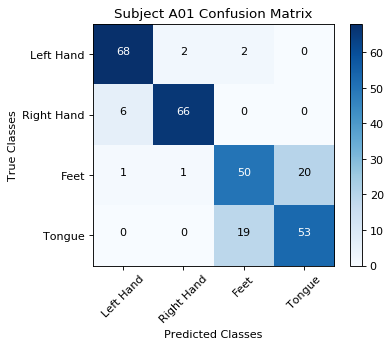

In [12]:
plot_confusion_matrix(confusion_metric, all_classes, title='Subject A0{:d} Confusion Matrix'.format(subject_id), xlabel='Predicted Classes', ylabel='True Classes')

In [13]:
score_df

precision  recall  f1-score  support
Feet             0.70    0.69      0.70       72
Left Hand        0.91    0.94      0.93       72
Right Hand       0.96    0.92      0.94       72
Tongue           0.73    0.74      0.73       72